In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "preprocess"
enable_aug = False
enable_aug3 = True
sentence_pairs = False
regressive_style_finetuning = False
lstm_bidi = False
lstm_hidden_size = 256
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-preprocess-enable_aug-False-enable_aug3-True-sentence_pairs-False-regressive_style_finetuning-False-lstm_bidi-False-lstm_hidden_size-256-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

194419


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

194419
194419
1914
1914


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


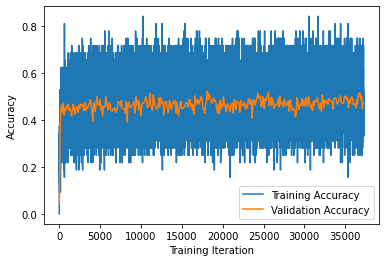

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.209 Validation Loss: 2.210 Accuracy: 0.000 Validation Accuracy: 0.008:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.208 Validation Loss: 2.210 Accuracy: 0.004 Validation Accuracy: 0.008:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.208 Validation Loss: 2.210 Accuracy: 0.008 Validation Accuracy: 0.008:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.207 Validation Loss: 2.210 Accuracy: 0.008 Validation Accuracy: 0.008:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.206 Validation Loss: 2.210 Accuracy: 0.009 Validation Accuracy: 0.008:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.206 Validation Loss: 2.210 Accuracy: 0.012 Validation Accuracy: 0.008:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.206 Validation Loss: 2.210 Accuracy: 0.011 Validation Accuracy: 0.008:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.205 Validation Loss: 2.210 Accuracy: 0.011 Validation Accuracy: 0.008:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.204 Validation Loss: 2.210 Accuracy: 0.013 Validation Accuracy: 0.008:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.204 Validation Loss: 2.210 Accuracy: 0.013 Validation Accuracy: 0.008:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.203 Validation Loss: 2.210 Accuracy: 0.014 Validation Accuracy: 0.008:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.203 Validation Loss: 2.210 Accuracy: 0.014 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 11 Loss: 2.202 Validation Loss: 2.210 Accuracy: 0.023 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 12 Loss: 2.202 Validation Loss: 2.210 Accuracy: 0.027 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 13 Loss: 2.201 Validation Loss: 2.210 Accuracy: 0.035 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 14 Loss: 2.200 Validation Loss: 2.210 Accuracy: 0.037 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 15 Loss: 2.200 Validation Loss: 2.210 Accuracy: 0.038 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 16 Loss: 2.200 Validation Loss: 2.210 Accuracy: 0.046 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 17 Loss: 2.199 Validation Loss: 2.210 Accuracy: 0.052 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 18 Loss: 2.199 Validation Loss: 2.210 Accuracy: 0.057 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 19 Loss: 2.199 Validation Loss: 2.210 Accuracy: 0.062 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 20 Loss: 2.197 Validation Loss: 2.210 Accuracy: 0.070 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 21 Loss: 2.196 Validation Loss: 2.210 Accuracy: 0.070 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 22 Loss: 2.195 Validation Loss: 2.210 Accuracy: 0.073 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 23 Loss: 2.195 Validation Loss: 2.210 Accuracy: 0.070 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 24 Loss: 2.194 Validation Loss: 2.210 Accuracy: 0.081 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 25 Loss: 2.192 Validation Loss: 2.210 Accuracy: 0.088 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 26 Loss: 2.191 Validation Loss: 2.210 Accuracy: 0.087 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 27 Loss: 2.190 Validation Loss: 2.210 Accuracy: 0.095 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 28 Loss: 2.189 Validation Loss: 2.210 Accuracy: 0.103 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 29 Loss: 2.188 Validation Loss: 2.210 Accuracy: 0.113 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 30 Loss: 2.187 Validation Loss: 2.210 Accuracy: 0.123 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 31 Loss: 2.186 Validation Loss: 2.210 Accuracy: 0.126 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 32 Loss: 2.185 Validation Loss: 2.210 Accuracy: 0.134 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 33 Loss: 2.184 Validation Loss: 2.210 Accuracy: 0.139 Validation Accuracy: 0.008:   1%|          | 11/1519 [00:00<00:13, 109.68it/s]

Epoch: 0 Iteration: 33 Loss: 2.184 Validation Loss: 2.210 Accuracy: 0.139 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 34 Loss: 2.183 Validation Loss: 2.210 Accuracy: 0.138 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 35 Loss: 2.181 Validation Loss: 2.210 Accuracy: 0.143 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 36 Loss: 2.180 Validation Loss: 2.210 Accuracy: 0.157 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 37 Loss: 2.178 Validation Loss: 2.210 Accuracy: 0.159 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 38 Loss: 2.177 Validation Loss: 2.210 Accuracy: 0.162 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 39 Loss: 2.176 Validation Loss: 2.210 Accuracy: 0.159 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 40 Loss: 2.175 Validation Loss: 2.210 Accuracy: 0.155 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 41 Loss: 2.173 Validation Loss: 2.210 Accuracy: 0.160 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 42 Loss: 2.172 Validation Loss: 2.210 Accuracy: 0.163 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 43 Loss: 2.170 Validation Loss: 2.210 Accuracy: 0.166 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 44 Loss: 2.169 Validation Loss: 2.210 Accuracy: 0.173 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 45 Loss: 2.168 Validation Loss: 2.210 Accuracy: 0.180 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 46 Loss: 2.166 Validation Loss: 2.210 Accuracy: 0.181 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 47 Loss: 2.165 Validation Loss: 2.210 Accuracy: 0.192 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 48 Loss: 2.164 Validation Loss: 2.210 Accuracy: 0.197 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 49 Loss: 2.164 Validation Loss: 2.210 Accuracy: 0.205 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 50 Loss: 2.162 Validation Loss: 2.210 Accuracy: 0.211 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 51 Loss: 2.161 Validation Loss: 2.210 Accuracy: 0.216 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 52 Loss: 2.160 Validation Loss: 2.210 Accuracy: 0.218 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 53 Loss: 2.159 Validation Loss: 2.210 Accuracy: 0.221 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 54 Loss: 2.158 Validation Loss: 2.210 Accuracy: 0.229 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 55 Loss: 2.157 Validation Loss: 2.210 Accuracy: 0.236 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 56 Loss: 2.157 Validation Loss: 2.210 Accuracy: 0.238 Validation Accuracy: 0.008:   2%|▏         | 34/1519 [00:00<00:08, 178.15it/s]

Epoch: 0 Iteration: 56 Loss: 2.157 Validation Loss: 2.210 Accuracy: 0.238 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 57 Loss: 2.156 Validation Loss: 2.210 Accuracy: 0.231 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 58 Loss: 2.155 Validation Loss: 2.210 Accuracy: 0.244 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 59 Loss: 2.153 Validation Loss: 2.210 Accuracy: 0.248 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 60 Loss: 2.152 Validation Loss: 2.210 Accuracy: 0.253 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 61 Loss: 2.152 Validation Loss: 2.210 Accuracy: 0.263 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 62 Loss: 2.151 Validation Loss: 2.210 Accuracy: 0.266 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 63 Loss: 2.149 Validation Loss: 2.210 Accuracy: 0.285 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 64 Loss: 2.148 Validation Loss: 2.210 Accuracy: 0.291 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 65 Loss: 2.147 Validation Loss: 2.210 Accuracy: 0.288 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 66 Loss: 2.146 Validation Loss: 2.210 Accuracy: 0.301 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 67 Loss: 2.144 Validation Loss: 2.210 Accuracy: 0.309 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 68 Loss: 2.143 Validation Loss: 2.210 Accuracy: 0.309 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 69 Loss: 2.141 Validation Loss: 2.210 Accuracy: 0.320 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 70 Loss: 2.140 Validation Loss: 2.210 Accuracy: 0.329 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 71 Loss: 2.138 Validation Loss: 2.210 Accuracy: 0.335 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 72 Loss: 2.137 Validation Loss: 2.210 Accuracy: 0.345 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 73 Loss: 2.135 Validation Loss: 2.210 Accuracy: 0.342 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 74 Loss: 2.134 Validation Loss: 2.210 Accuracy: 0.338 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 75 Loss: 2.132 Validation Loss: 2.210 Accuracy: 0.352 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 76 Loss: 2.130 Validation Loss: 2.210 Accuracy: 0.355 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 77 Loss: 2.128 Validation Loss: 2.210 Accuracy: 0.362 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 78 Loss: 2.126 Validation Loss: 2.210 Accuracy: 0.367 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 79 Loss: 2.124 Validation Loss: 2.210 Accuracy: 0.364 Validation Accuracy: 0.008:   4%|▍         | 57/1519 [00:00<00:07, 199.59it/s]

Epoch: 0 Iteration: 79 Loss: 2.124 Validation Loss: 2.210 Accuracy: 0.364 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 80 Loss: 2.123 Validation Loss: 2.210 Accuracy: 0.366 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 81 Loss: 2.121 Validation Loss: 2.210 Accuracy: 0.365 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 82 Loss: 2.119 Validation Loss: 2.210 Accuracy: 0.368 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 83 Loss: 2.118 Validation Loss: 2.210 Accuracy: 0.370 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 84 Loss: 2.118 Validation Loss: 2.210 Accuracy: 0.370 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 85 Loss: 2.117 Validation Loss: 2.210 Accuracy: 0.366 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 86 Loss: 2.116 Validation Loss: 2.210 Accuracy: 0.366 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 87 Loss: 2.115 Validation Loss: 2.210 Accuracy: 0.372 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 88 Loss: 2.113 Validation Loss: 2.210 Accuracy: 0.374 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 89 Loss: 2.112 Validation Loss: 2.210 Accuracy: 0.380 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 90 Loss: 2.110 Validation Loss: 2.210 Accuracy: 0.384 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 91 Loss: 2.110 Validation Loss: 2.210 Accuracy: 0.387 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 92 Loss: 2.109 Validation Loss: 2.210 Accuracy: 0.395 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 93 Loss: 2.107 Validation Loss: 2.210 Accuracy: 0.402 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 94 Loss: 2.105 Validation Loss: 2.210 Accuracy: 0.414 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 95 Loss: 2.104 Validation Loss: 2.210 Accuracy: 0.414 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 96 Loss: 2.104 Validation Loss: 2.210 Accuracy: 0.415 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 97 Loss: 2.103 Validation Loss: 2.210 Accuracy: 0.410 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 98 Loss: 2.102 Validation Loss: 2.210 Accuracy: 0.410 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 99 Loss: 2.101 Validation Loss: 2.210 Accuracy: 0.406 Validation Accuracy: 0.008:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 100 Loss: 2.100 Validation Loss: 2.092 Accuracy: 0.400 Validation Accuracy: 0.220:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 101 Loss: 2.099 Validation Loss: 2.092 Accuracy: 0.401 Validation Accuracy: 0.220:   5%|▌         | 80/1519 [00:00<00:06, 211.28it/s]

Epoch: 0 Iteration: 101 Loss: 2.099 Validation Loss: 2.092 Accuracy: 0.401 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 102 Loss: 2.098 Validation Loss: 2.092 Accuracy: 0.393 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 103 Loss: 2.096 Validation Loss: 2.092 Accuracy: 0.389 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 104 Loss: 2.096 Validation Loss: 2.092 Accuracy: 0.388 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 105 Loss: 2.093 Validation Loss: 2.092 Accuracy: 0.392 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 106 Loss: 2.091 Validation Loss: 2.092 Accuracy: 0.398 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 107 Loss: 2.090 Validation Loss: 2.092 Accuracy: 0.405 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 108 Loss: 2.089 Validation Loss: 2.092 Accuracy: 0.402 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 109 Loss: 2.088 Validation Loss: 2.092 Accuracy: 0.407 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 110 Loss: 2.087 Validation Loss: 2.092 Accuracy: 0.416 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 111 Loss: 2.084 Validation Loss: 2.092 Accuracy: 0.422 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 112 Loss: 2.083 Validation Loss: 2.092 Accuracy: 0.430 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 113 Loss: 2.082 Validation Loss: 2.092 Accuracy: 0.430 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 114 Loss: 2.081 Validation Loss: 2.092 Accuracy: 0.430 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 115 Loss: 2.081 Validation Loss: 2.092 Accuracy: 0.430 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 116 Loss: 2.078 Validation Loss: 2.092 Accuracy: 0.422 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 117 Loss: 2.077 Validation Loss: 2.092 Accuracy: 0.426 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 118 Loss: 2.077 Validation Loss: 2.092 Accuracy: 0.430 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 119 Loss: 2.077 Validation Loss: 2.092 Accuracy: 0.434 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 120 Loss: 2.073 Validation Loss: 2.092 Accuracy: 0.428 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 121 Loss: 2.073 Validation Loss: 2.092 Accuracy: 0.422 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 122 Loss: 2.071 Validation Loss: 2.092 Accuracy: 0.416 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 123 Loss: 2.071 Validation Loss: 2.092 Accuracy: 0.418 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 124 Loss: 2.068 Validation Loss: 2.092 Accuracy: 0.418 Validation Accuracy: 0.220:   7%|▋         | 102/1519 [00:00<00:06, 212.42it/s]

Epoch: 0 Iteration: 124 Loss: 2.068 Validation Loss: 2.092 Accuracy: 0.418 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 125 Loss: 2.068 Validation Loss: 2.092 Accuracy: 0.424 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 126 Loss: 2.066 Validation Loss: 2.092 Accuracy: 0.429 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 127 Loss: 2.065 Validation Loss: 2.092 Accuracy: 0.427 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 128 Loss: 2.063 Validation Loss: 2.092 Accuracy: 0.433 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 129 Loss: 2.061 Validation Loss: 2.092 Accuracy: 0.433 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 130 Loss: 2.060 Validation Loss: 2.092 Accuracy: 0.436 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 131 Loss: 2.059 Validation Loss: 2.092 Accuracy: 0.436 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 132 Loss: 2.057 Validation Loss: 2.092 Accuracy: 0.441 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 133 Loss: 2.056 Validation Loss: 2.092 Accuracy: 0.441 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 134 Loss: 2.055 Validation Loss: 2.092 Accuracy: 0.438 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 135 Loss: 2.052 Validation Loss: 2.092 Accuracy: 0.439 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 136 Loss: 2.050 Validation Loss: 2.092 Accuracy: 0.435 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 137 Loss: 2.050 Validation Loss: 2.092 Accuracy: 0.427 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 138 Loss: 2.047 Validation Loss: 2.092 Accuracy: 0.415 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 139 Loss: 2.045 Validation Loss: 2.092 Accuracy: 0.416 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 140 Loss: 2.044 Validation Loss: 2.092 Accuracy: 0.426 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 141 Loss: 2.042 Validation Loss: 2.092 Accuracy: 0.434 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 142 Loss: 2.042 Validation Loss: 2.092 Accuracy: 0.430 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 143 Loss: 2.040 Validation Loss: 2.092 Accuracy: 0.427 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 144 Loss: 2.038 Validation Loss: 2.092 Accuracy: 0.436 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 145 Loss: 2.035 Validation Loss: 2.092 Accuracy: 0.444 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 146 Loss: 2.035 Validation Loss: 2.092 Accuracy: 0.445 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 147 Loss: 2.033 Validation Loss: 2.092 Accuracy: 0.455 Validation Accuracy: 0.220:   8%|▊         | 125/1519 [00:00<00:06, 217.68it/s]

Epoch: 0 Iteration: 147 Loss: 2.033 Validation Loss: 2.092 Accuracy: 0.455 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 148 Loss: 2.031 Validation Loss: 2.092 Accuracy: 0.461 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 149 Loss: 2.032 Validation Loss: 2.092 Accuracy: 0.457 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 150 Loss: 2.029 Validation Loss: 2.092 Accuracy: 0.449 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 151 Loss: 2.030 Validation Loss: 2.092 Accuracy: 0.437 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 152 Loss: 2.031 Validation Loss: 2.092 Accuracy: 0.434 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 153 Loss: 2.028 Validation Loss: 2.092 Accuracy: 0.448 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 154 Loss: 2.026 Validation Loss: 2.092 Accuracy: 0.447 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 155 Loss: 2.026 Validation Loss: 2.092 Accuracy: 0.438 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 156 Loss: 2.026 Validation Loss: 2.092 Accuracy: 0.441 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 157 Loss: 2.023 Validation Loss: 2.092 Accuracy: 0.439 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 158 Loss: 2.022 Validation Loss: 2.092 Accuracy: 0.440 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 159 Loss: 2.021 Validation Loss: 2.092 Accuracy: 0.448 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 160 Loss: 2.018 Validation Loss: 2.092 Accuracy: 0.456 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 161 Loss: 2.018 Validation Loss: 2.092 Accuracy: 0.463 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 162 Loss: 2.015 Validation Loss: 2.092 Accuracy: 0.473 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 163 Loss: 2.013 Validation Loss: 2.092 Accuracy: 0.473 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 164 Loss: 2.014 Validation Loss: 2.092 Accuracy: 0.466 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 165 Loss: 2.013 Validation Loss: 2.092 Accuracy: 0.463 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 166 Loss: 2.012 Validation Loss: 2.092 Accuracy: 0.460 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 167 Loss: 2.010 Validation Loss: 2.092 Accuracy: 0.468 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 168 Loss: 2.011 Validation Loss: 2.092 Accuracy: 0.469 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 169 Loss: 2.009 Validation Loss: 2.092 Accuracy: 0.461 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 170 Loss: 2.009 Validation Loss: 2.092 Accuracy: 0.451 Validation Accuracy: 0.220:  10%|▉         | 148/1519 [00:00<00:06, 221.08it/s]

Epoch: 0 Iteration: 170 Loss: 2.009 Validation Loss: 2.092 Accuracy: 0.451 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 171 Loss: 2.006 Validation Loss: 2.092 Accuracy: 0.443 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 172 Loss: 2.003 Validation Loss: 2.092 Accuracy: 0.441 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 173 Loss: 2.001 Validation Loss: 2.092 Accuracy: 0.441 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 174 Loss: 2.000 Validation Loss: 2.092 Accuracy: 0.443 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 175 Loss: 1.997 Validation Loss: 2.092 Accuracy: 0.448 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 176 Loss: 1.995 Validation Loss: 2.092 Accuracy: 0.453 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 177 Loss: 1.996 Validation Loss: 2.092 Accuracy: 0.441 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 178 Loss: 1.995 Validation Loss: 2.092 Accuracy: 0.441 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 179 Loss: 1.992 Validation Loss: 2.092 Accuracy: 0.434 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 180 Loss: 1.991 Validation Loss: 2.092 Accuracy: 0.441 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 181 Loss: 1.988 Validation Loss: 2.092 Accuracy: 0.447 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 182 Loss: 1.984 Validation Loss: 2.092 Accuracy: 0.454 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 183 Loss: 1.980 Validation Loss: 2.092 Accuracy: 0.450 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 184 Loss: 1.978 Validation Loss: 2.092 Accuracy: 0.457 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 185 Loss: 1.977 Validation Loss: 2.092 Accuracy: 0.452 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 186 Loss: 1.976 Validation Loss: 2.092 Accuracy: 0.452 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 187 Loss: 1.973 Validation Loss: 2.092 Accuracy: 0.467 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 188 Loss: 1.969 Validation Loss: 2.092 Accuracy: 0.466 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 189 Loss: 1.965 Validation Loss: 2.092 Accuracy: 0.476 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 190 Loss: 1.962 Validation Loss: 2.092 Accuracy: 0.475 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 191 Loss: 1.958 Validation Loss: 2.092 Accuracy: 0.484 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 192 Loss: 1.953 Validation Loss: 2.092 Accuracy: 0.486 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 193 Loss: 1.952 Validation Loss: 2.092 Accuracy: 0.490 Validation Accuracy: 0.220:  11%|█▏        | 171/1519 [00:00<00:06, 223.61it/s]

Epoch: 0 Iteration: 193 Loss: 1.952 Validation Loss: 2.092 Accuracy: 0.490 Validation Accuracy: 0.220:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 194 Loss: 1.949 Validation Loss: 2.092 Accuracy: 0.493 Validation Accuracy: 0.220:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 195 Loss: 1.945 Validation Loss: 2.092 Accuracy: 0.498 Validation Accuracy: 0.220:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 196 Loss: 1.943 Validation Loss: 2.092 Accuracy: 0.506 Validation Accuracy: 0.220:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 197 Loss: 1.939 Validation Loss: 2.092 Accuracy: 0.494 Validation Accuracy: 0.220:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 198 Loss: 1.937 Validation Loss: 2.092 Accuracy: 0.497 Validation Accuracy: 0.220:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 199 Loss: 1.936 Validation Loss: 2.092 Accuracy: 0.499 Validation Accuracy: 0.220:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 200 Loss: 1.935 Validation Loss: 1.933 Accuracy: 0.502 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 201 Loss: 1.934 Validation Loss: 1.933 Accuracy: 0.499 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 202 Loss: 1.934 Validation Loss: 1.933 Accuracy: 0.490 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 203 Loss: 1.933 Validation Loss: 1.933 Accuracy: 0.491 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 204 Loss: 1.931 Validation Loss: 1.933 Accuracy: 0.486 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 205 Loss: 1.929 Validation Loss: 1.933 Accuracy: 0.483 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 206 Loss: 1.927 Validation Loss: 1.933 Accuracy: 0.481 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 207 Loss: 1.927 Validation Loss: 1.933 Accuracy: 0.482 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 208 Loss: 1.927 Validation Loss: 1.933 Accuracy: 0.485 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 209 Loss: 1.925 Validation Loss: 1.933 Accuracy: 0.487 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:00<00:05, 221.87it/s]

Epoch: 0 Iteration: 210 Loss: 1.927 Validation Loss: 1.933 Accuracy: 0.487 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:01<00:05, 221.87it/s]

Epoch: 0 Iteration: 211 Loss: 1.925 Validation Loss: 1.933 Accuracy: 0.487 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:01<00:05, 221.87it/s]

Epoch: 0 Iteration: 212 Loss: 1.925 Validation Loss: 1.933 Accuracy: 0.488 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:01<00:05, 221.87it/s]

Epoch: 0 Iteration: 213 Loss: 1.925 Validation Loss: 1.933 Accuracy: 0.487 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:01<00:05, 221.87it/s]

Epoch: 0 Iteration: 214 Loss: 1.925 Validation Loss: 1.933 Accuracy: 0.486 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:01<00:05, 221.87it/s]

Epoch: 0 Iteration: 215 Loss: 1.927 Validation Loss: 1.933 Accuracy: 0.489 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:01<00:05, 221.87it/s]

Epoch: 0 Iteration: 216 Loss: 1.926 Validation Loss: 1.933 Accuracy: 0.483 Validation Accuracy: 0.314:  13%|█▎        | 194/1519 [00:01<00:05, 221.87it/s]

Epoch: 0 Iteration: 216 Loss: 1.926 Validation Loss: 1.933 Accuracy: 0.483 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 217 Loss: 1.925 Validation Loss: 1.933 Accuracy: 0.487 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 218 Loss: 1.923 Validation Loss: 1.933 Accuracy: 0.487 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 219 Loss: 1.919 Validation Loss: 1.933 Accuracy: 0.483 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 220 Loss: 1.916 Validation Loss: 1.933 Accuracy: 0.478 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 221 Loss: 1.914 Validation Loss: 1.933 Accuracy: 0.475 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 222 Loss: 1.915 Validation Loss: 1.933 Accuracy: 0.472 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 223 Loss: 1.914 Validation Loss: 1.933 Accuracy: 0.476 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 224 Loss: 1.914 Validation Loss: 1.933 Accuracy: 0.476 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 225 Loss: 1.912 Validation Loss: 1.933 Accuracy: 0.476 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 226 Loss: 1.905 Validation Loss: 1.933 Accuracy: 0.484 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 227 Loss: 1.903 Validation Loss: 1.933 Accuracy: 0.484 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 228 Loss: 1.898 Validation Loss: 1.933 Accuracy: 0.487 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 229 Loss: 1.896 Validation Loss: 1.933 Accuracy: 0.487 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 230 Loss: 1.890 Validation Loss: 1.933 Accuracy: 0.491 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 231 Loss: 1.892 Validation Loss: 1.933 Accuracy: 0.496 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 232 Loss: 1.891 Validation Loss: 1.933 Accuracy: 0.498 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 233 Loss: 1.886 Validation Loss: 1.933 Accuracy: 0.491 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 234 Loss: 1.884 Validation Loss: 1.933 Accuracy: 0.493 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 235 Loss: 1.882 Validation Loss: 1.933 Accuracy: 0.502 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 236 Loss: 1.879 Validation Loss: 1.933 Accuracy: 0.497 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 237 Loss: 1.874 Validation Loss: 1.933 Accuracy: 0.505 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 238 Loss: 1.873 Validation Loss: 1.933 Accuracy: 0.495 Validation Accuracy: 0.314:  14%|█▍        | 217/1519 [00:01<00:06, 212.97it/s]

Epoch: 0 Iteration: 238 Loss: 1.873 Validation Loss: 1.933 Accuracy: 0.495 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 239 Loss: 1.873 Validation Loss: 1.933 Accuracy: 0.498 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 240 Loss: 1.871 Validation Loss: 1.933 Accuracy: 0.496 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 241 Loss: 1.865 Validation Loss: 1.933 Accuracy: 0.499 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 242 Loss: 1.863 Validation Loss: 1.933 Accuracy: 0.504 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 243 Loss: 1.860 Validation Loss: 1.933 Accuracy: 0.507 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 244 Loss: 1.856 Validation Loss: 1.933 Accuracy: 0.508 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 245 Loss: 1.855 Validation Loss: 1.933 Accuracy: 0.498 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 246 Loss: 1.856 Validation Loss: 1.933 Accuracy: 0.505 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 247 Loss: 1.853 Validation Loss: 1.933 Accuracy: 0.500 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 248 Loss: 1.852 Validation Loss: 1.933 Accuracy: 0.510 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 249 Loss: 1.852 Validation Loss: 1.933 Accuracy: 0.512 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 250 Loss: 1.851 Validation Loss: 1.933 Accuracy: 0.522 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 251 Loss: 1.848 Validation Loss: 1.933 Accuracy: 0.523 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 252 Loss: 1.845 Validation Loss: 1.933 Accuracy: 0.527 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 253 Loss: 1.843 Validation Loss: 1.933 Accuracy: 0.524 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 254 Loss: 1.842 Validation Loss: 1.933 Accuracy: 0.527 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 255 Loss: 1.838 Validation Loss: 1.933 Accuracy: 0.530 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 256 Loss: 1.835 Validation Loss: 1.933 Accuracy: 0.530 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 257 Loss: 1.832 Validation Loss: 1.933 Accuracy: 0.530 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 258 Loss: 1.825 Validation Loss: 1.933 Accuracy: 0.535 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 259 Loss: 1.824 Validation Loss: 1.933 Accuracy: 0.533 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 260 Loss: 1.822 Validation Loss: 1.933 Accuracy: 0.524 Validation Accuracy: 0.314:  16%|█▌        | 239/1519 [00:01<00:06, 213.08it/s]

Epoch: 0 Iteration: 260 Loss: 1.822 Validation Loss: 1.933 Accuracy: 0.524 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 261 Loss: 1.822 Validation Loss: 1.933 Accuracy: 0.524 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 262 Loss: 1.815 Validation Loss: 1.933 Accuracy: 0.523 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 263 Loss: 1.814 Validation Loss: 1.933 Accuracy: 0.527 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 264 Loss: 1.810 Validation Loss: 1.933 Accuracy: 0.527 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 265 Loss: 1.804 Validation Loss: 1.933 Accuracy: 0.532 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 266 Loss: 1.804 Validation Loss: 1.933 Accuracy: 0.522 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 267 Loss: 1.799 Validation Loss: 1.933 Accuracy: 0.523 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 268 Loss: 1.798 Validation Loss: 1.933 Accuracy: 0.514 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 269 Loss: 1.795 Validation Loss: 1.933 Accuracy: 0.514 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 270 Loss: 1.790 Validation Loss: 1.933 Accuracy: 0.521 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 271 Loss: 1.788 Validation Loss: 1.933 Accuracy: 0.514 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 272 Loss: 1.786 Validation Loss: 1.933 Accuracy: 0.521 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 273 Loss: 1.785 Validation Loss: 1.933 Accuracy: 0.520 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 274 Loss: 1.780 Validation Loss: 1.933 Accuracy: 0.531 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 275 Loss: 1.779 Validation Loss: 1.933 Accuracy: 0.522 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 276 Loss: 1.775 Validation Loss: 1.933 Accuracy: 0.531 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 277 Loss: 1.771 Validation Loss: 1.933 Accuracy: 0.531 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 278 Loss: 1.775 Validation Loss: 1.933 Accuracy: 0.535 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 279 Loss: 1.770 Validation Loss: 1.933 Accuracy: 0.549 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 280 Loss: 1.766 Validation Loss: 1.933 Accuracy: 0.557 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 281 Loss: 1.765 Validation Loss: 1.933 Accuracy: 0.566 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 282 Loss: 1.764 Validation Loss: 1.933 Accuracy: 0.561 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 283 Loss: 1.763 Validation Loss: 1.933 Accuracy: 0.558 Validation Accuracy: 0.314:  17%|█▋        | 261/1519 [00:01<00:05, 213.25it/s]

Epoch: 0 Iteration: 283 Loss: 1.763 Validation Loss: 1.933 Accuracy: 0.558 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 284 Loss: 1.763 Validation Loss: 1.933 Accuracy: 0.548 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 285 Loss: 1.763 Validation Loss: 1.933 Accuracy: 0.552 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 286 Loss: 1.756 Validation Loss: 1.933 Accuracy: 0.552 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 287 Loss: 1.756 Validation Loss: 1.933 Accuracy: 0.548 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 288 Loss: 1.753 Validation Loss: 1.933 Accuracy: 0.549 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 289 Loss: 1.748 Validation Loss: 1.933 Accuracy: 0.537 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 290 Loss: 1.746 Validation Loss: 1.933 Accuracy: 0.526 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 291 Loss: 1.740 Validation Loss: 1.933 Accuracy: 0.529 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 292 Loss: 1.737 Validation Loss: 1.933 Accuracy: 0.531 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 293 Loss: 1.735 Validation Loss: 1.933 Accuracy: 0.535 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 294 Loss: 1.733 Validation Loss: 1.933 Accuracy: 0.533 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 295 Loss: 1.735 Validation Loss: 1.933 Accuracy: 0.536 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 296 Loss: 1.737 Validation Loss: 1.933 Accuracy: 0.537 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 297 Loss: 1.737 Validation Loss: 1.933 Accuracy: 0.545 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 298 Loss: 1.734 Validation Loss: 1.933 Accuracy: 0.552 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 299 Loss: 1.733 Validation Loss: 1.933 Accuracy: 0.550 Validation Accuracy: 0.314:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 300 Loss: 1.734 Validation Loss: 1.698 Accuracy: 0.548 Validation Accuracy: 0.379:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 301 Loss: 1.730 Validation Loss: 1.698 Accuracy: 0.538 Validation Accuracy: 0.379:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 302 Loss: 1.730 Validation Loss: 1.698 Accuracy: 0.538 Validation Accuracy: 0.379:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 303 Loss: 1.728 Validation Loss: 1.698 Accuracy: 0.537 Validation Accuracy: 0.379:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 304 Loss: 1.726 Validation Loss: 1.698 Accuracy: 0.538 Validation Accuracy: 0.379:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 305 Loss: 1.721 Validation Loss: 1.698 Accuracy: 0.545 Validation Accuracy: 0.379:  19%|█▊        | 284/1519 [00:01<00:05, 216.30it/s]

Epoch: 0 Iteration: 305 Loss: 1.721 Validation Loss: 1.698 Accuracy: 0.545 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 306 Loss: 1.721 Validation Loss: 1.698 Accuracy: 0.540 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 307 Loss: 1.718 Validation Loss: 1.698 Accuracy: 0.545 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 308 Loss: 1.715 Validation Loss: 1.698 Accuracy: 0.538 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 309 Loss: 1.709 Validation Loss: 1.698 Accuracy: 0.552 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 310 Loss: 1.708 Validation Loss: 1.698 Accuracy: 0.550 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 311 Loss: 1.705 Validation Loss: 1.698 Accuracy: 0.559 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 312 Loss: 1.703 Validation Loss: 1.698 Accuracy: 0.557 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 313 Loss: 1.701 Validation Loss: 1.698 Accuracy: 0.564 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 314 Loss: 1.700 Validation Loss: 1.698 Accuracy: 0.562 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 315 Loss: 1.691 Validation Loss: 1.698 Accuracy: 0.560 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 316 Loss: 1.685 Validation Loss: 1.698 Accuracy: 0.568 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 317 Loss: 1.685 Validation Loss: 1.698 Accuracy: 0.557 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 318 Loss: 1.684 Validation Loss: 1.698 Accuracy: 0.559 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 319 Loss: 1.682 Validation Loss: 1.698 Accuracy: 0.552 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 320 Loss: 1.674 Validation Loss: 1.698 Accuracy: 0.566 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 321 Loss: 1.671 Validation Loss: 1.698 Accuracy: 0.566 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 322 Loss: 1.664 Validation Loss: 1.698 Accuracy: 0.567 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 323 Loss: 1.659 Validation Loss: 1.698 Accuracy: 0.568 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 324 Loss: 1.657 Validation Loss: 1.698 Accuracy: 0.577 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 325 Loss: 1.655 Validation Loss: 1.698 Accuracy: 0.574 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 326 Loss: 1.652 Validation Loss: 1.698 Accuracy: 0.570 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 327 Loss: 1.651 Validation Loss: 1.698 Accuracy: 0.573 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 328 Loss: 1.648 Validation Loss: 1.698 Accuracy: 0.572 Validation Accuracy: 0.379:  20%|██        | 306/1519 [00:01<00:05, 214.63it/s]

Epoch: 0 Iteration: 328 Loss: 1.648 Validation Loss: 1.698 Accuracy: 0.572 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 329 Loss: 1.647 Validation Loss: 1.698 Accuracy: 0.571 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 330 Loss: 1.645 Validation Loss: 1.698 Accuracy: 0.562 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 331 Loss: 1.646 Validation Loss: 1.698 Accuracy: 0.560 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 332 Loss: 1.643 Validation Loss: 1.698 Accuracy: 0.565 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 333 Loss: 1.640 Validation Loss: 1.698 Accuracy: 0.567 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 334 Loss: 1.636 Validation Loss: 1.698 Accuracy: 0.567 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 335 Loss: 1.633 Validation Loss: 1.698 Accuracy: 0.562 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 336 Loss: 1.629 Validation Loss: 1.698 Accuracy: 0.566 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 337 Loss: 1.625 Validation Loss: 1.698 Accuracy: 0.564 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 338 Loss: 1.620 Validation Loss: 1.698 Accuracy: 0.562 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 339 Loss: 1.615 Validation Loss: 1.698 Accuracy: 0.559 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 340 Loss: 1.615 Validation Loss: 1.698 Accuracy: 0.568 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 341 Loss: 1.612 Validation Loss: 1.698 Accuracy: 0.567 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 342 Loss: 1.615 Validation Loss: 1.698 Accuracy: 0.561 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 343 Loss: 1.613 Validation Loss: 1.698 Accuracy: 0.554 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 344 Loss: 1.606 Validation Loss: 1.698 Accuracy: 0.556 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 345 Loss: 1.603 Validation Loss: 1.698 Accuracy: 0.560 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 346 Loss: 1.600 Validation Loss: 1.698 Accuracy: 0.559 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 347 Loss: 1.593 Validation Loss: 1.698 Accuracy: 0.569 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 348 Loss: 1.593 Validation Loss: 1.698 Accuracy: 0.572 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 349 Loss: 1.595 Validation Loss: 1.698 Accuracy: 0.571 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 350 Loss: 1.592 Validation Loss: 1.698 Accuracy: 0.566 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 351 Loss: 1.586 Validation Loss: 1.698 Accuracy: 0.570 Validation Accuracy: 0.379:  22%|██▏       | 329/1519 [00:01<00:05, 217.54it/s]

Epoch: 0 Iteration: 351 Loss: 1.586 Validation Loss: 1.698 Accuracy: 0.570 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 352 Loss: 1.583 Validation Loss: 1.698 Accuracy: 0.570 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 353 Loss: 1.579 Validation Loss: 1.698 Accuracy: 0.570 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 354 Loss: 1.576 Validation Loss: 1.698 Accuracy: 0.569 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 355 Loss: 1.576 Validation Loss: 1.698 Accuracy: 0.573 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 356 Loss: 1.573 Validation Loss: 1.698 Accuracy: 0.574 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 357 Loss: 1.570 Validation Loss: 1.698 Accuracy: 0.566 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 358 Loss: 1.566 Validation Loss: 1.698 Accuracy: 0.560 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 359 Loss: 1.565 Validation Loss: 1.698 Accuracy: 0.570 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 360 Loss: 1.562 Validation Loss: 1.698 Accuracy: 0.573 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 361 Loss: 1.557 Validation Loss: 1.698 Accuracy: 0.581 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 362 Loss: 1.549 Validation Loss: 1.698 Accuracy: 0.582 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 363 Loss: 1.544 Validation Loss: 1.698 Accuracy: 0.580 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 364 Loss: 1.540 Validation Loss: 1.698 Accuracy: 0.577 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 365 Loss: 1.537 Validation Loss: 1.698 Accuracy: 0.573 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 366 Loss: 1.537 Validation Loss: 1.698 Accuracy: 0.573 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 367 Loss: 1.540 Validation Loss: 1.698 Accuracy: 0.570 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 368 Loss: 1.535 Validation Loss: 1.698 Accuracy: 0.580 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 369 Loss: 1.530 Validation Loss: 1.698 Accuracy: 0.576 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 370 Loss: 1.524 Validation Loss: 1.698 Accuracy: 0.575 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 371 Loss: 1.517 Validation Loss: 1.698 Accuracy: 0.568 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 372 Loss: 1.514 Validation Loss: 1.698 Accuracy: 0.567 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 373 Loss: 1.511 Validation Loss: 1.698 Accuracy: 0.576 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 374 Loss: 1.507 Validation Loss: 1.698 Accuracy: 0.580 Validation Accuracy: 0.379:  23%|██▎       | 352/1519 [00:01<00:05, 219.51it/s]

Epoch: 0 Iteration: 374 Loss: 1.507 Validation Loss: 1.698 Accuracy: 0.580 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 375 Loss: 1.503 Validation Loss: 1.698 Accuracy: 0.587 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 376 Loss: 1.499 Validation Loss: 1.698 Accuracy: 0.590 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 377 Loss: 1.494 Validation Loss: 1.698 Accuracy: 0.595 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 378 Loss: 1.491 Validation Loss: 1.698 Accuracy: 0.592 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 379 Loss: 1.487 Validation Loss: 1.698 Accuracy: 0.590 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 380 Loss: 1.485 Validation Loss: 1.698 Accuracy: 0.588 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 381 Loss: 1.484 Validation Loss: 1.698 Accuracy: 0.596 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 382 Loss: 1.482 Validation Loss: 1.698 Accuracy: 0.602 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 383 Loss: 1.481 Validation Loss: 1.698 Accuracy: 0.600 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 384 Loss: 1.479 Validation Loss: 1.698 Accuracy: 0.596 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 385 Loss: 1.477 Validation Loss: 1.698 Accuracy: 0.588 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 386 Loss: 1.470 Validation Loss: 1.698 Accuracy: 0.584 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 387 Loss: 1.459 Validation Loss: 1.698 Accuracy: 0.591 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 388 Loss: 1.455 Validation Loss: 1.698 Accuracy: 0.590 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 389 Loss: 1.450 Validation Loss: 1.698 Accuracy: 0.591 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 390 Loss: 1.445 Validation Loss: 1.698 Accuracy: 0.598 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 391 Loss: 1.446 Validation Loss: 1.698 Accuracy: 0.591 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 392 Loss: 1.447 Validation Loss: 1.698 Accuracy: 0.579 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 393 Loss: 1.444 Validation Loss: 1.698 Accuracy: 0.576 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 394 Loss: 1.440 Validation Loss: 1.698 Accuracy: 0.580 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 395 Loss: 1.441 Validation Loss: 1.698 Accuracy: 0.587 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 396 Loss: 1.440 Validation Loss: 1.698 Accuracy: 0.584 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 397 Loss: 1.433 Validation Loss: 1.698 Accuracy: 0.583 Validation Accuracy: 0.379:  25%|██▍       | 375/1519 [00:01<00:05, 220.50it/s]

Epoch: 0 Iteration: 397 Loss: 1.433 Validation Loss: 1.698 Accuracy: 0.583 Validation Accuracy: 0.379:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 398 Loss: 1.431 Validation Loss: 1.698 Accuracy: 0.581 Validation Accuracy: 0.379:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 399 Loss: 1.424 Validation Loss: 1.698 Accuracy: 0.590 Validation Accuracy: 0.379:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 400 Loss: 1.421 Validation Loss: 1.398 Accuracy: 0.588 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 401 Loss: 1.420 Validation Loss: 1.398 Accuracy: 0.581 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 402 Loss: 1.419 Validation Loss: 1.398 Accuracy: 0.588 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 403 Loss: 1.421 Validation Loss: 1.398 Accuracy: 0.596 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 404 Loss: 1.420 Validation Loss: 1.398 Accuracy: 0.587 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 405 Loss: 1.415 Validation Loss: 1.398 Accuracy: 0.595 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 406 Loss: 1.412 Validation Loss: 1.398 Accuracy: 0.598 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 407 Loss: 1.413 Validation Loss: 1.398 Accuracy: 0.601 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 408 Loss: 1.411 Validation Loss: 1.398 Accuracy: 0.607 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 409 Loss: 1.409 Validation Loss: 1.398 Accuracy: 0.601 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 410 Loss: 1.407 Validation Loss: 1.398 Accuracy: 0.603 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 411 Loss: 1.401 Validation Loss: 1.398 Accuracy: 0.608 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 412 Loss: 1.395 Validation Loss: 1.398 Accuracy: 0.611 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 413 Loss: 1.393 Validation Loss: 1.398 Accuracy: 0.607 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 414 Loss: 1.389 Validation Loss: 1.398 Accuracy: 0.608 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 415 Loss: 1.382 Validation Loss: 1.398 Accuracy: 0.600 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 416 Loss: 1.378 Validation Loss: 1.398 Accuracy: 0.607 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 417 Loss: 1.376 Validation Loss: 1.398 Accuracy: 0.605 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 418 Loss: 1.377 Validation Loss: 1.398 Accuracy: 0.603 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 419 Loss: 1.376 Validation Loss: 1.398 Accuracy: 0.595 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 420 Loss: 1.374 Validation Loss: 1.398 Accuracy: 0.585 Validation Accuracy: 0.425:  26%|██▌       | 398/1519 [00:01<00:05, 221.74it/s]

Epoch: 0 Iteration: 420 Loss: 1.374 Validation Loss: 1.398 Accuracy: 0.585 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:01<00:05, 216.78it/s]

Epoch: 0 Iteration: 421 Loss: 1.365 Validation Loss: 1.398 Accuracy: 0.589 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:01<00:05, 216.78it/s]

Epoch: 0 Iteration: 422 Loss: 1.361 Validation Loss: 1.398 Accuracy: 0.587 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:01<00:05, 216.78it/s]

Epoch: 0 Iteration: 423 Loss: 1.353 Validation Loss: 1.398 Accuracy: 0.589 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:01<00:05, 216.78it/s]

Epoch: 0 Iteration: 424 Loss: 1.346 Validation Loss: 1.398 Accuracy: 0.594 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:01<00:05, 216.78it/s]

Epoch: 0 Iteration: 425 Loss: 1.346 Validation Loss: 1.398 Accuracy: 0.591 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:01<00:05, 216.78it/s]

Epoch: 0 Iteration: 426 Loss: 1.341 Validation Loss: 1.398 Accuracy: 0.585 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:01<00:05, 216.78it/s]

Epoch: 0 Iteration: 427 Loss: 1.341 Validation Loss: 1.398 Accuracy: 0.581 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 428 Loss: 1.340 Validation Loss: 1.398 Accuracy: 0.574 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 429 Loss: 1.334 Validation Loss: 1.398 Accuracy: 0.585 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 430 Loss: 1.335 Validation Loss: 1.398 Accuracy: 0.588 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 431 Loss: 1.334 Validation Loss: 1.398 Accuracy: 0.587 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 432 Loss: 1.330 Validation Loss: 1.398 Accuracy: 0.592 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 433 Loss: 1.328 Validation Loss: 1.398 Accuracy: 0.596 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 434 Loss: 1.328 Validation Loss: 1.398 Accuracy: 0.594 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 435 Loss: 1.323 Validation Loss: 1.398 Accuracy: 0.601 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 436 Loss: 1.319 Validation Loss: 1.398 Accuracy: 0.602 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 437 Loss: 1.318 Validation Loss: 1.398 Accuracy: 0.608 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 438 Loss: 1.310 Validation Loss: 1.398 Accuracy: 0.619 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 439 Loss: 1.311 Validation Loss: 1.398 Accuracy: 0.614 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 440 Loss: 1.309 Validation Loss: 1.398 Accuracy: 0.615 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 441 Loss: 1.313 Validation Loss: 1.398 Accuracy: 0.611 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 442 Loss: 1.310 Validation Loss: 1.398 Accuracy: 0.610 Validation Accuracy: 0.425:  28%|██▊       | 421/1519 [00:02<00:05, 216.78it/s]

Epoch: 0 Iteration: 442 Loss: 1.310 Validation Loss: 1.398 Accuracy: 0.610 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 443 Loss: 1.309 Validation Loss: 1.398 Accuracy: 0.605 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 444 Loss: 1.306 Validation Loss: 1.398 Accuracy: 0.612 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 445 Loss: 1.302 Validation Loss: 1.398 Accuracy: 0.608 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 446 Loss: 1.302 Validation Loss: 1.398 Accuracy: 0.604 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 447 Loss: 1.295 Validation Loss: 1.398 Accuracy: 0.594 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 448 Loss: 1.289 Validation Loss: 1.398 Accuracy: 0.591 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 449 Loss: 1.288 Validation Loss: 1.398 Accuracy: 0.597 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 450 Loss: 1.282 Validation Loss: 1.398 Accuracy: 0.596 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 451 Loss: 1.278 Validation Loss: 1.398 Accuracy: 0.594 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 452 Loss: 1.277 Validation Loss: 1.398 Accuracy: 0.592 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 453 Loss: 1.272 Validation Loss: 1.398 Accuracy: 0.589 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 454 Loss: 1.267 Validation Loss: 1.398 Accuracy: 0.584 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 455 Loss: 1.262 Validation Loss: 1.398 Accuracy: 0.591 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 456 Loss: 1.260 Validation Loss: 1.398 Accuracy: 0.589 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 457 Loss: 1.258 Validation Loss: 1.398 Accuracy: 0.593 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 458 Loss: 1.254 Validation Loss: 1.398 Accuracy: 0.590 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 459 Loss: 1.248 Validation Loss: 1.398 Accuracy: 0.583 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 460 Loss: 1.240 Validation Loss: 1.398 Accuracy: 0.588 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 461 Loss: 1.235 Validation Loss: 1.398 Accuracy: 0.597 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 462 Loss: 1.233 Validation Loss: 1.398 Accuracy: 0.591 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 463 Loss: 1.228 Validation Loss: 1.398 Accuracy: 0.588 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 464 Loss: 1.230 Validation Loss: 1.398 Accuracy: 0.587 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 465 Loss: 1.228 Validation Loss: 1.398 Accuracy: 0.577 Validation Accuracy: 0.425:  29%|██▉       | 443/1519 [00:02<00:05, 214.36it/s]

Epoch: 0 Iteration: 465 Loss: 1.228 Validation Loss: 1.398 Accuracy: 0.577 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 466 Loss: 1.225 Validation Loss: 1.398 Accuracy: 0.579 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 467 Loss: 1.224 Validation Loss: 1.398 Accuracy: 0.588 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 468 Loss: 1.219 Validation Loss: 1.398 Accuracy: 0.589 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 469 Loss: 1.219 Validation Loss: 1.398 Accuracy: 0.591 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 470 Loss: 1.216 Validation Loss: 1.398 Accuracy: 0.588 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 471 Loss: 1.211 Validation Loss: 1.398 Accuracy: 0.594 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 472 Loss: 1.203 Validation Loss: 1.398 Accuracy: 0.603 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 473 Loss: 1.197 Validation Loss: 1.398 Accuracy: 0.613 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 474 Loss: 1.198 Validation Loss: 1.398 Accuracy: 0.613 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 475 Loss: 1.197 Validation Loss: 1.398 Accuracy: 0.617 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 476 Loss: 1.194 Validation Loss: 1.398 Accuracy: 0.626 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 477 Loss: 1.190 Validation Loss: 1.398 Accuracy: 0.634 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 478 Loss: 1.189 Validation Loss: 1.398 Accuracy: 0.638 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 479 Loss: 1.188 Validation Loss: 1.398 Accuracy: 0.637 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 480 Loss: 1.187 Validation Loss: 1.398 Accuracy: 0.638 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 481 Loss: 1.181 Validation Loss: 1.398 Accuracy: 0.630 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 482 Loss: 1.176 Validation Loss: 1.398 Accuracy: 0.632 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 483 Loss: 1.174 Validation Loss: 1.398 Accuracy: 0.627 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 484 Loss: 1.166 Validation Loss: 1.398 Accuracy: 0.637 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 485 Loss: 1.162 Validation Loss: 1.398 Accuracy: 0.636 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 486 Loss: 1.165 Validation Loss: 1.398 Accuracy: 0.626 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 487 Loss: 1.158 Validation Loss: 1.398 Accuracy: 0.616 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 488 Loss: 1.157 Validation Loss: 1.398 Accuracy: 0.615 Validation Accuracy: 0.425:  31%|███       | 466/1519 [00:02<00:04, 216.78it/s]

Epoch: 0 Iteration: 488 Loss: 1.157 Validation Loss: 1.398 Accuracy: 0.615 Validation Accuracy: 0.425:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 489 Loss: 1.154 Validation Loss: 1.398 Accuracy: 0.622 Validation Accuracy: 0.425:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 490 Loss: 1.155 Validation Loss: 1.398 Accuracy: 0.619 Validation Accuracy: 0.425:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 491 Loss: 1.153 Validation Loss: 1.398 Accuracy: 0.625 Validation Accuracy: 0.425:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 492 Loss: 1.153 Validation Loss: 1.398 Accuracy: 0.620 Validation Accuracy: 0.425:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 493 Loss: 1.151 Validation Loss: 1.398 Accuracy: 0.625 Validation Accuracy: 0.425:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 494 Loss: 1.150 Validation Loss: 1.398 Accuracy: 0.618 Validation Accuracy: 0.425:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 495 Loss: 1.147 Validation Loss: 1.398 Accuracy: 0.616 Validation Accuracy: 0.425:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 496 Loss: 1.147 Validation Loss: 1.398 Accuracy: 0.624 Validation Accuracy: 0.425:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 497 Loss: 1.147 Validation Loss: 1.398 Accuracy: 0.625 Validation Accuracy: 0.425:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 498 Loss: 1.143 Validation Loss: 1.398 Accuracy: 0.619 Validation Accuracy: 0.425:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 499 Loss: 1.139 Validation Loss: 1.398 Accuracy: 0.625 Validation Accuracy: 0.425:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 500 Loss: 1.137 Validation Loss: 1.134 Accuracy: 0.624 Validation Accuracy: 0.451:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 501 Loss: 1.136 Validation Loss: 1.134 Accuracy: 0.616 Validation Accuracy: 0.451:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 502 Loss: 1.136 Validation Loss: 1.134 Accuracy: 0.620 Validation Accuracy: 0.451:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 503 Loss: 1.130 Validation Loss: 1.134 Accuracy: 0.621 Validation Accuracy: 0.451:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 504 Loss: 1.128 Validation Loss: 1.134 Accuracy: 0.625 Validation Accuracy: 0.451:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 505 Loss: 1.127 Validation Loss: 1.134 Accuracy: 0.633 Validation Accuracy: 0.451:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 506 Loss: 1.121 Validation Loss: 1.134 Accuracy: 0.630 Validation Accuracy: 0.451:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 507 Loss: 1.120 Validation Loss: 1.134 Accuracy: 0.627 Validation Accuracy: 0.451:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 508 Loss: 1.121 Validation Loss: 1.134 Accuracy: 0.625 Validation Accuracy: 0.451:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 509 Loss: 1.118 Validation Loss: 1.134 Accuracy: 0.617 Validation Accuracy: 0.451:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 510 Loss: 1.113 Validation Loss: 1.134 Accuracy: 0.623 Validation Accuracy: 0.451:  32%|███▏      | 489/1519 [00:02<00:04, 218.39it/s]

Epoch: 0 Iteration: 510 Loss: 1.113 Validation Loss: 1.134 Accuracy: 0.623 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 511 Loss: 1.113 Validation Loss: 1.134 Accuracy: 0.629 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 512 Loss: 1.116 Validation Loss: 1.134 Accuracy: 0.620 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 513 Loss: 1.116 Validation Loss: 1.134 Accuracy: 0.620 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 514 Loss: 1.112 Validation Loss: 1.134 Accuracy: 0.617 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 515 Loss: 1.113 Validation Loss: 1.134 Accuracy: 0.615 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 516 Loss: 1.109 Validation Loss: 1.134 Accuracy: 0.619 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 517 Loss: 1.105 Validation Loss: 1.134 Accuracy: 0.619 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 518 Loss: 1.101 Validation Loss: 1.134 Accuracy: 0.627 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 519 Loss: 1.098 Validation Loss: 1.134 Accuracy: 0.631 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 520 Loss: 1.100 Validation Loss: 1.134 Accuracy: 0.630 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 521 Loss: 1.097 Validation Loss: 1.134 Accuracy: 0.634 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 522 Loss: 1.094 Validation Loss: 1.134 Accuracy: 0.641 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 523 Loss: 1.097 Validation Loss: 1.134 Accuracy: 0.637 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 524 Loss: 1.097 Validation Loss: 1.134 Accuracy: 0.641 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 525 Loss: 1.093 Validation Loss: 1.134 Accuracy: 0.635 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 526 Loss: 1.090 Validation Loss: 1.134 Accuracy: 0.634 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 527 Loss: 1.090 Validation Loss: 1.134 Accuracy: 0.633 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 528 Loss: 1.084 Validation Loss: 1.134 Accuracy: 0.631 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 529 Loss: 1.082 Validation Loss: 1.134 Accuracy: 0.630 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 530 Loss: 1.084 Validation Loss: 1.134 Accuracy: 0.627 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 531 Loss: 1.080 Validation Loss: 1.134 Accuracy: 0.620 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 532 Loss: 1.076 Validation Loss: 1.134 Accuracy: 0.616 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 533 Loss: 1.078 Validation Loss: 1.134 Accuracy: 0.607 Validation Accuracy: 0.451:  34%|███▎      | 511/1519 [00:02<00:04, 214.88it/s]

Epoch: 0 Iteration: 533 Loss: 1.078 Validation Loss: 1.134 Accuracy: 0.607 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 534 Loss: 1.077 Validation Loss: 1.134 Accuracy: 0.601 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 535 Loss: 1.076 Validation Loss: 1.134 Accuracy: 0.606 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 536 Loss: 1.076 Validation Loss: 1.134 Accuracy: 0.608 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 537 Loss: 1.072 Validation Loss: 1.134 Accuracy: 0.616 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 538 Loss: 1.072 Validation Loss: 1.134 Accuracy: 0.614 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 539 Loss: 1.072 Validation Loss: 1.134 Accuracy: 0.608 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 540 Loss: 1.069 Validation Loss: 1.134 Accuracy: 0.610 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 541 Loss: 1.072 Validation Loss: 1.134 Accuracy: 0.612 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 542 Loss: 1.070 Validation Loss: 1.134 Accuracy: 0.613 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 543 Loss: 1.065 Validation Loss: 1.134 Accuracy: 0.625 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 544 Loss: 1.065 Validation Loss: 1.134 Accuracy: 0.633 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 545 Loss: 1.061 Validation Loss: 1.134 Accuracy: 0.641 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 546 Loss: 1.058 Validation Loss: 1.134 Accuracy: 0.640 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 547 Loss: 1.059 Validation Loss: 1.134 Accuracy: 0.633 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 548 Loss: 1.062 Validation Loss: 1.134 Accuracy: 0.628 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 549 Loss: 1.061 Validation Loss: 1.134 Accuracy: 0.637 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 550 Loss: 1.061 Validation Loss: 1.134 Accuracy: 0.632 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 551 Loss: 1.058 Validation Loss: 1.134 Accuracy: 0.637 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 552 Loss: 1.053 Validation Loss: 1.134 Accuracy: 0.639 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 553 Loss: 1.049 Validation Loss: 1.134 Accuracy: 0.644 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 554 Loss: 1.045 Validation Loss: 1.134 Accuracy: 0.641 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 555 Loss: 1.039 Validation Loss: 1.134 Accuracy: 0.633 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 556 Loss: 1.038 Validation Loss: 1.134 Accuracy: 0.626 Validation Accuracy: 0.451:  35%|███▌      | 534/1519 [00:02<00:04, 216.75it/s]

Epoch: 0 Iteration: 556 Loss: 1.038 Validation Loss: 1.134 Accuracy: 0.626 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 557 Loss: 1.044 Validation Loss: 1.134 Accuracy: 0.618 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 558 Loss: 1.042 Validation Loss: 1.134 Accuracy: 0.623 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 559 Loss: 1.040 Validation Loss: 1.134 Accuracy: 0.623 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 560 Loss: 1.036 Validation Loss: 1.134 Accuracy: 0.634 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 561 Loss: 1.032 Validation Loss: 1.134 Accuracy: 0.630 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 562 Loss: 1.032 Validation Loss: 1.134 Accuracy: 0.625 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 563 Loss: 1.029 Validation Loss: 1.134 Accuracy: 0.630 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 564 Loss: 1.027 Validation Loss: 1.134 Accuracy: 0.640 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 565 Loss: 1.032 Validation Loss: 1.134 Accuracy: 0.636 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 566 Loss: 1.031 Validation Loss: 1.134 Accuracy: 0.642 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 567 Loss: 1.025 Validation Loss: 1.134 Accuracy: 0.655 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 568 Loss: 1.021 Validation Loss: 1.134 Accuracy: 0.662 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 569 Loss: 1.019 Validation Loss: 1.134 Accuracy: 0.662 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 570 Loss: 1.011 Validation Loss: 1.134 Accuracy: 0.659 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 571 Loss: 1.013 Validation Loss: 1.134 Accuracy: 0.662 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 572 Loss: 1.018 Validation Loss: 1.134 Accuracy: 0.659 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 573 Loss: 1.020 Validation Loss: 1.134 Accuracy: 0.648 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 574 Loss: 1.021 Validation Loss: 1.134 Accuracy: 0.632 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 575 Loss: 1.020 Validation Loss: 1.134 Accuracy: 0.638 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 576 Loss: 1.020 Validation Loss: 1.134 Accuracy: 0.635 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 577 Loss: 1.015 Validation Loss: 1.134 Accuracy: 0.628 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 578 Loss: 1.014 Validation Loss: 1.134 Accuracy: 0.623 Validation Accuracy: 0.451:  37%|███▋      | 557/1519 [00:02<00:04, 218.23it/s]

Epoch: 0 Iteration: 578 Loss: 1.014 Validation Loss: 1.134 Accuracy: 0.623 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 579 Loss: 1.015 Validation Loss: 1.134 Accuracy: 0.622 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 580 Loss: 1.009 Validation Loss: 1.134 Accuracy: 0.627 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 581 Loss: 1.009 Validation Loss: 1.134 Accuracy: 0.627 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 582 Loss: 1.011 Validation Loss: 1.134 Accuracy: 0.620 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 583 Loss: 1.010 Validation Loss: 1.134 Accuracy: 0.626 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 584 Loss: 1.009 Validation Loss: 1.134 Accuracy: 0.627 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 585 Loss: 1.004 Validation Loss: 1.134 Accuracy: 0.623 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 586 Loss: 1.004 Validation Loss: 1.134 Accuracy: 0.629 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 587 Loss: 1.006 Validation Loss: 1.134 Accuracy: 0.632 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 588 Loss: 1.009 Validation Loss: 1.134 Accuracy: 0.624 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 589 Loss: 1.006 Validation Loss: 1.134 Accuracy: 0.623 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 590 Loss: 1.011 Validation Loss: 1.134 Accuracy: 0.619 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 591 Loss: 1.009 Validation Loss: 1.134 Accuracy: 0.616 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 592 Loss: 1.000 Validation Loss: 1.134 Accuracy: 0.635 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 593 Loss: 1.000 Validation Loss: 1.134 Accuracy: 0.628 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 594 Loss: 0.999 Validation Loss: 1.134 Accuracy: 0.628 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 595 Loss: 0.999 Validation Loss: 1.134 Accuracy: 0.626 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 596 Loss: 0.996 Validation Loss: 1.134 Accuracy: 0.622 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 597 Loss: 0.998 Validation Loss: 1.134 Accuracy: 0.618 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 598 Loss: 0.993 Validation Loss: 1.134 Accuracy: 0.636 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 599 Loss: 0.991 Validation Loss: 1.134 Accuracy: 0.634 Validation Accuracy: 0.451:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 600 Loss: 0.996 Validation Loss: 0.991 Accuracy: 0.632 Validation Accuracy: 0.476:  38%|███▊      | 579/1519 [00:02<00:04, 218.01it/s]

Epoch: 0 Iteration: 600 Loss: 0.996 Validation Loss: 0.991 Accuracy: 0.632 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 601 Loss: 0.990 Validation Loss: 0.991 Accuracy: 0.638 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 602 Loss: 0.985 Validation Loss: 0.991 Accuracy: 0.637 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 603 Loss: 0.988 Validation Loss: 0.991 Accuracy: 0.641 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 604 Loss: 0.984 Validation Loss: 0.991 Accuracy: 0.648 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 605 Loss: 0.986 Validation Loss: 0.991 Accuracy: 0.646 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 606 Loss: 0.982 Validation Loss: 0.991 Accuracy: 0.649 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 607 Loss: 0.979 Validation Loss: 0.991 Accuracy: 0.652 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 608 Loss: 0.973 Validation Loss: 0.991 Accuracy: 0.641 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 609 Loss: 0.975 Validation Loss: 0.991 Accuracy: 0.641 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 610 Loss: 0.970 Validation Loss: 0.991 Accuracy: 0.645 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 611 Loss: 0.972 Validation Loss: 0.991 Accuracy: 0.639 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 612 Loss: 0.978 Validation Loss: 0.991 Accuracy: 0.626 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 613 Loss: 0.972 Validation Loss: 0.991 Accuracy: 0.629 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 614 Loss: 0.969 Validation Loss: 0.991 Accuracy: 0.624 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 615 Loss: 0.967 Validation Loss: 0.991 Accuracy: 0.624 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 616 Loss: 0.967 Validation Loss: 0.991 Accuracy: 0.628 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 617 Loss: 0.961 Validation Loss: 0.991 Accuracy: 0.636 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 618 Loss: 0.966 Validation Loss: 0.991 Accuracy: 0.636 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 619 Loss: 0.964 Validation Loss: 0.991 Accuracy: 0.637 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 620 Loss: 0.960 Validation Loss: 0.991 Accuracy: 0.635 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 621 Loss: 0.965 Validation Loss: 0.991 Accuracy: 0.640 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 622 Loss: 0.972 Validation Loss: 0.991 Accuracy: 0.644 Validation Accuracy: 0.476:  40%|███▉      | 601/1519 [00:02<00:04, 214.23it/s]

Epoch: 0 Iteration: 622 Loss: 0.972 Validation Loss: 0.991 Accuracy: 0.644 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 623 Loss: 0.966 Validation Loss: 0.991 Accuracy: 0.643 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 624 Loss: 0.967 Validation Loss: 0.991 Accuracy: 0.646 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 625 Loss: 0.966 Validation Loss: 0.991 Accuracy: 0.654 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 626 Loss: 0.967 Validation Loss: 0.991 Accuracy: 0.648 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 627 Loss: 0.968 Validation Loss: 0.991 Accuracy: 0.640 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 628 Loss: 0.965 Validation Loss: 0.991 Accuracy: 0.644 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 629 Loss: 0.966 Validation Loss: 0.991 Accuracy: 0.645 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 630 Loss: 0.967 Validation Loss: 0.991 Accuracy: 0.641 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 631 Loss: 0.962 Validation Loss: 0.991 Accuracy: 0.636 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 632 Loss: 0.960 Validation Loss: 0.991 Accuracy: 0.637 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 633 Loss: 0.958 Validation Loss: 0.991 Accuracy: 0.635 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 634 Loss: 0.959 Validation Loss: 0.991 Accuracy: 0.633 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 635 Loss: 0.959 Validation Loss: 0.991 Accuracy: 0.632 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 636 Loss: 0.960 Validation Loss: 0.991 Accuracy: 0.624 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 637 Loss: 0.960 Validation Loss: 0.991 Accuracy: 0.632 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 638 Loss: 0.957 Validation Loss: 0.991 Accuracy: 0.629 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 639 Loss: 0.959 Validation Loss: 0.991 Accuracy: 0.627 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 640 Loss: 0.961 Validation Loss: 0.991 Accuracy: 0.628 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 641 Loss: 0.958 Validation Loss: 0.991 Accuracy: 0.630 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 642 Loss: 0.950 Validation Loss: 0.991 Accuracy: 0.634 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:02<00:04, 215.70it/s]

Epoch: 0 Iteration: 643 Loss: 0.946 Validation Loss: 0.991 Accuracy: 0.645 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:03<00:04, 215.70it/s]

Epoch: 0 Iteration: 644 Loss: 0.946 Validation Loss: 0.991 Accuracy: 0.648 Validation Accuracy: 0.476:  41%|████      | 623/1519 [00:03<00:04, 215.70it/s]

Epoch: 0 Iteration: 644 Loss: 0.946 Validation Loss: 0.991 Accuracy: 0.648 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 645 Loss: 0.947 Validation Loss: 0.991 Accuracy: 0.651 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 646 Loss: 0.946 Validation Loss: 0.991 Accuracy: 0.660 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 647 Loss: 0.944 Validation Loss: 0.991 Accuracy: 0.654 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 648 Loss: 0.949 Validation Loss: 0.991 Accuracy: 0.652 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 649 Loss: 0.944 Validation Loss: 0.991 Accuracy: 0.658 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 650 Loss: 0.944 Validation Loss: 0.991 Accuracy: 0.655 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 651 Loss: 0.941 Validation Loss: 0.991 Accuracy: 0.661 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 652 Loss: 0.934 Validation Loss: 0.991 Accuracy: 0.664 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 653 Loss: 0.934 Validation Loss: 0.991 Accuracy: 0.658 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 654 Loss: 0.929 Validation Loss: 0.991 Accuracy: 0.660 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 655 Loss: 0.923 Validation Loss: 0.991 Accuracy: 0.666 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 656 Loss: 0.919 Validation Loss: 0.991 Accuracy: 0.670 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 657 Loss: 0.924 Validation Loss: 0.991 Accuracy: 0.669 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 658 Loss: 0.920 Validation Loss: 0.991 Accuracy: 0.674 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 659 Loss: 0.914 Validation Loss: 0.991 Accuracy: 0.677 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 660 Loss: 0.910 Validation Loss: 0.991 Accuracy: 0.684 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 661 Loss: 0.907 Validation Loss: 0.991 Accuracy: 0.679 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 662 Loss: 0.907 Validation Loss: 0.991 Accuracy: 0.680 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 663 Loss: 0.911 Validation Loss: 0.991 Accuracy: 0.673 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 664 Loss: 0.908 Validation Loss: 0.991 Accuracy: 0.672 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 665 Loss: 0.907 Validation Loss: 0.991 Accuracy: 0.659 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 666 Loss: 0.900 Validation Loss: 0.991 Accuracy: 0.666 Validation Accuracy: 0.476:  42%|████▏     | 645/1519 [00:03<00:04, 214.61it/s]

Epoch: 0 Iteration: 666 Loss: 0.900 Validation Loss: 0.991 Accuracy: 0.666 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 667 Loss: 0.896 Validation Loss: 0.991 Accuracy: 0.676 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 668 Loss: 0.893 Validation Loss: 0.991 Accuracy: 0.677 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 669 Loss: 0.896 Validation Loss: 0.991 Accuracy: 0.664 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 670 Loss: 0.894 Validation Loss: 0.991 Accuracy: 0.661 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 671 Loss: 0.896 Validation Loss: 0.991 Accuracy: 0.656 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 672 Loss: 0.897 Validation Loss: 0.991 Accuracy: 0.652 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 673 Loss: 0.896 Validation Loss: 0.991 Accuracy: 0.659 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 674 Loss: 0.896 Validation Loss: 0.991 Accuracy: 0.655 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 675 Loss: 0.901 Validation Loss: 0.991 Accuracy: 0.663 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 676 Loss: 0.903 Validation Loss: 0.991 Accuracy: 0.655 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 677 Loss: 0.890 Validation Loss: 0.991 Accuracy: 0.659 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 678 Loss: 0.888 Validation Loss: 0.991 Accuracy: 0.659 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 679 Loss: 0.889 Validation Loss: 0.991 Accuracy: 0.669 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 680 Loss: 0.888 Validation Loss: 0.991 Accuracy: 0.673 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 681 Loss: 0.896 Validation Loss: 0.991 Accuracy: 0.669 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 682 Loss: 0.891 Validation Loss: 0.991 Accuracy: 0.674 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 683 Loss: 0.889 Validation Loss: 0.991 Accuracy: 0.673 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 684 Loss: 0.888 Validation Loss: 0.991 Accuracy: 0.681 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 685 Loss: 0.889 Validation Loss: 0.991 Accuracy: 0.671 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 686 Loss: 0.892 Validation Loss: 0.991 Accuracy: 0.674 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 687 Loss: 0.895 Validation Loss: 0.991 Accuracy: 0.666 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 688 Loss: 0.894 Validation Loss: 0.991 Accuracy: 0.670 Validation Accuracy: 0.476:  44%|████▍     | 667/1519 [00:03<00:03, 213.07it/s]

Epoch: 0 Iteration: 688 Loss: 0.894 Validation Loss: 0.991 Accuracy: 0.670 Validation Accuracy: 0.476:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 689 Loss: 0.889 Validation Loss: 0.991 Accuracy: 0.664 Validation Accuracy: 0.476:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 690 Loss: 0.888 Validation Loss: 0.991 Accuracy: 0.663 Validation Accuracy: 0.476:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 691 Loss: 0.885 Validation Loss: 0.991 Accuracy: 0.673 Validation Accuracy: 0.476:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 692 Loss: 0.888 Validation Loss: 0.991 Accuracy: 0.669 Validation Accuracy: 0.476:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 693 Loss: 0.892 Validation Loss: 0.991 Accuracy: 0.660 Validation Accuracy: 0.476:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 694 Loss: 0.888 Validation Loss: 0.991 Accuracy: 0.663 Validation Accuracy: 0.476:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 695 Loss: 0.892 Validation Loss: 0.991 Accuracy: 0.662 Validation Accuracy: 0.476:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 696 Loss: 0.887 Validation Loss: 0.991 Accuracy: 0.662 Validation Accuracy: 0.476:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 697 Loss: 0.897 Validation Loss: 0.991 Accuracy: 0.655 Validation Accuracy: 0.476:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 698 Loss: 0.899 Validation Loss: 0.991 Accuracy: 0.652 Validation Accuracy: 0.476:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 699 Loss: 0.902 Validation Loss: 0.991 Accuracy: 0.654 Validation Accuracy: 0.476:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 700 Loss: 0.902 Validation Loss: 0.928 Accuracy: 0.652 Validation Accuracy: 0.494:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 701 Loss: 0.894 Validation Loss: 0.928 Accuracy: 0.653 Validation Accuracy: 0.494:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 702 Loss: 0.899 Validation Loss: 0.928 Accuracy: 0.648 Validation Accuracy: 0.494:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 703 Loss: 0.896 Validation Loss: 0.928 Accuracy: 0.659 Validation Accuracy: 0.494:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 704 Loss: 0.895 Validation Loss: 0.928 Accuracy: 0.652 Validation Accuracy: 0.494:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 705 Loss: 0.886 Validation Loss: 0.928 Accuracy: 0.666 Validation Accuracy: 0.494:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 706 Loss: 0.891 Validation Loss: 0.928 Accuracy: 0.657 Validation Accuracy: 0.494:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 707 Loss: 0.892 Validation Loss: 0.928 Accuracy: 0.657 Validation Accuracy: 0.494:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 708 Loss: 0.891 Validation Loss: 0.928 Accuracy: 0.662 Validation Accuracy: 0.494:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 709 Loss: 0.891 Validation Loss: 0.928 Accuracy: 0.663 Validation Accuracy: 0.494:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 710 Loss: 0.890 Validation Loss: 0.928 Accuracy: 0.668 Validation Accuracy: 0.494:  45%|████▌     | 689/1519 [00:03<00:03, 215.08it/s]

Epoch: 0 Iteration: 710 Loss: 0.890 Validation Loss: 0.928 Accuracy: 0.668 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 711 Loss: 0.891 Validation Loss: 0.928 Accuracy: 0.665 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 712 Loss: 0.886 Validation Loss: 0.928 Accuracy: 0.679 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 713 Loss: 0.877 Validation Loss: 0.928 Accuracy: 0.683 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 714 Loss: 0.883 Validation Loss: 0.928 Accuracy: 0.681 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 715 Loss: 0.881 Validation Loss: 0.928 Accuracy: 0.670 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 716 Loss: 0.882 Validation Loss: 0.928 Accuracy: 0.674 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 717 Loss: 0.878 Validation Loss: 0.928 Accuracy: 0.679 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 718 Loss: 0.879 Validation Loss: 0.928 Accuracy: 0.672 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 719 Loss: 0.877 Validation Loss: 0.928 Accuracy: 0.668 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 720 Loss: 0.877 Validation Loss: 0.928 Accuracy: 0.663 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 721 Loss: 0.884 Validation Loss: 0.928 Accuracy: 0.658 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 722 Loss: 0.881 Validation Loss: 0.928 Accuracy: 0.645 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 723 Loss: 0.883 Validation Loss: 0.928 Accuracy: 0.635 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 724 Loss: 0.889 Validation Loss: 0.928 Accuracy: 0.629 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 725 Loss: 0.891 Validation Loss: 0.928 Accuracy: 0.637 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 726 Loss: 0.884 Validation Loss: 0.928 Accuracy: 0.641 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 727 Loss: 0.884 Validation Loss: 0.928 Accuracy: 0.638 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 728 Loss: 0.884 Validation Loss: 0.928 Accuracy: 0.641 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 729 Loss: 0.884 Validation Loss: 0.928 Accuracy: 0.643 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 730 Loss: 0.886 Validation Loss: 0.928 Accuracy: 0.640 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 731 Loss: 0.884 Validation Loss: 0.928 Accuracy: 0.645 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 732 Loss: 0.888 Validation Loss: 0.928 Accuracy: 0.643 Validation Accuracy: 0.494:  47%|████▋     | 711/1519 [00:03<00:03, 211.93it/s]

Epoch: 0 Iteration: 732 Loss: 0.888 Validation Loss: 0.928 Accuracy: 0.643 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 733 Loss: 0.894 Validation Loss: 0.928 Accuracy: 0.645 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 734 Loss: 0.891 Validation Loss: 0.928 Accuracy: 0.652 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 735 Loss: 0.888 Validation Loss: 0.928 Accuracy: 0.646 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 736 Loss: 0.891 Validation Loss: 0.928 Accuracy: 0.642 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 737 Loss: 0.891 Validation Loss: 0.928 Accuracy: 0.645 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 738 Loss: 0.892 Validation Loss: 0.928 Accuracy: 0.644 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 739 Loss: 0.890 Validation Loss: 0.928 Accuracy: 0.650 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 740 Loss: 0.889 Validation Loss: 0.928 Accuracy: 0.652 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 741 Loss: 0.889 Validation Loss: 0.928 Accuracy: 0.643 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 742 Loss: 0.889 Validation Loss: 0.928 Accuracy: 0.648 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 743 Loss: 0.888 Validation Loss: 0.928 Accuracy: 0.650 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 744 Loss: 0.885 Validation Loss: 0.928 Accuracy: 0.644 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 745 Loss: 0.883 Validation Loss: 0.928 Accuracy: 0.651 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 746 Loss: 0.879 Validation Loss: 0.928 Accuracy: 0.655 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 747 Loss: 0.882 Validation Loss: 0.928 Accuracy: 0.649 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 748 Loss: 0.877 Validation Loss: 0.928 Accuracy: 0.652 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 749 Loss: 0.877 Validation Loss: 0.928 Accuracy: 0.650 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 750 Loss: 0.872 Validation Loss: 0.928 Accuracy: 0.655 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 751 Loss: 0.875 Validation Loss: 0.928 Accuracy: 0.661 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 752 Loss: 0.871 Validation Loss: 0.928 Accuracy: 0.669 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 753 Loss: 0.869 Validation Loss: 0.928 Accuracy: 0.675 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 754 Loss: 0.865 Validation Loss: 0.928 Accuracy: 0.681 Validation Accuracy: 0.494:  48%|████▊     | 733/1519 [00:03<00:03, 214.12it/s]

Epoch: 0 Iteration: 754 Loss: 0.865 Validation Loss: 0.928 Accuracy: 0.681 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 755 Loss: 0.867 Validation Loss: 0.928 Accuracy: 0.673 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 756 Loss: 0.864 Validation Loss: 0.928 Accuracy: 0.666 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 757 Loss: 0.869 Validation Loss: 0.928 Accuracy: 0.667 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 758 Loss: 0.869 Validation Loss: 0.928 Accuracy: 0.660 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 759 Loss: 0.875 Validation Loss: 0.928 Accuracy: 0.648 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 760 Loss: 0.871 Validation Loss: 0.928 Accuracy: 0.651 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 761 Loss: 0.866 Validation Loss: 0.928 Accuracy: 0.653 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 762 Loss: 0.866 Validation Loss: 0.928 Accuracy: 0.646 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 763 Loss: 0.875 Validation Loss: 0.928 Accuracy: 0.634 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 764 Loss: 0.879 Validation Loss: 0.928 Accuracy: 0.630 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 765 Loss: 0.880 Validation Loss: 0.928 Accuracy: 0.639 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 766 Loss: 0.884 Validation Loss: 0.928 Accuracy: 0.645 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 767 Loss: 0.878 Validation Loss: 0.928 Accuracy: 0.648 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 768 Loss: 0.887 Validation Loss: 0.928 Accuracy: 0.651 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 769 Loss: 0.884 Validation Loss: 0.928 Accuracy: 0.660 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 770 Loss: 0.894 Validation Loss: 0.928 Accuracy: 0.645 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 771 Loss: 0.892 Validation Loss: 0.928 Accuracy: 0.645 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 772 Loss: 0.895 Validation Loss: 0.928 Accuracy: 0.643 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 773 Loss: 0.892 Validation Loss: 0.928 Accuracy: 0.648 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 774 Loss: 0.896 Validation Loss: 0.928 Accuracy: 0.652 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 775 Loss: 0.891 Validation Loss: 0.928 Accuracy: 0.648 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 776 Loss: 0.890 Validation Loss: 0.928 Accuracy: 0.645 Validation Accuracy: 0.494:  50%|████▉     | 755/1519 [00:03<00:03, 215.56it/s]

Epoch: 0 Iteration: 776 Loss: 0.890 Validation Loss: 0.928 Accuracy: 0.645 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 777 Loss: 0.884 Validation Loss: 0.928 Accuracy: 0.647 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 778 Loss: 0.880 Validation Loss: 0.928 Accuracy: 0.647 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 779 Loss: 0.874 Validation Loss: 0.928 Accuracy: 0.643 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 780 Loss: 0.879 Validation Loss: 0.928 Accuracy: 0.653 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 781 Loss: 0.882 Validation Loss: 0.928 Accuracy: 0.648 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 782 Loss: 0.877 Validation Loss: 0.928 Accuracy: 0.656 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 783 Loss: 0.871 Validation Loss: 0.928 Accuracy: 0.653 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 784 Loss: 0.864 Validation Loss: 0.928 Accuracy: 0.658 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 785 Loss: 0.868 Validation Loss: 0.928 Accuracy: 0.655 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 786 Loss: 0.870 Validation Loss: 0.928 Accuracy: 0.652 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 787 Loss: 0.864 Validation Loss: 0.928 Accuracy: 0.659 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 788 Loss: 0.863 Validation Loss: 0.928 Accuracy: 0.661 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 789 Loss: 0.862 Validation Loss: 0.928 Accuracy: 0.669 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 790 Loss: 0.850 Validation Loss: 0.928 Accuracy: 0.680 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 791 Loss: 0.845 Validation Loss: 0.928 Accuracy: 0.691 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 792 Loss: 0.845 Validation Loss: 0.928 Accuracy: 0.684 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 793 Loss: 0.847 Validation Loss: 0.928 Accuracy: 0.688 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 794 Loss: 0.852 Validation Loss: 0.928 Accuracy: 0.673 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 795 Loss: 0.851 Validation Loss: 0.928 Accuracy: 0.679 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 796 Loss: 0.847 Validation Loss: 0.928 Accuracy: 0.688 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 797 Loss: 0.851 Validation Loss: 0.928 Accuracy: 0.673 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 798 Loss: 0.851 Validation Loss: 0.928 Accuracy: 0.669 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 799 Loss: 0.854 Validation Loss: 0.928 Accuracy: 0.662 Validation Accuracy: 0.494:  51%|█████     | 777/1519 [00:03<00:03, 216.82it/s]

Epoch: 0 Iteration: 799 Loss: 0.854 Validation Loss: 0.928 Accuracy: 0.662 Validation Accuracy: 0.494:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 800 Loss: 0.846 Validation Loss: 0.892 Accuracy: 0.656 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 801 Loss: 0.839 Validation Loss: 0.892 Accuracy: 0.655 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 802 Loss: 0.842 Validation Loss: 0.892 Accuracy: 0.656 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 803 Loss: 0.843 Validation Loss: 0.892 Accuracy: 0.654 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 804 Loss: 0.842 Validation Loss: 0.892 Accuracy: 0.671 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 805 Loss: 0.839 Validation Loss: 0.892 Accuracy: 0.667 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 806 Loss: 0.836 Validation Loss: 0.892 Accuracy: 0.662 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 807 Loss: 0.840 Validation Loss: 0.892 Accuracy: 0.666 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 808 Loss: 0.837 Validation Loss: 0.892 Accuracy: 0.670 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 809 Loss: 0.839 Validation Loss: 0.892 Accuracy: 0.670 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 810 Loss: 0.848 Validation Loss: 0.892 Accuracy: 0.657 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 811 Loss: 0.852 Validation Loss: 0.892 Accuracy: 0.655 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 812 Loss: 0.853 Validation Loss: 0.892 Accuracy: 0.657 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 813 Loss: 0.855 Validation Loss: 0.892 Accuracy: 0.652 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 814 Loss: 0.846 Validation Loss: 0.892 Accuracy: 0.649 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 815 Loss: 0.847 Validation Loss: 0.892 Accuracy: 0.655 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 816 Loss: 0.845 Validation Loss: 0.892 Accuracy: 0.660 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 817 Loss: 0.846 Validation Loss: 0.892 Accuracy: 0.660 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 818 Loss: 0.848 Validation Loss: 0.892 Accuracy: 0.659 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 819 Loss: 0.843 Validation Loss: 0.892 Accuracy: 0.666 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 820 Loss: 0.845 Validation Loss: 0.892 Accuracy: 0.674 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 821 Loss: 0.851 Validation Loss: 0.892 Accuracy: 0.662 Validation Accuracy: 0.509:  53%|█████▎    | 800/1519 [00:03<00:03, 218.65it/s]

Epoch: 0 Iteration: 821 Loss: 0.851 Validation Loss: 0.892 Accuracy: 0.662 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 822 Loss: 0.849 Validation Loss: 0.892 Accuracy: 0.666 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 823 Loss: 0.843 Validation Loss: 0.892 Accuracy: 0.673 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 824 Loss: 0.844 Validation Loss: 0.892 Accuracy: 0.673 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 825 Loss: 0.844 Validation Loss: 0.892 Accuracy: 0.664 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 826 Loss: 0.845 Validation Loss: 0.892 Accuracy: 0.663 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 827 Loss: 0.846 Validation Loss: 0.892 Accuracy: 0.661 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 828 Loss: 0.847 Validation Loss: 0.892 Accuracy: 0.665 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 829 Loss: 0.848 Validation Loss: 0.892 Accuracy: 0.662 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 830 Loss: 0.842 Validation Loss: 0.892 Accuracy: 0.662 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 831 Loss: 0.841 Validation Loss: 0.892 Accuracy: 0.673 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 832 Loss: 0.837 Validation Loss: 0.892 Accuracy: 0.671 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 833 Loss: 0.831 Validation Loss: 0.892 Accuracy: 0.673 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 834 Loss: 0.834 Validation Loss: 0.892 Accuracy: 0.666 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 835 Loss: 0.836 Validation Loss: 0.892 Accuracy: 0.665 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 836 Loss: 0.842 Validation Loss: 0.892 Accuracy: 0.662 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 837 Loss: 0.836 Validation Loss: 0.892 Accuracy: 0.676 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 838 Loss: 0.832 Validation Loss: 0.892 Accuracy: 0.673 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 839 Loss: 0.830 Validation Loss: 0.892 Accuracy: 0.675 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 840 Loss: 0.827 Validation Loss: 0.892 Accuracy: 0.684 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 841 Loss: 0.824 Validation Loss: 0.892 Accuracy: 0.684 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 842 Loss: 0.826 Validation Loss: 0.892 Accuracy: 0.679 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 843 Loss: 0.834 Validation Loss: 0.892 Accuracy: 0.667 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 844 Loss: 0.835 Validation Loss: 0.892 Accuracy: 0.674 Validation Accuracy: 0.509:  54%|█████▍    | 822/1519 [00:03<00:03, 216.47it/s]

Epoch: 0 Iteration: 844 Loss: 0.835 Validation Loss: 0.892 Accuracy: 0.674 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 845 Loss: 0.831 Validation Loss: 0.892 Accuracy: 0.683 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 846 Loss: 0.837 Validation Loss: 0.892 Accuracy: 0.674 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 847 Loss: 0.836 Validation Loss: 0.892 Accuracy: 0.666 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 848 Loss: 0.832 Validation Loss: 0.892 Accuracy: 0.670 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 849 Loss: 0.833 Validation Loss: 0.892 Accuracy: 0.662 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 850 Loss: 0.834 Validation Loss: 0.892 Accuracy: 0.655 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 851 Loss: 0.832 Validation Loss: 0.892 Accuracy: 0.654 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 852 Loss: 0.834 Validation Loss: 0.892 Accuracy: 0.656 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 853 Loss: 0.838 Validation Loss: 0.892 Accuracy: 0.666 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 854 Loss: 0.836 Validation Loss: 0.892 Accuracy: 0.665 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 855 Loss: 0.841 Validation Loss: 0.892 Accuracy: 0.657 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 856 Loss: 0.840 Validation Loss: 0.892 Accuracy: 0.662 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 857 Loss: 0.843 Validation Loss: 0.892 Accuracy: 0.661 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 858 Loss: 0.843 Validation Loss: 0.892 Accuracy: 0.658 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 859 Loss: 0.841 Validation Loss: 0.892 Accuracy: 0.666 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:03<00:03, 219.03it/s]

Epoch: 0 Iteration: 860 Loss: 0.844 Validation Loss: 0.892 Accuracy: 0.666 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:04<00:03, 219.03it/s]

Epoch: 0 Iteration: 861 Loss: 0.844 Validation Loss: 0.892 Accuracy: 0.659 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:04<00:03, 219.03it/s]

Epoch: 0 Iteration: 862 Loss: 0.843 Validation Loss: 0.892 Accuracy: 0.662 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:04<00:03, 219.03it/s]

Epoch: 0 Iteration: 863 Loss: 0.837 Validation Loss: 0.892 Accuracy: 0.660 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:04<00:03, 219.03it/s]

Epoch: 0 Iteration: 864 Loss: 0.843 Validation Loss: 0.892 Accuracy: 0.653 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:04<00:03, 219.03it/s]

Epoch: 0 Iteration: 865 Loss: 0.845 Validation Loss: 0.892 Accuracy: 0.659 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:04<00:03, 219.03it/s]

Epoch: 0 Iteration: 866 Loss: 0.838 Validation Loss: 0.892 Accuracy: 0.664 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:04<00:03, 219.03it/s]

Epoch: 0 Iteration: 867 Loss: 0.840 Validation Loss: 0.892 Accuracy: 0.664 Validation Accuracy: 0.509:  56%|█████▌    | 845/1519 [00:04<00:03, 219.03it/s]

Epoch: 0 Iteration: 867 Loss: 0.840 Validation Loss: 0.892 Accuracy: 0.664 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 868 Loss: 0.852 Validation Loss: 0.892 Accuracy: 0.650 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 869 Loss: 0.849 Validation Loss: 0.892 Accuracy: 0.652 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 870 Loss: 0.847 Validation Loss: 0.892 Accuracy: 0.654 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 871 Loss: 0.846 Validation Loss: 0.892 Accuracy: 0.661 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 872 Loss: 0.843 Validation Loss: 0.892 Accuracy: 0.666 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 873 Loss: 0.846 Validation Loss: 0.892 Accuracy: 0.665 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 874 Loss: 0.846 Validation Loss: 0.892 Accuracy: 0.671 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 875 Loss: 0.844 Validation Loss: 0.892 Accuracy: 0.668 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 876 Loss: 0.841 Validation Loss: 0.892 Accuracy: 0.662 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 877 Loss: 0.839 Validation Loss: 0.892 Accuracy: 0.662 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 878 Loss: 0.846 Validation Loss: 0.892 Accuracy: 0.670 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 879 Loss: 0.851 Validation Loss: 0.892 Accuracy: 0.666 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 880 Loss: 0.856 Validation Loss: 0.892 Accuracy: 0.662 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 881 Loss: 0.852 Validation Loss: 0.892 Accuracy: 0.666 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 882 Loss: 0.854 Validation Loss: 0.892 Accuracy: 0.660 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 883 Loss: 0.858 Validation Loss: 0.892 Accuracy: 0.656 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 884 Loss: 0.851 Validation Loss: 0.892 Accuracy: 0.659 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 885 Loss: 0.852 Validation Loss: 0.892 Accuracy: 0.663 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 886 Loss: 0.852 Validation Loss: 0.892 Accuracy: 0.666 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 887 Loss: 0.850 Validation Loss: 0.892 Accuracy: 0.662 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 888 Loss: 0.837 Validation Loss: 0.892 Accuracy: 0.667 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 889 Loss: 0.833 Validation Loss: 0.892 Accuracy: 0.676 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 890 Loss: 0.839 Validation Loss: 0.892 Accuracy: 0.667 Validation Accuracy: 0.509:  57%|█████▋    | 868/1519 [00:04<00:02, 219.91it/s]

Epoch: 0 Iteration: 890 Loss: 0.839 Validation Loss: 0.892 Accuracy: 0.667 Validation Accuracy: 0.509:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 891 Loss: 0.847 Validation Loss: 0.892 Accuracy: 0.655 Validation Accuracy: 0.509:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 892 Loss: 0.855 Validation Loss: 0.892 Accuracy: 0.652 Validation Accuracy: 0.509:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 893 Loss: 0.851 Validation Loss: 0.892 Accuracy: 0.656 Validation Accuracy: 0.509:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 894 Loss: 0.848 Validation Loss: 0.892 Accuracy: 0.655 Validation Accuracy: 0.509:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 895 Loss: 0.846 Validation Loss: 0.892 Accuracy: 0.649 Validation Accuracy: 0.509:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 896 Loss: 0.845 Validation Loss: 0.892 Accuracy: 0.652 Validation Accuracy: 0.509:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 897 Loss: 0.847 Validation Loss: 0.892 Accuracy: 0.657 Validation Accuracy: 0.509:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 898 Loss: 0.844 Validation Loss: 0.892 Accuracy: 0.654 Validation Accuracy: 0.509:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 899 Loss: 0.846 Validation Loss: 0.892 Accuracy: 0.644 Validation Accuracy: 0.509:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 900 Loss: 0.840 Validation Loss: 0.871 Accuracy: 0.656 Validation Accuracy: 0.521:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 901 Loss: 0.846 Validation Loss: 0.871 Accuracy: 0.661 Validation Accuracy: 0.521:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 902 Loss: 0.843 Validation Loss: 0.871 Accuracy: 0.667 Validation Accuracy: 0.521:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 903 Loss: 0.839 Validation Loss: 0.871 Accuracy: 0.668 Validation Accuracy: 0.521:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 904 Loss: 0.839 Validation Loss: 0.871 Accuracy: 0.670 Validation Accuracy: 0.521:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 905 Loss: 0.835 Validation Loss: 0.871 Accuracy: 0.676 Validation Accuracy: 0.521:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 906 Loss: 0.839 Validation Loss: 0.871 Accuracy: 0.667 Validation Accuracy: 0.521:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 907 Loss: 0.843 Validation Loss: 0.871 Accuracy: 0.664 Validation Accuracy: 0.521:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 908 Loss: 0.844 Validation Loss: 0.871 Accuracy: 0.669 Validation Accuracy: 0.521:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 909 Loss: 0.848 Validation Loss: 0.871 Accuracy: 0.677 Validation Accuracy: 0.521:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 910 Loss: 0.843 Validation Loss: 0.871 Accuracy: 0.670 Validation Accuracy: 0.521:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 911 Loss: 0.831 Validation Loss: 0.871 Accuracy: 0.678 Validation Accuracy: 0.521:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 912 Loss: 0.827 Validation Loss: 0.871 Accuracy: 0.677 Validation Accuracy: 0.521:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 913 Loss: 0.824 Validation Loss: 0.871 Accuracy: 0.677 Validation Accuracy: 0.521:  59%|█████▊    | 891/1519 [00:04<00:02, 221.40it/s]

Epoch: 0 Iteration: 913 Loss: 0.824 Validation Loss: 0.871 Accuracy: 0.677 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 914 Loss: 0.825 Validation Loss: 0.871 Accuracy: 0.673 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 915 Loss: 0.824 Validation Loss: 0.871 Accuracy: 0.664 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 916 Loss: 0.824 Validation Loss: 0.871 Accuracy: 0.673 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 917 Loss: 0.821 Validation Loss: 0.871 Accuracy: 0.681 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 918 Loss: 0.819 Validation Loss: 0.871 Accuracy: 0.677 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 919 Loss: 0.816 Validation Loss: 0.871 Accuracy: 0.673 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 920 Loss: 0.816 Validation Loss: 0.871 Accuracy: 0.677 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 921 Loss: 0.812 Validation Loss: 0.871 Accuracy: 0.669 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 922 Loss: 0.814 Validation Loss: 0.871 Accuracy: 0.670 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 923 Loss: 0.815 Validation Loss: 0.871 Accuracy: 0.668 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 924 Loss: 0.814 Validation Loss: 0.871 Accuracy: 0.666 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 925 Loss: 0.824 Validation Loss: 0.871 Accuracy: 0.662 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 926 Loss: 0.824 Validation Loss: 0.871 Accuracy: 0.659 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 927 Loss: 0.820 Validation Loss: 0.871 Accuracy: 0.654 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 928 Loss: 0.827 Validation Loss: 0.871 Accuracy: 0.648 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 929 Loss: 0.824 Validation Loss: 0.871 Accuracy: 0.648 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 930 Loss: 0.824 Validation Loss: 0.871 Accuracy: 0.655 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 931 Loss: 0.829 Validation Loss: 0.871 Accuracy: 0.660 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 932 Loss: 0.828 Validation Loss: 0.871 Accuracy: 0.663 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 933 Loss: 0.830 Validation Loss: 0.871 Accuracy: 0.666 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 934 Loss: 0.828 Validation Loss: 0.871 Accuracy: 0.670 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 935 Loss: 0.828 Validation Loss: 0.871 Accuracy: 0.671 Validation Accuracy: 0.521:  60%|██████    | 914/1519 [00:04<00:02, 218.42it/s]

Epoch: 0 Iteration: 935 Loss: 0.828 Validation Loss: 0.871 Accuracy: 0.671 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 936 Loss: 0.833 Validation Loss: 0.871 Accuracy: 0.667 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 937 Loss: 0.835 Validation Loss: 0.871 Accuracy: 0.666 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 938 Loss: 0.835 Validation Loss: 0.871 Accuracy: 0.679 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 939 Loss: 0.832 Validation Loss: 0.871 Accuracy: 0.677 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 940 Loss: 0.835 Validation Loss: 0.871 Accuracy: 0.670 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 941 Loss: 0.839 Validation Loss: 0.871 Accuracy: 0.662 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 942 Loss: 0.836 Validation Loss: 0.871 Accuracy: 0.659 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 943 Loss: 0.837 Validation Loss: 0.871 Accuracy: 0.655 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 944 Loss: 0.836 Validation Loss: 0.871 Accuracy: 0.650 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 945 Loss: 0.831 Validation Loss: 0.871 Accuracy: 0.659 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 946 Loss: 0.831 Validation Loss: 0.871 Accuracy: 0.656 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 947 Loss: 0.831 Validation Loss: 0.871 Accuracy: 0.659 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 948 Loss: 0.824 Validation Loss: 0.871 Accuracy: 0.653 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 949 Loss: 0.828 Validation Loss: 0.871 Accuracy: 0.652 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 950 Loss: 0.824 Validation Loss: 0.871 Accuracy: 0.656 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 951 Loss: 0.824 Validation Loss: 0.871 Accuracy: 0.657 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 952 Loss: 0.826 Validation Loss: 0.871 Accuracy: 0.644 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 953 Loss: 0.830 Validation Loss: 0.871 Accuracy: 0.644 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 954 Loss: 0.833 Validation Loss: 0.871 Accuracy: 0.648 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 955 Loss: 0.825 Validation Loss: 0.871 Accuracy: 0.657 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 956 Loss: 0.819 Validation Loss: 0.871 Accuracy: 0.670 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 957 Loss: 0.823 Validation Loss: 0.871 Accuracy: 0.666 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 958 Loss: 0.822 Validation Loss: 0.871 Accuracy: 0.669 Validation Accuracy: 0.521:  62%|██████▏   | 936/1519 [00:04<00:02, 218.19it/s]

Epoch: 0 Iteration: 958 Loss: 0.822 Validation Loss: 0.871 Accuracy: 0.669 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 959 Loss: 0.824 Validation Loss: 0.871 Accuracy: 0.671 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 960 Loss: 0.825 Validation Loss: 0.871 Accuracy: 0.661 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 961 Loss: 0.822 Validation Loss: 0.871 Accuracy: 0.661 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 962 Loss: 0.822 Validation Loss: 0.871 Accuracy: 0.668 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 963 Loss: 0.819 Validation Loss: 0.871 Accuracy: 0.672 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 964 Loss: 0.818 Validation Loss: 0.871 Accuracy: 0.673 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 965 Loss: 0.813 Validation Loss: 0.871 Accuracy: 0.666 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 966 Loss: 0.810 Validation Loss: 0.871 Accuracy: 0.660 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 967 Loss: 0.812 Validation Loss: 0.871 Accuracy: 0.663 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 968 Loss: 0.811 Validation Loss: 0.871 Accuracy: 0.663 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 969 Loss: 0.813 Validation Loss: 0.871 Accuracy: 0.652 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 970 Loss: 0.821 Validation Loss: 0.871 Accuracy: 0.655 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 971 Loss: 0.822 Validation Loss: 0.871 Accuracy: 0.660 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 972 Loss: 0.820 Validation Loss: 0.871 Accuracy: 0.658 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 973 Loss: 0.820 Validation Loss: 0.871 Accuracy: 0.661 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 974 Loss: 0.816 Validation Loss: 0.871 Accuracy: 0.659 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 975 Loss: 0.831 Validation Loss: 0.871 Accuracy: 0.652 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 976 Loss: 0.840 Validation Loss: 0.871 Accuracy: 0.645 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 977 Loss: 0.835 Validation Loss: 0.871 Accuracy: 0.648 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 978 Loss: 0.836 Validation Loss: 0.871 Accuracy: 0.644 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 979 Loss: 0.836 Validation Loss: 0.871 Accuracy: 0.660 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 980 Loss: 0.837 Validation Loss: 0.871 Accuracy: 0.653 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 981 Loss: 0.838 Validation Loss: 0.871 Accuracy: 0.651 Validation Accuracy: 0.521:  63%|██████▎   | 959/1519 [00:04<00:02, 219.32it/s]

Epoch: 0 Iteration: 981 Loss: 0.838 Validation Loss: 0.871 Accuracy: 0.651 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 982 Loss: 0.843 Validation Loss: 0.871 Accuracy: 0.650 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 983 Loss: 0.844 Validation Loss: 0.871 Accuracy: 0.650 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 984 Loss: 0.850 Validation Loss: 0.871 Accuracy: 0.648 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 985 Loss: 0.851 Validation Loss: 0.871 Accuracy: 0.658 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 986 Loss: 0.853 Validation Loss: 0.871 Accuracy: 0.663 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 987 Loss: 0.851 Validation Loss: 0.871 Accuracy: 0.659 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 988 Loss: 0.851 Validation Loss: 0.871 Accuracy: 0.659 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 989 Loss: 0.844 Validation Loss: 0.871 Accuracy: 0.654 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 990 Loss: 0.844 Validation Loss: 0.871 Accuracy: 0.657 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 991 Loss: 0.841 Validation Loss: 0.871 Accuracy: 0.663 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 992 Loss: 0.842 Validation Loss: 0.871 Accuracy: 0.667 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 993 Loss: 0.838 Validation Loss: 0.871 Accuracy: 0.665 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 994 Loss: 0.844 Validation Loss: 0.871 Accuracy: 0.661 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 995 Loss: 0.832 Validation Loss: 0.871 Accuracy: 0.665 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 996 Loss: 0.828 Validation Loss: 0.871 Accuracy: 0.664 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 997 Loss: 0.824 Validation Loss: 0.871 Accuracy: 0.668 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 998 Loss: 0.826 Validation Loss: 0.871 Accuracy: 0.670 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 999 Loss: 0.827 Validation Loss: 0.871 Accuracy: 0.669 Validation Accuracy: 0.521:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 1000 Loss: 0.826 Validation Loss: 0.860 Accuracy: 0.675 Validation Accuracy: 0.584:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 1001 Loss: 0.826 Validation Loss: 0.860 Accuracy: 0.666 Validation Accuracy: 0.584:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 1002 Loss: 0.818 Validation Loss: 0.860 Accuracy: 0.671 Validation Accuracy: 0.584:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 1003 Loss: 0.817 Validation Loss: 0.860 Accuracy: 0.673 Validation Accuracy: 0.584:  65%|██████▍   | 982/1519 [00:04<00:02, 219.85it/s]

Epoch: 0 Iteration: 1003 Loss: 0.817 Validation Loss: 0.860 Accuracy: 0.673 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1004 Loss: 0.817 Validation Loss: 0.860 Accuracy: 0.670 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1005 Loss: 0.824 Validation Loss: 0.860 Accuracy: 0.663 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1006 Loss: 0.823 Validation Loss: 0.860 Accuracy: 0.666 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1007 Loss: 0.828 Validation Loss: 0.860 Accuracy: 0.660 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1008 Loss: 0.829 Validation Loss: 0.860 Accuracy: 0.664 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1009 Loss: 0.828 Validation Loss: 0.860 Accuracy: 0.667 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1010 Loss: 0.825 Validation Loss: 0.860 Accuracy: 0.671 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1011 Loss: 0.823 Validation Loss: 0.860 Accuracy: 0.677 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1012 Loss: 0.816 Validation Loss: 0.860 Accuracy: 0.683 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1013 Loss: 0.818 Validation Loss: 0.860 Accuracy: 0.681 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1014 Loss: 0.816 Validation Loss: 0.860 Accuracy: 0.690 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1015 Loss: 0.820 Validation Loss: 0.860 Accuracy: 0.690 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1016 Loss: 0.815 Validation Loss: 0.860 Accuracy: 0.689 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1017 Loss: 0.821 Validation Loss: 0.860 Accuracy: 0.690 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1018 Loss: 0.822 Validation Loss: 0.860 Accuracy: 0.680 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1019 Loss: 0.819 Validation Loss: 0.860 Accuracy: 0.681 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1020 Loss: 0.819 Validation Loss: 0.860 Accuracy: 0.675 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1021 Loss: 0.819 Validation Loss: 0.860 Accuracy: 0.670 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1022 Loss: 0.819 Validation Loss: 0.860 Accuracy: 0.662 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1023 Loss: 0.821 Validation Loss: 0.860 Accuracy: 0.661 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1024 Loss: 0.815 Validation Loss: 0.860 Accuracy: 0.664 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1025 Loss: 0.812 Validation Loss: 0.860 Accuracy: 0.663 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1026 Loss: 0.814 Validation Loss: 0.860 Accuracy: 0.658 Validation Accuracy: 0.584:  66%|██████▌   | 1004/1519 [00:04<00:02, 216.95it/s]

Epoch: 0 Iteration: 1026 Loss: 0.814 Validation Loss: 0.860 Accuracy: 0.658 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1027 Loss: 0.811 Validation Loss: 0.860 Accuracy: 0.655 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1028 Loss: 0.810 Validation Loss: 0.860 Accuracy: 0.662 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1029 Loss: 0.816 Validation Loss: 0.860 Accuracy: 0.653 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1030 Loss: 0.818 Validation Loss: 0.860 Accuracy: 0.654 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1031 Loss: 0.822 Validation Loss: 0.860 Accuracy: 0.657 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1032 Loss: 0.829 Validation Loss: 0.860 Accuracy: 0.650 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1033 Loss: 0.828 Validation Loss: 0.860 Accuracy: 0.649 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1034 Loss: 0.827 Validation Loss: 0.860 Accuracy: 0.646 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1035 Loss: 0.825 Validation Loss: 0.860 Accuracy: 0.648 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1036 Loss: 0.834 Validation Loss: 0.860 Accuracy: 0.648 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1037 Loss: 0.825 Validation Loss: 0.860 Accuracy: 0.658 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1038 Loss: 0.819 Validation Loss: 0.860 Accuracy: 0.664 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1039 Loss: 0.820 Validation Loss: 0.860 Accuracy: 0.666 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1040 Loss: 0.822 Validation Loss: 0.860 Accuracy: 0.667 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1041 Loss: 0.819 Validation Loss: 0.860 Accuracy: 0.667 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1042 Loss: 0.819 Validation Loss: 0.860 Accuracy: 0.672 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1043 Loss: 0.819 Validation Loss: 0.860 Accuracy: 0.671 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1044 Loss: 0.821 Validation Loss: 0.860 Accuracy: 0.670 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1045 Loss: 0.823 Validation Loss: 0.860 Accuracy: 0.661 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1046 Loss: 0.811 Validation Loss: 0.860 Accuracy: 0.673 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1047 Loss: 0.805 Validation Loss: 0.860 Accuracy: 0.675 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1048 Loss: 0.801 Validation Loss: 0.860 Accuracy: 0.672 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1049 Loss: 0.797 Validation Loss: 0.860 Accuracy: 0.675 Validation Accuracy: 0.584:  68%|██████▊   | 1027/1519 [00:04<00:02, 218.63it/s]

Epoch: 0 Iteration: 1049 Loss: 0.797 Validation Loss: 0.860 Accuracy: 0.675 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1050 Loss: 0.800 Validation Loss: 0.860 Accuracy: 0.669 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1051 Loss: 0.797 Validation Loss: 0.860 Accuracy: 0.671 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1052 Loss: 0.795 Validation Loss: 0.860 Accuracy: 0.665 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1053 Loss: 0.796 Validation Loss: 0.860 Accuracy: 0.666 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1054 Loss: 0.795 Validation Loss: 0.860 Accuracy: 0.670 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1055 Loss: 0.793 Validation Loss: 0.860 Accuracy: 0.679 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1056 Loss: 0.787 Validation Loss: 0.860 Accuracy: 0.677 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1057 Loss: 0.790 Validation Loss: 0.860 Accuracy: 0.670 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1058 Loss: 0.795 Validation Loss: 0.860 Accuracy: 0.666 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1059 Loss: 0.800 Validation Loss: 0.860 Accuracy: 0.661 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1060 Loss: 0.800 Validation Loss: 0.860 Accuracy: 0.665 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1061 Loss: 0.799 Validation Loss: 0.860 Accuracy: 0.662 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1062 Loss: 0.804 Validation Loss: 0.860 Accuracy: 0.662 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1063 Loss: 0.803 Validation Loss: 0.860 Accuracy: 0.659 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1064 Loss: 0.801 Validation Loss: 0.860 Accuracy: 0.659 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1065 Loss: 0.798 Validation Loss: 0.860 Accuracy: 0.662 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1066 Loss: 0.810 Validation Loss: 0.860 Accuracy: 0.652 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1067 Loss: 0.811 Validation Loss: 0.860 Accuracy: 0.652 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1068 Loss: 0.814 Validation Loss: 0.860 Accuracy: 0.655 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1069 Loss: 0.815 Validation Loss: 0.860 Accuracy: 0.661 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1070 Loss: 0.812 Validation Loss: 0.860 Accuracy: 0.660 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1071 Loss: 0.816 Validation Loss: 0.860 Accuracy: 0.648 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1072 Loss: 0.813 Validation Loss: 0.860 Accuracy: 0.656 Validation Accuracy: 0.584:  69%|██████▉   | 1050/1519 [00:04<00:02, 219.90it/s]

Epoch: 0 Iteration: 1072 Loss: 0.813 Validation Loss: 0.860 Accuracy: 0.656 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:04<00:02, 221.19it/s]

Epoch: 0 Iteration: 1073 Loss: 0.811 Validation Loss: 0.860 Accuracy: 0.668 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:04<00:02, 221.19it/s]

Epoch: 0 Iteration: 1074 Loss: 0.811 Validation Loss: 0.860 Accuracy: 0.671 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:04<00:02, 221.19it/s]

Epoch: 0 Iteration: 1075 Loss: 0.817 Validation Loss: 0.860 Accuracy: 0.659 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:04<00:02, 221.19it/s]

Epoch: 0 Iteration: 1076 Loss: 0.816 Validation Loss: 0.860 Accuracy: 0.664 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:04<00:02, 221.19it/s]

Epoch: 0 Iteration: 1077 Loss: 0.819 Validation Loss: 0.860 Accuracy: 0.659 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:04<00:02, 221.19it/s]

Epoch: 0 Iteration: 1078 Loss: 0.818 Validation Loss: 0.860 Accuracy: 0.658 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:04<00:02, 221.19it/s]

Epoch: 0 Iteration: 1079 Loss: 0.811 Validation Loss: 0.860 Accuracy: 0.660 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:04<00:02, 221.19it/s]

Epoch: 0 Iteration: 1080 Loss: 0.804 Validation Loss: 0.860 Accuracy: 0.672 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1081 Loss: 0.803 Validation Loss: 0.860 Accuracy: 0.685 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1082 Loss: 0.800 Validation Loss: 0.860 Accuracy: 0.678 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1083 Loss: 0.799 Validation Loss: 0.860 Accuracy: 0.673 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1084 Loss: 0.803 Validation Loss: 0.860 Accuracy: 0.659 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1085 Loss: 0.800 Validation Loss: 0.860 Accuracy: 0.667 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1086 Loss: 0.793 Validation Loss: 0.860 Accuracy: 0.673 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1087 Loss: 0.792 Validation Loss: 0.860 Accuracy: 0.679 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1088 Loss: 0.791 Validation Loss: 0.860 Accuracy: 0.679 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1089 Loss: 0.799 Validation Loss: 0.860 Accuracy: 0.666 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1090 Loss: 0.798 Validation Loss: 0.860 Accuracy: 0.659 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1091 Loss: 0.794 Validation Loss: 0.860 Accuracy: 0.660 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1092 Loss: 0.800 Validation Loss: 0.860 Accuracy: 0.664 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1093 Loss: 0.799 Validation Loss: 0.860 Accuracy: 0.662 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1094 Loss: 0.799 Validation Loss: 0.860 Accuracy: 0.673 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1095 Loss: 0.797 Validation Loss: 0.860 Accuracy: 0.666 Validation Accuracy: 0.584:  71%|███████   | 1073/1519 [00:05<00:02, 221.19it/s]

Epoch: 0 Iteration: 1095 Loss: 0.797 Validation Loss: 0.860 Accuracy: 0.666 Validation Accuracy: 0.584:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1096 Loss: 0.796 Validation Loss: 0.860 Accuracy: 0.666 Validation Accuracy: 0.584:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1097 Loss: 0.797 Validation Loss: 0.860 Accuracy: 0.658 Validation Accuracy: 0.584:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1098 Loss: 0.799 Validation Loss: 0.860 Accuracy: 0.654 Validation Accuracy: 0.584:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1099 Loss: 0.802 Validation Loss: 0.860 Accuracy: 0.659 Validation Accuracy: 0.584:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1100 Loss: 0.803 Validation Loss: 0.848 Accuracy: 0.662 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1101 Loss: 0.808 Validation Loss: 0.848 Accuracy: 0.656 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1102 Loss: 0.814 Validation Loss: 0.848 Accuracy: 0.650 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1103 Loss: 0.819 Validation Loss: 0.848 Accuracy: 0.646 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1104 Loss: 0.812 Validation Loss: 0.848 Accuracy: 0.645 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1105 Loss: 0.821 Validation Loss: 0.848 Accuracy: 0.652 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1106 Loss: 0.826 Validation Loss: 0.848 Accuracy: 0.640 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1107 Loss: 0.830 Validation Loss: 0.848 Accuracy: 0.644 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1108 Loss: 0.834 Validation Loss: 0.848 Accuracy: 0.644 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1109 Loss: 0.829 Validation Loss: 0.848 Accuracy: 0.642 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1110 Loss: 0.827 Validation Loss: 0.848 Accuracy: 0.644 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1111 Loss: 0.826 Validation Loss: 0.848 Accuracy: 0.651 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1112 Loss: 0.823 Validation Loss: 0.848 Accuracy: 0.659 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1113 Loss: 0.821 Validation Loss: 0.848 Accuracy: 0.668 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1114 Loss: 0.818 Validation Loss: 0.848 Accuracy: 0.664 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1115 Loss: 0.813 Validation Loss: 0.848 Accuracy: 0.671 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1116 Loss: 0.814 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1117 Loss: 0.806 Validation Loss: 0.848 Accuracy: 0.682 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1118 Loss: 0.804 Validation Loss: 0.848 Accuracy: 0.685 Validation Accuracy: 0.605:  72%|███████▏  | 1096/1519 [00:05<00:01, 221.55it/s]

Epoch: 0 Iteration: 1118 Loss: 0.804 Validation Loss: 0.848 Accuracy: 0.685 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1119 Loss: 0.804 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1120 Loss: 0.808 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1121 Loss: 0.810 Validation Loss: 0.848 Accuracy: 0.673 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1122 Loss: 0.803 Validation Loss: 0.848 Accuracy: 0.673 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1123 Loss: 0.799 Validation Loss: 0.848 Accuracy: 0.670 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1124 Loss: 0.799 Validation Loss: 0.848 Accuracy: 0.674 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1125 Loss: 0.795 Validation Loss: 0.848 Accuracy: 0.660 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1126 Loss: 0.791 Validation Loss: 0.848 Accuracy: 0.663 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1127 Loss: 0.787 Validation Loss: 0.848 Accuracy: 0.665 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1128 Loss: 0.782 Validation Loss: 0.848 Accuracy: 0.670 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1129 Loss: 0.775 Validation Loss: 0.848 Accuracy: 0.676 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1130 Loss: 0.778 Validation Loss: 0.848 Accuracy: 0.679 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1131 Loss: 0.780 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1132 Loss: 0.784 Validation Loss: 0.848 Accuracy: 0.681 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1133 Loss: 0.790 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1134 Loss: 0.794 Validation Loss: 0.848 Accuracy: 0.672 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1135 Loss: 0.796 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1136 Loss: 0.796 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1137 Loss: 0.803 Validation Loss: 0.848 Accuracy: 0.670 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1138 Loss: 0.804 Validation Loss: 0.848 Accuracy: 0.662 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1139 Loss: 0.802 Validation Loss: 0.848 Accuracy: 0.662 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1140 Loss: 0.799 Validation Loss: 0.848 Accuracy: 0.663 Validation Accuracy: 0.605:  74%|███████▎  | 1119/1519 [00:05<00:01, 213.91it/s]

Epoch: 0 Iteration: 1140 Loss: 0.799 Validation Loss: 0.848 Accuracy: 0.663 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1141 Loss: 0.795 Validation Loss: 0.848 Accuracy: 0.665 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1142 Loss: 0.802 Validation Loss: 0.848 Accuracy: 0.656 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1143 Loss: 0.799 Validation Loss: 0.848 Accuracy: 0.659 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1144 Loss: 0.800 Validation Loss: 0.848 Accuracy: 0.662 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1145 Loss: 0.796 Validation Loss: 0.848 Accuracy: 0.664 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1146 Loss: 0.800 Validation Loss: 0.848 Accuracy: 0.663 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1147 Loss: 0.800 Validation Loss: 0.848 Accuracy: 0.668 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1148 Loss: 0.801 Validation Loss: 0.848 Accuracy: 0.673 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1149 Loss: 0.804 Validation Loss: 0.848 Accuracy: 0.668 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1150 Loss: 0.803 Validation Loss: 0.848 Accuracy: 0.664 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1151 Loss: 0.800 Validation Loss: 0.848 Accuracy: 0.673 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1152 Loss: 0.798 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1153 Loss: 0.793 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1154 Loss: 0.790 Validation Loss: 0.848 Accuracy: 0.681 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1155 Loss: 0.789 Validation Loss: 0.848 Accuracy: 0.681 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1156 Loss: 0.788 Validation Loss: 0.848 Accuracy: 0.686 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1157 Loss: 0.783 Validation Loss: 0.848 Accuracy: 0.682 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1158 Loss: 0.779 Validation Loss: 0.848 Accuracy: 0.683 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1159 Loss: 0.779 Validation Loss: 0.848 Accuracy: 0.686 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1160 Loss: 0.781 Validation Loss: 0.848 Accuracy: 0.688 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1161 Loss: 0.779 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1162 Loss: 0.775 Validation Loss: 0.848 Accuracy: 0.676 Validation Accuracy: 0.605:  75%|███████▌  | 1141/1519 [00:05<00:01, 213.48it/s]

Epoch: 0 Iteration: 1162 Loss: 0.775 Validation Loss: 0.848 Accuracy: 0.676 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1163 Loss: 0.785 Validation Loss: 0.848 Accuracy: 0.664 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1164 Loss: 0.789 Validation Loss: 0.848 Accuracy: 0.660 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1165 Loss: 0.793 Validation Loss: 0.848 Accuracy: 0.659 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1166 Loss: 0.790 Validation Loss: 0.848 Accuracy: 0.654 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1167 Loss: 0.800 Validation Loss: 0.848 Accuracy: 0.648 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1168 Loss: 0.811 Validation Loss: 0.848 Accuracy: 0.640 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1169 Loss: 0.811 Validation Loss: 0.848 Accuracy: 0.637 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1170 Loss: 0.805 Validation Loss: 0.848 Accuracy: 0.647 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1171 Loss: 0.809 Validation Loss: 0.848 Accuracy: 0.653 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1172 Loss: 0.811 Validation Loss: 0.848 Accuracy: 0.655 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1173 Loss: 0.814 Validation Loss: 0.848 Accuracy: 0.662 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1174 Loss: 0.811 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1175 Loss: 0.815 Validation Loss: 0.848 Accuracy: 0.673 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1176 Loss: 0.822 Validation Loss: 0.848 Accuracy: 0.668 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1177 Loss: 0.827 Validation Loss: 0.848 Accuracy: 0.673 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1178 Loss: 0.833 Validation Loss: 0.848 Accuracy: 0.681 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1179 Loss: 0.833 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1180 Loss: 0.832 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1181 Loss: 0.837 Validation Loss: 0.848 Accuracy: 0.665 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1182 Loss: 0.833 Validation Loss: 0.848 Accuracy: 0.670 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1183 Loss: 0.833 Validation Loss: 0.848 Accuracy: 0.666 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1184 Loss: 0.826 Validation Loss: 0.848 Accuracy: 0.662 Validation Accuracy: 0.605:  77%|███████▋  | 1163/1519 [00:05<00:01, 213.88it/s]

Epoch: 0 Iteration: 1184 Loss: 0.826 Validation Loss: 0.848 Accuracy: 0.662 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1185 Loss: 0.825 Validation Loss: 0.848 Accuracy: 0.664 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1186 Loss: 0.824 Validation Loss: 0.848 Accuracy: 0.674 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1187 Loss: 0.816 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1188 Loss: 0.807 Validation Loss: 0.848 Accuracy: 0.674 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1189 Loss: 0.808 Validation Loss: 0.848 Accuracy: 0.666 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1190 Loss: 0.819 Validation Loss: 0.848 Accuracy: 0.659 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1191 Loss: 0.820 Validation Loss: 0.848 Accuracy: 0.671 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1192 Loss: 0.811 Validation Loss: 0.848 Accuracy: 0.670 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1193 Loss: 0.817 Validation Loss: 0.848 Accuracy: 0.668 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1194 Loss: 0.821 Validation Loss: 0.848 Accuracy: 0.661 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1195 Loss: 0.815 Validation Loss: 0.848 Accuracy: 0.662 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1196 Loss: 0.810 Validation Loss: 0.848 Accuracy: 0.658 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1197 Loss: 0.812 Validation Loss: 0.848 Accuracy: 0.655 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1198 Loss: 0.809 Validation Loss: 0.848 Accuracy: 0.652 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1199 Loss: 0.808 Validation Loss: 0.848 Accuracy: 0.658 Validation Accuracy: 0.605:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1200 Loss: 0.812 Validation Loss: 0.842 Accuracy: 0.659 Validation Accuracy: 0.620:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1201 Loss: 0.809 Validation Loss: 0.842 Accuracy: 0.652 Validation Accuracy: 0.620:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1202 Loss: 0.806 Validation Loss: 0.842 Accuracy: 0.652 Validation Accuracy: 0.620:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1203 Loss: 0.799 Validation Loss: 0.842 Accuracy: 0.657 Validation Accuracy: 0.620:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1204 Loss: 0.803 Validation Loss: 0.842 Accuracy: 0.658 Validation Accuracy: 0.620:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1205 Loss: 0.807 Validation Loss: 0.842 Accuracy: 0.650 Validation Accuracy: 0.620:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1206 Loss: 0.807 Validation Loss: 0.842 Accuracy: 0.650 Validation Accuracy: 0.620:  78%|███████▊  | 1185/1519 [00:05<00:01, 210.69it/s]

Epoch: 0 Iteration: 1206 Loss: 0.807 Validation Loss: 0.842 Accuracy: 0.650 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1207 Loss: 0.808 Validation Loss: 0.842 Accuracy: 0.648 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1208 Loss: 0.807 Validation Loss: 0.842 Accuracy: 0.647 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1209 Loss: 0.809 Validation Loss: 0.842 Accuracy: 0.641 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1210 Loss: 0.803 Validation Loss: 0.842 Accuracy: 0.644 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1211 Loss: 0.803 Validation Loss: 0.842 Accuracy: 0.648 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1212 Loss: 0.804 Validation Loss: 0.842 Accuracy: 0.653 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1213 Loss: 0.800 Validation Loss: 0.842 Accuracy: 0.652 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1214 Loss: 0.801 Validation Loss: 0.842 Accuracy: 0.651 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1215 Loss: 0.803 Validation Loss: 0.842 Accuracy: 0.661 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1216 Loss: 0.805 Validation Loss: 0.842 Accuracy: 0.659 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1217 Loss: 0.800 Validation Loss: 0.842 Accuracy: 0.664 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1218 Loss: 0.805 Validation Loss: 0.842 Accuracy: 0.664 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1219 Loss: 0.810 Validation Loss: 0.842 Accuracy: 0.668 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1220 Loss: 0.801 Validation Loss: 0.842 Accuracy: 0.673 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1221 Loss: 0.793 Validation Loss: 0.842 Accuracy: 0.679 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1222 Loss: 0.795 Validation Loss: 0.842 Accuracy: 0.672 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1223 Loss: 0.795 Validation Loss: 0.842 Accuracy: 0.673 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1224 Loss: 0.795 Validation Loss: 0.842 Accuracy: 0.676 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1225 Loss: 0.786 Validation Loss: 0.842 Accuracy: 0.683 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1226 Loss: 0.786 Validation Loss: 0.842 Accuracy: 0.687 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1227 Loss: 0.788 Validation Loss: 0.842 Accuracy: 0.686 Validation Accuracy: 0.620:  79%|███████▉  | 1207/1519 [00:05<00:01, 205.86it/s]

Epoch: 0 Iteration: 1227 Loss: 0.788 Validation Loss: 0.842 Accuracy: 0.686 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1228 Loss: 0.787 Validation Loss: 0.842 Accuracy: 0.690 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1229 Loss: 0.780 Validation Loss: 0.842 Accuracy: 0.697 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1230 Loss: 0.777 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1231 Loss: 0.774 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1232 Loss: 0.775 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1233 Loss: 0.774 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1234 Loss: 0.778 Validation Loss: 0.842 Accuracy: 0.692 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1235 Loss: 0.779 Validation Loss: 0.842 Accuracy: 0.685 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1236 Loss: 0.783 Validation Loss: 0.842 Accuracy: 0.677 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1237 Loss: 0.781 Validation Loss: 0.842 Accuracy: 0.680 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1238 Loss: 0.775 Validation Loss: 0.842 Accuracy: 0.677 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1239 Loss: 0.770 Validation Loss: 0.842 Accuracy: 0.674 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1240 Loss: 0.778 Validation Loss: 0.842 Accuracy: 0.671 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1241 Loss: 0.779 Validation Loss: 0.842 Accuracy: 0.670 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1242 Loss: 0.783 Validation Loss: 0.842 Accuracy: 0.662 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1243 Loss: 0.786 Validation Loss: 0.842 Accuracy: 0.662 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1244 Loss: 0.784 Validation Loss: 0.842 Accuracy: 0.666 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1245 Loss: 0.792 Validation Loss: 0.842 Accuracy: 0.658 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1246 Loss: 0.797 Validation Loss: 0.842 Accuracy: 0.660 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1247 Loss: 0.789 Validation Loss: 0.842 Accuracy: 0.661 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1248 Loss: 0.790 Validation Loss: 0.842 Accuracy: 0.666 Validation Accuracy: 0.620:  81%|████████  | 1228/1519 [00:05<00:01, 204.29it/s]

Epoch: 0 Iteration: 1248 Loss: 0.790 Validation Loss: 0.842 Accuracy: 0.666 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1249 Loss: 0.795 Validation Loss: 0.842 Accuracy: 0.661 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1250 Loss: 0.799 Validation Loss: 0.842 Accuracy: 0.657 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1251 Loss: 0.803 Validation Loss: 0.842 Accuracy: 0.655 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1252 Loss: 0.805 Validation Loss: 0.842 Accuracy: 0.660 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1253 Loss: 0.801 Validation Loss: 0.842 Accuracy: 0.662 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1254 Loss: 0.801 Validation Loss: 0.842 Accuracy: 0.656 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1255 Loss: 0.797 Validation Loss: 0.842 Accuracy: 0.665 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1256 Loss: 0.795 Validation Loss: 0.842 Accuracy: 0.665 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1257 Loss: 0.798 Validation Loss: 0.842 Accuracy: 0.663 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1258 Loss: 0.799 Validation Loss: 0.842 Accuracy: 0.663 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1259 Loss: 0.802 Validation Loss: 0.842 Accuracy: 0.666 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1260 Loss: 0.795 Validation Loss: 0.842 Accuracy: 0.670 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1261 Loss: 0.806 Validation Loss: 0.842 Accuracy: 0.667 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1262 Loss: 0.806 Validation Loss: 0.842 Accuracy: 0.662 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1263 Loss: 0.803 Validation Loss: 0.842 Accuracy: 0.658 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1264 Loss: 0.805 Validation Loss: 0.842 Accuracy: 0.664 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1265 Loss: 0.807 Validation Loss: 0.842 Accuracy: 0.655 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1266 Loss: 0.809 Validation Loss: 0.842 Accuracy: 0.656 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1267 Loss: 0.813 Validation Loss: 0.842 Accuracy: 0.655 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1268 Loss: 0.813 Validation Loss: 0.842 Accuracy: 0.655 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1269 Loss: 0.812 Validation Loss: 0.842 Accuracy: 0.655 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1270 Loss: 0.814 Validation Loss: 0.842 Accuracy: 0.649 Validation Accuracy: 0.620:  82%|████████▏ | 1249/1519 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1270 Loss: 0.814 Validation Loss: 0.842 Accuracy: 0.649 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1271 Loss: 0.816 Validation Loss: 0.842 Accuracy: 0.643 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1272 Loss: 0.816 Validation Loss: 0.842 Accuracy: 0.645 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1273 Loss: 0.822 Validation Loss: 0.842 Accuracy: 0.641 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1274 Loss: 0.819 Validation Loss: 0.842 Accuracy: 0.641 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1275 Loss: 0.822 Validation Loss: 0.842 Accuracy: 0.648 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1276 Loss: 0.822 Validation Loss: 0.842 Accuracy: 0.648 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1277 Loss: 0.819 Validation Loss: 0.842 Accuracy: 0.649 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1278 Loss: 0.822 Validation Loss: 0.842 Accuracy: 0.645 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1279 Loss: 0.822 Validation Loss: 0.842 Accuracy: 0.639 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1280 Loss: 0.826 Validation Loss: 0.842 Accuracy: 0.643 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1281 Loss: 0.818 Validation Loss: 0.842 Accuracy: 0.654 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1282 Loss: 0.812 Validation Loss: 0.842 Accuracy: 0.660 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1283 Loss: 0.812 Validation Loss: 0.842 Accuracy: 0.667 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1284 Loss: 0.810 Validation Loss: 0.842 Accuracy: 0.664 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1285 Loss: 0.813 Validation Loss: 0.842 Accuracy: 0.661 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:05<00:01, 206.12it/s]

Epoch: 0 Iteration: 1286 Loss: 0.803 Validation Loss: 0.842 Accuracy: 0.668 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:06<00:01, 206.12it/s]

Epoch: 0 Iteration: 1287 Loss: 0.800 Validation Loss: 0.842 Accuracy: 0.670 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:06<00:01, 206.12it/s]

Epoch: 0 Iteration: 1288 Loss: 0.793 Validation Loss: 0.842 Accuracy: 0.686 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:06<00:01, 206.12it/s]

Epoch: 0 Iteration: 1289 Loss: 0.791 Validation Loss: 0.842 Accuracy: 0.695 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:06<00:01, 206.12it/s]

Epoch: 0 Iteration: 1290 Loss: 0.786 Validation Loss: 0.842 Accuracy: 0.698 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:06<00:01, 206.12it/s]

Epoch: 0 Iteration: 1291 Loss: 0.783 Validation Loss: 0.842 Accuracy: 0.692 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:06<00:01, 206.12it/s]

Epoch: 0 Iteration: 1292 Loss: 0.779 Validation Loss: 0.842 Accuracy: 0.691 Validation Accuracy: 0.620:  84%|████████▎ | 1271/1519 [00:06<00:01, 206.12it/s]

Epoch: 0 Iteration: 1292 Loss: 0.779 Validation Loss: 0.842 Accuracy: 0.691 Validation Accuracy: 0.620:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1293 Loss: 0.776 Validation Loss: 0.842 Accuracy: 0.688 Validation Accuracy: 0.620:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1294 Loss: 0.777 Validation Loss: 0.842 Accuracy: 0.690 Validation Accuracy: 0.620:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1295 Loss: 0.778 Validation Loss: 0.842 Accuracy: 0.690 Validation Accuracy: 0.620:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1296 Loss: 0.775 Validation Loss: 0.842 Accuracy: 0.685 Validation Accuracy: 0.620:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1297 Loss: 0.776 Validation Loss: 0.842 Accuracy: 0.677 Validation Accuracy: 0.620:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1298 Loss: 0.777 Validation Loss: 0.842 Accuracy: 0.664 Validation Accuracy: 0.620:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1299 Loss: 0.774 Validation Loss: 0.842 Accuracy: 0.660 Validation Accuracy: 0.620:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1300 Loss: 0.771 Validation Loss: 0.836 Accuracy: 0.660 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1301 Loss: 0.771 Validation Loss: 0.836 Accuracy: 0.665 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1302 Loss: 0.771 Validation Loss: 0.836 Accuracy: 0.666 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1303 Loss: 0.778 Validation Loss: 0.836 Accuracy: 0.655 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1304 Loss: 0.777 Validation Loss: 0.836 Accuracy: 0.660 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1305 Loss: 0.771 Validation Loss: 0.836 Accuracy: 0.662 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1306 Loss: 0.772 Validation Loss: 0.836 Accuracy: 0.664 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1307 Loss: 0.777 Validation Loss: 0.836 Accuracy: 0.666 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1308 Loss: 0.785 Validation Loss: 0.836 Accuracy: 0.664 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1309 Loss: 0.785 Validation Loss: 0.836 Accuracy: 0.669 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1310 Loss: 0.783 Validation Loss: 0.836 Accuracy: 0.669 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1311 Loss: 0.778 Validation Loss: 0.836 Accuracy: 0.673 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1312 Loss: 0.785 Validation Loss: 0.836 Accuracy: 0.663 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1313 Loss: 0.786 Validation Loss: 0.836 Accuracy: 0.675 Validation Accuracy: 0.628:  85%|████████▌ | 1293/1519 [00:06<00:01, 207.34it/s]

Epoch: 0 Iteration: 1313 Loss: 0.786 Validation Loss: 0.836 Accuracy: 0.675 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1314 Loss: 0.783 Validation Loss: 0.836 Accuracy: 0.675 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1315 Loss: 0.782 Validation Loss: 0.836 Accuracy: 0.671 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1316 Loss: 0.783 Validation Loss: 0.836 Accuracy: 0.671 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1317 Loss: 0.782 Validation Loss: 0.836 Accuracy: 0.672 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1318 Loss: 0.781 Validation Loss: 0.836 Accuracy: 0.673 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1319 Loss: 0.783 Validation Loss: 0.836 Accuracy: 0.661 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1320 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.659 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1321 Loss: 0.787 Validation Loss: 0.836 Accuracy: 0.655 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1322 Loss: 0.792 Validation Loss: 0.836 Accuracy: 0.659 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1323 Loss: 0.786 Validation Loss: 0.836 Accuracy: 0.662 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1324 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.662 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1325 Loss: 0.777 Validation Loss: 0.836 Accuracy: 0.674 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1326 Loss: 0.786 Validation Loss: 0.836 Accuracy: 0.666 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1327 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.671 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1328 Loss: 0.778 Validation Loss: 0.836 Accuracy: 0.680 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1329 Loss: 0.775 Validation Loss: 0.836 Accuracy: 0.689 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1330 Loss: 0.778 Validation Loss: 0.836 Accuracy: 0.689 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1331 Loss: 0.781 Validation Loss: 0.836 Accuracy: 0.690 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1332 Loss: 0.783 Validation Loss: 0.836 Accuracy: 0.684 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1333 Loss: 0.785 Validation Loss: 0.836 Accuracy: 0.676 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1334 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.675 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1335 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.666 Validation Accuracy: 0.628:  87%|████████▋ | 1314/1519 [00:06<00:00, 205.17it/s]

Epoch: 0 Iteration: 1335 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.666 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1336 Loss: 0.790 Validation Loss: 0.836 Accuracy: 0.672 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1337 Loss: 0.789 Validation Loss: 0.836 Accuracy: 0.666 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1338 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.662 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1339 Loss: 0.780 Validation Loss: 0.836 Accuracy: 0.663 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1340 Loss: 0.782 Validation Loss: 0.836 Accuracy: 0.665 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1341 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.658 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1342 Loss: 0.779 Validation Loss: 0.836 Accuracy: 0.667 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1343 Loss: 0.779 Validation Loss: 0.836 Accuracy: 0.673 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1344 Loss: 0.776 Validation Loss: 0.836 Accuracy: 0.679 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1345 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.679 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1346 Loss: 0.779 Validation Loss: 0.836 Accuracy: 0.679 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1347 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.676 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1348 Loss: 0.790 Validation Loss: 0.836 Accuracy: 0.669 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1349 Loss: 0.796 Validation Loss: 0.836 Accuracy: 0.668 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1350 Loss: 0.795 Validation Loss: 0.836 Accuracy: 0.669 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1351 Loss: 0.797 Validation Loss: 0.836 Accuracy: 0.673 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1352 Loss: 0.790 Validation Loss: 0.836 Accuracy: 0.677 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1353 Loss: 0.788 Validation Loss: 0.836 Accuracy: 0.676 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1354 Loss: 0.795 Validation Loss: 0.836 Accuracy: 0.666 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1355 Loss: 0.793 Validation Loss: 0.836 Accuracy: 0.666 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1356 Loss: 0.788 Validation Loss: 0.836 Accuracy: 0.665 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1357 Loss: 0.789 Validation Loss: 0.836 Accuracy: 0.670 Validation Accuracy: 0.628:  88%|████████▊ | 1336/1519 [00:06<00:00, 207.18it/s]

Epoch: 0 Iteration: 1357 Loss: 0.789 Validation Loss: 0.836 Accuracy: 0.670 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1358 Loss: 0.794 Validation Loss: 0.836 Accuracy: 0.675 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1359 Loss: 0.794 Validation Loss: 0.836 Accuracy: 0.678 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1360 Loss: 0.793 Validation Loss: 0.836 Accuracy: 0.679 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1361 Loss: 0.788 Validation Loss: 0.836 Accuracy: 0.682 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1362 Loss: 0.793 Validation Loss: 0.836 Accuracy: 0.677 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1363 Loss: 0.794 Validation Loss: 0.836 Accuracy: 0.682 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1364 Loss: 0.798 Validation Loss: 0.836 Accuracy: 0.688 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1365 Loss: 0.795 Validation Loss: 0.836 Accuracy: 0.690 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1366 Loss: 0.796 Validation Loss: 0.836 Accuracy: 0.688 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1367 Loss: 0.793 Validation Loss: 0.836 Accuracy: 0.686 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1368 Loss: 0.794 Validation Loss: 0.836 Accuracy: 0.687 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1369 Loss: 0.790 Validation Loss: 0.836 Accuracy: 0.683 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1370 Loss: 0.787 Validation Loss: 0.836 Accuracy: 0.680 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1371 Loss: 0.790 Validation Loss: 0.836 Accuracy: 0.674 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1372 Loss: 0.792 Validation Loss: 0.836 Accuracy: 0.673 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1373 Loss: 0.797 Validation Loss: 0.836 Accuracy: 0.660 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1374 Loss: 0.797 Validation Loss: 0.836 Accuracy: 0.653 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1375 Loss: 0.794 Validation Loss: 0.836 Accuracy: 0.661 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1376 Loss: 0.797 Validation Loss: 0.836 Accuracy: 0.659 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1377 Loss: 0.804 Validation Loss: 0.836 Accuracy: 0.655 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1378 Loss: 0.797 Validation Loss: 0.836 Accuracy: 0.662 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1379 Loss: 0.797 Validation Loss: 0.836 Accuracy: 0.665 Validation Accuracy: 0.628:  89%|████████▉ | 1358/1519 [00:06<00:00, 209.22it/s]

Epoch: 0 Iteration: 1379 Loss: 0.797 Validation Loss: 0.836 Accuracy: 0.665 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1380 Loss: 0.799 Validation Loss: 0.836 Accuracy: 0.669 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1381 Loss: 0.800 Validation Loss: 0.836 Accuracy: 0.668 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1382 Loss: 0.801 Validation Loss: 0.836 Accuracy: 0.670 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1383 Loss: 0.807 Validation Loss: 0.836 Accuracy: 0.675 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1384 Loss: 0.813 Validation Loss: 0.836 Accuracy: 0.670 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1385 Loss: 0.813 Validation Loss: 0.836 Accuracy: 0.664 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1386 Loss: 0.814 Validation Loss: 0.836 Accuracy: 0.667 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1387 Loss: 0.803 Validation Loss: 0.836 Accuracy: 0.680 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1388 Loss: 0.803 Validation Loss: 0.836 Accuracy: 0.671 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1389 Loss: 0.809 Validation Loss: 0.836 Accuracy: 0.659 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1390 Loss: 0.816 Validation Loss: 0.836 Accuracy: 0.648 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1391 Loss: 0.815 Validation Loss: 0.836 Accuracy: 0.649 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1392 Loss: 0.812 Validation Loss: 0.836 Accuracy: 0.652 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1393 Loss: 0.807 Validation Loss: 0.836 Accuracy: 0.655 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1394 Loss: 0.799 Validation Loss: 0.836 Accuracy: 0.667 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1395 Loss: 0.799 Validation Loss: 0.836 Accuracy: 0.666 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1396 Loss: 0.796 Validation Loss: 0.836 Accuracy: 0.670 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1397 Loss: 0.788 Validation Loss: 0.836 Accuracy: 0.664 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1398 Loss: 0.789 Validation Loss: 0.836 Accuracy: 0.670 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1399 Loss: 0.786 Validation Loss: 0.836 Accuracy: 0.684 Validation Accuracy: 0.628:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1400 Loss: 0.780 Validation Loss: 0.831 Accuracy: 0.697 Validation Accuracy: 0.632:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1401 Loss: 0.778 Validation Loss: 0.831 Accuracy: 0.705 Validation Accuracy: 0.632:  91%|█████████ | 1380/1519 [00:06<00:00, 209.94it/s]

Epoch: 0 Iteration: 1401 Loss: 0.778 Validation Loss: 0.831 Accuracy: 0.705 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1402 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.702 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1403 Loss: 0.770 Validation Loss: 0.831 Accuracy: 0.702 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1404 Loss: 0.768 Validation Loss: 0.831 Accuracy: 0.695 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1405 Loss: 0.764 Validation Loss: 0.831 Accuracy: 0.703 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1406 Loss: 0.761 Validation Loss: 0.831 Accuracy: 0.702 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1407 Loss: 0.767 Validation Loss: 0.831 Accuracy: 0.703 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1408 Loss: 0.771 Validation Loss: 0.831 Accuracy: 0.693 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1409 Loss: 0.764 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1410 Loss: 0.762 Validation Loss: 0.831 Accuracy: 0.682 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1411 Loss: 0.754 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1412 Loss: 0.749 Validation Loss: 0.831 Accuracy: 0.681 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1413 Loss: 0.750 Validation Loss: 0.831 Accuracy: 0.677 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1414 Loss: 0.753 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1415 Loss: 0.757 Validation Loss: 0.831 Accuracy: 0.670 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1416 Loss: 0.761 Validation Loss: 0.831 Accuracy: 0.670 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1417 Loss: 0.762 Validation Loss: 0.831 Accuracy: 0.661 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1418 Loss: 0.766 Validation Loss: 0.831 Accuracy: 0.668 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1419 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.669 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1420 Loss: 0.778 Validation Loss: 0.831 Accuracy: 0.665 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1421 Loss: 0.783 Validation Loss: 0.831 Accuracy: 0.662 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1422 Loss: 0.781 Validation Loss: 0.831 Accuracy: 0.665 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1423 Loss: 0.782 Validation Loss: 0.831 Accuracy: 0.666 Validation Accuracy: 0.632:  92%|█████████▏| 1402/1519 [00:06<00:00, 207.11it/s]

Epoch: 0 Iteration: 1423 Loss: 0.782 Validation Loss: 0.831 Accuracy: 0.666 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1424 Loss: 0.777 Validation Loss: 0.831 Accuracy: 0.668 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1425 Loss: 0.778 Validation Loss: 0.831 Accuracy: 0.675 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1426 Loss: 0.777 Validation Loss: 0.831 Accuracy: 0.673 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1427 Loss: 0.779 Validation Loss: 0.831 Accuracy: 0.677 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1428 Loss: 0.777 Validation Loss: 0.831 Accuracy: 0.673 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1429 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.681 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1430 Loss: 0.776 Validation Loss: 0.831 Accuracy: 0.683 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1431 Loss: 0.782 Validation Loss: 0.831 Accuracy: 0.682 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1432 Loss: 0.789 Validation Loss: 0.831 Accuracy: 0.679 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1433 Loss: 0.794 Validation Loss: 0.831 Accuracy: 0.672 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1434 Loss: 0.798 Validation Loss: 0.831 Accuracy: 0.664 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1435 Loss: 0.794 Validation Loss: 0.831 Accuracy: 0.666 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1436 Loss: 0.791 Validation Loss: 0.831 Accuracy: 0.666 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1437 Loss: 0.788 Validation Loss: 0.831 Accuracy: 0.673 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1438 Loss: 0.782 Validation Loss: 0.831 Accuracy: 0.682 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1439 Loss: 0.783 Validation Loss: 0.831 Accuracy: 0.672 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1440 Loss: 0.783 Validation Loss: 0.831 Accuracy: 0.671 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1441 Loss: 0.776 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1442 Loss: 0.778 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1443 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.694 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1444 Loss: 0.775 Validation Loss: 0.831 Accuracy: 0.694 Validation Accuracy: 0.632:  94%|█████████▎| 1424/1519 [00:06<00:00, 208.94it/s]

Epoch: 0 Iteration: 1444 Loss: 0.775 Validation Loss: 0.831 Accuracy: 0.694 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1445 Loss: 0.771 Validation Loss: 0.831 Accuracy: 0.702 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1446 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.706 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1447 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.701 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1448 Loss: 0.772 Validation Loss: 0.831 Accuracy: 0.691 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1449 Loss: 0.777 Validation Loss: 0.831 Accuracy: 0.691 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1450 Loss: 0.774 Validation Loss: 0.831 Accuracy: 0.696 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1451 Loss: 0.770 Validation Loss: 0.831 Accuracy: 0.694 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1452 Loss: 0.767 Validation Loss: 0.831 Accuracy: 0.690 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1453 Loss: 0.765 Validation Loss: 0.831 Accuracy: 0.687 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1454 Loss: 0.758 Validation Loss: 0.831 Accuracy: 0.694 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1455 Loss: 0.764 Validation Loss: 0.831 Accuracy: 0.673 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1456 Loss: 0.764 Validation Loss: 0.831 Accuracy: 0.671 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1457 Loss: 0.764 Validation Loss: 0.831 Accuracy: 0.675 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1458 Loss: 0.769 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1459 Loss: 0.766 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1460 Loss: 0.764 Validation Loss: 0.831 Accuracy: 0.682 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1461 Loss: 0.772 Validation Loss: 0.831 Accuracy: 0.676 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1462 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.674 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1463 Loss: 0.776 Validation Loss: 0.831 Accuracy: 0.679 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1464 Loss: 0.779 Validation Loss: 0.831 Accuracy: 0.670 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1465 Loss: 0.783 Validation Loss: 0.831 Accuracy: 0.678 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1466 Loss: 0.781 Validation Loss: 0.831 Accuracy: 0.675 Validation Accuracy: 0.632:  95%|█████████▌| 1445/1519 [00:06<00:00, 209.03it/s]

Epoch: 0 Iteration: 1466 Loss: 0.781 Validation Loss: 0.831 Accuracy: 0.675 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1467 Loss: 0.779 Validation Loss: 0.831 Accuracy: 0.674 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1468 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.673 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1469 Loss: 0.775 Validation Loss: 0.831 Accuracy: 0.670 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1470 Loss: 0.775 Validation Loss: 0.831 Accuracy: 0.672 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1471 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.677 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1472 Loss: 0.776 Validation Loss: 0.831 Accuracy: 0.676 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1473 Loss: 0.778 Validation Loss: 0.831 Accuracy: 0.666 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1474 Loss: 0.776 Validation Loss: 0.831 Accuracy: 0.674 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1475 Loss: 0.772 Validation Loss: 0.831 Accuracy: 0.679 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1476 Loss: 0.774 Validation Loss: 0.831 Accuracy: 0.676 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1477 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1478 Loss: 0.770 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1479 Loss: 0.770 Validation Loss: 0.831 Accuracy: 0.685 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1480 Loss: 0.769 Validation Loss: 0.831 Accuracy: 0.687 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1481 Loss: 0.771 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1482 Loss: 0.775 Validation Loss: 0.831 Accuracy: 0.681 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1483 Loss: 0.778 Validation Loss: 0.831 Accuracy: 0.685 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1484 Loss: 0.770 Validation Loss: 0.831 Accuracy: 0.689 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1485 Loss: 0.767 Validation Loss: 0.831 Accuracy: 0.690 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1486 Loss: 0.770 Validation Loss: 0.831 Accuracy: 0.691 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1487 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.681 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1488 Loss: 0.774 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.632:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.67it/s]

Epoch: 0 Iteration: 1488 Loss: 0.774 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.632:  98%|█████████▊| 1489/1519 [00:06<00:00, 211.96it/s]

Epoch: 0 Iteration: 1489 Loss: 0.772 Validation Loss: 0.831 Accuracy: 0.678 Validation Accuracy: 0.632:  98%|█████████▊| 1489/1519 [00:06<00:00, 211.96it/s]

Epoch: 0 Iteration: 1490 Loss: 0.766 Validation Loss: 0.831 Accuracy: 0.681 Validation Accuracy: 0.632:  98%|█████████▊| 1489/1519 [00:06<00:00, 211.96it/s]

Epoch: 0 Iteration: 1491 Loss: 0.779 Validation Loss: 0.831 Accuracy: 0.675 Validation Accuracy: 0.632:  98%|█████████▊| 1489/1519 [00:06<00:00, 211.96it/s]

Epoch: 0 Iteration: 1492 Loss: 0.775 Validation Loss: 0.831 Accuracy: 0.681 Validation Accuracy: 0.632:  98%|█████████▊| 1489/1519 [00:06<00:00, 211.96it/s]

Epoch: 0 Iteration: 1493 Loss: 0.771 Validation Loss: 0.831 Accuracy: 0.681 Validation Accuracy: 0.632:  98%|█████████▊| 1489/1519 [00:06<00:00, 211.96it/s]

Epoch: 0 Iteration: 1494 Loss: 0.775 Validation Loss: 0.831 Accuracy: 0.677 Validation Accuracy: 0.632:  98%|█████████▊| 1489/1519 [00:06<00:00, 211.96it/s]

Epoch: 0 Iteration: 1495 Loss: 0.777 Validation Loss: 0.831 Accuracy: 0.672 Validation Accuracy: 0.632:  98%|█████████▊| 1489/1519 [00:06<00:00, 211.96it/s]

Epoch: 0 Iteration: 1496 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.677 Validation Accuracy: 0.632:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.96it/s]

Epoch: 0 Iteration: 1497 Loss: 0.778 Validation Loss: 0.831 Accuracy: 0.677 Validation Accuracy: 0.632:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.96it/s]

Epoch: 0 Iteration: 1498 Loss: 0.779 Validation Loss: 0.831 Accuracy: 0.677 Validation Accuracy: 0.632:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.96it/s]

Epoch: 0 Iteration: 1499 Loss: 0.783 Validation Loss: 0.831 Accuracy: 0.675 Validation Accuracy: 0.632:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.96it/s]

Epoch: 0 Iteration: 1500 Loss: 0.783 Validation Loss: 0.831 Accuracy: 0.669 Validation Accuracy: 0.639:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.96it/s]

Epoch: 0 Iteration: 1501 Loss: 0.779 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.639:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.96it/s]

Epoch: 0 Iteration: 1502 Loss: 0.771 Validation Loss: 0.831 Accuracy: 0.679 Validation Accuracy: 0.639:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.96it/s]

Epoch: 0 Iteration: 1503 Loss: 0.771 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.639:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.96it/s]

Epoch: 0 Iteration: 1504 Loss: 0.776 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.639:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.96it/s]

Epoch: 0 Iteration: 1505 Loss: 0.777 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.639:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.96it/s]

Epoch: 0 Iteration: 1506 Loss: 0.774 Validation Loss: 0.831 Accuracy: 0.681 Validation Accuracy: 0.639:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.96it/s]

Epoch: 0 Iteration: 1507 Loss: 0.775 Validation Loss: 0.831 Accuracy: 0.683 Validation Accuracy: 0.639:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.96it/s]

Epoch: 0 Iteration: 1508 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.683 Validation Accuracy: 0.639:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.96it/s]

Epoch: 0 Iteration: 1509 Loss: 0.772 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.639:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.96it/s]

Epoch: 0 Iteration: 1510 Loss: 0.776 Validation Loss: 0.831 Accuracy: 0.683 Validation Accuracy: 0.639:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.96it/s]

Epoch: 0 Iteration: 1510 Loss: 0.776 Validation Loss: 0.831 Accuracy: 0.683 Validation Accuracy: 0.639:  99%|█████████▉| 1511/1519 [00:07<00:00, 206.86it/s]

Epoch: 0 Iteration: 1511 Loss: 0.763 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.639:  99%|█████████▉| 1511/1519 [00:07<00:00, 206.86it/s]

Epoch: 0 Iteration: 1512 Loss: 0.771 Validation Loss: 0.831 Accuracy: 0.681 Validation Accuracy: 0.639:  99%|█████████▉| 1511/1519 [00:07<00:00, 206.86it/s]

Epoch: 0 Iteration: 1513 Loss: 0.765 Validation Loss: 0.831 Accuracy: 0.690 Validation Accuracy: 0.639:  99%|█████████▉| 1511/1519 [00:07<00:00, 206.86it/s]

Epoch: 0 Iteration: 1514 Loss: 0.768 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.639:  99%|█████████▉| 1511/1519 [00:07<00:00, 206.86it/s]

Epoch: 0 Iteration: 1515 Loss: 0.761 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.639:  99%|█████████▉| 1511/1519 [00:07<00:00, 206.86it/s]

Epoch: 0 Iteration: 1516 Loss: 0.764 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.639:  99%|█████████▉| 1511/1519 [00:07<00:00, 206.86it/s]

Epoch: 0 Iteration: 1517 Loss: 0.767 Validation Loss: 0.831 Accuracy: 0.683 Validation Accuracy: 0.639:  99%|█████████▉| 1511/1519 [00:07<00:00, 206.86it/s]

Epoch: 0 Iteration: 1518 Loss: 0.761 Validation Loss: 0.831 Accuracy: 0.686 Validation Accuracy: 0.639:  99%|█████████▉| 1511/1519 [00:07<00:00, 206.86it/s]

Epoch: 0 Iteration: 1518 Loss: 0.761 Validation Loss: 0.831 Accuracy: 0.686 Validation Accuracy: 0.639: 100%|██████████| 1519/1519 [00:07<00:00, 213.55it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.751 Validation Loss: 0.831 Accuracy: 0.695 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.746 Validation Loss: 0.831 Accuracy: 0.696 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.753 Validation Loss: 0.831 Accuracy: 0.682 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.763 Validation Loss: 0.831 Accuracy: 0.675 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.758 Validation Loss: 0.831 Accuracy: 0.673 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.758 Validation Loss: 0.831 Accuracy: 0.674 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.760 Validation Loss: 0.831 Accuracy: 0.669 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.760 Validation Loss: 0.831 Accuracy: 0.678 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.752 Validation Loss: 0.831 Accuracy: 0.686 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.756 Validation Loss: 0.831 Accuracy: 0.682 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.757 Validation Loss: 0.831 Accuracy: 0.673 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.755 Validation Loss: 0.831 Accuracy: 0.677 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.761 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.754 Validation Loss: 0.831 Accuracy: 0.698 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 0.755 Validation Loss: 0.831 Accuracy: 0.702 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 0.761 Validation Loss: 0.831 Accuracy: 0.702 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 0.769 Validation Loss: 0.831 Accuracy: 0.692 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 0.770 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 0.766 Validation Loss: 0.831 Accuracy: 0.676 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 0.775 Validation Loss: 0.831 Accuracy: 0.675 Validation Accuracy: 0.642:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 0.775 Validation Loss: 0.831 Accuracy: 0.675 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 20 Loss: 0.780 Validation Loss: 0.831 Accuracy: 0.673 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 21 Loss: 0.786 Validation Loss: 0.831 Accuracy: 0.671 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 22 Loss: 0.781 Validation Loss: 0.831 Accuracy: 0.668 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 23 Loss: 0.771 Validation Loss: 0.831 Accuracy: 0.670 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 24 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.666 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 25 Loss: 0.775 Validation Loss: 0.831 Accuracy: 0.664 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 26 Loss: 0.774 Validation Loss: 0.831 Accuracy: 0.674 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 27 Loss: 0.777 Validation Loss: 0.831 Accuracy: 0.678 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 28 Loss: 0.781 Validation Loss: 0.831 Accuracy: 0.677 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 29 Loss: 0.782 Validation Loss: 0.831 Accuracy: 0.678 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 30 Loss: 0.781 Validation Loss: 0.831 Accuracy: 0.683 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 31 Loss: 0.782 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 32 Loss: 0.776 Validation Loss: 0.831 Accuracy: 0.691 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 33 Loss: 0.779 Validation Loss: 0.831 Accuracy: 0.691 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 34 Loss: 0.783 Validation Loss: 0.831 Accuracy: 0.685 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 35 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.695 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 36 Loss: 0.770 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 37 Loss: 0.768 Validation Loss: 0.831 Accuracy: 0.685 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 38 Loss: 0.772 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 39 Loss: 0.767 Validation Loss: 0.831 Accuracy: 0.689 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 40 Loss: 0.766 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.642:   1%|▏         | 20/1519 [00:00<00:07, 199.78it/s]

Epoch: 1 Iteration: 40 Loss: 0.766 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 41 Loss: 0.764 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 42 Loss: 0.769 Validation Loss: 0.831 Accuracy: 0.674 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 43 Loss: 0.776 Validation Loss: 0.831 Accuracy: 0.670 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 44 Loss: 0.777 Validation Loss: 0.831 Accuracy: 0.670 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 45 Loss: 0.774 Validation Loss: 0.831 Accuracy: 0.663 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 46 Loss: 0.780 Validation Loss: 0.831 Accuracy: 0.657 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 47 Loss: 0.777 Validation Loss: 0.831 Accuracy: 0.661 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 48 Loss: 0.777 Validation Loss: 0.831 Accuracy: 0.661 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 49 Loss: 0.767 Validation Loss: 0.831 Accuracy: 0.664 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 50 Loss: 0.765 Validation Loss: 0.831 Accuracy: 0.668 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 51 Loss: 0.763 Validation Loss: 0.831 Accuracy: 0.664 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 52 Loss: 0.768 Validation Loss: 0.831 Accuracy: 0.670 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 53 Loss: 0.762 Validation Loss: 0.831 Accuracy: 0.671 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 54 Loss: 0.760 Validation Loss: 0.831 Accuracy: 0.673 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 55 Loss: 0.759 Validation Loss: 0.831 Accuracy: 0.675 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 56 Loss: 0.757 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 57 Loss: 0.756 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 58 Loss: 0.756 Validation Loss: 0.831 Accuracy: 0.682 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 59 Loss: 0.759 Validation Loss: 0.831 Accuracy: 0.673 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 60 Loss: 0.759 Validation Loss: 0.831 Accuracy: 0.672 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 61 Loss: 0.767 Validation Loss: 0.831 Accuracy: 0.663 Validation Accuracy: 0.642:   3%|▎         | 41/1519 [00:00<00:07, 203.10it/s]

Epoch: 1 Iteration: 61 Loss: 0.767 Validation Loss: 0.831 Accuracy: 0.663 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 62 Loss: 0.760 Validation Loss: 0.831 Accuracy: 0.662 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 63 Loss: 0.757 Validation Loss: 0.831 Accuracy: 0.662 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 64 Loss: 0.755 Validation Loss: 0.831 Accuracy: 0.661 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 65 Loss: 0.758 Validation Loss: 0.831 Accuracy: 0.652 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 66 Loss: 0.748 Validation Loss: 0.831 Accuracy: 0.659 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 67 Loss: 0.750 Validation Loss: 0.831 Accuracy: 0.660 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 68 Loss: 0.753 Validation Loss: 0.831 Accuracy: 0.663 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 69 Loss: 0.762 Validation Loss: 0.831 Accuracy: 0.665 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 70 Loss: 0.765 Validation Loss: 0.831 Accuracy: 0.667 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 71 Loss: 0.775 Validation Loss: 0.831 Accuracy: 0.674 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 72 Loss: 0.774 Validation Loss: 0.831 Accuracy: 0.683 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 73 Loss: 0.776 Validation Loss: 0.831 Accuracy: 0.685 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 74 Loss: 0.777 Validation Loss: 0.831 Accuracy: 0.690 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 75 Loss: 0.779 Validation Loss: 0.831 Accuracy: 0.698 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 76 Loss: 0.778 Validation Loss: 0.831 Accuracy: 0.695 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 77 Loss: 0.778 Validation Loss: 0.831 Accuracy: 0.696 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 78 Loss: 0.771 Validation Loss: 0.831 Accuracy: 0.705 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 79 Loss: 0.772 Validation Loss: 0.831 Accuracy: 0.703 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 80 Loss: 0.774 Validation Loss: 0.831 Accuracy: 0.702 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 81 Loss: 0.764 Validation Loss: 0.831 Accuracy: 0.705 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 82 Loss: 0.767 Validation Loss: 0.831 Accuracy: 0.694 Validation Accuracy: 0.642:   4%|▍         | 62/1519 [00:00<00:07, 198.34it/s]

Epoch: 1 Iteration: 82 Loss: 0.767 Validation Loss: 0.831 Accuracy: 0.694 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 83 Loss: 0.773 Validation Loss: 0.831 Accuracy: 0.688 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 84 Loss: 0.771 Validation Loss: 0.831 Accuracy: 0.689 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 85 Loss: 0.768 Validation Loss: 0.831 Accuracy: 0.692 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 86 Loss: 0.777 Validation Loss: 0.831 Accuracy: 0.680 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 87 Loss: 0.772 Validation Loss: 0.831 Accuracy: 0.686 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 88 Loss: 0.769 Validation Loss: 0.831 Accuracy: 0.677 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 89 Loss: 0.772 Validation Loss: 0.831 Accuracy: 0.675 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 90 Loss: 0.767 Validation Loss: 0.831 Accuracy: 0.681 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 91 Loss: 0.756 Validation Loss: 0.831 Accuracy: 0.684 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 92 Loss: 0.756 Validation Loss: 0.831 Accuracy: 0.689 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 93 Loss: 0.757 Validation Loss: 0.831 Accuracy: 0.698 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 94 Loss: 0.748 Validation Loss: 0.831 Accuracy: 0.706 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 95 Loss: 0.754 Validation Loss: 0.831 Accuracy: 0.701 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 96 Loss: 0.762 Validation Loss: 0.831 Accuracy: 0.707 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 97 Loss: 0.762 Validation Loss: 0.831 Accuracy: 0.701 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 98 Loss: 0.760 Validation Loss: 0.831 Accuracy: 0.708 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 99 Loss: 0.759 Validation Loss: 0.831 Accuracy: 0.709 Validation Accuracy: 0.642:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 100 Loss: 0.756 Validation Loss: 0.828 Accuracy: 0.703 Validation Accuracy: 0.645:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 101 Loss: 0.764 Validation Loss: 0.828 Accuracy: 0.695 Validation Accuracy: 0.645:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 102 Loss: 0.761 Validation Loss: 0.828 Accuracy: 0.694 Validation Accuracy: 0.645:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 103 Loss: 0.754 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.645:   5%|▌         | 83/1519 [00:00<00:07, 201.94it/s]

Epoch: 1 Iteration: 103 Loss: 0.754 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 104 Loss: 0.762 Validation Loss: 0.828 Accuracy: 0.675 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 105 Loss: 0.765 Validation Loss: 0.828 Accuracy: 0.678 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 106 Loss: 0.758 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 107 Loss: 0.762 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 108 Loss: 0.766 Validation Loss: 0.828 Accuracy: 0.670 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 109 Loss: 0.766 Validation Loss: 0.828 Accuracy: 0.667 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 110 Loss: 0.773 Validation Loss: 0.828 Accuracy: 0.662 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 111 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.671 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 112 Loss: 0.775 Validation Loss: 0.828 Accuracy: 0.674 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 113 Loss: 0.776 Validation Loss: 0.828 Accuracy: 0.678 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 114 Loss: 0.788 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 115 Loss: 0.785 Validation Loss: 0.828 Accuracy: 0.671 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 116 Loss: 0.776 Validation Loss: 0.828 Accuracy: 0.670 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 117 Loss: 0.773 Validation Loss: 0.828 Accuracy: 0.679 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 118 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.692 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 119 Loss: 0.777 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 120 Loss: 0.780 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 121 Loss: 0.771 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 122 Loss: 0.772 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 123 Loss: 0.769 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 124 Loss: 0.765 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 125 Loss: 0.764 Validation Loss: 0.828 Accuracy: 0.687 Validation Accuracy: 0.645:   7%|▋         | 104/1519 [00:00<00:07, 199.82it/s]

Epoch: 1 Iteration: 125 Loss: 0.764 Validation Loss: 0.828 Accuracy: 0.687 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 126 Loss: 0.763 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 127 Loss: 0.766 Validation Loss: 0.828 Accuracy: 0.679 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 128 Loss: 0.762 Validation Loss: 0.828 Accuracy: 0.675 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 129 Loss: 0.762 Validation Loss: 0.828 Accuracy: 0.679 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 130 Loss: 0.761 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 131 Loss: 0.761 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 132 Loss: 0.759 Validation Loss: 0.828 Accuracy: 0.686 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 133 Loss: 0.759 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 134 Loss: 0.755 Validation Loss: 0.828 Accuracy: 0.689 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 135 Loss: 0.757 Validation Loss: 0.828 Accuracy: 0.687 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 136 Loss: 0.765 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 137 Loss: 0.764 Validation Loss: 0.828 Accuracy: 0.685 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 138 Loss: 0.768 Validation Loss: 0.828 Accuracy: 0.676 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 139 Loss: 0.768 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 140 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.671 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 141 Loss: 0.769 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 142 Loss: 0.767 Validation Loss: 0.828 Accuracy: 0.668 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 143 Loss: 0.768 Validation Loss: 0.828 Accuracy: 0.671 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 144 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.666 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 145 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.659 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 146 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.668 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 147 Loss: 0.775 Validation Loss: 0.828 Accuracy: 0.659 Validation Accuracy: 0.645:   8%|▊         | 126/1519 [00:00<00:06, 205.55it/s]

Epoch: 1 Iteration: 147 Loss: 0.775 Validation Loss: 0.828 Accuracy: 0.659 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 148 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.671 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 149 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.675 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 150 Loss: 0.769 Validation Loss: 0.828 Accuracy: 0.674 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 151 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.670 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 152 Loss: 0.777 Validation Loss: 0.828 Accuracy: 0.667 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 153 Loss: 0.778 Validation Loss: 0.828 Accuracy: 0.662 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 154 Loss: 0.781 Validation Loss: 0.828 Accuracy: 0.666 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 155 Loss: 0.782 Validation Loss: 0.828 Accuracy: 0.672 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 156 Loss: 0.777 Validation Loss: 0.828 Accuracy: 0.665 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 157 Loss: 0.781 Validation Loss: 0.828 Accuracy: 0.666 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 158 Loss: 0.784 Validation Loss: 0.828 Accuracy: 0.657 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 159 Loss: 0.782 Validation Loss: 0.828 Accuracy: 0.653 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 160 Loss: 0.777 Validation Loss: 0.828 Accuracy: 0.662 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 161 Loss: 0.780 Validation Loss: 0.828 Accuracy: 0.669 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 162 Loss: 0.784 Validation Loss: 0.828 Accuracy: 0.672 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 163 Loss: 0.781 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 164 Loss: 0.778 Validation Loss: 0.828 Accuracy: 0.678 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 165 Loss: 0.771 Validation Loss: 0.828 Accuracy: 0.682 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 166 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 167 Loss: 0.768 Validation Loss: 0.828 Accuracy: 0.687 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 168 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.689 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 169 Loss: 0.773 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.645:  10%|▉         | 148/1519 [00:00<00:06, 208.94it/s]

Epoch: 1 Iteration: 169 Loss: 0.773 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 170 Loss: 0.776 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 171 Loss: 0.775 Validation Loss: 0.828 Accuracy: 0.679 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 172 Loss: 0.776 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 173 Loss: 0.775 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 174 Loss: 0.773 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 175 Loss: 0.766 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 176 Loss: 0.765 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 177 Loss: 0.764 Validation Loss: 0.828 Accuracy: 0.681 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 178 Loss: 0.759 Validation Loss: 0.828 Accuracy: 0.687 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 179 Loss: 0.755 Validation Loss: 0.828 Accuracy: 0.699 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 180 Loss: 0.756 Validation Loss: 0.828 Accuracy: 0.700 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 181 Loss: 0.761 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 182 Loss: 0.758 Validation Loss: 0.828 Accuracy: 0.689 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 183 Loss: 0.766 Validation Loss: 0.828 Accuracy: 0.692 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 184 Loss: 0.764 Validation Loss: 0.828 Accuracy: 0.695 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 185 Loss: 0.769 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 186 Loss: 0.773 Validation Loss: 0.828 Accuracy: 0.682 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 187 Loss: 0.769 Validation Loss: 0.828 Accuracy: 0.687 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 188 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 189 Loss: 0.771 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 190 Loss: 0.765 Validation Loss: 0.828 Accuracy: 0.671 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 191 Loss: 0.763 Validation Loss: 0.828 Accuracy: 0.682 Validation Accuracy: 0.645:  11%|█         | 170/1519 [00:00<00:06, 210.16it/s]

Epoch: 1 Iteration: 191 Loss: 0.763 Validation Loss: 0.828 Accuracy: 0.682 Validation Accuracy: 0.645:  13%|█▎        | 192/1519 [00:00<00:06, 211.29it/s]

Epoch: 1 Iteration: 192 Loss: 0.756 Validation Loss: 0.828 Accuracy: 0.681 Validation Accuracy: 0.645:  13%|█▎        | 192/1519 [00:00<00:06, 211.29it/s]

Epoch: 1 Iteration: 193 Loss: 0.752 Validation Loss: 0.828 Accuracy: 0.682 Validation Accuracy: 0.645:  13%|█▎        | 192/1519 [00:00<00:06, 211.29it/s]

Epoch: 1 Iteration: 194 Loss: 0.749 Validation Loss: 0.828 Accuracy: 0.683 Validation Accuracy: 0.645:  13%|█▎        | 192/1519 [00:00<00:06, 211.29it/s]

Epoch: 1 Iteration: 195 Loss: 0.756 Validation Loss: 0.828 Accuracy: 0.683 Validation Accuracy: 0.645:  13%|█▎        | 192/1519 [00:00<00:06, 211.29it/s]

Epoch: 1 Iteration: 196 Loss: 0.760 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.645:  13%|█▎        | 192/1519 [00:00<00:06, 211.29it/s]

Epoch: 1 Iteration: 197 Loss: 0.760 Validation Loss: 0.828 Accuracy: 0.670 Validation Accuracy: 0.645:  13%|█▎        | 192/1519 [00:00<00:06, 211.29it/s]

Epoch: 1 Iteration: 198 Loss: 0.761 Validation Loss: 0.828 Accuracy: 0.668 Validation Accuracy: 0.645:  13%|█▎        | 192/1519 [00:00<00:06, 211.29it/s]

Epoch: 1 Iteration: 199 Loss: 0.768 Validation Loss: 0.828 Accuracy: 0.670 Validation Accuracy: 0.645:  13%|█▎        | 192/1519 [00:00<00:06, 211.29it/s]

Epoch: 1 Iteration: 200 Loss: 0.768 Validation Loss: 0.828 Accuracy: 0.665 Validation Accuracy: 0.647:  13%|█▎        | 192/1519 [00:00<00:06, 211.29it/s]

Epoch: 1 Iteration: 201 Loss: 0.766 Validation Loss: 0.828 Accuracy: 0.661 Validation Accuracy: 0.647:  13%|█▎        | 192/1519 [00:00<00:06, 211.29it/s]

Epoch: 1 Iteration: 202 Loss: 0.773 Validation Loss: 0.828 Accuracy: 0.652 Validation Accuracy: 0.647:  13%|█▎        | 192/1519 [00:00<00:06, 211.29it/s]

Epoch: 1 Iteration: 203 Loss: 0.769 Validation Loss: 0.828 Accuracy: 0.652 Validation Accuracy: 0.647:  13%|█▎        | 192/1519 [00:00<00:06, 211.29it/s]

Epoch: 1 Iteration: 204 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.650 Validation Accuracy: 0.647:  13%|█▎        | 192/1519 [00:00<00:06, 211.29it/s]

Epoch: 1 Iteration: 205 Loss: 0.771 Validation Loss: 0.828 Accuracy: 0.645 Validation Accuracy: 0.647:  13%|█▎        | 192/1519 [00:00<00:06, 211.29it/s]

Epoch: 1 Iteration: 206 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.648 Validation Accuracy: 0.647:  13%|█▎        | 192/1519 [00:01<00:06, 211.29it/s]

Epoch: 1 Iteration: 207 Loss: 0.777 Validation Loss: 0.828 Accuracy: 0.652 Validation Accuracy: 0.647:  13%|█▎        | 192/1519 [00:01<00:06, 211.29it/s]

Epoch: 1 Iteration: 208 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.659 Validation Accuracy: 0.647:  13%|█▎        | 192/1519 [00:01<00:06, 211.29it/s]

Epoch: 1 Iteration: 209 Loss: 0.768 Validation Loss: 0.828 Accuracy: 0.661 Validation Accuracy: 0.647:  13%|█▎        | 192/1519 [00:01<00:06, 211.29it/s]

Epoch: 1 Iteration: 210 Loss: 0.776 Validation Loss: 0.828 Accuracy: 0.664 Validation Accuracy: 0.647:  13%|█▎        | 192/1519 [00:01<00:06, 211.29it/s]

Epoch: 1 Iteration: 211 Loss: 0.780 Validation Loss: 0.828 Accuracy: 0.659 Validation Accuracy: 0.647:  13%|█▎        | 192/1519 [00:01<00:06, 211.29it/s]

Epoch: 1 Iteration: 212 Loss: 0.779 Validation Loss: 0.828 Accuracy: 0.672 Validation Accuracy: 0.647:  13%|█▎        | 192/1519 [00:01<00:06, 211.29it/s]

Epoch: 1 Iteration: 213 Loss: 0.783 Validation Loss: 0.828 Accuracy: 0.670 Validation Accuracy: 0.647:  13%|█▎        | 192/1519 [00:01<00:06, 211.29it/s]

Epoch: 1 Iteration: 213 Loss: 0.783 Validation Loss: 0.828 Accuracy: 0.670 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 214 Loss: 0.788 Validation Loss: 0.828 Accuracy: 0.664 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 215 Loss: 0.786 Validation Loss: 0.828 Accuracy: 0.670 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 216 Loss: 0.781 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 217 Loss: 0.791 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 218 Loss: 0.794 Validation Loss: 0.828 Accuracy: 0.668 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 219 Loss: 0.789 Validation Loss: 0.828 Accuracy: 0.666 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 220 Loss: 0.785 Validation Loss: 0.828 Accuracy: 0.670 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 221 Loss: 0.783 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 222 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 223 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 224 Loss: 0.776 Validation Loss: 0.828 Accuracy: 0.683 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 225 Loss: 0.772 Validation Loss: 0.828 Accuracy: 0.686 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 226 Loss: 0.765 Validation Loss: 0.828 Accuracy: 0.683 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 227 Loss: 0.768 Validation Loss: 0.828 Accuracy: 0.685 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 228 Loss: 0.772 Validation Loss: 0.828 Accuracy: 0.693 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 229 Loss: 0.771 Validation Loss: 0.828 Accuracy: 0.698 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 230 Loss: 0.768 Validation Loss: 0.828 Accuracy: 0.695 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 231 Loss: 0.767 Validation Loss: 0.828 Accuracy: 0.694 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 232 Loss: 0.765 Validation Loss: 0.828 Accuracy: 0.697 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 233 Loss: 0.765 Validation Loss: 0.828 Accuracy: 0.696 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 234 Loss: 0.769 Validation Loss: 0.828 Accuracy: 0.691 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 235 Loss: 0.772 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.647:  14%|█▍        | 214/1519 [00:01<00:06, 209.17it/s]

Epoch: 1 Iteration: 235 Loss: 0.772 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 236 Loss: 0.776 Validation Loss: 0.828 Accuracy: 0.682 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 237 Loss: 0.766 Validation Loss: 0.828 Accuracy: 0.683 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 238 Loss: 0.763 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 239 Loss: 0.765 Validation Loss: 0.828 Accuracy: 0.674 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 240 Loss: 0.769 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 241 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.672 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 242 Loss: 0.773 Validation Loss: 0.828 Accuracy: 0.661 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 243 Loss: 0.775 Validation Loss: 0.828 Accuracy: 0.664 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 244 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.668 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 245 Loss: 0.775 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 246 Loss: 0.783 Validation Loss: 0.828 Accuracy: 0.665 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 247 Loss: 0.777 Validation Loss: 0.828 Accuracy: 0.662 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 248 Loss: 0.778 Validation Loss: 0.828 Accuracy: 0.660 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 249 Loss: 0.782 Validation Loss: 0.828 Accuracy: 0.663 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 250 Loss: 0.781 Validation Loss: 0.828 Accuracy: 0.664 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 251 Loss: 0.782 Validation Loss: 0.828 Accuracy: 0.661 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 252 Loss: 0.791 Validation Loss: 0.828 Accuracy: 0.661 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 253 Loss: 0.790 Validation Loss: 0.828 Accuracy: 0.659 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 254 Loss: 0.783 Validation Loss: 0.828 Accuracy: 0.657 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 255 Loss: 0.781 Validation Loss: 0.828 Accuracy: 0.655 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 256 Loss: 0.774 Validation Loss: 0.828 Accuracy: 0.662 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 257 Loss: 0.777 Validation Loss: 0.828 Accuracy: 0.664 Validation Accuracy: 0.647:  16%|█▌        | 236/1519 [00:01<00:06, 212.09it/s]

Epoch: 1 Iteration: 257 Loss: 0.777 Validation Loss: 0.828 Accuracy: 0.664 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 258 Loss: 0.779 Validation Loss: 0.828 Accuracy: 0.666 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 259 Loss: 0.788 Validation Loss: 0.828 Accuracy: 0.659 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 260 Loss: 0.787 Validation Loss: 0.828 Accuracy: 0.660 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 261 Loss: 0.784 Validation Loss: 0.828 Accuracy: 0.666 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 262 Loss: 0.782 Validation Loss: 0.828 Accuracy: 0.671 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 263 Loss: 0.778 Validation Loss: 0.828 Accuracy: 0.671 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 264 Loss: 0.779 Validation Loss: 0.828 Accuracy: 0.670 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 265 Loss: 0.780 Validation Loss: 0.828 Accuracy: 0.671 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 266 Loss: 0.775 Validation Loss: 0.828 Accuracy: 0.674 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 267 Loss: 0.782 Validation Loss: 0.828 Accuracy: 0.675 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 268 Loss: 0.787 Validation Loss: 0.828 Accuracy: 0.665 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 269 Loss: 0.785 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 270 Loss: 0.785 Validation Loss: 0.828 Accuracy: 0.670 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 271 Loss: 0.782 Validation Loss: 0.828 Accuracy: 0.671 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 272 Loss: 0.785 Validation Loss: 0.828 Accuracy: 0.655 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 273 Loss: 0.781 Validation Loss: 0.828 Accuracy: 0.665 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 274 Loss: 0.777 Validation Loss: 0.828 Accuracy: 0.675 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 275 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.682 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 276 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.681 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 277 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.677 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 278 Loss: 0.773 Validation Loss: 0.828 Accuracy: 0.684 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 279 Loss: 0.761 Validation Loss: 0.828 Accuracy: 0.688 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 280 Loss: 0.762 Validation Loss: 0.828 Accuracy: 0.695 Validation Accuracy: 0.647:  17%|█▋        | 258/1519 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 280 Loss: 0.762 Validation Loss: 0.828 Accuracy: 0.695 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 281 Loss: 0.769 Validation Loss: 0.828 Accuracy: 0.685 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 282 Loss: 0.770 Validation Loss: 0.828 Accuracy: 0.696 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 283 Loss: 0.773 Validation Loss: 0.828 Accuracy: 0.690 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 284 Loss: 0.780 Validation Loss: 0.828 Accuracy: 0.680 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 285 Loss: 0.782 Validation Loss: 0.828 Accuracy: 0.676 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 286 Loss: 0.780 Validation Loss: 0.828 Accuracy: 0.674 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 287 Loss: 0.773 Validation Loss: 0.828 Accuracy: 0.682 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 288 Loss: 0.767 Validation Loss: 0.828 Accuracy: 0.690 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 289 Loss: 0.771 Validation Loss: 0.828 Accuracy: 0.673 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 290 Loss: 0.765 Validation Loss: 0.828 Accuracy: 0.674 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 291 Loss: 0.767 Validation Loss: 0.828 Accuracy: 0.682 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 292 Loss: 0.759 Validation Loss: 0.828 Accuracy: 0.690 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 293 Loss: 0.766 Validation Loss: 0.828 Accuracy: 0.685 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 294 Loss: 0.765 Validation Loss: 0.828 Accuracy: 0.690 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 295 Loss: 0.777 Validation Loss: 0.828 Accuracy: 0.681 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 296 Loss: 0.782 Validation Loss: 0.828 Accuracy: 0.674 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 297 Loss: 0.779 Validation Loss: 0.828 Accuracy: 0.671 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 298 Loss: 0.778 Validation Loss: 0.828 Accuracy: 0.663 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 299 Loss: 0.781 Validation Loss: 0.828 Accuracy: 0.676 Validation Accuracy: 0.647:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 300 Loss: 0.783 Validation Loss: 0.827 Accuracy: 0.667 Validation Accuracy: 0.650:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 301 Loss: 0.777 Validation Loss: 0.827 Accuracy: 0.666 Validation Accuracy: 0.650:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 302 Loss: 0.775 Validation Loss: 0.827 Accuracy: 0.660 Validation Accuracy: 0.650:  18%|█▊        | 281/1519 [00:01<00:05, 216.83it/s]

Epoch: 1 Iteration: 302 Loss: 0.775 Validation Loss: 0.827 Accuracy: 0.660 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 303 Loss: 0.772 Validation Loss: 0.827 Accuracy: 0.663 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 304 Loss: 0.770 Validation Loss: 0.827 Accuracy: 0.657 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 305 Loss: 0.771 Validation Loss: 0.827 Accuracy: 0.666 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 306 Loss: 0.771 Validation Loss: 0.827 Accuracy: 0.680 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 307 Loss: 0.770 Validation Loss: 0.827 Accuracy: 0.686 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 308 Loss: 0.775 Validation Loss: 0.827 Accuracy: 0.688 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 309 Loss: 0.770 Validation Loss: 0.827 Accuracy: 0.684 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 310 Loss: 0.774 Validation Loss: 0.827 Accuracy: 0.684 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 311 Loss: 0.773 Validation Loss: 0.827 Accuracy: 0.684 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 312 Loss: 0.787 Validation Loss: 0.827 Accuracy: 0.673 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 313 Loss: 0.787 Validation Loss: 0.827 Accuracy: 0.667 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 314 Loss: 0.795 Validation Loss: 0.827 Accuracy: 0.667 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 315 Loss: 0.790 Validation Loss: 0.827 Accuracy: 0.662 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 316 Loss: 0.788 Validation Loss: 0.827 Accuracy: 0.659 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 317 Loss: 0.794 Validation Loss: 0.827 Accuracy: 0.642 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 318 Loss: 0.786 Validation Loss: 0.827 Accuracy: 0.652 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 319 Loss: 0.787 Validation Loss: 0.827 Accuracy: 0.654 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 320 Loss: 0.785 Validation Loss: 0.827 Accuracy: 0.660 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 321 Loss: 0.787 Validation Loss: 0.827 Accuracy: 0.662 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 322 Loss: 0.788 Validation Loss: 0.827 Accuracy: 0.672 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 323 Loss: 0.789 Validation Loss: 0.827 Accuracy: 0.673 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 324 Loss: 0.790 Validation Loss: 0.827 Accuracy: 0.673 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 325 Loss: 0.790 Validation Loss: 0.827 Accuracy: 0.670 Validation Accuracy: 0.650:  20%|█▉        | 303/1519 [00:01<00:05, 216.06it/s]

Epoch: 1 Iteration: 325 Loss: 0.790 Validation Loss: 0.827 Accuracy: 0.670 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 326 Loss: 0.797 Validation Loss: 0.827 Accuracy: 0.657 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 327 Loss: 0.798 Validation Loss: 0.827 Accuracy: 0.670 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 328 Loss: 0.791 Validation Loss: 0.827 Accuracy: 0.671 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 329 Loss: 0.791 Validation Loss: 0.827 Accuracy: 0.670 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 330 Loss: 0.789 Validation Loss: 0.827 Accuracy: 0.664 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 331 Loss: 0.786 Validation Loss: 0.827 Accuracy: 0.662 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 332 Loss: 0.772 Validation Loss: 0.827 Accuracy: 0.670 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 333 Loss: 0.770 Validation Loss: 0.827 Accuracy: 0.673 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 334 Loss: 0.769 Validation Loss: 0.827 Accuracy: 0.677 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 335 Loss: 0.767 Validation Loss: 0.827 Accuracy: 0.686 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 336 Loss: 0.763 Validation Loss: 0.827 Accuracy: 0.696 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 337 Loss: 0.763 Validation Loss: 0.827 Accuracy: 0.688 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 338 Loss: 0.765 Validation Loss: 0.827 Accuracy: 0.680 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 339 Loss: 0.761 Validation Loss: 0.827 Accuracy: 0.688 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 340 Loss: 0.769 Validation Loss: 0.827 Accuracy: 0.689 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 341 Loss: 0.773 Validation Loss: 0.827 Accuracy: 0.685 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 342 Loss: 0.775 Validation Loss: 0.827 Accuracy: 0.673 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 343 Loss: 0.776 Validation Loss: 0.827 Accuracy: 0.673 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 344 Loss: 0.772 Validation Loss: 0.827 Accuracy: 0.669 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 345 Loss: 0.775 Validation Loss: 0.827 Accuracy: 0.662 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 346 Loss: 0.768 Validation Loss: 0.827 Accuracy: 0.667 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 347 Loss: 0.774 Validation Loss: 0.827 Accuracy: 0.665 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 348 Loss: 0.777 Validation Loss: 0.827 Accuracy: 0.663 Validation Accuracy: 0.650:  21%|██▏       | 326/1519 [00:01<00:05, 219.86it/s]

Epoch: 1 Iteration: 348 Loss: 0.777 Validation Loss: 0.827 Accuracy: 0.663 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 349 Loss: 0.774 Validation Loss: 0.827 Accuracy: 0.661 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 350 Loss: 0.777 Validation Loss: 0.827 Accuracy: 0.659 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 351 Loss: 0.777 Validation Loss: 0.827 Accuracy: 0.661 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 352 Loss: 0.780 Validation Loss: 0.827 Accuracy: 0.670 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 353 Loss: 0.774 Validation Loss: 0.827 Accuracy: 0.679 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 354 Loss: 0.777 Validation Loss: 0.827 Accuracy: 0.688 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 355 Loss: 0.778 Validation Loss: 0.827 Accuracy: 0.691 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 356 Loss: 0.782 Validation Loss: 0.827 Accuracy: 0.686 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 357 Loss: 0.780 Validation Loss: 0.827 Accuracy: 0.691 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 358 Loss: 0.784 Validation Loss: 0.827 Accuracy: 0.688 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 359 Loss: 0.784 Validation Loss: 0.827 Accuracy: 0.684 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 360 Loss: 0.776 Validation Loss: 0.827 Accuracy: 0.684 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 361 Loss: 0.773 Validation Loss: 0.827 Accuracy: 0.680 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 362 Loss: 0.770 Validation Loss: 0.827 Accuracy: 0.680 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 363 Loss: 0.768 Validation Loss: 0.827 Accuracy: 0.671 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 364 Loss: 0.765 Validation Loss: 0.827 Accuracy: 0.669 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 365 Loss: 0.758 Validation Loss: 0.827 Accuracy: 0.664 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 366 Loss: 0.764 Validation Loss: 0.827 Accuracy: 0.662 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 367 Loss: 0.759 Validation Loss: 0.827 Accuracy: 0.664 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 368 Loss: 0.765 Validation Loss: 0.827 Accuracy: 0.658 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 369 Loss: 0.769 Validation Loss: 0.827 Accuracy: 0.652 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 370 Loss: 0.762 Validation Loss: 0.827 Accuracy: 0.663 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 371 Loss: 0.763 Validation Loss: 0.827 Accuracy: 0.670 Validation Accuracy: 0.650:  23%|██▎       | 349/1519 [00:01<00:05, 222.48it/s]

Epoch: 1 Iteration: 371 Loss: 0.763 Validation Loss: 0.827 Accuracy: 0.670 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 372 Loss: 0.765 Validation Loss: 0.827 Accuracy: 0.666 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 373 Loss: 0.764 Validation Loss: 0.827 Accuracy: 0.678 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 374 Loss: 0.764 Validation Loss: 0.827 Accuracy: 0.673 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 375 Loss: 0.757 Validation Loss: 0.827 Accuracy: 0.684 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 376 Loss: 0.760 Validation Loss: 0.827 Accuracy: 0.686 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 377 Loss: 0.756 Validation Loss: 0.827 Accuracy: 0.686 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 378 Loss: 0.758 Validation Loss: 0.827 Accuracy: 0.689 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 379 Loss: 0.760 Validation Loss: 0.827 Accuracy: 0.696 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 380 Loss: 0.765 Validation Loss: 0.827 Accuracy: 0.687 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 381 Loss: 0.762 Validation Loss: 0.827 Accuracy: 0.679 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 382 Loss: 0.767 Validation Loss: 0.827 Accuracy: 0.681 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 383 Loss: 0.772 Validation Loss: 0.827 Accuracy: 0.666 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 384 Loss: 0.771 Validation Loss: 0.827 Accuracy: 0.676 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 385 Loss: 0.772 Validation Loss: 0.827 Accuracy: 0.670 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 386 Loss: 0.766 Validation Loss: 0.827 Accuracy: 0.672 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 387 Loss: 0.775 Validation Loss: 0.827 Accuracy: 0.663 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 388 Loss: 0.773 Validation Loss: 0.827 Accuracy: 0.672 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 389 Loss: 0.775 Validation Loss: 0.827 Accuracy: 0.663 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 390 Loss: 0.779 Validation Loss: 0.827 Accuracy: 0.666 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 391 Loss: 0.779 Validation Loss: 0.827 Accuracy: 0.671 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 392 Loss: 0.779 Validation Loss: 0.827 Accuracy: 0.670 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 393 Loss: 0.786 Validation Loss: 0.827 Accuracy: 0.674 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 394 Loss: 0.783 Validation Loss: 0.827 Accuracy: 0.665 Validation Accuracy: 0.650:  24%|██▍       | 372/1519 [00:01<00:05, 224.45it/s]

Epoch: 1 Iteration: 394 Loss: 0.783 Validation Loss: 0.827 Accuracy: 0.665 Validation Accuracy: 0.650:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 395 Loss: 0.789 Validation Loss: 0.827 Accuracy: 0.663 Validation Accuracy: 0.650:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 396 Loss: 0.790 Validation Loss: 0.827 Accuracy: 0.659 Validation Accuracy: 0.650:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 397 Loss: 0.793 Validation Loss: 0.827 Accuracy: 0.666 Validation Accuracy: 0.650:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 398 Loss: 0.788 Validation Loss: 0.827 Accuracy: 0.670 Validation Accuracy: 0.650:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 399 Loss: 0.787 Validation Loss: 0.827 Accuracy: 0.677 Validation Accuracy: 0.650:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 400 Loss: 0.780 Validation Loss: 0.821 Accuracy: 0.676 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 401 Loss: 0.785 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 402 Loss: 0.782 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 403 Loss: 0.777 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 404 Loss: 0.784 Validation Loss: 0.821 Accuracy: 0.675 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 405 Loss: 0.786 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 406 Loss: 0.784 Validation Loss: 0.821 Accuracy: 0.680 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 407 Loss: 0.776 Validation Loss: 0.821 Accuracy: 0.686 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 408 Loss: 0.774 Validation Loss: 0.821 Accuracy: 0.681 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 409 Loss: 0.774 Validation Loss: 0.821 Accuracy: 0.675 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 410 Loss: 0.776 Validation Loss: 0.821 Accuracy: 0.670 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 411 Loss: 0.776 Validation Loss: 0.821 Accuracy: 0.668 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 412 Loss: 0.779 Validation Loss: 0.821 Accuracy: 0.660 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 413 Loss: 0.779 Validation Loss: 0.821 Accuracy: 0.665 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 414 Loss: 0.776 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 415 Loss: 0.778 Validation Loss: 0.821 Accuracy: 0.671 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 416 Loss: 0.776 Validation Loss: 0.821 Accuracy: 0.665 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 417 Loss: 0.777 Validation Loss: 0.821 Accuracy: 0.657 Validation Accuracy: 0.651:  26%|██▌       | 395/1519 [00:01<00:05, 222.83it/s]

Epoch: 1 Iteration: 417 Loss: 0.777 Validation Loss: 0.821 Accuracy: 0.657 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:01<00:05, 218.38it/s]

Epoch: 1 Iteration: 418 Loss: 0.781 Validation Loss: 0.821 Accuracy: 0.648 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:01<00:05, 218.38it/s]

Epoch: 1 Iteration: 419 Loss: 0.785 Validation Loss: 0.821 Accuracy: 0.652 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:01<00:05, 218.38it/s]

Epoch: 1 Iteration: 420 Loss: 0.788 Validation Loss: 0.821 Accuracy: 0.658 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:01<00:05, 218.38it/s]

Epoch: 1 Iteration: 421 Loss: 0.784 Validation Loss: 0.821 Accuracy: 0.665 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:01<00:05, 218.38it/s]

Epoch: 1 Iteration: 422 Loss: 0.779 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:01<00:05, 218.38it/s]

Epoch: 1 Iteration: 423 Loss: 0.772 Validation Loss: 0.821 Accuracy: 0.682 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:01<00:05, 218.38it/s]

Epoch: 1 Iteration: 424 Loss: 0.767 Validation Loss: 0.821 Accuracy: 0.678 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:01<00:05, 218.38it/s]

Epoch: 1 Iteration: 425 Loss: 0.765 Validation Loss: 0.821 Accuracy: 0.679 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:01<00:05, 218.38it/s]

Epoch: 1 Iteration: 426 Loss: 0.768 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:01<00:05, 218.38it/s]

Epoch: 1 Iteration: 427 Loss: 0.767 Validation Loss: 0.821 Accuracy: 0.682 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:02<00:05, 218.38it/s]

Epoch: 1 Iteration: 428 Loss: 0.767 Validation Loss: 0.821 Accuracy: 0.690 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:02<00:05, 218.38it/s]

Epoch: 1 Iteration: 429 Loss: 0.761 Validation Loss: 0.821 Accuracy: 0.698 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:02<00:05, 218.38it/s]

Epoch: 1 Iteration: 430 Loss: 0.763 Validation Loss: 0.821 Accuracy: 0.692 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:02<00:05, 218.38it/s]

Epoch: 1 Iteration: 431 Loss: 0.763 Validation Loss: 0.821 Accuracy: 0.684 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:02<00:05, 218.38it/s]

Epoch: 1 Iteration: 432 Loss: 0.759 Validation Loss: 0.821 Accuracy: 0.680 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:02<00:05, 218.38it/s]

Epoch: 1 Iteration: 433 Loss: 0.765 Validation Loss: 0.821 Accuracy: 0.666 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:02<00:05, 218.38it/s]

Epoch: 1 Iteration: 434 Loss: 0.770 Validation Loss: 0.821 Accuracy: 0.661 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:02<00:05, 218.38it/s]

Epoch: 1 Iteration: 435 Loss: 0.765 Validation Loss: 0.821 Accuracy: 0.663 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:02<00:05, 218.38it/s]

Epoch: 1 Iteration: 436 Loss: 0.760 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:02<00:05, 218.38it/s]

Epoch: 1 Iteration: 437 Loss: 0.755 Validation Loss: 0.821 Accuracy: 0.664 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:02<00:05, 218.38it/s]

Epoch: 1 Iteration: 438 Loss: 0.749 Validation Loss: 0.821 Accuracy: 0.668 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:02<00:05, 218.38it/s]

Epoch: 1 Iteration: 439 Loss: 0.747 Validation Loss: 0.821 Accuracy: 0.667 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:02<00:05, 218.38it/s]

Epoch: 1 Iteration: 440 Loss: 0.743 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.651:  28%|██▊       | 418/1519 [00:02<00:05, 218.38it/s]

Epoch: 1 Iteration: 440 Loss: 0.743 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 441 Loss: 0.746 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 442 Loss: 0.756 Validation Loss: 0.821 Accuracy: 0.667 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 443 Loss: 0.761 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 444 Loss: 0.765 Validation Loss: 0.821 Accuracy: 0.680 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 445 Loss: 0.759 Validation Loss: 0.821 Accuracy: 0.690 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 446 Loss: 0.758 Validation Loss: 0.821 Accuracy: 0.687 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 447 Loss: 0.762 Validation Loss: 0.821 Accuracy: 0.689 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 448 Loss: 0.761 Validation Loss: 0.821 Accuracy: 0.689 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 449 Loss: 0.762 Validation Loss: 0.821 Accuracy: 0.688 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 450 Loss: 0.761 Validation Loss: 0.821 Accuracy: 0.684 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 451 Loss: 0.761 Validation Loss: 0.821 Accuracy: 0.681 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 452 Loss: 0.762 Validation Loss: 0.821 Accuracy: 0.686 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 453 Loss: 0.753 Validation Loss: 0.821 Accuracy: 0.683 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 454 Loss: 0.749 Validation Loss: 0.821 Accuracy: 0.688 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 455 Loss: 0.754 Validation Loss: 0.821 Accuracy: 0.675 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 456 Loss: 0.759 Validation Loss: 0.821 Accuracy: 0.674 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 457 Loss: 0.760 Validation Loss: 0.821 Accuracy: 0.680 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 458 Loss: 0.765 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 459 Loss: 0.767 Validation Loss: 0.821 Accuracy: 0.674 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 460 Loss: 0.769 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 461 Loss: 0.770 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 462 Loss: 0.764 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 463 Loss: 0.759 Validation Loss: 0.821 Accuracy: 0.684 Validation Accuracy: 0.651:  29%|██▉       | 441/1519 [00:02<00:04, 219.51it/s]

Epoch: 1 Iteration: 463 Loss: 0.759 Validation Loss: 0.821 Accuracy: 0.684 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 464 Loss: 0.754 Validation Loss: 0.821 Accuracy: 0.681 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 465 Loss: 0.759 Validation Loss: 0.821 Accuracy: 0.682 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 466 Loss: 0.762 Validation Loss: 0.821 Accuracy: 0.680 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 467 Loss: 0.761 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 468 Loss: 0.759 Validation Loss: 0.821 Accuracy: 0.682 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 469 Loss: 0.755 Validation Loss: 0.821 Accuracy: 0.682 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 470 Loss: 0.758 Validation Loss: 0.821 Accuracy: 0.678 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 471 Loss: 0.755 Validation Loss: 0.821 Accuracy: 0.685 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 472 Loss: 0.757 Validation Loss: 0.821 Accuracy: 0.684 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 473 Loss: 0.760 Validation Loss: 0.821 Accuracy: 0.672 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 474 Loss: 0.763 Validation Loss: 0.821 Accuracy: 0.667 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 475 Loss: 0.760 Validation Loss: 0.821 Accuracy: 0.672 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 476 Loss: 0.755 Validation Loss: 0.821 Accuracy: 0.676 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 477 Loss: 0.757 Validation Loss: 0.821 Accuracy: 0.676 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 478 Loss: 0.753 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 479 Loss: 0.754 Validation Loss: 0.821 Accuracy: 0.664 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 480 Loss: 0.755 Validation Loss: 0.821 Accuracy: 0.670 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 481 Loss: 0.754 Validation Loss: 0.821 Accuracy: 0.668 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 482 Loss: 0.756 Validation Loss: 0.821 Accuracy: 0.665 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 483 Loss: 0.760 Validation Loss: 0.821 Accuracy: 0.671 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 484 Loss: 0.765 Validation Loss: 0.821 Accuracy: 0.669 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 485 Loss: 0.763 Validation Loss: 0.821 Accuracy: 0.670 Validation Accuracy: 0.651:  31%|███       | 464/1519 [00:02<00:04, 219.66it/s]

Epoch: 1 Iteration: 485 Loss: 0.763 Validation Loss: 0.821 Accuracy: 0.670 Validation Accuracy: 0.651:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 486 Loss: 0.768 Validation Loss: 0.821 Accuracy: 0.662 Validation Accuracy: 0.651:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 487 Loss: 0.769 Validation Loss: 0.821 Accuracy: 0.660 Validation Accuracy: 0.651:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 488 Loss: 0.768 Validation Loss: 0.821 Accuracy: 0.664 Validation Accuracy: 0.651:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 489 Loss: 0.768 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.651:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 490 Loss: 0.764 Validation Loss: 0.821 Accuracy: 0.670 Validation Accuracy: 0.651:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 491 Loss: 0.769 Validation Loss: 0.821 Accuracy: 0.666 Validation Accuracy: 0.651:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 492 Loss: 0.763 Validation Loss: 0.821 Accuracy: 0.677 Validation Accuracy: 0.651:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 493 Loss: 0.762 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.651:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 494 Loss: 0.759 Validation Loss: 0.821 Accuracy: 0.680 Validation Accuracy: 0.651:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 495 Loss: 0.753 Validation Loss: 0.821 Accuracy: 0.680 Validation Accuracy: 0.651:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 496 Loss: 0.759 Validation Loss: 0.821 Accuracy: 0.678 Validation Accuracy: 0.651:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 497 Loss: 0.762 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.651:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 498 Loss: 0.764 Validation Loss: 0.821 Accuracy: 0.673 Validation Accuracy: 0.651:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 499 Loss: 0.763 Validation Loss: 0.821 Accuracy: 0.667 Validation Accuracy: 0.651:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 500 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.667 Validation Accuracy: 0.653:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 501 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.653:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 502 Loss: 0.762 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.653:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 503 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.653:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 504 Loss: 0.759 Validation Loss: 0.818 Accuracy: 0.672 Validation Accuracy: 0.653:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 505 Loss: 0.755 Validation Loss: 0.818 Accuracy: 0.681 Validation Accuracy: 0.653:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 506 Loss: 0.751 Validation Loss: 0.818 Accuracy: 0.690 Validation Accuracy: 0.653:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 507 Loss: 0.758 Validation Loss: 0.818 Accuracy: 0.687 Validation Accuracy: 0.653:  32%|███▏      | 486/1519 [00:02<00:04, 216.47it/s]

Epoch: 1 Iteration: 507 Loss: 0.758 Validation Loss: 0.818 Accuracy: 0.687 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 508 Loss: 0.758 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 509 Loss: 0.763 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 510 Loss: 0.763 Validation Loss: 0.818 Accuracy: 0.683 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 511 Loss: 0.763 Validation Loss: 0.818 Accuracy: 0.691 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 512 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 513 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 514 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 515 Loss: 0.776 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 516 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 517 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.689 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 518 Loss: 0.769 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 519 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 520 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.686 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 521 Loss: 0.765 Validation Loss: 0.818 Accuracy: 0.678 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 522 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 523 Loss: 0.763 Validation Loss: 0.818 Accuracy: 0.681 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 524 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.679 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 525 Loss: 0.772 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 526 Loss: 0.772 Validation Loss: 0.818 Accuracy: 0.662 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 527 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.660 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 528 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 529 Loss: 0.769 Validation Loss: 0.818 Accuracy: 0.659 Validation Accuracy: 0.653:  33%|███▎      | 508/1519 [00:02<00:04, 211.09it/s]

Epoch: 1 Iteration: 529 Loss: 0.769 Validation Loss: 0.818 Accuracy: 0.659 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 530 Loss: 0.772 Validation Loss: 0.818 Accuracy: 0.659 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 531 Loss: 0.772 Validation Loss: 0.818 Accuracy: 0.657 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 532 Loss: 0.769 Validation Loss: 0.818 Accuracy: 0.663 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 533 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.657 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 534 Loss: 0.761 Validation Loss: 0.818 Accuracy: 0.662 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 535 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 536 Loss: 0.762 Validation Loss: 0.818 Accuracy: 0.668 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 537 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.667 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 538 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.663 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 539 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.668 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 540 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 541 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 542 Loss: 0.759 Validation Loss: 0.818 Accuracy: 0.686 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 543 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.683 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 544 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.681 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 545 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.672 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 546 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 547 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 548 Loss: 0.773 Validation Loss: 0.818 Accuracy: 0.679 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 549 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.678 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 550 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 551 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.653:  35%|███▍      | 530/1519 [00:02<00:04, 213.37it/s]

Epoch: 1 Iteration: 551 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 552 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.664 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 553 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.667 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 554 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.663 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 555 Loss: 0.772 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 556 Loss: 0.765 Validation Loss: 0.818 Accuracy: 0.681 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 557 Loss: 0.769 Validation Loss: 0.818 Accuracy: 0.674 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 558 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.668 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 559 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.667 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 560 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.674 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 561 Loss: 0.773 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 562 Loss: 0.776 Validation Loss: 0.818 Accuracy: 0.672 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 563 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.678 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 564 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.685 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 565 Loss: 0.755 Validation Loss: 0.818 Accuracy: 0.687 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 566 Loss: 0.752 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 567 Loss: 0.759 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 568 Loss: 0.757 Validation Loss: 0.818 Accuracy: 0.683 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 569 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 570 Loss: 0.762 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 571 Loss: 0.762 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 572 Loss: 0.763 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 573 Loss: 0.759 Validation Loss: 0.818 Accuracy: 0.674 Validation Accuracy: 0.653:  36%|███▋      | 552/1519 [00:02<00:04, 213.26it/s]

Epoch: 1 Iteration: 573 Loss: 0.759 Validation Loss: 0.818 Accuracy: 0.674 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 574 Loss: 0.760 Validation Loss: 0.818 Accuracy: 0.663 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 575 Loss: 0.762 Validation Loss: 0.818 Accuracy: 0.661 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 576 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 577 Loss: 0.765 Validation Loss: 0.818 Accuracy: 0.672 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 578 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 579 Loss: 0.757 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 580 Loss: 0.754 Validation Loss: 0.818 Accuracy: 0.690 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 581 Loss: 0.753 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 582 Loss: 0.748 Validation Loss: 0.818 Accuracy: 0.694 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 583 Loss: 0.760 Validation Loss: 0.818 Accuracy: 0.685 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 584 Loss: 0.757 Validation Loss: 0.818 Accuracy: 0.694 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 585 Loss: 0.759 Validation Loss: 0.818 Accuracy: 0.691 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 586 Loss: 0.762 Validation Loss: 0.818 Accuracy: 0.681 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 587 Loss: 0.753 Validation Loss: 0.818 Accuracy: 0.685 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 588 Loss: 0.756 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 589 Loss: 0.749 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 590 Loss: 0.748 Validation Loss: 0.818 Accuracy: 0.672 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 591 Loss: 0.753 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 592 Loss: 0.745 Validation Loss: 0.818 Accuracy: 0.679 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 593 Loss: 0.751 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 594 Loss: 0.742 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 595 Loss: 0.739 Validation Loss: 0.818 Accuracy: 0.697 Validation Accuracy: 0.653:  38%|███▊      | 574/1519 [00:02<00:04, 214.56it/s]

Epoch: 1 Iteration: 595 Loss: 0.739 Validation Loss: 0.818 Accuracy: 0.697 Validation Accuracy: 0.653:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 596 Loss: 0.741 Validation Loss: 0.818 Accuracy: 0.703 Validation Accuracy: 0.653:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 597 Loss: 0.732 Validation Loss: 0.818 Accuracy: 0.710 Validation Accuracy: 0.653:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 598 Loss: 0.726 Validation Loss: 0.818 Accuracy: 0.716 Validation Accuracy: 0.653:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 599 Loss: 0.729 Validation Loss: 0.818 Accuracy: 0.721 Validation Accuracy: 0.653:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 600 Loss: 0.735 Validation Loss: 0.818 Accuracy: 0.718 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 601 Loss: 0.736 Validation Loss: 0.818 Accuracy: 0.715 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 602 Loss: 0.737 Validation Loss: 0.818 Accuracy: 0.711 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 603 Loss: 0.732 Validation Loss: 0.818 Accuracy: 0.707 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 604 Loss: 0.739 Validation Loss: 0.818 Accuracy: 0.699 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 605 Loss: 0.733 Validation Loss: 0.818 Accuracy: 0.692 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 606 Loss: 0.735 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 607 Loss: 0.742 Validation Loss: 0.818 Accuracy: 0.681 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 608 Loss: 0.739 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 609 Loss: 0.741 Validation Loss: 0.818 Accuracy: 0.674 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 610 Loss: 0.751 Validation Loss: 0.818 Accuracy: 0.667 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 611 Loss: 0.747 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 612 Loss: 0.749 Validation Loss: 0.818 Accuracy: 0.663 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 613 Loss: 0.750 Validation Loss: 0.818 Accuracy: 0.659 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 614 Loss: 0.753 Validation Loss: 0.818 Accuracy: 0.667 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 615 Loss: 0.757 Validation Loss: 0.818 Accuracy: 0.668 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 616 Loss: 0.761 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 617 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.672 Validation Accuracy: 0.652:  39%|███▉      | 596/1519 [00:02<00:04, 215.80it/s]

Epoch: 1 Iteration: 617 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.672 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 618 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 619 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 620 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 621 Loss: 0.776 Validation Loss: 0.818 Accuracy: 0.674 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 622 Loss: 0.778 Validation Loss: 0.818 Accuracy: 0.681 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 623 Loss: 0.783 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 624 Loss: 0.787 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 625 Loss: 0.790 Validation Loss: 0.818 Accuracy: 0.678 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 626 Loss: 0.791 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 627 Loss: 0.786 Validation Loss: 0.818 Accuracy: 0.674 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 628 Loss: 0.789 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 629 Loss: 0.782 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 630 Loss: 0.779 Validation Loss: 0.818 Accuracy: 0.676 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 631 Loss: 0.781 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 632 Loss: 0.782 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 633 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 634 Loss: 0.777 Validation Loss: 0.818 Accuracy: 0.683 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 635 Loss: 0.777 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 636 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 637 Loss: 0.782 Validation Loss: 0.818 Accuracy: 0.668 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 638 Loss: 0.780 Validation Loss: 0.818 Accuracy: 0.671 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 639 Loss: 0.778 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.652:  41%|████      | 618/1519 [00:02<00:04, 211.31it/s]

Epoch: 1 Iteration: 639 Loss: 0.778 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:02<00:04, 213.19it/s]

Epoch: 1 Iteration: 640 Loss: 0.779 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 641 Loss: 0.777 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 642 Loss: 0.778 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 643 Loss: 0.776 Validation Loss: 0.818 Accuracy: 0.656 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 644 Loss: 0.773 Validation Loss: 0.818 Accuracy: 0.655 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 645 Loss: 0.772 Validation Loss: 0.818 Accuracy: 0.662 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 646 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 647 Loss: 0.771 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 648 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 649 Loss: 0.769 Validation Loss: 0.818 Accuracy: 0.672 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 650 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.678 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 651 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.674 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 652 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 653 Loss: 0.772 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 654 Loss: 0.772 Validation Loss: 0.818 Accuracy: 0.686 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 655 Loss: 0.771 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 656 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.693 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 657 Loss: 0.763 Validation Loss: 0.818 Accuracy: 0.699 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 658 Loss: 0.765 Validation Loss: 0.818 Accuracy: 0.695 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 659 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.692 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 660 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.689 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 661 Loss: 0.763 Validation Loss: 0.818 Accuracy: 0.693 Validation Accuracy: 0.652:  42%|████▏     | 640/1519 [00:03<00:04, 213.19it/s]

Epoch: 1 Iteration: 661 Loss: 0.763 Validation Loss: 0.818 Accuracy: 0.693 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 662 Loss: 0.759 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 663 Loss: 0.754 Validation Loss: 0.818 Accuracy: 0.696 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 664 Loss: 0.751 Validation Loss: 0.818 Accuracy: 0.695 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 665 Loss: 0.753 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 666 Loss: 0.757 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 667 Loss: 0.754 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 668 Loss: 0.755 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 669 Loss: 0.755 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 670 Loss: 0.754 Validation Loss: 0.818 Accuracy: 0.693 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 671 Loss: 0.751 Validation Loss: 0.818 Accuracy: 0.689 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 672 Loss: 0.753 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 673 Loss: 0.759 Validation Loss: 0.818 Accuracy: 0.678 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 674 Loss: 0.760 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 675 Loss: 0.763 Validation Loss: 0.818 Accuracy: 0.674 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 676 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 677 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 678 Loss: 0.760 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 679 Loss: 0.753 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 680 Loss: 0.755 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 681 Loss: 0.755 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 682 Loss: 0.761 Validation Loss: 0.818 Accuracy: 0.667 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 683 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.652:  44%|████▎     | 662/1519 [00:03<00:04, 212.68it/s]

Epoch: 1 Iteration: 683 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 684 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 685 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 686 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 687 Loss: 0.771 Validation Loss: 0.818 Accuracy: 0.668 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 688 Loss: 0.771 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 689 Loss: 0.773 Validation Loss: 0.818 Accuracy: 0.664 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 690 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 691 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 692 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 693 Loss: 0.765 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 694 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 695 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 696 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.667 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 697 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.676 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 698 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 699 Loss: 0.771 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.652:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 700 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.671 Validation Accuracy: 0.653:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 701 Loss: 0.779 Validation Loss: 0.818 Accuracy: 0.663 Validation Accuracy: 0.653:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 702 Loss: 0.780 Validation Loss: 0.818 Accuracy: 0.660 Validation Accuracy: 0.653:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 703 Loss: 0.778 Validation Loss: 0.818 Accuracy: 0.665 Validation Accuracy: 0.653:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 704 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.681 Validation Accuracy: 0.653:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 705 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.687 Validation Accuracy: 0.653:  45%|████▌     | 684/1519 [00:03<00:03, 214.12it/s]

Epoch: 1 Iteration: 705 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.687 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 706 Loss: 0.773 Validation Loss: 0.818 Accuracy: 0.679 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 707 Loss: 0.771 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 708 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 709 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.662 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 710 Loss: 0.779 Validation Loss: 0.818 Accuracy: 0.659 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 711 Loss: 0.780 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 712 Loss: 0.777 Validation Loss: 0.818 Accuracy: 0.678 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 713 Loss: 0.780 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 714 Loss: 0.778 Validation Loss: 0.818 Accuracy: 0.655 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 715 Loss: 0.769 Validation Loss: 0.818 Accuracy: 0.662 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 716 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 717 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.681 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 718 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.685 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 719 Loss: 0.771 Validation Loss: 0.818 Accuracy: 0.686 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 720 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 721 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.695 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 722 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 723 Loss: 0.767 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 724 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 725 Loss: 0.777 Validation Loss: 0.818 Accuracy: 0.676 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 726 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 727 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.663 Validation Accuracy: 0.653:  46%|████▋     | 706/1519 [00:03<00:03, 209.53it/s]

Epoch: 1 Iteration: 727 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.663 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 728 Loss: 0.773 Validation Loss: 0.818 Accuracy: 0.655 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 729 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.662 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 730 Loss: 0.771 Validation Loss: 0.818 Accuracy: 0.655 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 731 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 732 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.664 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 733 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.668 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 734 Loss: 0.772 Validation Loss: 0.818 Accuracy: 0.672 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 735 Loss: 0.781 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 736 Loss: 0.784 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 737 Loss: 0.791 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 738 Loss: 0.784 Validation Loss: 0.818 Accuracy: 0.681 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 739 Loss: 0.779 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 740 Loss: 0.779 Validation Loss: 0.818 Accuracy: 0.679 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 741 Loss: 0.772 Validation Loss: 0.818 Accuracy: 0.674 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 742 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.681 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 743 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.674 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 744 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 745 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 746 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.670 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 747 Loss: 0.771 Validation Loss: 0.818 Accuracy: 0.676 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 748 Loss: 0.765 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 749 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.672 Validation Accuracy: 0.653:  48%|████▊     | 728/1519 [00:03<00:03, 212.39it/s]

Epoch: 1 Iteration: 749 Loss: 0.766 Validation Loss: 0.818 Accuracy: 0.672 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 750 Loss: 0.773 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 751 Loss: 0.781 Validation Loss: 0.818 Accuracy: 0.662 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 752 Loss: 0.785 Validation Loss: 0.818 Accuracy: 0.649 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 753 Loss: 0.788 Validation Loss: 0.818 Accuracy: 0.655 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 754 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.660 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 755 Loss: 0.773 Validation Loss: 0.818 Accuracy: 0.669 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 756 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.674 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 757 Loss: 0.764 Validation Loss: 0.818 Accuracy: 0.666 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 758 Loss: 0.768 Validation Loss: 0.818 Accuracy: 0.664 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 759 Loss: 0.774 Validation Loss: 0.818 Accuracy: 0.668 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 760 Loss: 0.773 Validation Loss: 0.818 Accuracy: 0.674 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 761 Loss: 0.777 Validation Loss: 0.818 Accuracy: 0.679 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 762 Loss: 0.776 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 763 Loss: 0.775 Validation Loss: 0.818 Accuracy: 0.695 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 764 Loss: 0.780 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 765 Loss: 0.772 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 766 Loss: 0.765 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 767 Loss: 0.765 Validation Loss: 0.818 Accuracy: 0.685 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 768 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.685 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 769 Loss: 0.770 Validation Loss: 0.818 Accuracy: 0.678 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 770 Loss: 0.761 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 771 Loss: 0.756 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.653:  49%|████▉     | 750/1519 [00:03<00:03, 211.92it/s]

Epoch: 1 Iteration: 771 Loss: 0.756 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 772 Loss: 0.750 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 773 Loss: 0.747 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 774 Loss: 0.757 Validation Loss: 0.818 Accuracy: 0.673 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 775 Loss: 0.759 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 776 Loss: 0.758 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 777 Loss: 0.755 Validation Loss: 0.818 Accuracy: 0.675 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 778 Loss: 0.752 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 779 Loss: 0.745 Validation Loss: 0.818 Accuracy: 0.685 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 780 Loss: 0.752 Validation Loss: 0.818 Accuracy: 0.683 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 781 Loss: 0.751 Validation Loss: 0.818 Accuracy: 0.683 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 782 Loss: 0.755 Validation Loss: 0.818 Accuracy: 0.680 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 783 Loss: 0.751 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 784 Loss: 0.750 Validation Loss: 0.818 Accuracy: 0.677 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 785 Loss: 0.747 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 786 Loss: 0.749 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 787 Loss: 0.756 Validation Loss: 0.818 Accuracy: 0.682 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 788 Loss: 0.751 Validation Loss: 0.818 Accuracy: 0.679 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 789 Loss: 0.750 Validation Loss: 0.818 Accuracy: 0.678 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 790 Loss: 0.746 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 791 Loss: 0.740 Validation Loss: 0.818 Accuracy: 0.698 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 792 Loss: 0.740 Validation Loss: 0.818 Accuracy: 0.702 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 793 Loss: 0.745 Validation Loss: 0.818 Accuracy: 0.693 Validation Accuracy: 0.653:  51%|█████     | 772/1519 [00:03<00:03, 213.64it/s]

Epoch: 1 Iteration: 793 Loss: 0.745 Validation Loss: 0.818 Accuracy: 0.693 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 794 Loss: 0.743 Validation Loss: 0.818 Accuracy: 0.691 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 795 Loss: 0.741 Validation Loss: 0.818 Accuracy: 0.684 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 796 Loss: 0.743 Validation Loss: 0.818 Accuracy: 0.683 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 797 Loss: 0.745 Validation Loss: 0.818 Accuracy: 0.689 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 798 Loss: 0.751 Validation Loss: 0.818 Accuracy: 0.686 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 799 Loss: 0.748 Validation Loss: 0.818 Accuracy: 0.688 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 800 Loss: 0.744 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 801 Loss: 0.743 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 802 Loss: 0.739 Validation Loss: 0.815 Accuracy: 0.674 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 803 Loss: 0.741 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 804 Loss: 0.743 Validation Loss: 0.815 Accuracy: 0.685 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 805 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 806 Loss: 0.744 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 807 Loss: 0.743 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 808 Loss: 0.744 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 809 Loss: 0.743 Validation Loss: 0.815 Accuracy: 0.673 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 810 Loss: 0.751 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 811 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 812 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.658 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 813 Loss: 0.766 Validation Loss: 0.815 Accuracy: 0.649 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 814 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.652 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 815 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.649 Validation Accuracy: 0.653:  52%|█████▏    | 794/1519 [00:03<00:03, 212.92it/s]

Epoch: 1 Iteration: 815 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.649 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 816 Loss: 0.768 Validation Loss: 0.815 Accuracy: 0.648 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 817 Loss: 0.767 Validation Loss: 0.815 Accuracy: 0.659 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 818 Loss: 0.772 Validation Loss: 0.815 Accuracy: 0.654 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 819 Loss: 0.777 Validation Loss: 0.815 Accuracy: 0.662 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 820 Loss: 0.772 Validation Loss: 0.815 Accuracy: 0.665 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 821 Loss: 0.770 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 822 Loss: 0.778 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 823 Loss: 0.782 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 824 Loss: 0.778 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 825 Loss: 0.776 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 826 Loss: 0.782 Validation Loss: 0.815 Accuracy: 0.686 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 827 Loss: 0.773 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 828 Loss: 0.775 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 829 Loss: 0.767 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 830 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.685 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 831 Loss: 0.757 Validation Loss: 0.815 Accuracy: 0.685 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 832 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 833 Loss: 0.751 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 834 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 835 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 836 Loss: 0.750 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 837 Loss: 0.749 Validation Loss: 0.815 Accuracy: 0.690 Validation Accuracy: 0.653:  54%|█████▎    | 816/1519 [00:03<00:03, 210.56it/s]

Epoch: 1 Iteration: 837 Loss: 0.749 Validation Loss: 0.815 Accuracy: 0.690 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:03<00:03, 211.33it/s]

Epoch: 1 Iteration: 838 Loss: 0.740 Validation Loss: 0.815 Accuracy: 0.694 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:03<00:03, 211.33it/s]

Epoch: 1 Iteration: 839 Loss: 0.740 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:03<00:03, 211.33it/s]

Epoch: 1 Iteration: 840 Loss: 0.743 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:03<00:03, 211.33it/s]

Epoch: 1 Iteration: 841 Loss: 0.747 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:03<00:03, 211.33it/s]

Epoch: 1 Iteration: 842 Loss: 0.740 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:03<00:03, 211.33it/s]

Epoch: 1 Iteration: 843 Loss: 0.732 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:03<00:03, 211.33it/s]

Epoch: 1 Iteration: 844 Loss: 0.731 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:03<00:03, 211.33it/s]

Epoch: 1 Iteration: 845 Loss: 0.728 Validation Loss: 0.815 Accuracy: 0.710 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:03<00:03, 211.33it/s]

Epoch: 1 Iteration: 846 Loss: 0.722 Validation Loss: 0.815 Accuracy: 0.709 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:03<00:03, 211.33it/s]

Epoch: 1 Iteration: 847 Loss: 0.726 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:03<00:03, 211.33it/s]

Epoch: 1 Iteration: 848 Loss: 0.726 Validation Loss: 0.815 Accuracy: 0.700 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:03<00:03, 211.33it/s]

Epoch: 1 Iteration: 849 Loss: 0.732 Validation Loss: 0.815 Accuracy: 0.701 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:03<00:03, 211.33it/s]

Epoch: 1 Iteration: 850 Loss: 0.734 Validation Loss: 0.815 Accuracy: 0.693 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:03<00:03, 211.33it/s]

Epoch: 1 Iteration: 851 Loss: 0.741 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:03<00:03, 211.33it/s]

Epoch: 1 Iteration: 852 Loss: 0.742 Validation Loss: 0.815 Accuracy: 0.685 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:04<00:03, 211.33it/s]

Epoch: 1 Iteration: 853 Loss: 0.740 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:04<00:03, 211.33it/s]

Epoch: 1 Iteration: 854 Loss: 0.741 Validation Loss: 0.815 Accuracy: 0.671 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:04<00:03, 211.33it/s]

Epoch: 1 Iteration: 855 Loss: 0.738 Validation Loss: 0.815 Accuracy: 0.669 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:04<00:03, 211.33it/s]

Epoch: 1 Iteration: 856 Loss: 0.743 Validation Loss: 0.815 Accuracy: 0.666 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:04<00:03, 211.33it/s]

Epoch: 1 Iteration: 857 Loss: 0.750 Validation Loss: 0.815 Accuracy: 0.661 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:04<00:03, 211.33it/s]

Epoch: 1 Iteration: 858 Loss: 0.751 Validation Loss: 0.815 Accuracy: 0.662 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:04<00:03, 211.33it/s]

Epoch: 1 Iteration: 859 Loss: 0.752 Validation Loss: 0.815 Accuracy: 0.662 Validation Accuracy: 0.653:  55%|█████▌    | 838/1519 [00:04<00:03, 211.33it/s]

Epoch: 1 Iteration: 859 Loss: 0.752 Validation Loss: 0.815 Accuracy: 0.662 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 860 Loss: 0.751 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 861 Loss: 0.744 Validation Loss: 0.815 Accuracy: 0.685 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 862 Loss: 0.745 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 863 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.686 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 864 Loss: 0.757 Validation Loss: 0.815 Accuracy: 0.694 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 865 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 866 Loss: 0.774 Validation Loss: 0.815 Accuracy: 0.678 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 867 Loss: 0.774 Validation Loss: 0.815 Accuracy: 0.685 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 868 Loss: 0.778 Validation Loss: 0.815 Accuracy: 0.668 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 869 Loss: 0.774 Validation Loss: 0.815 Accuracy: 0.675 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 870 Loss: 0.773 Validation Loss: 0.815 Accuracy: 0.666 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 871 Loss: 0.773 Validation Loss: 0.815 Accuracy: 0.657 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 872 Loss: 0.774 Validation Loss: 0.815 Accuracy: 0.655 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 873 Loss: 0.775 Validation Loss: 0.815 Accuracy: 0.655 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 874 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.659 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 875 Loss: 0.767 Validation Loss: 0.815 Accuracy: 0.657 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 876 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.669 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 877 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.674 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 878 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 879 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 880 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 881 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.653:  57%|█████▋    | 860/1519 [00:04<00:03, 213.14it/s]

Epoch: 1 Iteration: 881 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 882 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 883 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 884 Loss: 0.757 Validation Loss: 0.815 Accuracy: 0.678 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 885 Loss: 0.757 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 886 Loss: 0.745 Validation Loss: 0.815 Accuracy: 0.682 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 887 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.674 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 888 Loss: 0.744 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 889 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.679 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 890 Loss: 0.748 Validation Loss: 0.815 Accuracy: 0.682 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 891 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.679 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 892 Loss: 0.751 Validation Loss: 0.815 Accuracy: 0.682 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 893 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.685 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 894 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 895 Loss: 0.758 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 896 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.686 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 897 Loss: 0.774 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 898 Loss: 0.773 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 899 Loss: 0.771 Validation Loss: 0.815 Accuracy: 0.682 Validation Accuracy: 0.653:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 900 Loss: 0.769 Validation Loss: 0.814 Accuracy: 0.683 Validation Accuracy: 0.654:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 901 Loss: 0.769 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.654:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 902 Loss: 0.768 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.654:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 903 Loss: 0.771 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.654:  58%|█████▊    | 882/1519 [00:04<00:03, 212.27it/s]

Epoch: 1 Iteration: 903 Loss: 0.771 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 904 Loss: 0.774 Validation Loss: 0.814 Accuracy: 0.683 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 905 Loss: 0.769 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 906 Loss: 0.769 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 907 Loss: 0.765 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 908 Loss: 0.760 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 909 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 910 Loss: 0.757 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 911 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 912 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 913 Loss: 0.742 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 914 Loss: 0.740 Validation Loss: 0.814 Accuracy: 0.709 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 915 Loss: 0.737 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 916 Loss: 0.737 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 917 Loss: 0.728 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 918 Loss: 0.729 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 919 Loss: 0.740 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 920 Loss: 0.740 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 921 Loss: 0.738 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 922 Loss: 0.736 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 923 Loss: 0.735 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 924 Loss: 0.731 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.654:  60%|█████▉    | 904/1519 [00:04<00:02, 208.06it/s]

Epoch: 1 Iteration: 924 Loss: 0.731 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 925 Loss: 0.737 Validation Loss: 0.814 Accuracy: 0.685 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 926 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 927 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.678 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 928 Loss: 0.752 Validation Loss: 0.814 Accuracy: 0.670 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 929 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 930 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.678 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 931 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.674 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 932 Loss: 0.759 Validation Loss: 0.814 Accuracy: 0.667 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 933 Loss: 0.756 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 934 Loss: 0.759 Validation Loss: 0.814 Accuracy: 0.664 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 935 Loss: 0.760 Validation Loss: 0.814 Accuracy: 0.674 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 936 Loss: 0.759 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 937 Loss: 0.762 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 938 Loss: 0.769 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 939 Loss: 0.763 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 940 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.678 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 941 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.683 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 942 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 943 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 944 Loss: 0.763 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 945 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.671 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 946 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.654:  61%|██████    | 925/1519 [00:04<00:02, 205.85it/s]

Epoch: 1 Iteration: 946 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 947 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 948 Loss: 0.752 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 949 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 950 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 951 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.683 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 952 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 953 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 954 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 955 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 956 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 957 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.696 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 958 Loss: 0.739 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 959 Loss: 0.736 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 960 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 961 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 962 Loss: 0.742 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 963 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.678 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 964 Loss: 0.739 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 965 Loss: 0.736 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 966 Loss: 0.740 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 967 Loss: 0.738 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 968 Loss: 0.735 Validation Loss: 0.814 Accuracy: 0.687 Validation Accuracy: 0.654:  62%|██████▏   | 947/1519 [00:04<00:02, 208.81it/s]

Epoch: 1 Iteration: 968 Loss: 0.735 Validation Loss: 0.814 Accuracy: 0.687 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 969 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 970 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.685 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 971 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 972 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 973 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 974 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.676 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 975 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.665 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 976 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.669 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 977 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.660 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 978 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.660 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 979 Loss: 0.752 Validation Loss: 0.814 Accuracy: 0.668 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 980 Loss: 0.754 Validation Loss: 0.814 Accuracy: 0.666 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 981 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.670 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 982 Loss: 0.752 Validation Loss: 0.814 Accuracy: 0.670 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 983 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.674 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 984 Loss: 0.760 Validation Loss: 0.814 Accuracy: 0.668 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 985 Loss: 0.770 Validation Loss: 0.814 Accuracy: 0.668 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 986 Loss: 0.764 Validation Loss: 0.814 Accuracy: 0.669 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 987 Loss: 0.773 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 988 Loss: 0.767 Validation Loss: 0.814 Accuracy: 0.683 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 989 Loss: 0.766 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 990 Loss: 0.768 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.654:  64%|██████▍   | 969/1519 [00:04<00:02, 209.65it/s]

Epoch: 1 Iteration: 990 Loss: 0.768 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.654:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 991 Loss: 0.768 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.654:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 992 Loss: 0.771 Validation Loss: 0.814 Accuracy: 0.678 Validation Accuracy: 0.654:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 993 Loss: 0.764 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.654:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 994 Loss: 0.770 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.654:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 995 Loss: 0.773 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.654:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 996 Loss: 0.772 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.654:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 997 Loss: 0.772 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.654:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 998 Loss: 0.773 Validation Loss: 0.814 Accuracy: 0.665 Validation Accuracy: 0.654:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 999 Loss: 0.776 Validation Loss: 0.814 Accuracy: 0.669 Validation Accuracy: 0.654:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 1000 Loss: 0.773 Validation Loss: 0.815 Accuracy: 0.671 Validation Accuracy: 0.655:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 1001 Loss: 0.774 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.655:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 1002 Loss: 0.775 Validation Loss: 0.815 Accuracy: 0.682 Validation Accuracy: 0.655:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 1003 Loss: 0.773 Validation Loss: 0.815 Accuracy: 0.679 Validation Accuracy: 0.655:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 1004 Loss: 0.768 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.655:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 1005 Loss: 0.767 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.655:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 1006 Loss: 0.768 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.655:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 1007 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.690 Validation Accuracy: 0.655:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 1008 Loss: 0.772 Validation Loss: 0.815 Accuracy: 0.686 Validation Accuracy: 0.655:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 1009 Loss: 0.773 Validation Loss: 0.815 Accuracy: 0.679 Validation Accuracy: 0.655:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 1010 Loss: 0.774 Validation Loss: 0.815 Accuracy: 0.673 Validation Accuracy: 0.655:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 1011 Loss: 0.771 Validation Loss: 0.815 Accuracy: 0.667 Validation Accuracy: 0.655:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 1012 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.655:  65%|██████▌   | 991/1519 [00:04<00:02, 211.94it/s]

Epoch: 1 Iteration: 1012 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1013 Loss: 0.771 Validation Loss: 0.815 Accuracy: 0.664 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1014 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.657 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1015 Loss: 0.768 Validation Loss: 0.815 Accuracy: 0.655 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1016 Loss: 0.769 Validation Loss: 0.815 Accuracy: 0.654 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1017 Loss: 0.766 Validation Loss: 0.815 Accuracy: 0.652 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1018 Loss: 0.769 Validation Loss: 0.815 Accuracy: 0.659 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1019 Loss: 0.770 Validation Loss: 0.815 Accuracy: 0.665 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1020 Loss: 0.770 Validation Loss: 0.815 Accuracy: 0.662 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1021 Loss: 0.777 Validation Loss: 0.815 Accuracy: 0.658 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1022 Loss: 0.776 Validation Loss: 0.815 Accuracy: 0.655 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1023 Loss: 0.775 Validation Loss: 0.815 Accuracy: 0.662 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1024 Loss: 0.777 Validation Loss: 0.815 Accuracy: 0.664 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1025 Loss: 0.776 Validation Loss: 0.815 Accuracy: 0.672 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1026 Loss: 0.782 Validation Loss: 0.815 Accuracy: 0.665 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1027 Loss: 0.773 Validation Loss: 0.815 Accuracy: 0.678 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1028 Loss: 0.771 Validation Loss: 0.815 Accuracy: 0.678 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1029 Loss: 0.769 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1030 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.682 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1031 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.689 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1032 Loss: 0.766 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1033 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.655:  67%|██████▋   | 1013/1519 [00:04<00:02, 207.90it/s]

Epoch: 1 Iteration: 1033 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1034 Loss: 0.768 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1035 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1036 Loss: 0.767 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1037 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.678 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1038 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1039 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.673 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1040 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1041 Loss: 0.759 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1042 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.673 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1043 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1044 Loss: 0.752 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1045 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.682 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1046 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1047 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1048 Loss: 0.751 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1049 Loss: 0.747 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1050 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1051 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.696 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1052 Loss: 0.752 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1053 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1054 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1055 Loss: 0.758 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.655:  68%|██████▊   | 1034/1519 [00:04<00:02, 208.24it/s]

Epoch: 1 Iteration: 1055 Loss: 0.758 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:04<00:02, 209.29it/s]

Epoch: 1 Iteration: 1056 Loss: 0.751 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:04<00:02, 209.29it/s]

Epoch: 1 Iteration: 1057 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:04<00:02, 209.29it/s]

Epoch: 1 Iteration: 1058 Loss: 0.748 Validation Loss: 0.815 Accuracy: 0.686 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:04<00:02, 209.29it/s]

Epoch: 1 Iteration: 1059 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:04<00:02, 209.29it/s]

Epoch: 1 Iteration: 1060 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1061 Loss: 0.751 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1062 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.669 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1063 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1064 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1065 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.675 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1066 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.666 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1067 Loss: 0.758 Validation Loss: 0.815 Accuracy: 0.667 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1068 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1069 Loss: 0.758 Validation Loss: 0.815 Accuracy: 0.672 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1070 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1071 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1072 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.678 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1073 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1074 Loss: 0.748 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1075 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1076 Loss: 0.751 Validation Loss: 0.815 Accuracy: 0.685 Validation Accuracy: 0.655:  70%|██████▉   | 1056/1519 [00:05<00:02, 209.29it/s]

Epoch: 1 Iteration: 1076 Loss: 0.751 Validation Loss: 0.815 Accuracy: 0.685 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1077 Loss: 0.757 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1078 Loss: 0.757 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1079 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.672 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1080 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.673 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1081 Loss: 0.758 Validation Loss: 0.815 Accuracy: 0.673 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1082 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.672 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1083 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1084 Loss: 0.766 Validation Loss: 0.815 Accuracy: 0.664 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1085 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.668 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1086 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.666 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1087 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.675 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1088 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.685 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1089 Loss: 0.752 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1090 Loss: 0.752 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1091 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1092 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.686 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1093 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1094 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1095 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1096 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1097 Loss: 0.759 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1098 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.655:  71%|███████   | 1077/1519 [00:05<00:02, 208.64it/s]

Epoch: 1 Iteration: 1098 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1099 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1100 Loss: 0.755 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1101 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1102 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1103 Loss: 0.742 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1104 Loss: 0.742 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1105 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1106 Loss: 0.739 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1107 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1108 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1109 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1110 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.685 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1111 Loss: 0.742 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1112 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1113 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1114 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1115 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1116 Loss: 0.740 Validation Loss: 0.814 Accuracy: 0.697 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1117 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1118 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1119 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1120 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.655:  72%|███████▏  | 1099/1519 [00:05<00:01, 210.25it/s]

Epoch: 1 Iteration: 1120 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1121 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1122 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.687 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1123 Loss: 0.754 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1124 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1125 Loss: 0.747 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1126 Loss: 0.738 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1127 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1128 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1129 Loss: 0.752 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1130 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1131 Loss: 0.756 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1132 Loss: 0.752 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1133 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1134 Loss: 0.752 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1135 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.679 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1136 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.667 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1137 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1138 Loss: 0.747 Validation Loss: 0.814 Accuracy: 0.676 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1139 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.678 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1140 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.674 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1141 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1142 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.674 Validation Accuracy: 0.655:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.56it/s]

Epoch: 1 Iteration: 1142 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.674 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1143 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1144 Loss: 0.759 Validation Loss: 0.814 Accuracy: 0.678 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1145 Loss: 0.756 Validation Loss: 0.814 Accuracy: 0.676 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1146 Loss: 0.759 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1147 Loss: 0.755 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1148 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1149 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.678 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1150 Loss: 0.756 Validation Loss: 0.814 Accuracy: 0.678 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1151 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.676 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1152 Loss: 0.752 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1153 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.687 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1154 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.685 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1155 Loss: 0.755 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1156 Loss: 0.752 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1157 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1158 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.676 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1159 Loss: 0.755 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1160 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.679 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1161 Loss: 0.754 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1162 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1163 Loss: 0.747 Validation Loss: 0.814 Accuracy: 0.672 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1164 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.655:  75%|███████▌  | 1143/1519 [00:05<00:01, 208.76it/s]

Epoch: 1 Iteration: 1164 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1165 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1166 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1167 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1168 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1169 Loss: 0.747 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1170 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.705 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1171 Loss: 0.742 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1172 Loss: 0.739 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1173 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1174 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1175 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.685 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1176 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.674 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1177 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.669 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1178 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.668 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1179 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.670 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1180 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.664 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1181 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.660 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1182 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.665 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1183 Loss: 0.762 Validation Loss: 0.814 Accuracy: 0.658 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1184 Loss: 0.762 Validation Loss: 0.814 Accuracy: 0.658 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1185 Loss: 0.767 Validation Loss: 0.814 Accuracy: 0.660 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1186 Loss: 0.765 Validation Loss: 0.814 Accuracy: 0.668 Validation Accuracy: 0.655:  77%|███████▋  | 1165/1519 [00:05<00:01, 210.50it/s]

Epoch: 1 Iteration: 1186 Loss: 0.765 Validation Loss: 0.814 Accuracy: 0.668 Validation Accuracy: 0.655:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1187 Loss: 0.762 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.655:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1188 Loss: 0.764 Validation Loss: 0.814 Accuracy: 0.668 Validation Accuracy: 0.655:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1189 Loss: 0.765 Validation Loss: 0.814 Accuracy: 0.662 Validation Accuracy: 0.655:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1190 Loss: 0.765 Validation Loss: 0.814 Accuracy: 0.668 Validation Accuracy: 0.655:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1191 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.676 Validation Accuracy: 0.655:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1192 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.679 Validation Accuracy: 0.655:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1193 Loss: 0.757 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.655:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1194 Loss: 0.762 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.655:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1195 Loss: 0.759 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.655:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1196 Loss: 0.754 Validation Loss: 0.814 Accuracy: 0.679 Validation Accuracy: 0.655:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1197 Loss: 0.757 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.655:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1198 Loss: 0.757 Validation Loss: 0.814 Accuracy: 0.674 Validation Accuracy: 0.655:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1199 Loss: 0.765 Validation Loss: 0.814 Accuracy: 0.666 Validation Accuracy: 0.655:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1200 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.666 Validation Accuracy: 0.656:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1201 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.666 Validation Accuracy: 0.656:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1202 Loss: 0.740 Validation Loss: 0.814 Accuracy: 0.669 Validation Accuracy: 0.656:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1203 Loss: 0.732 Validation Loss: 0.814 Accuracy: 0.666 Validation Accuracy: 0.656:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1204 Loss: 0.727 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.656:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1205 Loss: 0.724 Validation Loss: 0.814 Accuracy: 0.672 Validation Accuracy: 0.656:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1206 Loss: 0.726 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.656:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1207 Loss: 0.737 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.656:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1208 Loss: 0.733 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.656:  78%|███████▊  | 1187/1519 [00:05<00:01, 210.45it/s]

Epoch: 1 Iteration: 1208 Loss: 0.733 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1209 Loss: 0.736 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1210 Loss: 0.738 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1211 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.683 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1212 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.670 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1213 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.669 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1214 Loss: 0.755 Validation Loss: 0.814 Accuracy: 0.652 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1215 Loss: 0.754 Validation Loss: 0.814 Accuracy: 0.659 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1216 Loss: 0.752 Validation Loss: 0.814 Accuracy: 0.659 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1217 Loss: 0.755 Validation Loss: 0.814 Accuracy: 0.662 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1218 Loss: 0.755 Validation Loss: 0.814 Accuracy: 0.668 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1219 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1220 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.674 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1221 Loss: 0.756 Validation Loss: 0.814 Accuracy: 0.671 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1222 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1223 Loss: 0.764 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1224 Loss: 0.768 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1225 Loss: 0.765 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1226 Loss: 0.767 Validation Loss: 0.814 Accuracy: 0.687 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1227 Loss: 0.758 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1228 Loss: 0.762 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1229 Loss: 0.759 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1230 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.656:  80%|███████▉  | 1209/1519 [00:05<00:01, 206.10it/s]

Epoch: 1 Iteration: 1230 Loss: 0.761 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1231 Loss: 0.760 Validation Loss: 0.814 Accuracy: 0.692 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1232 Loss: 0.752 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1233 Loss: 0.747 Validation Loss: 0.814 Accuracy: 0.704 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1234 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.692 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1235 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1236 Loss: 0.742 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1237 Loss: 0.734 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1238 Loss: 0.732 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1239 Loss: 0.730 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1240 Loss: 0.730 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1241 Loss: 0.724 Validation Loss: 0.814 Accuracy: 0.682 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1242 Loss: 0.728 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1243 Loss: 0.726 Validation Loss: 0.814 Accuracy: 0.678 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1244 Loss: 0.732 Validation Loss: 0.814 Accuracy: 0.681 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1245 Loss: 0.731 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1246 Loss: 0.730 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1247 Loss: 0.730 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1248 Loss: 0.724 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1249 Loss: 0.720 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1250 Loss: 0.719 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1251 Loss: 0.717 Validation Loss: 0.814 Accuracy: 0.699 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1252 Loss: 0.717 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.656:  81%|████████  | 1231/1519 [00:05<00:01, 207.73it/s]

Epoch: 1 Iteration: 1252 Loss: 0.717 Validation Loss: 0.814 Accuracy: 0.703 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1253 Loss: 0.726 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1254 Loss: 0.719 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1255 Loss: 0.716 Validation Loss: 0.814 Accuracy: 0.707 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1256 Loss: 0.724 Validation Loss: 0.814 Accuracy: 0.695 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1257 Loss: 0.726 Validation Loss: 0.814 Accuracy: 0.686 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1258 Loss: 0.733 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1259 Loss: 0.742 Validation Loss: 0.814 Accuracy: 0.673 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1260 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1261 Loss: 0.745 Validation Loss: 0.814 Accuracy: 0.679 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1262 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1263 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.679 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1264 Loss: 0.739 Validation Loss: 0.814 Accuracy: 0.670 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1265 Loss: 0.744 Validation Loss: 0.814 Accuracy: 0.670 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1266 Loss: 0.737 Validation Loss: 0.814 Accuracy: 0.683 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1267 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1268 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.675 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:05<00:01, 208.72it/s]

Epoch: 1 Iteration: 1269 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.683 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:06<00:01, 208.72it/s]

Epoch: 1 Iteration: 1270 Loss: 0.753 Validation Loss: 0.814 Accuracy: 0.687 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:06<00:01, 208.72it/s]

Epoch: 1 Iteration: 1271 Loss: 0.750 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:06<00:01, 208.72it/s]

Epoch: 1 Iteration: 1272 Loss: 0.751 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:06<00:01, 208.72it/s]

Epoch: 1 Iteration: 1273 Loss: 0.746 Validation Loss: 0.814 Accuracy: 0.689 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:06<00:01, 208.72it/s]

Epoch: 1 Iteration: 1274 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.656:  82%|████████▏ | 1253/1519 [00:06<00:01, 208.72it/s]

Epoch: 1 Iteration: 1274 Loss: 0.748 Validation Loss: 0.814 Accuracy: 0.701 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1275 Loss: 0.749 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1276 Loss: 0.739 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1277 Loss: 0.738 Validation Loss: 0.814 Accuracy: 0.712 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1278 Loss: 0.734 Validation Loss: 0.814 Accuracy: 0.711 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1279 Loss: 0.734 Validation Loss: 0.814 Accuracy: 0.700 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1280 Loss: 0.724 Validation Loss: 0.814 Accuracy: 0.702 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1281 Loss: 0.728 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1282 Loss: 0.727 Validation Loss: 0.814 Accuracy: 0.693 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1283 Loss: 0.726 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1284 Loss: 0.723 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1285 Loss: 0.729 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1286 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.671 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1287 Loss: 0.736 Validation Loss: 0.814 Accuracy: 0.671 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1288 Loss: 0.733 Validation Loss: 0.814 Accuracy: 0.676 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1289 Loss: 0.731 Validation Loss: 0.814 Accuracy: 0.684 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1290 Loss: 0.729 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1291 Loss: 0.733 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1292 Loss: 0.733 Validation Loss: 0.814 Accuracy: 0.677 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1293 Loss: 0.735 Validation Loss: 0.814 Accuracy: 0.674 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1294 Loss: 0.732 Validation Loss: 0.814 Accuracy: 0.680 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1295 Loss: 0.732 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.656:  84%|████████▍ | 1275/1519 [00:06<00:01, 209.36it/s]

Epoch: 1 Iteration: 1295 Loss: 0.732 Validation Loss: 0.814 Accuracy: 0.690 Validation Accuracy: 0.656:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1296 Loss: 0.732 Validation Loss: 0.814 Accuracy: 0.698 Validation Accuracy: 0.656:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1297 Loss: 0.737 Validation Loss: 0.814 Accuracy: 0.694 Validation Accuracy: 0.656:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1298 Loss: 0.741 Validation Loss: 0.814 Accuracy: 0.691 Validation Accuracy: 0.656:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1299 Loss: 0.743 Validation Loss: 0.814 Accuracy: 0.688 Validation Accuracy: 0.656:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1300 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1301 Loss: 0.760 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1302 Loss: 0.760 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1303 Loss: 0.765 Validation Loss: 0.813 Accuracy: 0.687 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1304 Loss: 0.764 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1305 Loss: 0.762 Validation Loss: 0.813 Accuracy: 0.679 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1306 Loss: 0.757 Validation Loss: 0.813 Accuracy: 0.666 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1307 Loss: 0.758 Validation Loss: 0.813 Accuracy: 0.666 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1308 Loss: 0.764 Validation Loss: 0.813 Accuracy: 0.662 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1309 Loss: 0.771 Validation Loss: 0.813 Accuracy: 0.662 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1310 Loss: 0.770 Validation Loss: 0.813 Accuracy: 0.670 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1311 Loss: 0.768 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1312 Loss: 0.768 Validation Loss: 0.813 Accuracy: 0.670 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1313 Loss: 0.764 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1314 Loss: 0.771 Validation Loss: 0.813 Accuracy: 0.669 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1315 Loss: 0.770 Validation Loss: 0.813 Accuracy: 0.682 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1316 Loss: 0.772 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.657:  85%|████████▌ | 1296/1519 [00:06<00:01, 208.46it/s]

Epoch: 1 Iteration: 1316 Loss: 0.772 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1317 Loss: 0.766 Validation Loss: 0.813 Accuracy: 0.694 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1318 Loss: 0.762 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1319 Loss: 0.760 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1320 Loss: 0.757 Validation Loss: 0.813 Accuracy: 0.687 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1321 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.686 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1322 Loss: 0.755 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1323 Loss: 0.755 Validation Loss: 0.813 Accuracy: 0.672 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1324 Loss: 0.759 Validation Loss: 0.813 Accuracy: 0.673 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1325 Loss: 0.757 Validation Loss: 0.813 Accuracy: 0.662 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1326 Loss: 0.755 Validation Loss: 0.813 Accuracy: 0.665 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1327 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.671 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1328 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.667 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1329 Loss: 0.748 Validation Loss: 0.813 Accuracy: 0.670 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1330 Loss: 0.757 Validation Loss: 0.813 Accuracy: 0.674 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1331 Loss: 0.762 Validation Loss: 0.813 Accuracy: 0.671 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1332 Loss: 0.765 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1333 Loss: 0.767 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1334 Loss: 0.770 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1335 Loss: 0.768 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1336 Loss: 0.770 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1337 Loss: 0.769 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.657:  87%|████████▋ | 1317/1519 [00:06<00:00, 206.25it/s]

Epoch: 1 Iteration: 1337 Loss: 0.769 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1338 Loss: 0.768 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1339 Loss: 0.764 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1340 Loss: 0.765 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1341 Loss: 0.769 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1342 Loss: 0.766 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1343 Loss: 0.760 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1344 Loss: 0.761 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1345 Loss: 0.759 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1346 Loss: 0.758 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1347 Loss: 0.760 Validation Loss: 0.813 Accuracy: 0.679 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1348 Loss: 0.761 Validation Loss: 0.813 Accuracy: 0.673 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1349 Loss: 0.761 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1350 Loss: 0.761 Validation Loss: 0.813 Accuracy: 0.667 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1351 Loss: 0.761 Validation Loss: 0.813 Accuracy: 0.667 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1352 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.676 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1353 Loss: 0.760 Validation Loss: 0.813 Accuracy: 0.670 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1354 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.665 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1355 Loss: 0.758 Validation Loss: 0.813 Accuracy: 0.662 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1356 Loss: 0.752 Validation Loss: 0.813 Accuracy: 0.668 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1357 Loss: 0.764 Validation Loss: 0.813 Accuracy: 0.667 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1358 Loss: 0.770 Validation Loss: 0.813 Accuracy: 0.666 Validation Accuracy: 0.657:  88%|████████▊ | 1338/1519 [00:06<00:00, 206.76it/s]

Epoch: 1 Iteration: 1358 Loss: 0.770 Validation Loss: 0.813 Accuracy: 0.666 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1359 Loss: 0.762 Validation Loss: 0.813 Accuracy: 0.670 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1360 Loss: 0.761 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1361 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1362 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1363 Loss: 0.761 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1364 Loss: 0.755 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1365 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1366 Loss: 0.748 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1367 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1368 Loss: 0.757 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1369 Loss: 0.758 Validation Loss: 0.813 Accuracy: 0.687 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1370 Loss: 0.752 Validation Loss: 0.813 Accuracy: 0.682 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1371 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.681 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1372 Loss: 0.753 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1373 Loss: 0.750 Validation Loss: 0.813 Accuracy: 0.682 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1374 Loss: 0.747 Validation Loss: 0.813 Accuracy: 0.682 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1375 Loss: 0.751 Validation Loss: 0.813 Accuracy: 0.669 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1376 Loss: 0.757 Validation Loss: 0.813 Accuracy: 0.665 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1377 Loss: 0.751 Validation Loss: 0.813 Accuracy: 0.670 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1378 Loss: 0.748 Validation Loss: 0.813 Accuracy: 0.675 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1379 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.657:  89%|████████▉ | 1359/1519 [00:06<00:00, 207.71it/s]

Epoch: 1 Iteration: 1379 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1380 Loss: 0.753 Validation Loss: 0.813 Accuracy: 0.679 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1381 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1382 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.675 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1383 Loss: 0.746 Validation Loss: 0.813 Accuracy: 0.673 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1384 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.668 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1385 Loss: 0.759 Validation Loss: 0.813 Accuracy: 0.670 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1386 Loss: 0.759 Validation Loss: 0.813 Accuracy: 0.675 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1387 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.676 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1388 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1389 Loss: 0.753 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1390 Loss: 0.758 Validation Loss: 0.813 Accuracy: 0.675 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1391 Loss: 0.759 Validation Loss: 0.813 Accuracy: 0.676 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1392 Loss: 0.763 Validation Loss: 0.813 Accuracy: 0.674 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1393 Loss: 0.761 Validation Loss: 0.813 Accuracy: 0.674 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1394 Loss: 0.766 Validation Loss: 0.813 Accuracy: 0.674 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1395 Loss: 0.764 Validation Loss: 0.813 Accuracy: 0.683 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1396 Loss: 0.762 Validation Loss: 0.813 Accuracy: 0.682 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1397 Loss: 0.758 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1398 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.679 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1399 Loss: 0.758 Validation Loss: 0.813 Accuracy: 0.673 Validation Accuracy: 0.657:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1400 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.658:  91%|█████████ | 1380/1519 [00:06<00:00, 205.66it/s]

Epoch: 1 Iteration: 1400 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1401 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.678 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1402 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1403 Loss: 0.771 Validation Loss: 0.815 Accuracy: 0.679 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1404 Loss: 0.770 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1405 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1406 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1407 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.693 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1408 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1409 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.703 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1410 Loss: 0.750 Validation Loss: 0.815 Accuracy: 0.704 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1411 Loss: 0.747 Validation Loss: 0.815 Accuracy: 0.704 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1412 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.701 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1413 Loss: 0.752 Validation Loss: 0.815 Accuracy: 0.703 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1414 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1415 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.682 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1416 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1417 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1418 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1419 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.672 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1420 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.667 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1421 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.674 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1422 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.658:  92%|█████████▏| 1401/1519 [00:06<00:00, 203.67it/s]

Epoch: 1 Iteration: 1422 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1423 Loss: 0.749 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1424 Loss: 0.751 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1425 Loss: 0.758 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1426 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1427 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.693 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1428 Loss: 0.750 Validation Loss: 0.815 Accuracy: 0.689 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1429 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.696 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1430 Loss: 0.757 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1431 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1432 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1433 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1434 Loss: 0.748 Validation Loss: 0.815 Accuracy: 0.685 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1435 Loss: 0.745 Validation Loss: 0.815 Accuracy: 0.686 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1436 Loss: 0.752 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1437 Loss: 0.757 Validation Loss: 0.815 Accuracy: 0.679 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1438 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1439 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1440 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1441 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.679 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1442 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1443 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1444 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.658:  94%|█████████▎| 1423/1519 [00:06<00:00, 206.33it/s]

Epoch: 1 Iteration: 1444 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1445 Loss: 0.748 Validation Loss: 0.815 Accuracy: 0.679 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1446 Loss: 0.747 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1447 Loss: 0.750 Validation Loss: 0.815 Accuracy: 0.682 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1448 Loss: 0.750 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1449 Loss: 0.751 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1450 Loss: 0.745 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1451 Loss: 0.742 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1452 Loss: 0.741 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1453 Loss: 0.731 Validation Loss: 0.815 Accuracy: 0.704 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1454 Loss: 0.741 Validation Loss: 0.815 Accuracy: 0.697 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1455 Loss: 0.749 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1456 Loss: 0.735 Validation Loss: 0.815 Accuracy: 0.701 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1457 Loss: 0.732 Validation Loss: 0.815 Accuracy: 0.708 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1458 Loss: 0.737 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1459 Loss: 0.729 Validation Loss: 0.815 Accuracy: 0.703 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1460 Loss: 0.740 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1461 Loss: 0.740 Validation Loss: 0.815 Accuracy: 0.693 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1462 Loss: 0.740 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1463 Loss: 0.744 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1464 Loss: 0.744 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1465 Loss: 0.740 Validation Loss: 0.815 Accuracy: 0.690 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1466 Loss: 0.744 Validation Loss: 0.815 Accuracy: 0.678 Validation Accuracy: 0.658:  95%|█████████▌| 1445/1519 [00:06<00:00, 208.52it/s]

Epoch: 1 Iteration: 1466 Loss: 0.744 Validation Loss: 0.815 Accuracy: 0.678 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.01it/s]

Epoch: 1 Iteration: 1467 Loss: 0.741 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.01it/s]

Epoch: 1 Iteration: 1468 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.670 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.01it/s]

Epoch: 1 Iteration: 1469 Loss: 0.749 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.01it/s]

Epoch: 1 Iteration: 1470 Loss: 0.757 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.01it/s]

Epoch: 1 Iteration: 1471 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.01it/s]

Epoch: 1 Iteration: 1472 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.690 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.01it/s]

Epoch: 1 Iteration: 1473 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.01it/s]

Epoch: 1 Iteration: 1474 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.699 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.01it/s]

Epoch: 1 Iteration: 1475 Loss: 0.739 Validation Loss: 0.815 Accuracy: 0.693 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.01it/s]

Epoch: 1 Iteration: 1476 Loss: 0.750 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:06<00:00, 210.01it/s]

Epoch: 1 Iteration: 1477 Loss: 0.748 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:07<00:00, 210.01it/s]

Epoch: 1 Iteration: 1478 Loss: 0.752 Validation Loss: 0.815 Accuracy: 0.701 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:07<00:00, 210.01it/s]

Epoch: 1 Iteration: 1479 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.696 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:07<00:00, 210.01it/s]

Epoch: 1 Iteration: 1480 Loss: 0.743 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:07<00:00, 210.01it/s]

Epoch: 1 Iteration: 1481 Loss: 0.745 Validation Loss: 0.815 Accuracy: 0.696 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:07<00:00, 210.01it/s]

Epoch: 1 Iteration: 1482 Loss: 0.745 Validation Loss: 0.815 Accuracy: 0.701 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:07<00:00, 210.01it/s]

Epoch: 1 Iteration: 1483 Loss: 0.743 Validation Loss: 0.815 Accuracy: 0.694 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:07<00:00, 210.01it/s]

Epoch: 1 Iteration: 1484 Loss: 0.741 Validation Loss: 0.815 Accuracy: 0.697 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:07<00:00, 210.01it/s]

Epoch: 1 Iteration: 1485 Loss: 0.743 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:07<00:00, 210.01it/s]

Epoch: 1 Iteration: 1486 Loss: 0.745 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:07<00:00, 210.01it/s]

Epoch: 1 Iteration: 1487 Loss: 0.743 Validation Loss: 0.815 Accuracy: 0.697 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:07<00:00, 210.01it/s]

Epoch: 1 Iteration: 1488 Loss: 0.733 Validation Loss: 0.815 Accuracy: 0.700 Validation Accuracy: 0.658:  97%|█████████▋| 1467/1519 [00:07<00:00, 210.01it/s]

Epoch: 1 Iteration: 1488 Loss: 0.733 Validation Loss: 0.815 Accuracy: 0.700 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1489 Loss: 0.734 Validation Loss: 0.815 Accuracy: 0.697 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1490 Loss: 0.729 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1491 Loss: 0.737 Validation Loss: 0.815 Accuracy: 0.685 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1492 Loss: 0.735 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1493 Loss: 0.740 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1494 Loss: 0.743 Validation Loss: 0.815 Accuracy: 0.686 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1495 Loss: 0.745 Validation Loss: 0.815 Accuracy: 0.674 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1496 Loss: 0.738 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1497 Loss: 0.740 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1498 Loss: 0.732 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1499 Loss: 0.732 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1500 Loss: 0.740 Validation Loss: 0.811 Accuracy: 0.675 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1501 Loss: 0.738 Validation Loss: 0.811 Accuracy: 0.681 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1502 Loss: 0.741 Validation Loss: 0.811 Accuracy: 0.677 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1503 Loss: 0.737 Validation Loss: 0.811 Accuracy: 0.674 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1504 Loss: 0.736 Validation Loss: 0.811 Accuracy: 0.676 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1505 Loss: 0.746 Validation Loss: 0.811 Accuracy: 0.670 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1506 Loss: 0.749 Validation Loss: 0.811 Accuracy: 0.658 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1507 Loss: 0.756 Validation Loss: 0.811 Accuracy: 0.659 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1508 Loss: 0.755 Validation Loss: 0.811 Accuracy: 0.660 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1509 Loss: 0.764 Validation Loss: 0.811 Accuracy: 0.658 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1510 Loss: 0.760 Validation Loss: 0.811 Accuracy: 0.669 Validation Accuracy: 0.658:  98%|█████████▊| 1489/1519 [00:07<00:00, 211.42it/s]

Epoch: 1 Iteration: 1510 Loss: 0.760 Validation Loss: 0.811 Accuracy: 0.669 Validation Accuracy: 0.658:  99%|█████████▉| 1511/1519 [00:07<00:00, 207.95it/s]

Epoch: 1 Iteration: 1511 Loss: 0.761 Validation Loss: 0.811 Accuracy: 0.658 Validation Accuracy: 0.658:  99%|█████████▉| 1511/1519 [00:07<00:00, 207.95it/s]

Epoch: 1 Iteration: 1512 Loss: 0.759 Validation Loss: 0.811 Accuracy: 0.661 Validation Accuracy: 0.658:  99%|█████████▉| 1511/1519 [00:07<00:00, 207.95it/s]

Epoch: 1 Iteration: 1513 Loss: 0.758 Validation Loss: 0.811 Accuracy: 0.663 Validation Accuracy: 0.658:  99%|█████████▉| 1511/1519 [00:07<00:00, 207.95it/s]

Epoch: 1 Iteration: 1514 Loss: 0.758 Validation Loss: 0.811 Accuracy: 0.661 Validation Accuracy: 0.658:  99%|█████████▉| 1511/1519 [00:07<00:00, 207.95it/s]

Epoch: 1 Iteration: 1515 Loss: 0.760 Validation Loss: 0.811 Accuracy: 0.670 Validation Accuracy: 0.658:  99%|█████████▉| 1511/1519 [00:07<00:00, 207.95it/s]

Epoch: 1 Iteration: 1516 Loss: 0.765 Validation Loss: 0.811 Accuracy: 0.673 Validation Accuracy: 0.658:  99%|█████████▉| 1511/1519 [00:07<00:00, 207.95it/s]

Epoch: 1 Iteration: 1517 Loss: 0.771 Validation Loss: 0.811 Accuracy: 0.669 Validation Accuracy: 0.658:  99%|█████████▉| 1511/1519 [00:07<00:00, 207.95it/s]

Epoch: 1 Iteration: 1518 Loss: 0.775 Validation Loss: 0.811 Accuracy: 0.670 Validation Accuracy: 0.658:  99%|█████████▉| 1511/1519 [00:07<00:00, 207.95it/s]

Epoch: 1 Iteration: 1518 Loss: 0.775 Validation Loss: 0.811 Accuracy: 0.670 Validation Accuracy: 0.658: 100%|██████████| 1519/1519 [00:07<00:00, 210.89it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.778 Validation Loss: 0.813 Accuracy: 0.665 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.769 Validation Loss: 0.813 Accuracy: 0.664 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.766 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.761 Validation Loss: 0.813 Accuracy: 0.682 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.764 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.762 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.682 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.679 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.748 Validation Loss: 0.813 Accuracy: 0.687 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.747 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.736 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.731 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.723 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.728 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.730 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.732 Validation Loss: 0.813 Accuracy: 0.697 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.726 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.725 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 0.719 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 0.713 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.660:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 0.713 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 20 Loss: 0.710 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 21 Loss: 0.716 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 22 Loss: 0.719 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 23 Loss: 0.729 Validation Loss: 0.813 Accuracy: 0.683 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 24 Loss: 0.726 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 25 Loss: 0.731 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 26 Loss: 0.729 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 27 Loss: 0.727 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 28 Loss: 0.727 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 29 Loss: 0.727 Validation Loss: 0.813 Accuracy: 0.683 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 30 Loss: 0.725 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 31 Loss: 0.736 Validation Loss: 0.813 Accuracy: 0.686 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 32 Loss: 0.741 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 33 Loss: 0.743 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 34 Loss: 0.742 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 35 Loss: 0.739 Validation Loss: 0.813 Accuracy: 0.681 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 36 Loss: 0.746 Validation Loss: 0.813 Accuracy: 0.676 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 37 Loss: 0.747 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 38 Loss: 0.743 Validation Loss: 0.813 Accuracy: 0.683 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 39 Loss: 0.744 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 40 Loss: 0.742 Validation Loss: 0.813 Accuracy: 0.674 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 41 Loss: 0.740 Validation Loss: 0.813 Accuracy: 0.681 Validation Accuracy: 0.660:   1%|▏         | 20/1519 [00:00<00:07, 198.98it/s]

Epoch: 2 Iteration: 41 Loss: 0.740 Validation Loss: 0.813 Accuracy: 0.681 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 42 Loss: 0.733 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 43 Loss: 0.722 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 44 Loss: 0.719 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 45 Loss: 0.724 Validation Loss: 0.813 Accuracy: 0.707 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 46 Loss: 0.736 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 47 Loss: 0.734 Validation Loss: 0.813 Accuracy: 0.697 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 48 Loss: 0.728 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 49 Loss: 0.734 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 50 Loss: 0.734 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 51 Loss: 0.730 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 52 Loss: 0.731 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 53 Loss: 0.736 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 54 Loss: 0.735 Validation Loss: 0.813 Accuracy: 0.665 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 55 Loss: 0.738 Validation Loss: 0.813 Accuracy: 0.669 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 56 Loss: 0.732 Validation Loss: 0.813 Accuracy: 0.681 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 57 Loss: 0.729 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 58 Loss: 0.738 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 59 Loss: 0.740 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 60 Loss: 0.748 Validation Loss: 0.813 Accuracy: 0.670 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 61 Loss: 0.751 Validation Loss: 0.813 Accuracy: 0.667 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 62 Loss: 0.760 Validation Loss: 0.813 Accuracy: 0.670 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 63 Loss: 0.769 Validation Loss: 0.813 Accuracy: 0.676 Validation Accuracy: 0.660:   3%|▎         | 42/1519 [00:00<00:07, 207.55it/s]

Epoch: 2 Iteration: 63 Loss: 0.769 Validation Loss: 0.813 Accuracy: 0.676 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 64 Loss: 0.771 Validation Loss: 0.813 Accuracy: 0.683 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 65 Loss: 0.764 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 66 Loss: 0.755 Validation Loss: 0.813 Accuracy: 0.686 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 67 Loss: 0.765 Validation Loss: 0.813 Accuracy: 0.670 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 68 Loss: 0.770 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 69 Loss: 0.767 Validation Loss: 0.813 Accuracy: 0.670 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 70 Loss: 0.770 Validation Loss: 0.813 Accuracy: 0.683 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 71 Loss: 0.764 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 72 Loss: 0.758 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 73 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 74 Loss: 0.755 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 75 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.679 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 76 Loss: 0.758 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 77 Loss: 0.760 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 78 Loss: 0.757 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 79 Loss: 0.755 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 80 Loss: 0.746 Validation Loss: 0.813 Accuracy: 0.687 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 81 Loss: 0.743 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 82 Loss: 0.740 Validation Loss: 0.813 Accuracy: 0.673 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 83 Loss: 0.739 Validation Loss: 0.813 Accuracy: 0.672 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 84 Loss: 0.743 Validation Loss: 0.813 Accuracy: 0.673 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 85 Loss: 0.746 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.660:   4%|▍         | 64/1519 [00:00<00:06, 211.11it/s]

Epoch: 2 Iteration: 85 Loss: 0.746 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.660:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 86 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.666 Validation Accuracy: 0.660:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 87 Loss: 0.747 Validation Loss: 0.813 Accuracy: 0.655 Validation Accuracy: 0.660:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 88 Loss: 0.745 Validation Loss: 0.813 Accuracy: 0.670 Validation Accuracy: 0.660:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 89 Loss: 0.746 Validation Loss: 0.813 Accuracy: 0.666 Validation Accuracy: 0.660:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 90 Loss: 0.744 Validation Loss: 0.813 Accuracy: 0.671 Validation Accuracy: 0.660:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 91 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.674 Validation Accuracy: 0.660:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 92 Loss: 0.758 Validation Loss: 0.813 Accuracy: 0.666 Validation Accuracy: 0.660:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 93 Loss: 0.743 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.660:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 94 Loss: 0.748 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.660:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 95 Loss: 0.748 Validation Loss: 0.813 Accuracy: 0.683 Validation Accuracy: 0.660:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 96 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.660:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 97 Loss: 0.753 Validation Loss: 0.813 Accuracy: 0.694 Validation Accuracy: 0.660:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 98 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.660:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 99 Loss: 0.752 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.660:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 100 Loss: 0.747 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.661:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 101 Loss: 0.749 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.661:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 102 Loss: 0.746 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.661:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 103 Loss: 0.744 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.661:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 104 Loss: 0.742 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.661:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 105 Loss: 0.746 Validation Loss: 0.809 Accuracy: 0.677 Validation Accuracy: 0.661:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 106 Loss: 0.742 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.661:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 107 Loss: 0.741 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.661:   6%|▌         | 86/1519 [00:00<00:06, 210.68it/s]

Epoch: 2 Iteration: 107 Loss: 0.741 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 108 Loss: 0.752 Validation Loss: 0.809 Accuracy: 0.669 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 109 Loss: 0.747 Validation Loss: 0.809 Accuracy: 0.677 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 110 Loss: 0.745 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 111 Loss: 0.745 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 112 Loss: 0.739 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 113 Loss: 0.749 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 114 Loss: 0.736 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 115 Loss: 0.731 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 116 Loss: 0.721 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 117 Loss: 0.721 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 118 Loss: 0.721 Validation Loss: 0.809 Accuracy: 0.735 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 119 Loss: 0.729 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 120 Loss: 0.734 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 121 Loss: 0.733 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 122 Loss: 0.732 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 123 Loss: 0.733 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 124 Loss: 0.736 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 125 Loss: 0.730 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 126 Loss: 0.729 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 127 Loss: 0.727 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 128 Loss: 0.716 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 129 Loss: 0.717 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.661:   7%|▋         | 108/1519 [00:00<00:06, 205.86it/s]

Epoch: 2 Iteration: 129 Loss: 0.717 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 130 Loss: 0.721 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 131 Loss: 0.720 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 132 Loss: 0.724 Validation Loss: 0.809 Accuracy: 0.681 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 133 Loss: 0.725 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 134 Loss: 0.734 Validation Loss: 0.809 Accuracy: 0.681 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 135 Loss: 0.743 Validation Loss: 0.809 Accuracy: 0.676 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 136 Loss: 0.748 Validation Loss: 0.809 Accuracy: 0.676 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 137 Loss: 0.752 Validation Loss: 0.809 Accuracy: 0.673 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 138 Loss: 0.754 Validation Loss: 0.809 Accuracy: 0.675 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 139 Loss: 0.747 Validation Loss: 0.809 Accuracy: 0.678 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 140 Loss: 0.750 Validation Loss: 0.809 Accuracy: 0.672 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 141 Loss: 0.750 Validation Loss: 0.809 Accuracy: 0.667 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 142 Loss: 0.752 Validation Loss: 0.809 Accuracy: 0.670 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 143 Loss: 0.745 Validation Loss: 0.809 Accuracy: 0.679 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 144 Loss: 0.740 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 145 Loss: 0.740 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 146 Loss: 0.733 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 147 Loss: 0.733 Validation Loss: 0.809 Accuracy: 0.707 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 148 Loss: 0.742 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 149 Loss: 0.747 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 150 Loss: 0.745 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 151 Loss: 0.750 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.661:   9%|▊         | 130/1519 [00:00<00:06, 208.24it/s]

Epoch: 2 Iteration: 151 Loss: 0.750 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 152 Loss: 0.749 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 153 Loss: 0.743 Validation Loss: 0.809 Accuracy: 0.699 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 154 Loss: 0.742 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 155 Loss: 0.737 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 156 Loss: 0.744 Validation Loss: 0.809 Accuracy: 0.681 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 157 Loss: 0.741 Validation Loss: 0.809 Accuracy: 0.677 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 158 Loss: 0.738 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 159 Loss: 0.739 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 160 Loss: 0.736 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 161 Loss: 0.738 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 162 Loss: 0.745 Validation Loss: 0.809 Accuracy: 0.683 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 163 Loss: 0.754 Validation Loss: 0.809 Accuracy: 0.673 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 164 Loss: 0.751 Validation Loss: 0.809 Accuracy: 0.682 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 165 Loss: 0.751 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 166 Loss: 0.763 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 167 Loss: 0.763 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 168 Loss: 0.756 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 169 Loss: 0.750 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 170 Loss: 0.752 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 171 Loss: 0.749 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 172 Loss: 0.749 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.661:  10%|█         | 152/1519 [00:00<00:06, 209.51it/s]

Epoch: 2 Iteration: 172 Loss: 0.749 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 173 Loss: 0.755 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 174 Loss: 0.759 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 175 Loss: 0.761 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 176 Loss: 0.758 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 177 Loss: 0.757 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 178 Loss: 0.759 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 179 Loss: 0.758 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 180 Loss: 0.753 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 181 Loss: 0.753 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 182 Loss: 0.743 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 183 Loss: 0.738 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 184 Loss: 0.744 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 185 Loss: 0.745 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 186 Loss: 0.740 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 187 Loss: 0.740 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 188 Loss: 0.743 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 189 Loss: 0.748 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 190 Loss: 0.746 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 191 Loss: 0.747 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 192 Loss: 0.748 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 193 Loss: 0.748 Validation Loss: 0.809 Accuracy: 0.676 Validation Accuracy: 0.661:  11%|█▏        | 173/1519 [00:00<00:06, 206.26it/s]

Epoch: 2 Iteration: 193 Loss: 0.748 Validation Loss: 0.809 Accuracy: 0.676 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:00<00:06, 207.28it/s]

Epoch: 2 Iteration: 194 Loss: 0.741 Validation Loss: 0.809 Accuracy: 0.672 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:00<00:06, 207.28it/s]

Epoch: 2 Iteration: 195 Loss: 0.733 Validation Loss: 0.809 Accuracy: 0.677 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:00<00:06, 207.28it/s]

Epoch: 2 Iteration: 196 Loss: 0.731 Validation Loss: 0.809 Accuracy: 0.676 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:00<00:06, 207.28it/s]

Epoch: 2 Iteration: 197 Loss: 0.736 Validation Loss: 0.809 Accuracy: 0.671 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:00<00:06, 207.28it/s]

Epoch: 2 Iteration: 198 Loss: 0.738 Validation Loss: 0.809 Accuracy: 0.679 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:00<00:06, 207.28it/s]

Epoch: 2 Iteration: 199 Loss: 0.738 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:00<00:06, 207.28it/s]

Epoch: 2 Iteration: 200 Loss: 0.740 Validation Loss: 0.812 Accuracy: 0.680 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:00<00:06, 207.28it/s]

Epoch: 2 Iteration: 201 Loss: 0.744 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:00<00:06, 207.28it/s]

Epoch: 2 Iteration: 202 Loss: 0.748 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:00<00:06, 207.28it/s]

Epoch: 2 Iteration: 203 Loss: 0.752 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:00<00:06, 207.28it/s]

Epoch: 2 Iteration: 204 Loss: 0.749 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:00<00:06, 207.28it/s]

Epoch: 2 Iteration: 205 Loss: 0.751 Validation Loss: 0.812 Accuracy: 0.689 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:01<00:06, 207.28it/s]

Epoch: 2 Iteration: 206 Loss: 0.753 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:01<00:06, 207.28it/s]

Epoch: 2 Iteration: 207 Loss: 0.757 Validation Loss: 0.812 Accuracy: 0.692 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:01<00:06, 207.28it/s]

Epoch: 2 Iteration: 208 Loss: 0.757 Validation Loss: 0.812 Accuracy: 0.687 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:01<00:06, 207.28it/s]

Epoch: 2 Iteration: 209 Loss: 0.756 Validation Loss: 0.812 Accuracy: 0.680 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:01<00:06, 207.28it/s]

Epoch: 2 Iteration: 210 Loss: 0.759 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:01<00:06, 207.28it/s]

Epoch: 2 Iteration: 211 Loss: 0.761 Validation Loss: 0.812 Accuracy: 0.682 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:01<00:06, 207.28it/s]

Epoch: 2 Iteration: 212 Loss: 0.759 Validation Loss: 0.812 Accuracy: 0.676 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:01<00:06, 207.28it/s]

Epoch: 2 Iteration: 213 Loss: 0.759 Validation Loss: 0.812 Accuracy: 0.677 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:01<00:06, 207.28it/s]

Epoch: 2 Iteration: 214 Loss: 0.764 Validation Loss: 0.812 Accuracy: 0.671 Validation Accuracy: 0.661:  13%|█▎        | 194/1519 [00:01<00:06, 207.28it/s]

Epoch: 2 Iteration: 214 Loss: 0.764 Validation Loss: 0.812 Accuracy: 0.671 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 215 Loss: 0.770 Validation Loss: 0.812 Accuracy: 0.682 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 216 Loss: 0.772 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 217 Loss: 0.770 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 218 Loss: 0.769 Validation Loss: 0.812 Accuracy: 0.687 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 219 Loss: 0.776 Validation Loss: 0.812 Accuracy: 0.678 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 220 Loss: 0.778 Validation Loss: 0.812 Accuracy: 0.670 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 221 Loss: 0.771 Validation Loss: 0.812 Accuracy: 0.669 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 222 Loss: 0.774 Validation Loss: 0.812 Accuracy: 0.665 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 223 Loss: 0.775 Validation Loss: 0.812 Accuracy: 0.660 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 224 Loss: 0.777 Validation Loss: 0.812 Accuracy: 0.661 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 225 Loss: 0.778 Validation Loss: 0.812 Accuracy: 0.655 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 226 Loss: 0.772 Validation Loss: 0.812 Accuracy: 0.657 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 227 Loss: 0.771 Validation Loss: 0.812 Accuracy: 0.655 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 228 Loss: 0.766 Validation Loss: 0.812 Accuracy: 0.655 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 229 Loss: 0.770 Validation Loss: 0.812 Accuracy: 0.659 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 230 Loss: 0.769 Validation Loss: 0.812 Accuracy: 0.667 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 231 Loss: 0.768 Validation Loss: 0.812 Accuracy: 0.670 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 232 Loss: 0.762 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 233 Loss: 0.752 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 234 Loss: 0.751 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.661:  14%|█▍        | 215/1519 [00:01<00:06, 199.26it/s]

Epoch: 2 Iteration: 234 Loss: 0.751 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 235 Loss: 0.749 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 236 Loss: 0.745 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 237 Loss: 0.744 Validation Loss: 0.812 Accuracy: 0.701 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 238 Loss: 0.744 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 239 Loss: 0.745 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 240 Loss: 0.741 Validation Loss: 0.812 Accuracy: 0.698 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 241 Loss: 0.735 Validation Loss: 0.812 Accuracy: 0.708 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 242 Loss: 0.733 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 243 Loss: 0.725 Validation Loss: 0.812 Accuracy: 0.697 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 244 Loss: 0.724 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 245 Loss: 0.716 Validation Loss: 0.812 Accuracy: 0.713 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 246 Loss: 0.720 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 247 Loss: 0.716 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 248 Loss: 0.725 Validation Loss: 0.812 Accuracy: 0.699 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 249 Loss: 0.723 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 250 Loss: 0.723 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 251 Loss: 0.725 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 252 Loss: 0.728 Validation Loss: 0.812 Accuracy: 0.680 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 253 Loss: 0.733 Validation Loss: 0.812 Accuracy: 0.677 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 254 Loss: 0.734 Validation Loss: 0.812 Accuracy: 0.669 Validation Accuracy: 0.661:  15%|█▌        | 235/1519 [00:01<00:06, 194.96it/s]

Epoch: 2 Iteration: 254 Loss: 0.734 Validation Loss: 0.812 Accuracy: 0.669 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 255 Loss: 0.738 Validation Loss: 0.812 Accuracy: 0.657 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 256 Loss: 0.740 Validation Loss: 0.812 Accuracy: 0.662 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 257 Loss: 0.739 Validation Loss: 0.812 Accuracy: 0.660 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 258 Loss: 0.745 Validation Loss: 0.812 Accuracy: 0.667 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 259 Loss: 0.738 Validation Loss: 0.812 Accuracy: 0.674 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 260 Loss: 0.742 Validation Loss: 0.812 Accuracy: 0.673 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 261 Loss: 0.750 Validation Loss: 0.812 Accuracy: 0.673 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 262 Loss: 0.751 Validation Loss: 0.812 Accuracy: 0.671 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 263 Loss: 0.758 Validation Loss: 0.812 Accuracy: 0.668 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 264 Loss: 0.761 Validation Loss: 0.812 Accuracy: 0.671 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 265 Loss: 0.769 Validation Loss: 0.812 Accuracy: 0.674 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 266 Loss: 0.766 Validation Loss: 0.812 Accuracy: 0.673 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 267 Loss: 0.765 Validation Loss: 0.812 Accuracy: 0.676 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 268 Loss: 0.760 Validation Loss: 0.812 Accuracy: 0.671 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 269 Loss: 0.755 Validation Loss: 0.812 Accuracy: 0.674 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 270 Loss: 0.756 Validation Loss: 0.812 Accuracy: 0.675 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 271 Loss: 0.751 Validation Loss: 0.812 Accuracy: 0.680 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 272 Loss: 0.753 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 273 Loss: 0.755 Validation Loss: 0.812 Accuracy: 0.689 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 274 Loss: 0.752 Validation Loss: 0.812 Accuracy: 0.690 Validation Accuracy: 0.661:  17%|█▋        | 255/1519 [00:01<00:06, 191.66it/s]

Epoch: 2 Iteration: 274 Loss: 0.752 Validation Loss: 0.812 Accuracy: 0.690 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 275 Loss: 0.751 Validation Loss: 0.812 Accuracy: 0.693 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 276 Loss: 0.754 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 277 Loss: 0.749 Validation Loss: 0.812 Accuracy: 0.684 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 278 Loss: 0.750 Validation Loss: 0.812 Accuracy: 0.689 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 279 Loss: 0.750 Validation Loss: 0.812 Accuracy: 0.688 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 280 Loss: 0.746 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 281 Loss: 0.746 Validation Loss: 0.812 Accuracy: 0.685 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 282 Loss: 0.742 Validation Loss: 0.812 Accuracy: 0.686 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 283 Loss: 0.735 Validation Loss: 0.812 Accuracy: 0.693 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 284 Loss: 0.735 Validation Loss: 0.812 Accuracy: 0.696 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 285 Loss: 0.730 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 286 Loss: 0.726 Validation Loss: 0.812 Accuracy: 0.702 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 287 Loss: 0.725 Validation Loss: 0.812 Accuracy: 0.711 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 288 Loss: 0.722 Validation Loss: 0.812 Accuracy: 0.710 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 289 Loss: 0.731 Validation Loss: 0.812 Accuracy: 0.706 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 290 Loss: 0.727 Validation Loss: 0.812 Accuracy: 0.709 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 291 Loss: 0.736 Validation Loss: 0.812 Accuracy: 0.705 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 292 Loss: 0.736 Validation Loss: 0.812 Accuracy: 0.700 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 293 Loss: 0.738 Validation Loss: 0.812 Accuracy: 0.694 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 294 Loss: 0.737 Validation Loss: 0.812 Accuracy: 0.695 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 295 Loss: 0.735 Validation Loss: 0.812 Accuracy: 0.693 Validation Accuracy: 0.661:  18%|█▊        | 275/1519 [00:01<00:06, 192.68it/s]

Epoch: 2 Iteration: 295 Loss: 0.735 Validation Loss: 0.812 Accuracy: 0.693 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 296 Loss: 0.735 Validation Loss: 0.812 Accuracy: 0.691 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 297 Loss: 0.739 Validation Loss: 0.812 Accuracy: 0.680 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 298 Loss: 0.730 Validation Loss: 0.812 Accuracy: 0.689 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 299 Loss: 0.736 Validation Loss: 0.812 Accuracy: 0.686 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 300 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 301 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 302 Loss: 0.740 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 303 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 304 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 305 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 306 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 307 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 308 Loss: 0.762 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 309 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 310 Loss: 0.764 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 311 Loss: 0.760 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 312 Loss: 0.759 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 313 Loss: 0.761 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 314 Loss: 0.761 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 315 Loss: 0.762 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.661:  19%|█▉        | 296/1519 [00:01<00:06, 197.44it/s]

Epoch: 2 Iteration: 315 Loss: 0.762 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 316 Loss: 0.769 Validation Loss: 0.808 Accuracy: 0.662 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 317 Loss: 0.768 Validation Loss: 0.808 Accuracy: 0.655 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 318 Loss: 0.767 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 319 Loss: 0.764 Validation Loss: 0.808 Accuracy: 0.668 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 320 Loss: 0.765 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 321 Loss: 0.762 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 322 Loss: 0.765 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 323 Loss: 0.760 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 324 Loss: 0.757 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 325 Loss: 0.769 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 326 Loss: 0.768 Validation Loss: 0.808 Accuracy: 0.678 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 327 Loss: 0.773 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 328 Loss: 0.775 Validation Loss: 0.808 Accuracy: 0.662 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 329 Loss: 0.775 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 330 Loss: 0.769 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 331 Loss: 0.767 Validation Loss: 0.808 Accuracy: 0.669 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 332 Loss: 0.759 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 333 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 334 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 335 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 336 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 337 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  21%|██        | 316/1519 [00:01<00:06, 197.50it/s]

Epoch: 2 Iteration: 337 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 338 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 339 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 340 Loss: 0.760 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 341 Loss: 0.759 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 342 Loss: 0.766 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 343 Loss: 0.773 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 344 Loss: 0.773 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 345 Loss: 0.773 Validation Loss: 0.808 Accuracy: 0.662 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 346 Loss: 0.783 Validation Loss: 0.808 Accuracy: 0.639 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 347 Loss: 0.783 Validation Loss: 0.808 Accuracy: 0.637 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 348 Loss: 0.773 Validation Loss: 0.808 Accuracy: 0.641 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 349 Loss: 0.771 Validation Loss: 0.808 Accuracy: 0.645 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 350 Loss: 0.767 Validation Loss: 0.808 Accuracy: 0.644 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 351 Loss: 0.769 Validation Loss: 0.808 Accuracy: 0.642 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 352 Loss: 0.772 Validation Loss: 0.808 Accuracy: 0.657 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 353 Loss: 0.776 Validation Loss: 0.808 Accuracy: 0.658 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 354 Loss: 0.770 Validation Loss: 0.808 Accuracy: 0.666 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 355 Loss: 0.767 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 356 Loss: 0.765 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 357 Loss: 0.760 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 358 Loss: 0.758 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 359 Loss: 0.760 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  22%|██▏       | 338/1519 [00:01<00:05, 201.41it/s]

Epoch: 2 Iteration: 359 Loss: 0.760 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 360 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 361 Loss: 0.757 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 362 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 363 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 364 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 365 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 366 Loss: 0.726 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 367 Loss: 0.722 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 368 Loss: 0.722 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 369 Loss: 0.726 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 370 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 371 Loss: 0.731 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 372 Loss: 0.732 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 373 Loss: 0.729 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 374 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 375 Loss: 0.742 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 376 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 377 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 378 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 379 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 380 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.661:  24%|██▎       | 360/1519 [00:01<00:05, 204.31it/s]

Epoch: 2 Iteration: 380 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 381 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 382 Loss: 0.740 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 383 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 384 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 385 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 386 Loss: 0.742 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 387 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 388 Loss: 0.732 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 389 Loss: 0.732 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 390 Loss: 0.726 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 391 Loss: 0.729 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 392 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 393 Loss: 0.733 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 394 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 395 Loss: 0.732 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 396 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 397 Loss: 0.733 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 398 Loss: 0.733 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 399 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.661:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 400 Loss: 0.728 Validation Loss: 0.810 Accuracy: 0.676 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 401 Loss: 0.731 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.662:  25%|██▌       | 381/1519 [00:01<00:05, 202.05it/s]

Epoch: 2 Iteration: 401 Loss: 0.731 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:01<00:05, 201.84it/s]

Epoch: 2 Iteration: 402 Loss: 0.726 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:01<00:05, 201.84it/s]

Epoch: 2 Iteration: 403 Loss: 0.723 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:01<00:05, 201.84it/s]

Epoch: 2 Iteration: 404 Loss: 0.728 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 405 Loss: 0.725 Validation Loss: 0.810 Accuracy: 0.668 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 406 Loss: 0.730 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 407 Loss: 0.739 Validation Loss: 0.810 Accuracy: 0.672 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 408 Loss: 0.749 Validation Loss: 0.810 Accuracy: 0.667 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 409 Loss: 0.749 Validation Loss: 0.810 Accuracy: 0.667 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 410 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.666 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 411 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.675 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 412 Loss: 0.751 Validation Loss: 0.810 Accuracy: 0.667 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 413 Loss: 0.750 Validation Loss: 0.810 Accuracy: 0.665 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 414 Loss: 0.748 Validation Loss: 0.810 Accuracy: 0.675 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 415 Loss: 0.746 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 416 Loss: 0.743 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 417 Loss: 0.755 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 418 Loss: 0.751 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 419 Loss: 0.753 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 420 Loss: 0.763 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 421 Loss: 0.758 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 422 Loss: 0.759 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 423 Loss: 0.758 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.662:  26%|██▋       | 402/1519 [00:02<00:05, 201.84it/s]

Epoch: 2 Iteration: 423 Loss: 0.758 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 424 Loss: 0.753 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 425 Loss: 0.751 Validation Loss: 0.810 Accuracy: 0.674 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 426 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.667 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 427 Loss: 0.755 Validation Loss: 0.810 Accuracy: 0.672 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 428 Loss: 0.749 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 429 Loss: 0.748 Validation Loss: 0.810 Accuracy: 0.675 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 430 Loss: 0.750 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 431 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 432 Loss: 0.753 Validation Loss: 0.810 Accuracy: 0.678 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 433 Loss: 0.748 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 434 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.676 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 435 Loss: 0.756 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 436 Loss: 0.764 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 437 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 438 Loss: 0.750 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 439 Loss: 0.751 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 440 Loss: 0.743 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 441 Loss: 0.744 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 442 Loss: 0.749 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 443 Loss: 0.746 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 444 Loss: 0.757 Validation Loss: 0.810 Accuracy: 0.676 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 445 Loss: 0.755 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.662:  28%|██▊       | 424/1519 [00:02<00:05, 205.65it/s]

Epoch: 2 Iteration: 445 Loss: 0.755 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 446 Loss: 0.749 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 447 Loss: 0.744 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 448 Loss: 0.748 Validation Loss: 0.810 Accuracy: 0.672 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 449 Loss: 0.746 Validation Loss: 0.810 Accuracy: 0.674 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 450 Loss: 0.748 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 451 Loss: 0.748 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 452 Loss: 0.743 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 453 Loss: 0.746 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 454 Loss: 0.737 Validation Loss: 0.810 Accuracy: 0.704 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 455 Loss: 0.737 Validation Loss: 0.810 Accuracy: 0.708 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 456 Loss: 0.731 Validation Loss: 0.810 Accuracy: 0.702 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 457 Loss: 0.737 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 458 Loss: 0.742 Validation Loss: 0.810 Accuracy: 0.707 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 459 Loss: 0.737 Validation Loss: 0.810 Accuracy: 0.706 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 460 Loss: 0.734 Validation Loss: 0.810 Accuracy: 0.709 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 461 Loss: 0.733 Validation Loss: 0.810 Accuracy: 0.710 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 462 Loss: 0.730 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 463 Loss: 0.736 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 464 Loss: 0.729 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 465 Loss: 0.731 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 466 Loss: 0.736 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 467 Loss: 0.737 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.662:  29%|██▉       | 446/1519 [00:02<00:05, 208.15it/s]

Epoch: 2 Iteration: 467 Loss: 0.737 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 468 Loss: 0.738 Validation Loss: 0.810 Accuracy: 0.670 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 469 Loss: 0.742 Validation Loss: 0.810 Accuracy: 0.664 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 470 Loss: 0.734 Validation Loss: 0.810 Accuracy: 0.666 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 471 Loss: 0.737 Validation Loss: 0.810 Accuracy: 0.662 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 472 Loss: 0.750 Validation Loss: 0.810 Accuracy: 0.658 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 473 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.659 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 474 Loss: 0.760 Validation Loss: 0.810 Accuracy: 0.662 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 475 Loss: 0.762 Validation Loss: 0.810 Accuracy: 0.662 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 476 Loss: 0.767 Validation Loss: 0.810 Accuracy: 0.657 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 477 Loss: 0.765 Validation Loss: 0.810 Accuracy: 0.658 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 478 Loss: 0.770 Validation Loss: 0.810 Accuracy: 0.662 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 479 Loss: 0.778 Validation Loss: 0.810 Accuracy: 0.664 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 480 Loss: 0.777 Validation Loss: 0.810 Accuracy: 0.661 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 481 Loss: 0.780 Validation Loss: 0.810 Accuracy: 0.657 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 482 Loss: 0.778 Validation Loss: 0.810 Accuracy: 0.670 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 483 Loss: 0.781 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 484 Loss: 0.780 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 485 Loss: 0.778 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 486 Loss: 0.777 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 487 Loss: 0.782 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 488 Loss: 0.778 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 489 Loss: 0.772 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.662:  31%|███       | 468/1519 [00:02<00:05, 209.15it/s]

Epoch: 2 Iteration: 489 Loss: 0.772 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.662:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 490 Loss: 0.773 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.662:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 491 Loss: 0.771 Validation Loss: 0.810 Accuracy: 0.693 Validation Accuracy: 0.662:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 492 Loss: 0.763 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.662:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 493 Loss: 0.755 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.662:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 494 Loss: 0.755 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.662:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 495 Loss: 0.756 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.662:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 496 Loss: 0.753 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.662:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 497 Loss: 0.755 Validation Loss: 0.810 Accuracy: 0.678 Validation Accuracy: 0.662:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 498 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.662:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 499 Loss: 0.748 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.662:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 500 Loss: 0.750 Validation Loss: 0.810 Accuracy: 0.671 Validation Accuracy: 0.663:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 501 Loss: 0.749 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.663:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 502 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.675 Validation Accuracy: 0.663:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 503 Loss: 0.746 Validation Loss: 0.810 Accuracy: 0.669 Validation Accuracy: 0.663:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 504 Loss: 0.743 Validation Loss: 0.810 Accuracy: 0.676 Validation Accuracy: 0.663:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 505 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.663:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 506 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.663:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 507 Loss: 0.746 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.663:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 508 Loss: 0.745 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.663:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 509 Loss: 0.750 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.663:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 510 Loss: 0.749 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.663:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 511 Loss: 0.748 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.663:  32%|███▏      | 490/1519 [00:02<00:04, 211.37it/s]

Epoch: 2 Iteration: 511 Loss: 0.748 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 512 Loss: 0.749 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 513 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 514 Loss: 0.756 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 515 Loss: 0.749 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 516 Loss: 0.747 Validation Loss: 0.810 Accuracy: 0.705 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 517 Loss: 0.742 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 518 Loss: 0.744 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 519 Loss: 0.747 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 520 Loss: 0.749 Validation Loss: 0.810 Accuracy: 0.678 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 521 Loss: 0.744 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 522 Loss: 0.743 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 523 Loss: 0.744 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 524 Loss: 0.751 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 525 Loss: 0.753 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 526 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.675 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 527 Loss: 0.755 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 528 Loss: 0.755 Validation Loss: 0.810 Accuracy: 0.678 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 529 Loss: 0.756 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 530 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 531 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 532 Loss: 0.756 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 533 Loss: 0.750 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.663:  34%|███▎      | 512/1519 [00:02<00:04, 207.61it/s]

Epoch: 2 Iteration: 533 Loss: 0.750 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 534 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 535 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.697 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 536 Loss: 0.753 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 537 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 538 Loss: 0.750 Validation Loss: 0.810 Accuracy: 0.698 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 539 Loss: 0.744 Validation Loss: 0.810 Accuracy: 0.699 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 540 Loss: 0.740 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 541 Loss: 0.737 Validation Loss: 0.810 Accuracy: 0.703 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 542 Loss: 0.735 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 543 Loss: 0.737 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 544 Loss: 0.734 Validation Loss: 0.810 Accuracy: 0.696 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 545 Loss: 0.727 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 546 Loss: 0.723 Validation Loss: 0.810 Accuracy: 0.695 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 547 Loss: 0.727 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 548 Loss: 0.725 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 549 Loss: 0.724 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 550 Loss: 0.725 Validation Loss: 0.810 Accuracy: 0.700 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 551 Loss: 0.723 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 552 Loss: 0.723 Validation Loss: 0.810 Accuracy: 0.687 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 553 Loss: 0.728 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 554 Loss: 0.722 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 555 Loss: 0.721 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.663:  35%|███▌      | 534/1519 [00:02<00:04, 210.37it/s]

Epoch: 2 Iteration: 555 Loss: 0.721 Validation Loss: 0.810 Accuracy: 0.701 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 556 Loss: 0.721 Validation Loss: 0.810 Accuracy: 0.694 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 557 Loss: 0.726 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 558 Loss: 0.727 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 559 Loss: 0.731 Validation Loss: 0.810 Accuracy: 0.692 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 560 Loss: 0.732 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 561 Loss: 0.738 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 562 Loss: 0.737 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 563 Loss: 0.742 Validation Loss: 0.810 Accuracy: 0.686 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 564 Loss: 0.737 Validation Loss: 0.810 Accuracy: 0.689 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 565 Loss: 0.737 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 566 Loss: 0.738 Validation Loss: 0.810 Accuracy: 0.682 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 567 Loss: 0.737 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 568 Loss: 0.735 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 569 Loss: 0.734 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 570 Loss: 0.734 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 571 Loss: 0.737 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 572 Loss: 0.741 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 573 Loss: 0.738 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 574 Loss: 0.742 Validation Loss: 0.810 Accuracy: 0.688 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 575 Loss: 0.751 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 576 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 577 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.663:  37%|███▋      | 556/1519 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 577 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.679 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 578 Loss: 0.754 Validation Loss: 0.810 Accuracy: 0.671 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 579 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.666 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 580 Loss: 0.752 Validation Loss: 0.810 Accuracy: 0.657 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 581 Loss: 0.761 Validation Loss: 0.810 Accuracy: 0.648 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 582 Loss: 0.767 Validation Loss: 0.810 Accuracy: 0.646 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 583 Loss: 0.764 Validation Loss: 0.810 Accuracy: 0.642 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 584 Loss: 0.764 Validation Loss: 0.810 Accuracy: 0.646 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 585 Loss: 0.766 Validation Loss: 0.810 Accuracy: 0.652 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 586 Loss: 0.760 Validation Loss: 0.810 Accuracy: 0.670 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 587 Loss: 0.756 Validation Loss: 0.810 Accuracy: 0.674 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 588 Loss: 0.764 Validation Loss: 0.810 Accuracy: 0.678 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 589 Loss: 0.770 Validation Loss: 0.810 Accuracy: 0.674 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 590 Loss: 0.771 Validation Loss: 0.810 Accuracy: 0.677 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 591 Loss: 0.773 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 592 Loss: 0.772 Validation Loss: 0.810 Accuracy: 0.684 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 593 Loss: 0.773 Validation Loss: 0.810 Accuracy: 0.690 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 594 Loss: 0.771 Validation Loss: 0.810 Accuracy: 0.691 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 595 Loss: 0.772 Validation Loss: 0.810 Accuracy: 0.680 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 596 Loss: 0.764 Validation Loss: 0.810 Accuracy: 0.673 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 597 Loss: 0.755 Validation Loss: 0.810 Accuracy: 0.681 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 598 Loss: 0.751 Validation Loss: 0.810 Accuracy: 0.683 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 599 Loss: 0.751 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.663:  38%|███▊      | 578/1519 [00:02<00:04, 211.38it/s]

Epoch: 2 Iteration: 599 Loss: 0.751 Validation Loss: 0.810 Accuracy: 0.685 Validation Accuracy: 0.663:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 600 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 601 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 602 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 603 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 604 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 605 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 606 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 607 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 608 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 609 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 610 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 611 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 612 Loss: 0.727 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 613 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 614 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:02<00:04, 213.06it/s]

Epoch: 2 Iteration: 615 Loss: 0.723 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:03<00:04, 213.06it/s]

Epoch: 2 Iteration: 616 Loss: 0.725 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:03<00:04, 213.06it/s]

Epoch: 2 Iteration: 617 Loss: 0.725 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:03<00:04, 213.06it/s]

Epoch: 2 Iteration: 618 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:03<00:04, 213.06it/s]

Epoch: 2 Iteration: 619 Loss: 0.733 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:03<00:04, 213.06it/s]

Epoch: 2 Iteration: 620 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:03<00:04, 213.06it/s]

Epoch: 2 Iteration: 621 Loss: 0.740 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.664:  39%|███▉      | 600/1519 [00:03<00:04, 213.06it/s]

Epoch: 2 Iteration: 621 Loss: 0.740 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 622 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 623 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 624 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 625 Loss: 0.730 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 626 Loss: 0.723 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 627 Loss: 0.725 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 628 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 629 Loss: 0.729 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 630 Loss: 0.731 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 631 Loss: 0.733 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 632 Loss: 0.731 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 633 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 634 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 635 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 636 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 637 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 638 Loss: 0.742 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 639 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 640 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 641 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 642 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 643 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.664:  41%|████      | 622/1519 [00:03<00:04, 208.95it/s]

Epoch: 2 Iteration: 643 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 644 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 645 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 646 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 647 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 648 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 649 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 650 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 651 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 652 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 653 Loss: 0.729 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 654 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 655 Loss: 0.724 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 656 Loss: 0.726 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 657 Loss: 0.729 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 658 Loss: 0.724 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 659 Loss: 0.721 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 660 Loss: 0.722 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 661 Loss: 0.729 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 662 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 663 Loss: 0.732 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 664 Loss: 0.727 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 665 Loss: 0.718 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.664:  42%|████▏     | 644/1519 [00:03<00:04, 209.98it/s]

Epoch: 2 Iteration: 665 Loss: 0.718 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 666 Loss: 0.718 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 667 Loss: 0.718 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 668 Loss: 0.720 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 669 Loss: 0.720 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 670 Loss: 0.725 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 671 Loss: 0.731 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 672 Loss: 0.729 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 673 Loss: 0.730 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 674 Loss: 0.732 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 675 Loss: 0.731 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 676 Loss: 0.725 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 677 Loss: 0.731 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 678 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 679 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 680 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 681 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 682 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 683 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.666 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 684 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.669 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 685 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.661 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 686 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.659 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 687 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.662 Validation Accuracy: 0.664:  44%|████▍     | 666/1519 [00:03<00:04, 211.31it/s]

Epoch: 2 Iteration: 687 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.662 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 688 Loss: 0.759 Validation Loss: 0.808 Accuracy: 0.662 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 689 Loss: 0.759 Validation Loss: 0.808 Accuracy: 0.665 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 690 Loss: 0.757 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 691 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.674 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 692 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.674 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 693 Loss: 0.760 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 694 Loss: 0.762 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 695 Loss: 0.769 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 696 Loss: 0.771 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 697 Loss: 0.764 Validation Loss: 0.808 Accuracy: 0.667 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 698 Loss: 0.763 Validation Loss: 0.808 Accuracy: 0.666 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 699 Loss: 0.769 Validation Loss: 0.808 Accuracy: 0.661 Validation Accuracy: 0.664:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 700 Loss: 0.768 Validation Loss: 0.808 Accuracy: 0.651 Validation Accuracy: 0.665:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 701 Loss: 0.768 Validation Loss: 0.808 Accuracy: 0.650 Validation Accuracy: 0.665:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 702 Loss: 0.766 Validation Loss: 0.808 Accuracy: 0.651 Validation Accuracy: 0.665:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 703 Loss: 0.768 Validation Loss: 0.808 Accuracy: 0.650 Validation Accuracy: 0.665:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 704 Loss: 0.776 Validation Loss: 0.808 Accuracy: 0.641 Validation Accuracy: 0.665:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 705 Loss: 0.787 Validation Loss: 0.808 Accuracy: 0.637 Validation Accuracy: 0.665:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 706 Loss: 0.786 Validation Loss: 0.808 Accuracy: 0.634 Validation Accuracy: 0.665:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 707 Loss: 0.787 Validation Loss: 0.808 Accuracy: 0.636 Validation Accuracy: 0.665:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 708 Loss: 0.785 Validation Loss: 0.808 Accuracy: 0.639 Validation Accuracy: 0.665:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 709 Loss: 0.784 Validation Loss: 0.808 Accuracy: 0.649 Validation Accuracy: 0.665:  45%|████▌     | 688/1519 [00:03<00:03, 212.66it/s]

Epoch: 2 Iteration: 709 Loss: 0.784 Validation Loss: 0.808 Accuracy: 0.649 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 710 Loss: 0.784 Validation Loss: 0.808 Accuracy: 0.658 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 711 Loss: 0.786 Validation Loss: 0.808 Accuracy: 0.662 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 712 Loss: 0.790 Validation Loss: 0.808 Accuracy: 0.657 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 713 Loss: 0.782 Validation Loss: 0.808 Accuracy: 0.662 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 714 Loss: 0.774 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 715 Loss: 0.776 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 716 Loss: 0.781 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 717 Loss: 0.780 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 718 Loss: 0.780 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 719 Loss: 0.773 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 720 Loss: 0.771 Validation Loss: 0.808 Accuracy: 0.667 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 721 Loss: 0.762 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 722 Loss: 0.763 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 723 Loss: 0.760 Validation Loss: 0.808 Accuracy: 0.678 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 724 Loss: 0.761 Validation Loss: 0.808 Accuracy: 0.659 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 725 Loss: 0.758 Validation Loss: 0.808 Accuracy: 0.654 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 726 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.654 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 727 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.662 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 728 Loss: 0.757 Validation Loss: 0.808 Accuracy: 0.663 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 729 Loss: 0.759 Validation Loss: 0.808 Accuracy: 0.659 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 730 Loss: 0.758 Validation Loss: 0.808 Accuracy: 0.667 Validation Accuracy: 0.665:  47%|████▋     | 710/1519 [00:03<00:03, 204.45it/s]

Epoch: 2 Iteration: 730 Loss: 0.758 Validation Loss: 0.808 Accuracy: 0.667 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 731 Loss: 0.759 Validation Loss: 0.808 Accuracy: 0.659 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 732 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.659 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 733 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.663 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 734 Loss: 0.760 Validation Loss: 0.808 Accuracy: 0.674 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 735 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 736 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 737 Loss: 0.758 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 738 Loss: 0.757 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 739 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 740 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 741 Loss: 0.760 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 742 Loss: 0.759 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 743 Loss: 0.763 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 744 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 745 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.678 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 746 Loss: 0.753 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 747 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 748 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 749 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 750 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 751 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.665:  48%|████▊     | 731/1519 [00:03<00:03, 205.92it/s]

Epoch: 2 Iteration: 751 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 752 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 753 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 754 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 755 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 756 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 757 Loss: 0.731 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 758 Loss: 0.724 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 759 Loss: 0.726 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 760 Loss: 0.733 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 761 Loss: 0.731 Validation Loss: 0.808 Accuracy: 0.687 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 762 Loss: 0.731 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 763 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 764 Loss: 0.726 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 765 Loss: 0.727 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 766 Loss: 0.725 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 767 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 768 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 769 Loss: 0.730 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 770 Loss: 0.727 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 771 Loss: 0.732 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 772 Loss: 0.729 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.665:  50%|████▉     | 752/1519 [00:03<00:03, 206.31it/s]

Epoch: 2 Iteration: 772 Loss: 0.729 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 773 Loss: 0.730 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 774 Loss: 0.729 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 775 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 776 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 777 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 778 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 779 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.668 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 780 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.674 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 781 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 782 Loss: 0.732 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 783 Loss: 0.725 Validation Loss: 0.808 Accuracy: 0.703 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 784 Loss: 0.730 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 785 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 786 Loss: 0.724 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 787 Loss: 0.732 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 788 Loss: 0.723 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 789 Loss: 0.730 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 790 Loss: 0.730 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 791 Loss: 0.723 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 792 Loss: 0.725 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 793 Loss: 0.721 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 794 Loss: 0.721 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.665:  51%|█████     | 773/1519 [00:03<00:03, 206.80it/s]

Epoch: 2 Iteration: 794 Loss: 0.721 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 795 Loss: 0.717 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 796 Loss: 0.716 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 797 Loss: 0.726 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 798 Loss: 0.722 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 799 Loss: 0.723 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 800 Loss: 0.726 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 801 Loss: 0.728 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 802 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 803 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 804 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 805 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 806 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 807 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 808 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 809 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 810 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 811 Loss: 0.736 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 812 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 813 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 814 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 815 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.665:  52%|█████▏    | 795/1519 [00:03<00:03, 208.07it/s]

Epoch: 2 Iteration: 815 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:03<00:03, 200.11it/s]

Epoch: 2 Iteration: 816 Loss: 0.750 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:03<00:03, 200.11it/s]

Epoch: 2 Iteration: 817 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:03<00:03, 200.11it/s]

Epoch: 2 Iteration: 818 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:03<00:03, 200.11it/s]

Epoch: 2 Iteration: 819 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:03<00:03, 200.11it/s]

Epoch: 2 Iteration: 820 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 821 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 822 Loss: 0.728 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 823 Loss: 0.721 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 824 Loss: 0.726 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 825 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 826 Loss: 0.727 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 827 Loss: 0.727 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 828 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 829 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 830 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.676 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 831 Loss: 0.756 Validation Loss: 0.806 Accuracy: 0.672 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 832 Loss: 0.756 Validation Loss: 0.806 Accuracy: 0.676 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 833 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 834 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 835 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 836 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.676 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 837 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.665:  54%|█████▎    | 816/1519 [00:04<00:03, 200.11it/s]

Epoch: 2 Iteration: 837 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 838 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 839 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 840 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 841 Loss: 0.751 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 842 Loss: 0.755 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 843 Loss: 0.760 Validation Loss: 0.806 Accuracy: 0.676 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 844 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.676 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 845 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 846 Loss: 0.757 Validation Loss: 0.806 Accuracy: 0.668 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 847 Loss: 0.756 Validation Loss: 0.806 Accuracy: 0.662 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 848 Loss: 0.753 Validation Loss: 0.806 Accuracy: 0.662 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 849 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.663 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 850 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.665 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 851 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.666 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 852 Loss: 0.734 Validation Loss: 0.806 Accuracy: 0.676 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 853 Loss: 0.734 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 854 Loss: 0.734 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 855 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 856 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 857 Loss: 0.728 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 858 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 859 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.665:  55%|█████▌    | 838/1519 [00:04<00:03, 203.63it/s]

Epoch: 2 Iteration: 859 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 860 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 861 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 862 Loss: 0.727 Validation Loss: 0.806 Accuracy: 0.714 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 863 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 864 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 865 Loss: 0.726 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 866 Loss: 0.727 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 867 Loss: 0.724 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 868 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 869 Loss: 0.720 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 870 Loss: 0.716 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 871 Loss: 0.716 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 872 Loss: 0.727 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 873 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 874 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 875 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 876 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 877 Loss: 0.757 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 878 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 879 Loss: 0.752 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 880 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.663 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 881 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.662 Validation Accuracy: 0.665:  57%|█████▋    | 860/1519 [00:04<00:03, 206.14it/s]

Epoch: 2 Iteration: 881 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.662 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 882 Loss: 0.750 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 883 Loss: 0.757 Validation Loss: 0.806 Accuracy: 0.670 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 884 Loss: 0.751 Validation Loss: 0.806 Accuracy: 0.670 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 885 Loss: 0.759 Validation Loss: 0.806 Accuracy: 0.672 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 886 Loss: 0.767 Validation Loss: 0.806 Accuracy: 0.659 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 887 Loss: 0.769 Validation Loss: 0.806 Accuracy: 0.664 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 888 Loss: 0.773 Validation Loss: 0.806 Accuracy: 0.656 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 889 Loss: 0.777 Validation Loss: 0.806 Accuracy: 0.658 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 890 Loss: 0.777 Validation Loss: 0.806 Accuracy: 0.666 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 891 Loss: 0.779 Validation Loss: 0.806 Accuracy: 0.661 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 892 Loss: 0.776 Validation Loss: 0.806 Accuracy: 0.652 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 893 Loss: 0.785 Validation Loss: 0.806 Accuracy: 0.640 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 894 Loss: 0.793 Validation Loss: 0.806 Accuracy: 0.631 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 895 Loss: 0.788 Validation Loss: 0.806 Accuracy: 0.640 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 896 Loss: 0.779 Validation Loss: 0.806 Accuracy: 0.662 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 897 Loss: 0.769 Validation Loss: 0.806 Accuracy: 0.664 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 898 Loss: 0.777 Validation Loss: 0.806 Accuracy: 0.666 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 899 Loss: 0.775 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.665:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 900 Loss: 0.777 Validation Loss: 0.806 Accuracy: 0.663 Validation Accuracy: 0.666:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 901 Loss: 0.778 Validation Loss: 0.806 Accuracy: 0.664 Validation Accuracy: 0.666:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 902 Loss: 0.777 Validation Loss: 0.806 Accuracy: 0.672 Validation Accuracy: 0.666:  58%|█████▊    | 882/1519 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 902 Loss: 0.777 Validation Loss: 0.806 Accuracy: 0.672 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 903 Loss: 0.768 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 904 Loss: 0.770 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 905 Loss: 0.760 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 906 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 907 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 908 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 909 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 910 Loss: 0.756 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 911 Loss: 0.755 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 912 Loss: 0.755 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 913 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.670 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 914 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.667 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 915 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.663 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 916 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.655 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 917 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.659 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 918 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.655 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 919 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.662 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 920 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.662 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 921 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.668 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 922 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.675 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 923 Loss: 0.756 Validation Loss: 0.806 Accuracy: 0.675 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 924 Loss: 0.762 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 925 Loss: 0.769 Validation Loss: 0.806 Accuracy: 0.672 Validation Accuracy: 0.666:  59%|█████▉    | 903/1519 [00:04<00:02, 206.62it/s]

Epoch: 2 Iteration: 925 Loss: 0.769 Validation Loss: 0.806 Accuracy: 0.672 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 926 Loss: 0.772 Validation Loss: 0.806 Accuracy: 0.674 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 927 Loss: 0.768 Validation Loss: 0.806 Accuracy: 0.667 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 928 Loss: 0.770 Validation Loss: 0.806 Accuracy: 0.666 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 929 Loss: 0.777 Validation Loss: 0.806 Accuracy: 0.653 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 930 Loss: 0.772 Validation Loss: 0.806 Accuracy: 0.660 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 931 Loss: 0.769 Validation Loss: 0.806 Accuracy: 0.662 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 932 Loss: 0.761 Validation Loss: 0.806 Accuracy: 0.666 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 933 Loss: 0.765 Validation Loss: 0.806 Accuracy: 0.668 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 934 Loss: 0.766 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 935 Loss: 0.772 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 936 Loss: 0.765 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 937 Loss: 0.762 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 938 Loss: 0.757 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 939 Loss: 0.764 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 940 Loss: 0.758 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 941 Loss: 0.751 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 942 Loss: 0.751 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 943 Loss: 0.750 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 944 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 945 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 946 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.676 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 947 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.666:  61%|██████    | 926/1519 [00:04<00:02, 211.42it/s]

Epoch: 2 Iteration: 947 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 948 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.675 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 949 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 950 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 951 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 952 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.675 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 953 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 954 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 955 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 956 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 957 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 958 Loss: 0.756 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 959 Loss: 0.753 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 960 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 961 Loss: 0.756 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 962 Loss: 0.755 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 963 Loss: 0.753 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 964 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 965 Loss: 0.751 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 966 Loss: 0.752 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 967 Loss: 0.756 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 968 Loss: 0.755 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 969 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.666:  62%|██████▏   | 948/1519 [00:04<00:02, 213.34it/s]

Epoch: 2 Iteration: 969 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 970 Loss: 0.755 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 971 Loss: 0.755 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 972 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 973 Loss: 0.752 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 974 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 975 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 976 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 977 Loss: 0.752 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 978 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 979 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 980 Loss: 0.728 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 981 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 982 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 983 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 984 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 985 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 986 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 987 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 988 Loss: 0.724 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 989 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 990 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 991 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.666:  64%|██████▍   | 970/1519 [00:04<00:02, 213.24it/s]

Epoch: 2 Iteration: 991 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.666:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 992 Loss: 0.719 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.666:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 993 Loss: 0.720 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.666:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 994 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.666:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 995 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.666:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 996 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.666:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 997 Loss: 0.715 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.666:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 998 Loss: 0.717 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.666:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 999 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.666:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 1000 Loss: 0.729 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.668:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 1001 Loss: 0.727 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.668:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 1002 Loss: 0.723 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.668:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 1003 Loss: 0.720 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.668:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 1004 Loss: 0.720 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.668:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 1005 Loss: 0.721 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.668:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 1006 Loss: 0.730 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.668:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 1007 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.669 Validation Accuracy: 0.668:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 1008 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.666 Validation Accuracy: 0.668:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 1009 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.664 Validation Accuracy: 0.668:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 1010 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.667 Validation Accuracy: 0.668:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 1011 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.666 Validation Accuracy: 0.668:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 1012 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.662 Validation Accuracy: 0.668:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 1013 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.655 Validation Accuracy: 0.668:  65%|██████▌   | 992/1519 [00:04<00:02, 210.56it/s]

Epoch: 2 Iteration: 1013 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.655 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1014 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.649 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1015 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.661 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1016 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.663 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1017 Loss: 0.758 Validation Loss: 0.808 Accuracy: 0.662 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1018 Loss: 0.761 Validation Loss: 0.808 Accuracy: 0.665 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1019 Loss: 0.762 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1020 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.674 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1021 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.678 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1022 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1023 Loss: 0.753 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1024 Loss: 0.753 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1025 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1026 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1027 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1028 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1029 Loss: 0.740 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:04<00:02, 204.06it/s]

Epoch: 2 Iteration: 1030 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:05<00:02, 204.06it/s]

Epoch: 2 Iteration: 1031 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:05<00:02, 204.06it/s]

Epoch: 2 Iteration: 1032 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:05<00:02, 204.06it/s]

Epoch: 2 Iteration: 1033 Loss: 0.729 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:05<00:02, 204.06it/s]

Epoch: 2 Iteration: 1034 Loss: 0.713 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:05<00:02, 204.06it/s]

Epoch: 2 Iteration: 1035 Loss: 0.717 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.668:  67%|██████▋   | 1014/1519 [00:05<00:02, 204.06it/s]

Epoch: 2 Iteration: 1035 Loss: 0.717 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1036 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1037 Loss: 0.711 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1038 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1039 Loss: 0.710 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1040 Loss: 0.712 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1041 Loss: 0.713 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1042 Loss: 0.715 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1043 Loss: 0.720 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1044 Loss: 0.716 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1045 Loss: 0.720 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1046 Loss: 0.715 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1047 Loss: 0.720 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1048 Loss: 0.730 Validation Loss: 0.808 Accuracy: 0.682 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1049 Loss: 0.730 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1050 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1051 Loss: 0.725 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1052 Loss: 0.730 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1053 Loss: 0.733 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1054 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1055 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1056 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1057 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.681 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1058 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.668:  68%|██████▊   | 1036/1519 [00:05<00:02, 207.37it/s]

Epoch: 2 Iteration: 1058 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1059 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1060 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1061 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.667 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1062 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.668 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1063 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1064 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1065 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1066 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1067 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.668 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1068 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.668 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1069 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1070 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.667 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1071 Loss: 0.753 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1072 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1073 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1074 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.672 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1075 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.670 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1076 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1077 Loss: 0.742 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1078 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1079 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1080 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1081 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.668:  70%|██████▉   | 1059/1519 [00:05<00:02, 211.87it/s]

Epoch: 2 Iteration: 1081 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1082 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1083 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1084 Loss: 0.757 Validation Loss: 0.808 Accuracy: 0.671 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1085 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1086 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.669 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1087 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.673 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1088 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.677 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1089 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.676 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1090 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.674 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1091 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.675 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1092 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.680 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1093 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.683 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1094 Loss: 0.749 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1095 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1096 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1097 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1098 Loss: 0.740 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1099 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1100 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1101 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1102 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1103 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.668:  71%|███████   | 1082/1519 [00:05<00:02, 214.78it/s]

Epoch: 2 Iteration: 1103 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1104 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1105 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.679 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1106 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.676 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1107 Loss: 0.734 Validation Loss: 0.806 Accuracy: 0.665 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1108 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.668 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1109 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.662 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1110 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.664 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1111 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.664 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1112 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.670 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1113 Loss: 0.751 Validation Loss: 0.806 Accuracy: 0.665 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1114 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.670 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1115 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.666 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1116 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.669 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1117 Loss: 0.756 Validation Loss: 0.806 Accuracy: 0.670 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1118 Loss: 0.751 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1119 Loss: 0.753 Validation Loss: 0.806 Accuracy: 0.675 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1120 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1121 Loss: 0.755 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1122 Loss: 0.752 Validation Loss: 0.806 Accuracy: 0.676 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1123 Loss: 0.752 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1124 Loss: 0.757 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1125 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1126 Loss: 0.755 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.668:  73%|███████▎  | 1104/1519 [00:05<00:01, 212.82it/s]

Epoch: 2 Iteration: 1126 Loss: 0.755 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1127 Loss: 0.751 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1128 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1129 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1130 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1131 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1132 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1133 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1134 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1135 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1136 Loss: 0.750 Validation Loss: 0.806 Accuracy: 0.670 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1137 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.664 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1138 Loss: 0.752 Validation Loss: 0.806 Accuracy: 0.656 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1139 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.670 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1140 Loss: 0.751 Validation Loss: 0.806 Accuracy: 0.668 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1141 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.676 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1142 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1143 Loss: 0.736 Validation Loss: 0.806 Accuracy: 0.676 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1144 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1145 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1146 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1147 Loss: 0.734 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1148 Loss: 0.737 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.668:  74%|███████▍  | 1127/1519 [00:05<00:01, 215.84it/s]

Epoch: 2 Iteration: 1148 Loss: 0.737 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1149 Loss: 0.737 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1150 Loss: 0.732 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1151 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1152 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1153 Loss: 0.727 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1154 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1155 Loss: 0.721 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1156 Loss: 0.716 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1157 Loss: 0.715 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1158 Loss: 0.716 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1159 Loss: 0.721 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1160 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1161 Loss: 0.719 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1162 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1163 Loss: 0.721 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1164 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1165 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1166 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1167 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1168 Loss: 0.706 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1169 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1170 Loss: 0.712 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.668:  76%|███████▌  | 1149/1519 [00:05<00:01, 215.69it/s]

Epoch: 2 Iteration: 1170 Loss: 0.712 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1171 Loss: 0.702 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1172 Loss: 0.710 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1173 Loss: 0.709 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1174 Loss: 0.708 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1175 Loss: 0.703 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1176 Loss: 0.699 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1177 Loss: 0.698 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1178 Loss: 0.695 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1179 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1180 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.722 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1181 Loss: 0.696 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1182 Loss: 0.691 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1183 Loss: 0.693 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1184 Loss: 0.697 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1185 Loss: 0.705 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1186 Loss: 0.712 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1187 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1188 Loss: 0.719 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1189 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1190 Loss: 0.720 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1191 Loss: 0.727 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1192 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.666 Validation Accuracy: 0.668:  77%|███████▋  | 1171/1519 [00:05<00:01, 215.97it/s]

Epoch: 2 Iteration: 1192 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.666 Validation Accuracy: 0.668:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1193 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.668:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1194 Loss: 0.736 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.668:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1195 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.683 Validation Accuracy: 0.668:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1196 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.683 Validation Accuracy: 0.668:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1197 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.668:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1198 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.668:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1199 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.668:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1200 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.670:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1201 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.670:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1202 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.670:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1203 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.670:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1204 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.675 Validation Accuracy: 0.670:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1205 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.672 Validation Accuracy: 0.670:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1206 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.668 Validation Accuracy: 0.670:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1207 Loss: 0.750 Validation Loss: 0.806 Accuracy: 0.664 Validation Accuracy: 0.670:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1208 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.664 Validation Accuracy: 0.670:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1209 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.670 Validation Accuracy: 0.670:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1210 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.666 Validation Accuracy: 0.670:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1211 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.672 Validation Accuracy: 0.670:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1212 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.670:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1213 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.670:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1214 Loss: 0.737 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.670:  79%|███████▊  | 1193/1519 [00:05<00:01, 217.11it/s]

Epoch: 2 Iteration: 1214 Loss: 0.737 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1215 Loss: 0.737 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1216 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1217 Loss: 0.734 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1218 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1219 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1220 Loss: 0.736 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1221 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1222 Loss: 0.736 Validation Loss: 0.806 Accuracy: 0.672 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1223 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1224 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1225 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1226 Loss: 0.717 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1227 Loss: 0.712 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1228 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1229 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1230 Loss: 0.720 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1231 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1232 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1233 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1234 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1235 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1236 Loss: 0.734 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1237 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.670:  80%|███████▉  | 1215/1519 [00:05<00:01, 214.93it/s]

Epoch: 2 Iteration: 1237 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:05<00:01, 217.97it/s]

Epoch: 2 Iteration: 1238 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:05<00:01, 217.97it/s]

Epoch: 2 Iteration: 1239 Loss: 0.726 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:05<00:01, 217.97it/s]

Epoch: 2 Iteration: 1240 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.675 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:05<00:01, 217.97it/s]

Epoch: 2 Iteration: 1241 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:05<00:01, 217.97it/s]

Epoch: 2 Iteration: 1242 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.675 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:05<00:01, 217.97it/s]

Epoch: 2 Iteration: 1243 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:05<00:01, 217.97it/s]

Epoch: 2 Iteration: 1244 Loss: 0.759 Validation Loss: 0.806 Accuracy: 0.667 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:05<00:01, 217.97it/s]

Epoch: 2 Iteration: 1245 Loss: 0.761 Validation Loss: 0.806 Accuracy: 0.664 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:05<00:01, 217.97it/s]

Epoch: 2 Iteration: 1246 Loss: 0.759 Validation Loss: 0.806 Accuracy: 0.670 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:05<00:01, 217.97it/s]

Epoch: 2 Iteration: 1247 Loss: 0.755 Validation Loss: 0.806 Accuracy: 0.675 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:05<00:01, 217.97it/s]

Epoch: 2 Iteration: 1248 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.669 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:05<00:01, 217.97it/s]

Epoch: 2 Iteration: 1249 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.665 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:06<00:01, 217.97it/s]

Epoch: 2 Iteration: 1250 Loss: 0.756 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:06<00:01, 217.97it/s]

Epoch: 2 Iteration: 1251 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:06<00:01, 217.97it/s]

Epoch: 2 Iteration: 1252 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:06<00:01, 217.97it/s]

Epoch: 2 Iteration: 1253 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:06<00:01, 217.97it/s]

Epoch: 2 Iteration: 1254 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:06<00:01, 217.97it/s]

Epoch: 2 Iteration: 1255 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:06<00:01, 217.97it/s]

Epoch: 2 Iteration: 1256 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:06<00:01, 217.97it/s]

Epoch: 2 Iteration: 1257 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:06<00:01, 217.97it/s]

Epoch: 2 Iteration: 1258 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:06<00:01, 217.97it/s]

Epoch: 2 Iteration: 1259 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:06<00:01, 217.97it/s]

Epoch: 2 Iteration: 1260 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.670:  82%|████████▏ | 1238/1519 [00:06<00:01, 217.97it/s]

Epoch: 2 Iteration: 1260 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1261 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1262 Loss: 0.732 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1263 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1264 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1265 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1266 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1267 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1268 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1269 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1270 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1271 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1272 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1273 Loss: 0.736 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1274 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1275 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1276 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1277 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1278 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1279 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1280 Loss: 0.737 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1281 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1282 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1283 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.670:  83%|████████▎ | 1261/1519 [00:06<00:01, 219.90it/s]

Epoch: 2 Iteration: 1283 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1284 Loss: 0.732 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1285 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1286 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1287 Loss: 0.724 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1288 Loss: 0.726 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1289 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1290 Loss: 0.717 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1291 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1292 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1293 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1294 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1295 Loss: 0.728 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1296 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1297 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1298 Loss: 0.732 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1299 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.670:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1300 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.671:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1301 Loss: 0.722 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.671:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1302 Loss: 0.722 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.671:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1303 Loss: 0.723 Validation Loss: 0.804 Accuracy: 0.674 Validation Accuracy: 0.671:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1304 Loss: 0.717 Validation Loss: 0.804 Accuracy: 0.673 Validation Accuracy: 0.671:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1305 Loss: 0.718 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.671:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1306 Loss: 0.718 Validation Loss: 0.804 Accuracy: 0.681 Validation Accuracy: 0.671:  85%|████████▍ | 1284/1519 [00:06<00:01, 221.10it/s]

Epoch: 2 Iteration: 1306 Loss: 0.718 Validation Loss: 0.804 Accuracy: 0.681 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1307 Loss: 0.715 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1308 Loss: 0.717 Validation Loss: 0.804 Accuracy: 0.676 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1309 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.675 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1310 Loss: 0.722 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1311 Loss: 0.721 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1312 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.676 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1313 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1314 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.681 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1315 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1316 Loss: 0.725 Validation Loss: 0.804 Accuracy: 0.667 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1317 Loss: 0.716 Validation Loss: 0.804 Accuracy: 0.674 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1318 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1319 Loss: 0.721 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1320 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.672 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1321 Loss: 0.725 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1322 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.678 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1323 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1324 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1325 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1326 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1327 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1328 Loss: 0.725 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1329 Loss: 0.725 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.671:  86%|████████▌ | 1307/1519 [00:06<00:00, 217.42it/s]

Epoch: 2 Iteration: 1329 Loss: 0.725 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1330 Loss: 0.726 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1331 Loss: 0.718 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1332 Loss: 0.714 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1333 Loss: 0.715 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1334 Loss: 0.720 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1335 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1336 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1337 Loss: 0.726 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1338 Loss: 0.726 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1339 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1340 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.683 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1341 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1342 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1343 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1344 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1345 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.674 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1346 Loss: 0.740 Validation Loss: 0.804 Accuracy: 0.666 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1347 Loss: 0.753 Validation Loss: 0.804 Accuracy: 0.661 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1348 Loss: 0.760 Validation Loss: 0.804 Accuracy: 0.660 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1349 Loss: 0.760 Validation Loss: 0.804 Accuracy: 0.663 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1350 Loss: 0.762 Validation Loss: 0.804 Accuracy: 0.662 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1351 Loss: 0.762 Validation Loss: 0.804 Accuracy: 0.662 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1352 Loss: 0.761 Validation Loss: 0.804 Accuracy: 0.662 Validation Accuracy: 0.671:  88%|████████▊ | 1330/1519 [00:06<00:00, 219.60it/s]

Epoch: 2 Iteration: 1352 Loss: 0.761 Validation Loss: 0.804 Accuracy: 0.662 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1353 Loss: 0.757 Validation Loss: 0.804 Accuracy: 0.669 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1354 Loss: 0.753 Validation Loss: 0.804 Accuracy: 0.667 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1355 Loss: 0.759 Validation Loss: 0.804 Accuracy: 0.666 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1356 Loss: 0.758 Validation Loss: 0.804 Accuracy: 0.670 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1357 Loss: 0.759 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1358 Loss: 0.757 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1359 Loss: 0.755 Validation Loss: 0.804 Accuracy: 0.673 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1360 Loss: 0.762 Validation Loss: 0.804 Accuracy: 0.668 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1361 Loss: 0.762 Validation Loss: 0.804 Accuracy: 0.665 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1362 Loss: 0.764 Validation Loss: 0.804 Accuracy: 0.661 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1363 Loss: 0.759 Validation Loss: 0.804 Accuracy: 0.661 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1364 Loss: 0.748 Validation Loss: 0.804 Accuracy: 0.670 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1365 Loss: 0.746 Validation Loss: 0.804 Accuracy: 0.673 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1366 Loss: 0.748 Validation Loss: 0.804 Accuracy: 0.669 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1367 Loss: 0.742 Validation Loss: 0.804 Accuracy: 0.668 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1368 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.674 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1369 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1370 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1371 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1372 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1373 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1374 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1375 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.671:  89%|████████▉ | 1353/1519 [00:06<00:00, 221.27it/s]

Epoch: 2 Iteration: 1375 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1376 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1377 Loss: 0.725 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1378 Loss: 0.722 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1379 Loss: 0.726 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1380 Loss: 0.723 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1381 Loss: 0.718 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1382 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1383 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1384 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1385 Loss: 0.728 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1386 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1387 Loss: 0.717 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1388 Loss: 0.723 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1389 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1390 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1391 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1392 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1393 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1394 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1395 Loss: 0.726 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1396 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1397 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1398 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.671:  91%|█████████ | 1376/1519 [00:06<00:00, 222.09it/s]

Epoch: 2 Iteration: 1398 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.671:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1399 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.671:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1400 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1401 Loss: 0.740 Validation Loss: 0.804 Accuracy: 0.678 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1402 Loss: 0.747 Validation Loss: 0.804 Accuracy: 0.658 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1403 Loss: 0.744 Validation Loss: 0.804 Accuracy: 0.648 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1404 Loss: 0.747 Validation Loss: 0.804 Accuracy: 0.648 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1405 Loss: 0.748 Validation Loss: 0.804 Accuracy: 0.648 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1406 Loss: 0.755 Validation Loss: 0.804 Accuracy: 0.646 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1407 Loss: 0.750 Validation Loss: 0.804 Accuracy: 0.662 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1408 Loss: 0.752 Validation Loss: 0.804 Accuracy: 0.659 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1409 Loss: 0.749 Validation Loss: 0.804 Accuracy: 0.657 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1410 Loss: 0.755 Validation Loss: 0.804 Accuracy: 0.657 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1411 Loss: 0.757 Validation Loss: 0.804 Accuracy: 0.655 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1412 Loss: 0.760 Validation Loss: 0.804 Accuracy: 0.669 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1413 Loss: 0.757 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1414 Loss: 0.757 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1415 Loss: 0.766 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1416 Loss: 0.762 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1417 Loss: 0.761 Validation Loss: 0.804 Accuracy: 0.666 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1418 Loss: 0.760 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1419 Loss: 0.754 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1420 Loss: 0.753 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1421 Loss: 0.744 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.672:  92%|█████████▏| 1399/1519 [00:06<00:00, 222.54it/s]

Epoch: 2 Iteration: 1421 Loss: 0.744 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1422 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1423 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1424 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1425 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1426 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1427 Loss: 0.742 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1428 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1429 Loss: 0.742 Validation Loss: 0.804 Accuracy: 0.674 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1430 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.664 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1431 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.662 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1432 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.663 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1433 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.666 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1434 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.667 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1435 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.669 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1436 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.673 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1437 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1438 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1439 Loss: 0.726 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1440 Loss: 0.723 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1441 Loss: 0.723 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1442 Loss: 0.723 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1443 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1444 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.672:  94%|█████████▎| 1422/1519 [00:06<00:00, 219.15it/s]

Epoch: 2 Iteration: 1444 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1445 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1446 Loss: 0.723 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1447 Loss: 0.722 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1448 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1449 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1450 Loss: 0.715 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1451 Loss: 0.721 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1452 Loss: 0.720 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1453 Loss: 0.726 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1454 Loss: 0.729 Validation Loss: 0.804 Accuracy: 0.675 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1455 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.665 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1456 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.668 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1457 Loss: 0.747 Validation Loss: 0.804 Accuracy: 0.660 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1458 Loss: 0.745 Validation Loss: 0.804 Accuracy: 0.664 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1459 Loss: 0.748 Validation Loss: 0.804 Accuracy: 0.673 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1460 Loss: 0.755 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1461 Loss: 0.764 Validation Loss: 0.804 Accuracy: 0.671 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1462 Loss: 0.767 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1463 Loss: 0.763 Validation Loss: 0.804 Accuracy: 0.673 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1464 Loss: 0.763 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1465 Loss: 0.761 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1466 Loss: 0.766 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1467 Loss: 0.773 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.672:  95%|█████████▌| 1445/1519 [00:06<00:00, 221.02it/s]

Epoch: 2 Iteration: 1467 Loss: 0.773 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:06<00:00, 221.93it/s]

Epoch: 2 Iteration: 1468 Loss: 0.769 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:06<00:00, 221.93it/s]

Epoch: 2 Iteration: 1469 Loss: 0.770 Validation Loss: 0.804 Accuracy: 0.676 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:06<00:00, 221.93it/s]

Epoch: 2 Iteration: 1470 Loss: 0.764 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1471 Loss: 0.756 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1472 Loss: 0.757 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1473 Loss: 0.753 Validation Loss: 0.804 Accuracy: 0.696 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1474 Loss: 0.746 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1475 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1476 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1477 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.715 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1478 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1479 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1480 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1481 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1482 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1483 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1484 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1485 Loss: 0.717 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1486 Loss: 0.714 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1487 Loss: 0.708 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1488 Loss: 0.706 Validation Loss: 0.804 Accuracy: 0.703 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1489 Loss: 0.703 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1490 Loss: 0.710 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.672:  97%|█████████▋| 1468/1519 [00:07<00:00, 221.93it/s]

Epoch: 2 Iteration: 1490 Loss: 0.710 Validation Loss: 0.804 Accuracy: 0.709 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1491 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1492 Loss: 0.715 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1493 Loss: 0.711 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1494 Loss: 0.717 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1495 Loss: 0.721 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1496 Loss: 0.716 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1497 Loss: 0.723 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1498 Loss: 0.718 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1499 Loss: 0.722 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1500 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1501 Loss: 0.723 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1502 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.668 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1503 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.663 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1504 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.658 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1505 Loss: 0.753 Validation Loss: 0.804 Accuracy: 0.648 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1506 Loss: 0.753 Validation Loss: 0.804 Accuracy: 0.648 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1507 Loss: 0.756 Validation Loss: 0.804 Accuracy: 0.652 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1508 Loss: 0.756 Validation Loss: 0.804 Accuracy: 0.657 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1509 Loss: 0.757 Validation Loss: 0.804 Accuracy: 0.662 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1510 Loss: 0.754 Validation Loss: 0.804 Accuracy: 0.663 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1511 Loss: 0.750 Validation Loss: 0.804 Accuracy: 0.668 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1512 Loss: 0.749 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1513 Loss: 0.753 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.672:  98%|█████████▊| 1491/1519 [00:07<00:00, 221.25it/s]

Epoch: 2 Iteration: 1513 Loss: 0.753 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.672: 100%|█████████▉| 1514/1519 [00:07<00:00, 215.91it/s]

Epoch: 2 Iteration: 1514 Loss: 0.752 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.672: 100%|█████████▉| 1514/1519 [00:07<00:00, 215.91it/s]

Epoch: 2 Iteration: 1515 Loss: 0.755 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.672: 100%|█████████▉| 1514/1519 [00:07<00:00, 215.91it/s]

Epoch: 2 Iteration: 1516 Loss: 0.753 Validation Loss: 0.804 Accuracy: 0.706 Validation Accuracy: 0.672: 100%|█████████▉| 1514/1519 [00:07<00:00, 215.91it/s]

Epoch: 2 Iteration: 1517 Loss: 0.753 Validation Loss: 0.804 Accuracy: 0.708 Validation Accuracy: 0.672: 100%|█████████▉| 1514/1519 [00:07<00:00, 215.91it/s]

Epoch: 2 Iteration: 1518 Loss: 0.749 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.672: 100%|█████████▉| 1514/1519 [00:07<00:00, 215.91it/s]

Epoch: 2 Iteration: 1518 Loss: 0.749 Validation Loss: 0.804 Accuracy: 0.710 Validation Accuracy: 0.672: 100%|██████████| 1519/1519 [00:07<00:00, 210.15it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.747 Validation Loss: 0.804 Accuracy: 0.705 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.749 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.742 Validation Loss: 0.804 Accuracy: 0.707 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.683 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.668 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.666 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.666 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.669 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 0.723 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 19 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 20 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 20 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 21 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 22 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 23 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 24 Loss: 0.726 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 25 Loss: 0.721 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 26 Loss: 0.725 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 27 Loss: 0.716 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 28 Loss: 0.712 Validation Loss: 0.804 Accuracy: 0.694 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 29 Loss: 0.710 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 30 Loss: 0.707 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 31 Loss: 0.705 Validation Loss: 0.804 Accuracy: 0.713 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 32 Loss: 0.705 Validation Loss: 0.804 Accuracy: 0.714 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 33 Loss: 0.700 Validation Loss: 0.804 Accuracy: 0.722 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 34 Loss: 0.700 Validation Loss: 0.804 Accuracy: 0.724 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 35 Loss: 0.700 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 36 Loss: 0.703 Validation Loss: 0.804 Accuracy: 0.718 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 37 Loss: 0.704 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 38 Loss: 0.710 Validation Loss: 0.804 Accuracy: 0.720 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 39 Loss: 0.702 Validation Loss: 0.804 Accuracy: 0.723 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 40 Loss: 0.695 Validation Loss: 0.804 Accuracy: 0.717 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 41 Loss: 0.696 Validation Loss: 0.804 Accuracy: 0.716 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 42 Loss: 0.702 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 201.59it/s]

Epoch: 3 Iteration: 42 Loss: 0.702 Validation Loss: 0.804 Accuracy: 0.704 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 43 Loss: 0.703 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 44 Loss: 0.702 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 45 Loss: 0.703 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 46 Loss: 0.701 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 47 Loss: 0.701 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 48 Loss: 0.713 Validation Loss: 0.804 Accuracy: 0.681 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 49 Loss: 0.710 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 50 Loss: 0.707 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 51 Loss: 0.712 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 52 Loss: 0.714 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 53 Loss: 0.722 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 54 Loss: 0.719 Validation Loss: 0.804 Accuracy: 0.701 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 55 Loss: 0.725 Validation Loss: 0.804 Accuracy: 0.697 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 56 Loss: 0.725 Validation Loss: 0.804 Accuracy: 0.702 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 57 Loss: 0.725 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 58 Loss: 0.730 Validation Loss: 0.804 Accuracy: 0.698 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 59 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.695 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 60 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 61 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 62 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.689 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 63 Loss: 0.734 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 64 Loss: 0.742 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:06, 211.42it/s]

Epoch: 3 Iteration: 64 Loss: 0.742 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 65 Loss: 0.748 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 66 Loss: 0.745 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 67 Loss: 0.746 Validation Loss: 0.804 Accuracy: 0.677 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 68 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.681 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 69 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.680 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 70 Loss: 0.744 Validation Loss: 0.804 Accuracy: 0.687 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 71 Loss: 0.752 Validation Loss: 0.804 Accuracy: 0.678 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 72 Loss: 0.756 Validation Loss: 0.804 Accuracy: 0.669 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 73 Loss: 0.753 Validation Loss: 0.804 Accuracy: 0.671 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 74 Loss: 0.749 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 75 Loss: 0.744 Validation Loss: 0.804 Accuracy: 0.683 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 76 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.682 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 77 Loss: 0.745 Validation Loss: 0.804 Accuracy: 0.683 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 78 Loss: 0.748 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 79 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 80 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.679 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 81 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 82 Loss: 0.741 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 83 Loss: 0.746 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 84 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.692 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 85 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 86 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 212.04it/s]

Epoch: 3 Iteration: 86 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 87 Loss: 0.735 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 88 Loss: 0.738 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 89 Loss: 0.739 Validation Loss: 0.804 Accuracy: 0.684 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 90 Loss: 0.743 Validation Loss: 0.804 Accuracy: 0.686 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 91 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.688 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 92 Loss: 0.731 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 93 Loss: 0.732 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 94 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.685 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 95 Loss: 0.737 Validation Loss: 0.804 Accuracy: 0.691 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 96 Loss: 0.736 Validation Loss: 0.804 Accuracy: 0.690 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 97 Loss: 0.733 Validation Loss: 0.804 Accuracy: 0.693 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 98 Loss: 0.724 Validation Loss: 0.804 Accuracy: 0.699 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 99 Loss: 0.727 Validation Loss: 0.804 Accuracy: 0.700 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 100 Loss: 0.724 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.674:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 101 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.674:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 102 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.674:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 103 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.674:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 104 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.674:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 105 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.674:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 106 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.674:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 107 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.674:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 108 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.670 Validation Accuracy: 0.674:   6%|▌         | 87/1519 [00:00<00:06, 210.08it/s]

Epoch: 3 Iteration: 108 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.670 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 109 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 110 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.669 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 111 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.679 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 112 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.679 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 113 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 114 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 115 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 116 Loss: 0.737 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 117 Loss: 0.737 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 118 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 119 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 120 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 121 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 122 Loss: 0.732 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 123 Loss: 0.728 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 124 Loss: 0.726 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 125 Loss: 0.715 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 126 Loss: 0.712 Validation Loss: 0.806 Accuracy: 0.707 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 127 Loss: 0.708 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 128 Loss: 0.711 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 129 Loss: 0.717 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.674:   7%|▋         | 109/1519 [00:00<00:06, 207.11it/s]

Epoch: 3 Iteration: 129 Loss: 0.717 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 130 Loss: 0.716 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 131 Loss: 0.719 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 132 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.683 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 133 Loss: 0.716 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 134 Loss: 0.725 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 135 Loss: 0.725 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 136 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.668 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 137 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.668 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 138 Loss: 0.726 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 139 Loss: 0.721 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 140 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 141 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 142 Loss: 0.732 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 143 Loss: 0.732 Validation Loss: 0.806 Accuracy: 0.690 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 144 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 145 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 146 Loss: 0.756 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 147 Loss: 0.758 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 148 Loss: 0.752 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 149 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.679 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 150 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.674:   9%|▊         | 130/1519 [00:00<00:06, 200.64it/s]

Epoch: 3 Iteration: 150 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 151 Loss: 0.737 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 152 Loss: 0.734 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 153 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 154 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.666 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 155 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.670 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 156 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 157 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 158 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 159 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.687 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 160 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 161 Loss: 0.747 Validation Loss: 0.806 Accuracy: 0.683 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 162 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 163 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 164 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 165 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 166 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 167 Loss: 0.731 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 168 Loss: 0.734 Validation Loss: 0.806 Accuracy: 0.683 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 169 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 170 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.674:  10%|▉         | 151/1519 [00:00<00:06, 196.33it/s]

Epoch: 3 Iteration: 170 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 171 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 172 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.674 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 173 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.675 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 174 Loss: 0.736 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 175 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 176 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 177 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.682 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 178 Loss: 0.754 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 179 Loss: 0.757 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 180 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 181 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.684 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 182 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 183 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 184 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.683 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 185 Loss: 0.753 Validation Loss: 0.806 Accuracy: 0.685 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 186 Loss: 0.755 Validation Loss: 0.806 Accuracy: 0.675 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 187 Loss: 0.755 Validation Loss: 0.806 Accuracy: 0.675 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 188 Loss: 0.750 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 189 Loss: 0.755 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 190 Loss: 0.750 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.674:  11%|█▏        | 171/1519 [00:00<00:07, 192.51it/s]

Epoch: 3 Iteration: 190 Loss: 0.750 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.674:  13%|█▎        | 191/1519 [00:00<00:07, 189.24it/s]

Epoch: 3 Iteration: 191 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.679 Validation Accuracy: 0.674:  13%|█▎        | 191/1519 [00:00<00:07, 189.24it/s]

Epoch: 3 Iteration: 192 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.680 Validation Accuracy: 0.674:  13%|█▎        | 191/1519 [00:00<00:07, 189.24it/s]

Epoch: 3 Iteration: 193 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.678 Validation Accuracy: 0.674:  13%|█▎        | 191/1519 [00:00<00:07, 189.24it/s]

Epoch: 3 Iteration: 194 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.674:  13%|█▎        | 191/1519 [00:00<00:07, 189.24it/s]

Epoch: 3 Iteration: 195 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.677 Validation Accuracy: 0.674:  13%|█▎        | 191/1519 [00:00<00:07, 189.24it/s]

Epoch: 3 Iteration: 196 Loss: 0.734 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.674:  13%|█▎        | 191/1519 [00:00<00:07, 189.24it/s]

Epoch: 3 Iteration: 197 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.674:  13%|█▎        | 191/1519 [00:01<00:07, 189.24it/s]

Epoch: 3 Iteration: 198 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.674:  13%|█▎        | 191/1519 [00:01<00:07, 189.24it/s]

Epoch: 3 Iteration: 199 Loss: 0.720 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.674:  13%|█▎        | 191/1519 [00:01<00:07, 189.24it/s]

Epoch: 3 Iteration: 200 Loss: 0.721 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.676:  13%|█▎        | 191/1519 [00:01<00:07, 189.24it/s]

Epoch: 3 Iteration: 201 Loss: 0.724 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.676:  13%|█▎        | 191/1519 [00:01<00:07, 189.24it/s]

Epoch: 3 Iteration: 202 Loss: 0.722 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.676:  13%|█▎        | 191/1519 [00:01<00:07, 189.24it/s]

Epoch: 3 Iteration: 203 Loss: 0.723 Validation Loss: 0.803 Accuracy: 0.704 Validation Accuracy: 0.676:  13%|█▎        | 191/1519 [00:01<00:07, 189.24it/s]

Epoch: 3 Iteration: 204 Loss: 0.722 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.676:  13%|█▎        | 191/1519 [00:01<00:07, 189.24it/s]

Epoch: 3 Iteration: 205 Loss: 0.719 Validation Loss: 0.803 Accuracy: 0.708 Validation Accuracy: 0.676:  13%|█▎        | 191/1519 [00:01<00:07, 189.24it/s]

Epoch: 3 Iteration: 206 Loss: 0.710 Validation Loss: 0.803 Accuracy: 0.708 Validation Accuracy: 0.676:  13%|█▎        | 191/1519 [00:01<00:07, 189.24it/s]

Epoch: 3 Iteration: 207 Loss: 0.705 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.676:  13%|█▎        | 191/1519 [00:01<00:07, 189.24it/s]

Epoch: 3 Iteration: 208 Loss: 0.706 Validation Loss: 0.803 Accuracy: 0.707 Validation Accuracy: 0.676:  13%|█▎        | 191/1519 [00:01<00:07, 189.24it/s]

Epoch: 3 Iteration: 209 Loss: 0.702 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.676:  13%|█▎        | 191/1519 [00:01<00:07, 189.24it/s]

Epoch: 3 Iteration: 209 Loss: 0.702 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 210 Loss: 0.705 Validation Loss: 0.803 Accuracy: 0.700 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 211 Loss: 0.708 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 212 Loss: 0.725 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 213 Loss: 0.720 Validation Loss: 0.803 Accuracy: 0.683 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 214 Loss: 0.716 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 215 Loss: 0.717 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 216 Loss: 0.718 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 217 Loss: 0.727 Validation Loss: 0.803 Accuracy: 0.674 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 218 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.675 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 219 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.666 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 220 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.670 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 221 Loss: 0.725 Validation Loss: 0.803 Accuracy: 0.675 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 222 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 223 Loss: 0.737 Validation Loss: 0.803 Accuracy: 0.675 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 224 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 225 Loss: 0.737 Validation Loss: 0.803 Accuracy: 0.681 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 226 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 227 Loss: 0.739 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 228 Loss: 0.739 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.676:  14%|█▍        | 210/1519 [00:01<00:07, 183.39it/s]

Epoch: 3 Iteration: 228 Loss: 0.739 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 229 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 230 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.681 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 231 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.678 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 232 Loss: 0.725 Validation Loss: 0.803 Accuracy: 0.676 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 233 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 234 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.676 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 235 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.679 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 236 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.674 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 237 Loss: 0.735 Validation Loss: 0.803 Accuracy: 0.666 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 238 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.668 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 239 Loss: 0.735 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 240 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.671 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 241 Loss: 0.742 Validation Loss: 0.803 Accuracy: 0.671 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 242 Loss: 0.739 Validation Loss: 0.803 Accuracy: 0.672 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 243 Loss: 0.739 Validation Loss: 0.803 Accuracy: 0.672 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 244 Loss: 0.746 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 245 Loss: 0.747 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 246 Loss: 0.752 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 247 Loss: 0.755 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.676:  15%|█▌        | 229/1519 [00:01<00:07, 182.71it/s]

Epoch: 3 Iteration: 247 Loss: 0.755 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 248 Loss: 0.760 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 249 Loss: 0.761 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 250 Loss: 0.759 Validation Loss: 0.803 Accuracy: 0.683 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 251 Loss: 0.765 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 252 Loss: 0.766 Validation Loss: 0.803 Accuracy: 0.681 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 253 Loss: 0.770 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 254 Loss: 0.775 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 255 Loss: 0.771 Validation Loss: 0.803 Accuracy: 0.678 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 256 Loss: 0.762 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 257 Loss: 0.756 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 258 Loss: 0.755 Validation Loss: 0.803 Accuracy: 0.701 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 259 Loss: 0.757 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 260 Loss: 0.758 Validation Loss: 0.803 Accuracy: 0.696 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 261 Loss: 0.761 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 262 Loss: 0.758 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 263 Loss: 0.754 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 264 Loss: 0.756 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 265 Loss: 0.753 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 266 Loss: 0.750 Validation Loss: 0.803 Accuracy: 0.679 Validation Accuracy: 0.676:  16%|█▋        | 248/1519 [00:01<00:07, 179.34it/s]

Epoch: 3 Iteration: 266 Loss: 0.750 Validation Loss: 0.803 Accuracy: 0.679 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 267 Loss: 0.748 Validation Loss: 0.803 Accuracy: 0.676 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 268 Loss: 0.742 Validation Loss: 0.803 Accuracy: 0.670 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 269 Loss: 0.743 Validation Loss: 0.803 Accuracy: 0.674 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 270 Loss: 0.748 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 271 Loss: 0.740 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 272 Loss: 0.732 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 273 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.696 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 274 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 275 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 276 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 277 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 278 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 279 Loss: 0.721 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 280 Loss: 0.716 Validation Loss: 0.803 Accuracy: 0.704 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 281 Loss: 0.714 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 282 Loss: 0.719 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 283 Loss: 0.717 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 284 Loss: 0.716 Validation Loss: 0.803 Accuracy: 0.700 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 285 Loss: 0.708 Validation Loss: 0.803 Accuracy: 0.710 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 286 Loss: 0.718 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.676:  18%|█▊        | 267/1519 [00:01<00:06, 179.65it/s]

Epoch: 3 Iteration: 286 Loss: 0.718 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 287 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.696 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 288 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.697 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 289 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.696 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 290 Loss: 0.724 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 291 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 292 Loss: 0.741 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 293 Loss: 0.743 Validation Loss: 0.803 Accuracy: 0.678 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 294 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 295 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.683 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 296 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 297 Loss: 0.739 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 298 Loss: 0.740 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 299 Loss: 0.745 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 300 Loss: 0.752 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 301 Loss: 0.749 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 302 Loss: 0.754 Validation Loss: 0.803 Accuracy: 0.700 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 303 Loss: 0.763 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 304 Loss: 0.761 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 305 Loss: 0.759 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 306 Loss: 0.743 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 307 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.676:  19%|█▉        | 287/1519 [00:01<00:06, 184.41it/s]

Epoch: 3 Iteration: 307 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 308 Loss: 0.735 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 309 Loss: 0.740 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 310 Loss: 0.743 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 311 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.679 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 312 Loss: 0.741 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 313 Loss: 0.747 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 314 Loss: 0.748 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 315 Loss: 0.749 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 316 Loss: 0.743 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 317 Loss: 0.747 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 318 Loss: 0.746 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 319 Loss: 0.744 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 320 Loss: 0.742 Validation Loss: 0.803 Accuracy: 0.679 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 321 Loss: 0.747 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 322 Loss: 0.740 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 323 Loss: 0.732 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 324 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.676 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 325 Loss: 0.739 Validation Loss: 0.803 Accuracy: 0.675 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 326 Loss: 0.746 Validation Loss: 0.803 Accuracy: 0.669 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 327 Loss: 0.747 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 328 Loss: 0.744 Validation Loss: 0.803 Accuracy: 0.682 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 329 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 330 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.676:  20%|██        | 308/1519 [00:01<00:06, 190.45it/s]

Epoch: 3 Iteration: 330 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 331 Loss: 0.737 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 332 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 333 Loss: 0.725 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 334 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 335 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 336 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 337 Loss: 0.732 Validation Loss: 0.803 Accuracy: 0.682 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 338 Loss: 0.727 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 339 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 340 Loss: 0.725 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 341 Loss: 0.721 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 342 Loss: 0.722 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 343 Loss: 0.723 Validation Loss: 0.803 Accuracy: 0.697 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 344 Loss: 0.720 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 345 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 346 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 347 Loss: 0.732 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 348 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 349 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 350 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 351 Loss: 0.723 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 352 Loss: 0.721 Validation Loss: 0.803 Accuracy: 0.708 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 353 Loss: 0.721 Validation Loss: 0.803 Accuracy: 0.706 Validation Accuracy: 0.676:  22%|██▏       | 331/1519 [00:01<00:05, 199.88it/s]

Epoch: 3 Iteration: 353 Loss: 0.721 Validation Loss: 0.803 Accuracy: 0.706 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 354 Loss: 0.718 Validation Loss: 0.803 Accuracy: 0.707 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 355 Loss: 0.714 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 356 Loss: 0.708 Validation Loss: 0.803 Accuracy: 0.725 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 357 Loss: 0.707 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 358 Loss: 0.709 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 359 Loss: 0.710 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 360 Loss: 0.715 Validation Loss: 0.803 Accuracy: 0.712 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 361 Loss: 0.712 Validation Loss: 0.803 Accuracy: 0.711 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 362 Loss: 0.708 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 363 Loss: 0.707 Validation Loss: 0.803 Accuracy: 0.714 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 364 Loss: 0.704 Validation Loss: 0.803 Accuracy: 0.719 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 365 Loss: 0.702 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 366 Loss: 0.702 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 367 Loss: 0.701 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 368 Loss: 0.701 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 369 Loss: 0.699 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 370 Loss: 0.702 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 371 Loss: 0.708 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 372 Loss: 0.712 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 373 Loss: 0.709 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 374 Loss: 0.709 Validation Loss: 0.803 Accuracy: 0.676 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 375 Loss: 0.713 Validation Loss: 0.803 Accuracy: 0.683 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 376 Loss: 0.719 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  23%|██▎       | 354/1519 [00:01<00:05, 208.22it/s]

Epoch: 3 Iteration: 376 Loss: 0.719 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 377 Loss: 0.723 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 378 Loss: 0.725 Validation Loss: 0.803 Accuracy: 0.679 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 379 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 380 Loss: 0.719 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 381 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 382 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.678 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 383 Loss: 0.737 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 384 Loss: 0.739 Validation Loss: 0.803 Accuracy: 0.672 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 385 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.671 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 386 Loss: 0.727 Validation Loss: 0.803 Accuracy: 0.675 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 387 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 388 Loss: 0.732 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 389 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 390 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.682 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 391 Loss: 0.741 Validation Loss: 0.803 Accuracy: 0.678 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 392 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 393 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.683 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 394 Loss: 0.743 Validation Loss: 0.803 Accuracy: 0.681 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 395 Loss: 0.750 Validation Loss: 0.803 Accuracy: 0.674 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:01<00:05, 212.25it/s]

Epoch: 3 Iteration: 396 Loss: 0.747 Validation Loss: 0.803 Accuracy: 0.674 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:02<00:05, 212.25it/s]

Epoch: 3 Iteration: 397 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.683 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:02<00:05, 212.25it/s]

Epoch: 3 Iteration: 398 Loss: 0.737 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:02<00:05, 212.25it/s]

Epoch: 3 Iteration: 399 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.676:  25%|██▍       | 377/1519 [00:02<00:05, 212.25it/s]

Epoch: 3 Iteration: 399 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 400 Loss: 0.740 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 401 Loss: 0.735 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 402 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 403 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.696 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 404 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.700 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 405 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.707 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 406 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 407 Loss: 0.732 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 408 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 409 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.696 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 410 Loss: 0.722 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 411 Loss: 0.719 Validation Loss: 0.803 Accuracy: 0.697 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 412 Loss: 0.725 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 413 Loss: 0.731 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 414 Loss: 0.727 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 415 Loss: 0.723 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 416 Loss: 0.727 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 417 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 418 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 419 Loss: 0.732 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 420 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 421 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.676:  26%|██▋       | 400/1519 [00:02<00:05, 214.63it/s]

Epoch: 3 Iteration: 421 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 422 Loss: 0.730 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 423 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 424 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 425 Loss: 0.738 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 426 Loss: 0.740 Validation Loss: 0.803 Accuracy: 0.681 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 427 Loss: 0.743 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 428 Loss: 0.749 Validation Loss: 0.803 Accuracy: 0.670 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 429 Loss: 0.751 Validation Loss: 0.803 Accuracy: 0.672 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 430 Loss: 0.752 Validation Loss: 0.803 Accuracy: 0.670 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 431 Loss: 0.749 Validation Loss: 0.803 Accuracy: 0.670 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 432 Loss: 0.750 Validation Loss: 0.803 Accuracy: 0.671 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 433 Loss: 0.745 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 434 Loss: 0.742 Validation Loss: 0.803 Accuracy: 0.676 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 435 Loss: 0.741 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 436 Loss: 0.739 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 437 Loss: 0.743 Validation Loss: 0.803 Accuracy: 0.681 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 438 Loss: 0.750 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 439 Loss: 0.741 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 440 Loss: 0.739 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 441 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 442 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 443 Loss: 0.727 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 444 Loss: 0.723 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.676:  28%|██▊       | 422/1519 [00:02<00:05, 212.19it/s]

Epoch: 3 Iteration: 444 Loss: 0.723 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 445 Loss: 0.722 Validation Loss: 0.803 Accuracy: 0.697 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 446 Loss: 0.723 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 447 Loss: 0.711 Validation Loss: 0.803 Accuracy: 0.715 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 448 Loss: 0.712 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 449 Loss: 0.715 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 450 Loss: 0.714 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 451 Loss: 0.713 Validation Loss: 0.803 Accuracy: 0.729 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 452 Loss: 0.712 Validation Loss: 0.803 Accuracy: 0.725 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 453 Loss: 0.707 Validation Loss: 0.803 Accuracy: 0.724 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 454 Loss: 0.706 Validation Loss: 0.803 Accuracy: 0.718 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 455 Loss: 0.705 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 456 Loss: 0.705 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 457 Loss: 0.701 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 458 Loss: 0.691 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 459 Loss: 0.699 Validation Loss: 0.803 Accuracy: 0.713 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 460 Loss: 0.698 Validation Loss: 0.803 Accuracy: 0.709 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 461 Loss: 0.694 Validation Loss: 0.803 Accuracy: 0.704 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 462 Loss: 0.697 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 463 Loss: 0.693 Validation Loss: 0.803 Accuracy: 0.714 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 464 Loss: 0.692 Validation Loss: 0.803 Accuracy: 0.719 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 465 Loss: 0.700 Validation Loss: 0.803 Accuracy: 0.715 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 466 Loss: 0.697 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 467 Loss: 0.713 Validation Loss: 0.803 Accuracy: 0.708 Validation Accuracy: 0.676:  29%|██▉       | 445/1519 [00:02<00:04, 217.08it/s]

Epoch: 3 Iteration: 467 Loss: 0.713 Validation Loss: 0.803 Accuracy: 0.708 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 468 Loss: 0.712 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 469 Loss: 0.707 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 470 Loss: 0.705 Validation Loss: 0.803 Accuracy: 0.700 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 471 Loss: 0.710 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 472 Loss: 0.711 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 473 Loss: 0.722 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 474 Loss: 0.722 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 475 Loss: 0.726 Validation Loss: 0.803 Accuracy: 0.679 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 476 Loss: 0.727 Validation Loss: 0.803 Accuracy: 0.675 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 477 Loss: 0.728 Validation Loss: 0.803 Accuracy: 0.683 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 478 Loss: 0.727 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 479 Loss: 0.729 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 480 Loss: 0.733 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 481 Loss: 0.736 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 482 Loss: 0.734 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 483 Loss: 0.744 Validation Loss: 0.803 Accuracy: 0.701 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 484 Loss: 0.755 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 485 Loss: 0.757 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 486 Loss: 0.764 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 487 Loss: 0.756 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 488 Loss: 0.750 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 489 Loss: 0.747 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.676:  31%|███       | 468/1519 [00:02<00:04, 219.09it/s]

Epoch: 3 Iteration: 489 Loss: 0.747 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.676:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 490 Loss: 0.749 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.676:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 491 Loss: 0.747 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.676:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 492 Loss: 0.752 Validation Loss: 0.803 Accuracy: 0.679 Validation Accuracy: 0.676:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 493 Loss: 0.748 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.676:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 494 Loss: 0.751 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.676:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 495 Loss: 0.751 Validation Loss: 0.803 Accuracy: 0.689 Validation Accuracy: 0.676:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 496 Loss: 0.752 Validation Loss: 0.803 Accuracy: 0.682 Validation Accuracy: 0.676:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 497 Loss: 0.757 Validation Loss: 0.803 Accuracy: 0.678 Validation Accuracy: 0.676:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 498 Loss: 0.756 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.676:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 499 Loss: 0.753 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.676:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 500 Loss: 0.743 Validation Loss: 0.800 Accuracy: 0.688 Validation Accuracy: 0.677:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 501 Loss: 0.738 Validation Loss: 0.800 Accuracy: 0.698 Validation Accuracy: 0.677:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 502 Loss: 0.741 Validation Loss: 0.800 Accuracy: 0.699 Validation Accuracy: 0.677:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 503 Loss: 0.737 Validation Loss: 0.800 Accuracy: 0.697 Validation Accuracy: 0.677:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 504 Loss: 0.728 Validation Loss: 0.800 Accuracy: 0.700 Validation Accuracy: 0.677:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 505 Loss: 0.726 Validation Loss: 0.800 Accuracy: 0.696 Validation Accuracy: 0.677:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 506 Loss: 0.720 Validation Loss: 0.800 Accuracy: 0.708 Validation Accuracy: 0.677:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 507 Loss: 0.716 Validation Loss: 0.800 Accuracy: 0.716 Validation Accuracy: 0.677:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 508 Loss: 0.719 Validation Loss: 0.800 Accuracy: 0.710 Validation Accuracy: 0.677:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 509 Loss: 0.724 Validation Loss: 0.800 Accuracy: 0.709 Validation Accuracy: 0.677:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 510 Loss: 0.724 Validation Loss: 0.800 Accuracy: 0.705 Validation Accuracy: 0.677:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 511 Loss: 0.726 Validation Loss: 0.800 Accuracy: 0.690 Validation Accuracy: 0.677:  32%|███▏      | 490/1519 [00:02<00:04, 218.57it/s]

Epoch: 3 Iteration: 511 Loss: 0.726 Validation Loss: 0.800 Accuracy: 0.690 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 512 Loss: 0.726 Validation Loss: 0.800 Accuracy: 0.680 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 513 Loss: 0.725 Validation Loss: 0.800 Accuracy: 0.679 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 514 Loss: 0.725 Validation Loss: 0.800 Accuracy: 0.675 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 515 Loss: 0.724 Validation Loss: 0.800 Accuracy: 0.677 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 516 Loss: 0.720 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 517 Loss: 0.720 Validation Loss: 0.800 Accuracy: 0.666 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 518 Loss: 0.726 Validation Loss: 0.800 Accuracy: 0.662 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 519 Loss: 0.728 Validation Loss: 0.800 Accuracy: 0.666 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 520 Loss: 0.738 Validation Loss: 0.800 Accuracy: 0.656 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 521 Loss: 0.741 Validation Loss: 0.800 Accuracy: 0.669 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 522 Loss: 0.744 Validation Loss: 0.800 Accuracy: 0.676 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 523 Loss: 0.746 Validation Loss: 0.800 Accuracy: 0.674 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 524 Loss: 0.751 Validation Loss: 0.800 Accuracy: 0.676 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 525 Loss: 0.752 Validation Loss: 0.800 Accuracy: 0.671 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 526 Loss: 0.754 Validation Loss: 0.800 Accuracy: 0.674 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 527 Loss: 0.753 Validation Loss: 0.800 Accuracy: 0.681 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 528 Loss: 0.756 Validation Loss: 0.800 Accuracy: 0.679 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 529 Loss: 0.759 Validation Loss: 0.800 Accuracy: 0.671 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 530 Loss: 0.761 Validation Loss: 0.800 Accuracy: 0.669 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 531 Loss: 0.762 Validation Loss: 0.800 Accuracy: 0.664 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 532 Loss: 0.756 Validation Loss: 0.800 Accuracy: 0.665 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 533 Loss: 0.753 Validation Loss: 0.800 Accuracy: 0.670 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 534 Loss: 0.750 Validation Loss: 0.800 Accuracy: 0.678 Validation Accuracy: 0.677:  34%|███▎      | 512/1519 [00:02<00:04, 211.56it/s]

Epoch: 3 Iteration: 534 Loss: 0.750 Validation Loss: 0.800 Accuracy: 0.678 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 535 Loss: 0.755 Validation Loss: 0.800 Accuracy: 0.679 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 536 Loss: 0.754 Validation Loss: 0.800 Accuracy: 0.677 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 537 Loss: 0.754 Validation Loss: 0.800 Accuracy: 0.672 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 538 Loss: 0.757 Validation Loss: 0.800 Accuracy: 0.677 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 539 Loss: 0.760 Validation Loss: 0.800 Accuracy: 0.678 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 540 Loss: 0.755 Validation Loss: 0.800 Accuracy: 0.692 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 541 Loss: 0.756 Validation Loss: 0.800 Accuracy: 0.695 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 542 Loss: 0.754 Validation Loss: 0.800 Accuracy: 0.697 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 543 Loss: 0.750 Validation Loss: 0.800 Accuracy: 0.696 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 544 Loss: 0.744 Validation Loss: 0.800 Accuracy: 0.696 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 545 Loss: 0.739 Validation Loss: 0.800 Accuracy: 0.704 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 546 Loss: 0.743 Validation Loss: 0.800 Accuracy: 0.701 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 547 Loss: 0.750 Validation Loss: 0.800 Accuracy: 0.700 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 548 Loss: 0.743 Validation Loss: 0.800 Accuracy: 0.709 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 549 Loss: 0.740 Validation Loss: 0.800 Accuracy: 0.710 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 550 Loss: 0.740 Validation Loss: 0.800 Accuracy: 0.702 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 551 Loss: 0.737 Validation Loss: 0.800 Accuracy: 0.692 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 552 Loss: 0.736 Validation Loss: 0.800 Accuracy: 0.693 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 553 Loss: 0.740 Validation Loss: 0.800 Accuracy: 0.692 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 554 Loss: 0.741 Validation Loss: 0.800 Accuracy: 0.683 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 555 Loss: 0.734 Validation Loss: 0.800 Accuracy: 0.684 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 556 Loss: 0.736 Validation Loss: 0.800 Accuracy: 0.687 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 557 Loss: 0.735 Validation Loss: 0.800 Accuracy: 0.684 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 558 Loss: 0.729 Validation Loss: 0.800 Accuracy: 0.676 Validation Accuracy: 0.677:  35%|███▌      | 535/1519 [00:02<00:04, 216.83it/s]

Epoch: 3 Iteration: 558 Loss: 0.729 Validation Loss: 0.800 Accuracy: 0.676 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 559 Loss: 0.731 Validation Loss: 0.800 Accuracy: 0.679 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 560 Loss: 0.736 Validation Loss: 0.800 Accuracy: 0.677 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 561 Loss: 0.741 Validation Loss: 0.800 Accuracy: 0.680 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 562 Loss: 0.744 Validation Loss: 0.800 Accuracy: 0.678 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 563 Loss: 0.746 Validation Loss: 0.800 Accuracy: 0.674 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 564 Loss: 0.752 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 565 Loss: 0.750 Validation Loss: 0.800 Accuracy: 0.672 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 566 Loss: 0.747 Validation Loss: 0.800 Accuracy: 0.670 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 567 Loss: 0.743 Validation Loss: 0.800 Accuracy: 0.675 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 568 Loss: 0.753 Validation Loss: 0.800 Accuracy: 0.670 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 569 Loss: 0.756 Validation Loss: 0.800 Accuracy: 0.662 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 570 Loss: 0.755 Validation Loss: 0.800 Accuracy: 0.666 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 571 Loss: 0.752 Validation Loss: 0.800 Accuracy: 0.671 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 572 Loss: 0.747 Validation Loss: 0.800 Accuracy: 0.677 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 573 Loss: 0.748 Validation Loss: 0.800 Accuracy: 0.676 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 574 Loss: 0.747 Validation Loss: 0.800 Accuracy: 0.679 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 575 Loss: 0.754 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 576 Loss: 0.754 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 577 Loss: 0.757 Validation Loss: 0.800 Accuracy: 0.672 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 578 Loss: 0.758 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 579 Loss: 0.760 Validation Loss: 0.800 Accuracy: 0.672 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 580 Loss: 0.755 Validation Loss: 0.800 Accuracy: 0.675 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 581 Loss: 0.752 Validation Loss: 0.800 Accuracy: 0.668 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 582 Loss: 0.752 Validation Loss: 0.800 Accuracy: 0.653 Validation Accuracy: 0.677:  37%|███▋      | 559/1519 [00:02<00:04, 221.41it/s]

Epoch: 3 Iteration: 582 Loss: 0.752 Validation Loss: 0.800 Accuracy: 0.653 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 583 Loss: 0.750 Validation Loss: 0.800 Accuracy: 0.658 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 584 Loss: 0.745 Validation Loss: 0.800 Accuracy: 0.660 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 585 Loss: 0.743 Validation Loss: 0.800 Accuracy: 0.668 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 586 Loss: 0.742 Validation Loss: 0.800 Accuracy: 0.667 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 587 Loss: 0.739 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 588 Loss: 0.731 Validation Loss: 0.800 Accuracy: 0.683 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 589 Loss: 0.733 Validation Loss: 0.800 Accuracy: 0.681 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 590 Loss: 0.730 Validation Loss: 0.800 Accuracy: 0.684 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 591 Loss: 0.735 Validation Loss: 0.800 Accuracy: 0.688 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 592 Loss: 0.743 Validation Loss: 0.800 Accuracy: 0.697 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 593 Loss: 0.746 Validation Loss: 0.800 Accuracy: 0.691 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 594 Loss: 0.745 Validation Loss: 0.800 Accuracy: 0.695 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 595 Loss: 0.739 Validation Loss: 0.800 Accuracy: 0.693 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 596 Loss: 0.738 Validation Loss: 0.800 Accuracy: 0.697 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 597 Loss: 0.734 Validation Loss: 0.800 Accuracy: 0.695 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 598 Loss: 0.739 Validation Loss: 0.800 Accuracy: 0.682 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 599 Loss: 0.732 Validation Loss: 0.800 Accuracy: 0.692 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 600 Loss: 0.743 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 601 Loss: 0.739 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 602 Loss: 0.732 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 603 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 604 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 605 Loss: 0.743 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.677:  38%|███▊      | 583/1519 [00:02<00:04, 224.73it/s]

Epoch: 3 Iteration: 605 Loss: 0.743 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:02<00:04, 222.54it/s]

Epoch: 3 Iteration: 606 Loss: 0.749 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:02<00:04, 222.54it/s]

Epoch: 3 Iteration: 607 Loss: 0.753 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:02<00:04, 222.54it/s]

Epoch: 3 Iteration: 608 Loss: 0.760 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:02<00:04, 222.54it/s]

Epoch: 3 Iteration: 609 Loss: 0.756 Validation Loss: 0.799 Accuracy: 0.682 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:02<00:04, 222.54it/s]

Epoch: 3 Iteration: 610 Loss: 0.759 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:02<00:04, 222.54it/s]

Epoch: 3 Iteration: 611 Loss: 0.759 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:02<00:04, 222.54it/s]

Epoch: 3 Iteration: 612 Loss: 0.752 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:02<00:04, 222.54it/s]

Epoch: 3 Iteration: 613 Loss: 0.741 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:02<00:04, 222.54it/s]

Epoch: 3 Iteration: 614 Loss: 0.746 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:02<00:04, 222.54it/s]

Epoch: 3 Iteration: 615 Loss: 0.753 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:02<00:04, 222.54it/s]

Epoch: 3 Iteration: 616 Loss: 0.751 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:02<00:04, 222.54it/s]

Epoch: 3 Iteration: 617 Loss: 0.755 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:03<00:04, 222.54it/s]

Epoch: 3 Iteration: 618 Loss: 0.753 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:03<00:04, 222.54it/s]

Epoch: 3 Iteration: 619 Loss: 0.751 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:03<00:04, 222.54it/s]

Epoch: 3 Iteration: 620 Loss: 0.736 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:03<00:04, 222.54it/s]

Epoch: 3 Iteration: 621 Loss: 0.741 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:03<00:04, 222.54it/s]

Epoch: 3 Iteration: 622 Loss: 0.751 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:03<00:04, 222.54it/s]

Epoch: 3 Iteration: 623 Loss: 0.756 Validation Loss: 0.799 Accuracy: 0.660 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:03<00:04, 222.54it/s]

Epoch: 3 Iteration: 624 Loss: 0.749 Validation Loss: 0.799 Accuracy: 0.670 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:03<00:04, 222.54it/s]

Epoch: 3 Iteration: 625 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.674 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:03<00:04, 222.54it/s]

Epoch: 3 Iteration: 626 Loss: 0.739 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:03<00:04, 222.54it/s]

Epoch: 3 Iteration: 627 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:03<00:04, 222.54it/s]

Epoch: 3 Iteration: 628 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.682 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:03<00:04, 222.54it/s]

Epoch: 3 Iteration: 629 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.679 Validation Accuracy: 0.677:  40%|███▉      | 606/1519 [00:03<00:04, 222.54it/s]

Epoch: 3 Iteration: 629 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.679 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 630 Loss: 0.732 Validation Loss: 0.799 Accuracy: 0.666 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 631 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.674 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 632 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 633 Loss: 0.737 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 634 Loss: 0.737 Validation Loss: 0.799 Accuracy: 0.689 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 635 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.679 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 636 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 637 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.679 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 638 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.681 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 639 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 640 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 641 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 642 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 643 Loss: 0.714 Validation Loss: 0.799 Accuracy: 0.682 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 644 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 645 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 646 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 647 Loss: 0.716 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 648 Loss: 0.716 Validation Loss: 0.799 Accuracy: 0.696 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 649 Loss: 0.718 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 650 Loss: 0.716 Validation Loss: 0.799 Accuracy: 0.689 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 651 Loss: 0.719 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 652 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 653 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  41%|████▏     | 630/1519 [00:03<00:03, 225.28it/s]

Epoch: 3 Iteration: 653 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 654 Loss: 0.718 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 655 Loss: 0.708 Validation Loss: 0.799 Accuracy: 0.699 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 656 Loss: 0.712 Validation Loss: 0.799 Accuracy: 0.703 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 657 Loss: 0.718 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 658 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 659 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 660 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 661 Loss: 0.737 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 662 Loss: 0.737 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 663 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 664 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 665 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 666 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.674 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 667 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 668 Loss: 0.741 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 669 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 670 Loss: 0.746 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 671 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 672 Loss: 0.750 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 673 Loss: 0.751 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 674 Loss: 0.755 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 675 Loss: 0.761 Validation Loss: 0.799 Accuracy: 0.681 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 676 Loss: 0.756 Validation Loss: 0.799 Accuracy: 0.681 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 677 Loss: 0.754 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:03, 227.39it/s]

Epoch: 3 Iteration: 677 Loss: 0.754 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 678 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 679 Loss: 0.746 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 680 Loss: 0.753 Validation Loss: 0.799 Accuracy: 0.676 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 681 Loss: 0.751 Validation Loss: 0.799 Accuracy: 0.669 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 682 Loss: 0.752 Validation Loss: 0.799 Accuracy: 0.672 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 683 Loss: 0.754 Validation Loss: 0.799 Accuracy: 0.670 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 684 Loss: 0.750 Validation Loss: 0.799 Accuracy: 0.671 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 685 Loss: 0.752 Validation Loss: 0.799 Accuracy: 0.671 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 686 Loss: 0.751 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 687 Loss: 0.740 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 688 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.679 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 689 Loss: 0.747 Validation Loss: 0.799 Accuracy: 0.675 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 690 Loss: 0.743 Validation Loss: 0.799 Accuracy: 0.679 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 691 Loss: 0.740 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 692 Loss: 0.732 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 693 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 694 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 695 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 696 Loss: 0.736 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 697 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.670 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 698 Loss: 0.736 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 699 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 700 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.696 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:03, 228.86it/s]

Epoch: 3 Iteration: 700 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.696 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 701 Loss: 0.713 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 702 Loss: 0.710 Validation Loss: 0.799 Accuracy: 0.699 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 703 Loss: 0.716 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 704 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.696 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 705 Loss: 0.715 Validation Loss: 0.799 Accuracy: 0.703 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 706 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.701 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 707 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.713 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 708 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 709 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 710 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 711 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 712 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.681 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 713 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 714 Loss: 0.716 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 715 Loss: 0.714 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 716 Loss: 0.709 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 717 Loss: 0.698 Validation Loss: 0.799 Accuracy: 0.704 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 718 Loss: 0.699 Validation Loss: 0.799 Accuracy: 0.722 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 719 Loss: 0.706 Validation Loss: 0.799 Accuracy: 0.725 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 720 Loss: 0.706 Validation Loss: 0.799 Accuracy: 0.723 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 721 Loss: 0.710 Validation Loss: 0.799 Accuracy: 0.720 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 722 Loss: 0.714 Validation Loss: 0.799 Accuracy: 0.731 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 723 Loss: 0.709 Validation Loss: 0.799 Accuracy: 0.720 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 724 Loss: 0.701 Validation Loss: 0.799 Accuracy: 0.723 Validation Accuracy: 0.677:  46%|████▌     | 701/1519 [00:03<00:03, 225.67it/s]

Epoch: 3 Iteration: 724 Loss: 0.701 Validation Loss: 0.799 Accuracy: 0.723 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 725 Loss: 0.703 Validation Loss: 0.799 Accuracy: 0.720 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 726 Loss: 0.703 Validation Loss: 0.799 Accuracy: 0.709 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 727 Loss: 0.697 Validation Loss: 0.799 Accuracy: 0.714 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 728 Loss: 0.691 Validation Loss: 0.799 Accuracy: 0.706 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 729 Loss: 0.691 Validation Loss: 0.799 Accuracy: 0.705 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 730 Loss: 0.696 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 731 Loss: 0.700 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 732 Loss: 0.693 Validation Loss: 0.799 Accuracy: 0.696 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 733 Loss: 0.702 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 734 Loss: 0.707 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 735 Loss: 0.705 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 736 Loss: 0.712 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 737 Loss: 0.716 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 738 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 739 Loss: 0.717 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 740 Loss: 0.719 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 741 Loss: 0.718 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 742 Loss: 0.717 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 743 Loss: 0.715 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 744 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 745 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.689 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 746 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 747 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 748 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.677:  48%|████▊     | 725/1519 [00:03<00:03, 227.32it/s]

Epoch: 3 Iteration: 748 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 749 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.681 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 750 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 751 Loss: 0.726 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 752 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 753 Loss: 0.716 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 754 Loss: 0.710 Validation Loss: 0.799 Accuracy: 0.701 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 755 Loss: 0.710 Validation Loss: 0.799 Accuracy: 0.705 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 756 Loss: 0.714 Validation Loss: 0.799 Accuracy: 0.703 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 757 Loss: 0.713 Validation Loss: 0.799 Accuracy: 0.709 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 758 Loss: 0.711 Validation Loss: 0.799 Accuracy: 0.708 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 759 Loss: 0.713 Validation Loss: 0.799 Accuracy: 0.709 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 760 Loss: 0.715 Validation Loss: 0.799 Accuracy: 0.707 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 761 Loss: 0.712 Validation Loss: 0.799 Accuracy: 0.712 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 762 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.699 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 763 Loss: 0.715 Validation Loss: 0.799 Accuracy: 0.705 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 764 Loss: 0.713 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 765 Loss: 0.712 Validation Loss: 0.799 Accuracy: 0.699 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 766 Loss: 0.706 Validation Loss: 0.799 Accuracy: 0.704 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 767 Loss: 0.702 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 768 Loss: 0.697 Validation Loss: 0.799 Accuracy: 0.706 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 769 Loss: 0.698 Validation Loss: 0.799 Accuracy: 0.706 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 770 Loss: 0.697 Validation Loss: 0.799 Accuracy: 0.708 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 771 Loss: 0.706 Validation Loss: 0.799 Accuracy: 0.699 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 772 Loss: 0.714 Validation Loss: 0.799 Accuracy: 0.706 Validation Accuracy: 0.677:  49%|████▉     | 749/1519 [00:03<00:03, 228.78it/s]

Epoch: 3 Iteration: 772 Loss: 0.714 Validation Loss: 0.799 Accuracy: 0.706 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 773 Loss: 0.719 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 774 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 775 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 776 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 777 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 778 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 779 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 780 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 781 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.704 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 782 Loss: 0.715 Validation Loss: 0.799 Accuracy: 0.707 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 783 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.710 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 784 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.713 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 785 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.710 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 786 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.709 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 787 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.710 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 788 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.705 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 789 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.703 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 790 Loss: 0.744 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 791 Loss: 0.746 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 792 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.670 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 793 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 794 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.676 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 795 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.683 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 796 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  51%|█████     | 773/1519 [00:03<00:03, 229.94it/s]

Epoch: 3 Iteration: 796 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 797 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.677:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 798 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.677:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 799 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.677:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 800 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 801 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 802 Loss: 0.745 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 803 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 804 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 805 Loss: 0.737 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 806 Loss: 0.741 Validation Loss: 0.799 Accuracy: 0.672 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 807 Loss: 0.739 Validation Loss: 0.799 Accuracy: 0.663 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 808 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.662 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 809 Loss: 0.740 Validation Loss: 0.799 Accuracy: 0.666 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 810 Loss: 0.740 Validation Loss: 0.799 Accuracy: 0.667 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 811 Loss: 0.732 Validation Loss: 0.799 Accuracy: 0.670 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 812 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.682 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 813 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 814 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 815 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 816 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 817 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 818 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 819 Loss: 0.718 Validation Loss: 0.799 Accuracy: 0.702 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 820 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.678:  52%|█████▏    | 797/1519 [00:03<00:03, 230.73it/s]

Epoch: 3 Iteration: 820 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 821 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.697 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 822 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 823 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 824 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 825 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 826 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 827 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.690 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 828 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 829 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 830 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.679 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 831 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 832 Loss: 0.752 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 833 Loss: 0.759 Validation Loss: 0.799 Accuracy: 0.673 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 834 Loss: 0.762 Validation Loss: 0.799 Accuracy: 0.669 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 835 Loss: 0.772 Validation Loss: 0.799 Accuracy: 0.660 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 836 Loss: 0.773 Validation Loss: 0.799 Accuracy: 0.656 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 837 Loss: 0.773 Validation Loss: 0.799 Accuracy: 0.655 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 838 Loss: 0.779 Validation Loss: 0.799 Accuracy: 0.652 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 839 Loss: 0.784 Validation Loss: 0.799 Accuracy: 0.655 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 840 Loss: 0.774 Validation Loss: 0.799 Accuracy: 0.659 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 841 Loss: 0.775 Validation Loss: 0.799 Accuracy: 0.667 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 842 Loss: 0.771 Validation Loss: 0.799 Accuracy: 0.666 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 843 Loss: 0.773 Validation Loss: 0.799 Accuracy: 0.665 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 844 Loss: 0.771 Validation Loss: 0.799 Accuracy: 0.669 Validation Accuracy: 0.678:  54%|█████▍    | 821/1519 [00:03<00:03, 227.03it/s]

Epoch: 3 Iteration: 844 Loss: 0.771 Validation Loss: 0.799 Accuracy: 0.669 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:03<00:02, 228.61it/s]

Epoch: 3 Iteration: 845 Loss: 0.767 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:03<00:02, 228.61it/s]

Epoch: 3 Iteration: 846 Loss: 0.766 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:03<00:02, 228.61it/s]

Epoch: 3 Iteration: 847 Loss: 0.769 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 848 Loss: 0.767 Validation Loss: 0.799 Accuracy: 0.692 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 849 Loss: 0.768 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 850 Loss: 0.758 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 851 Loss: 0.758 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 852 Loss: 0.757 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 853 Loss: 0.750 Validation Loss: 0.799 Accuracy: 0.677 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 854 Loss: 0.748 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 855 Loss: 0.742 Validation Loss: 0.799 Accuracy: 0.675 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 856 Loss: 0.743 Validation Loss: 0.799 Accuracy: 0.672 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 857 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.676 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 858 Loss: 0.734 Validation Loss: 0.799 Accuracy: 0.671 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 859 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 860 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.685 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 861 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 862 Loss: 0.736 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 863 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 864 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 865 Loss: 0.736 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 866 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.681 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 867 Loss: 0.739 Validation Loss: 0.799 Accuracy: 0.678 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 868 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.678:  56%|█████▌    | 845/1519 [00:04<00:02, 228.61it/s]

Epoch: 3 Iteration: 868 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 869 Loss: 0.732 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 870 Loss: 0.737 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 871 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 872 Loss: 0.726 Validation Loss: 0.799 Accuracy: 0.689 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 873 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.689 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 874 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 875 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 876 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 877 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 878 Loss: 0.732 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 879 Loss: 0.738 Validation Loss: 0.799 Accuracy: 0.689 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 880 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 881 Loss: 0.735 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 882 Loss: 0.733 Validation Loss: 0.799 Accuracy: 0.680 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 883 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 884 Loss: 0.730 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 885 Loss: 0.731 Validation Loss: 0.799 Accuracy: 0.695 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 886 Loss: 0.728 Validation Loss: 0.799 Accuracy: 0.696 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 887 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 888 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 889 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 890 Loss: 0.718 Validation Loss: 0.799 Accuracy: 0.693 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 891 Loss: 0.724 Validation Loss: 0.799 Accuracy: 0.694 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 892 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.678:  57%|█████▋    | 869/1519 [00:04<00:02, 229.83it/s]

Epoch: 3 Iteration: 892 Loss: 0.722 Validation Loss: 0.799 Accuracy: 0.698 Validation Accuracy: 0.678:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 893 Loss: 0.723 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.678:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 894 Loss: 0.720 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.678:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 895 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.686 Validation Accuracy: 0.678:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 896 Loss: 0.727 Validation Loss: 0.799 Accuracy: 0.684 Validation Accuracy: 0.678:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 897 Loss: 0.729 Validation Loss: 0.799 Accuracy: 0.687 Validation Accuracy: 0.678:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 898 Loss: 0.725 Validation Loss: 0.799 Accuracy: 0.688 Validation Accuracy: 0.678:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 899 Loss: 0.721 Validation Loss: 0.799 Accuracy: 0.691 Validation Accuracy: 0.678:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 900 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 901 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 902 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 903 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 904 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.674 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 905 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.666 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 906 Loss: 0.750 Validation Loss: 0.798 Accuracy: 0.671 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 907 Loss: 0.750 Validation Loss: 0.798 Accuracy: 0.667 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 908 Loss: 0.753 Validation Loss: 0.798 Accuracy: 0.665 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 909 Loss: 0.757 Validation Loss: 0.798 Accuracy: 0.657 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 910 Loss: 0.760 Validation Loss: 0.798 Accuracy: 0.666 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 911 Loss: 0.761 Validation Loss: 0.798 Accuracy: 0.664 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 912 Loss: 0.763 Validation Loss: 0.798 Accuracy: 0.672 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 913 Loss: 0.763 Validation Loss: 0.798 Accuracy: 0.676 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 914 Loss: 0.761 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 915 Loss: 0.756 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 916 Loss: 0.754 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.680:  59%|█████▉    | 893/1519 [00:04<00:02, 230.71it/s]

Epoch: 3 Iteration: 916 Loss: 0.754 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 917 Loss: 0.759 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 918 Loss: 0.759 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 919 Loss: 0.763 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 920 Loss: 0.762 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 921 Loss: 0.759 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 922 Loss: 0.760 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 923 Loss: 0.754 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 924 Loss: 0.752 Validation Loss: 0.798 Accuracy: 0.681 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 925 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 926 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 927 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 928 Loss: 0.741 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 929 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.675 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 930 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 931 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.670 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 932 Loss: 0.750 Validation Loss: 0.798 Accuracy: 0.672 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 933 Loss: 0.752 Validation Loss: 0.798 Accuracy: 0.666 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 934 Loss: 0.751 Validation Loss: 0.798 Accuracy: 0.674 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 935 Loss: 0.746 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 936 Loss: 0.744 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 937 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 938 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 939 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 940 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  60%|██████    | 917/1519 [00:04<00:02, 226.46it/s]

Epoch: 3 Iteration: 940 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 941 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 942 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 943 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.701 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 944 Loss: 0.729 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 945 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 946 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 947 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 948 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 949 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 950 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 951 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 952 Loss: 0.706 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 953 Loss: 0.703 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 954 Loss: 0.700 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 955 Loss: 0.700 Validation Loss: 0.798 Accuracy: 0.713 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 956 Loss: 0.709 Validation Loss: 0.798 Accuracy: 0.710 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 957 Loss: 0.707 Validation Loss: 0.798 Accuracy: 0.716 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 958 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.718 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 959 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.715 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 960 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.714 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 961 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.710 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 962 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 963 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.680:  62%|██████▏   | 941/1519 [00:04<00:02, 227.83it/s]

Epoch: 3 Iteration: 963 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 964 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 965 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.681 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 966 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 967 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 968 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 969 Loss: 0.710 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 970 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 971 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 972 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 973 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 974 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 975 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 976 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 977 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 978 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 979 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 980 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 981 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 982 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 983 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 984 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 985 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 986 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  63%|██████▎   | 964/1519 [00:04<00:02, 228.29it/s]

Epoch: 3 Iteration: 986 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 987 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 988 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 989 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 990 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 991 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 992 Loss: 0.729 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 993 Loss: 0.736 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 994 Loss: 0.736 Validation Loss: 0.798 Accuracy: 0.686 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 995 Loss: 0.744 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 996 Loss: 0.746 Validation Loss: 0.798 Accuracy: 0.675 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 997 Loss: 0.749 Validation Loss: 0.798 Accuracy: 0.666 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 998 Loss: 0.755 Validation Loss: 0.798 Accuracy: 0.658 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 999 Loss: 0.738 Validation Loss: 0.798 Accuracy: 0.662 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 1000 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.668 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 1001 Loss: 0.743 Validation Loss: 0.797 Accuracy: 0.670 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 1002 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.678 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 1003 Loss: 0.740 Validation Loss: 0.797 Accuracy: 0.682 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 1004 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 1005 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 1006 Loss: 0.742 Validation Loss: 0.797 Accuracy: 0.682 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 1007 Loss: 0.749 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 1008 Loss: 0.745 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 1009 Loss: 0.748 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.680:  65%|██████▍   | 987/1519 [00:04<00:02, 222.04it/s]

Epoch: 3 Iteration: 1009 Loss: 0.748 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1010 Loss: 0.747 Validation Loss: 0.797 Accuracy: 0.678 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1011 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.695 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1012 Loss: 0.740 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1013 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.681 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1014 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1015 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.687 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1016 Loss: 0.720 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1017 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1018 Loss: 0.726 Validation Loss: 0.797 Accuracy: 0.679 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1019 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1020 Loss: 0.740 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1021 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.670 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1022 Loss: 0.741 Validation Loss: 0.797 Accuracy: 0.670 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1023 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.674 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1024 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1025 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1026 Loss: 0.726 Validation Loss: 0.797 Accuracy: 0.675 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1027 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1028 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.682 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1029 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1030 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.689 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1031 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.697 Validation Accuracy: 0.680:  66%|██████▋   | 1010/1519 [00:04<00:02, 213.59it/s]

Epoch: 3 Iteration: 1031 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.697 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1032 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.699 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1033 Loss: 0.733 Validation Loss: 0.797 Accuracy: 0.692 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1034 Loss: 0.733 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1035 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1036 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1037 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1038 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1039 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1040 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1041 Loss: 0.722 Validation Loss: 0.797 Accuracy: 0.692 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1042 Loss: 0.719 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1043 Loss: 0.724 Validation Loss: 0.797 Accuracy: 0.700 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1044 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.704 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1045 Loss: 0.720 Validation Loss: 0.797 Accuracy: 0.704 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1046 Loss: 0.718 Validation Loss: 0.797 Accuracy: 0.695 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1047 Loss: 0.712 Validation Loss: 0.797 Accuracy: 0.699 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1048 Loss: 0.711 Validation Loss: 0.797 Accuracy: 0.694 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1049 Loss: 0.712 Validation Loss: 0.797 Accuracy: 0.689 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1050 Loss: 0.717 Validation Loss: 0.797 Accuracy: 0.687 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1051 Loss: 0.718 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1052 Loss: 0.713 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1053 Loss: 0.710 Validation Loss: 0.797 Accuracy: 0.689 Validation Accuracy: 0.680:  68%|██████▊   | 1032/1519 [00:04<00:02, 211.30it/s]

Epoch: 3 Iteration: 1053 Loss: 0.710 Validation Loss: 0.797 Accuracy: 0.689 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:04<00:02, 212.32it/s]

Epoch: 3 Iteration: 1054 Loss: 0.716 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:04<00:02, 212.32it/s]

Epoch: 3 Iteration: 1055 Loss: 0.720 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:04<00:02, 212.32it/s]

Epoch: 3 Iteration: 1056 Loss: 0.722 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:04<00:02, 212.32it/s]

Epoch: 3 Iteration: 1057 Loss: 0.717 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:04<00:02, 212.32it/s]

Epoch: 3 Iteration: 1058 Loss: 0.719 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:04<00:02, 212.32it/s]

Epoch: 3 Iteration: 1059 Loss: 0.715 Validation Loss: 0.797 Accuracy: 0.701 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:04<00:02, 212.32it/s]

Epoch: 3 Iteration: 1060 Loss: 0.712 Validation Loss: 0.797 Accuracy: 0.699 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:04<00:02, 212.32it/s]

Epoch: 3 Iteration: 1061 Loss: 0.712 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:04<00:02, 212.32it/s]

Epoch: 3 Iteration: 1062 Loss: 0.707 Validation Loss: 0.797 Accuracy: 0.702 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:04<00:02, 212.32it/s]

Epoch: 3 Iteration: 1063 Loss: 0.704 Validation Loss: 0.797 Accuracy: 0.711 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:04<00:02, 212.32it/s]

Epoch: 3 Iteration: 1064 Loss: 0.715 Validation Loss: 0.797 Accuracy: 0.702 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:05<00:02, 212.32it/s]

Epoch: 3 Iteration: 1065 Loss: 0.719 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:05<00:02, 212.32it/s]

Epoch: 3 Iteration: 1066 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:05<00:02, 212.32it/s]

Epoch: 3 Iteration: 1067 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.697 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:05<00:02, 212.32it/s]

Epoch: 3 Iteration: 1068 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:05<00:02, 212.32it/s]

Epoch: 3 Iteration: 1069 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.695 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:05<00:02, 212.32it/s]

Epoch: 3 Iteration: 1070 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.695 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:05<00:02, 212.32it/s]

Epoch: 3 Iteration: 1071 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:05<00:02, 212.32it/s]

Epoch: 3 Iteration: 1072 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:05<00:02, 212.32it/s]

Epoch: 3 Iteration: 1073 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.676 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:05<00:02, 212.32it/s]

Epoch: 3 Iteration: 1074 Loss: 0.722 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:05<00:02, 212.32it/s]

Epoch: 3 Iteration: 1075 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.679 Validation Accuracy: 0.680:  69%|██████▉   | 1054/1519 [00:05<00:02, 212.32it/s]

Epoch: 3 Iteration: 1075 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.679 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1076 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1077 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1078 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.674 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1079 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.676 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1080 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.682 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1081 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.681 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1082 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1083 Loss: 0.738 Validation Loss: 0.797 Accuracy: 0.692 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1084 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1085 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1086 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1087 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1088 Loss: 0.721 Validation Loss: 0.797 Accuracy: 0.708 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1089 Loss: 0.718 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1090 Loss: 0.711 Validation Loss: 0.797 Accuracy: 0.704 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1091 Loss: 0.708 Validation Loss: 0.797 Accuracy: 0.712 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1092 Loss: 0.707 Validation Loss: 0.797 Accuracy: 0.706 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1093 Loss: 0.701 Validation Loss: 0.797 Accuracy: 0.709 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1094 Loss: 0.707 Validation Loss: 0.797 Accuracy: 0.703 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1095 Loss: 0.706 Validation Loss: 0.797 Accuracy: 0.708 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1096 Loss: 0.705 Validation Loss: 0.797 Accuracy: 0.704 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1097 Loss: 0.713 Validation Loss: 0.797 Accuracy: 0.702 Validation Accuracy: 0.680:  71%|███████   | 1076/1519 [00:05<00:02, 212.78it/s]

Epoch: 3 Iteration: 1097 Loss: 0.713 Validation Loss: 0.797 Accuracy: 0.702 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1098 Loss: 0.710 Validation Loss: 0.797 Accuracy: 0.702 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1099 Loss: 0.708 Validation Loss: 0.797 Accuracy: 0.712 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1100 Loss: 0.709 Validation Loss: 0.798 Accuracy: 0.704 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1101 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1102 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1103 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1104 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1105 Loss: 0.709 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1106 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1107 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1108 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1109 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.664 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1110 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.670 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1111 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1112 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.672 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1113 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.670 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1114 Loss: 0.738 Validation Loss: 0.798 Accuracy: 0.672 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1115 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1116 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1117 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.672 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1118 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1119 Loss: 0.751 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.680:  72%|███████▏  | 1098/1519 [00:05<00:01, 214.00it/s]

Epoch: 3 Iteration: 1119 Loss: 0.751 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1120 Loss: 0.757 Validation Loss: 0.798 Accuracy: 0.669 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1121 Loss: 0.753 Validation Loss: 0.798 Accuracy: 0.670 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1122 Loss: 0.755 Validation Loss: 0.798 Accuracy: 0.671 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1123 Loss: 0.748 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1124 Loss: 0.745 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1125 Loss: 0.752 Validation Loss: 0.798 Accuracy: 0.675 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1126 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1127 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1128 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1129 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1130 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1131 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.704 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1132 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1133 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1134 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1135 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1136 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1137 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1138 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1139 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1140 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1141 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.680:  74%|███████▎  | 1120/1519 [00:05<00:01, 211.14it/s]

Epoch: 3 Iteration: 1141 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1142 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1143 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1144 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1145 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1146 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1147 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1148 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1149 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1150 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1151 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1152 Loss: 0.746 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1153 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1154 Loss: 0.738 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1155 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.683 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1156 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1157 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1158 Loss: 0.748 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1159 Loss: 0.752 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1160 Loss: 0.747 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1161 Loss: 0.750 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1162 Loss: 0.751 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1163 Loss: 0.758 Validation Loss: 0.798 Accuracy: 0.683 Validation Accuracy: 0.680:  75%|███████▌  | 1142/1519 [00:05<00:01, 212.55it/s]

Epoch: 3 Iteration: 1163 Loss: 0.758 Validation Loss: 0.798 Accuracy: 0.683 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1164 Loss: 0.757 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1165 Loss: 0.764 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1166 Loss: 0.768 Validation Loss: 0.798 Accuracy: 0.669 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1167 Loss: 0.773 Validation Loss: 0.798 Accuracy: 0.658 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1168 Loss: 0.774 Validation Loss: 0.798 Accuracy: 0.667 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1169 Loss: 0.766 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1170 Loss: 0.764 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1171 Loss: 0.766 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1172 Loss: 0.762 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1173 Loss: 0.762 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1174 Loss: 0.769 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1175 Loss: 0.772 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1176 Loss: 0.779 Validation Loss: 0.798 Accuracy: 0.686 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1177 Loss: 0.778 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1178 Loss: 0.762 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1179 Loss: 0.752 Validation Loss: 0.798 Accuracy: 0.706 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1180 Loss: 0.753 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1181 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.714 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1182 Loss: 0.748 Validation Loss: 0.798 Accuracy: 0.715 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1183 Loss: 0.744 Validation Loss: 0.798 Accuracy: 0.717 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1184 Loss: 0.745 Validation Loss: 0.798 Accuracy: 0.718 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1185 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.722 Validation Accuracy: 0.680:  77%|███████▋  | 1164/1519 [00:05<00:01, 213.82it/s]

Epoch: 3 Iteration: 1185 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.722 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1186 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.727 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1187 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.729 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1188 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.719 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1189 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1190 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1191 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1192 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1193 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1194 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.686 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1195 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1196 Loss: 0.708 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1197 Loss: 0.710 Validation Loss: 0.798 Accuracy: 0.683 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1198 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1199 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1200 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1201 Loss: 0.729 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1202 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1203 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1204 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.720 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1205 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.721 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1206 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.717 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1207 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.713 Validation Accuracy: 0.680:  78%|███████▊  | 1186/1519 [00:05<00:01, 214.60it/s]

Epoch: 3 Iteration: 1207 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.713 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1208 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.714 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1209 Loss: 0.707 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1210 Loss: 0.700 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1211 Loss: 0.709 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1212 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1213 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1214 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1215 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1216 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1217 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.669 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1218 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.664 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1219 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1220 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1221 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1222 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1223 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1224 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.701 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1225 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.712 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1226 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.711 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1227 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.720 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1228 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.717 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1229 Loss: 0.729 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.680:  80%|███████▉  | 1208/1519 [00:05<00:01, 211.21it/s]

Epoch: 3 Iteration: 1229 Loss: 0.729 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1230 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1231 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1232 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1233 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1234 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1235 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.669 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1236 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.667 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1237 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.659 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1238 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.659 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1239 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.666 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1240 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.666 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1241 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.663 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1242 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.660 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1243 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.664 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1244 Loss: 0.744 Validation Loss: 0.798 Accuracy: 0.659 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1245 Loss: 0.753 Validation Loss: 0.798 Accuracy: 0.654 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1246 Loss: 0.749 Validation Loss: 0.798 Accuracy: 0.668 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1247 Loss: 0.760 Validation Loss: 0.798 Accuracy: 0.662 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1248 Loss: 0.757 Validation Loss: 0.798 Accuracy: 0.666 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1249 Loss: 0.757 Validation Loss: 0.798 Accuracy: 0.657 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1250 Loss: 0.764 Validation Loss: 0.798 Accuracy: 0.642 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1251 Loss: 0.764 Validation Loss: 0.798 Accuracy: 0.645 Validation Accuracy: 0.680:  81%|████████  | 1230/1519 [00:05<00:01, 212.81it/s]

Epoch: 3 Iteration: 1251 Loss: 0.764 Validation Loss: 0.798 Accuracy: 0.645 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1252 Loss: 0.766 Validation Loss: 0.798 Accuracy: 0.644 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1253 Loss: 0.766 Validation Loss: 0.798 Accuracy: 0.646 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1254 Loss: 0.759 Validation Loss: 0.798 Accuracy: 0.655 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1255 Loss: 0.758 Validation Loss: 0.798 Accuracy: 0.662 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1256 Loss: 0.761 Validation Loss: 0.798 Accuracy: 0.649 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1257 Loss: 0.769 Validation Loss: 0.798 Accuracy: 0.652 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1258 Loss: 0.766 Validation Loss: 0.798 Accuracy: 0.651 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1259 Loss: 0.760 Validation Loss: 0.798 Accuracy: 0.661 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1260 Loss: 0.759 Validation Loss: 0.798 Accuracy: 0.681 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1261 Loss: 0.756 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1262 Loss: 0.751 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1263 Loss: 0.747 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1264 Loss: 0.744 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1265 Loss: 0.738 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1266 Loss: 0.745 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1267 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1268 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1269 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.701 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1270 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1271 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1272 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1273 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  82%|████████▏ | 1252/1519 [00:05<00:01, 213.92it/s]

Epoch: 3 Iteration: 1273 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:05<00:01, 214.55it/s]

Epoch: 3 Iteration: 1274 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:05<00:01, 214.55it/s]

Epoch: 3 Iteration: 1275 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:05<00:01, 214.55it/s]

Epoch: 3 Iteration: 1276 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:05<00:01, 214.55it/s]

Epoch: 3 Iteration: 1277 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.675 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:05<00:01, 214.55it/s]

Epoch: 3 Iteration: 1278 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1279 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1280 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1281 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.670 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1282 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.666 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1283 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.676 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1284 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1285 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1286 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1287 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1288 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1289 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.672 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1290 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1291 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1292 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1293 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1294 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1295 Loss: 0.738 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  84%|████████▍ | 1274/1519 [00:06<00:01, 214.55it/s]

Epoch: 3 Iteration: 1295 Loss: 0.738 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1296 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1297 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1298 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1299 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1300 Loss: 0.731 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1301 Loss: 0.730 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1302 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1303 Loss: 0.742 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1304 Loss: 0.751 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1305 Loss: 0.759 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1306 Loss: 0.759 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1307 Loss: 0.756 Validation Loss: 0.805 Accuracy: 0.676 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1308 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1309 Loss: 0.748 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1310 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.686 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1311 Loss: 0.744 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1312 Loss: 0.752 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1313 Loss: 0.754 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1314 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1315 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1316 Loss: 0.755 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1317 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.680:  85%|████████▌ | 1296/1519 [00:06<00:01, 215.19it/s]

Epoch: 3 Iteration: 1317 Loss: 0.753 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1318 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1319 Loss: 0.747 Validation Loss: 0.805 Accuracy: 0.679 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1320 Loss: 0.746 Validation Loss: 0.805 Accuracy: 0.678 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1321 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1322 Loss: 0.742 Validation Loss: 0.805 Accuracy: 0.679 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1323 Loss: 0.740 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1324 Loss: 0.736 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1325 Loss: 0.727 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1326 Loss: 0.730 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1327 Loss: 0.732 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1328 Loss: 0.730 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1329 Loss: 0.739 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1330 Loss: 0.739 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1331 Loss: 0.736 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1332 Loss: 0.729 Validation Loss: 0.805 Accuracy: 0.694 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1333 Loss: 0.734 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1334 Loss: 0.734 Validation Loss: 0.805 Accuracy: 0.681 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1335 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1336 Loss: 0.727 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1337 Loss: 0.726 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1338 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1339 Loss: 0.736 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.680:  87%|████████▋ | 1318/1519 [00:06<00:00, 211.92it/s]

Epoch: 3 Iteration: 1339 Loss: 0.736 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1340 Loss: 0.736 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1341 Loss: 0.737 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1342 Loss: 0.731 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1343 Loss: 0.731 Validation Loss: 0.805 Accuracy: 0.698 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1344 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1345 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1346 Loss: 0.734 Validation Loss: 0.805 Accuracy: 0.689 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1347 Loss: 0.728 Validation Loss: 0.805 Accuracy: 0.690 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1348 Loss: 0.728 Validation Loss: 0.805 Accuracy: 0.705 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1349 Loss: 0.725 Validation Loss: 0.805 Accuracy: 0.704 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1350 Loss: 0.728 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1351 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1352 Loss: 0.742 Validation Loss: 0.805 Accuracy: 0.687 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1353 Loss: 0.731 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1354 Loss: 0.727 Validation Loss: 0.805 Accuracy: 0.691 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1355 Loss: 0.724 Validation Loss: 0.805 Accuracy: 0.693 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1356 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1357 Loss: 0.734 Validation Loss: 0.805 Accuracy: 0.679 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1358 Loss: 0.727 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1359 Loss: 0.729 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1360 Loss: 0.733 Validation Loss: 0.805 Accuracy: 0.673 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1361 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.680:  88%|████████▊ | 1340/1519 [00:06<00:00, 213.39it/s]

Epoch: 3 Iteration: 1361 Loss: 0.735 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1362 Loss: 0.734 Validation Loss: 0.805 Accuracy: 0.684 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1363 Loss: 0.734 Validation Loss: 0.805 Accuracy: 0.681 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1364 Loss: 0.734 Validation Loss: 0.805 Accuracy: 0.676 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1365 Loss: 0.731 Validation Loss: 0.805 Accuracy: 0.683 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1366 Loss: 0.733 Validation Loss: 0.805 Accuracy: 0.675 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1367 Loss: 0.736 Validation Loss: 0.805 Accuracy: 0.673 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1368 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.671 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1369 Loss: 0.746 Validation Loss: 0.805 Accuracy: 0.662 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1370 Loss: 0.745 Validation Loss: 0.805 Accuracy: 0.671 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1371 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1372 Loss: 0.737 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1373 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.677 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1374 Loss: 0.752 Validation Loss: 0.805 Accuracy: 0.673 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1375 Loss: 0.743 Validation Loss: 0.805 Accuracy: 0.679 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1376 Loss: 0.741 Validation Loss: 0.805 Accuracy: 0.692 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1377 Loss: 0.740 Validation Loss: 0.805 Accuracy: 0.699 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1378 Loss: 0.736 Validation Loss: 0.805 Accuracy: 0.707 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1379 Loss: 0.731 Validation Loss: 0.805 Accuracy: 0.716 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1380 Loss: 0.728 Validation Loss: 0.805 Accuracy: 0.709 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1381 Loss: 0.723 Validation Loss: 0.805 Accuracy: 0.706 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1382 Loss: 0.726 Validation Loss: 0.805 Accuracy: 0.702 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1383 Loss: 0.725 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.680:  90%|████████▉ | 1362/1519 [00:06<00:00, 213.33it/s]

Epoch: 3 Iteration: 1383 Loss: 0.725 Validation Loss: 0.805 Accuracy: 0.703 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1384 Loss: 0.722 Validation Loss: 0.805 Accuracy: 0.708 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1385 Loss: 0.724 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1386 Loss: 0.722 Validation Loss: 0.805 Accuracy: 0.695 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1387 Loss: 0.728 Validation Loss: 0.805 Accuracy: 0.681 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1388 Loss: 0.718 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1389 Loss: 0.713 Validation Loss: 0.805 Accuracy: 0.682 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1390 Loss: 0.712 Validation Loss: 0.805 Accuracy: 0.688 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1391 Loss: 0.714 Validation Loss: 0.805 Accuracy: 0.679 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1392 Loss: 0.719 Validation Loss: 0.805 Accuracy: 0.679 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1393 Loss: 0.713 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1394 Loss: 0.707 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1395 Loss: 0.719 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1396 Loss: 0.717 Validation Loss: 0.805 Accuracy: 0.680 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1397 Loss: 0.723 Validation Loss: 0.805 Accuracy: 0.685 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1398 Loss: 0.726 Validation Loss: 0.805 Accuracy: 0.679 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1399 Loss: 0.730 Validation Loss: 0.805 Accuracy: 0.671 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1400 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.667 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1401 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.675 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1402 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1403 Loss: 0.741 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1404 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.675 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1405 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.680:  91%|█████████ | 1384/1519 [00:06<00:00, 212.24it/s]

Epoch: 3 Iteration: 1405 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1406 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1407 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.671 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1408 Loss: 0.748 Validation Loss: 0.798 Accuracy: 0.675 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1409 Loss: 0.749 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1410 Loss: 0.753 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1411 Loss: 0.745 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1412 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1413 Loss: 0.744 Validation Loss: 0.798 Accuracy: 0.686 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1414 Loss: 0.741 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1415 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1416 Loss: 0.738 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1417 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.704 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1418 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.704 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1419 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1420 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1421 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1422 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.711 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1423 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.714 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1424 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.719 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1425 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.719 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1426 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.715 Validation Accuracy: 0.680:  93%|█████████▎| 1406/1519 [00:06<00:00, 209.44it/s]

Epoch: 3 Iteration: 1426 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.715 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1427 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.704 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1428 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1429 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1430 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1431 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1432 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1433 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1434 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1435 Loss: 0.729 Validation Loss: 0.798 Accuracy: 0.676 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1436 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.675 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1437 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1438 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1439 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1440 Loss: 0.741 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1441 Loss: 0.752 Validation Loss: 0.798 Accuracy: 0.670 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1442 Loss: 0.755 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1443 Loss: 0.754 Validation Loss: 0.798 Accuracy: 0.676 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1444 Loss: 0.757 Validation Loss: 0.798 Accuracy: 0.666 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1445 Loss: 0.756 Validation Loss: 0.798 Accuracy: 0.667 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1446 Loss: 0.755 Validation Loss: 0.798 Accuracy: 0.666 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1447 Loss: 0.749 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1448 Loss: 0.748 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.680:  94%|█████████▍| 1427/1519 [00:06<00:00, 208.56it/s]

Epoch: 3 Iteration: 1448 Loss: 0.748 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1449 Loss: 0.746 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1450 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1451 Loss: 0.746 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1452 Loss: 0.747 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1453 Loss: 0.749 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1454 Loss: 0.753 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1455 Loss: 0.741 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1456 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1457 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1458 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.686 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1459 Loss: 0.729 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1460 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1461 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1462 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.681 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1463 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1464 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1465 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1466 Loss: 0.729 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1467 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1468 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1469 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1470 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  95%|█████████▌| 1449/1519 [00:06<00:00, 210.47it/s]

Epoch: 3 Iteration: 1470 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1471 Loss: 0.736 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1472 Loss: 0.736 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1473 Loss: 0.729 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1474 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1475 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1476 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1477 Loss: 0.736 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1478 Loss: 0.729 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1479 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.707 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1480 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.706 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1481 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1482 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.708 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1483 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1484 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.708 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1485 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.713 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1486 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.710 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1487 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1488 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.701 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1489 Loss: 0.709 Validation Loss: 0.798 Accuracy: 0.701 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:06<00:00, 212.01it/s]

Epoch: 3 Iteration: 1490 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:07<00:00, 212.01it/s]

Epoch: 3 Iteration: 1491 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.706 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:07<00:00, 212.01it/s]

Epoch: 3 Iteration: 1492 Loss: 0.708 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.680:  97%|█████████▋| 1471/1519 [00:07<00:00, 212.01it/s]

Epoch: 3 Iteration: 1492 Loss: 0.708 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1493 Loss: 0.708 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1494 Loss: 0.706 Validation Loss: 0.798 Accuracy: 0.699 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1495 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1496 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1497 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1498 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1499 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1500 Loss: 0.725 Validation Loss: 0.800 Accuracy: 0.681 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1501 Loss: 0.719 Validation Loss: 0.800 Accuracy: 0.680 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1502 Loss: 0.716 Validation Loss: 0.800 Accuracy: 0.681 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1503 Loss: 0.727 Validation Loss: 0.800 Accuracy: 0.671 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1504 Loss: 0.730 Validation Loss: 0.800 Accuracy: 0.671 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1505 Loss: 0.733 Validation Loss: 0.800 Accuracy: 0.677 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1506 Loss: 0.741 Validation Loss: 0.800 Accuracy: 0.664 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1507 Loss: 0.739 Validation Loss: 0.800 Accuracy: 0.665 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1508 Loss: 0.743 Validation Loss: 0.800 Accuracy: 0.662 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1509 Loss: 0.747 Validation Loss: 0.800 Accuracy: 0.673 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1510 Loss: 0.741 Validation Loss: 0.800 Accuracy: 0.678 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1511 Loss: 0.742 Validation Loss: 0.800 Accuracy: 0.680 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1512 Loss: 0.741 Validation Loss: 0.800 Accuracy: 0.679 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1513 Loss: 0.747 Validation Loss: 0.800 Accuracy: 0.680 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1514 Loss: 0.746 Validation Loss: 0.800 Accuracy: 0.693 Validation Accuracy: 0.680:  98%|█████████▊| 1493/1519 [00:07<00:00, 213.13it/s]

Epoch: 3 Iteration: 1514 Loss: 0.746 Validation Loss: 0.800 Accuracy: 0.693 Validation Accuracy: 0.680: 100%|█████████▉| 1515/1519 [00:07<00:00, 210.55it/s]

Epoch: 3 Iteration: 1515 Loss: 0.742 Validation Loss: 0.800 Accuracy: 0.687 Validation Accuracy: 0.680: 100%|█████████▉| 1515/1519 [00:07<00:00, 210.55it/s]

Epoch: 3 Iteration: 1516 Loss: 0.743 Validation Loss: 0.800 Accuracy: 0.702 Validation Accuracy: 0.680: 100%|█████████▉| 1515/1519 [00:07<00:00, 210.55it/s]

Epoch: 3 Iteration: 1517 Loss: 0.731 Validation Loss: 0.800 Accuracy: 0.710 Validation Accuracy: 0.680: 100%|█████████▉| 1515/1519 [00:07<00:00, 210.55it/s]

Epoch: 3 Iteration: 1518 Loss: 0.732 Validation Loss: 0.800 Accuracy: 0.713 Validation Accuracy: 0.680: 100%|█████████▉| 1515/1519 [00:07<00:00, 210.55it/s]

Epoch: 3 Iteration: 1518 Loss: 0.732 Validation Loss: 0.800 Accuracy: 0.713 Validation Accuracy: 0.680: 100%|██████████| 1519/1519 [00:07<00:00, 212.73it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.729 Validation Loss: 0.798 Accuracy: 0.711 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.710 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.704 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.738 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.729 Validation Loss: 0.798 Accuracy: 0.714 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.712 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.707 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.708 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.712 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.711 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.709 Validation Loss: 0.798 Accuracy: 0.713 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.711 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.707 Validation Loss: 0.798 Accuracy: 0.708 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.707 Validation Loss: 0.798 Accuracy: 0.710 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.705 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.708 Validation Loss: 0.798 Accuracy: 0.699 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 20 Loss: 0.710 Validation Loss: 0.798 Accuracy: 0.706 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 21 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 22 Loss: 0.708 Validation Loss: 0.798 Accuracy: 0.706 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 23 Loss: 0.703 Validation Loss: 0.798 Accuracy: 0.711 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 24 Loss: 0.705 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 25 Loss: 0.704 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 26 Loss: 0.708 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 27 Loss: 0.704 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 28 Loss: 0.701 Validation Loss: 0.798 Accuracy: 0.708 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 29 Loss: 0.709 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 30 Loss: 0.710 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 31 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 32 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 33 Loss: 0.709 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 34 Loss: 0.709 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 35 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 36 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 37 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.686 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 38 Loss: 0.707 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 39 Loss: 0.707 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 40 Loss: 0.708 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.681:   1%|▏         | 20/1519 [00:00<00:07, 197.58it/s]

Epoch: 4 Iteration: 40 Loss: 0.708 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 41 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 42 Loss: 0.709 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 43 Loss: 0.708 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 44 Loss: 0.709 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 45 Loss: 0.709 Validation Loss: 0.798 Accuracy: 0.704 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 46 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.708 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 47 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.704 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 48 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 49 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 50 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 51 Loss: 0.709 Validation Loss: 0.798 Accuracy: 0.716 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 52 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 53 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 54 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 55 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 56 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 57 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 58 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 59 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 60 Loss: 0.744 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 61 Loss: 0.736 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 62 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.681:   3%|▎         | 41/1519 [00:00<00:07, 202.85it/s]

Epoch: 4 Iteration: 62 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 63 Loss: 0.747 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 64 Loss: 0.747 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 65 Loss: 0.749 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 66 Loss: 0.746 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 67 Loss: 0.747 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 68 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 69 Loss: 0.744 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 70 Loss: 0.746 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 71 Loss: 0.750 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 72 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 73 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 74 Loss: 0.736 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 75 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 76 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 77 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 78 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 79 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 80 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 81 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 82 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 83 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.681:   4%|▍         | 63/1519 [00:00<00:07, 206.99it/s]

Epoch: 4 Iteration: 83 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 84 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 85 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 86 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 87 Loss: 0.705 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 88 Loss: 0.707 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 89 Loss: 0.706 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 90 Loss: 0.707 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 91 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 92 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.686 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 93 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 94 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 95 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 96 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 97 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 98 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.686 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 99 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 100 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 101 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 102 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 103 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 104 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.681:   6%|▌         | 84/1519 [00:00<00:07, 204.91it/s]

Epoch: 4 Iteration: 104 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 105 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 106 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.681 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 107 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 108 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 109 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 110 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 111 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 112 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 113 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 114 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 115 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 116 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.723 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 117 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.723 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 118 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.727 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 119 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.723 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 120 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.727 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 121 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.723 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 122 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 123 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 124 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.681:   7%|▋         | 105/1519 [00:00<00:07, 196.76it/s]

Epoch: 4 Iteration: 124 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 125 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 126 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 127 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.675 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 128 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.668 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 129 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 130 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.662 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 131 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 132 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.667 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 133 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.666 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 134 Loss: 0.749 Validation Loss: 0.795 Accuracy: 0.656 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 135 Loss: 0.739 Validation Loss: 0.795 Accuracy: 0.668 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 136 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.671 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 137 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.672 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 138 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 139 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 140 Loss: 0.748 Validation Loss: 0.795 Accuracy: 0.671 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 141 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.665 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 142 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 143 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 144 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 145 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.700 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 146 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.681:   8%|▊         | 125/1519 [00:00<00:07, 196.16it/s]

Epoch: 4 Iteration: 146 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 147 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 148 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 149 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 150 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 151 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 152 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 153 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 154 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 155 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 156 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.666 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 157 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.675 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 158 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 159 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 160 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 161 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 162 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 163 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 164 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 165 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 166 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 167 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.666 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 168 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.664 Validation Accuracy: 0.681:  10%|▉         | 147/1519 [00:00<00:06, 201.48it/s]

Epoch: 4 Iteration: 168 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.664 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 169 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.662 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 170 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.666 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 171 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.671 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 172 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.662 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 173 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.668 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 174 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 175 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.672 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 176 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 177 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 178 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 179 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 180 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 181 Loss: 0.739 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 182 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 183 Loss: 0.739 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 184 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 185 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 186 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 187 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 188 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 189 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.714 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 190 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.681:  11%|█         | 169/1519 [00:00<00:06, 205.75it/s]

Epoch: 4 Iteration: 190 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.681:  13%|█▎        | 191/1519 [00:00<00:06, 208.39it/s]

Epoch: 4 Iteration: 191 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.681:  13%|█▎        | 191/1519 [00:00<00:06, 208.39it/s]

Epoch: 4 Iteration: 192 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.681:  13%|█▎        | 191/1519 [00:00<00:06, 208.39it/s]

Epoch: 4 Iteration: 193 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.681:  13%|█▎        | 191/1519 [00:00<00:06, 208.39it/s]

Epoch: 4 Iteration: 194 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.681:  13%|█▎        | 191/1519 [00:00<00:06, 208.39it/s]

Epoch: 4 Iteration: 195 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.681:  13%|█▎        | 191/1519 [00:00<00:06, 208.39it/s]

Epoch: 4 Iteration: 196 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.681:  13%|█▎        | 191/1519 [00:00<00:06, 208.39it/s]

Epoch: 4 Iteration: 197 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.681:  13%|█▎        | 191/1519 [00:00<00:06, 208.39it/s]

Epoch: 4 Iteration: 198 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.681:  13%|█▎        | 191/1519 [00:00<00:06, 208.39it/s]

Epoch: 4 Iteration: 199 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.681:  13%|█▎        | 191/1519 [00:00<00:06, 208.39it/s]

Epoch: 4 Iteration: 200 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.680:  13%|█▎        | 191/1519 [00:00<00:06, 208.39it/s]

Epoch: 4 Iteration: 201 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.676 Validation Accuracy: 0.680:  13%|█▎        | 191/1519 [00:00<00:06, 208.39it/s]

Epoch: 4 Iteration: 202 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.680:  13%|█▎        | 191/1519 [00:00<00:06, 208.39it/s]

Epoch: 4 Iteration: 203 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.680:  13%|█▎        | 191/1519 [00:01<00:06, 208.39it/s]

Epoch: 4 Iteration: 204 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.674 Validation Accuracy: 0.680:  13%|█▎        | 191/1519 [00:01<00:06, 208.39it/s]

Epoch: 4 Iteration: 205 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.680:  13%|█▎        | 191/1519 [00:01<00:06, 208.39it/s]

Epoch: 4 Iteration: 206 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.680:  13%|█▎        | 191/1519 [00:01<00:06, 208.39it/s]

Epoch: 4 Iteration: 207 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.680:  13%|█▎        | 191/1519 [00:01<00:06, 208.39it/s]

Epoch: 4 Iteration: 208 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.680:  13%|█▎        | 191/1519 [00:01<00:06, 208.39it/s]

Epoch: 4 Iteration: 209 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.680:  13%|█▎        | 191/1519 [00:01<00:06, 208.39it/s]

Epoch: 4 Iteration: 210 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.680:  13%|█▎        | 191/1519 [00:01<00:06, 208.39it/s]

Epoch: 4 Iteration: 211 Loss: 0.749 Validation Loss: 0.793 Accuracy: 0.670 Validation Accuracy: 0.680:  13%|█▎        | 191/1519 [00:01<00:06, 208.39it/s]

Epoch: 4 Iteration: 211 Loss: 0.749 Validation Loss: 0.793 Accuracy: 0.670 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 212 Loss: 0.745 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 213 Loss: 0.746 Validation Loss: 0.793 Accuracy: 0.669 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 214 Loss: 0.749 Validation Loss: 0.793 Accuracy: 0.670 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 215 Loss: 0.748 Validation Loss: 0.793 Accuracy: 0.668 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 216 Loss: 0.746 Validation Loss: 0.793 Accuracy: 0.667 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 217 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.671 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 218 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 219 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 220 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 221 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 222 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.697 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 223 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 224 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 225 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 226 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.700 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 227 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 228 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 229 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 230 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 231 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 232 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 233 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.680:  14%|█▍        | 212/1519 [00:01<00:06, 206.91it/s]

Epoch: 4 Iteration: 233 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 234 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 235 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 236 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 237 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 238 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 239 Loss: 0.743 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 240 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.675 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 241 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.672 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 242 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.662 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 243 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.666 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 244 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.662 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 245 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.668 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 246 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.667 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 247 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 248 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.682 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 249 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 250 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 251 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 252 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 253 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 254 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.697 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 255 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.680:  15%|█▌        | 234/1519 [00:01<00:06, 210.30it/s]

Epoch: 4 Iteration: 255 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 256 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 257 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 258 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 259 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 260 Loss: 0.720 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 261 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.697 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 262 Loss: 0.712 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 263 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 264 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.700 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 265 Loss: 0.707 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 266 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 267 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.699 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 268 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 269 Loss: 0.712 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 270 Loss: 0.712 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 271 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 272 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 273 Loss: 0.717 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 274 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 275 Loss: 0.717 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 276 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 277 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.680:  17%|█▋        | 256/1519 [00:01<00:05, 210.81it/s]

Epoch: 4 Iteration: 277 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 278 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 279 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 280 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 281 Loss: 0.722 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 282 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 283 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 284 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 285 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 286 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 287 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 288 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 289 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 290 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 291 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 292 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 293 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 294 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 295 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 296 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 297 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 298 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.682 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 299 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.680:  18%|█▊        | 278/1519 [00:01<00:05, 212.54it/s]

Epoch: 4 Iteration: 299 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 300 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 301 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 302 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 303 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 304 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 305 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 306 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 307 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 308 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 309 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 310 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 311 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 312 Loss: 0.750 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 313 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 314 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 315 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 316 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 317 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 318 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 319 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 320 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.680:  20%|█▉        | 300/1519 [00:01<00:05, 209.33it/s]

Epoch: 4 Iteration: 320 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 321 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 322 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 323 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.712 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 324 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 325 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 326 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 327 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 328 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 329 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 330 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.718 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 331 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 332 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 333 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 334 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 335 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 336 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 337 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 338 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.672 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 339 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 340 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 341 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 342 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.700 Validation Accuracy: 0.680:  21%|██        | 321/1519 [00:01<00:05, 209.17it/s]

Epoch: 4 Iteration: 342 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.700 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 343 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 344 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 345 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 346 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 347 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 348 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 349 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 350 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.700 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 351 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 352 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 353 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 354 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 355 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 356 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 357 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 358 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 359 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 360 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 361 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 362 Loss: 0.750 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 363 Loss: 0.753 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 364 Loss: 0.750 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 365 Loss: 0.755 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.680:  23%|██▎       | 343/1519 [00:01<00:05, 210.43it/s]

Epoch: 4 Iteration: 365 Loss: 0.755 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 366 Loss: 0.755 Validation Loss: 0.795 Accuracy: 0.675 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 367 Loss: 0.750 Validation Loss: 0.795 Accuracy: 0.667 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 368 Loss: 0.753 Validation Loss: 0.795 Accuracy: 0.664 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 369 Loss: 0.752 Validation Loss: 0.795 Accuracy: 0.667 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 370 Loss: 0.756 Validation Loss: 0.795 Accuracy: 0.667 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 371 Loss: 0.756 Validation Loss: 0.795 Accuracy: 0.658 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 372 Loss: 0.759 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 373 Loss: 0.762 Validation Loss: 0.795 Accuracy: 0.660 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 374 Loss: 0.763 Validation Loss: 0.795 Accuracy: 0.655 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 375 Loss: 0.759 Validation Loss: 0.795 Accuracy: 0.669 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 376 Loss: 0.761 Validation Loss: 0.795 Accuracy: 0.666 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 377 Loss: 0.765 Validation Loss: 0.795 Accuracy: 0.664 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 378 Loss: 0.762 Validation Loss: 0.795 Accuracy: 0.666 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 379 Loss: 0.758 Validation Loss: 0.795 Accuracy: 0.667 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 380 Loss: 0.762 Validation Loss: 0.795 Accuracy: 0.664 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 381 Loss: 0.764 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 382 Loss: 0.751 Validation Loss: 0.795 Accuracy: 0.667 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 383 Loss: 0.749 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 384 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 385 Loss: 0.739 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 386 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 387 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.680:  24%|██▍       | 366/1519 [00:01<00:05, 213.46it/s]

Epoch: 4 Iteration: 387 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 388 Loss: 0.752 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 389 Loss: 0.753 Validation Loss: 0.795 Accuracy: 0.672 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 390 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 391 Loss: 0.750 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 392 Loss: 0.754 Validation Loss: 0.795 Accuracy: 0.669 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 393 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.667 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 394 Loss: 0.739 Validation Loss: 0.795 Accuracy: 0.659 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 395 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.660 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 396 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.666 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 397 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.674 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 398 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.681 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 399 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 400 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 401 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 402 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.713 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 403 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.710 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 404 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.714 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 405 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.711 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 406 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.708 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 407 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.708 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 408 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 409 Loss: 0.710 Validation Loss: 0.798 Accuracy: 0.706 Validation Accuracy: 0.680:  26%|██▌       | 388/1519 [00:01<00:05, 215.33it/s]

Epoch: 4 Iteration: 409 Loss: 0.710 Validation Loss: 0.798 Accuracy: 0.706 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:01<00:05, 212.09it/s]

Epoch: 4 Iteration: 410 Loss: 0.708 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:01<00:05, 212.09it/s]

Epoch: 4 Iteration: 411 Loss: 0.699 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:01<00:05, 212.09it/s]

Epoch: 4 Iteration: 412 Loss: 0.693 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:01<00:05, 212.09it/s]

Epoch: 4 Iteration: 413 Loss: 0.695 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:01<00:05, 212.09it/s]

Epoch: 4 Iteration: 414 Loss: 0.694 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:01<00:05, 212.09it/s]

Epoch: 4 Iteration: 415 Loss: 0.697 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:01<00:05, 212.09it/s]

Epoch: 4 Iteration: 416 Loss: 0.701 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 417 Loss: 0.704 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 418 Loss: 0.706 Validation Loss: 0.798 Accuracy: 0.699 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 419 Loss: 0.705 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 420 Loss: 0.708 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 421 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 422 Loss: 0.710 Validation Loss: 0.798 Accuracy: 0.710 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 423 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.707 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 424 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 425 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 426 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 427 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 428 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 429 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.677 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 430 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.674 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 431 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.676 Validation Accuracy: 0.680:  27%|██▋       | 410/1519 [00:02<00:05, 212.09it/s]

Epoch: 4 Iteration: 431 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.676 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 432 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.662 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 433 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.666 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 434 Loss: 0.745 Validation Loss: 0.798 Accuracy: 0.664 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 435 Loss: 0.746 Validation Loss: 0.798 Accuracy: 0.660 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 436 Loss: 0.746 Validation Loss: 0.798 Accuracy: 0.663 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 437 Loss: 0.744 Validation Loss: 0.798 Accuracy: 0.666 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 438 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.676 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 439 Loss: 0.746 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 440 Loss: 0.760 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 441 Loss: 0.763 Validation Loss: 0.798 Accuracy: 0.673 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 442 Loss: 0.764 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 443 Loss: 0.760 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 444 Loss: 0.757 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 445 Loss: 0.764 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 446 Loss: 0.767 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 447 Loss: 0.759 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 448 Loss: 0.760 Validation Loss: 0.798 Accuracy: 0.683 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 449 Loss: 0.752 Validation Loss: 0.798 Accuracy: 0.681 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 450 Loss: 0.748 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 451 Loss: 0.755 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 452 Loss: 0.743 Validation Loss: 0.798 Accuracy: 0.699 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 453 Loss: 0.745 Validation Loss: 0.798 Accuracy: 0.701 Validation Accuracy: 0.680:  28%|██▊       | 432/1519 [00:02<00:05, 214.33it/s]

Epoch: 4 Iteration: 453 Loss: 0.745 Validation Loss: 0.798 Accuracy: 0.701 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 454 Loss: 0.744 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 455 Loss: 0.745 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 456 Loss: 0.750 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 457 Loss: 0.744 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 458 Loss: 0.742 Validation Loss: 0.798 Accuracy: 0.701 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 459 Loss: 0.739 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 460 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 461 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 462 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.699 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 463 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.685 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 464 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 465 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 466 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 467 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 468 Loss: 0.708 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 469 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 470 Loss: 0.710 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 471 Loss: 0.707 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 472 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 473 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 474 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.707 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 475 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  30%|██▉       | 454/1519 [00:02<00:04, 215.73it/s]

Epoch: 4 Iteration: 475 Loss: 0.711 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 476 Loss: 0.707 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 477 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 478 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 479 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 480 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 481 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 482 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 483 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 484 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 485 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 486 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 487 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 488 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 489 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 490 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 491 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 492 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 493 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.683 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 494 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 495 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 496 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 497 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  31%|███▏      | 476/1519 [00:02<00:04, 216.51it/s]

Epoch: 4 Iteration: 497 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 498 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.684 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 499 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 500 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 501 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 502 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 503 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 504 Loss: 0.726 Validation Loss: 0.797 Accuracy: 0.689 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 505 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 506 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 507 Loss: 0.740 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 508 Loss: 0.742 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 509 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 510 Loss: 0.747 Validation Loss: 0.797 Accuracy: 0.674 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 511 Loss: 0.742 Validation Loss: 0.797 Accuracy: 0.671 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 512 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.673 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 513 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.675 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 514 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.678 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 515 Loss: 0.750 Validation Loss: 0.797 Accuracy: 0.673 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 516 Loss: 0.748 Validation Loss: 0.797 Accuracy: 0.675 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 517 Loss: 0.750 Validation Loss: 0.797 Accuracy: 0.681 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 518 Loss: 0.755 Validation Loss: 0.797 Accuracy: 0.676 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 519 Loss: 0.758 Validation Loss: 0.797 Accuracy: 0.674 Validation Accuracy: 0.680:  33%|███▎      | 498/1519 [00:02<00:04, 216.27it/s]

Epoch: 4 Iteration: 519 Loss: 0.758 Validation Loss: 0.797 Accuracy: 0.674 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 520 Loss: 0.755 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 521 Loss: 0.756 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 522 Loss: 0.753 Validation Loss: 0.797 Accuracy: 0.679 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 523 Loss: 0.750 Validation Loss: 0.797 Accuracy: 0.678 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 524 Loss: 0.756 Validation Loss: 0.797 Accuracy: 0.674 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 525 Loss: 0.754 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 526 Loss: 0.755 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 527 Loss: 0.749 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 528 Loss: 0.749 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 529 Loss: 0.752 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 530 Loss: 0.745 Validation Loss: 0.797 Accuracy: 0.697 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 531 Loss: 0.748 Validation Loss: 0.797 Accuracy: 0.687 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 532 Loss: 0.746 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 533 Loss: 0.745 Validation Loss: 0.797 Accuracy: 0.692 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 534 Loss: 0.743 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 535 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 536 Loss: 0.740 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 537 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.679 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 538 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.673 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 539 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.676 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 540 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.669 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 541 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.670 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 542 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.666 Validation Accuracy: 0.680:  34%|███▍      | 520/1519 [00:02<00:04, 212.34it/s]

Epoch: 4 Iteration: 542 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.666 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 543 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.671 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 544 Loss: 0.733 Validation Loss: 0.797 Accuracy: 0.673 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 545 Loss: 0.724 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 546 Loss: 0.727 Validation Loss: 0.797 Accuracy: 0.682 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 547 Loss: 0.720 Validation Loss: 0.797 Accuracy: 0.681 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 548 Loss: 0.720 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 549 Loss: 0.718 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 550 Loss: 0.714 Validation Loss: 0.797 Accuracy: 0.697 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 551 Loss: 0.715 Validation Loss: 0.797 Accuracy: 0.700 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 552 Loss: 0.724 Validation Loss: 0.797 Accuracy: 0.694 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 553 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 554 Loss: 0.724 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 555 Loss: 0.727 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 556 Loss: 0.717 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 557 Loss: 0.719 Validation Loss: 0.797 Accuracy: 0.695 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 558 Loss: 0.716 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 559 Loss: 0.710 Validation Loss: 0.797 Accuracy: 0.702 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 560 Loss: 0.705 Validation Loss: 0.797 Accuracy: 0.699 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 561 Loss: 0.706 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 562 Loss: 0.708 Validation Loss: 0.797 Accuracy: 0.707 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 563 Loss: 0.712 Validation Loss: 0.797 Accuracy: 0.704 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 564 Loss: 0.712 Validation Loss: 0.797 Accuracy: 0.700 Validation Accuracy: 0.680:  36%|███▌      | 543/1519 [00:02<00:04, 214.71it/s]

Epoch: 4 Iteration: 564 Loss: 0.712 Validation Loss: 0.797 Accuracy: 0.700 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 565 Loss: 0.726 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 566 Loss: 0.726 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 567 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 568 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 569 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 570 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 571 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.670 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 572 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.668 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 573 Loss: 0.738 Validation Loss: 0.797 Accuracy: 0.666 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 574 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.669 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 575 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.676 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 576 Loss: 0.742 Validation Loss: 0.797 Accuracy: 0.675 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 577 Loss: 0.743 Validation Loss: 0.797 Accuracy: 0.673 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 578 Loss: 0.743 Validation Loss: 0.797 Accuracy: 0.673 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 579 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.679 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 580 Loss: 0.742 Validation Loss: 0.797 Accuracy: 0.682 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 581 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 582 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 583 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.695 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 584 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 585 Loss: 0.726 Validation Loss: 0.797 Accuracy: 0.701 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 586 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.702 Validation Accuracy: 0.680:  37%|███▋      | 565/1519 [00:02<00:04, 216.11it/s]

Epoch: 4 Iteration: 586 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.702 Validation Accuracy: 0.680:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 587 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.707 Validation Accuracy: 0.680:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 588 Loss: 0.726 Validation Loss: 0.797 Accuracy: 0.704 Validation Accuracy: 0.680:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 589 Loss: 0.727 Validation Loss: 0.797 Accuracy: 0.700 Validation Accuracy: 0.680:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 590 Loss: 0.724 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.680:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 591 Loss: 0.719 Validation Loss: 0.797 Accuracy: 0.701 Validation Accuracy: 0.680:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 592 Loss: 0.719 Validation Loss: 0.797 Accuracy: 0.701 Validation Accuracy: 0.680:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 593 Loss: 0.713 Validation Loss: 0.797 Accuracy: 0.699 Validation Accuracy: 0.680:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 594 Loss: 0.707 Validation Loss: 0.797 Accuracy: 0.707 Validation Accuracy: 0.680:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 595 Loss: 0.708 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.680:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 596 Loss: 0.706 Validation Loss: 0.797 Accuracy: 0.705 Validation Accuracy: 0.680:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 597 Loss: 0.700 Validation Loss: 0.797 Accuracy: 0.704 Validation Accuracy: 0.680:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 598 Loss: 0.705 Validation Loss: 0.797 Accuracy: 0.702 Validation Accuracy: 0.680:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 599 Loss: 0.709 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.680:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 600 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.681:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 601 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.681:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 602 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.681:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 603 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.681:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 604 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.681:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 605 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.672 Validation Accuracy: 0.681:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 606 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.667 Validation Accuracy: 0.681:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 607 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.681:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 608 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.666 Validation Accuracy: 0.681:  39%|███▊      | 587/1519 [00:02<00:04, 217.02it/s]

Epoch: 4 Iteration: 608 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.666 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 609 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.665 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 610 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.670 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 611 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 612 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.668 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 613 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.669 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 614 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 615 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 616 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.683 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 617 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 618 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 619 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 620 Loss: 0.743 Validation Loss: 0.793 Accuracy: 0.682 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 621 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 622 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 623 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.711 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 624 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 625 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.699 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 626 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.699 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 627 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 628 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 629 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.697 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 630 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 631 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.681:  40%|████      | 609/1519 [00:02<00:04, 213.99it/s]

Epoch: 4 Iteration: 631 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:02<00:04, 215.99it/s]

Epoch: 4 Iteration: 632 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 633 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 634 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 635 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.678 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 636 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.675 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 637 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.666 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 638 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.666 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 639 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.670 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 640 Loss: 0.717 Validation Loss: 0.793 Accuracy: 0.683 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 641 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.682 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 642 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 643 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 644 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.675 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 645 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 646 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 647 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 648 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 649 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 650 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 651 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 652 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 653 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.681:  42%|████▏     | 632/1519 [00:03<00:04, 215.99it/s]

Epoch: 4 Iteration: 653 Loss: 0.729 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 654 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 655 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 656 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 657 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 658 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 659 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 660 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 661 Loss: 0.722 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 662 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 663 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 664 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 665 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 666 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 667 Loss: 0.705 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 668 Loss: 0.703 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 669 Loss: 0.705 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 670 Loss: 0.703 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 671 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 672 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 673 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 674 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 675 Loss: 0.712 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 676 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.681:  43%|████▎     | 654/1519 [00:03<00:04, 213.19it/s]

Epoch: 4 Iteration: 676 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 677 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 678 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 679 Loss: 0.717 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 680 Loss: 0.718 Validation Loss: 0.793 Accuracy: 0.692 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 681 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 682 Loss: 0.717 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 683 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.683 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 684 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 685 Loss: 0.706 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 686 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 687 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 688 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 689 Loss: 0.717 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 690 Loss: 0.715 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 691 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.708 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 692 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 693 Loss: 0.707 Validation Loss: 0.793 Accuracy: 0.713 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 694 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.713 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 695 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 696 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.707 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 697 Loss: 0.701 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 698 Loss: 0.697 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 699 Loss: 0.706 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.681:  45%|████▍     | 677/1519 [00:03<00:03, 215.87it/s]

Epoch: 4 Iteration: 699 Loss: 0.706 Validation Loss: 0.793 Accuracy: 0.709 Validation Accuracy: 0.681:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 700 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 701 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 702 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 703 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 704 Loss: 0.697 Validation Loss: 0.795 Accuracy: 0.717 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 705 Loss: 0.700 Validation Loss: 0.795 Accuracy: 0.728 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 706 Loss: 0.695 Validation Loss: 0.795 Accuracy: 0.724 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 707 Loss: 0.700 Validation Loss: 0.795 Accuracy: 0.722 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 708 Loss: 0.700 Validation Loss: 0.795 Accuracy: 0.717 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 709 Loss: 0.696 Validation Loss: 0.795 Accuracy: 0.716 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 710 Loss: 0.700 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 711 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 712 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 713 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 714 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 715 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 716 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 717 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 718 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 719 Loss: 0.703 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 720 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 721 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.682:  46%|████▌     | 700/1519 [00:03<00:03, 218.26it/s]

Epoch: 4 Iteration: 721 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 722 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 723 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 724 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 725 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 726 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 727 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 728 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 729 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 730 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 731 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 732 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 733 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 734 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 735 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 736 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.675 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 737 Loss: 0.749 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 738 Loss: 0.757 Validation Loss: 0.795 Accuracy: 0.664 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 739 Loss: 0.757 Validation Loss: 0.795 Accuracy: 0.664 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 740 Loss: 0.759 Validation Loss: 0.795 Accuracy: 0.662 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 741 Loss: 0.759 Validation Loss: 0.795 Accuracy: 0.662 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 742 Loss: 0.752 Validation Loss: 0.795 Accuracy: 0.671 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 743 Loss: 0.752 Validation Loss: 0.795 Accuracy: 0.674 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 744 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.682:  48%|████▊     | 722/1519 [00:03<00:03, 215.71it/s]

Epoch: 4 Iteration: 744 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 745 Loss: 0.751 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 746 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.675 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 747 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 748 Loss: 0.752 Validation Loss: 0.795 Accuracy: 0.675 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 749 Loss: 0.761 Validation Loss: 0.795 Accuracy: 0.668 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 750 Loss: 0.751 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 751 Loss: 0.750 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 752 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 753 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 754 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 755 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 756 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 757 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 758 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 759 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 760 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 761 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 762 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 763 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 764 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.670 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 765 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.672 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 766 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.682:  49%|████▉     | 745/1519 [00:03<00:03, 217.16it/s]

Epoch: 4 Iteration: 766 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 767 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 768 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 769 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 770 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 771 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 772 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 773 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 774 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.714 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 775 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 776 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 777 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 778 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 779 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 780 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 781 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 782 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.681 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 783 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 784 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 785 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 786 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 787 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 788 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.682:  50%|█████     | 767/1519 [00:03<00:03, 209.65it/s]

Epoch: 4 Iteration: 788 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.682:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 789 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 790 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.682:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 791 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.682:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 792 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.682:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 793 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.682:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 794 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.682:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 795 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.682:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 796 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.682:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 797 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.682:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 798 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.682:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 799 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.682:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 800 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.681:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 801 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.681 Validation Accuracy: 0.681:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 802 Loss: 0.740 Validation Loss: 0.797 Accuracy: 0.667 Validation Accuracy: 0.681:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 803 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.670 Validation Accuracy: 0.681:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 804 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.672 Validation Accuracy: 0.681:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 805 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.676 Validation Accuracy: 0.681:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 806 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.668 Validation Accuracy: 0.681:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 807 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.681:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 808 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.682 Validation Accuracy: 0.681:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 809 Loss: 0.724 Validation Loss: 0.797 Accuracy: 0.681 Validation Accuracy: 0.681:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 810 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.681:  52%|█████▏    | 789/1519 [00:03<00:03, 212.20it/s]

Epoch: 4 Iteration: 810 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 811 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 812 Loss: 0.744 Validation Loss: 0.797 Accuracy: 0.689 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 813 Loss: 0.744 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 814 Loss: 0.740 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 815 Loss: 0.738 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 816 Loss: 0.738 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 817 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 818 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.675 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 819 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 820 Loss: 0.722 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 821 Loss: 0.720 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 822 Loss: 0.711 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 823 Loss: 0.712 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 824 Loss: 0.714 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 825 Loss: 0.717 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 826 Loss: 0.720 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 827 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 828 Loss: 0.722 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 829 Loss: 0.727 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 830 Loss: 0.726 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 831 Loss: 0.719 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 832 Loss: 0.719 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 833 Loss: 0.719 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.681:  53%|█████▎    | 811/1519 [00:03<00:03, 209.91it/s]

Epoch: 4 Iteration: 833 Loss: 0.719 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:03<00:03, 213.90it/s]

Epoch: 4 Iteration: 834 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:03<00:03, 213.90it/s]

Epoch: 4 Iteration: 835 Loss: 0.727 Validation Loss: 0.797 Accuracy: 0.687 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:03<00:03, 213.90it/s]

Epoch: 4 Iteration: 836 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:03<00:03, 213.90it/s]

Epoch: 4 Iteration: 837 Loss: 0.732 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:03<00:03, 213.90it/s]

Epoch: 4 Iteration: 838 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.679 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:03<00:03, 213.90it/s]

Epoch: 4 Iteration: 839 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.681 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:03<00:03, 213.90it/s]

Epoch: 4 Iteration: 840 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:03<00:03, 213.90it/s]

Epoch: 4 Iteration: 841 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:03<00:03, 213.90it/s]

Epoch: 4 Iteration: 842 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.696 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:03<00:03, 213.90it/s]

Epoch: 4 Iteration: 843 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.694 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:03<00:03, 213.90it/s]

Epoch: 4 Iteration: 844 Loss: 0.736 Validation Loss: 0.797 Accuracy: 0.688 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:03<00:03, 213.90it/s]

Epoch: 4 Iteration: 845 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.689 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:03<00:03, 213.90it/s]

Epoch: 4 Iteration: 846 Loss: 0.733 Validation Loss: 0.797 Accuracy: 0.686 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:04<00:03, 213.90it/s]

Epoch: 4 Iteration: 847 Loss: 0.733 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:04<00:03, 213.90it/s]

Epoch: 4 Iteration: 848 Loss: 0.737 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:04<00:03, 213.90it/s]

Epoch: 4 Iteration: 849 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.681 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:04<00:03, 213.90it/s]

Epoch: 4 Iteration: 850 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.672 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:04<00:03, 213.90it/s]

Epoch: 4 Iteration: 851 Loss: 0.746 Validation Loss: 0.797 Accuracy: 0.665 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:04<00:03, 213.90it/s]

Epoch: 4 Iteration: 852 Loss: 0.741 Validation Loss: 0.797 Accuracy: 0.655 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:04<00:03, 213.90it/s]

Epoch: 4 Iteration: 853 Loss: 0.739 Validation Loss: 0.797 Accuracy: 0.660 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:04<00:03, 213.90it/s]

Epoch: 4 Iteration: 854 Loss: 0.744 Validation Loss: 0.797 Accuracy: 0.658 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:04<00:03, 213.90it/s]

Epoch: 4 Iteration: 855 Loss: 0.741 Validation Loss: 0.797 Accuracy: 0.658 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:04<00:03, 213.90it/s]

Epoch: 4 Iteration: 856 Loss: 0.747 Validation Loss: 0.797 Accuracy: 0.657 Validation Accuracy: 0.681:  55%|█████▍    | 834/1519 [00:04<00:03, 213.90it/s]

Epoch: 4 Iteration: 856 Loss: 0.747 Validation Loss: 0.797 Accuracy: 0.657 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 857 Loss: 0.740 Validation Loss: 0.797 Accuracy: 0.662 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 858 Loss: 0.738 Validation Loss: 0.797 Accuracy: 0.674 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 859 Loss: 0.734 Validation Loss: 0.797 Accuracy: 0.674 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 860 Loss: 0.746 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 861 Loss: 0.746 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 862 Loss: 0.746 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 863 Loss: 0.749 Validation Loss: 0.797 Accuracy: 0.680 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 864 Loss: 0.749 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 865 Loss: 0.749 Validation Loss: 0.797 Accuracy: 0.683 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 866 Loss: 0.744 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 867 Loss: 0.751 Validation Loss: 0.797 Accuracy: 0.678 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 868 Loss: 0.751 Validation Loss: 0.797 Accuracy: 0.666 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 869 Loss: 0.755 Validation Loss: 0.797 Accuracy: 0.666 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 870 Loss: 0.750 Validation Loss: 0.797 Accuracy: 0.668 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 871 Loss: 0.748 Validation Loss: 0.797 Accuracy: 0.666 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 872 Loss: 0.743 Validation Loss: 0.797 Accuracy: 0.678 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 873 Loss: 0.738 Validation Loss: 0.797 Accuracy: 0.687 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 874 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.695 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 875 Loss: 0.729 Validation Loss: 0.797 Accuracy: 0.695 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 876 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 877 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 878 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.700 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 879 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.681:  56%|█████▋    | 857/1519 [00:04<00:03, 216.85it/s]

Epoch: 4 Iteration: 879 Loss: 0.735 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 880 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.700 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 881 Loss: 0.726 Validation Loss: 0.797 Accuracy: 0.702 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 882 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.701 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 883 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 884 Loss: 0.718 Validation Loss: 0.797 Accuracy: 0.691 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 885 Loss: 0.717 Validation Loss: 0.797 Accuracy: 0.695 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 886 Loss: 0.719 Validation Loss: 0.797 Accuracy: 0.699 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 887 Loss: 0.713 Validation Loss: 0.797 Accuracy: 0.698 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 888 Loss: 0.715 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 889 Loss: 0.714 Validation Loss: 0.797 Accuracy: 0.693 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 890 Loss: 0.715 Validation Loss: 0.797 Accuracy: 0.690 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 891 Loss: 0.715 Validation Loss: 0.797 Accuracy: 0.685 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 892 Loss: 0.727 Validation Loss: 0.797 Accuracy: 0.676 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 893 Loss: 0.723 Validation Loss: 0.797 Accuracy: 0.687 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 894 Loss: 0.728 Validation Loss: 0.797 Accuracy: 0.684 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 895 Loss: 0.731 Validation Loss: 0.797 Accuracy: 0.673 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 896 Loss: 0.724 Validation Loss: 0.797 Accuracy: 0.677 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 897 Loss: 0.725 Validation Loss: 0.797 Accuracy: 0.673 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 898 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.666 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 899 Loss: 0.730 Validation Loss: 0.797 Accuracy: 0.666 Validation Accuracy: 0.681:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 900 Loss: 0.730 Validation Loss: 0.796 Accuracy: 0.671 Validation Accuracy: 0.682:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 901 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.676 Validation Accuracy: 0.682:  58%|█████▊    | 880/1519 [00:04<00:02, 218.84it/s]

Epoch: 4 Iteration: 901 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.676 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 902 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 903 Loss: 0.726 Validation Loss: 0.796 Accuracy: 0.672 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 904 Loss: 0.726 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 905 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 906 Loss: 0.728 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 907 Loss: 0.730 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 908 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 909 Loss: 0.739 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 910 Loss: 0.732 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 911 Loss: 0.733 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 912 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 913 Loss: 0.735 Validation Loss: 0.796 Accuracy: 0.681 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 914 Loss: 0.735 Validation Loss: 0.796 Accuracy: 0.670 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 915 Loss: 0.741 Validation Loss: 0.796 Accuracy: 0.665 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 916 Loss: 0.742 Validation Loss: 0.796 Accuracy: 0.668 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 917 Loss: 0.741 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 918 Loss: 0.735 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 919 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 920 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.676 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 921 Loss: 0.738 Validation Loss: 0.796 Accuracy: 0.675 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 922 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 923 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.682:  59%|█████▉    | 902/1519 [00:04<00:02, 216.33it/s]

Epoch: 4 Iteration: 923 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 924 Loss: 0.743 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 925 Loss: 0.743 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 926 Loss: 0.742 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 927 Loss: 0.736 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 928 Loss: 0.727 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 929 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.709 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 930 Loss: 0.730 Validation Loss: 0.796 Accuracy: 0.710 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 931 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.717 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 932 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.720 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 933 Loss: 0.723 Validation Loss: 0.796 Accuracy: 0.716 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 934 Loss: 0.721 Validation Loss: 0.796 Accuracy: 0.710 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 935 Loss: 0.710 Validation Loss: 0.796 Accuracy: 0.711 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 936 Loss: 0.714 Validation Loss: 0.796 Accuracy: 0.704 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 937 Loss: 0.710 Validation Loss: 0.796 Accuracy: 0.708 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 938 Loss: 0.723 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 939 Loss: 0.722 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 940 Loss: 0.722 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 941 Loss: 0.717 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 942 Loss: 0.711 Validation Loss: 0.796 Accuracy: 0.681 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 943 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 944 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 945 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 946 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.682:  61%|██████    | 924/1519 [00:04<00:02, 210.96it/s]

Epoch: 4 Iteration: 946 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 947 Loss: 0.722 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 948 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.708 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 949 Loss: 0.721 Validation Loss: 0.796 Accuracy: 0.707 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 950 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.704 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 951 Loss: 0.727 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 952 Loss: 0.730 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 953 Loss: 0.728 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 954 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 955 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.694 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 956 Loss: 0.713 Validation Loss: 0.796 Accuracy: 0.701 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 957 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.701 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 958 Loss: 0.711 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 959 Loss: 0.707 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 960 Loss: 0.699 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 961 Loss: 0.710 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 962 Loss: 0.712 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 963 Loss: 0.710 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 964 Loss: 0.713 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 965 Loss: 0.717 Validation Loss: 0.796 Accuracy: 0.694 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 966 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 967 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 968 Loss: 0.727 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 969 Loss: 0.721 Validation Loss: 0.796 Accuracy: 0.703 Validation Accuracy: 0.682:  62%|██████▏   | 947/1519 [00:04<00:02, 214.44it/s]

Epoch: 4 Iteration: 969 Loss: 0.721 Validation Loss: 0.796 Accuracy: 0.703 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 970 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 971 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.693 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 972 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 973 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 974 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 975 Loss: 0.726 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 976 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 977 Loss: 0.726 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 978 Loss: 0.725 Validation Loss: 0.796 Accuracy: 0.694 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 979 Loss: 0.727 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 980 Loss: 0.736 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 981 Loss: 0.734 Validation Loss: 0.796 Accuracy: 0.678 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 982 Loss: 0.738 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 983 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 984 Loss: 0.735 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 985 Loss: 0.726 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 986 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 987 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 988 Loss: 0.721 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 989 Loss: 0.727 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 990 Loss: 0.721 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 991 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.701 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 992 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.682:  64%|██████▍   | 970/1519 [00:04<00:02, 216.75it/s]

Epoch: 4 Iteration: 992 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 993 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 994 Loss: 0.726 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 995 Loss: 0.717 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 996 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.701 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 997 Loss: 0.726 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 998 Loss: 0.726 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 999 Loss: 0.727 Validation Loss: 0.796 Accuracy: 0.683 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1000 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.682 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1001 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1002 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1003 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1004 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1005 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1006 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1007 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1008 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1009 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1010 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1011 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1012 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1013 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1014 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.682:  65%|██████▌   | 993/1519 [00:04<00:02, 218.33it/s]

Epoch: 4 Iteration: 1014 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1015 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.700 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1016 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1017 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1018 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1019 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1020 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1021 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1022 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.674 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1023 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1024 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1025 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1026 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.681 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1027 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1028 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1029 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1030 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1031 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1032 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1033 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1034 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1035 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1036 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1037 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.674 Validation Accuracy: 0.682:  67%|██████▋   | 1015/1519 [00:04<00:02, 216.27it/s]

Epoch: 4 Iteration: 1037 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.674 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1038 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1039 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1040 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1041 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1042 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1043 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1044 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1045 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1046 Loss: 0.704 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1047 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1048 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1049 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1050 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1051 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1052 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1053 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1054 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1055 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1056 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1057 Loss: 0.701 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1058 Loss: 0.701 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1059 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1060 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.682:  68%|██████▊   | 1038/1519 [00:04<00:02, 219.31it/s]

Epoch: 4 Iteration: 1060 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:04<00:02, 221.85it/s]

Epoch: 4 Iteration: 1061 Loss: 0.703 Validation Loss: 0.795 Accuracy: 0.716 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:04<00:02, 221.85it/s]

Epoch: 4 Iteration: 1062 Loss: 0.701 Validation Loss: 0.795 Accuracy: 0.714 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:04<00:02, 221.85it/s]

Epoch: 4 Iteration: 1063 Loss: 0.696 Validation Loss: 0.795 Accuracy: 0.723 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:04<00:02, 221.85it/s]

Epoch: 4 Iteration: 1064 Loss: 0.703 Validation Loss: 0.795 Accuracy: 0.707 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:04<00:02, 221.85it/s]

Epoch: 4 Iteration: 1065 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1066 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1067 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1068 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.707 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1069 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1070 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1071 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.700 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1072 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1073 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1074 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1075 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1076 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1077 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1078 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1079 Loss: 0.740 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1080 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1081 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1082 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1083 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.682:  70%|██████▉   | 1061/1519 [00:05<00:02, 221.85it/s]

Epoch: 4 Iteration: 1083 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1084 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1085 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1086 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1087 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.700 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1088 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1089 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1090 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1091 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1092 Loss: 0.739 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1093 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1094 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1095 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1096 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1097 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1098 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1099 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.682:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1100 Loss: 0.732 Validation Loss: 0.796 Accuracy: 0.703 Validation Accuracy: 0.681:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1101 Loss: 0.727 Validation Loss: 0.796 Accuracy: 0.705 Validation Accuracy: 0.681:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1102 Loss: 0.724 Validation Loss: 0.796 Accuracy: 0.707 Validation Accuracy: 0.681:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1103 Loss: 0.727 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.681:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1104 Loss: 0.735 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.681:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1105 Loss: 0.738 Validation Loss: 0.796 Accuracy: 0.694 Validation Accuracy: 0.681:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1106 Loss: 0.736 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.681:  71%|███████▏  | 1084/1519 [00:05<00:01, 223.53it/s]

Epoch: 4 Iteration: 1106 Loss: 0.736 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1107 Loss: 0.736 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1108 Loss: 0.736 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1109 Loss: 0.733 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1110 Loss: 0.727 Validation Loss: 0.796 Accuracy: 0.693 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1111 Loss: 0.722 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1112 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.693 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1113 Loss: 0.721 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1114 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.703 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1115 Loss: 0.711 Validation Loss: 0.796 Accuracy: 0.713 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1116 Loss: 0.702 Validation Loss: 0.796 Accuracy: 0.714 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1117 Loss: 0.700 Validation Loss: 0.796 Accuracy: 0.717 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1118 Loss: 0.700 Validation Loss: 0.796 Accuracy: 0.717 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1119 Loss: 0.705 Validation Loss: 0.796 Accuracy: 0.709 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1120 Loss: 0.701 Validation Loss: 0.796 Accuracy: 0.708 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1121 Loss: 0.703 Validation Loss: 0.796 Accuracy: 0.701 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1122 Loss: 0.710 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1123 Loss: 0.714 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1124 Loss: 0.709 Validation Loss: 0.796 Accuracy: 0.693 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1125 Loss: 0.710 Validation Loss: 0.796 Accuracy: 0.685 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1126 Loss: 0.713 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1127 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1128 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.681 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1129 Loss: 0.713 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.681:  73%|███████▎  | 1107/1519 [00:05<00:01, 218.49it/s]

Epoch: 4 Iteration: 1129 Loss: 0.713 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1130 Loss: 0.707 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1131 Loss: 0.714 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1132 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1133 Loss: 0.722 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1134 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1135 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1136 Loss: 0.744 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1137 Loss: 0.747 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1138 Loss: 0.743 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1139 Loss: 0.743 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1140 Loss: 0.744 Validation Loss: 0.796 Accuracy: 0.683 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1141 Loss: 0.746 Validation Loss: 0.796 Accuracy: 0.685 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1142 Loss: 0.738 Validation Loss: 0.796 Accuracy: 0.694 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1143 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1144 Loss: 0.739 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1145 Loss: 0.741 Validation Loss: 0.796 Accuracy: 0.701 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1146 Loss: 0.742 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1147 Loss: 0.738 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1148 Loss: 0.739 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1149 Loss: 0.736 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1150 Loss: 0.744 Validation Loss: 0.796 Accuracy: 0.700 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1151 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.707 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1152 Loss: 0.739 Validation Loss: 0.796 Accuracy: 0.700 Validation Accuracy: 0.681:  74%|███████▍  | 1130/1519 [00:05<00:01, 219.32it/s]

Epoch: 4 Iteration: 1152 Loss: 0.739 Validation Loss: 0.796 Accuracy: 0.700 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1153 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1154 Loss: 0.732 Validation Loss: 0.796 Accuracy: 0.705 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1155 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.717 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1156 Loss: 0.711 Validation Loss: 0.796 Accuracy: 0.713 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1157 Loss: 0.712 Validation Loss: 0.796 Accuracy: 0.714 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1158 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.713 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1159 Loss: 0.709 Validation Loss: 0.796 Accuracy: 0.713 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1160 Loss: 0.714 Validation Loss: 0.796 Accuracy: 0.713 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1161 Loss: 0.710 Validation Loss: 0.796 Accuracy: 0.705 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1162 Loss: 0.709 Validation Loss: 0.796 Accuracy: 0.708 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1163 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1164 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1165 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1166 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1167 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1168 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.685 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1169 Loss: 0.723 Validation Loss: 0.796 Accuracy: 0.681 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1170 Loss: 0.721 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1171 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.694 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1172 Loss: 0.711 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1173 Loss: 0.710 Validation Loss: 0.796 Accuracy: 0.703 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1174 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.706 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1175 Loss: 0.724 Validation Loss: 0.796 Accuracy: 0.706 Validation Accuracy: 0.681:  76%|███████▌  | 1153/1519 [00:05<00:01, 220.68it/s]

Epoch: 4 Iteration: 1175 Loss: 0.724 Validation Loss: 0.796 Accuracy: 0.706 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1176 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.716 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1177 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.715 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1178 Loss: 0.712 Validation Loss: 0.796 Accuracy: 0.722 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1179 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.718 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1180 Loss: 0.717 Validation Loss: 0.796 Accuracy: 0.714 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1181 Loss: 0.723 Validation Loss: 0.796 Accuracy: 0.700 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1182 Loss: 0.722 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1183 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1184 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1185 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1186 Loss: 0.713 Validation Loss: 0.796 Accuracy: 0.683 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1187 Loss: 0.717 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1188 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1189 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1190 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.671 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1191 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1192 Loss: 0.728 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1193 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.670 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1194 Loss: 0.737 Validation Loss: 0.796 Accuracy: 0.674 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1195 Loss: 0.740 Validation Loss: 0.796 Accuracy: 0.670 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1196 Loss: 0.747 Validation Loss: 0.796 Accuracy: 0.666 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1197 Loss: 0.744 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1198 Loss: 0.746 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.681:  77%|███████▋  | 1176/1519 [00:05<00:01, 222.09it/s]

Epoch: 4 Iteration: 1198 Loss: 0.746 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.681:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1199 Loss: 0.742 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.681:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1200 Loss: 0.741 Validation Loss: 0.794 Accuracy: 0.679 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1201 Loss: 0.740 Validation Loss: 0.794 Accuracy: 0.675 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1202 Loss: 0.748 Validation Loss: 0.794 Accuracy: 0.680 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1203 Loss: 0.746 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1204 Loss: 0.741 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1205 Loss: 0.740 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1206 Loss: 0.748 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1207 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1208 Loss: 0.742 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1209 Loss: 0.746 Validation Loss: 0.794 Accuracy: 0.692 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1210 Loss: 0.746 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1211 Loss: 0.745 Validation Loss: 0.794 Accuracy: 0.696 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1212 Loss: 0.744 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1213 Loss: 0.737 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1214 Loss: 0.734 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1215 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1216 Loss: 0.722 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1217 Loss: 0.726 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1218 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1219 Loss: 0.723 Validation Loss: 0.794 Accuracy: 0.709 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1220 Loss: 0.722 Validation Loss: 0.794 Accuracy: 0.709 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1221 Loss: 0.716 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.683:  79%|███████▉  | 1199/1519 [00:05<00:01, 222.92it/s]

Epoch: 4 Iteration: 1221 Loss: 0.716 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1222 Loss: 0.717 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1223 Loss: 0.714 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1224 Loss: 0.710 Validation Loss: 0.794 Accuracy: 0.707 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1225 Loss: 0.714 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1226 Loss: 0.707 Validation Loss: 0.794 Accuracy: 0.694 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1227 Loss: 0.702 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1228 Loss: 0.703 Validation Loss: 0.794 Accuracy: 0.705 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1229 Loss: 0.700 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1230 Loss: 0.707 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1231 Loss: 0.712 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1232 Loss: 0.709 Validation Loss: 0.794 Accuracy: 0.694 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1233 Loss: 0.708 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1234 Loss: 0.709 Validation Loss: 0.794 Accuracy: 0.687 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1235 Loss: 0.709 Validation Loss: 0.794 Accuracy: 0.689 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1236 Loss: 0.701 Validation Loss: 0.794 Accuracy: 0.693 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1237 Loss: 0.702 Validation Loss: 0.794 Accuracy: 0.689 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1238 Loss: 0.714 Validation Loss: 0.794 Accuracy: 0.679 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1239 Loss: 0.715 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1240 Loss: 0.720 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1241 Loss: 0.727 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1242 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1243 Loss: 0.728 Validation Loss: 0.794 Accuracy: 0.683 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1244 Loss: 0.727 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.683:  80%|████████  | 1222/1519 [00:05<00:01, 219.88it/s]

Epoch: 4 Iteration: 1244 Loss: 0.727 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1245 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.687 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1246 Loss: 0.724 Validation Loss: 0.794 Accuracy: 0.680 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1247 Loss: 0.730 Validation Loss: 0.794 Accuracy: 0.682 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1248 Loss: 0.732 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1249 Loss: 0.727 Validation Loss: 0.794 Accuracy: 0.684 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1250 Loss: 0.721 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1251 Loss: 0.716 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1252 Loss: 0.720 Validation Loss: 0.794 Accuracy: 0.689 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1253 Loss: 0.721 Validation Loss: 0.794 Accuracy: 0.695 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1254 Loss: 0.719 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1255 Loss: 0.723 Validation Loss: 0.794 Accuracy: 0.693 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1256 Loss: 0.730 Validation Loss: 0.794 Accuracy: 0.698 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1257 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.697 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1258 Loss: 0.725 Validation Loss: 0.794 Accuracy: 0.699 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1259 Loss: 0.722 Validation Loss: 0.794 Accuracy: 0.703 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1260 Loss: 0.717 Validation Loss: 0.794 Accuracy: 0.702 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1261 Loss: 0.711 Validation Loss: 0.794 Accuracy: 0.703 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1262 Loss: 0.706 Validation Loss: 0.794 Accuracy: 0.709 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1263 Loss: 0.707 Validation Loss: 0.794 Accuracy: 0.703 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1264 Loss: 0.720 Validation Loss: 0.794 Accuracy: 0.693 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1265 Loss: 0.716 Validation Loss: 0.794 Accuracy: 0.694 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1266 Loss: 0.720 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1267 Loss: 0.719 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.683:  82%|████████▏ | 1245/1519 [00:05<00:01, 220.51it/s]

Epoch: 4 Iteration: 1267 Loss: 0.719 Validation Loss: 0.794 Accuracy: 0.691 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1268 Loss: 0.713 Validation Loss: 0.794 Accuracy: 0.692 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1269 Loss: 0.716 Validation Loss: 0.794 Accuracy: 0.682 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1270 Loss: 0.722 Validation Loss: 0.794 Accuracy: 0.680 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1271 Loss: 0.719 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1272 Loss: 0.720 Validation Loss: 0.794 Accuracy: 0.675 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1273 Loss: 0.722 Validation Loss: 0.794 Accuracy: 0.675 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1274 Loss: 0.721 Validation Loss: 0.794 Accuracy: 0.687 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1275 Loss: 0.723 Validation Loss: 0.794 Accuracy: 0.682 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1276 Loss: 0.730 Validation Loss: 0.794 Accuracy: 0.678 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1277 Loss: 0.739 Validation Loss: 0.794 Accuracy: 0.671 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1278 Loss: 0.730 Validation Loss: 0.794 Accuracy: 0.671 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1279 Loss: 0.734 Validation Loss: 0.794 Accuracy: 0.676 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1280 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.673 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1281 Loss: 0.733 Validation Loss: 0.794 Accuracy: 0.673 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1282 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.680 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1283 Loss: 0.735 Validation Loss: 0.794 Accuracy: 0.685 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1284 Loss: 0.729 Validation Loss: 0.794 Accuracy: 0.680 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1285 Loss: 0.735 Validation Loss: 0.794 Accuracy: 0.681 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:05<00:01, 220.75it/s]

Epoch: 4 Iteration: 1286 Loss: 0.736 Validation Loss: 0.794 Accuracy: 0.688 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:06<00:01, 220.75it/s]

Epoch: 4 Iteration: 1287 Loss: 0.733 Validation Loss: 0.794 Accuracy: 0.692 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:06<00:01, 220.75it/s]

Epoch: 4 Iteration: 1288 Loss: 0.739 Validation Loss: 0.794 Accuracy: 0.687 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:06<00:01, 220.75it/s]

Epoch: 4 Iteration: 1289 Loss: 0.738 Validation Loss: 0.794 Accuracy: 0.684 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:06<00:01, 220.75it/s]

Epoch: 4 Iteration: 1290 Loss: 0.734 Validation Loss: 0.794 Accuracy: 0.684 Validation Accuracy: 0.683:  83%|████████▎ | 1268/1519 [00:06<00:01, 220.75it/s]

Epoch: 4 Iteration: 1290 Loss: 0.734 Validation Loss: 0.794 Accuracy: 0.684 Validation Accuracy: 0.683:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1291 Loss: 0.734 Validation Loss: 0.794 Accuracy: 0.680 Validation Accuracy: 0.683:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1292 Loss: 0.738 Validation Loss: 0.794 Accuracy: 0.678 Validation Accuracy: 0.683:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1293 Loss: 0.737 Validation Loss: 0.794 Accuracy: 0.677 Validation Accuracy: 0.683:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1294 Loss: 0.741 Validation Loss: 0.794 Accuracy: 0.678 Validation Accuracy: 0.683:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1295 Loss: 0.744 Validation Loss: 0.794 Accuracy: 0.674 Validation Accuracy: 0.683:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1296 Loss: 0.733 Validation Loss: 0.794 Accuracy: 0.676 Validation Accuracy: 0.683:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1297 Loss: 0.727 Validation Loss: 0.794 Accuracy: 0.681 Validation Accuracy: 0.683:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1298 Loss: 0.734 Validation Loss: 0.794 Accuracy: 0.687 Validation Accuracy: 0.683:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1299 Loss: 0.733 Validation Loss: 0.794 Accuracy: 0.690 Validation Accuracy: 0.683:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1300 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.682:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1301 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.682:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1302 Loss: 0.743 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.682:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1303 Loss: 0.748 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.682:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1304 Loss: 0.746 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.682:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1305 Loss: 0.744 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.682:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1306 Loss: 0.739 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.682:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1307 Loss: 0.746 Validation Loss: 0.792 Accuracy: 0.677 Validation Accuracy: 0.682:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1308 Loss: 0.749 Validation Loss: 0.792 Accuracy: 0.675 Validation Accuracy: 0.682:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1309 Loss: 0.747 Validation Loss: 0.792 Accuracy: 0.675 Validation Accuracy: 0.682:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1310 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.676 Validation Accuracy: 0.682:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1311 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.677 Validation Accuracy: 0.682:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1312 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.682:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1313 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.682:  85%|████████▍ | 1291/1519 [00:06<00:01, 222.77it/s]

Epoch: 4 Iteration: 1313 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1314 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1315 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.700 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1316 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1317 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.718 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1318 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.718 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1319 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1320 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.715 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1321 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.718 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1322 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.710 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1323 Loss: 0.704 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1324 Loss: 0.701 Validation Loss: 0.792 Accuracy: 0.711 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1325 Loss: 0.699 Validation Loss: 0.792 Accuracy: 0.716 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1326 Loss: 0.702 Validation Loss: 0.792 Accuracy: 0.708 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1327 Loss: 0.693 Validation Loss: 0.792 Accuracy: 0.712 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1328 Loss: 0.690 Validation Loss: 0.792 Accuracy: 0.717 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1329 Loss: 0.696 Validation Loss: 0.792 Accuracy: 0.719 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1330 Loss: 0.700 Validation Loss: 0.792 Accuracy: 0.714 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1331 Loss: 0.700 Validation Loss: 0.792 Accuracy: 0.720 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1332 Loss: 0.701 Validation Loss: 0.792 Accuracy: 0.726 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1333 Loss: 0.703 Validation Loss: 0.792 Accuracy: 0.715 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1334 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.715 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1335 Loss: 0.704 Validation Loss: 0.792 Accuracy: 0.711 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1336 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 219.43it/s]

Epoch: 4 Iteration: 1336 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1337 Loss: 0.709 Validation Loss: 0.792 Accuracy: 0.706 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1338 Loss: 0.710 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1339 Loss: 0.711 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1340 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.699 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1341 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1342 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.694 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1343 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1344 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1345 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1346 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1347 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1348 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1349 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1350 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1351 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.699 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1352 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1353 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1354 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1355 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1356 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1357 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.699 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1358 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1359 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 221.63it/s]

Epoch: 4 Iteration: 1359 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1360 Loss: 0.711 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1361 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1362 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1363 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1364 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1365 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1366 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1367 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1368 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1369 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1370 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1371 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1372 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1373 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.693 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1374 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1375 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1376 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1377 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1378 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1379 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1380 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1381 Loss: 0.711 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1382 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 223.11it/s]

Epoch: 4 Iteration: 1382 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1383 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1384 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1385 Loss: 0.709 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1386 Loss: 0.708 Validation Loss: 0.792 Accuracy: 0.690 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1387 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1388 Loss: 0.709 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1389 Loss: 0.709 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1390 Loss: 0.706 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1391 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1392 Loss: 0.711 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1393 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1394 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1395 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.678 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1396 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1397 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1398 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1399 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1400 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1401 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1402 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1403 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1404 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1405 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 224.20it/s]

Epoch: 4 Iteration: 1405 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1406 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1407 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1408 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1409 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1410 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1411 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1412 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1413 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1414 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1415 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1416 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1417 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1418 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1419 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1420 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.672 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1421 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.666 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1422 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.674 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1423 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1424 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1425 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1426 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1427 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1428 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 220.81it/s]

Epoch: 4 Iteration: 1428 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1429 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1430 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.687 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1431 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1432 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1433 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.672 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1434 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.666 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1435 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1436 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1437 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1438 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1439 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1440 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1441 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1442 Loss: 0.744 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1443 Loss: 0.752 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1444 Loss: 0.756 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1445 Loss: 0.758 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1446 Loss: 0.763 Validation Loss: 0.795 Accuracy: 0.675 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1447 Loss: 0.763 Validation Loss: 0.795 Accuracy: 0.675 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1448 Loss: 0.764 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1449 Loss: 0.761 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1450 Loss: 0.763 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1451 Loss: 0.763 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 221.18it/s]

Epoch: 4 Iteration: 1451 Loss: 0.763 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1452 Loss: 0.764 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1453 Loss: 0.754 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1454 Loss: 0.747 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1455 Loss: 0.752 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1456 Loss: 0.748 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1457 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.712 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1458 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1459 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1460 Loss: 0.736 Validation Loss: 0.795 Accuracy: 0.717 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1461 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1462 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1463 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1464 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1465 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1466 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1467 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1468 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1469 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.681 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1470 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1471 Loss: 0.703 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1472 Loss: 0.703 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1473 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 218.70it/s]

Epoch: 4 Iteration: 1473 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1474 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1475 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1476 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1477 Loss: 0.716 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1478 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1479 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1480 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.716 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1481 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.713 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1482 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1483 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1484 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1485 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.707 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1486 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.714 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1487 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.707 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1488 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1489 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1490 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1491 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1492 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1493 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1494 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.700 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1495 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.682:  97%|█████████▋| 1474/1519 [00:06<00:00, 216.59it/s]

Epoch: 4 Iteration: 1495 Loss: 0.707 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:06<00:00, 216.50it/s]

Epoch: 4 Iteration: 1496 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:06<00:00, 216.50it/s]

Epoch: 4 Iteration: 1497 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.674 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:06<00:00, 216.50it/s]

Epoch: 4 Iteration: 1498 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.674 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:06<00:00, 216.50it/s]

Epoch: 4 Iteration: 1499 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:06<00:00, 216.50it/s]

Epoch: 4 Iteration: 1500 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.667 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:06<00:00, 216.50it/s]

Epoch: 4 Iteration: 1501 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.675 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:06<00:00, 216.50it/s]

Epoch: 4 Iteration: 1502 Loss: 0.726 Validation Loss: 0.791 Accuracy: 0.672 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:06<00:00, 216.50it/s]

Epoch: 4 Iteration: 1503 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.672 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.50it/s]

Epoch: 4 Iteration: 1504 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.673 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.50it/s]

Epoch: 4 Iteration: 1505 Loss: 0.723 Validation Loss: 0.791 Accuracy: 0.677 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.50it/s]

Epoch: 4 Iteration: 1506 Loss: 0.732 Validation Loss: 0.791 Accuracy: 0.682 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.50it/s]

Epoch: 4 Iteration: 1507 Loss: 0.725 Validation Loss: 0.791 Accuracy: 0.692 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.50it/s]

Epoch: 4 Iteration: 1508 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.50it/s]

Epoch: 4 Iteration: 1509 Loss: 0.718 Validation Loss: 0.791 Accuracy: 0.701 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.50it/s]

Epoch: 4 Iteration: 1510 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.704 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.50it/s]

Epoch: 4 Iteration: 1511 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.50it/s]

Epoch: 4 Iteration: 1512 Loss: 0.729 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.50it/s]

Epoch: 4 Iteration: 1513 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.704 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.50it/s]

Epoch: 4 Iteration: 1514 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.50it/s]

Epoch: 4 Iteration: 1515 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.50it/s]

Epoch: 4 Iteration: 1516 Loss: 0.725 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.50it/s]

Epoch: 4 Iteration: 1517 Loss: 0.719 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.682:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.50it/s]

Epoch: 4 Iteration: 1517 Loss: 0.719 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.682: 100%|█████████▉| 1518/1519 [00:07<00:00, 210.96it/s]

Epoch: 4 Iteration: 1518 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.682: 100%|█████████▉| 1518/1519 [00:07<00:00, 210.96it/s]

Epoch: 4 Iteration: 1518 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.682: 100%|██████████| 1519/1519 [00:07<00:00, 214.76it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.685 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.723 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.686 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.679 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.683 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.746 Validation Loss: 0.795 Accuracy: 0.674 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.741 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 0.739 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 0.743 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 0.738 Validation Loss: 0.795 Accuracy: 0.700 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.681:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 0.742 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 21 Loss: 0.745 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 22 Loss: 0.750 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 23 Loss: 0.735 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 24 Loss: 0.733 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 25 Loss: 0.734 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 26 Loss: 0.732 Validation Loss: 0.795 Accuracy: 0.675 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 27 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.676 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 28 Loss: 0.728 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 29 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.673 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 30 Loss: 0.727 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 31 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 32 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.694 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 33 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.692 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 34 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 35 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 36 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 37 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 38 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 39 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 40 Loss: 0.724 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 41 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 42 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.681:   1%|▏         | 21/1519 [00:00<00:07, 204.19it/s]

Epoch: 5 Iteration: 42 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 43 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 44 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 45 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 46 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 47 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 48 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 49 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.689 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 50 Loss: 0.708 Validation Loss: 0.795 Accuracy: 0.693 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 51 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 52 Loss: 0.710 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 53 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 54 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 55 Loss: 0.715 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 56 Loss: 0.706 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 57 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 58 Loss: 0.711 Validation Loss: 0.795 Accuracy: 0.699 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 59 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.709 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 60 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 61 Loss: 0.704 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 62 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 63 Loss: 0.699 Validation Loss: 0.795 Accuracy: 0.707 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 64 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.681:   3%|▎         | 43/1519 [00:00<00:07, 208.81it/s]

Epoch: 5 Iteration: 64 Loss: 0.709 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 65 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.710 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 66 Loss: 0.695 Validation Loss: 0.795 Accuracy: 0.711 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 67 Loss: 0.704 Validation Loss: 0.795 Accuracy: 0.704 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 68 Loss: 0.705 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 69 Loss: 0.702 Validation Loss: 0.795 Accuracy: 0.705 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 70 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 71 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 72 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 73 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.678 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 74 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.684 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 75 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 76 Loss: 0.717 Validation Loss: 0.795 Accuracy: 0.677 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 77 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.690 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 78 Loss: 0.713 Validation Loss: 0.795 Accuracy: 0.688 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 79 Loss: 0.719 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 80 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 81 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 82 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.703 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 83 Loss: 0.718 Validation Loss: 0.795 Accuracy: 0.706 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 84 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 85 Loss: 0.721 Validation Loss: 0.795 Accuracy: 0.696 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 86 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.681:   4%|▍         | 65/1519 [00:00<00:06, 210.25it/s]

Epoch: 5 Iteration: 86 Loss: 0.730 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 87 Loss: 0.725 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 88 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 89 Loss: 0.729 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 90 Loss: 0.720 Validation Loss: 0.795 Accuracy: 0.698 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 91 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.697 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 92 Loss: 0.712 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 93 Loss: 0.704 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 94 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.702 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 95 Loss: 0.714 Validation Loss: 0.795 Accuracy: 0.708 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 96 Loss: 0.722 Validation Loss: 0.795 Accuracy: 0.701 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 97 Loss: 0.726 Validation Loss: 0.795 Accuracy: 0.695 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 98 Loss: 0.731 Validation Loss: 0.795 Accuracy: 0.691 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 99 Loss: 0.737 Validation Loss: 0.795 Accuracy: 0.680 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 100 Loss: 0.743 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 101 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 102 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 103 Loss: 0.748 Validation Loss: 0.792 Accuracy: 0.671 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 104 Loss: 0.748 Validation Loss: 0.792 Accuracy: 0.670 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 105 Loss: 0.739 Validation Loss: 0.792 Accuracy: 0.675 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 106 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 107 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 108 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.699 Validation Accuracy: 0.681:   6%|▌         | 87/1519 [00:00<00:06, 213.25it/s]

Epoch: 5 Iteration: 108 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.699 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 109 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 110 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.711 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 111 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 112 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 113 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 114 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.714 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 115 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.710 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 116 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 117 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 118 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 119 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 120 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 121 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 122 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.685 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 123 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 124 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.678 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 125 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.669 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 126 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.666 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 127 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.671 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 128 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 129 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 130 Loss: 0.739 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.681:   7%|▋         | 109/1519 [00:00<00:06, 205.84it/s]

Epoch: 5 Iteration: 130 Loss: 0.739 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 131 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 132 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 133 Loss: 0.741 Validation Loss: 0.792 Accuracy: 0.693 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 134 Loss: 0.743 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 135 Loss: 0.745 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 136 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 137 Loss: 0.736 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 138 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 139 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.710 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 140 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 141 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 142 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.685 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 143 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 144 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 145 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.679 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 146 Loss: 0.736 Validation Loss: 0.792 Accuracy: 0.672 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 147 Loss: 0.737 Validation Loss: 0.792 Accuracy: 0.674 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 148 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 149 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.666 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 150 Loss: 0.732 Validation Loss: 0.792 Accuracy: 0.677 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 151 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.668 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 152 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.679 Validation Accuracy: 0.681:   9%|▊         | 131/1519 [00:00<00:06, 207.39it/s]

Epoch: 5 Iteration: 152 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.679 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 153 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 154 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 155 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 156 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 157 Loss: 0.736 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 158 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.677 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 159 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 160 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 161 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 162 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 163 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 164 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.682 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 165 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 166 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 167 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.690 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 168 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 169 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 170 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 171 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 172 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 173 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.681:  10%|█         | 153/1519 [00:00<00:06, 208.31it/s]

Epoch: 5 Iteration: 173 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 174 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.700 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 175 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 176 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.694 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 177 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 178 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 179 Loss: 0.736 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 180 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 181 Loss: 0.732 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 182 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.701 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 183 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 184 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 185 Loss: 0.739 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 186 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 187 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 188 Loss: 0.747 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 189 Loss: 0.751 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 190 Loss: 0.763 Validation Loss: 0.792 Accuracy: 0.674 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 191 Loss: 0.758 Validation Loss: 0.792 Accuracy: 0.672 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 192 Loss: 0.759 Validation Loss: 0.792 Accuracy: 0.670 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 193 Loss: 0.759 Validation Loss: 0.792 Accuracy: 0.668 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 194 Loss: 0.758 Validation Loss: 0.792 Accuracy: 0.673 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 195 Loss: 0.759 Validation Loss: 0.792 Accuracy: 0.670 Validation Accuracy: 0.681:  11%|█▏        | 174/1519 [00:00<00:06, 207.92it/s]

Epoch: 5 Iteration: 195 Loss: 0.759 Validation Loss: 0.792 Accuracy: 0.670 Validation Accuracy: 0.681:  13%|█▎        | 196/1519 [00:00<00:06, 209.11it/s]

Epoch: 5 Iteration: 196 Loss: 0.750 Validation Loss: 0.792 Accuracy: 0.670 Validation Accuracy: 0.681:  13%|█▎        | 196/1519 [00:00<00:06, 209.11it/s]

Epoch: 5 Iteration: 197 Loss: 0.755 Validation Loss: 0.792 Accuracy: 0.665 Validation Accuracy: 0.681:  13%|█▎        | 196/1519 [00:00<00:06, 209.11it/s]

Epoch: 5 Iteration: 198 Loss: 0.757 Validation Loss: 0.792 Accuracy: 0.666 Validation Accuracy: 0.681:  13%|█▎        | 196/1519 [00:00<00:06, 209.11it/s]

Epoch: 5 Iteration: 199 Loss: 0.761 Validation Loss: 0.792 Accuracy: 0.671 Validation Accuracy: 0.681:  13%|█▎        | 196/1519 [00:00<00:06, 209.11it/s]

Epoch: 5 Iteration: 200 Loss: 0.760 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:00<00:06, 209.11it/s]

Epoch: 5 Iteration: 201 Loss: 0.755 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:00<00:06, 209.11it/s]

Epoch: 5 Iteration: 202 Loss: 0.759 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:00<00:06, 209.11it/s]

Epoch: 5 Iteration: 203 Loss: 0.750 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:00<00:06, 209.11it/s]

Epoch: 5 Iteration: 204 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:00<00:06, 209.11it/s]

Epoch: 5 Iteration: 205 Loss: 0.746 Validation Loss: 0.793 Accuracy: 0.701 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:00<00:06, 209.11it/s]

Epoch: 5 Iteration: 206 Loss: 0.749 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:00<00:06, 209.11it/s]

Epoch: 5 Iteration: 207 Loss: 0.745 Validation Loss: 0.793 Accuracy: 0.699 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:01<00:06, 209.11it/s]

Epoch: 5 Iteration: 208 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:01<00:06, 209.11it/s]

Epoch: 5 Iteration: 209 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.703 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:01<00:06, 209.11it/s]

Epoch: 5 Iteration: 210 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:01<00:06, 209.11it/s]

Epoch: 5 Iteration: 211 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.683 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:01<00:06, 209.11it/s]

Epoch: 5 Iteration: 212 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:01<00:06, 209.11it/s]

Epoch: 5 Iteration: 213 Loss: 0.723 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:01<00:06, 209.11it/s]

Epoch: 5 Iteration: 214 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:01<00:06, 209.11it/s]

Epoch: 5 Iteration: 215 Loss: 0.721 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:01<00:06, 209.11it/s]

Epoch: 5 Iteration: 216 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.682:  13%|█▎        | 196/1519 [00:01<00:06, 209.11it/s]

Epoch: 5 Iteration: 216 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 217 Loss: 0.720 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 218 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 219 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 220 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.700 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 221 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.702 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 222 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.704 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 223 Loss: 0.717 Validation Loss: 0.793 Accuracy: 0.703 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 224 Loss: 0.712 Validation Loss: 0.793 Accuracy: 0.713 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 225 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.716 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 226 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.719 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 227 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.720 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 228 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.722 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 229 Loss: 0.704 Validation Loss: 0.793 Accuracy: 0.720 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 230 Loss: 0.694 Validation Loss: 0.793 Accuracy: 0.726 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 231 Loss: 0.695 Validation Loss: 0.793 Accuracy: 0.725 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 232 Loss: 0.698 Validation Loss: 0.793 Accuracy: 0.721 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 233 Loss: 0.704 Validation Loss: 0.793 Accuracy: 0.717 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 234 Loss: 0.701 Validation Loss: 0.793 Accuracy: 0.707 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 235 Loss: 0.702 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 236 Loss: 0.704 Validation Loss: 0.793 Accuracy: 0.700 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 237 Loss: 0.704 Validation Loss: 0.793 Accuracy: 0.698 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 238 Loss: 0.705 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.682:  14%|█▍        | 217/1519 [00:01<00:06, 205.32it/s]

Epoch: 5 Iteration: 238 Loss: 0.705 Validation Loss: 0.793 Accuracy: 0.694 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 239 Loss: 0.707 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 240 Loss: 0.703 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 241 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.682 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 242 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.678 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 243 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 244 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.680 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 245 Loss: 0.713 Validation Loss: 0.793 Accuracy: 0.678 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 246 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.683 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 247 Loss: 0.720 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 248 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.678 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 249 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 250 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 251 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 252 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 253 Loss: 0.733 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 254 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 255 Loss: 0.736 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 256 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.682 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 257 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 258 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.690 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 259 Loss: 0.742 Validation Loss: 0.793 Accuracy: 0.678 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 260 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.682:  16%|█▌        | 239/1519 [00:01<00:06, 208.21it/s]

Epoch: 5 Iteration: 260 Loss: 0.737 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 261 Loss: 0.739 Validation Loss: 0.793 Accuracy: 0.677 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 262 Loss: 0.741 Validation Loss: 0.793 Accuracy: 0.679 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 263 Loss: 0.743 Validation Loss: 0.793 Accuracy: 0.681 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 264 Loss: 0.744 Validation Loss: 0.793 Accuracy: 0.683 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 265 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 266 Loss: 0.740 Validation Loss: 0.793 Accuracy: 0.685 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 267 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 268 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 269 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 270 Loss: 0.728 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 271 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 272 Loss: 0.734 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 273 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 274 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 275 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 276 Loss: 0.732 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 277 Loss: 0.731 Validation Loss: 0.793 Accuracy: 0.678 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 278 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 279 Loss: 0.726 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 280 Loss: 0.738 Validation Loss: 0.793 Accuracy: 0.672 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 281 Loss: 0.735 Validation Loss: 0.793 Accuracy: 0.673 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 282 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.682:  17%|█▋        | 261/1519 [00:01<00:06, 209.29it/s]

Epoch: 5 Iteration: 282 Loss: 0.724 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 283 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.689 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 284 Loss: 0.716 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 285 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 286 Loss: 0.719 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 287 Loss: 0.730 Validation Loss: 0.793 Accuracy: 0.686 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 288 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.693 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 289 Loss: 0.725 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 290 Loss: 0.727 Validation Loss: 0.793 Accuracy: 0.697 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 291 Loss: 0.720 Validation Loss: 0.793 Accuracy: 0.705 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 292 Loss: 0.714 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 293 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 294 Loss: 0.711 Validation Loss: 0.793 Accuracy: 0.687 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 295 Loss: 0.710 Validation Loss: 0.793 Accuracy: 0.684 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 296 Loss: 0.708 Validation Loss: 0.793 Accuracy: 0.688 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 297 Loss: 0.707 Validation Loss: 0.793 Accuracy: 0.696 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 298 Loss: 0.705 Validation Loss: 0.793 Accuracy: 0.691 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 299 Loss: 0.709 Validation Loss: 0.793 Accuracy: 0.695 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 300 Loss: 0.698 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 301 Loss: 0.691 Validation Loss: 0.791 Accuracy: 0.689 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 302 Loss: 0.691 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 303 Loss: 0.696 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 304 Loss: 0.691 Validation Loss: 0.791 Accuracy: 0.705 Validation Accuracy: 0.682:  19%|█▊        | 283/1519 [00:01<00:05, 211.20it/s]

Epoch: 5 Iteration: 304 Loss: 0.691 Validation Loss: 0.791 Accuracy: 0.705 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 305 Loss: 0.688 Validation Loss: 0.791 Accuracy: 0.713 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 306 Loss: 0.686 Validation Loss: 0.791 Accuracy: 0.717 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 307 Loss: 0.679 Validation Loss: 0.791 Accuracy: 0.715 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 308 Loss: 0.674 Validation Loss: 0.791 Accuracy: 0.727 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 309 Loss: 0.677 Validation Loss: 0.791 Accuracy: 0.722 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 310 Loss: 0.675 Validation Loss: 0.791 Accuracy: 0.725 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 311 Loss: 0.683 Validation Loss: 0.791 Accuracy: 0.719 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 312 Loss: 0.685 Validation Loss: 0.791 Accuracy: 0.708 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 313 Loss: 0.691 Validation Loss: 0.791 Accuracy: 0.711 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 314 Loss: 0.687 Validation Loss: 0.791 Accuracy: 0.706 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 315 Loss: 0.685 Validation Loss: 0.791 Accuracy: 0.708 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 316 Loss: 0.692 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 317 Loss: 0.698 Validation Loss: 0.791 Accuracy: 0.692 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 318 Loss: 0.695 Validation Loss: 0.791 Accuracy: 0.684 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 319 Loss: 0.699 Validation Loss: 0.791 Accuracy: 0.684 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 320 Loss: 0.701 Validation Loss: 0.791 Accuracy: 0.682 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 321 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 322 Loss: 0.714 Validation Loss: 0.791 Accuracy: 0.680 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 323 Loss: 0.715 Validation Loss: 0.791 Accuracy: 0.684 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 324 Loss: 0.717 Validation Loss: 0.791 Accuracy: 0.687 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 325 Loss: 0.718 Validation Loss: 0.791 Accuracy: 0.677 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 326 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.681 Validation Accuracy: 0.682:  20%|██        | 305/1519 [00:01<00:05, 208.54it/s]

Epoch: 5 Iteration: 326 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.681 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 327 Loss: 0.718 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 328 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.696 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 329 Loss: 0.717 Validation Loss: 0.791 Accuracy: 0.701 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 330 Loss: 0.715 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 331 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.714 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 332 Loss: 0.706 Validation Loss: 0.791 Accuracy: 0.723 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 333 Loss: 0.708 Validation Loss: 0.791 Accuracy: 0.716 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 334 Loss: 0.713 Validation Loss: 0.791 Accuracy: 0.708 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 335 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.710 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 336 Loss: 0.701 Validation Loss: 0.791 Accuracy: 0.714 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 337 Loss: 0.696 Validation Loss: 0.791 Accuracy: 0.710 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 338 Loss: 0.694 Validation Loss: 0.791 Accuracy: 0.716 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 339 Loss: 0.696 Validation Loss: 0.791 Accuracy: 0.713 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 340 Loss: 0.697 Validation Loss: 0.791 Accuracy: 0.704 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 341 Loss: 0.693 Validation Loss: 0.791 Accuracy: 0.704 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 342 Loss: 0.699 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 343 Loss: 0.698 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 344 Loss: 0.704 Validation Loss: 0.791 Accuracy: 0.705 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 345 Loss: 0.704 Validation Loss: 0.791 Accuracy: 0.707 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 346 Loss: 0.704 Validation Loss: 0.791 Accuracy: 0.703 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 347 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.696 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 348 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.679 Validation Accuracy: 0.682:  22%|██▏       | 327/1519 [00:01<00:05, 210.92it/s]

Epoch: 5 Iteration: 348 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.679 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 349 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.684 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 350 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.681 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 351 Loss: 0.734 Validation Loss: 0.791 Accuracy: 0.677 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 352 Loss: 0.738 Validation Loss: 0.791 Accuracy: 0.684 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 353 Loss: 0.735 Validation Loss: 0.791 Accuracy: 0.680 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 354 Loss: 0.735 Validation Loss: 0.791 Accuracy: 0.679 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 355 Loss: 0.740 Validation Loss: 0.791 Accuracy: 0.673 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 356 Loss: 0.740 Validation Loss: 0.791 Accuracy: 0.677 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 357 Loss: 0.736 Validation Loss: 0.791 Accuracy: 0.684 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 358 Loss: 0.740 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 359 Loss: 0.735 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 360 Loss: 0.736 Validation Loss: 0.791 Accuracy: 0.690 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 361 Loss: 0.737 Validation Loss: 0.791 Accuracy: 0.696 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 362 Loss: 0.735 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 363 Loss: 0.732 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 364 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 365 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 366 Loss: 0.732 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 367 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 368 Loss: 0.719 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 369 Loss: 0.721 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 370 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.682:  23%|██▎       | 349/1519 [00:01<00:05, 212.39it/s]

Epoch: 5 Iteration: 370 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 371 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 372 Loss: 0.729 Validation Loss: 0.791 Accuracy: 0.690 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 373 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.684 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 374 Loss: 0.725 Validation Loss: 0.791 Accuracy: 0.679 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 375 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.675 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 376 Loss: 0.723 Validation Loss: 0.791 Accuracy: 0.681 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 377 Loss: 0.732 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 378 Loss: 0.735 Validation Loss: 0.791 Accuracy: 0.677 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 379 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.673 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 380 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.677 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 381 Loss: 0.730 Validation Loss: 0.791 Accuracy: 0.673 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 382 Loss: 0.732 Validation Loss: 0.791 Accuracy: 0.676 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 383 Loss: 0.738 Validation Loss: 0.791 Accuracy: 0.679 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 384 Loss: 0.739 Validation Loss: 0.791 Accuracy: 0.680 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 385 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.689 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 386 Loss: 0.725 Validation Loss: 0.791 Accuracy: 0.689 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 387 Loss: 0.726 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 388 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 389 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 390 Loss: 0.721 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 391 Loss: 0.723 Validation Loss: 0.791 Accuracy: 0.694 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 392 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.682:  24%|██▍       | 371/1519 [00:01<00:05, 212.21it/s]

Epoch: 5 Iteration: 392 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.682:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 393 Loss: 0.708 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.682:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 394 Loss: 0.708 Validation Loss: 0.791 Accuracy: 0.718 Validation Accuracy: 0.682:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 395 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.705 Validation Accuracy: 0.682:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 396 Loss: 0.713 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.682:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 397 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.682:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 398 Loss: 0.709 Validation Loss: 0.791 Accuracy: 0.700 Validation Accuracy: 0.682:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 399 Loss: 0.715 Validation Loss: 0.791 Accuracy: 0.703 Validation Accuracy: 0.682:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 400 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.681:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 401 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.708 Validation Accuracy: 0.681:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 402 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.681:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 403 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.681:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 404 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.681:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 405 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.681:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 406 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.681:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 407 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.681:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 408 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.681:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 409 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.681:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 410 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.681:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 411 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.681:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 412 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.681:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 413 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.681:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 414 Loss: 0.741 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.681:  26%|██▌       | 393/1519 [00:01<00:05, 213.65it/s]

Epoch: 5 Iteration: 414 Loss: 0.741 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:01<00:05, 209.66it/s]

Epoch: 5 Iteration: 415 Loss: 0.742 Validation Loss: 0.789 Accuracy: 0.682 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:01<00:05, 209.66it/s]

Epoch: 5 Iteration: 416 Loss: 0.739 Validation Loss: 0.789 Accuracy: 0.682 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:01<00:05, 209.66it/s]

Epoch: 5 Iteration: 417 Loss: 0.737 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:01<00:05, 209.66it/s]

Epoch: 5 Iteration: 418 Loss: 0.740 Validation Loss: 0.789 Accuracy: 0.671 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:01<00:05, 209.66it/s]

Epoch: 5 Iteration: 419 Loss: 0.742 Validation Loss: 0.789 Accuracy: 0.660 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 420 Loss: 0.742 Validation Loss: 0.789 Accuracy: 0.666 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 421 Loss: 0.746 Validation Loss: 0.789 Accuracy: 0.664 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 422 Loss: 0.754 Validation Loss: 0.789 Accuracy: 0.663 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 423 Loss: 0.758 Validation Loss: 0.789 Accuracy: 0.662 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 424 Loss: 0.764 Validation Loss: 0.789 Accuracy: 0.658 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 425 Loss: 0.764 Validation Loss: 0.789 Accuracy: 0.662 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 426 Loss: 0.762 Validation Loss: 0.789 Accuracy: 0.657 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 427 Loss: 0.765 Validation Loss: 0.789 Accuracy: 0.655 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 428 Loss: 0.777 Validation Loss: 0.789 Accuracy: 0.646 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 429 Loss: 0.777 Validation Loss: 0.789 Accuracy: 0.655 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 430 Loss: 0.777 Validation Loss: 0.789 Accuracy: 0.656 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 431 Loss: 0.773 Validation Loss: 0.789 Accuracy: 0.656 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 432 Loss: 0.768 Validation Loss: 0.789 Accuracy: 0.667 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 433 Loss: 0.768 Validation Loss: 0.789 Accuracy: 0.672 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 434 Loss: 0.759 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 435 Loss: 0.760 Validation Loss: 0.789 Accuracy: 0.677 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 436 Loss: 0.758 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.681:  27%|██▋       | 415/1519 [00:02<00:05, 209.66it/s]

Epoch: 5 Iteration: 436 Loss: 0.758 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 437 Loss: 0.760 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 438 Loss: 0.756 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 439 Loss: 0.756 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 440 Loss: 0.750 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 441 Loss: 0.744 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 442 Loss: 0.738 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 443 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.681 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 444 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 445 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 446 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 447 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 448 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 449 Loss: 0.709 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 450 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 451 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 452 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 453 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 454 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 455 Loss: 0.709 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 456 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 457 Loss: 0.707 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 458 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.681:  29%|██▉       | 437/1519 [00:02<00:05, 211.09it/s]

Epoch: 5 Iteration: 458 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 459 Loss: 0.700 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 460 Loss: 0.707 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 461 Loss: 0.705 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 462 Loss: 0.709 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 463 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 464 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 465 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 466 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 467 Loss: 0.702 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 468 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 469 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 470 Loss: 0.709 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 471 Loss: 0.707 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 472 Loss: 0.701 Validation Loss: 0.789 Accuracy: 0.703 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 473 Loss: 0.695 Validation Loss: 0.789 Accuracy: 0.710 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 474 Loss: 0.698 Validation Loss: 0.789 Accuracy: 0.711 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 475 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.703 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 476 Loss: 0.702 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 477 Loss: 0.696 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 478 Loss: 0.697 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 479 Loss: 0.695 Validation Loss: 0.789 Accuracy: 0.723 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 480 Loss: 0.688 Validation Loss: 0.789 Accuracy: 0.724 Validation Accuracy: 0.681:  30%|███       | 459/1519 [00:02<00:05, 211.55it/s]

Epoch: 5 Iteration: 480 Loss: 0.688 Validation Loss: 0.789 Accuracy: 0.724 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 481 Loss: 0.692 Validation Loss: 0.789 Accuracy: 0.720 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 482 Loss: 0.696 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 483 Loss: 0.692 Validation Loss: 0.789 Accuracy: 0.707 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 484 Loss: 0.697 Validation Loss: 0.789 Accuracy: 0.703 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 485 Loss: 0.702 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 486 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.707 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 487 Loss: 0.706 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 488 Loss: 0.705 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 489 Loss: 0.701 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 490 Loss: 0.698 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 491 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 492 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 493 Loss: 0.704 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 494 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.708 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 495 Loss: 0.698 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 496 Loss: 0.704 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 497 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 498 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 499 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.681:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 500 Loss: 0.730 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.680:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 501 Loss: 0.725 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.680:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 502 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.694 Validation Accuracy: 0.680:  32%|███▏      | 481/1519 [00:02<00:04, 211.82it/s]

Epoch: 5 Iteration: 502 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.694 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 503 Loss: 0.714 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 504 Loss: 0.712 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 505 Loss: 0.708 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 506 Loss: 0.712 Validation Loss: 0.796 Accuracy: 0.701 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 507 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.700 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 508 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 509 Loss: 0.707 Validation Loss: 0.796 Accuracy: 0.711 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 510 Loss: 0.711 Validation Loss: 0.796 Accuracy: 0.719 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 511 Loss: 0.708 Validation Loss: 0.796 Accuracy: 0.707 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 512 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 513 Loss: 0.722 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 514 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 515 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 516 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 517 Loss: 0.713 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 518 Loss: 0.710 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 519 Loss: 0.706 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 520 Loss: 0.704 Validation Loss: 0.796 Accuracy: 0.680 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 521 Loss: 0.704 Validation Loss: 0.796 Accuracy: 0.688 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 522 Loss: 0.709 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 523 Loss: 0.709 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.680:  33%|███▎      | 503/1519 [00:02<00:04, 209.06it/s]

Epoch: 5 Iteration: 523 Loss: 0.709 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 524 Loss: 0.712 Validation Loss: 0.796 Accuracy: 0.693 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 525 Loss: 0.711 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 526 Loss: 0.706 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 527 Loss: 0.705 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 528 Loss: 0.700 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 529 Loss: 0.702 Validation Loss: 0.796 Accuracy: 0.694 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 530 Loss: 0.704 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 531 Loss: 0.708 Validation Loss: 0.796 Accuracy: 0.681 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 532 Loss: 0.708 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 533 Loss: 0.709 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 534 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 535 Loss: 0.706 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 536 Loss: 0.709 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 537 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.674 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 538 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.667 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 539 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.662 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 540 Loss: 0.723 Validation Loss: 0.796 Accuracy: 0.666 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 541 Loss: 0.723 Validation Loss: 0.796 Accuracy: 0.674 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 542 Loss: 0.721 Validation Loss: 0.796 Accuracy: 0.671 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 543 Loss: 0.721 Validation Loss: 0.796 Accuracy: 0.678 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 544 Loss: 0.717 Validation Loss: 0.796 Accuracy: 0.681 Validation Accuracy: 0.680:  34%|███▍      | 524/1519 [00:02<00:04, 203.86it/s]

Epoch: 5 Iteration: 544 Loss: 0.717 Validation Loss: 0.796 Accuracy: 0.681 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 545 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.675 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 546 Loss: 0.724 Validation Loss: 0.796 Accuracy: 0.673 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 547 Loss: 0.722 Validation Loss: 0.796 Accuracy: 0.679 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 548 Loss: 0.725 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 549 Loss: 0.733 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 550 Loss: 0.733 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 551 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.677 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 552 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.672 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 553 Loss: 0.722 Validation Loss: 0.796 Accuracy: 0.675 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 554 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.683 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 555 Loss: 0.731 Validation Loss: 0.796 Accuracy: 0.682 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 556 Loss: 0.733 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 557 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.687 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 558 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 559 Loss: 0.722 Validation Loss: 0.796 Accuracy: 0.701 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 560 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 561 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 562 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.710 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 563 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.704 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 564 Loss: 0.721 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 565 Loss: 0.723 Validation Loss: 0.796 Accuracy: 0.694 Validation Accuracy: 0.680:  36%|███▌      | 545/1519 [00:02<00:04, 201.05it/s]

Epoch: 5 Iteration: 565 Loss: 0.723 Validation Loss: 0.796 Accuracy: 0.694 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 566 Loss: 0.715 Validation Loss: 0.796 Accuracy: 0.703 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 567 Loss: 0.714 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 568 Loss: 0.714 Validation Loss: 0.796 Accuracy: 0.705 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 569 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.693 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 570 Loss: 0.713 Validation Loss: 0.796 Accuracy: 0.695 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 571 Loss: 0.713 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 572 Loss: 0.709 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 573 Loss: 0.717 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 574 Loss: 0.718 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 575 Loss: 0.708 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 576 Loss: 0.707 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 577 Loss: 0.708 Validation Loss: 0.796 Accuracy: 0.690 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 578 Loss: 0.712 Validation Loss: 0.796 Accuracy: 0.683 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 579 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.684 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 580 Loss: 0.717 Validation Loss: 0.796 Accuracy: 0.686 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 581 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.693 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 582 Loss: 0.725 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 583 Loss: 0.730 Validation Loss: 0.796 Accuracy: 0.692 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 584 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.689 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 585 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.680:  37%|███▋      | 566/1519 [00:02<00:04, 197.74it/s]

Epoch: 5 Iteration: 585 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.691 Validation Accuracy: 0.680:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 586 Loss: 0.733 Validation Loss: 0.796 Accuracy: 0.696 Validation Accuracy: 0.680:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 587 Loss: 0.729 Validation Loss: 0.796 Accuracy: 0.700 Validation Accuracy: 0.680:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 588 Loss: 0.726 Validation Loss: 0.796 Accuracy: 0.708 Validation Accuracy: 0.680:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 589 Loss: 0.724 Validation Loss: 0.796 Accuracy: 0.710 Validation Accuracy: 0.680:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 590 Loss: 0.723 Validation Loss: 0.796 Accuracy: 0.705 Validation Accuracy: 0.680:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 591 Loss: 0.722 Validation Loss: 0.796 Accuracy: 0.698 Validation Accuracy: 0.680:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 592 Loss: 0.726 Validation Loss: 0.796 Accuracy: 0.699 Validation Accuracy: 0.680:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 593 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.705 Validation Accuracy: 0.680:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 594 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.708 Validation Accuracy: 0.680:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 595 Loss: 0.725 Validation Loss: 0.796 Accuracy: 0.706 Validation Accuracy: 0.680:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 596 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.702 Validation Accuracy: 0.680:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 597 Loss: 0.719 Validation Loss: 0.796 Accuracy: 0.703 Validation Accuracy: 0.680:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 598 Loss: 0.720 Validation Loss: 0.796 Accuracy: 0.694 Validation Accuracy: 0.680:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 599 Loss: 0.716 Validation Loss: 0.796 Accuracy: 0.697 Validation Accuracy: 0.680:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 600 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.679:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 601 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 602 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.679:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 603 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.678 Validation Accuracy: 0.679:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 604 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.679:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 605 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.669 Validation Accuracy: 0.679:  39%|███▊      | 586/1519 [00:02<00:04, 198.00it/s]

Epoch: 5 Iteration: 605 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.669 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:02<00:04, 197.20it/s]

Epoch: 5 Iteration: 606 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.665 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:02<00:04, 197.20it/s]

Epoch: 5 Iteration: 607 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.660 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:02<00:04, 197.20it/s]

Epoch: 5 Iteration: 608 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.667 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:02<00:04, 197.20it/s]

Epoch: 5 Iteration: 609 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.663 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:02<00:04, 197.20it/s]

Epoch: 5 Iteration: 610 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.667 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:02<00:04, 197.20it/s]

Epoch: 5 Iteration: 611 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.670 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:02<00:04, 197.20it/s]

Epoch: 5 Iteration: 612 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:02<00:04, 197.20it/s]

Epoch: 5 Iteration: 613 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:02<00:04, 197.20it/s]

Epoch: 5 Iteration: 614 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.678 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:02<00:04, 197.20it/s]

Epoch: 5 Iteration: 615 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:02<00:04, 197.20it/s]

Epoch: 5 Iteration: 616 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:02<00:04, 197.20it/s]

Epoch: 5 Iteration: 617 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:02<00:04, 197.20it/s]

Epoch: 5 Iteration: 618 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:02<00:04, 197.20it/s]

Epoch: 5 Iteration: 619 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:02<00:04, 197.20it/s]

Epoch: 5 Iteration: 620 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:03<00:04, 197.20it/s]

Epoch: 5 Iteration: 621 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:03<00:04, 197.20it/s]

Epoch: 5 Iteration: 622 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:03<00:04, 197.20it/s]

Epoch: 5 Iteration: 623 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:03<00:04, 197.20it/s]

Epoch: 5 Iteration: 624 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:03<00:04, 197.20it/s]

Epoch: 5 Iteration: 625 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:03<00:04, 197.20it/s]

Epoch: 5 Iteration: 626 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:03<00:04, 197.20it/s]

Epoch: 5 Iteration: 627 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  40%|███▉      | 606/1519 [00:03<00:04, 197.20it/s]

Epoch: 5 Iteration: 627 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 628 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 629 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 630 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 631 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 632 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 633 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 634 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.678 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 635 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 636 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 637 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 638 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 639 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 640 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 641 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.678 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 642 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 643 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 644 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 645 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 646 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 647 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 648 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 649 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.679:  41%|████▏     | 628/1519 [00:03<00:04, 201.60it/s]

Epoch: 5 Iteration: 649 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 650 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 651 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 652 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 653 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 654 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 655 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 656 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 657 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.707 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 658 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.707 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 659 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.708 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 660 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 661 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.713 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 662 Loss: 0.698 Validation Loss: 0.788 Accuracy: 0.723 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 663 Loss: 0.702 Validation Loss: 0.788 Accuracy: 0.717 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 664 Loss: 0.698 Validation Loss: 0.788 Accuracy: 0.722 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 665 Loss: 0.697 Validation Loss: 0.788 Accuracy: 0.719 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 666 Loss: 0.693 Validation Loss: 0.788 Accuracy: 0.722 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 667 Loss: 0.690 Validation Loss: 0.788 Accuracy: 0.713 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 668 Loss: 0.686 Validation Loss: 0.788 Accuracy: 0.714 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 669 Loss: 0.691 Validation Loss: 0.788 Accuracy: 0.713 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 670 Loss: 0.691 Validation Loss: 0.788 Accuracy: 0.716 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 671 Loss: 0.687 Validation Loss: 0.788 Accuracy: 0.716 Validation Accuracy: 0.679:  43%|████▎     | 650/1519 [00:03<00:04, 205.77it/s]

Epoch: 5 Iteration: 671 Loss: 0.687 Validation Loss: 0.788 Accuracy: 0.716 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 672 Loss: 0.689 Validation Loss: 0.788 Accuracy: 0.706 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 673 Loss: 0.698 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 674 Loss: 0.700 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 675 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 676 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.678 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 677 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 678 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 679 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 680 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 681 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 682 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.678 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 683 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 684 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 685 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 686 Loss: 0.744 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 687 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 688 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 689 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 690 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 691 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 692 Loss: 0.745 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 693 Loss: 0.742 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.679:  44%|████▍     | 672/1519 [00:03<00:04, 208.49it/s]

Epoch: 5 Iteration: 693 Loss: 0.742 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.679:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 694 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.679:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 695 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 696 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.679:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 697 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 698 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 699 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 700 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 701 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 702 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 703 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 704 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 705 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.678 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 706 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 707 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 708 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 709 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 710 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 711 Loss: 0.740 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 712 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 713 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 714 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 715 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.680:  46%|████▌     | 694/1519 [00:03<00:03, 211.84it/s]

Epoch: 5 Iteration: 715 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 716 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 717 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 718 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 719 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 720 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 721 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 722 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 723 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 724 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 725 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 726 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 727 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 728 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 729 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 730 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 731 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 732 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 733 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 734 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 735 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 736 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 737 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 738 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.671 Validation Accuracy: 0.680:  47%|████▋     | 716/1519 [00:03<00:03, 210.15it/s]

Epoch: 5 Iteration: 738 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.671 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 739 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.671 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 740 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 741 Loss: 0.740 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 742 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 743 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 744 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 745 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 746 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 747 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 748 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 749 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 750 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 751 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 752 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 753 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 754 Loss: 0.703 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 755 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 756 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 757 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 758 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 759 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 760 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 761 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.680:  49%|████▊     | 739/1519 [00:03<00:03, 213.24it/s]

Epoch: 5 Iteration: 761 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 762 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.671 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 763 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.667 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 764 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.662 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 765 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 766 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.668 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 767 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.668 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 768 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 769 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 770 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 771 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 772 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.678 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 773 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 774 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 775 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 776 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 777 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 778 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 779 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.706 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 780 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 781 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 782 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 783 Loss: 0.698 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 784 Loss: 0.697 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.680:  50%|█████     | 762/1519 [00:03<00:03, 215.52it/s]

Epoch: 5 Iteration: 784 Loss: 0.697 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 785 Loss: 0.701 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 786 Loss: 0.701 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 787 Loss: 0.697 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 788 Loss: 0.697 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 789 Loss: 0.689 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 790 Loss: 0.689 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 791 Loss: 0.689 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 792 Loss: 0.697 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 793 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 794 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 795 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 796 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 797 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 798 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 799 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.680:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 800 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.679:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 801 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.679:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 802 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.679:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 803 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.708 Validation Accuracy: 0.679:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 804 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.679:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 805 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.679:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 806 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.679:  52%|█████▏    | 785/1519 [00:03<00:03, 217.17it/s]

Epoch: 5 Iteration: 806 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 807 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 808 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 809 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 810 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 811 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 812 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.671 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 813 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.666 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 814 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.667 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 815 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 816 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 817 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.670 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 818 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.671 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 819 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 820 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 821 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 822 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 823 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 824 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 825 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 826 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 827 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 828 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 829 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  53%|█████▎    | 807/1519 [00:03<00:03, 214.35it/s]

Epoch: 5 Iteration: 829 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:03<00:03, 216.04it/s]

Epoch: 5 Iteration: 830 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:03<00:03, 216.04it/s]

Epoch: 5 Iteration: 831 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:03<00:03, 216.04it/s]

Epoch: 5 Iteration: 832 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:03<00:03, 216.04it/s]

Epoch: 5 Iteration: 833 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:03<00:03, 216.04it/s]

Epoch: 5 Iteration: 834 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:03<00:03, 216.04it/s]

Epoch: 5 Iteration: 835 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:03<00:03, 216.04it/s]

Epoch: 5 Iteration: 836 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:03<00:03, 216.04it/s]

Epoch: 5 Iteration: 837 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 838 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 839 Loss: 0.744 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 840 Loss: 0.752 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 841 Loss: 0.746 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 842 Loss: 0.750 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 843 Loss: 0.745 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 844 Loss: 0.747 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 845 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 846 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 847 Loss: 0.743 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 848 Loss: 0.742 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 849 Loss: 0.743 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 850 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 851 Loss: 0.745 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 852 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.679:  55%|█████▍    | 830/1519 [00:04<00:03, 216.04it/s]

Epoch: 5 Iteration: 852 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 853 Loss: 0.744 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 854 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 855 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 856 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 857 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.710 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 858 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.708 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 859 Loss: 0.702 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 860 Loss: 0.694 Validation Loss: 0.788 Accuracy: 0.723 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 861 Loss: 0.697 Validation Loss: 0.788 Accuracy: 0.728 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 862 Loss: 0.700 Validation Loss: 0.788 Accuracy: 0.727 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 863 Loss: 0.703 Validation Loss: 0.788 Accuracy: 0.724 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 864 Loss: 0.703 Validation Loss: 0.788 Accuracy: 0.720 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 865 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.712 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 866 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 867 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 868 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 869 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 870 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 871 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 872 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 873 Loss: 0.701 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 874 Loss: 0.700 Validation Loss: 0.788 Accuracy: 0.716 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 875 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.716 Validation Accuracy: 0.679:  56%|█████▌    | 853/1519 [00:04<00:03, 217.79it/s]

Epoch: 5 Iteration: 875 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.716 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 876 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.718 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 877 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.713 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 878 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.721 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 879 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 880 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.716 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 881 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.717 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 882 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.714 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 883 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 884 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 885 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 886 Loss: 0.701 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 887 Loss: 0.698 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 888 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 889 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.675 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 890 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 891 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 892 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.671 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 893 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.675 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 894 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.672 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 895 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 896 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 897 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 898 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  58%|█████▊    | 876/1519 [00:04<00:02, 219.36it/s]

Epoch: 5 Iteration: 898 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 899 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 900 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 901 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 902 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 903 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 904 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 905 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 906 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 907 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 908 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 909 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 910 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 911 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 912 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 913 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 914 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 915 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 916 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 917 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 918 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 919 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 920 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 921 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.679:  59%|█████▉    | 899/1519 [00:04<00:02, 220.18it/s]

Epoch: 5 Iteration: 921 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 922 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 923 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.678 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 924 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 925 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 926 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 927 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.671 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 928 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 929 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.666 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 930 Loss: 0.741 Validation Loss: 0.788 Accuracy: 0.672 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 931 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 932 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.678 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 933 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 934 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 935 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 936 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 937 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 938 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 939 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 940 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 941 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 942 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 943 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 944 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.679:  61%|██████    | 922/1519 [00:04<00:02, 216.05it/s]

Epoch: 5 Iteration: 944 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 945 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.671 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 946 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 947 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 948 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 949 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 950 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.666 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 951 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.663 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 952 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.662 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 953 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.667 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 954 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 955 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.670 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 956 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.672 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 957 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 958 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.678 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 959 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 960 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 961 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 962 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 963 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 964 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 965 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.719 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 966 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.719 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 967 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.725 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 968 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.720 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 219.75it/s]

Epoch: 5 Iteration: 968 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.720 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 969 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.724 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 970 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.724 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 971 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.722 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 972 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.729 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 973 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.725 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 974 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.723 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 975 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.712 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 976 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.710 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 977 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 978 Loss: 0.702 Validation Loss: 0.788 Accuracy: 0.711 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 979 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.712 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 980 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.706 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 981 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 982 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 983 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 984 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 985 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 986 Loss: 0.712 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 987 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 988 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 989 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 990 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 991 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 992 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.679:  64%|██████▍   | 969/1519 [00:04<00:02, 223.33it/s]

Epoch: 5 Iteration: 992 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 993 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.707 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 994 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 995 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.706 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 996 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.710 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 997 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 998 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 999 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1000 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1001 Loss: 0.713 Validation Loss: 0.791 Accuracy: 0.685 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1002 Loss: 0.718 Validation Loss: 0.791 Accuracy: 0.687 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1003 Loss: 0.718 Validation Loss: 0.791 Accuracy: 0.683 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1004 Loss: 0.726 Validation Loss: 0.791 Accuracy: 0.681 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1005 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.682 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1006 Loss: 0.717 Validation Loss: 0.791 Accuracy: 0.686 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1007 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1008 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.689 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1009 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1010 Loss: 0.708 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1011 Loss: 0.717 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1012 Loss: 0.719 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1013 Loss: 0.721 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1014 Loss: 0.718 Validation Loss: 0.791 Accuracy: 0.705 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1015 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.696 Validation Accuracy: 0.679:  65%|██████▌   | 993/1519 [00:04<00:02, 225.91it/s]

Epoch: 5 Iteration: 1015 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.696 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1016 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1017 Loss: 0.718 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1018 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1019 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.703 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1020 Loss: 0.721 Validation Loss: 0.791 Accuracy: 0.704 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1021 Loss: 0.725 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1022 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1023 Loss: 0.735 Validation Loss: 0.791 Accuracy: 0.690 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1024 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1025 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1026 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1027 Loss: 0.729 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1028 Loss: 0.730 Validation Loss: 0.791 Accuracy: 0.685 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1029 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1030 Loss: 0.721 Validation Loss: 0.791 Accuracy: 0.693 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1031 Loss: 0.718 Validation Loss: 0.791 Accuracy: 0.693 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1032 Loss: 0.713 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1033 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.708 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1034 Loss: 0.713 Validation Loss: 0.791 Accuracy: 0.699 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1035 Loss: 0.700 Validation Loss: 0.791 Accuracy: 0.707 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1036 Loss: 0.702 Validation Loss: 0.791 Accuracy: 0.712 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1037 Loss: 0.702 Validation Loss: 0.791 Accuracy: 0.723 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1038 Loss: 0.699 Validation Loss: 0.791 Accuracy: 0.730 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1039 Loss: 0.700 Validation Loss: 0.791 Accuracy: 0.723 Validation Accuracy: 0.679:  67%|██████▋   | 1016/1519 [00:04<00:02, 223.15it/s]

Epoch: 5 Iteration: 1039 Loss: 0.700 Validation Loss: 0.791 Accuracy: 0.723 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1040 Loss: 0.701 Validation Loss: 0.791 Accuracy: 0.716 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1041 Loss: 0.693 Validation Loss: 0.791 Accuracy: 0.724 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1042 Loss: 0.692 Validation Loss: 0.791 Accuracy: 0.718 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1043 Loss: 0.687 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1044 Loss: 0.692 Validation Loss: 0.791 Accuracy: 0.713 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1045 Loss: 0.692 Validation Loss: 0.791 Accuracy: 0.706 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1046 Loss: 0.685 Validation Loss: 0.791 Accuracy: 0.710 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1047 Loss: 0.683 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1048 Loss: 0.682 Validation Loss: 0.791 Accuracy: 0.701 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1049 Loss: 0.689 Validation Loss: 0.791 Accuracy: 0.695 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1050 Loss: 0.692 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1051 Loss: 0.692 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1052 Loss: 0.689 Validation Loss: 0.791 Accuracy: 0.710 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1053 Loss: 0.692 Validation Loss: 0.791 Accuracy: 0.711 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1054 Loss: 0.692 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1055 Loss: 0.699 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1056 Loss: 0.698 Validation Loss: 0.791 Accuracy: 0.705 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1057 Loss: 0.700 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1058 Loss: 0.693 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1059 Loss: 0.690 Validation Loss: 0.791 Accuracy: 0.718 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1060 Loss: 0.690 Validation Loss: 0.791 Accuracy: 0.720 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:04<00:02, 225.81it/s]

Epoch: 5 Iteration: 1061 Loss: 0.687 Validation Loss: 0.791 Accuracy: 0.716 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:05<00:02, 225.81it/s]

Epoch: 5 Iteration: 1062 Loss: 0.688 Validation Loss: 0.791 Accuracy: 0.706 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:05<00:02, 225.81it/s]

Epoch: 5 Iteration: 1063 Loss: 0.689 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.679:  68%|██████▊   | 1040/1519 [00:05<00:02, 225.81it/s]

Epoch: 5 Iteration: 1063 Loss: 0.689 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1064 Loss: 0.693 Validation Loss: 0.791 Accuracy: 0.700 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1065 Loss: 0.692 Validation Loss: 0.791 Accuracy: 0.703 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1066 Loss: 0.689 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1067 Loss: 0.694 Validation Loss: 0.791 Accuracy: 0.703 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1068 Loss: 0.695 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1069 Loss: 0.694 Validation Loss: 0.791 Accuracy: 0.684 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1070 Loss: 0.698 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1071 Loss: 0.697 Validation Loss: 0.791 Accuracy: 0.680 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1072 Loss: 0.708 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1073 Loss: 0.711 Validation Loss: 0.791 Accuracy: 0.683 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1074 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.687 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1075 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.681 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1076 Loss: 0.715 Validation Loss: 0.791 Accuracy: 0.670 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1077 Loss: 0.718 Validation Loss: 0.791 Accuracy: 0.669 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1078 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.673 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1079 Loss: 0.730 Validation Loss: 0.791 Accuracy: 0.675 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1080 Loss: 0.730 Validation Loss: 0.791 Accuracy: 0.674 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1081 Loss: 0.732 Validation Loss: 0.791 Accuracy: 0.680 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1082 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.693 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1083 Loss: 0.719 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1084 Loss: 0.709 Validation Loss: 0.791 Accuracy: 0.696 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1085 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.698 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1086 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.706 Validation Accuracy: 0.679:  70%|███████   | 1064/1519 [00:05<00:01, 227.70it/s]

Epoch: 5 Iteration: 1086 Loss: 0.716 Validation Loss: 0.791 Accuracy: 0.706 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1087 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.712 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1088 Loss: 0.714 Validation Loss: 0.791 Accuracy: 0.705 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1089 Loss: 0.712 Validation Loss: 0.791 Accuracy: 0.711 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1090 Loss: 0.709 Validation Loss: 0.791 Accuracy: 0.715 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1091 Loss: 0.710 Validation Loss: 0.791 Accuracy: 0.711 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1092 Loss: 0.701 Validation Loss: 0.791 Accuracy: 0.705 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1093 Loss: 0.700 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1094 Loss: 0.702 Validation Loss: 0.791 Accuracy: 0.704 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1095 Loss: 0.701 Validation Loss: 0.791 Accuracy: 0.705 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1096 Loss: 0.700 Validation Loss: 0.791 Accuracy: 0.704 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1097 Loss: 0.701 Validation Loss: 0.791 Accuracy: 0.697 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1098 Loss: 0.697 Validation Loss: 0.791 Accuracy: 0.706 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1099 Loss: 0.692 Validation Loss: 0.791 Accuracy: 0.708 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1100 Loss: 0.688 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1101 Loss: 0.694 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1102 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1103 Loss: 0.707 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1104 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1105 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1106 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1107 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1108 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1109 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.679:  72%|███████▏  | 1087/1519 [00:05<00:01, 224.73it/s]

Epoch: 5 Iteration: 1109 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1110 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1111 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1112 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1113 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1114 Loss: 0.705 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1115 Loss: 0.709 Validation Loss: 0.789 Accuracy: 0.707 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1116 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1117 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1118 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1119 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.703 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1120 Loss: 0.728 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1121 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1122 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.707 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1123 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1124 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1125 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.678 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1126 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.677 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1127 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.679 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1128 Loss: 0.728 Validation Loss: 0.789 Accuracy: 0.675 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1129 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.668 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1130 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.676 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1131 Loss: 0.737 Validation Loss: 0.789 Accuracy: 0.676 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1132 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.673 Validation Accuracy: 0.679:  73%|███████▎  | 1110/1519 [00:05<00:01, 218.31it/s]

Epoch: 5 Iteration: 1132 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.673 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1133 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.679 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1134 Loss: 0.744 Validation Loss: 0.789 Accuracy: 0.676 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1135 Loss: 0.747 Validation Loss: 0.789 Accuracy: 0.681 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1136 Loss: 0.740 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1137 Loss: 0.738 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1138 Loss: 0.738 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1139 Loss: 0.736 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1140 Loss: 0.733 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1141 Loss: 0.742 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1142 Loss: 0.740 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1143 Loss: 0.736 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1144 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1145 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1146 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1147 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1148 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1149 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1150 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1151 Loss: 0.709 Validation Loss: 0.789 Accuracy: 0.719 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1152 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.716 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1153 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1154 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.712 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1155 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.679:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.04it/s]

Epoch: 5 Iteration: 1155 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1156 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1157 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.703 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1158 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1159 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1160 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1161 Loss: 0.705 Validation Loss: 0.789 Accuracy: 0.678 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1162 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.677 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1163 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1164 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.679 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1165 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1166 Loss: 0.709 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1167 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1168 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1169 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.679 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1170 Loss: 0.734 Validation Loss: 0.789 Accuracy: 0.677 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1171 Loss: 0.744 Validation Loss: 0.789 Accuracy: 0.676 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1172 Loss: 0.741 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1173 Loss: 0.738 Validation Loss: 0.789 Accuracy: 0.677 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1174 Loss: 0.742 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1175 Loss: 0.742 Validation Loss: 0.789 Accuracy: 0.673 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1176 Loss: 0.746 Validation Loss: 0.789 Accuracy: 0.674 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1177 Loss: 0.753 Validation Loss: 0.789 Accuracy: 0.673 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1178 Loss: 0.752 Validation Loss: 0.789 Accuracy: 0.675 Validation Accuracy: 0.679:  76%|███████▌  | 1156/1519 [00:05<00:01, 222.81it/s]

Epoch: 5 Iteration: 1178 Loss: 0.752 Validation Loss: 0.789 Accuracy: 0.675 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1179 Loss: 0.749 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1180 Loss: 0.745 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1181 Loss: 0.746 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1182 Loss: 0.742 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1183 Loss: 0.751 Validation Loss: 0.789 Accuracy: 0.680 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1184 Loss: 0.742 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1185 Loss: 0.748 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1186 Loss: 0.747 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1187 Loss: 0.746 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1188 Loss: 0.738 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1189 Loss: 0.736 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1190 Loss: 0.735 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1191 Loss: 0.736 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1192 Loss: 0.736 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1193 Loss: 0.739 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1194 Loss: 0.736 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1195 Loss: 0.732 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1196 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1197 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1198 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1199 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.676 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1200 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.674 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1201 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.679:  78%|███████▊  | 1179/1519 [00:05<00:01, 224.10it/s]

Epoch: 5 Iteration: 1201 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1202 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1203 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.679 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1204 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1205 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.672 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1206 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.675 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1207 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.674 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1208 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.671 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1209 Loss: 0.739 Validation Loss: 0.787 Accuracy: 0.666 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1210 Loss: 0.738 Validation Loss: 0.787 Accuracy: 0.674 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1211 Loss: 0.738 Validation Loss: 0.787 Accuracy: 0.670 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1212 Loss: 0.738 Validation Loss: 0.787 Accuracy: 0.672 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1213 Loss: 0.740 Validation Loss: 0.787 Accuracy: 0.666 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1214 Loss: 0.738 Validation Loss: 0.787 Accuracy: 0.675 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1215 Loss: 0.739 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1216 Loss: 0.741 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1217 Loss: 0.748 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1218 Loss: 0.753 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1219 Loss: 0.746 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1220 Loss: 0.744 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1221 Loss: 0.747 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1222 Loss: 0.743 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1223 Loss: 0.741 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1224 Loss: 0.738 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  79%|███████▉  | 1202/1519 [00:05<00:01, 220.96it/s]

Epoch: 5 Iteration: 1224 Loss: 0.738 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1225 Loss: 0.739 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1226 Loss: 0.739 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1227 Loss: 0.737 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1228 Loss: 0.738 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1229 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1230 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1231 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1232 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1233 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1234 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.674 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1235 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1236 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1237 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1238 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1239 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1240 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1241 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1242 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1243 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1244 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1245 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1246 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1247 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  81%|████████  | 1225/1519 [00:05<00:01, 222.69it/s]

Epoch: 5 Iteration: 1247 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1248 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1249 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1250 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1251 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1252 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1253 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1254 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1255 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1256 Loss: 0.694 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1257 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1258 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1259 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1260 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1261 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1262 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1263 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1264 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1265 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1266 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1267 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1268 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1269 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1270 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.679:  82%|████████▏ | 1248/1519 [00:05<00:01, 223.30it/s]

Epoch: 5 Iteration: 1270 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:05<00:01, 224.44it/s]

Epoch: 5 Iteration: 1271 Loss: 0.696 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:05<00:01, 224.44it/s]

Epoch: 5 Iteration: 1272 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:05<00:01, 224.44it/s]

Epoch: 5 Iteration: 1273 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:05<00:01, 224.44it/s]

Epoch: 5 Iteration: 1274 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:05<00:01, 224.44it/s]

Epoch: 5 Iteration: 1275 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:05<00:01, 224.44it/s]

Epoch: 5 Iteration: 1276 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:05<00:01, 224.44it/s]

Epoch: 5 Iteration: 1277 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:05<00:01, 224.44it/s]

Epoch: 5 Iteration: 1278 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:05<00:01, 224.44it/s]

Epoch: 5 Iteration: 1279 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:05<00:01, 224.44it/s]

Epoch: 5 Iteration: 1280 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:05<00:01, 224.44it/s]

Epoch: 5 Iteration: 1281 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:05<00:01, 224.44it/s]

Epoch: 5 Iteration: 1282 Loss: 0.691 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:05<00:01, 224.44it/s]

Epoch: 5 Iteration: 1283 Loss: 0.691 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:06<00:01, 224.44it/s]

Epoch: 5 Iteration: 1284 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:06<00:01, 224.44it/s]

Epoch: 5 Iteration: 1285 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:06<00:01, 224.44it/s]

Epoch: 5 Iteration: 1286 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:06<00:01, 224.44it/s]

Epoch: 5 Iteration: 1287 Loss: 0.696 Validation Loss: 0.787 Accuracy: 0.708 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:06<00:01, 224.44it/s]

Epoch: 5 Iteration: 1288 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:06<00:01, 224.44it/s]

Epoch: 5 Iteration: 1289 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:06<00:01, 224.44it/s]

Epoch: 5 Iteration: 1290 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:06<00:01, 224.44it/s]

Epoch: 5 Iteration: 1291 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:06<00:01, 224.44it/s]

Epoch: 5 Iteration: 1292 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:06<00:01, 224.44it/s]

Epoch: 5 Iteration: 1293 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  84%|████████▎ | 1271/1519 [00:06<00:01, 224.44it/s]

Epoch: 5 Iteration: 1293 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1294 Loss: 0.697 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.679:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1295 Loss: 0.685 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.679:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1296 Loss: 0.690 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1297 Loss: 0.694 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1298 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.679:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1299 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1300 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1301 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1302 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1303 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1304 Loss: 0.696 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1305 Loss: 0.690 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1306 Loss: 0.689 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1307 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.718 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1308 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1309 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.719 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1310 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1311 Loss: 0.690 Validation Loss: 0.787 Accuracy: 0.719 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1312 Loss: 0.692 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1313 Loss: 0.694 Validation Loss: 0.787 Accuracy: 0.708 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1314 Loss: 0.694 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1315 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1316 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.678:  85%|████████▌ | 1294/1519 [00:06<00:00, 225.18it/s]

Epoch: 5 Iteration: 1316 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1317 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1318 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1319 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1320 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.715 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1321 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1322 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1323 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1324 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1325 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1326 Loss: 0.742 Validation Loss: 0.787 Accuracy: 0.673 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1327 Loss: 0.743 Validation Loss: 0.787 Accuracy: 0.672 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1328 Loss: 0.739 Validation Loss: 0.787 Accuracy: 0.673 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1329 Loss: 0.743 Validation Loss: 0.787 Accuracy: 0.670 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1330 Loss: 0.744 Validation Loss: 0.787 Accuracy: 0.665 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1331 Loss: 0.746 Validation Loss: 0.787 Accuracy: 0.669 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1332 Loss: 0.744 Validation Loss: 0.787 Accuracy: 0.672 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1333 Loss: 0.747 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1334 Loss: 0.749 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1335 Loss: 0.746 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1336 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1337 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1338 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.715 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1339 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.678:  87%|████████▋ | 1317/1519 [00:06<00:00, 221.37it/s]

Epoch: 5 Iteration: 1339 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1340 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.710 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1341 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1342 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1343 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1344 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1345 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1346 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1347 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1348 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1349 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1350 Loss: 0.686 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1351 Loss: 0.689 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1352 Loss: 0.697 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1353 Loss: 0.694 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1354 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1355 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1356 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1357 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1358 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1359 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1360 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.678 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1361 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.678 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1362 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.678:  88%|████████▊ | 1340/1519 [00:06<00:00, 222.53it/s]

Epoch: 5 Iteration: 1362 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1363 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1364 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1365 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.671 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1366 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1367 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1368 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.679 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1369 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1370 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1371 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1372 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1373 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1374 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1375 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1376 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1377 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.708 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1378 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.712 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1379 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1380 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1381 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.721 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1382 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1383 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.708 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1384 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.719 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1385 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.678:  90%|████████▉ | 1363/1519 [00:06<00:00, 223.94it/s]

Epoch: 5 Iteration: 1385 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1386 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1387 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1388 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1389 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1390 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1391 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1392 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1393 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1394 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1395 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1396 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1397 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1398 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1399 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1400 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1401 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1402 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1403 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1404 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1405 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1406 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1407 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1408 Loss: 0.742 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.678:  91%|█████████ | 1386/1519 [00:06<00:00, 224.80it/s]

Epoch: 5 Iteration: 1408 Loss: 0.742 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1409 Loss: 0.740 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1410 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1411 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1412 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1413 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1414 Loss: 0.740 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1415 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1416 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1417 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1418 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1419 Loss: 0.740 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1420 Loss: 0.740 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1421 Loss: 0.746 Validation Loss: 0.788 Accuracy: 0.675 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1422 Loss: 0.744 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1423 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.679 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1424 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1425 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1426 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1427 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1428 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1429 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1430 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1431 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.678:  93%|█████████▎| 1409/1519 [00:06<00:00, 221.55it/s]

Epoch: 5 Iteration: 1431 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1432 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1433 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.690 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1434 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1435 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1436 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1437 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1438 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1439 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1440 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1441 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1442 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1443 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1444 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1445 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1446 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1447 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1448 Loss: 0.714 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1449 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1450 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1451 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1452 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1453 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1454 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.678:  94%|█████████▍| 1432/1519 [00:06<00:00, 223.09it/s]

Epoch: 5 Iteration: 1454 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1455 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1456 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1457 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1458 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1459 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1460 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1461 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1462 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1463 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.711 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1464 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.711 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1465 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.710 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1466 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1467 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1468 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1469 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1470 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1471 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1472 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1473 Loss: 0.709 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1474 Loss: 0.710 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1475 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1476 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1477 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.678:  96%|█████████▌| 1455/1519 [00:06<00:00, 224.21it/s]

Epoch: 5 Iteration: 1477 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1478 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1479 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1480 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1481 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1482 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1483 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1484 Loss: 0.724 Validation Loss: 0.788 Accuracy: 0.687 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1485 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1486 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1487 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1488 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1489 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1490 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1491 Loss: 0.719 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1492 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1493 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1494 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1495 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1496 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1497 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1498 Loss: 0.720 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1499 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.678:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1500 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.680:  97%|█████████▋| 1478/1519 [00:06<00:00, 225.07it/s]

Epoch: 5 Iteration: 1500 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:06<00:00, 221.83it/s]

Epoch: 5 Iteration: 1501 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:06<00:00, 221.83it/s]

Epoch: 5 Iteration: 1502 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:06<00:00, 221.83it/s]

Epoch: 5 Iteration: 1503 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:06<00:00, 221.83it/s]

Epoch: 5 Iteration: 1504 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:06<00:00, 221.83it/s]

Epoch: 5 Iteration: 1505 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:06<00:00, 221.83it/s]

Epoch: 5 Iteration: 1506 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:07<00:00, 221.83it/s]

Epoch: 5 Iteration: 1507 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:07<00:00, 221.83it/s]

Epoch: 5 Iteration: 1508 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:07<00:00, 221.83it/s]

Epoch: 5 Iteration: 1509 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:07<00:00, 221.83it/s]

Epoch: 5 Iteration: 1510 Loss: 0.738 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:07<00:00, 221.83it/s]

Epoch: 5 Iteration: 1511 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:07<00:00, 221.83it/s]

Epoch: 5 Iteration: 1512 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:07<00:00, 221.83it/s]

Epoch: 5 Iteration: 1513 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:07<00:00, 221.83it/s]

Epoch: 5 Iteration: 1514 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:07<00:00, 221.83it/s]

Epoch: 5 Iteration: 1515 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:07<00:00, 221.83it/s]

Epoch: 5 Iteration: 1516 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:07<00:00, 221.83it/s]

Epoch: 5 Iteration: 1517 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:07<00:00, 221.83it/s]

Epoch: 5 Iteration: 1518 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.680:  99%|█████████▉| 1501/1519 [00:07<00:00, 221.83it/s]

Epoch: 5 Iteration: 1518 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.680: 100%|██████████| 1519/1519 [00:07<00:00, 215.27it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.733 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.732 Validation Loss: 0.790 Accuracy: 0.699 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.736 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.699 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.704 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.704 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.709 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.709 Validation Loss: 0.790 Accuracy: 0.703 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.706 Validation Loss: 0.790 Accuracy: 0.705 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.704 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.701 Validation Loss: 0.790 Accuracy: 0.704 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.702 Validation Loss: 0.790 Accuracy: 0.704 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.703 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.705 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.706 Validation Loss: 0.790 Accuracy: 0.692 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 0.704 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 0.706 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 20 Loss: 0.700 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 20 Loss: 0.700 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 21 Loss: 0.700 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 22 Loss: 0.701 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 23 Loss: 0.695 Validation Loss: 0.790 Accuracy: 0.692 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 24 Loss: 0.702 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 25 Loss: 0.702 Validation Loss: 0.790 Accuracy: 0.692 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 26 Loss: 0.708 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 27 Loss: 0.712 Validation Loss: 0.790 Accuracy: 0.699 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 28 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 29 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.699 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 30 Loss: 0.706 Validation Loss: 0.790 Accuracy: 0.708 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 31 Loss: 0.712 Validation Loss: 0.790 Accuracy: 0.711 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 32 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.715 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 33 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.714 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 34 Loss: 0.719 Validation Loss: 0.790 Accuracy: 0.717 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 35 Loss: 0.723 Validation Loss: 0.790 Accuracy: 0.719 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 36 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.717 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 37 Loss: 0.725 Validation Loss: 0.790 Accuracy: 0.706 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 38 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.701 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 39 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 40 Loss: 0.725 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 41 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 42 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.682 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 43 Loss: 0.723 Validation Loss: 0.790 Accuracy: 0.682 Validation Accuracy: 0.679:   1%|▏         | 21/1519 [00:00<00:07, 208.48it/s]

Epoch: 6 Iteration: 43 Loss: 0.723 Validation Loss: 0.790 Accuracy: 0.682 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 44 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.682 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 45 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.676 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 46 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 47 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 48 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.701 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 49 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.707 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 50 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.710 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 51 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.712 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 52 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.715 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 53 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.721 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 54 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.715 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 55 Loss: 0.712 Validation Loss: 0.790 Accuracy: 0.719 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 56 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.716 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 57 Loss: 0.708 Validation Loss: 0.790 Accuracy: 0.710 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 58 Loss: 0.707 Validation Loss: 0.790 Accuracy: 0.712 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 59 Loss: 0.708 Validation Loss: 0.790 Accuracy: 0.709 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 60 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.701 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 61 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 62 Loss: 0.718 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 63 Loss: 0.723 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 64 Loss: 0.731 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 65 Loss: 0.729 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 66 Loss: 0.729 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.679:   3%|▎         | 44/1519 [00:00<00:06, 217.44it/s]

Epoch: 6 Iteration: 66 Loss: 0.729 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 67 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.678 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 68 Loss: 0.733 Validation Loss: 0.790 Accuracy: 0.672 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 69 Loss: 0.732 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 70 Loss: 0.736 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 71 Loss: 0.736 Validation Loss: 0.790 Accuracy: 0.681 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 72 Loss: 0.739 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 73 Loss: 0.740 Validation Loss: 0.790 Accuracy: 0.678 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 74 Loss: 0.739 Validation Loss: 0.790 Accuracy: 0.678 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 75 Loss: 0.742 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 76 Loss: 0.744 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 77 Loss: 0.741 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 78 Loss: 0.741 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 79 Loss: 0.742 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 80 Loss: 0.751 Validation Loss: 0.790 Accuracy: 0.668 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 81 Loss: 0.746 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 82 Loss: 0.735 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 83 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.683 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 84 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 85 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 86 Loss: 0.729 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 87 Loss: 0.723 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 88 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.685 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 89 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.679:   4%|▍         | 67/1519 [00:00<00:06, 222.03it/s]

Epoch: 6 Iteration: 89 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 90 Loss: 0.722 Validation Loss: 0.790 Accuracy: 0.706 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 91 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.709 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 92 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 93 Loss: 0.722 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 94 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.708 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 95 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.703 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 96 Loss: 0.707 Validation Loss: 0.790 Accuracy: 0.712 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 97 Loss: 0.703 Validation Loss: 0.790 Accuracy: 0.714 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 98 Loss: 0.701 Validation Loss: 0.790 Accuracy: 0.715 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 99 Loss: 0.698 Validation Loss: 0.790 Accuracy: 0.712 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 100 Loss: 0.683 Validation Loss: 0.787 Accuracy: 0.715 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 101 Loss: 0.688 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 102 Loss: 0.696 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 103 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 104 Loss: 0.696 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 105 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 106 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 107 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 108 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 109 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 110 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 111 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 112 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.679:   6%|▌         | 90/1519 [00:00<00:06, 224.33it/s]

Epoch: 6 Iteration: 112 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 113 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 114 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 115 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 116 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 117 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 118 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 119 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 120 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 121 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 122 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 123 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 124 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 125 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 126 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 127 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 128 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 129 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.670 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 130 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 131 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 132 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 133 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 134 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 135 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.679:   7%|▋         | 113/1519 [00:00<00:06, 220.05it/s]

Epoch: 6 Iteration: 135 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 136 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 137 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 138 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 139 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 140 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 141 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.678 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 142 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 143 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 144 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 145 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 146 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 147 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 148 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 149 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 150 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 151 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 152 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 153 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 154 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 155 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 156 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 157 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 158 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:   9%|▉         | 136/1519 [00:00<00:06, 222.61it/s]

Epoch: 6 Iteration: 158 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 159 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 160 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 161 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 162 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 163 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 164 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.715 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 165 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.715 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 166 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 167 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 168 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 169 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 170 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.679 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 171 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.668 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 172 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.669 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 173 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.666 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 174 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.667 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 175 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.665 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 176 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.673 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 177 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 178 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 179 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 180 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 181 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  10%|█         | 159/1519 [00:00<00:06, 224.34it/s]

Epoch: 6 Iteration: 181 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 182 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 183 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 184 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 185 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 186 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 187 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 188 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 189 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 190 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 191 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 192 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 193 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 194 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 195 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 196 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 197 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 198 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 199 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 200 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 201 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.714 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 202 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.719 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 203 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 204 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.679:  12%|█▏        | 182/1519 [00:00<00:05, 225.48it/s]

Epoch: 6 Iteration: 204 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 205 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 206 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 207 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 208 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 209 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 210 Loss: 0.732 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 211 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 212 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.672 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 213 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 214 Loss: 0.737 Validation Loss: 0.785 Accuracy: 0.671 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 215 Loss: 0.734 Validation Loss: 0.785 Accuracy: 0.676 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 216 Loss: 0.738 Validation Loss: 0.785 Accuracy: 0.676 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 217 Loss: 0.736 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 218 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 219 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 220 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 221 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:00<00:05, 221.80it/s]

Epoch: 6 Iteration: 222 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:01<00:05, 221.80it/s]

Epoch: 6 Iteration: 223 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:01<00:05, 221.80it/s]

Epoch: 6 Iteration: 224 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:01<00:05, 221.80it/s]

Epoch: 6 Iteration: 225 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:01<00:05, 221.80it/s]

Epoch: 6 Iteration: 226 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:01<00:05, 221.80it/s]

Epoch: 6 Iteration: 227 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.679:  13%|█▎        | 205/1519 [00:01<00:05, 221.80it/s]

Epoch: 6 Iteration: 227 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 228 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.714 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 229 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 230 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 231 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 232 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.711 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 233 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 234 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 235 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 236 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 237 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 238 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 239 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 240 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 241 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 242 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 243 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 244 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 245 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.676 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 246 Loss: 0.732 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 247 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 248 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 249 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 250 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.679:  15%|█▌        | 228/1519 [00:01<00:05, 223.66it/s]

Epoch: 6 Iteration: 250 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 251 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 252 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 253 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 254 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 255 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 256 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 257 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 258 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 259 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 260 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 261 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 262 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 263 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 264 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 265 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 266 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 267 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 268 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 269 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 270 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 271 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 272 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 273 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.679:  17%|█▋        | 251/1519 [00:01<00:05, 224.93it/s]

Epoch: 6 Iteration: 273 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 274 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 275 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 276 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 277 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 278 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 279 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 280 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 281 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 282 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 283 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 284 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 285 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 286 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 287 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 288 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 289 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 290 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 291 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 292 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 293 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 294 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 295 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 296 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.679:  18%|█▊        | 274/1519 [00:01<00:05, 225.61it/s]

Epoch: 6 Iteration: 296 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 297 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 298 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 299 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 300 Loss: 0.704 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 301 Loss: 0.702 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 302 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 303 Loss: 0.702 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 304 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 305 Loss: 0.704 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 306 Loss: 0.708 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 307 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 308 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 309 Loss: 0.709 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 310 Loss: 0.707 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 311 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 312 Loss: 0.707 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 313 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 314 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 315 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 316 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 317 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 318 Loss: 0.714 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 319 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.679:  20%|█▉        | 297/1519 [00:01<00:05, 226.77it/s]

Epoch: 6 Iteration: 319 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.687 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 320 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 321 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 322 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 323 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 324 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 325 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.701 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 326 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 327 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 328 Loss: 0.710 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 329 Loss: 0.712 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 330 Loss: 0.715 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 331 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 332 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 333 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 334 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 335 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 336 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 337 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 338 Loss: 0.719 Validation Loss: 0.789 Accuracy: 0.708 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 339 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.704 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 340 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 341 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.706 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 342 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.710 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 343 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.716 Validation Accuracy: 0.679:  21%|██        | 320/1519 [00:01<00:05, 223.29it/s]

Epoch: 6 Iteration: 343 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.716 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 344 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.723 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 345 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 346 Loss: 0.720 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 347 Loss: 0.729 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 348 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.696 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 349 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 350 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 351 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 352 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.695 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 353 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.693 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 354 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 355 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 356 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.689 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 357 Loss: 0.730 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 358 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.705 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 359 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 360 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 361 Loss: 0.725 Validation Loss: 0.789 Accuracy: 0.702 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 362 Loss: 0.716 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 363 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.699 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 364 Loss: 0.727 Validation Loss: 0.789 Accuracy: 0.697 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 365 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.700 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 366 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.679:  23%|██▎       | 344/1519 [00:01<00:05, 225.53it/s]

Epoch: 6 Iteration: 366 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 367 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 368 Loss: 0.724 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 369 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 370 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.688 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 371 Loss: 0.731 Validation Loss: 0.789 Accuracy: 0.683 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 372 Loss: 0.726 Validation Loss: 0.789 Accuracy: 0.682 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 373 Loss: 0.721 Validation Loss: 0.789 Accuracy: 0.685 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 374 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.694 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 375 Loss: 0.722 Validation Loss: 0.789 Accuracy: 0.684 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 376 Loss: 0.723 Validation Loss: 0.789 Accuracy: 0.686 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 377 Loss: 0.717 Validation Loss: 0.789 Accuracy: 0.692 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 378 Loss: 0.718 Validation Loss: 0.789 Accuracy: 0.691 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 379 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.690 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 380 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.698 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 381 Loss: 0.711 Validation Loss: 0.789 Accuracy: 0.703 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 382 Loss: 0.713 Validation Loss: 0.789 Accuracy: 0.709 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 383 Loss: 0.704 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 384 Loss: 0.703 Validation Loss: 0.789 Accuracy: 0.715 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 385 Loss: 0.698 Validation Loss: 0.789 Accuracy: 0.727 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 386 Loss: 0.697 Validation Loss: 0.789 Accuracy: 0.723 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 387 Loss: 0.692 Validation Loss: 0.789 Accuracy: 0.723 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 388 Loss: 0.689 Validation Loss: 0.789 Accuracy: 0.723 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 389 Loss: 0.692 Validation Loss: 0.789 Accuracy: 0.722 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 390 Loss: 0.687 Validation Loss: 0.789 Accuracy: 0.720 Validation Accuracy: 0.679:  24%|██▍       | 367/1519 [00:01<00:05, 225.72it/s]

Epoch: 6 Iteration: 390 Loss: 0.687 Validation Loss: 0.789 Accuracy: 0.720 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 391 Loss: 0.681 Validation Loss: 0.789 Accuracy: 0.718 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 392 Loss: 0.676 Validation Loss: 0.789 Accuracy: 0.718 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 393 Loss: 0.676 Validation Loss: 0.789 Accuracy: 0.719 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 394 Loss: 0.675 Validation Loss: 0.789 Accuracy: 0.719 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 395 Loss: 0.672 Validation Loss: 0.789 Accuracy: 0.715 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 396 Loss: 0.672 Validation Loss: 0.789 Accuracy: 0.713 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 397 Loss: 0.675 Validation Loss: 0.789 Accuracy: 0.712 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 398 Loss: 0.673 Validation Loss: 0.789 Accuracy: 0.716 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 399 Loss: 0.668 Validation Loss: 0.789 Accuracy: 0.723 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 400 Loss: 0.670 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 401 Loss: 0.670 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 402 Loss: 0.673 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 403 Loss: 0.681 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 404 Loss: 0.681 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 405 Loss: 0.691 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 406 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 407 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 408 Loss: 0.692 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 409 Loss: 0.690 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 410 Loss: 0.689 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 411 Loss: 0.691 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 412 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 413 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:  26%|██▌       | 391/1519 [00:01<00:04, 227.54it/s]

Epoch: 6 Iteration: 413 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 414 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 415 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 416 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 417 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 418 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 419 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 420 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 421 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 422 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 423 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.672 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 424 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 425 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 426 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 427 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.666 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 428 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.664 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 429 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.666 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 430 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.668 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 431 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 432 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.669 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 433 Loss: 0.752 Validation Loss: 0.783 Accuracy: 0.666 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 434 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.675 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 435 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 436 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.679:  27%|██▋       | 414/1519 [00:01<00:04, 221.53it/s]

Epoch: 6 Iteration: 436 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:01<00:04, 220.19it/s]

Epoch: 6 Iteration: 437 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:01<00:04, 220.19it/s]

Epoch: 6 Iteration: 438 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:01<00:04, 220.19it/s]

Epoch: 6 Iteration: 439 Loss: 0.749 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:01<00:04, 220.19it/s]

Epoch: 6 Iteration: 440 Loss: 0.748 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:01<00:04, 220.19it/s]

Epoch: 6 Iteration: 441 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:01<00:04, 220.19it/s]

Epoch: 6 Iteration: 442 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:01<00:04, 220.19it/s]

Epoch: 6 Iteration: 443 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:01<00:04, 220.19it/s]

Epoch: 6 Iteration: 444 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:01<00:04, 220.19it/s]

Epoch: 6 Iteration: 445 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:01<00:04, 220.19it/s]

Epoch: 6 Iteration: 446 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:02<00:04, 220.19it/s]

Epoch: 6 Iteration: 447 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:02<00:04, 220.19it/s]

Epoch: 6 Iteration: 448 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:02<00:04, 220.19it/s]

Epoch: 6 Iteration: 449 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:02<00:04, 220.19it/s]

Epoch: 6 Iteration: 450 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:02<00:04, 220.19it/s]

Epoch: 6 Iteration: 451 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:02<00:04, 220.19it/s]

Epoch: 6 Iteration: 452 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:02<00:04, 220.19it/s]

Epoch: 6 Iteration: 453 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.719 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:02<00:04, 220.19it/s]

Epoch: 6 Iteration: 454 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:02<00:04, 220.19it/s]

Epoch: 6 Iteration: 455 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:02<00:04, 220.19it/s]

Epoch: 6 Iteration: 456 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:02<00:04, 220.19it/s]

Epoch: 6 Iteration: 457 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:02<00:04, 220.19it/s]

Epoch: 6 Iteration: 458 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:02<00:04, 220.19it/s]

Epoch: 6 Iteration: 459 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.679:  29%|██▉       | 437/1519 [00:02<00:04, 220.19it/s]

Epoch: 6 Iteration: 459 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 460 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 461 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 462 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 463 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 464 Loss: 0.743 Validation Loss: 0.783 Accuracy: 0.669 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 465 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 466 Loss: 0.754 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 467 Loss: 0.759 Validation Loss: 0.783 Accuracy: 0.657 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 468 Loss: 0.756 Validation Loss: 0.783 Accuracy: 0.659 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 469 Loss: 0.761 Validation Loss: 0.783 Accuracy: 0.659 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 470 Loss: 0.752 Validation Loss: 0.783 Accuracy: 0.664 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 471 Loss: 0.748 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 472 Loss: 0.752 Validation Loss: 0.783 Accuracy: 0.675 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 473 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 474 Loss: 0.750 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 475 Loss: 0.744 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 476 Loss: 0.744 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 477 Loss: 0.751 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 478 Loss: 0.754 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 479 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 480 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 481 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 482 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.679:  30%|███       | 460/1519 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 482 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 483 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 484 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 485 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 486 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 487 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 488 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 489 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 490 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 491 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 492 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 493 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 494 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 495 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 496 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 497 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 498 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 499 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 500 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.678:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 501 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.678:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 502 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.678:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 503 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.678:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 504 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.678:  32%|███▏      | 483/1519 [00:02<00:04, 217.97it/s]

Epoch: 6 Iteration: 504 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 505 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 506 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 507 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 508 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 509 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 510 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 511 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 512 Loss: 0.697 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 513 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 514 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 515 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 516 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 517 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 518 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.673 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 519 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.673 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 520 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.674 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 521 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.670 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 522 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.664 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 523 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.652 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 524 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.655 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 525 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.663 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 526 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.668 Validation Accuracy: 0.678:  33%|███▎      | 505/1519 [00:02<00:04, 211.40it/s]

Epoch: 6 Iteration: 526 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.668 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 527 Loss: 0.739 Validation Loss: 0.787 Accuracy: 0.661 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 528 Loss: 0.741 Validation Loss: 0.787 Accuracy: 0.662 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 529 Loss: 0.739 Validation Loss: 0.787 Accuracy: 0.666 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 530 Loss: 0.744 Validation Loss: 0.787 Accuracy: 0.666 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 531 Loss: 0.742 Validation Loss: 0.787 Accuracy: 0.672 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 532 Loss: 0.748 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 533 Loss: 0.748 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 534 Loss: 0.743 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 535 Loss: 0.737 Validation Loss: 0.787 Accuracy: 0.679 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 536 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.679 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 537 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 538 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 539 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 540 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 541 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 542 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 543 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 544 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 545 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 546 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 547 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 548 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.678:  35%|███▍      | 527/1519 [00:02<00:04, 211.99it/s]

Epoch: 6 Iteration: 548 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 549 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 550 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 551 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 552 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.670 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 553 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.669 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 554 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 555 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 556 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 557 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 558 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 559 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 560 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.714 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 561 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 562 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.725 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 563 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.720 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 564 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.722 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 565 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.720 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 566 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 567 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 568 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 569 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 570 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 571 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.678:  36%|███▌      | 549/1519 [00:02<00:04, 214.05it/s]

Epoch: 6 Iteration: 571 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 572 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 573 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 574 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 575 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 576 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 577 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 578 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 579 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 580 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 581 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 582 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 583 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 584 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 585 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 586 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 587 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 588 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 589 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 590 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 591 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 592 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 593 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 594 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.678:  38%|███▊      | 572/1519 [00:02<00:04, 216.09it/s]

Epoch: 6 Iteration: 594 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 595 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 596 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 597 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 598 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 599 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 600 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 601 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 602 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 603 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 604 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 605 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 606 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.671 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 607 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 608 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 609 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 610 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.676 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 611 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.672 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 612 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 613 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.672 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 614 Loss: 0.748 Validation Loss: 0.783 Accuracy: 0.663 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 615 Loss: 0.752 Validation Loss: 0.783 Accuracy: 0.666 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 616 Loss: 0.758 Validation Loss: 0.783 Accuracy: 0.663 Validation Accuracy: 0.678:  39%|███▉      | 595/1519 [00:02<00:04, 217.82it/s]

Epoch: 6 Iteration: 616 Loss: 0.758 Validation Loss: 0.783 Accuracy: 0.663 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 617 Loss: 0.750 Validation Loss: 0.783 Accuracy: 0.668 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 618 Loss: 0.751 Validation Loss: 0.783 Accuracy: 0.668 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 619 Loss: 0.751 Validation Loss: 0.783 Accuracy: 0.669 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 620 Loss: 0.743 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 621 Loss: 0.744 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 622 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 623 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 624 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 625 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 626 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 627 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 628 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 629 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 630 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 631 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 632 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 633 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 634 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 635 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 636 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 637 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 638 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 639 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.678:  41%|████      | 617/1519 [00:02<00:04, 214.43it/s]

Epoch: 6 Iteration: 639 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 640 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 641 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 642 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 643 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 644 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 645 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 646 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 647 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 648 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 649 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 650 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 651 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 652 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 653 Loss: 0.691 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 654 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 655 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 656 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 657 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 658 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 659 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:02<00:04, 216.52it/s]

Epoch: 6 Iteration: 660 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:03<00:04, 216.52it/s]

Epoch: 6 Iteration: 661 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:03<00:04, 216.52it/s]

Epoch: 6 Iteration: 662 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.678:  42%|████▏     | 640/1519 [00:03<00:04, 216.52it/s]

Epoch: 6 Iteration: 662 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 663 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 664 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 665 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 666 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 667 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 668 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 669 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 670 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 671 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 672 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 673 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 674 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 675 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.718 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 676 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 677 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 678 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 679 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 680 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 681 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 682 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 683 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 684 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 685 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.678:  44%|████▎     | 663/1519 [00:03<00:03, 217.96it/s]

Epoch: 6 Iteration: 685 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.678:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 686 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.678:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 687 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.666 Validation Accuracy: 0.678:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 688 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.671 Validation Accuracy: 0.678:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 689 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.672 Validation Accuracy: 0.678:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 690 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.678:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 691 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.678:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 692 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.675 Validation Accuracy: 0.678:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 693 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.678:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 694 Loss: 0.743 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.678:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 695 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.678:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 696 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.678:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 697 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.678:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 698 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.678:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 699 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.678:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 700 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.679:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 701 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.679:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 702 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.679:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 703 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.679:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 704 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.679:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 705 Loss: 0.740 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 706 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 707 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.679:  45%|████▌     | 686/1519 [00:03<00:03, 219.16it/s]

Epoch: 6 Iteration: 707 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 708 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 709 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 710 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 711 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 712 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 713 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 714 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 715 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 716 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 717 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 718 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 719 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 720 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 721 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 722 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 723 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 724 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 725 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 726 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 727 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 728 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 729 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.679:  47%|████▋     | 708/1519 [00:03<00:03, 215.74it/s]

Epoch: 6 Iteration: 729 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 730 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 731 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 732 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 733 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 734 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 735 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 736 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 737 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 738 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 739 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 740 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 741 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 742 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 743 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 744 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 745 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 746 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 747 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.674 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 748 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.673 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 749 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 750 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 751 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.679:  48%|████▊     | 730/1519 [00:03<00:03, 215.52it/s]

Epoch: 6 Iteration: 751 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 752 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 753 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 754 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 755 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 756 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 757 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 758 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 759 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 760 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 761 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 762 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 763 Loss: 0.697 Validation Loss: 0.787 Accuracy: 0.712 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 764 Loss: 0.692 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 765 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 766 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 767 Loss: 0.697 Validation Loss: 0.787 Accuracy: 0.710 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 768 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 769 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 770 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 771 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 772 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 773 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.679:  50%|████▉     | 752/1519 [00:03<00:03, 211.98it/s]

Epoch: 6 Iteration: 773 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 774 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 775 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 776 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 777 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 778 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.674 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 779 Loss: 0.738 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 780 Loss: 0.740 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 781 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 782 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 783 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 784 Loss: 0.737 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 785 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 786 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 787 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 788 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 789 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 790 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 791 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 792 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 793 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 794 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 795 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.679:  51%|█████     | 774/1519 [00:03<00:03, 210.09it/s]

Epoch: 6 Iteration: 795 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 796 Loss: 0.696 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 797 Loss: 0.690 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 798 Loss: 0.685 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 799 Loss: 0.695 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 800 Loss: 0.693 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 801 Loss: 0.687 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 802 Loss: 0.687 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 803 Loss: 0.694 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 804 Loss: 0.691 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 805 Loss: 0.691 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 806 Loss: 0.691 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 807 Loss: 0.688 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 808 Loss: 0.693 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 809 Loss: 0.688 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 810 Loss: 0.692 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 811 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 812 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 813 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 814 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 815 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 816 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.679:  52%|█████▏    | 796/1519 [00:03<00:03, 207.82it/s]

Epoch: 6 Iteration: 816 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 817 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 818 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 819 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 820 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 821 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 822 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 823 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 824 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 825 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 826 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 827 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 828 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 829 Loss: 0.736 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 830 Loss: 0.739 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 831 Loss: 0.738 Validation Loss: 0.785 Accuracy: 0.683 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 832 Loss: 0.742 Validation Loss: 0.785 Accuracy: 0.679 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 833 Loss: 0.741 Validation Loss: 0.785 Accuracy: 0.679 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 834 Loss: 0.744 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 835 Loss: 0.750 Validation Loss: 0.785 Accuracy: 0.672 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 836 Loss: 0.750 Validation Loss: 0.785 Accuracy: 0.672 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 837 Loss: 0.742 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.679:  54%|█████▍    | 817/1519 [00:03<00:03, 203.25it/s]

Epoch: 6 Iteration: 837 Loss: 0.742 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 838 Loss: 0.743 Validation Loss: 0.785 Accuracy: 0.676 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 839 Loss: 0.744 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 840 Loss: 0.734 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 841 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 842 Loss: 0.732 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 843 Loss: 0.737 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 844 Loss: 0.740 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 845 Loss: 0.737 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 846 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 847 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 848 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 849 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 850 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 851 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 852 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 853 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 854 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.726 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 855 Loss: 0.687 Validation Loss: 0.785 Accuracy: 0.726 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 856 Loss: 0.686 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 857 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 858 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.712 Validation Accuracy: 0.679:  55%|█████▌    | 838/1519 [00:03<00:03, 204.39it/s]

Epoch: 6 Iteration: 858 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.712 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 205.38it/s]

Epoch: 6 Iteration: 859 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 205.38it/s]

Epoch: 6 Iteration: 860 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.712 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 205.38it/s]

Epoch: 6 Iteration: 861 Loss: 0.694 Validation Loss: 0.785 Accuracy: 0.714 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 205.38it/s]

Epoch: 6 Iteration: 862 Loss: 0.690 Validation Loss: 0.785 Accuracy: 0.715 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 205.38it/s]

Epoch: 6 Iteration: 863 Loss: 0.688 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 205.38it/s]

Epoch: 6 Iteration: 864 Loss: 0.688 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 205.38it/s]

Epoch: 6 Iteration: 865 Loss: 0.691 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 205.38it/s]

Epoch: 6 Iteration: 866 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 205.38it/s]

Epoch: 6 Iteration: 867 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 205.38it/s]

Epoch: 6 Iteration: 868 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 205.38it/s]

Epoch: 6 Iteration: 869 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 205.38it/s]

Epoch: 6 Iteration: 870 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 205.38it/s]

Epoch: 6 Iteration: 871 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.674 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 205.38it/s]

Epoch: 6 Iteration: 872 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 205.38it/s]

Epoch: 6 Iteration: 873 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.671 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 205.38it/s]

Epoch: 6 Iteration: 874 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 205.38it/s]

Epoch: 6 Iteration: 875 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.676 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 205.38it/s]

Epoch: 6 Iteration: 876 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.675 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 205.38it/s]

Epoch: 6 Iteration: 877 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.676 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 205.38it/s]

Epoch: 6 Iteration: 878 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.671 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 205.38it/s]

Epoch: 6 Iteration: 879 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 205.38it/s]

Epoch: 6 Iteration: 880 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 205.38it/s]

Epoch: 6 Iteration: 880 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 881 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 882 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 883 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 884 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.715 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 885 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.718 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 886 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 887 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 888 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 889 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 890 Loss: 0.694 Validation Loss: 0.785 Accuracy: 0.714 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 891 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.712 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 892 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 893 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 894 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 895 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.679 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 896 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 897 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 898 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 899 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 900 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 901 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:03, 206.84it/s]

Epoch: 6 Iteration: 901 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 902 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 903 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 904 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 905 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 906 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 907 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 908 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 909 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 910 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 911 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 912 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 913 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 914 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 915 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 916 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 917 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 918 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 919 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 920 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 921 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 922 Loss: 0.750 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 923 Loss: 0.752 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  59%|█████▉    | 902/1519 [00:04<00:03, 205.66it/s]

Epoch: 6 Iteration: 923 Loss: 0.752 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 924 Loss: 0.744 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 925 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 926 Loss: 0.751 Validation Loss: 0.783 Accuracy: 0.672 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 927 Loss: 0.750 Validation Loss: 0.783 Accuracy: 0.672 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 928 Loss: 0.753 Validation Loss: 0.783 Accuracy: 0.667 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 929 Loss: 0.752 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 930 Loss: 0.750 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 931 Loss: 0.744 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 932 Loss: 0.748 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 933 Loss: 0.749 Validation Loss: 0.783 Accuracy: 0.675 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 934 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 935 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 936 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 937 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 938 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 939 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 940 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 941 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 942 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 943 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 944 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.679:  61%|██████    | 924/1519 [00:04<00:02, 206.92it/s]

Epoch: 6 Iteration: 944 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 945 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 946 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 947 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 948 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 949 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 950 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 951 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 952 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 953 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 954 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 955 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 956 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 957 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 958 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 959 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 960 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 961 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 962 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 963 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 964 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 965 Loss: 0.690 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 966 Loss: 0.683 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:  62%|██████▏   | 945/1519 [00:04<00:02, 207.34it/s]

Epoch: 6 Iteration: 966 Loss: 0.683 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 967 Loss: 0.682 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 968 Loss: 0.683 Validation Loss: 0.783 Accuracy: 0.715 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 969 Loss: 0.684 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 970 Loss: 0.691 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 971 Loss: 0.690 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 972 Loss: 0.683 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 973 Loss: 0.689 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 974 Loss: 0.688 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 975 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 976 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 977 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 978 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 979 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 980 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 981 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 982 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 983 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.715 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 984 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 985 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 986 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 987 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 988 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.679:  64%|██████▎   | 967/1519 [00:04<00:02, 209.78it/s]

Epoch: 6 Iteration: 988 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 989 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 990 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 991 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 992 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 993 Loss: 0.744 Validation Loss: 0.783 Accuracy: 0.661 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 994 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 995 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 996 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 997 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 998 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 999 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 1000 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 1001 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.673 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 1002 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 1003 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 1004 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 1005 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 1006 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 1007 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.672 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 1008 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 1009 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 1010 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  65%|██████▌   | 989/1519 [00:04<00:02, 211.67it/s]

Epoch: 6 Iteration: 1010 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1011 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1012 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1013 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1014 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1015 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1016 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1017 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1018 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1019 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1020 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1021 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1022 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1023 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1024 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1025 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1026 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1027 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1028 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.673 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1029 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.672 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1030 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.669 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1031 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.670 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1032 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.670 Validation Accuracy: 0.679:  67%|██████▋   | 1011/1519 [00:04<00:02, 208.45it/s]

Epoch: 6 Iteration: 1032 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.670 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1033 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.666 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1034 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.666 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1035 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.659 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1036 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.670 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1037 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.665 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1038 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.668 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1039 Loss: 0.741 Validation Loss: 0.787 Accuracy: 0.666 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1040 Loss: 0.742 Validation Loss: 0.787 Accuracy: 0.673 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1041 Loss: 0.744 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1042 Loss: 0.746 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1043 Loss: 0.748 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1044 Loss: 0.750 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1045 Loss: 0.744 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1046 Loss: 0.739 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1047 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1048 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1049 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.712 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1050 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1051 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1052 Loss: 0.737 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1053 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.708 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1054 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:  68%|██████▊   | 1033/1519 [00:04<00:02, 211.14it/s]

Epoch: 6 Iteration: 1054 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1055 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1056 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1057 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.712 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1058 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1059 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1060 Loss: 0.703 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1061 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1062 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1063 Loss: 0.691 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1064 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1065 Loss: 0.701 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1066 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1067 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1068 Loss: 0.702 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1069 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1070 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1071 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1072 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1073 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1074 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1075 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1076 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  69%|██████▉   | 1055/1519 [00:04<00:02, 212.24it/s]

Epoch: 6 Iteration: 1076 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:04<00:02, 213.17it/s]

Epoch: 6 Iteration: 1077 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:04<00:02, 213.17it/s]

Epoch: 6 Iteration: 1078 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:04<00:02, 213.17it/s]

Epoch: 6 Iteration: 1079 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1080 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1081 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1082 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1083 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1084 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1085 Loss: 0.737 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1086 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1087 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1088 Loss: 0.739 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1089 Loss: 0.742 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1090 Loss: 0.740 Validation Loss: 0.787 Accuracy: 0.679 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1091 Loss: 0.739 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1092 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.675 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1093 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1094 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1095 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1096 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1097 Loss: 0.732 Validation Loss: 0.787 Accuracy: 0.675 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1098 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  71%|███████   | 1077/1519 [00:05<00:02, 213.17it/s]

Epoch: 6 Iteration: 1098 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1099 Loss: 0.741 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1100 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1101 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1102 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1103 Loss: 0.748 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1104 Loss: 0.743 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1105 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1106 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1107 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1108 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1109 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1110 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1111 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1112 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1113 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1114 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.719 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1115 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.723 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1116 Loss: 0.689 Validation Loss: 0.783 Accuracy: 0.723 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1117 Loss: 0.685 Validation Loss: 0.783 Accuracy: 0.726 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1118 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1119 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1120 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:  72%|███████▏  | 1099/1519 [00:05<00:01, 212.88it/s]

Epoch: 6 Iteration: 1120 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1121 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1122 Loss: 0.689 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1123 Loss: 0.685 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1124 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1125 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1126 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1127 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1128 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1129 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1130 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1131 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1132 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1133 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1134 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1135 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.721 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1136 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.717 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1137 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.719 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1138 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1139 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.724 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1140 Loss: 0.692 Validation Loss: 0.783 Accuracy: 0.726 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1141 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.724 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1142 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  74%|███████▍  | 1121/1519 [00:05<00:01, 207.85it/s]

Epoch: 6 Iteration: 1142 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1143 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1144 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1145 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1146 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1147 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1148 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1149 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1150 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1151 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1152 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1153 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1154 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1155 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1156 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1157 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1158 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1159 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1160 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1161 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1162 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1163 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1164 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.679:  75%|███████▌  | 1143/1519 [00:05<00:01, 210.11it/s]

Epoch: 6 Iteration: 1164 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1165 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1166 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1167 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1168 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1169 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1170 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1171 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1172 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1173 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1174 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1175 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1176 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1177 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1178 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1179 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1180 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1181 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1182 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1183 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1184 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1185 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1186 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.679:  77%|███████▋  | 1165/1519 [00:05<00:01, 211.64it/s]

Epoch: 6 Iteration: 1186 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1187 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1188 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1189 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1190 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1191 Loss: 0.684 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1192 Loss: 0.686 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1193 Loss: 0.692 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1194 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1195 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1196 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1197 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1198 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1199 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1200 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1201 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1202 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1203 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1204 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1205 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1206 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1207 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1208 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:  78%|███████▊  | 1187/1519 [00:05<00:01, 212.13it/s]

Epoch: 6 Iteration: 1208 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1209 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1210 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.672 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1211 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1212 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1213 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1214 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1215 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1216 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1217 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1218 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1219 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1220 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1221 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1222 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1223 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1224 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1225 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1226 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1227 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1228 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1229 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1230 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  80%|███████▉  | 1209/1519 [00:05<00:01, 208.81it/s]

Epoch: 6 Iteration: 1230 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1231 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1232 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1233 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1234 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1235 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1236 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1237 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1238 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1239 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1240 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1241 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1242 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1243 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1244 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1245 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.675 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1246 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.669 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1247 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1248 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1249 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1250 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1251 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1252 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.675 Validation Accuracy: 0.679:  81%|████████  | 1231/1519 [00:05<00:01, 210.42it/s]

Epoch: 6 Iteration: 1252 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.675 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1253 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1254 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1255 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1256 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1257 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1258 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1259 Loss: 0.728 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1260 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1261 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1262 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1263 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1264 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1265 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1266 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1267 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1268 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1269 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1270 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1271 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1272 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1273 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1274 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:  82%|████████▏ | 1253/1519 [00:05<00:01, 211.77it/s]

Epoch: 6 Iteration: 1274 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1275 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1276 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1277 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1278 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1279 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1280 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1281 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1282 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1283 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1284 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1285 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1286 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1287 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1288 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1289 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:05<00:01, 212.80it/s]

Epoch: 6 Iteration: 1290 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:06<00:01, 212.80it/s]

Epoch: 6 Iteration: 1291 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:06<00:01, 212.80it/s]

Epoch: 6 Iteration: 1292 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.664 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:06<00:01, 212.80it/s]

Epoch: 6 Iteration: 1293 Loss: 0.744 Validation Loss: 0.783 Accuracy: 0.653 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:06<00:01, 212.80it/s]

Epoch: 6 Iteration: 1294 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.659 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:06<00:01, 212.80it/s]

Epoch: 6 Iteration: 1295 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.662 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:06<00:01, 212.80it/s]

Epoch: 6 Iteration: 1296 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.679:  84%|████████▍ | 1275/1519 [00:06<00:01, 212.80it/s]

Epoch: 6 Iteration: 1296 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.673 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1297 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1298 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1299 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1300 Loss: 0.738 Validation Loss: 0.782 Accuracy: 0.677 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1301 Loss: 0.733 Validation Loss: 0.782 Accuracy: 0.679 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1302 Loss: 0.738 Validation Loss: 0.782 Accuracy: 0.684 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1303 Loss: 0.741 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1304 Loss: 0.737 Validation Loss: 0.782 Accuracy: 0.690 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1305 Loss: 0.739 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1306 Loss: 0.729 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1307 Loss: 0.729 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1308 Loss: 0.721 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1309 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1310 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1311 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1312 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1313 Loss: 0.710 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1314 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1315 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1316 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1317 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.703 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1318 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.679:  85%|████████▌ | 1297/1519 [00:06<00:01, 213.65it/s]

Epoch: 6 Iteration: 1318 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1319 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1320 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.694 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1321 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1322 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1323 Loss: 0.722 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1324 Loss: 0.722 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1325 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1326 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.677 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1327 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.672 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1328 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.679 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1329 Loss: 0.718 Validation Loss: 0.782 Accuracy: 0.676 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1330 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.680 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1331 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.673 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1332 Loss: 0.717 Validation Loss: 0.782 Accuracy: 0.680 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1333 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.682 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1334 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.684 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1335 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.684 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1336 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1337 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1338 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1339 Loss: 0.722 Validation Loss: 0.782 Accuracy: 0.694 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1340 Loss: 0.724 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.679:  87%|████████▋ | 1319/1519 [00:06<00:00, 210.67it/s]

Epoch: 6 Iteration: 1340 Loss: 0.724 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1341 Loss: 0.727 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1342 Loss: 0.717 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1343 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.708 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1344 Loss: 0.710 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1345 Loss: 0.717 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1346 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1347 Loss: 0.710 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1348 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1349 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1350 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1351 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1352 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1353 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1354 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.706 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1355 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1356 Loss: 0.697 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1357 Loss: 0.695 Validation Loss: 0.782 Accuracy: 0.714 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1358 Loss: 0.701 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1359 Loss: 0.705 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1360 Loss: 0.705 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1361 Loss: 0.704 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1362 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.679:  88%|████████▊ | 1341/1519 [00:06<00:00, 211.95it/s]

Epoch: 6 Iteration: 1362 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1363 Loss: 0.721 Validation Loss: 0.782 Accuracy: 0.679 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1364 Loss: 0.718 Validation Loss: 0.782 Accuracy: 0.681 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1365 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.672 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1366 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.665 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1367 Loss: 0.717 Validation Loss: 0.782 Accuracy: 0.670 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1368 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.690 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1369 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1370 Loss: 0.710 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1371 Loss: 0.713 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1372 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1373 Loss: 0.721 Validation Loss: 0.782 Accuracy: 0.706 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1374 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.706 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1375 Loss: 0.729 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1376 Loss: 0.735 Validation Loss: 0.782 Accuracy: 0.704 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1377 Loss: 0.736 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1378 Loss: 0.736 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1379 Loss: 0.729 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1380 Loss: 0.734 Validation Loss: 0.782 Accuracy: 0.686 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1381 Loss: 0.736 Validation Loss: 0.782 Accuracy: 0.683 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1382 Loss: 0.736 Validation Loss: 0.782 Accuracy: 0.679 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1383 Loss: 0.727 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1384 Loss: 0.729 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.679:  90%|████████▉ | 1363/1519 [00:06<00:00, 213.09it/s]

Epoch: 6 Iteration: 1384 Loss: 0.729 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1385 Loss: 0.728 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1386 Loss: 0.726 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1387 Loss: 0.729 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1388 Loss: 0.730 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1389 Loss: 0.731 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1390 Loss: 0.741 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1391 Loss: 0.738 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1392 Loss: 0.738 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1393 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1394 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1395 Loss: 0.724 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1396 Loss: 0.726 Validation Loss: 0.782 Accuracy: 0.684 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1397 Loss: 0.724 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1398 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1399 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.679:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1400 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.678:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1401 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.678:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1402 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.690 Validation Accuracy: 0.678:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1403 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.678:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1404 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.682 Validation Accuracy: 0.678:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1405 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.682 Validation Accuracy: 0.678:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1406 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.678:  91%|█████████ | 1385/1519 [00:06<00:00, 212.48it/s]

Epoch: 6 Iteration: 1406 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1407 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.688 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1408 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1409 Loss: 0.700 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1410 Loss: 0.694 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1411 Loss: 0.693 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1412 Loss: 0.690 Validation Loss: 0.786 Accuracy: 0.713 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1413 Loss: 0.696 Validation Loss: 0.786 Accuracy: 0.713 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1414 Loss: 0.699 Validation Loss: 0.786 Accuracy: 0.714 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1415 Loss: 0.696 Validation Loss: 0.786 Accuracy: 0.719 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1416 Loss: 0.691 Validation Loss: 0.786 Accuracy: 0.716 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1417 Loss: 0.695 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1418 Loss: 0.697 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1419 Loss: 0.694 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1420 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1421 Loss: 0.702 Validation Loss: 0.786 Accuracy: 0.682 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1422 Loss: 0.689 Validation Loss: 0.786 Accuracy: 0.681 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1423 Loss: 0.698 Validation Loss: 0.786 Accuracy: 0.677 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1424 Loss: 0.698 Validation Loss: 0.786 Accuracy: 0.680 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1425 Loss: 0.696 Validation Loss: 0.786 Accuracy: 0.677 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1426 Loss: 0.695 Validation Loss: 0.786 Accuracy: 0.676 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1427 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.677 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1428 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.670 Validation Accuracy: 0.678:  93%|█████████▎| 1407/1519 [00:06<00:00, 208.50it/s]

Epoch: 6 Iteration: 1428 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.670 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1429 Loss: 0.713 Validation Loss: 0.786 Accuracy: 0.671 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1430 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1431 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1432 Loss: 0.717 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1433 Loss: 0.716 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1434 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1435 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1436 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1437 Loss: 0.703 Validation Loss: 0.786 Accuracy: 0.705 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1438 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.712 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1439 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1440 Loss: 0.695 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1441 Loss: 0.692 Validation Loss: 0.786 Accuracy: 0.713 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1442 Loss: 0.699 Validation Loss: 0.786 Accuracy: 0.714 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1443 Loss: 0.695 Validation Loss: 0.786 Accuracy: 0.714 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1444 Loss: 0.686 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1445 Loss: 0.685 Validation Loss: 0.786 Accuracy: 0.719 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1446 Loss: 0.688 Validation Loss: 0.786 Accuracy: 0.718 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1447 Loss: 0.685 Validation Loss: 0.786 Accuracy: 0.716 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1448 Loss: 0.684 Validation Loss: 0.786 Accuracy: 0.715 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1449 Loss: 0.684 Validation Loss: 0.786 Accuracy: 0.714 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1450 Loss: 0.682 Validation Loss: 0.786 Accuracy: 0.723 Validation Accuracy: 0.678:  94%|█████████▍| 1429/1519 [00:06<00:00, 209.15it/s]

Epoch: 6 Iteration: 1450 Loss: 0.682 Validation Loss: 0.786 Accuracy: 0.723 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1451 Loss: 0.679 Validation Loss: 0.786 Accuracy: 0.716 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1452 Loss: 0.675 Validation Loss: 0.786 Accuracy: 0.715 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1453 Loss: 0.678 Validation Loss: 0.786 Accuracy: 0.712 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1454 Loss: 0.691 Validation Loss: 0.786 Accuracy: 0.699 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1455 Loss: 0.694 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1456 Loss: 0.696 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1457 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1458 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1459 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1460 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.677 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1461 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.675 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1462 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.670 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1463 Loss: 0.701 Validation Loss: 0.786 Accuracy: 0.677 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1464 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.683 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1465 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1466 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1467 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.689 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1468 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1469 Loss: 0.712 Validation Loss: 0.786 Accuracy: 0.696 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1470 Loss: 0.718 Validation Loss: 0.786 Accuracy: 0.684 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1471 Loss: 0.719 Validation Loss: 0.786 Accuracy: 0.687 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1472 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.678:  96%|█████████▌| 1451/1519 [00:06<00:00, 211.54it/s]

Epoch: 6 Iteration: 1472 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1473 Loss: 0.725 Validation Loss: 0.786 Accuracy: 0.686 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1474 Loss: 0.715 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1475 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1476 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.700 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1477 Loss: 0.704 Validation Loss: 0.786 Accuracy: 0.701 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1478 Loss: 0.709 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1479 Loss: 0.704 Validation Loss: 0.786 Accuracy: 0.703 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1480 Loss: 0.703 Validation Loss: 0.786 Accuracy: 0.716 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1481 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1482 Loss: 0.702 Validation Loss: 0.786 Accuracy: 0.709 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1483 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.706 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1484 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.704 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1485 Loss: 0.717 Validation Loss: 0.786 Accuracy: 0.697 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1486 Loss: 0.710 Validation Loss: 0.786 Accuracy: 0.706 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1487 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.707 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1488 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.706 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1489 Loss: 0.707 Validation Loss: 0.786 Accuracy: 0.694 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1490 Loss: 0.702 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1491 Loss: 0.703 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1492 Loss: 0.702 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1493 Loss: 0.699 Validation Loss: 0.786 Accuracy: 0.698 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1494 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 211.58it/s]

Epoch: 6 Iteration: 1494 Loss: 0.706 Validation Loss: 0.786 Accuracy: 0.692 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:06<00:00, 211.53it/s]

Epoch: 6 Iteration: 1495 Loss: 0.716 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:06<00:00, 211.53it/s]

Epoch: 6 Iteration: 1496 Loss: 0.711 Validation Loss: 0.786 Accuracy: 0.691 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:06<00:00, 211.53it/s]

Epoch: 6 Iteration: 1497 Loss: 0.708 Validation Loss: 0.786 Accuracy: 0.695 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:06<00:00, 211.53it/s]

Epoch: 6 Iteration: 1498 Loss: 0.704 Validation Loss: 0.786 Accuracy: 0.702 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:06<00:00, 211.53it/s]

Epoch: 6 Iteration: 1499 Loss: 0.705 Validation Loss: 0.786 Accuracy: 0.712 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:06<00:00, 211.53it/s]

Epoch: 6 Iteration: 1500 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1501 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.717 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1502 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.726 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1503 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1504 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1505 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1506 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.715 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1507 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1508 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1509 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1510 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1511 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1512 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1513 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.675 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1514 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1515 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1516 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.678:  98%|█████████▊| 1495/1519 [00:07<00:00, 211.53it/s]

Epoch: 6 Iteration: 1516 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.678: 100%|█████████▉| 1517/1519 [00:07<00:00, 208.85it/s]

Epoch: 6 Iteration: 1517 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.678: 100%|█████████▉| 1517/1519 [00:07<00:00, 208.85it/s]

Epoch: 6 Iteration: 1518 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.678: 100%|█████████▉| 1517/1519 [00:07<00:00, 208.85it/s]

Epoch: 6 Iteration: 1518 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.678: 100%|██████████| 1519/1519 [00:07<00:00, 214.27it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.676 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.729 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 20 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 21 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 22 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 23 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 24 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 25 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 26 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 27 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 28 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 29 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 30 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 31 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 32 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 33 Loss: 0.691 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 34 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 35 Loss: 0.693 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 36 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 37 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 38 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 39 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:   1%|▏         | 20/1519 [00:00<00:07, 192.94it/s]

Epoch: 7 Iteration: 39 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 40 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 41 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 42 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 43 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 44 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.692 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 45 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 46 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 47 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 48 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 49 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 50 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 51 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 52 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 53 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 54 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 55 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 56 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 57 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 58 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 59 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 60 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 61 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.679:   3%|▎         | 40/1519 [00:00<00:07, 194.91it/s]

Epoch: 7 Iteration: 61 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 62 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 63 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 64 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 65 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 66 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 67 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 68 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 69 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 70 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 71 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 72 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.683 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 73 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.677 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 74 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 75 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 76 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 77 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 78 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 79 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 80 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 81 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 82 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 83 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:   4%|▍         | 62/1519 [00:00<00:07, 203.37it/s]

Epoch: 7 Iteration: 83 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 84 Loss: 0.722 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 85 Loss: 0.726 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 86 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.670 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 87 Loss: 0.721 Validation Loss: 0.783 Accuracy: 0.674 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 88 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 89 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 90 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 91 Loss: 0.712 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 92 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 93 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 94 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 95 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 96 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.715 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 97 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 98 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.715 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 99 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.679:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 100 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.678:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 101 Loss: 0.727 Validation Loss: 0.782 Accuracy: 0.694 Validation Accuracy: 0.678:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 102 Loss: 0.736 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.678:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 103 Loss: 0.733 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.678:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 104 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.694 Validation Accuracy: 0.678:   6%|▌         | 84/1519 [00:00<00:06, 207.22it/s]

Epoch: 7 Iteration: 104 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.694 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 105 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 106 Loss: 0.717 Validation Loss: 0.782 Accuracy: 0.704 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 107 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 108 Loss: 0.730 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 109 Loss: 0.721 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 110 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.711 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 111 Loss: 0.722 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 112 Loss: 0.717 Validation Loss: 0.782 Accuracy: 0.717 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 113 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 114 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 115 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.707 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 116 Loss: 0.710 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 117 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 118 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 119 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 120 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 121 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 122 Loss: 0.693 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 123 Loss: 0.697 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 124 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 125 Loss: 0.695 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 126 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.678:   7%|▋         | 105/1519 [00:00<00:06, 206.29it/s]

Epoch: 7 Iteration: 126 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 127 Loss: 0.692 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 128 Loss: 0.691 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 129 Loss: 0.696 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 130 Loss: 0.694 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 131 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 132 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 133 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 134 Loss: 0.705 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 135 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 136 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 137 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 138 Loss: 0.694 Validation Loss: 0.782 Accuracy: 0.708 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 139 Loss: 0.693 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 140 Loss: 0.695 Validation Loss: 0.782 Accuracy: 0.707 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 141 Loss: 0.697 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 142 Loss: 0.691 Validation Loss: 0.782 Accuracy: 0.712 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 143 Loss: 0.689 Validation Loss: 0.782 Accuracy: 0.715 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 144 Loss: 0.686 Validation Loss: 0.782 Accuracy: 0.717 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 145 Loss: 0.690 Validation Loss: 0.782 Accuracy: 0.717 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 146 Loss: 0.686 Validation Loss: 0.782 Accuracy: 0.727 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 147 Loss: 0.686 Validation Loss: 0.782 Accuracy: 0.721 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 148 Loss: 0.684 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.678:   8%|▊         | 127/1519 [00:00<00:06, 208.53it/s]

Epoch: 7 Iteration: 148 Loss: 0.684 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 149 Loss: 0.691 Validation Loss: 0.782 Accuracy: 0.707 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 150 Loss: 0.691 Validation Loss: 0.782 Accuracy: 0.712 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 151 Loss: 0.689 Validation Loss: 0.782 Accuracy: 0.724 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 152 Loss: 0.696 Validation Loss: 0.782 Accuracy: 0.712 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 153 Loss: 0.689 Validation Loss: 0.782 Accuracy: 0.720 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 154 Loss: 0.685 Validation Loss: 0.782 Accuracy: 0.718 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 155 Loss: 0.692 Validation Loss: 0.782 Accuracy: 0.712 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 156 Loss: 0.685 Validation Loss: 0.782 Accuracy: 0.706 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 157 Loss: 0.692 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 158 Loss: 0.696 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 159 Loss: 0.697 Validation Loss: 0.782 Accuracy: 0.708 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 160 Loss: 0.697 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 161 Loss: 0.693 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 162 Loss: 0.695 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 163 Loss: 0.695 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 164 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.676 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 165 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.686 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 166 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 167 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.694 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 168 Loss: 0.704 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 169 Loss: 0.697 Validation Loss: 0.782 Accuracy: 0.699 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 170 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.707 Validation Accuracy: 0.678:  10%|▉         | 149/1519 [00:00<00:06, 211.83it/s]

Epoch: 7 Iteration: 170 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.707 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 171 Loss: 0.697 Validation Loss: 0.782 Accuracy: 0.712 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 172 Loss: 0.694 Validation Loss: 0.782 Accuracy: 0.707 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 173 Loss: 0.696 Validation Loss: 0.782 Accuracy: 0.707 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 174 Loss: 0.696 Validation Loss: 0.782 Accuracy: 0.726 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 175 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 176 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.712 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 177 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 178 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 179 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.690 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 180 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 181 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.686 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 182 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.685 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 183 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.685 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 184 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.681 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 185 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.680 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 186 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.681 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 187 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.677 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 188 Loss: 0.729 Validation Loss: 0.782 Accuracy: 0.676 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 189 Loss: 0.735 Validation Loss: 0.782 Accuracy: 0.678 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 190 Loss: 0.736 Validation Loss: 0.782 Accuracy: 0.677 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 191 Loss: 0.739 Validation Loss: 0.782 Accuracy: 0.672 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 192 Loss: 0.744 Validation Loss: 0.782 Accuracy: 0.670 Validation Accuracy: 0.678:  11%|█▏        | 171/1519 [00:00<00:06, 212.20it/s]

Epoch: 7 Iteration: 192 Loss: 0.744 Validation Loss: 0.782 Accuracy: 0.670 Validation Accuracy: 0.678:  13%|█▎        | 193/1519 [00:00<00:06, 212.38it/s]

Epoch: 7 Iteration: 193 Loss: 0.741 Validation Loss: 0.782 Accuracy: 0.670 Validation Accuracy: 0.678:  13%|█▎        | 193/1519 [00:00<00:06, 212.38it/s]

Epoch: 7 Iteration: 194 Loss: 0.748 Validation Loss: 0.782 Accuracy: 0.666 Validation Accuracy: 0.678:  13%|█▎        | 193/1519 [00:00<00:06, 212.38it/s]

Epoch: 7 Iteration: 195 Loss: 0.743 Validation Loss: 0.782 Accuracy: 0.671 Validation Accuracy: 0.678:  13%|█▎        | 193/1519 [00:00<00:06, 212.38it/s]

Epoch: 7 Iteration: 196 Loss: 0.740 Validation Loss: 0.782 Accuracy: 0.671 Validation Accuracy: 0.678:  13%|█▎        | 193/1519 [00:00<00:06, 212.38it/s]

Epoch: 7 Iteration: 197 Loss: 0.743 Validation Loss: 0.782 Accuracy: 0.673 Validation Accuracy: 0.678:  13%|█▎        | 193/1519 [00:00<00:06, 212.38it/s]

Epoch: 7 Iteration: 198 Loss: 0.738 Validation Loss: 0.782 Accuracy: 0.670 Validation Accuracy: 0.678:  13%|█▎        | 193/1519 [00:00<00:06, 212.38it/s]

Epoch: 7 Iteration: 199 Loss: 0.740 Validation Loss: 0.782 Accuracy: 0.661 Validation Accuracy: 0.678:  13%|█▎        | 193/1519 [00:00<00:06, 212.38it/s]

Epoch: 7 Iteration: 200 Loss: 0.741 Validation Loss: 0.790 Accuracy: 0.659 Validation Accuracy: 0.677:  13%|█▎        | 193/1519 [00:00<00:06, 212.38it/s]

Epoch: 7 Iteration: 201 Loss: 0.744 Validation Loss: 0.790 Accuracy: 0.660 Validation Accuracy: 0.677:  13%|█▎        | 193/1519 [00:00<00:06, 212.38it/s]

Epoch: 7 Iteration: 202 Loss: 0.743 Validation Loss: 0.790 Accuracy: 0.666 Validation Accuracy: 0.677:  13%|█▎        | 193/1519 [00:00<00:06, 212.38it/s]

Epoch: 7 Iteration: 203 Loss: 0.744 Validation Loss: 0.790 Accuracy: 0.661 Validation Accuracy: 0.677:  13%|█▎        | 193/1519 [00:00<00:06, 212.38it/s]

Epoch: 7 Iteration: 204 Loss: 0.742 Validation Loss: 0.790 Accuracy: 0.661 Validation Accuracy: 0.677:  13%|█▎        | 193/1519 [00:00<00:06, 212.38it/s]

Epoch: 7 Iteration: 205 Loss: 0.741 Validation Loss: 0.790 Accuracy: 0.660 Validation Accuracy: 0.677:  13%|█▎        | 193/1519 [00:00<00:06, 212.38it/s]

Epoch: 7 Iteration: 206 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.662 Validation Accuracy: 0.677:  13%|█▎        | 193/1519 [00:00<00:06, 212.38it/s]

Epoch: 7 Iteration: 207 Loss: 0.732 Validation Loss: 0.790 Accuracy: 0.662 Validation Accuracy: 0.677:  13%|█▎        | 193/1519 [00:01<00:06, 212.38it/s]

Epoch: 7 Iteration: 208 Loss: 0.731 Validation Loss: 0.790 Accuracy: 0.669 Validation Accuracy: 0.677:  13%|█▎        | 193/1519 [00:01<00:06, 212.38it/s]

Epoch: 7 Iteration: 209 Loss: 0.730 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.677:  13%|█▎        | 193/1519 [00:01<00:06, 212.38it/s]

Epoch: 7 Iteration: 210 Loss: 0.728 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.677:  13%|█▎        | 193/1519 [00:01<00:06, 212.38it/s]

Epoch: 7 Iteration: 211 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.677:  13%|█▎        | 193/1519 [00:01<00:06, 212.38it/s]

Epoch: 7 Iteration: 212 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.677:  13%|█▎        | 193/1519 [00:01<00:06, 212.38it/s]

Epoch: 7 Iteration: 213 Loss: 0.723 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.677:  13%|█▎        | 193/1519 [00:01<00:06, 212.38it/s]

Epoch: 7 Iteration: 214 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.677:  13%|█▎        | 193/1519 [00:01<00:06, 212.38it/s]

Epoch: 7 Iteration: 214 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 215 Loss: 0.722 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 216 Loss: 0.727 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 217 Loss: 0.724 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 218 Loss: 0.722 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 219 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 220 Loss: 0.719 Validation Loss: 0.790 Accuracy: 0.681 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 221 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.683 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 222 Loss: 0.720 Validation Loss: 0.790 Accuracy: 0.686 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 223 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 224 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 225 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 226 Loss: 0.712 Validation Loss: 0.790 Accuracy: 0.701 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 227 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.700 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 228 Loss: 0.709 Validation Loss: 0.790 Accuracy: 0.712 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 229 Loss: 0.706 Validation Loss: 0.790 Accuracy: 0.714 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 230 Loss: 0.705 Validation Loss: 0.790 Accuracy: 0.721 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 231 Loss: 0.703 Validation Loss: 0.790 Accuracy: 0.721 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 232 Loss: 0.703 Validation Loss: 0.790 Accuracy: 0.718 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 233 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.714 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 234 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.709 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 235 Loss: 0.711 Validation Loss: 0.790 Accuracy: 0.706 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 236 Loss: 0.705 Validation Loss: 0.790 Accuracy: 0.705 Validation Accuracy: 0.677:  14%|█▍        | 215/1519 [00:01<00:06, 208.68it/s]

Epoch: 7 Iteration: 236 Loss: 0.705 Validation Loss: 0.790 Accuracy: 0.705 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 237 Loss: 0.701 Validation Loss: 0.790 Accuracy: 0.709 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 238 Loss: 0.699 Validation Loss: 0.790 Accuracy: 0.709 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 239 Loss: 0.698 Validation Loss: 0.790 Accuracy: 0.705 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 240 Loss: 0.700 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 241 Loss: 0.705 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 242 Loss: 0.708 Validation Loss: 0.790 Accuracy: 0.687 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 243 Loss: 0.714 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 244 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 245 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.696 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 246 Loss: 0.726 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 247 Loss: 0.725 Validation Loss: 0.790 Accuracy: 0.689 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 248 Loss: 0.729 Validation Loss: 0.790 Accuracy: 0.674 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 249 Loss: 0.727 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 250 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.676 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 251 Loss: 0.744 Validation Loss: 0.790 Accuracy: 0.675 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 252 Loss: 0.744 Validation Loss: 0.790 Accuracy: 0.677 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 253 Loss: 0.739 Validation Loss: 0.790 Accuracy: 0.675 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 254 Loss: 0.741 Validation Loss: 0.790 Accuracy: 0.673 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 255 Loss: 0.740 Validation Loss: 0.790 Accuracy: 0.678 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 256 Loss: 0.744 Validation Loss: 0.790 Accuracy: 0.674 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 257 Loss: 0.749 Validation Loss: 0.790 Accuracy: 0.675 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 258 Loss: 0.752 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.677:  16%|█▌        | 237/1519 [00:01<00:06, 210.10it/s]

Epoch: 7 Iteration: 258 Loss: 0.752 Validation Loss: 0.790 Accuracy: 0.690 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 259 Loss: 0.749 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 260 Loss: 0.745 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 261 Loss: 0.740 Validation Loss: 0.790 Accuracy: 0.711 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 262 Loss: 0.741 Validation Loss: 0.790 Accuracy: 0.705 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 263 Loss: 0.743 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 264 Loss: 0.749 Validation Loss: 0.790 Accuracy: 0.699 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 265 Loss: 0.750 Validation Loss: 0.790 Accuracy: 0.694 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 266 Loss: 0.754 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 267 Loss: 0.754 Validation Loss: 0.790 Accuracy: 0.691 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 268 Loss: 0.761 Validation Loss: 0.790 Accuracy: 0.679 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 269 Loss: 0.759 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 270 Loss: 0.752 Validation Loss: 0.790 Accuracy: 0.676 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 271 Loss: 0.749 Validation Loss: 0.790 Accuracy: 0.669 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 272 Loss: 0.749 Validation Loss: 0.790 Accuracy: 0.680 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 273 Loss: 0.749 Validation Loss: 0.790 Accuracy: 0.684 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 274 Loss: 0.746 Validation Loss: 0.790 Accuracy: 0.696 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 275 Loss: 0.754 Validation Loss: 0.790 Accuracy: 0.688 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 276 Loss: 0.749 Validation Loss: 0.790 Accuracy: 0.695 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 277 Loss: 0.749 Validation Loss: 0.790 Accuracy: 0.693 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 278 Loss: 0.750 Validation Loss: 0.790 Accuracy: 0.700 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 279 Loss: 0.750 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 280 Loss: 0.751 Validation Loss: 0.790 Accuracy: 0.696 Validation Accuracy: 0.677:  17%|█▋        | 259/1519 [00:01<00:05, 212.09it/s]

Epoch: 7 Iteration: 280 Loss: 0.751 Validation Loss: 0.790 Accuracy: 0.696 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 281 Loss: 0.751 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 282 Loss: 0.753 Validation Loss: 0.790 Accuracy: 0.698 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 283 Loss: 0.742 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 284 Loss: 0.733 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 285 Loss: 0.738 Validation Loss: 0.790 Accuracy: 0.705 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 286 Loss: 0.734 Validation Loss: 0.790 Accuracy: 0.701 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 287 Loss: 0.727 Validation Loss: 0.790 Accuracy: 0.708 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 288 Loss: 0.716 Validation Loss: 0.790 Accuracy: 0.713 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 289 Loss: 0.725 Validation Loss: 0.790 Accuracy: 0.709 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 290 Loss: 0.728 Validation Loss: 0.790 Accuracy: 0.709 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 291 Loss: 0.725 Validation Loss: 0.790 Accuracy: 0.708 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 292 Loss: 0.721 Validation Loss: 0.790 Accuracy: 0.708 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 293 Loss: 0.722 Validation Loss: 0.790 Accuracy: 0.702 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 294 Loss: 0.717 Validation Loss: 0.790 Accuracy: 0.701 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 295 Loss: 0.715 Validation Loss: 0.790 Accuracy: 0.705 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 296 Loss: 0.713 Validation Loss: 0.790 Accuracy: 0.716 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 297 Loss: 0.710 Validation Loss: 0.790 Accuracy: 0.708 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 298 Loss: 0.709 Validation Loss: 0.790 Accuracy: 0.705 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 299 Loss: 0.709 Validation Loss: 0.790 Accuracy: 0.705 Validation Accuracy: 0.677:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 300 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.711 Validation Accuracy: 0.678:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 301 Loss: 0.704 Validation Loss: 0.782 Accuracy: 0.710 Validation Accuracy: 0.678:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 302 Loss: 0.697 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.678:  18%|█▊        | 281/1519 [00:01<00:05, 213.42it/s]

Epoch: 7 Iteration: 302 Loss: 0.697 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 303 Loss: 0.705 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 304 Loss: 0.717 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 305 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 306 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.682 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 307 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 308 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.684 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 309 Loss: 0.718 Validation Loss: 0.782 Accuracy: 0.679 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 310 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.674 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 311 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.678 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 312 Loss: 0.703 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 313 Loss: 0.704 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 314 Loss: 0.706 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 315 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 316 Loss: 0.708 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 317 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 318 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 319 Loss: 0.718 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 320 Loss: 0.723 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 321 Loss: 0.720 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 322 Loss: 0.722 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 323 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.678:  20%|█▉        | 303/1519 [00:01<00:05, 208.04it/s]

Epoch: 7 Iteration: 323 Loss: 0.715 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 324 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.690 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 325 Loss: 0.701 Validation Loss: 0.782 Accuracy: 0.690 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 326 Loss: 0.693 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 327 Loss: 0.689 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 328 Loss: 0.685 Validation Loss: 0.782 Accuracy: 0.710 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 329 Loss: 0.684 Validation Loss: 0.782 Accuracy: 0.714 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 330 Loss: 0.694 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 331 Loss: 0.693 Validation Loss: 0.782 Accuracy: 0.712 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 332 Loss: 0.692 Validation Loss: 0.782 Accuracy: 0.719 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 333 Loss: 0.692 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 334 Loss: 0.695 Validation Loss: 0.782 Accuracy: 0.708 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 335 Loss: 0.704 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 336 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 337 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.692 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 338 Loss: 0.700 Validation Loss: 0.782 Accuracy: 0.687 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 339 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.675 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 340 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.674 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 341 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.675 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 342 Loss: 0.718 Validation Loss: 0.782 Accuracy: 0.665 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 343 Loss: 0.728 Validation Loss: 0.782 Accuracy: 0.664 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 344 Loss: 0.729 Validation Loss: 0.782 Accuracy: 0.666 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 345 Loss: 0.730 Validation Loss: 0.782 Accuracy: 0.678 Validation Accuracy: 0.678:  21%|██▏       | 324/1519 [00:01<00:05, 207.35it/s]

Epoch: 7 Iteration: 345 Loss: 0.730 Validation Loss: 0.782 Accuracy: 0.678 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 346 Loss: 0.733 Validation Loss: 0.782 Accuracy: 0.671 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 347 Loss: 0.738 Validation Loss: 0.782 Accuracy: 0.675 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 348 Loss: 0.732 Validation Loss: 0.782 Accuracy: 0.682 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 349 Loss: 0.737 Validation Loss: 0.782 Accuracy: 0.684 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 350 Loss: 0.726 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 351 Loss: 0.733 Validation Loss: 0.782 Accuracy: 0.689 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 352 Loss: 0.744 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 353 Loss: 0.740 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 354 Loss: 0.736 Validation Loss: 0.782 Accuracy: 0.708 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 355 Loss: 0.731 Validation Loss: 0.782 Accuracy: 0.712 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 356 Loss: 0.726 Validation Loss: 0.782 Accuracy: 0.726 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 357 Loss: 0.730 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 358 Loss: 0.728 Validation Loss: 0.782 Accuracy: 0.711 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 359 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.724 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 360 Loss: 0.707 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 361 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.725 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 362 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.723 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 363 Loss: 0.694 Validation Loss: 0.782 Accuracy: 0.720 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 364 Loss: 0.694 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 365 Loss: 0.695 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 366 Loss: 0.698 Validation Loss: 0.782 Accuracy: 0.700 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 367 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.678:  23%|██▎       | 346/1519 [00:01<00:05, 210.12it/s]

Epoch: 7 Iteration: 367 Loss: 0.699 Validation Loss: 0.782 Accuracy: 0.705 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 368 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 369 Loss: 0.702 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 370 Loss: 0.705 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 371 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 372 Loss: 0.709 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 373 Loss: 0.712 Validation Loss: 0.782 Accuracy: 0.701 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 374 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 375 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 376 Loss: 0.733 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 377 Loss: 0.731 Validation Loss: 0.782 Accuracy: 0.688 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 378 Loss: 0.725 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 379 Loss: 0.735 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 380 Loss: 0.736 Validation Loss: 0.782 Accuracy: 0.690 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 381 Loss: 0.740 Validation Loss: 0.782 Accuracy: 0.690 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 382 Loss: 0.733 Validation Loss: 0.782 Accuracy: 0.698 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 383 Loss: 0.733 Validation Loss: 0.782 Accuracy: 0.696 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 384 Loss: 0.737 Validation Loss: 0.782 Accuracy: 0.697 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 385 Loss: 0.735 Validation Loss: 0.782 Accuracy: 0.706 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 386 Loss: 0.732 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 387 Loss: 0.737 Validation Loss: 0.782 Accuracy: 0.703 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 388 Loss: 0.735 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 389 Loss: 0.738 Validation Loss: 0.782 Accuracy: 0.690 Validation Accuracy: 0.678:  24%|██▍       | 368/1519 [00:01<00:05, 211.90it/s]

Epoch: 7 Iteration: 389 Loss: 0.738 Validation Loss: 0.782 Accuracy: 0.690 Validation Accuracy: 0.678:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 390 Loss: 0.744 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.678:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 391 Loss: 0.737 Validation Loss: 0.782 Accuracy: 0.691 Validation Accuracy: 0.678:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 392 Loss: 0.727 Validation Loss: 0.782 Accuracy: 0.690 Validation Accuracy: 0.678:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 393 Loss: 0.727 Validation Loss: 0.782 Accuracy: 0.693 Validation Accuracy: 0.678:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 394 Loss: 0.725 Validation Loss: 0.782 Accuracy: 0.695 Validation Accuracy: 0.678:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 395 Loss: 0.727 Validation Loss: 0.782 Accuracy: 0.682 Validation Accuracy: 0.678:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 396 Loss: 0.719 Validation Loss: 0.782 Accuracy: 0.678 Validation Accuracy: 0.678:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 397 Loss: 0.716 Validation Loss: 0.782 Accuracy: 0.690 Validation Accuracy: 0.678:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 398 Loss: 0.714 Validation Loss: 0.782 Accuracy: 0.702 Validation Accuracy: 0.678:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 399 Loss: 0.711 Validation Loss: 0.782 Accuracy: 0.703 Validation Accuracy: 0.678:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 400 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.677:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 401 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.677:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 402 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.677:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 403 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.677:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 404 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.677:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 405 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.677:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 406 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.677:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 407 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.677:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 408 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.677:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 409 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.674 Validation Accuracy: 0.677:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 410 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.677:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 411 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.677:  26%|██▌       | 390/1519 [00:01<00:05, 212.88it/s]

Epoch: 7 Iteration: 411 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:01<00:05, 209.81it/s]

Epoch: 7 Iteration: 412 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:01<00:05, 209.81it/s]

Epoch: 7 Iteration: 413 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:01<00:05, 209.81it/s]

Epoch: 7 Iteration: 414 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:01<00:05, 209.81it/s]

Epoch: 7 Iteration: 415 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:01<00:05, 209.81it/s]

Epoch: 7 Iteration: 416 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:01<00:05, 209.81it/s]

Epoch: 7 Iteration: 417 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:01<00:05, 209.81it/s]

Epoch: 7 Iteration: 418 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 419 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 420 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 421 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 422 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 423 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 424 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 425 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 426 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 427 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 428 Loss: 0.681 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 429 Loss: 0.681 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 430 Loss: 0.681 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 431 Loss: 0.682 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 432 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 433 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.677:  27%|██▋       | 412/1519 [00:02<00:05, 209.81it/s]

Epoch: 7 Iteration: 433 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 434 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 435 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 436 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 437 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 438 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 439 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 440 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 441 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 442 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 443 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 444 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 445 Loss: 0.684 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 446 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 447 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 448 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 449 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 450 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 451 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 452 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 453 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 454 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 455 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.677:  29%|██▊       | 434/1519 [00:02<00:05, 212.39it/s]

Epoch: 7 Iteration: 455 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 456 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 457 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 458 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 459 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.673 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 460 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.667 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 461 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.670 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 462 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 463 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 464 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 465 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 466 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 467 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 468 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 469 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 470 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 471 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 472 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 473 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 474 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 475 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 476 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 477 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 478 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.677:  30%|███       | 456/1519 [00:02<00:05, 210.81it/s]

Epoch: 7 Iteration: 478 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 479 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 480 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 481 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 482 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 483 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 484 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 485 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 486 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 487 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.670 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 488 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.660 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 489 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.663 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 490 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.667 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 491 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.663 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 492 Loss: 0.743 Validation Loss: 0.780 Accuracy: 0.665 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 493 Loss: 0.749 Validation Loss: 0.780 Accuracy: 0.670 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 494 Loss: 0.754 Validation Loss: 0.780 Accuracy: 0.664 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 495 Loss: 0.747 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 496 Loss: 0.738 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 497 Loss: 0.741 Validation Loss: 0.780 Accuracy: 0.674 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 498 Loss: 0.742 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 499 Loss: 0.740 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.677:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 500 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 213.82it/s]

Epoch: 7 Iteration: 500 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 501 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 502 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 503 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 504 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 505 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 506 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 507 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 508 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.715 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 509 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 510 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 511 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 512 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 513 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 514 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 515 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 516 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 517 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 518 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 519 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 520 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 521 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 522 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  33%|███▎      | 501/1519 [00:02<00:04, 210.06it/s]

Epoch: 7 Iteration: 522 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 523 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 524 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 525 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 526 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 527 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 528 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 529 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 530 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 531 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 532 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 533 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 534 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 535 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 536 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 537 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 538 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 539 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 540 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 541 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 542 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 543 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 544 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.676:  34%|███▍      | 523/1519 [00:02<00:04, 209.72it/s]

Epoch: 7 Iteration: 544 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 545 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 546 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 547 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 548 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 549 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 550 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 551 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 552 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 553 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 554 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 555 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 556 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 557 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 558 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 559 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 560 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 561 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 562 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 563 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 564 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 565 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 566 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.676:  36%|███▌      | 545/1519 [00:02<00:04, 210.50it/s]

Epoch: 7 Iteration: 566 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 567 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 568 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 569 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 570 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 571 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 572 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 573 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 574 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 575 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 576 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 577 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 578 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.723 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 579 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.725 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 580 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 581 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.715 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 582 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 583 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 584 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 585 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 586 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 587 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 588 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.676:  37%|███▋      | 567/1519 [00:02<00:04, 211.45it/s]

Epoch: 7 Iteration: 588 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 589 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 590 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 591 Loss: 0.687 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 592 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 593 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 594 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.715 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 595 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 596 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 597 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 598 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 599 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 600 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 601 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 602 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 603 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 604 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 605 Loss: 0.686 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 606 Loss: 0.679 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 607 Loss: 0.686 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 608 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 609 Loss: 0.685 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 610 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.676:  39%|███▉      | 589/1519 [00:02<00:04, 211.72it/s]

Epoch: 7 Iteration: 610 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 611 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 612 Loss: 0.690 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 613 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 614 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 615 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 616 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 617 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 618 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 619 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 620 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 621 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 622 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 623 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 624 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 625 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 626 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 627 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 628 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 629 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.667 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:02<00:04, 210.16it/s]

Epoch: 7 Iteration: 630 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.663 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:03<00:04, 210.16it/s]

Epoch: 7 Iteration: 631 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.662 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:03<00:04, 210.16it/s]

Epoch: 7 Iteration: 632 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.658 Validation Accuracy: 0.676:  40%|████      | 611/1519 [00:03<00:04, 210.16it/s]

Epoch: 7 Iteration: 632 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.658 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 633 Loss: 0.739 Validation Loss: 0.781 Accuracy: 0.652 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 634 Loss: 0.737 Validation Loss: 0.781 Accuracy: 0.656 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 635 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.663 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 636 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.670 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 637 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 638 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.674 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 639 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 640 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 641 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 642 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 643 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 644 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 645 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 646 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 647 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 648 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 649 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 650 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 651 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 652 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 653 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 654 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.676:  42%|████▏     | 633/1519 [00:03<00:04, 210.80it/s]

Epoch: 7 Iteration: 654 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 655 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 656 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 657 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 658 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 659 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 660 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 661 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 662 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 663 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 664 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 665 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 666 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 667 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 668 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 669 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 670 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 671 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 672 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 673 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 674 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 675 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 676 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.676:  43%|████▎     | 655/1519 [00:03<00:04, 213.41it/s]

Epoch: 7 Iteration: 676 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 677 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 678 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 679 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 680 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 681 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 682 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 683 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 684 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 685 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 686 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 687 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 688 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 689 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 690 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 691 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 692 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 693 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 694 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 695 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 696 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.679 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 697 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 698 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.674 Validation Accuracy: 0.676:  45%|████▍     | 677/1519 [00:03<00:03, 214.47it/s]

Epoch: 7 Iteration: 698 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.674 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 699 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 700 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 701 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 702 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 703 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 704 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 705 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 706 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 707 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 708 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 709 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 710 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 711 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 712 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 713 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 714 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 715 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 716 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 717 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 718 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 719 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 720 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.676:  46%|████▌     | 699/1519 [00:03<00:03, 214.93it/s]

Epoch: 7 Iteration: 720 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 721 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 722 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 723 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 724 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 725 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 726 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 727 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 728 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 729 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 730 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 731 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 732 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 733 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 734 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 735 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 736 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 737 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 738 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 739 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 740 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 741 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 742 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.676:  47%|████▋     | 721/1519 [00:03<00:03, 211.77it/s]

Epoch: 7 Iteration: 742 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 743 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 744 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 745 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 746 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 747 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 748 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 749 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 750 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 751 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 752 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 753 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 754 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 755 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 756 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 757 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 758 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 759 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 760 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 761 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 762 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 763 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 764 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.676:  49%|████▉     | 743/1519 [00:03<00:03, 212.94it/s]

Epoch: 7 Iteration: 764 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 765 Loss: 0.739 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 766 Loss: 0.746 Validation Loss: 0.781 Accuracy: 0.679 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 767 Loss: 0.747 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 768 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 769 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 770 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 771 Loss: 0.739 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 772 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 773 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 774 Loss: 0.738 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 775 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 776 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 777 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 778 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 779 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 780 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 781 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 782 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 783 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 784 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 785 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.676:  50%|█████     | 765/1519 [00:03<00:03, 209.15it/s]

Epoch: 7 Iteration: 785 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 786 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 787 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 788 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 789 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 790 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 791 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 792 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 793 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 794 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 795 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 796 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 797 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.722 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 798 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 799 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 800 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.723 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 801 Loss: 0.685 Validation Loss: 0.779 Accuracy: 0.724 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 802 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 803 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 804 Loss: 0.686 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 805 Loss: 0.680 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 806 Loss: 0.677 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.676:  52%|█████▏    | 786/1519 [00:03<00:03, 208.88it/s]

Epoch: 7 Iteration: 806 Loss: 0.677 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 807 Loss: 0.674 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 808 Loss: 0.678 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 809 Loss: 0.679 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 810 Loss: 0.684 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 811 Loss: 0.682 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 812 Loss: 0.686 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 813 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 814 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 815 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 816 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.679 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 817 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 818 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 819 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 820 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 821 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 822 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 823 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 824 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 825 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 826 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 827 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 828 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 829 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.676:  53%|█████▎    | 807/1519 [00:03<00:03, 205.05it/s]

Epoch: 7 Iteration: 829 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:03<00:03, 209.63it/s]

Epoch: 7 Iteration: 830 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.675 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:03<00:03, 209.63it/s]

Epoch: 7 Iteration: 831 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.674 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:03<00:03, 209.63it/s]

Epoch: 7 Iteration: 832 Loss: 0.735 Validation Loss: 0.779 Accuracy: 0.661 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:03<00:03, 209.63it/s]

Epoch: 7 Iteration: 833 Loss: 0.732 Validation Loss: 0.779 Accuracy: 0.667 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:03<00:03, 209.63it/s]

Epoch: 7 Iteration: 834 Loss: 0.731 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:03<00:03, 209.63it/s]

Epoch: 7 Iteration: 835 Loss: 0.732 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:03<00:03, 209.63it/s]

Epoch: 7 Iteration: 836 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.679 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:03<00:03, 209.63it/s]

Epoch: 7 Iteration: 837 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:03<00:03, 209.63it/s]

Epoch: 7 Iteration: 838 Loss: 0.731 Validation Loss: 0.779 Accuracy: 0.671 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:03<00:03, 209.63it/s]

Epoch: 7 Iteration: 839 Loss: 0.743 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:03<00:03, 209.63it/s]

Epoch: 7 Iteration: 840 Loss: 0.744 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:04<00:03, 209.63it/s]

Epoch: 7 Iteration: 841 Loss: 0.742 Validation Loss: 0.779 Accuracy: 0.678 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:04<00:03, 209.63it/s]

Epoch: 7 Iteration: 842 Loss: 0.755 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:04<00:03, 209.63it/s]

Epoch: 7 Iteration: 843 Loss: 0.748 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:04<00:03, 209.63it/s]

Epoch: 7 Iteration: 844 Loss: 0.747 Validation Loss: 0.779 Accuracy: 0.670 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:04<00:03, 209.63it/s]

Epoch: 7 Iteration: 845 Loss: 0.742 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:04<00:03, 209.63it/s]

Epoch: 7 Iteration: 846 Loss: 0.739 Validation Loss: 0.779 Accuracy: 0.678 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:04<00:03, 209.63it/s]

Epoch: 7 Iteration: 847 Loss: 0.745 Validation Loss: 0.779 Accuracy: 0.672 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:04<00:03, 209.63it/s]

Epoch: 7 Iteration: 848 Loss: 0.749 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:04<00:03, 209.63it/s]

Epoch: 7 Iteration: 849 Loss: 0.740 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:04<00:03, 209.63it/s]

Epoch: 7 Iteration: 850 Loss: 0.742 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:04<00:03, 209.63it/s]

Epoch: 7 Iteration: 851 Loss: 0.735 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:  55%|█████▍    | 830/1519 [00:04<00:03, 209.63it/s]

Epoch: 7 Iteration: 851 Loss: 0.735 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 852 Loss: 0.731 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 853 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 854 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 855 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 856 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 857 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 858 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 859 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 860 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 861 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 862 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.726 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 863 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 864 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 865 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 866 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 867 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 868 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 869 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 870 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 871 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.672 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 872 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.671 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 873 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.666 Validation Accuracy: 0.676:  56%|█████▌    | 852/1519 [00:04<00:03, 210.66it/s]

Epoch: 7 Iteration: 873 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.666 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 874 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.675 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 875 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.676 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 876 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.666 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 877 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.676 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 878 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.679 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 879 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 880 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.675 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 881 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.678 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 882 Loss: 0.734 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 883 Loss: 0.731 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 884 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 885 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 886 Loss: 0.733 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 887 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 888 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 889 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 890 Loss: 0.737 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 891 Loss: 0.732 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 892 Loss: 0.733 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 893 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 894 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 895 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:  58%|█████▊    | 874/1519 [00:04<00:03, 212.97it/s]

Epoch: 7 Iteration: 895 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 896 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 897 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.676:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 898 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.676:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 899 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.676:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 900 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.722 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 901 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.730 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 902 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.729 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 903 Loss: 0.694 Validation Loss: 0.785 Accuracy: 0.732 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 904 Loss: 0.693 Validation Loss: 0.785 Accuracy: 0.731 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 905 Loss: 0.690 Validation Loss: 0.785 Accuracy: 0.727 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 906 Loss: 0.688 Validation Loss: 0.785 Accuracy: 0.727 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 907 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 908 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 909 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 910 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 911 Loss: 0.687 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 912 Loss: 0.686 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 913 Loss: 0.687 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 914 Loss: 0.690 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 915 Loss: 0.692 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 916 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 917 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.677:  59%|█████▉    | 896/1519 [00:04<00:02, 213.31it/s]

Epoch: 7 Iteration: 917 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 918 Loss: 0.694 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 919 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 920 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 921 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 922 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 923 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 924 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 925 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 926 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 927 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.683 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 928 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.675 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 929 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 930 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 931 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 932 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 933 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 934 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 935 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 936 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 937 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 938 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 939 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.677:  60%|██████    | 918/1519 [00:04<00:02, 209.75it/s]

Epoch: 7 Iteration: 939 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 940 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 941 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 942 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 943 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 944 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 945 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 946 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 947 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 948 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.712 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 949 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 950 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 951 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 952 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 953 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 954 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 955 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 956 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 957 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 958 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 959 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.681 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 960 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 961 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.677:  62%|██████▏   | 940/1519 [00:04<00:02, 211.89it/s]

Epoch: 7 Iteration: 961 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 962 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 963 Loss: 0.735 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 964 Loss: 0.745 Validation Loss: 0.785 Accuracy: 0.675 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 965 Loss: 0.746 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 966 Loss: 0.749 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 967 Loss: 0.756 Validation Loss: 0.785 Accuracy: 0.676 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 968 Loss: 0.754 Validation Loss: 0.785 Accuracy: 0.681 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 969 Loss: 0.755 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 970 Loss: 0.753 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 971 Loss: 0.750 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 972 Loss: 0.747 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 973 Loss: 0.745 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 974 Loss: 0.750 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 975 Loss: 0.749 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 976 Loss: 0.750 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 977 Loss: 0.750 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 978 Loss: 0.741 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 979 Loss: 0.738 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 980 Loss: 0.740 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 981 Loss: 0.738 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 982 Loss: 0.736 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 208.18it/s]

Epoch: 7 Iteration: 982 Loss: 0.736 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 983 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 984 Loss: 0.732 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 985 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 986 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 987 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 988 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 989 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 990 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 991 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 992 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 993 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 994 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.722 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 995 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.723 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 996 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.723 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 997 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.727 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 998 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.729 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 999 Loss: 0.693 Validation Loss: 0.785 Accuracy: 0.728 Validation Accuracy: 0.677:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 1000 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.724 Validation Accuracy: 0.676:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 1001 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.676:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 1002 Loss: 0.685 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.676:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 1003 Loss: 0.687 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.676:  65%|██████▍   | 983/1519 [00:04<00:02, 203.32it/s]

Epoch: 7 Iteration: 1003 Loss: 0.687 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1004 Loss: 0.678 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1005 Loss: 0.679 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1006 Loss: 0.678 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1007 Loss: 0.677 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1008 Loss: 0.674 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1009 Loss: 0.675 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1010 Loss: 0.682 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1011 Loss: 0.684 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1012 Loss: 0.683 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1013 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1014 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1015 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1016 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1017 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1018 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1019 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1020 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1021 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1022 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1023 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.676:  66%|██████▌   | 1004/1519 [00:04<00:02, 196.42it/s]

Epoch: 7 Iteration: 1023 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1024 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1025 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1026 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1027 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1028 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1029 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1030 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1031 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1032 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1033 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1034 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1035 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1036 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1037 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1038 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1039 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.715 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1040 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:04<00:02, 195.40it/s]

Epoch: 7 Iteration: 1041 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:05<00:02, 195.40it/s]

Epoch: 7 Iteration: 1042 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:05<00:02, 195.40it/s]

Epoch: 7 Iteration: 1043 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.676:  67%|██████▋   | 1024/1519 [00:05<00:02, 195.40it/s]

Epoch: 7 Iteration: 1043 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1044 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1045 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1046 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1047 Loss: 0.682 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1048 Loss: 0.679 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1049 Loss: 0.676 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1050 Loss: 0.678 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1051 Loss: 0.677 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1052 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1053 Loss: 0.685 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1054 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1055 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1056 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1057 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1058 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1059 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1060 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1061 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1062 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1063 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1064 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1065 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.676:  69%|██████▊   | 1044/1519 [00:05<00:02, 192.36it/s]

Epoch: 7 Iteration: 1065 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1066 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1067 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1068 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1069 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1070 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1071 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1072 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1073 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1074 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1075 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1076 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1077 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1078 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1079 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1080 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1081 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1082 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1083 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1084 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1085 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1086 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1087 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.676:  70%|███████   | 1066/1519 [00:05<00:02, 199.32it/s]

Epoch: 7 Iteration: 1087 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.676:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1088 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1089 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.676:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1090 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.676:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1091 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.676:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1092 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.676:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1093 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1094 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.676:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1095 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1096 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.676:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1097 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1098 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.676:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1099 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1100 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.677:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1101 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.677:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1102 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.677:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1103 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.677:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1104 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.677:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1105 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.677:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1106 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.677:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1107 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.677:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1108 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.677:  72%|███████▏  | 1088/1519 [00:05<00:02, 204.54it/s]

Epoch: 7 Iteration: 1108 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1109 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1110 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1111 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1112 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1113 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1114 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1115 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1116 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1117 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1118 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1119 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1120 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1121 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1122 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1123 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1124 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1125 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1126 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1127 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1128 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1129 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1130 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.677:  73%|███████▎  | 1109/1519 [00:05<00:02, 203.82it/s]

Epoch: 7 Iteration: 1130 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1131 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1132 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1133 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.723 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1134 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1135 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.722 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1136 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1137 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1138 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1139 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1140 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1141 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1142 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1143 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1144 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1145 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1146 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1147 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1148 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1149 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1150 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1151 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1152 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 207.66it/s]

Epoch: 7 Iteration: 1152 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1153 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1154 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1155 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1156 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1157 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1158 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1159 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1160 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1161 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1162 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1163 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1164 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1165 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1166 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1167 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1168 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1169 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1170 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1171 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1172 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1173 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1174 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.677:  76%|███████▌  | 1153/1519 [00:05<00:01, 210.37it/s]

Epoch: 7 Iteration: 1174 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1175 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1176 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1177 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1178 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1179 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1180 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1181 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1182 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1183 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1184 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1185 Loss: 0.738 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1186 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1187 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1188 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1189 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1190 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1191 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1192 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1193 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1194 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1195 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1196 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.677:  77%|███████▋  | 1175/1519 [00:05<00:01, 212.76it/s]

Epoch: 7 Iteration: 1196 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1197 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1198 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1199 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1200 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1201 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1202 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1203 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1204 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1205 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1206 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1207 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1208 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1209 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1210 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1211 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1212 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1213 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1214 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1215 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1216 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1217 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.677:  79%|███████▉  | 1197/1519 [00:05<00:01, 207.26it/s]

Epoch: 7 Iteration: 1217 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1218 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1219 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1220 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1221 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.678 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1222 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1223 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1224 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1225 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1226 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1227 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1228 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1229 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1230 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1231 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1232 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1233 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1234 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1235 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1236 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.671 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1237 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.675 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1238 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.675 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1239 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.677:  80%|████████  | 1218/1519 [00:05<00:01, 194.04it/s]

Epoch: 7 Iteration: 1239 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:05<00:01, 200.63it/s]

Epoch: 7 Iteration: 1240 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:05<00:01, 200.63it/s]

Epoch: 7 Iteration: 1241 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:05<00:01, 200.63it/s]

Epoch: 7 Iteration: 1242 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.678 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:05<00:01, 200.63it/s]

Epoch: 7 Iteration: 1243 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:05<00:01, 200.63it/s]

Epoch: 7 Iteration: 1244 Loss: 0.731 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:05<00:01, 200.63it/s]

Epoch: 7 Iteration: 1245 Loss: 0.732 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:05<00:01, 200.63it/s]

Epoch: 7 Iteration: 1246 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:05<00:01, 200.63it/s]

Epoch: 7 Iteration: 1247 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:05<00:01, 200.63it/s]

Epoch: 7 Iteration: 1248 Loss: 0.733 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:06<00:01, 200.63it/s]

Epoch: 7 Iteration: 1249 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:06<00:01, 200.63it/s]

Epoch: 7 Iteration: 1250 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:06<00:01, 200.63it/s]

Epoch: 7 Iteration: 1251 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:06<00:01, 200.63it/s]

Epoch: 7 Iteration: 1252 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:06<00:01, 200.63it/s]

Epoch: 7 Iteration: 1253 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:06<00:01, 200.63it/s]

Epoch: 7 Iteration: 1254 Loss: 0.731 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:06<00:01, 200.63it/s]

Epoch: 7 Iteration: 1255 Loss: 0.737 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:06<00:01, 200.63it/s]

Epoch: 7 Iteration: 1256 Loss: 0.732 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:06<00:01, 200.63it/s]

Epoch: 7 Iteration: 1257 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:06<00:01, 200.63it/s]

Epoch: 7 Iteration: 1258 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:06<00:01, 200.63it/s]

Epoch: 7 Iteration: 1259 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:06<00:01, 200.63it/s]

Epoch: 7 Iteration: 1260 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:06<00:01, 200.63it/s]

Epoch: 7 Iteration: 1261 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.677:  82%|████████▏ | 1240/1519 [00:06<00:01, 200.63it/s]

Epoch: 7 Iteration: 1261 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1262 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1263 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1264 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1265 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1266 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1267 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1268 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1269 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1270 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1271 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1272 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1273 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1274 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1275 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.717 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1276 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1277 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1278 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1279 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1280 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1281 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1282 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1283 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.677:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.48it/s]

Epoch: 7 Iteration: 1283 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1284 Loss: 0.680 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1285 Loss: 0.677 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1286 Loss: 0.681 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1287 Loss: 0.680 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1288 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1289 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1290 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.718 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1291 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1292 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.718 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1293 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1294 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1295 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1296 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1297 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1298 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1299 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.677:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1300 Loss: 0.696 Validation Loss: 0.784 Accuracy: 0.708 Validation Accuracy: 0.676:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1301 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.676:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1302 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.676:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1303 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.711 Validation Accuracy: 0.676:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1304 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.676:  85%|████████▍ | 1284/1519 [00:06<00:01, 206.88it/s]

Epoch: 7 Iteration: 1304 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1305 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.716 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1306 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1307 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1308 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1309 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1310 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1311 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1312 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1313 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1314 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1315 Loss: 0.709 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1316 Loss: 0.716 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1317 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1318 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1319 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1320 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1321 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.679 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1322 Loss: 0.727 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1323 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.679 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1324 Loss: 0.735 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1325 Loss: 0.732 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1326 Loss: 0.738 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.676:  86%|████████▌ | 1305/1519 [00:06<00:01, 206.32it/s]

Epoch: 7 Iteration: 1326 Loss: 0.738 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1327 Loss: 0.744 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1328 Loss: 0.733 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1329 Loss: 0.729 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1330 Loss: 0.728 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1331 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1332 Loss: 0.726 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1333 Loss: 0.725 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1334 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1335 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1336 Loss: 0.723 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1337 Loss: 0.724 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1338 Loss: 0.731 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1339 Loss: 0.728 Validation Loss: 0.784 Accuracy: 0.675 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1340 Loss: 0.730 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1341 Loss: 0.722 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1342 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1343 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1344 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.679 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1345 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.674 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1346 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1347 Loss: 0.701 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1348 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.676:  87%|████████▋ | 1327/1519 [00:06<00:00, 208.70it/s]

Epoch: 7 Iteration: 1348 Loss: 0.707 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1349 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1350 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1351 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1352 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1353 Loss: 0.715 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1354 Loss: 0.717 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1355 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1356 Loss: 0.711 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1357 Loss: 0.720 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1358 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1359 Loss: 0.714 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1360 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1361 Loss: 0.713 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1362 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1363 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.698 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1364 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.706 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1365 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1366 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1367 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.717 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1368 Loss: 0.699 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1369 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1370 Loss: 0.692 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.676:  89%|████████▉ | 1349/1519 [00:06<00:00, 211.53it/s]

Epoch: 7 Iteration: 1370 Loss: 0.692 Validation Loss: 0.784 Accuracy: 0.710 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1371 Loss: 0.690 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1372 Loss: 0.688 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1373 Loss: 0.686 Validation Loss: 0.784 Accuracy: 0.720 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1374 Loss: 0.688 Validation Loss: 0.784 Accuracy: 0.705 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1375 Loss: 0.689 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1376 Loss: 0.690 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1377 Loss: 0.689 Validation Loss: 0.784 Accuracy: 0.695 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1378 Loss: 0.689 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1379 Loss: 0.688 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1380 Loss: 0.694 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1381 Loss: 0.685 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1382 Loss: 0.692 Validation Loss: 0.784 Accuracy: 0.697 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1383 Loss: 0.686 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1384 Loss: 0.694 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1385 Loss: 0.697 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1386 Loss: 0.700 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1387 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.703 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1388 Loss: 0.703 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1389 Loss: 0.702 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1390 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.704 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1391 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1392 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.676:  90%|█████████ | 1371/1519 [00:06<00:00, 210.73it/s]

Epoch: 7 Iteration: 1392 Loss: 0.710 Validation Loss: 0.784 Accuracy: 0.699 Validation Accuracy: 0.676:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1393 Loss: 0.712 Validation Loss: 0.784 Accuracy: 0.700 Validation Accuracy: 0.676:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1394 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.676:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1395 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.709 Validation Accuracy: 0.676:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1396 Loss: 0.704 Validation Loss: 0.784 Accuracy: 0.713 Validation Accuracy: 0.676:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1397 Loss: 0.698 Validation Loss: 0.784 Accuracy: 0.712 Validation Accuracy: 0.676:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1398 Loss: 0.705 Validation Loss: 0.784 Accuracy: 0.702 Validation Accuracy: 0.676:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1399 Loss: 0.706 Validation Loss: 0.784 Accuracy: 0.701 Validation Accuracy: 0.676:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1400 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.678:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1401 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.678:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1402 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.678:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1403 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.678:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1404 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.678:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1405 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.678:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1406 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.678:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1407 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.678:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1408 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.678:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1409 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.678:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1410 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.678:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1411 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.678:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1412 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.678:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1413 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.678:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1414 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.678:  92%|█████████▏| 1393/1519 [00:06<00:00, 210.11it/s]

Epoch: 7 Iteration: 1414 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1415 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1416 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1417 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1418 Loss: 0.689 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1419 Loss: 0.695 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1420 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1421 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1422 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1423 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1424 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1425 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1426 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1427 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1428 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1429 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1430 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1431 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1432 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.674 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1433 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.672 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1434 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1435 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1436 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.678:  93%|█████████▎| 1415/1519 [00:06<00:00, 206.18it/s]

Epoch: 7 Iteration: 1436 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1437 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1438 Loss: 0.744 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1439 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1440 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1441 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1442 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1443 Loss: 0.738 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1444 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.670 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1445 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1446 Loss: 0.741 Validation Loss: 0.781 Accuracy: 0.667 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1447 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1448 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1449 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1450 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1451 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1452 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1453 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1454 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1455 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1456 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1457 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:06<00:00, 207.88it/s]

Epoch: 7 Iteration: 1458 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.678:  95%|█████████▍| 1437/1519 [00:07<00:00, 207.88it/s]

Epoch: 7 Iteration: 1458 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1459 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1460 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1461 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1462 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1463 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1464 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1465 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1466 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1467 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1468 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1469 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1470 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1471 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1472 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1473 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1474 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1475 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1476 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1477 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1478 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1479 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1480 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.678:  96%|█████████▌| 1459/1519 [00:07<00:00, 209.77it/s]

Epoch: 7 Iteration: 1480 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1481 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1482 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1483 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1484 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1485 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1486 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1487 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1488 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1489 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1490 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1491 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1492 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1493 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1494 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1495 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1496 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1497 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1498 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1499 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1500 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1501 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1502 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.678:  97%|█████████▋| 1481/1519 [00:07<00:00, 212.03it/s]

Epoch: 7 Iteration: 1502 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1503 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1504 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1505 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1506 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1507 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1508 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1509 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1510 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1511 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1512 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1513 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1514 Loss: 0.738 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1515 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1516 Loss: 0.736 Validation Loss: 0.785 Accuracy: 0.683 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1517 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1518 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.678:  99%|█████████▉| 1503/1519 [00:07<00:00, 208.57it/s]

Epoch: 7 Iteration: 1518 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.678: 100%|██████████| 1519/1519 [00:07<00:00, 208.50it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.723 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.724 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.734 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.728 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.700 Validation Loss: 0.781 Accuracy: 0.726 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.693 Validation Loss: 0.781 Accuracy: 0.723 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.685 Validation Loss: 0.781 Accuracy: 0.723 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.683 Validation Loss: 0.781 Accuracy: 0.723 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.678 Validation Loss: 0.781 Accuracy: 0.723 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 0.675 Validation Loss: 0.781 Accuracy: 0.727 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 0.674 Validation Loss: 0.781 Accuracy: 0.727 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 0.671 Validation Loss: 0.781 Accuracy: 0.733 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 0.671 Validation Loss: 0.781 Accuracy: 0.733 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 21 Loss: 0.677 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 22 Loss: 0.684 Validation Loss: 0.781 Accuracy: 0.717 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 23 Loss: 0.684 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 24 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 25 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 26 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 27 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 28 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 29 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 30 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 31 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 32 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 33 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 34 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 35 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 36 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 37 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 38 Loss: 0.738 Validation Loss: 0.781 Accuracy: 0.674 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 39 Loss: 0.745 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 40 Loss: 0.749 Validation Loss: 0.781 Accuracy: 0.670 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 41 Loss: 0.739 Validation Loss: 0.781 Accuracy: 0.674 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 42 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.678:   1%|▏         | 21/1519 [00:00<00:07, 204.54it/s]

Epoch: 8 Iteration: 42 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 43 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 44 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 45 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 46 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 47 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 48 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 49 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 50 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 51 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 52 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 53 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 54 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 55 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 56 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.674 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 57 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.674 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 58 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 59 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.666 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 60 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.671 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 61 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 62 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 63 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 64 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.678:   3%|▎         | 43/1519 [00:00<00:06, 211.09it/s]

Epoch: 8 Iteration: 64 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 65 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 66 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 67 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 68 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 69 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 70 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 71 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 72 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 73 Loss: 0.741 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 74 Loss: 0.743 Validation Loss: 0.781 Accuracy: 0.675 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 75 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 76 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.656 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 77 Loss: 0.743 Validation Loss: 0.781 Accuracy: 0.659 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 78 Loss: 0.741 Validation Loss: 0.781 Accuracy: 0.659 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 79 Loss: 0.746 Validation Loss: 0.781 Accuracy: 0.656 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 80 Loss: 0.749 Validation Loss: 0.781 Accuracy: 0.654 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 81 Loss: 0.747 Validation Loss: 0.781 Accuracy: 0.659 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 82 Loss: 0.752 Validation Loss: 0.781 Accuracy: 0.664 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 83 Loss: 0.752 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 84 Loss: 0.758 Validation Loss: 0.781 Accuracy: 0.674 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 85 Loss: 0.767 Validation Loss: 0.781 Accuracy: 0.664 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 86 Loss: 0.770 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.678:   4%|▍         | 65/1519 [00:00<00:06, 214.37it/s]

Epoch: 8 Iteration: 86 Loss: 0.770 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.678:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 87 Loss: 0.760 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.678:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 88 Loss: 0.758 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.678:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 89 Loss: 0.766 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.678:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 90 Loss: 0.770 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.678:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 91 Loss: 0.762 Validation Loss: 0.781 Accuracy: 0.671 Validation Accuracy: 0.678:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 92 Loss: 0.745 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.678:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 93 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.678:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 94 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.678:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 95 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.678:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 96 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.678:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 97 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.678:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 98 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.678:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 99 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.678:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 100 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.679:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 101 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.679:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 102 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.679:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 103 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.679:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 104 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.679:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 105 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.679:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 106 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.679:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 107 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 108 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.679:   6%|▌         | 87/1519 [00:00<00:06, 215.26it/s]

Epoch: 8 Iteration: 108 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 109 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 110 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 111 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 112 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 113 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 114 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 115 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.676 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 116 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 117 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 118 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 119 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 120 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 121 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 122 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 123 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 124 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 125 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 126 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 127 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 128 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 129 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.679:   7%|▋         | 109/1519 [00:00<00:06, 203.62it/s]

Epoch: 8 Iteration: 129 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 130 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 131 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.717 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 132 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 133 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 134 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 135 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 136 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 137 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 138 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 139 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 140 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 141 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 142 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 143 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 144 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 145 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 146 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 147 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 148 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 149 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 150 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:   9%|▊         | 130/1519 [00:00<00:06, 204.63it/s]

Epoch: 8 Iteration: 150 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 151 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 152 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 153 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 154 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 155 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 156 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 157 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 158 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 159 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 160 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 161 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 162 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 163 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 164 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 165 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 166 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 167 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 168 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 169 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 170 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 171 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.679:  10%|▉         | 151/1519 [00:00<00:06, 202.53it/s]

Epoch: 8 Iteration: 171 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 172 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.721 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 173 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 174 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.717 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 175 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 176 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 177 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 178 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 179 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 180 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 181 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.678 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 182 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 183 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 184 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 185 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 186 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 187 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.667 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 188 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.668 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 189 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 190 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 191 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:  11%|█▏        | 172/1519 [00:00<00:06, 199.04it/s]

Epoch: 8 Iteration: 191 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:00<00:06, 196.96it/s]

Epoch: 8 Iteration: 192 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:00<00:06, 196.96it/s]

Epoch: 8 Iteration: 193 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:00<00:06, 196.96it/s]

Epoch: 8 Iteration: 194 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:00<00:06, 196.96it/s]

Epoch: 8 Iteration: 195 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:00<00:06, 196.96it/s]

Epoch: 8 Iteration: 196 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:00<00:06, 196.96it/s]

Epoch: 8 Iteration: 197 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:00<00:06, 196.96it/s]

Epoch: 8 Iteration: 198 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:00<00:06, 196.96it/s]

Epoch: 8 Iteration: 199 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:00<00:06, 196.96it/s]

Epoch: 8 Iteration: 200 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:00<00:06, 196.96it/s]

Epoch: 8 Iteration: 201 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:01<00:06, 196.96it/s]

Epoch: 8 Iteration: 202 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:01<00:06, 196.96it/s]

Epoch: 8 Iteration: 203 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:01<00:06, 196.96it/s]

Epoch: 8 Iteration: 204 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:01<00:06, 196.96it/s]

Epoch: 8 Iteration: 205 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:01<00:06, 196.96it/s]

Epoch: 8 Iteration: 206 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:01<00:06, 196.96it/s]

Epoch: 8 Iteration: 207 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:01<00:06, 196.96it/s]

Epoch: 8 Iteration: 208 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:01<00:06, 196.96it/s]

Epoch: 8 Iteration: 209 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:01<00:06, 196.96it/s]

Epoch: 8 Iteration: 210 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:01<00:06, 196.96it/s]

Epoch: 8 Iteration: 211 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.679:  13%|█▎        | 192/1519 [00:01<00:06, 196.96it/s]

Epoch: 8 Iteration: 211 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 212 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 213 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 214 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 215 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 216 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 217 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 218 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 219 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 220 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 221 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 222 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.715 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 223 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 224 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 225 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 226 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 227 Loss: 0.692 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 228 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 229 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 230 Loss: 0.684 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 231 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 232 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 233 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.679:  14%|█▍        | 212/1519 [00:01<00:06, 193.70it/s]

Epoch: 8 Iteration: 233 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 234 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 235 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 236 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 237 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 238 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 239 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 240 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 241 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.664 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 242 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.665 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 243 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.670 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 244 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.670 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 245 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.669 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 246 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.676 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 247 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.674 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 248 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 249 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 250 Loss: 0.747 Validation Loss: 0.780 Accuracy: 0.679 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 251 Loss: 0.741 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 252 Loss: 0.736 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 253 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 254 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 255 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.679:  15%|█▌        | 234/1519 [00:01<00:06, 200.18it/s]

Epoch: 8 Iteration: 255 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 256 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 257 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 258 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 259 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 260 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 261 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.679 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 262 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 263 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 264 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 265 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 266 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 267 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 268 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 269 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 270 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 271 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 272 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 273 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 274 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 275 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 276 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 277 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.679:  17%|█▋        | 256/1519 [00:01<00:06, 203.43it/s]

Epoch: 8 Iteration: 277 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 278 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 279 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 280 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 281 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 282 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 283 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.718 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 284 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.715 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 285 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 286 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 287 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 288 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 289 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 290 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 291 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 292 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 293 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 294 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 295 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 296 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 297 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 298 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 299 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  18%|█▊        | 278/1519 [00:01<00:06, 206.31it/s]

Epoch: 8 Iteration: 299 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 300 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 301 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 302 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.676 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 303 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 304 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 305 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 306 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 307 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 308 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 309 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 310 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 311 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.733 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 312 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.730 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 313 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 314 Loss: 0.684 Validation Loss: 0.779 Accuracy: 0.717 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 315 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 316 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 317 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 318 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 319 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 320 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.679:  20%|█▉        | 300/1519 [00:01<00:05, 209.55it/s]

Epoch: 8 Iteration: 320 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 321 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 322 Loss: 0.684 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 323 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 324 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 325 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 326 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 327 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 328 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 329 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 330 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 331 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 332 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 333 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 334 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 335 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 336 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 337 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 338 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 339 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 340 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 341 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 342 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:  21%|██        | 321/1519 [00:01<00:05, 206.42it/s]

Epoch: 8 Iteration: 342 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 343 Loss: 0.731 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 344 Loss: 0.733 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 345 Loss: 0.734 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 346 Loss: 0.746 Validation Loss: 0.779 Accuracy: 0.669 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 347 Loss: 0.747 Validation Loss: 0.779 Accuracy: 0.665 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 348 Loss: 0.749 Validation Loss: 0.779 Accuracy: 0.666 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 349 Loss: 0.746 Validation Loss: 0.779 Accuracy: 0.669 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 350 Loss: 0.744 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 351 Loss: 0.745 Validation Loss: 0.779 Accuracy: 0.674 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 352 Loss: 0.745 Validation Loss: 0.779 Accuracy: 0.671 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 353 Loss: 0.747 Validation Loss: 0.779 Accuracy: 0.675 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 354 Loss: 0.749 Validation Loss: 0.779 Accuracy: 0.676 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 355 Loss: 0.743 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 356 Loss: 0.741 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 357 Loss: 0.739 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 358 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 359 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 360 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 361 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 362 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 363 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 364 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.679:  23%|██▎       | 343/1519 [00:01<00:05, 207.69it/s]

Epoch: 8 Iteration: 364 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 365 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 366 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 367 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 368 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 369 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 370 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 371 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 372 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 373 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 374 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 375 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 376 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 377 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 378 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 379 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 380 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 381 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 382 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 383 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 384 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 385 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 386 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.679:  24%|██▍       | 365/1519 [00:01<00:05, 210.73it/s]

Epoch: 8 Iteration: 386 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 387 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 388 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 389 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 390 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 391 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 392 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 393 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 394 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 395 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 396 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 397 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 398 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 399 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 400 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 401 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 402 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 403 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 404 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 405 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 406 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 407 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 408 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 210.13it/s]

Epoch: 8 Iteration: 408 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 207.19it/s]

Epoch: 8 Iteration: 409 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 207.19it/s]

Epoch: 8 Iteration: 410 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 207.19it/s]

Epoch: 8 Iteration: 411 Loss: 0.735 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 412 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 413 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 414 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 415 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 416 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 417 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 418 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 419 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 420 Loss: 0.732 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 421 Loss: 0.734 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 422 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 423 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 424 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 425 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 426 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 427 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 428 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 429 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 430 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.681 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 431 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:02<00:05, 207.19it/s]

Epoch: 8 Iteration: 431 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 432 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 433 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 434 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 435 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.681 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 436 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 437 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.673 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 438 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.677 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 439 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 440 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 441 Loss: 0.732 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 442 Loss: 0.732 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 443 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 444 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 445 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 446 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 447 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.707 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 448 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 449 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 450 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 451 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 452 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 453 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 454 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 212.08it/s]

Epoch: 8 Iteration: 454 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 455 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 456 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 457 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 458 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 459 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 460 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 461 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 462 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.682 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 463 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 464 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 465 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.683 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 466 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 467 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 468 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 469 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 470 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 471 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.711 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 472 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 473 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 474 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 475 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 476 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 477 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.679:  30%|██▉       | 455/1519 [00:02<00:04, 215.40it/s]

Epoch: 8 Iteration: 477 Loss: 0.695 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 478 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 479 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 480 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 481 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 482 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 483 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 484 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.708 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 485 Loss: 0.699 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 486 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 487 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 488 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 489 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.676 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 490 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 491 Loss: 0.716 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 492 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 493 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.675 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 494 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.674 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 495 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.686 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 496 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 497 Loss: 0.726 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 498 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 499 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.679:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 500 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.678:  31%|███▏      | 478/1519 [00:02<00:04, 217.71it/s]

Epoch: 8 Iteration: 500 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 501 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 502 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 503 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 504 Loss: 0.735 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 505 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 506 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 507 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 508 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 509 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 510 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 511 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 512 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 513 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 514 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 515 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 516 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 517 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 518 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 519 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 520 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 521 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 522 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 523 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.678:  33%|███▎      | 501/1519 [00:02<00:04, 216.17it/s]

Epoch: 8 Iteration: 523 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 524 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 525 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 526 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 527 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 528 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 529 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 530 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 531 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 532 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 533 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 534 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 535 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 536 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 537 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 538 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 539 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 540 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 541 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 542 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 543 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 544 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 545 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.678:  34%|███▍      | 524/1519 [00:02<00:04, 218.46it/s]

Epoch: 8 Iteration: 545 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 546 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 547 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 548 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 549 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 550 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 551 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 552 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 553 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.676 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 554 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 555 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.670 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 556 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.669 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 557 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 558 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.675 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 559 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.676 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 560 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 561 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 562 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 563 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 564 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 565 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 566 Loss: 0.733 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 567 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.678:  36%|███▌      | 546/1519 [00:02<00:04, 215.03it/s]

Epoch: 8 Iteration: 567 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 568 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 569 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 570 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 571 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 572 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 573 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 574 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 575 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 576 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 577 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 578 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 579 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 580 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 581 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 582 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 583 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 584 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 585 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 586 Loss: 0.683 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 587 Loss: 0.684 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 588 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 589 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 212.33it/s]

Epoch: 8 Iteration: 589 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 590 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 591 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 592 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 593 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 594 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 595 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 596 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 597 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 598 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 599 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 600 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 601 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 602 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 603 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 604 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.727 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 605 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 606 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 607 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.726 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 608 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.722 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 609 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 610 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 208.43it/s]

Epoch: 8 Iteration: 610 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:02<00:04, 205.96it/s]

Epoch: 8 Iteration: 611 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:02<00:04, 205.96it/s]

Epoch: 8 Iteration: 612 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:02<00:04, 205.96it/s]

Epoch: 8 Iteration: 613 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:02<00:04, 205.96it/s]

Epoch: 8 Iteration: 614 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:02<00:04, 205.96it/s]

Epoch: 8 Iteration: 615 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:02<00:04, 205.96it/s]

Epoch: 8 Iteration: 616 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:02<00:04, 205.96it/s]

Epoch: 8 Iteration: 617 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:02<00:04, 205.96it/s]

Epoch: 8 Iteration: 618 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:02<00:04, 205.96it/s]

Epoch: 8 Iteration: 619 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:02<00:04, 205.96it/s]

Epoch: 8 Iteration: 620 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:02<00:04, 205.96it/s]

Epoch: 8 Iteration: 621 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:02<00:04, 205.96it/s]

Epoch: 8 Iteration: 622 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:02<00:04, 205.96it/s]

Epoch: 8 Iteration: 623 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:02<00:04, 205.96it/s]

Epoch: 8 Iteration: 624 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:03<00:04, 205.96it/s]

Epoch: 8 Iteration: 625 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.679 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:03<00:04, 205.96it/s]

Epoch: 8 Iteration: 626 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:03<00:04, 205.96it/s]

Epoch: 8 Iteration: 627 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:03<00:04, 205.96it/s]

Epoch: 8 Iteration: 628 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:03<00:04, 205.96it/s]

Epoch: 8 Iteration: 629 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:03<00:04, 205.96it/s]

Epoch: 8 Iteration: 630 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.678 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:03<00:04, 205.96it/s]

Epoch: 8 Iteration: 631 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:03<00:04, 205.96it/s]

Epoch: 8 Iteration: 632 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.678:  40%|████      | 611/1519 [00:03<00:04, 205.96it/s]

Epoch: 8 Iteration: 632 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 633 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 634 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 635 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 636 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 637 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 638 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 639 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 640 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 641 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 642 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 643 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 644 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 645 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 646 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 647 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 648 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 649 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 650 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 651 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 652 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 653 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.678:  42%|████▏     | 633/1519 [00:03<00:04, 207.93it/s]

Epoch: 8 Iteration: 653 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 654 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 655 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 656 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 657 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 658 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 659 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 660 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 661 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 662 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 663 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 664 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 665 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 666 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 667 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 668 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 669 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 670 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 671 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 672 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 673 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 674 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.678:  43%|████▎     | 654/1519 [00:03<00:04, 207.90it/s]

Epoch: 8 Iteration: 674 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 675 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 676 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 677 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 678 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 679 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 680 Loss: 0.732 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 681 Loss: 0.739 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 682 Loss: 0.740 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 683 Loss: 0.741 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 684 Loss: 0.736 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 685 Loss: 0.735 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 686 Loss: 0.731 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 687 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 688 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 689 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 690 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 691 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 692 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 693 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 694 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 695 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.678:  44%|████▍     | 675/1519 [00:03<00:04, 206.02it/s]

Epoch: 8 Iteration: 695 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 696 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 697 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 698 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 699 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 700 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 701 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 702 Loss: 0.686 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 703 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 704 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 705 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 706 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 707 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 708 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 709 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 710 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 711 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 712 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 713 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 714 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.717 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 715 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.723 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 716 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  46%|████▌     | 696/1519 [00:03<00:04, 202.52it/s]

Epoch: 8 Iteration: 716 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 717 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 718 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.717 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 719 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 720 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 721 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 722 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 723 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 724 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 725 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 726 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 727 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 728 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 729 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 730 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 731 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 732 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 733 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 734 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.679 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 735 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 736 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.678:  47%|████▋     | 717/1519 [00:03<00:04, 197.05it/s]

Epoch: 8 Iteration: 736 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 737 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 738 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 739 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.721 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 740 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.718 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 741 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 742 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 743 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.725 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 744 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.722 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 745 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 746 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 747 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 748 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 749 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 750 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 751 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 752 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 753 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 754 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 755 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 756 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  49%|████▊     | 737/1519 [00:03<00:03, 196.53it/s]

Epoch: 8 Iteration: 756 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 757 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 758 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 759 Loss: 0.735 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 760 Loss: 0.733 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 761 Loss: 0.732 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 762 Loss: 0.735 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 763 Loss: 0.735 Validation Loss: 0.779 Accuracy: 0.672 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 764 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.670 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 765 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 766 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.679 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 767 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 768 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 769 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 770 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 771 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 772 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 773 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 774 Loss: 0.732 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 775 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 776 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.678:  50%|████▉     | 757/1519 [00:03<00:03, 196.60it/s]

Epoch: 8 Iteration: 776 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 777 Loss: 0.734 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 778 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 779 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 780 Loss: 0.736 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 781 Loss: 0.731 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 782 Loss: 0.737 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 783 Loss: 0.735 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 784 Loss: 0.732 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 785 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 786 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 787 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 788 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 789 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 790 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 791 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 792 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 793 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 794 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 795 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 796 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 797 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 798 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.678:  51%|█████     | 777/1519 [00:03<00:03, 195.53it/s]

Epoch: 8 Iteration: 798 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.678:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 799 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.678:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 800 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 801 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 802 Loss: 0.678 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 803 Loss: 0.678 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 804 Loss: 0.679 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 805 Loss: 0.678 Validation Loss: 0.777 Accuracy: 0.718 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 806 Loss: 0.675 Validation Loss: 0.777 Accuracy: 0.729 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 807 Loss: 0.675 Validation Loss: 0.777 Accuracy: 0.738 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 808 Loss: 0.677 Validation Loss: 0.777 Accuracy: 0.734 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 809 Loss: 0.684 Validation Loss: 0.777 Accuracy: 0.737 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 810 Loss: 0.677 Validation Loss: 0.777 Accuracy: 0.738 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 811 Loss: 0.675 Validation Loss: 0.777 Accuracy: 0.737 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 812 Loss: 0.669 Validation Loss: 0.777 Accuracy: 0.736 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 813 Loss: 0.671 Validation Loss: 0.777 Accuracy: 0.738 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 814 Loss: 0.672 Validation Loss: 0.777 Accuracy: 0.730 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 815 Loss: 0.681 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 816 Loss: 0.676 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 817 Loss: 0.676 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 818 Loss: 0.682 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 819 Loss: 0.680 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.677:  53%|█████▎    | 799/1519 [00:03<00:03, 200.71it/s]

Epoch: 8 Iteration: 819 Loss: 0.680 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:03<00:03, 201.74it/s]

Epoch: 8 Iteration: 820 Loss: 0.677 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:03<00:03, 201.74it/s]

Epoch: 8 Iteration: 821 Loss: 0.681 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:03<00:03, 201.74it/s]

Epoch: 8 Iteration: 822 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:03<00:03, 201.74it/s]

Epoch: 8 Iteration: 823 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 824 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 825 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 826 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 827 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 828 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 829 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 830 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 831 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 832 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 833 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 834 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 835 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 836 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 837 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 838 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 839 Loss: 0.685 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 840 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 841 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.677:  54%|█████▍    | 820/1519 [00:04<00:03, 201.74it/s]

Epoch: 8 Iteration: 841 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 842 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 843 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 844 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 845 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 846 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 847 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 848 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 849 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.679 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 850 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 851 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 852 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 853 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 854 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 855 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 856 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 857 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 858 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.732 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 859 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.731 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 860 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.735 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 861 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.723 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 862 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.723 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 863 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.677:  55%|█████▌    | 842/1519 [00:04<00:03, 206.07it/s]

Epoch: 8 Iteration: 863 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 864 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 865 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 866 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 867 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 868 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 869 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 870 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 871 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 872 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 873 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 874 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 875 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 876 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 877 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 878 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.681 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 879 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.675 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 880 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.674 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 881 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.668 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 882 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.666 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 883 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.672 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 884 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 885 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.677:  57%|█████▋    | 864/1519 [00:04<00:03, 209.34it/s]

Epoch: 8 Iteration: 885 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.677:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 886 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.677:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 887 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.677:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 888 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.677:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 889 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.677:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 890 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.677:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 891 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.677:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 892 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.677:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 893 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.677:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 894 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.677:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 895 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.677:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 896 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.677:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 897 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.677:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 898 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.677:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 899 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.677:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 900 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.676:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 901 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.676:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 902 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.676:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 903 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.676:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 904 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.676:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 905 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.676:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 906 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.676:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 907 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.676:  58%|█████▊    | 886/1519 [00:04<00:02, 211.71it/s]

Epoch: 8 Iteration: 907 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 908 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 909 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.700 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 910 Loss: 0.701 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 911 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 912 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 913 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 914 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 915 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 916 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 917 Loss: 0.718 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 918 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.685 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 919 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 920 Loss: 0.732 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 921 Loss: 0.732 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 922 Loss: 0.728 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 923 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 924 Loss: 0.731 Validation Loss: 0.785 Accuracy: 0.688 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 925 Loss: 0.734 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 926 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.692 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 927 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 928 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 929 Loss: 0.732 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.676:  60%|█████▉    | 908/1519 [00:04<00:02, 209.58it/s]

Epoch: 8 Iteration: 929 Loss: 0.732 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 930 Loss: 0.735 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 931 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.704 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 932 Loss: 0.735 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 933 Loss: 0.733 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 934 Loss: 0.727 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 935 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 936 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 937 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 938 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 939 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 940 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 941 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.691 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 942 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 943 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 944 Loss: 0.704 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 945 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 946 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 947 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 948 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 949 Loss: 0.712 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 950 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.701 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 951 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.676:  61%|██████    | 930/1519 [00:04<00:02, 211.86it/s]

Epoch: 8 Iteration: 951 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 952 Loss: 0.700 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 953 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.705 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 954 Loss: 0.706 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 955 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 956 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.712 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 957 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 958 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.714 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 959 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.713 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 960 Loss: 0.707 Validation Loss: 0.785 Accuracy: 0.715 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 961 Loss: 0.702 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 962 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 963 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 964 Loss: 0.713 Validation Loss: 0.785 Accuracy: 0.710 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 965 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.699 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 966 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 967 Loss: 0.715 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 968 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 969 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.696 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 970 Loss: 0.705 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 971 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 972 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 973 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.676:  63%|██████▎   | 952/1519 [00:04<00:02, 213.41it/s]

Epoch: 8 Iteration: 973 Loss: 0.708 Validation Loss: 0.785 Accuracy: 0.697 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 974 Loss: 0.709 Validation Loss: 0.785 Accuracy: 0.690 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 975 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 976 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 977 Loss: 0.714 Validation Loss: 0.785 Accuracy: 0.695 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 978 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.693 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 979 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.684 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 980 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.680 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 981 Loss: 0.729 Validation Loss: 0.785 Accuracy: 0.679 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 982 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.674 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 983 Loss: 0.725 Validation Loss: 0.785 Accuracy: 0.678 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 984 Loss: 0.724 Validation Loss: 0.785 Accuracy: 0.687 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 985 Loss: 0.723 Validation Loss: 0.785 Accuracy: 0.689 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 986 Loss: 0.717 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 987 Loss: 0.710 Validation Loss: 0.785 Accuracy: 0.698 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 988 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.694 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 989 Loss: 0.720 Validation Loss: 0.785 Accuracy: 0.702 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 990 Loss: 0.722 Validation Loss: 0.785 Accuracy: 0.703 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 991 Loss: 0.721 Validation Loss: 0.785 Accuracy: 0.706 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 992 Loss: 0.730 Validation Loss: 0.785 Accuracy: 0.709 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 993 Loss: 0.719 Validation Loss: 0.785 Accuracy: 0.716 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 994 Loss: 0.711 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 995 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.724 Validation Accuracy: 0.676:  64%|██████▍   | 974/1519 [00:04<00:02, 213.62it/s]

Epoch: 8 Iteration: 995 Loss: 0.703 Validation Loss: 0.785 Accuracy: 0.724 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 996 Loss: 0.697 Validation Loss: 0.785 Accuracy: 0.724 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 997 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.719 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 998 Loss: 0.698 Validation Loss: 0.785 Accuracy: 0.727 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 999 Loss: 0.696 Validation Loss: 0.785 Accuracy: 0.722 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1000 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1001 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1002 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1003 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1004 Loss: 0.686 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1005 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1006 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1007 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1008 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1009 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1010 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1011 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1012 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1013 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1014 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1015 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1016 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1017 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.676:  66%|██████▌   | 996/1519 [00:04<00:02, 213.57it/s]

Epoch: 8 Iteration: 1017 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1018 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1019 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1020 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1021 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1022 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1023 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1024 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1025 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1026 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1027 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1028 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1029 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1030 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1031 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1032 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1033 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1034 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1035 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1036 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:04<00:02, 209.71it/s]

Epoch: 8 Iteration: 1037 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:05<00:02, 209.71it/s]

Epoch: 8 Iteration: 1038 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:05<00:02, 209.71it/s]

Epoch: 8 Iteration: 1039 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.676:  67%|██████▋   | 1018/1519 [00:05<00:02, 209.71it/s]

Epoch: 8 Iteration: 1039 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1040 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1041 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1042 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1043 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1044 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1045 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1046 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1047 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1048 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1049 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.673 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1050 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1051 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1052 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1053 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1054 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1055 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1056 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1057 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1058 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1059 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.722 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1060 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1061 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.676:  68%|██████▊   | 1040/1519 [00:05<00:02, 211.81it/s]

Epoch: 8 Iteration: 1061 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1062 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1063 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1064 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1065 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1066 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1067 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1068 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1069 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.678 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1070 Loss: 0.727 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1071 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1072 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1073 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1074 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1075 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1076 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1077 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1078 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1079 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1080 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1081 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1082 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1083 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.676:  70%|██████▉   | 1062/1519 [00:05<00:02, 213.11it/s]

Epoch: 8 Iteration: 1083 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1084 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1085 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1086 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1087 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1088 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1089 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1090 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1091 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1092 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1093 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1094 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1095 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1096 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1097 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1098 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1099 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1100 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1101 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1102 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1103 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1104 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1105 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.676:  71%|███████▏  | 1084/1519 [00:05<00:02, 214.40it/s]

Epoch: 8 Iteration: 1105 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1106 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1107 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1108 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1109 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1110 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1111 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1112 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1113 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1114 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1115 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1116 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1117 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1118 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1119 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1120 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1121 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1122 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1123 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1124 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1125 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1126 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1127 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.676:  73%|███████▎  | 1106/1519 [00:05<00:01, 211.35it/s]

Epoch: 8 Iteration: 1127 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1128 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1129 Loss: 0.683 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1130 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1131 Loss: 0.685 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1132 Loss: 0.686 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1133 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1134 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1135 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1136 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1137 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1138 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1139 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1140 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1141 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1142 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1143 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1144 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1145 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1146 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1147 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1148 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1149 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.676:  74%|███████▍  | 1128/1519 [00:05<00:01, 213.06it/s]

Epoch: 8 Iteration: 1149 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1150 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1151 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1152 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1153 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1154 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1155 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1156 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1157 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1158 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1159 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1160 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1161 Loss: 0.682 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1162 Loss: 0.675 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1163 Loss: 0.680 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1164 Loss: 0.685 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1165 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1166 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1167 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1168 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1169 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1170 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1171 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.676:  76%|███████▌  | 1150/1519 [00:05<00:01, 214.19it/s]

Epoch: 8 Iteration: 1171 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1172 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1173 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1174 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1175 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1176 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1177 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1178 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1179 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1180 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1181 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1182 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1183 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1184 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1185 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1186 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1187 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1188 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1189 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1190 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1191 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1192 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1193 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.676:  77%|███████▋  | 1172/1519 [00:05<00:01, 215.15it/s]

Epoch: 8 Iteration: 1193 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.676:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1194 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.676:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1195 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.676:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1196 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.676:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1197 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.676:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1198 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.676:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1199 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.676:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1200 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1201 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1202 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1203 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1204 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1205 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1206 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1207 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1208 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1209 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1210 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1211 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1212 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1213 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1214 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1215 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.675:  79%|███████▊  | 1194/1519 [00:05<00:01, 215.99it/s]

Epoch: 8 Iteration: 1215 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1216 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1217 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1218 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1219 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1220 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1221 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1222 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1223 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1224 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1225 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1226 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1227 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1228 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1229 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1230 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1231 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1232 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1233 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1234 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1235 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1236 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1237 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.675:  80%|████████  | 1216/1519 [00:05<00:01, 212.59it/s]

Epoch: 8 Iteration: 1237 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:05<00:01, 212.05it/s]

Epoch: 8 Iteration: 1238 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:05<00:01, 212.05it/s]

Epoch: 8 Iteration: 1239 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.706 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:05<00:01, 212.05it/s]

Epoch: 8 Iteration: 1240 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:05<00:01, 212.05it/s]

Epoch: 8 Iteration: 1241 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:05<00:01, 212.05it/s]

Epoch: 8 Iteration: 1242 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:05<00:01, 212.05it/s]

Epoch: 8 Iteration: 1243 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:05<00:01, 212.05it/s]

Epoch: 8 Iteration: 1244 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:05<00:01, 212.05it/s]

Epoch: 8 Iteration: 1245 Loss: 0.680 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:05<00:01, 212.05it/s]

Epoch: 8 Iteration: 1246 Loss: 0.683 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:05<00:01, 212.05it/s]

Epoch: 8 Iteration: 1247 Loss: 0.682 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:05<00:01, 212.05it/s]

Epoch: 8 Iteration: 1248 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:05<00:01, 212.05it/s]

Epoch: 8 Iteration: 1249 Loss: 0.689 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:05<00:01, 212.05it/s]

Epoch: 8 Iteration: 1250 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:06<00:01, 212.05it/s]

Epoch: 8 Iteration: 1251 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:06<00:01, 212.05it/s]

Epoch: 8 Iteration: 1252 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:06<00:01, 212.05it/s]

Epoch: 8 Iteration: 1253 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:06<00:01, 212.05it/s]

Epoch: 8 Iteration: 1254 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:06<00:01, 212.05it/s]

Epoch: 8 Iteration: 1255 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:06<00:01, 212.05it/s]

Epoch: 8 Iteration: 1256 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:06<00:01, 212.05it/s]

Epoch: 8 Iteration: 1257 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:06<00:01, 212.05it/s]

Epoch: 8 Iteration: 1258 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:06<00:01, 212.05it/s]

Epoch: 8 Iteration: 1259 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.675:  82%|████████▏ | 1238/1519 [00:06<00:01, 212.05it/s]

Epoch: 8 Iteration: 1259 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1260 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1261 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1262 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1263 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1264 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1265 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.715 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1266 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1267 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1268 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1269 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1270 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1271 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1272 Loss: 0.684 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1273 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1274 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1275 Loss: 0.691 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1276 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1277 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.680 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1278 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1279 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1280 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1281 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.675:  83%|████████▎ | 1260/1519 [00:06<00:01, 211.35it/s]

Epoch: 8 Iteration: 1281 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1282 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1283 Loss: 0.696 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1284 Loss: 0.697 Validation Loss: 0.780 Accuracy: 0.710 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1285 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1286 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1287 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1288 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1289 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1290 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.711 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1291 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1292 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.716 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1293 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.707 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1294 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1295 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.712 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1296 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.714 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1297 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1298 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1299 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1300 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1301 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1302 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.675:  84%|████████▍ | 1282/1519 [00:06<00:01, 208.35it/s]

Epoch: 8 Iteration: 1302 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1303 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1304 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1305 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1306 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1307 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1308 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1309 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1310 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1311 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1312 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1313 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1314 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1315 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1316 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1317 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1318 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1319 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1320 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1321 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1322 Loss: 0.684 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1323 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.675:  86%|████████▌ | 1303/1519 [00:06<00:01, 200.64it/s]

Epoch: 8 Iteration: 1323 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1324 Loss: 0.680 Validation Loss: 0.779 Accuracy: 0.717 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1325 Loss: 0.677 Validation Loss: 0.779 Accuracy: 0.729 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1326 Loss: 0.675 Validation Loss: 0.779 Accuracy: 0.732 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1327 Loss: 0.677 Validation Loss: 0.779 Accuracy: 0.730 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1328 Loss: 0.679 Validation Loss: 0.779 Accuracy: 0.733 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1329 Loss: 0.685 Validation Loss: 0.779 Accuracy: 0.730 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1330 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1331 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1332 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1333 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1334 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1335 Loss: 0.686 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1336 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1337 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1338 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1339 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1340 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1341 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1342 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1343 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.675:  87%|████████▋ | 1324/1519 [00:06<00:00, 199.57it/s]

Epoch: 8 Iteration: 1343 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1344 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1345 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1346 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1347 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1348 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1349 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1350 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1351 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1352 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1353 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1354 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1355 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1356 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1357 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1358 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1359 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1360 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1361 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1362 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1363 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.675:  88%|████████▊ | 1344/1519 [00:06<00:00, 195.57it/s]

Epoch: 8 Iteration: 1363 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1364 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1365 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1366 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1367 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1368 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1369 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1370 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1371 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.721 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1372 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.727 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1373 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1374 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1375 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1376 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1377 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1378 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1379 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1380 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1381 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1382 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1383 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1384 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.675:  90%|████████▉ | 1364/1519 [00:06<00:00, 194.60it/s]

Epoch: 8 Iteration: 1384 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1385 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1386 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1387 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1388 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1389 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1390 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1391 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1392 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1393 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1394 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1395 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1396 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1397 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.678 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1398 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.667 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1399 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1400 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1401 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.676 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1402 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1403 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1404 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.675:  91%|█████████ | 1385/1519 [00:06<00:00, 198.94it/s]

Epoch: 8 Iteration: 1404 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1405 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1406 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1407 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1408 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1409 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1410 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1411 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1412 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1413 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1414 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1415 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1416 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1417 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1418 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1419 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1420 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1421 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1422 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1423 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1424 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1425 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1426 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.675:  92%|█████████▏| 1405/1519 [00:06<00:00, 198.86it/s]

Epoch: 8 Iteration: 1426 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1427 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1428 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1429 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1430 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1431 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1432 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1433 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1434 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1435 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1436 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1437 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1438 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1439 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1440 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1441 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1442 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1443 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1444 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.678 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1445 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.675 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1446 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.670 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1447 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.678 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1448 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1449 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.675:  94%|█████████▍| 1427/1519 [00:06<00:00, 204.91it/s]

Epoch: 8 Iteration: 1449 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:06<00:00, 210.18it/s]

Epoch: 8 Iteration: 1450 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:06<00:00, 210.18it/s]

Epoch: 8 Iteration: 1451 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.679 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:06<00:00, 210.18it/s]

Epoch: 8 Iteration: 1452 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1453 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1454 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1455 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1456 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1457 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1458 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1459 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1460 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1461 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1462 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1463 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.679 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1464 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1465 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1466 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1467 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1468 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.678 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1469 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1470 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1471 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1472 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.675:  95%|█████████▌| 1450/1519 [00:07<00:00, 210.18it/s]

Epoch: 8 Iteration: 1472 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1473 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1474 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1475 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1476 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1477 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1478 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1479 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1480 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1481 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1482 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1483 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1484 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1485 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1486 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1487 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1488 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1489 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1490 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1491 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1492 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1493 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1494 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1495 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.675:  97%|█████████▋| 1473/1519 [00:07<00:00, 213.69it/s]

Epoch: 8 Iteration: 1495 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.675:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1496 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.675:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1497 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.675:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1498 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.675:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1499 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.675:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1500 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.670 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1501 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.675 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1502 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.672 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1503 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.673 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1504 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.679 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1505 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.673 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1506 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.672 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1507 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.670 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1508 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.672 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1509 Loss: 0.739 Validation Loss: 0.776 Accuracy: 0.676 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1510 Loss: 0.747 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1511 Loss: 0.750 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1512 Loss: 0.750 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1513 Loss: 0.746 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1514 Loss: 0.747 Validation Loss: 0.776 Accuracy: 0.673 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1515 Loss: 0.746 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1516 Loss: 0.748 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1517 Loss: 0.746 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.676:  98%|█████████▊| 1496/1519 [00:07<00:00, 216.22it/s]

Epoch: 8 Iteration: 1517 Loss: 0.746 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.676: 100%|█████████▉| 1518/1519 [00:07<00:00, 213.43it/s]

Epoch: 8 Iteration: 1518 Loss: 0.747 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.676: 100%|█████████▉| 1518/1519 [00:07<00:00, 213.43it/s]

Epoch: 8 Iteration: 1518 Loss: 0.747 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.676: 100%|██████████| 1519/1519 [00:07<00:00, 207.84it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.740 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.735 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.737 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.734 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.737 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.732 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.682 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 20 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.676:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 20 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 21 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 22 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 23 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 24 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 25 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 26 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 27 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 28 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 29 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 30 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 31 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 32 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 33 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 34 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 35 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 36 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 37 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 38 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 39 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 40 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 41 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 42 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 43 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.676:   1%|▏         | 21/1519 [00:00<00:07, 208.66it/s]

Epoch: 9 Iteration: 43 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 44 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 45 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 46 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 47 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 48 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 49 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 50 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 51 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 52 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 53 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 54 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.675 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 55 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 56 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 57 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 58 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 59 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 60 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 61 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 62 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.722 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 63 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.728 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 64 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.730 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 65 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.738 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 66 Loss: 0.686 Validation Loss: 0.779 Accuracy: 0.727 Validation Accuracy: 0.676:   3%|▎         | 44/1519 [00:00<00:06, 217.70it/s]

Epoch: 9 Iteration: 66 Loss: 0.686 Validation Loss: 0.779 Accuracy: 0.727 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 67 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.721 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 68 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.721 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 69 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 70 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.718 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 71 Loss: 0.686 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 72 Loss: 0.686 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 73 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 74 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 75 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 76 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 77 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 78 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 79 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 80 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 81 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 82 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 83 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 84 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 85 Loss: 0.745 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 86 Loss: 0.739 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 87 Loss: 0.742 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 88 Loss: 0.735 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 89 Loss: 0.741 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.676:   4%|▍         | 67/1519 [00:00<00:06, 220.55it/s]

Epoch: 9 Iteration: 89 Loss: 0.741 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.676:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 90 Loss: 0.741 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.676:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 91 Loss: 0.737 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.676:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 92 Loss: 0.735 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.676:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 93 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.676:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 94 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 95 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.676:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 96 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.676:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 97 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.676:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 98 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.676:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 99 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.676:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 100 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.677:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 101 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.677:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 102 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.687 Validation Accuracy: 0.677:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 103 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.675 Validation Accuracy: 0.677:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 104 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.677:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 105 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.677:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 106 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.677:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 107 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.677:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 108 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.677:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 109 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.677:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 110 Loss: 0.715 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.677:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 111 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.677:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 112 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.677:   6%|▌         | 90/1519 [00:00<00:06, 221.62it/s]

Epoch: 9 Iteration: 112 Loss: 0.725 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 113 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 114 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 115 Loss: 0.713 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 116 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 117 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 118 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 119 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.718 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 120 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 121 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.724 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 122 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.727 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 123 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.718 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 124 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 125 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.712 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 126 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 127 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 128 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 129 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 130 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 131 Loss: 0.706 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 132 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 133 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 134 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.677:   7%|▋         | 113/1519 [00:00<00:06, 210.59it/s]

Epoch: 9 Iteration: 134 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 135 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 136 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 137 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 138 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 139 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 140 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 141 Loss: 0.709 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 142 Loss: 0.705 Validation Loss: 0.783 Accuracy: 0.722 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 143 Loss: 0.707 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 144 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 145 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 146 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 147 Loss: 0.708 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 148 Loss: 0.714 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 149 Loss: 0.720 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 150 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 151 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 152 Loss: 0.711 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 153 Loss: 0.718 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 154 Loss: 0.716 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 155 Loss: 0.724 Validation Loss: 0.783 Accuracy: 0.685 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 156 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.677:   9%|▉         | 135/1519 [00:00<00:06, 210.13it/s]

Epoch: 9 Iteration: 156 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.681 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 157 Loss: 0.743 Validation Loss: 0.783 Accuracy: 0.671 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 158 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 159 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.697 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 160 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.690 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 161 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.684 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 162 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 163 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 164 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 165 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 166 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 167 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 168 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 169 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.679 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 170 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.680 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 171 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.678 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 172 Loss: 0.723 Validation Loss: 0.783 Accuracy: 0.682 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 173 Loss: 0.719 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 174 Loss: 0.717 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 175 Loss: 0.710 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 176 Loss: 0.704 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 177 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.695 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 178 Loss: 0.698 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 179 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.677:  10%|█         | 157/1519 [00:00<00:06, 213.11it/s]

Epoch: 9 Iteration: 179 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 180 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 181 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 182 Loss: 0.703 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 183 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 184 Loss: 0.697 Validation Loss: 0.783 Accuracy: 0.708 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 185 Loss: 0.700 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 186 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 187 Loss: 0.701 Validation Loss: 0.783 Accuracy: 0.701 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 188 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.696 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 189 Loss: 0.699 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 190 Loss: 0.695 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 191 Loss: 0.690 Validation Loss: 0.783 Accuracy: 0.693 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 192 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.698 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 193 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 194 Loss: 0.694 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 195 Loss: 0.692 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 196 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 197 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 198 Loss: 0.696 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 199 Loss: 0.702 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.677:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 200 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 201 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 215.36it/s]

Epoch: 9 Iteration: 201 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 213.80it/s]

Epoch: 9 Iteration: 202 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 213.80it/s]

Epoch: 9 Iteration: 203 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 213.80it/s]

Epoch: 9 Iteration: 204 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 213.80it/s]

Epoch: 9 Iteration: 205 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 213.80it/s]

Epoch: 9 Iteration: 206 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 213.80it/s]

Epoch: 9 Iteration: 207 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 213.80it/s]

Epoch: 9 Iteration: 208 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 213.80it/s]

Epoch: 9 Iteration: 209 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 213.80it/s]

Epoch: 9 Iteration: 210 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 213.80it/s]

Epoch: 9 Iteration: 211 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 213.80it/s]

Epoch: 9 Iteration: 212 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 213.80it/s]

Epoch: 9 Iteration: 213 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 213.80it/s]

Epoch: 9 Iteration: 214 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 213.80it/s]

Epoch: 9 Iteration: 215 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 213.80it/s]

Epoch: 9 Iteration: 216 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 213.80it/s]

Epoch: 9 Iteration: 217 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 213.80it/s]

Epoch: 9 Iteration: 218 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 213.80it/s]

Epoch: 9 Iteration: 219 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 213.80it/s]

Epoch: 9 Iteration: 220 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 213.80it/s]

Epoch: 9 Iteration: 221 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 213.80it/s]

Epoch: 9 Iteration: 222 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 213.80it/s]

Epoch: 9 Iteration: 223 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 213.80it/s]

Epoch: 9 Iteration: 224 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 213.80it/s]

Epoch: 9 Iteration: 224 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 225 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 226 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 227 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 228 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 229 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 230 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 231 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 232 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 233 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 234 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 235 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 236 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 237 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 238 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 239 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 240 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 241 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 242 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 243 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 244 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 245 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 246 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 247 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.678:  15%|█▍        | 225/1519 [00:01<00:05, 217.66it/s]

Epoch: 9 Iteration: 247 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 248 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 249 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 250 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 251 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 252 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 253 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 254 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 255 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 256 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 257 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 258 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 259 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 260 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 261 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 262 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 263 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 264 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 265 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 266 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 267 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 268 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 269 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 270 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.678:  16%|█▋        | 248/1519 [00:01<00:05, 220.14it/s]

Epoch: 9 Iteration: 270 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 271 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 272 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 273 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 274 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.719 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 275 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.719 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 276 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 277 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 278 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 279 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 280 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 281 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 282 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 283 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 284 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 285 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 286 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 287 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 288 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 289 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 290 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 291 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 292 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 293 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.678:  18%|█▊        | 271/1519 [00:01<00:05, 221.53it/s]

Epoch: 9 Iteration: 293 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.678:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 294 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.678:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 295 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.678:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 296 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.678:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 297 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.678:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 298 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.678:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 299 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.678:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 300 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 301 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 302 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 303 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 304 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 305 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 306 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 307 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 308 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 309 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 310 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 311 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 312 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 313 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 314 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 315 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 316 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.679:  19%|█▉        | 294/1519 [00:01<00:05, 222.02it/s]

Epoch: 9 Iteration: 316 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 317 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 318 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 319 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 320 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 321 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 322 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 323 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 324 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 325 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 326 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 327 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 328 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 329 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 330 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 331 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 332 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 333 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 334 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 335 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 336 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 337 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 338 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.679:  21%|██        | 317/1519 [00:01<00:05, 218.56it/s]

Epoch: 9 Iteration: 338 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 339 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 340 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 341 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 342 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 343 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 344 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 345 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 346 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 347 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 348 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 349 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 350 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 351 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 352 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 353 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 354 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 355 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 356 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 357 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 358 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 359 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 360 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.679:  22%|██▏       | 339/1519 [00:01<00:05, 217.81it/s]

Epoch: 9 Iteration: 360 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 361 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 362 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 363 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 364 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 365 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 366 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 367 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 368 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 369 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 370 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 371 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 372 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.724 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 373 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.724 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 374 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 375 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 376 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 377 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 378 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.722 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 379 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 380 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 381 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 382 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.679:  24%|██▍       | 361/1519 [00:01<00:05, 216.86it/s]

Epoch: 9 Iteration: 382 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 383 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 384 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 385 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 386 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 387 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 388 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 389 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 390 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 391 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 392 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 393 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 394 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 395 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 396 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 397 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 398 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 399 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 400 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 401 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 402 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 403 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 404 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.679:  25%|██▌       | 383/1519 [00:01<00:05, 217.61it/s]

Epoch: 9 Iteration: 404 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 405 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 406 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 407 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 408 Loss: 0.690 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 409 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 410 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 411 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 412 Loss: 0.723 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 413 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 414 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 415 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 416 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 417 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 418 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 419 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 420 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 421 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 422 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 423 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.703 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 424 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 425 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 426 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.679:  27%|██▋       | 405/1519 [00:01<00:05, 213.69it/s]

Epoch: 9 Iteration: 426 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:01<00:05, 215.31it/s]

Epoch: 9 Iteration: 427 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:01<00:05, 215.31it/s]

Epoch: 9 Iteration: 428 Loss: 0.744 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:01<00:05, 215.31it/s]

Epoch: 9 Iteration: 429 Loss: 0.737 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:01<00:05, 215.31it/s]

Epoch: 9 Iteration: 430 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:01<00:05, 215.31it/s]

Epoch: 9 Iteration: 431 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:01<00:05, 215.31it/s]

Epoch: 9 Iteration: 432 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:01<00:05, 215.31it/s]

Epoch: 9 Iteration: 433 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 434 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 435 Loss: 0.730 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 436 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 437 Loss: 0.725 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 438 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 439 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.705 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 440 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 441 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 442 Loss: 0.721 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 443 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 444 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 445 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.697 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 446 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 447 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 448 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.679:  28%|██▊       | 427/1519 [00:02<00:05, 215.31it/s]

Epoch: 9 Iteration: 448 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.687 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 449 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 450 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 451 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 452 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 453 Loss: 0.728 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 454 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 455 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 456 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.713 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 457 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 458 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 459 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.717 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 460 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 461 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 462 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.708 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 463 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.709 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 464 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.704 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 465 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 466 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 467 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.683 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 468 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.681 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 469 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 470 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.679:  30%|██▉       | 449/1519 [00:02<00:04, 216.65it/s]

Epoch: 9 Iteration: 470 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 471 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.685 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 472 Loss: 0.702 Validation Loss: 0.780 Accuracy: 0.690 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 473 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 474 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 475 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.692 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 476 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 477 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 478 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 479 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.689 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 480 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.696 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 481 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.701 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 482 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 483 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.686 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 484 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.682 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 485 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.684 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 486 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.677 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 487 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.688 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 488 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 489 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.693 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 490 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.691 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 491 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.695 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 492 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 493 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.679:  31%|███       | 471/1519 [00:02<00:04, 217.42it/s]

Epoch: 9 Iteration: 493 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 494 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.702 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 495 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 496 Loss: 0.720 Validation Loss: 0.780 Accuracy: 0.700 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 497 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.694 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 498 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.698 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 499 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.699 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 500 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 501 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 502 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 503 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 504 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 505 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 506 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 507 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 508 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 509 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 510 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 511 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 512 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 513 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 514 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 515 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.679:  33%|███▎      | 494/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 515 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 516 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 517 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 518 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 519 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 520 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 521 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 522 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 523 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 524 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 525 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.675 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 526 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 527 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 528 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 529 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 530 Loss: 0.730 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 531 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 532 Loss: 0.725 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 533 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 534 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 535 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 536 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 537 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 538 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.679:  34%|███▍      | 516/1519 [00:02<00:04, 215.13it/s]

Epoch: 9 Iteration: 538 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 539 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 540 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 541 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 542 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 543 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 544 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 545 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 546 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 547 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 548 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 549 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 550 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 551 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 552 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 553 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 554 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 555 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 556 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 557 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 558 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 559 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 560 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.722 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 561 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.727 Validation Accuracy: 0.679:  35%|███▌      | 539/1519 [00:02<00:04, 216.98it/s]

Epoch: 9 Iteration: 561 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.727 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 562 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 563 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 564 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 565 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 566 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 567 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 568 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 569 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 570 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 571 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 572 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 573 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 574 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.715 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 575 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 576 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 577 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 578 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 579 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 580 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 581 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 582 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 583 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 584 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.679:  37%|███▋      | 562/1519 [00:02<00:04, 218.32it/s]

Epoch: 9 Iteration: 584 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 585 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 586 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 587 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 588 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 589 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 590 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 591 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 592 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 593 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 594 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 595 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 596 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 597 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 598 Loss: 0.732 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 599 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.679:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 600 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 601 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.678:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 602 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.678:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 603 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.678:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 604 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 605 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.678:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 606 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.678:  39%|███▊      | 585/1519 [00:02<00:04, 219.27it/s]

Epoch: 9 Iteration: 606 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 607 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 608 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 609 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 610 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 611 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 612 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 613 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 614 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 615 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 616 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 617 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 618 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 619 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 620 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 621 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 622 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 623 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 624 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 625 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.708 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 626 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 627 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 628 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 629 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.678:  40%|███▉      | 607/1519 [00:02<00:04, 215.86it/s]

Epoch: 9 Iteration: 629 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 630 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 631 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 632 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 633 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 634 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 635 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 636 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 637 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 638 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 639 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 640 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 641 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 642 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 643 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 644 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 645 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 646 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.717 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 647 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 648 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 649 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 650 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:02<00:04, 217.53it/s]

Epoch: 9 Iteration: 651 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:03<00:04, 217.53it/s]

Epoch: 9 Iteration: 652 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.678:  41%|████▏     | 630/1519 [00:03<00:04, 217.53it/s]

Epoch: 9 Iteration: 652 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 653 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 654 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 655 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 656 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 657 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 658 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 659 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 660 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 661 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 662 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 663 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 664 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.678 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 665 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 666 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 667 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 668 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 669 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 670 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 671 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 672 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 673 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 674 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 675 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.678:  43%|████▎     | 653/1519 [00:03<00:03, 218.79it/s]

Epoch: 9 Iteration: 675 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 676 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.717 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 677 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 678 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 679 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 680 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 681 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 682 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 683 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 684 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 685 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 686 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 687 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 688 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 689 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 690 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 691 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 692 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 693 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 694 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 695 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 696 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 697 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.714 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 698 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.678:  45%|████▍     | 676/1519 [00:03<00:03, 219.61it/s]

Epoch: 9 Iteration: 698 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 699 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 700 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 701 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 702 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 703 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 704 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 705 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 706 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 707 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 708 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 709 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 710 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 711 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 712 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 713 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 714 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 715 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 716 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 717 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 718 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 719 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.678 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 720 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.675 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 721 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.678:  46%|████▌     | 699/1519 [00:03<00:03, 220.34it/s]

Epoch: 9 Iteration: 721 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 722 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 723 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 724 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 725 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 726 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 727 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 728 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 729 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 730 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 731 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 732 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 733 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 734 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 735 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 736 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 737 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 738 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 739 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 740 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 741 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 742 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 743 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 744 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  48%|████▊     | 722/1519 [00:03<00:03, 216.50it/s]

Epoch: 9 Iteration: 744 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 745 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 746 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 747 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 748 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 749 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 750 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 751 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 752 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 753 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 754 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 755 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 756 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 757 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 758 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 759 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 760 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 761 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 762 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 763 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 764 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 765 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 766 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 767 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.678:  49%|████▉     | 745/1519 [00:03<00:03, 217.98it/s]

Epoch: 9 Iteration: 767 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 768 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 769 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 770 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 771 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 772 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 773 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 774 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 775 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 776 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 777 Loss: 0.670 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 778 Loss: 0.668 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 779 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 780 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 781 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 782 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 783 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 784 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 785 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 786 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 787 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 788 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 789 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 790 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.678:  51%|█████     | 768/1519 [00:03<00:03, 220.10it/s]

Epoch: 9 Iteration: 790 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.678:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 791 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 792 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 793 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.678:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 794 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.678:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 795 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.678:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 796 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.678:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 797 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.678:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 798 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.678:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 799 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.678:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 800 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.679:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 801 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.679:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 802 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.679:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 803 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.679:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 804 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.679:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 805 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.679:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 806 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.679:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 807 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.679:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 808 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 809 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 810 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.679:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 811 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.679:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 812 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.679:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 813 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.679:  52%|█████▏    | 791/1519 [00:03<00:03, 221.28it/s]

Epoch: 9 Iteration: 813 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 814 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 815 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 816 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 817 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 818 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 819 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 820 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 821 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 822 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 823 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 824 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 825 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.675 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 826 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 827 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 828 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 829 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 830 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 831 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 832 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.722 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 833 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 834 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 835 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.679:  54%|█████▎    | 814/1519 [00:03<00:03, 214.97it/s]

Epoch: 9 Iteration: 835 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 836 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 837 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 838 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 839 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 840 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 841 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 842 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 843 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 844 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 845 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 846 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 847 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 848 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 849 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 850 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 851 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 852 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 853 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 854 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.724 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 855 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 856 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 857 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 858 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.679:  55%|█████▌    | 836/1519 [00:03<00:03, 215.45it/s]

Epoch: 9 Iteration: 858 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 217.20it/s]

Epoch: 9 Iteration: 859 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 217.20it/s]

Epoch: 9 Iteration: 860 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 217.20it/s]

Epoch: 9 Iteration: 861 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 217.20it/s]

Epoch: 9 Iteration: 862 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 217.20it/s]

Epoch: 9 Iteration: 863 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 217.20it/s]

Epoch: 9 Iteration: 864 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 217.20it/s]

Epoch: 9 Iteration: 865 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 217.20it/s]

Epoch: 9 Iteration: 866 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 217.20it/s]

Epoch: 9 Iteration: 867 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 217.20it/s]

Epoch: 9 Iteration: 868 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:03<00:03, 217.20it/s]

Epoch: 9 Iteration: 869 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 217.20it/s]

Epoch: 9 Iteration: 870 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 217.20it/s]

Epoch: 9 Iteration: 871 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 217.20it/s]

Epoch: 9 Iteration: 872 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 217.20it/s]

Epoch: 9 Iteration: 873 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 217.20it/s]

Epoch: 9 Iteration: 874 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 217.20it/s]

Epoch: 9 Iteration: 875 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 217.20it/s]

Epoch: 9 Iteration: 876 Loss: 0.730 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 217.20it/s]

Epoch: 9 Iteration: 877 Loss: 0.736 Validation Loss: 0.775 Accuracy: 0.678 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 217.20it/s]

Epoch: 9 Iteration: 878 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 217.20it/s]

Epoch: 9 Iteration: 879 Loss: 0.729 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 217.20it/s]

Epoch: 9 Iteration: 880 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.679 Validation Accuracy: 0.679:  57%|█████▋    | 859/1519 [00:04<00:03, 217.20it/s]

Epoch: 9 Iteration: 880 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.679 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 881 Loss: 0.730 Validation Loss: 0.775 Accuracy: 0.676 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 882 Loss: 0.735 Validation Loss: 0.775 Accuracy: 0.671 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 883 Loss: 0.735 Validation Loss: 0.775 Accuracy: 0.674 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 884 Loss: 0.737 Validation Loss: 0.775 Accuracy: 0.670 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 885 Loss: 0.735 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 886 Loss: 0.735 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 887 Loss: 0.730 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 888 Loss: 0.726 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 889 Loss: 0.730 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 890 Loss: 0.732 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 891 Loss: 0.739 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 892 Loss: 0.743 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 893 Loss: 0.736 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 894 Loss: 0.741 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 895 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 896 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 897 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 898 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 899 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 900 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 901 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 902 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.679:  58%|█████▊    | 881/1519 [00:04<00:02, 217.36it/s]

Epoch: 9 Iteration: 902 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 903 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 904 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 905 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 906 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 907 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 908 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 909 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 910 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 911 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 912 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 913 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 914 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 915 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.728 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 916 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.726 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 917 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.726 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 918 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 919 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 920 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 921 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 922 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 923 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 924 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 925 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.671 Validation Accuracy: 0.679:  59%|█████▉    | 903/1519 [00:04<00:02, 213.79it/s]

Epoch: 9 Iteration: 925 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.671 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 926 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 927 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.668 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 928 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.671 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 929 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 930 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 931 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 932 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 933 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 934 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 935 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 936 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 937 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 938 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 939 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 940 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 941 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 942 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 943 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 944 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 945 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 946 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 947 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 948 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.679:  61%|██████    | 926/1519 [00:04<00:02, 216.48it/s]

Epoch: 9 Iteration: 948 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 949 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 950 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 951 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 952 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 953 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 954 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 955 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 956 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 957 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 958 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 959 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 960 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 961 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 962 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.675 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 963 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 964 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 965 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 966 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 967 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 968 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 969 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 970 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 971 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.679:  62%|██████▏   | 949/1519 [00:04<00:02, 217.93it/s]

Epoch: 9 Iteration: 971 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 972 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 973 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 974 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 975 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 976 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 977 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 978 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 979 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 980 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.675 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 981 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 982 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 983 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 984 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 985 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 986 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 987 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 988 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 989 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 990 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 991 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 992 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 993 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 994 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.676 Validation Accuracy: 0.679:  64%|██████▍   | 972/1519 [00:04<00:02, 219.37it/s]

Epoch: 9 Iteration: 994 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.676 Validation Accuracy: 0.679:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 995 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.679:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 996 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.679:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 997 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.675 Validation Accuracy: 0.679:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 998 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.679:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 999 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.679:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1000 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1001 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.681 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1002 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.686 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1003 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1004 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1005 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1006 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1007 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1008 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.686 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1009 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.687 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1010 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1011 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1012 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1013 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1014 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1015 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1016 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1017 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.680:  66%|██████▌   | 995/1519 [00:04<00:02, 220.37it/s]

Epoch: 9 Iteration: 1017 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1018 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1019 Loss: 0.727 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1020 Loss: 0.723 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1021 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1022 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1023 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1024 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1025 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1026 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1027 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1028 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1029 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.719 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1030 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.719 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1031 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1032 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1033 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1034 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1035 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1036 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1037 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1038 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.686 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1039 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.678 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1040 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.687 Validation Accuracy: 0.680:  67%|██████▋   | 1018/1519 [00:04<00:02, 216.90it/s]

Epoch: 9 Iteration: 1040 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.687 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1041 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1042 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1043 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1044 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1045 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1046 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1047 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1048 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1049 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1050 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1051 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1052 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1053 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1054 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1055 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1056 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1057 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1058 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1059 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1060 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1061 Loss: 0.724 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1062 Loss: 0.724 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1063 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.680:  69%|██████▊   | 1041/1519 [00:04<00:02, 217.89it/s]

Epoch: 9 Iteration: 1063 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1064 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.686 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1065 Loss: 0.722 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1066 Loss: 0.726 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1067 Loss: 0.720 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1068 Loss: 0.726 Validation Loss: 0.770 Accuracy: 0.686 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1069 Loss: 0.733 Validation Loss: 0.770 Accuracy: 0.681 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1070 Loss: 0.733 Validation Loss: 0.770 Accuracy: 0.677 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1071 Loss: 0.745 Validation Loss: 0.770 Accuracy: 0.686 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1072 Loss: 0.742 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1073 Loss: 0.746 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1074 Loss: 0.740 Validation Loss: 0.770 Accuracy: 0.682 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1075 Loss: 0.736 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1076 Loss: 0.732 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1077 Loss: 0.725 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1078 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1079 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1080 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1081 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1082 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1083 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1084 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1085 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1086 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.680:  70%|███████   | 1064/1519 [00:04<00:02, 219.19it/s]

Epoch: 9 Iteration: 1086 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.680:  72%|███████▏  | 1087/1519 [00:04<00:01, 219.69it/s]

Epoch: 9 Iteration: 1087 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.686 Validation Accuracy: 0.680:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1088 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.680:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1089 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.686 Validation Accuracy: 0.680:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1090 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.673 Validation Accuracy: 0.680:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1091 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.683 Validation Accuracy: 0.680:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1092 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.680:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1093 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.683 Validation Accuracy: 0.680:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1094 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.680:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1095 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.680:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1096 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.680:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1097 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.680:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1098 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.680:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1099 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.680:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1100 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.681:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1101 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.681:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1102 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.681:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1103 Loss: 0.727 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.681:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1104 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.681:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1105 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.681:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1106 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.681:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1107 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.681:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1108 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.681:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.69it/s]

Epoch: 9 Iteration: 1108 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1109 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1110 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.673 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1111 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1112 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1113 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1114 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1115 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1116 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1117 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1118 Loss: 0.731 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1119 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1120 Loss: 0.727 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1121 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1122 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1123 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1124 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1125 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1126 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1127 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1128 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1129 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1130 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1131 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.681:  73%|███████▎  | 1109/1519 [00:05<00:01, 216.29it/s]

Epoch: 9 Iteration: 1131 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1132 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1133 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1134 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1135 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1136 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1137 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1138 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1139 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1140 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1141 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1142 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1143 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1144 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1145 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1146 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1147 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1148 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1149 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1150 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1151 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1152 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1153 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1154 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.681:  75%|███████▍  | 1132/1519 [00:05<00:01, 218.39it/s]

Epoch: 9 Iteration: 1154 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1155 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1156 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1157 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1158 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1159 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1160 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1161 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1162 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1163 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1164 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1165 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1166 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1167 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1168 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1169 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1170 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1171 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1172 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1173 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1174 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1175 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1176 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1177 Loss: 0.675 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.681:  76%|███████▌  | 1155/1519 [00:05<00:01, 220.31it/s]

Epoch: 9 Iteration: 1177 Loss: 0.675 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1178 Loss: 0.676 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1179 Loss: 0.674 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1180 Loss: 0.673 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1181 Loss: 0.675 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1182 Loss: 0.676 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1183 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1184 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1185 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1186 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1187 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1188 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1189 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1190 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1191 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1192 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1193 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1194 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1195 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1196 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1197 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1198 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1199 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1200 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.681:  78%|███████▊  | 1178/1519 [00:05<00:01, 221.31it/s]

Epoch: 9 Iteration: 1200 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1201 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1202 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1203 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1204 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1205 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1206 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.718 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1207 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1208 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1209 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1210 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1211 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1212 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1213 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1214 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1215 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1216 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1217 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1218 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1219 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1220 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1221 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1222 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.724 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1223 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.726 Validation Accuracy: 0.681:  79%|███████▉  | 1201/1519 [00:05<00:01, 218.42it/s]

Epoch: 9 Iteration: 1223 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.726 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1224 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.727 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1225 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.721 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1226 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1227 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1228 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1229 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1230 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1231 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1232 Loss: 0.682 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1233 Loss: 0.682 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1234 Loss: 0.682 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1235 Loss: 0.679 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1236 Loss: 0.680 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1237 Loss: 0.684 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1238 Loss: 0.687 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1239 Loss: 0.684 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1240 Loss: 0.684 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1241 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1242 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1243 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1244 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1245 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1246 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.681:  81%|████████  | 1224/1519 [00:05<00:01, 220.11it/s]

Epoch: 9 Iteration: 1246 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1247 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1248 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1249 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1250 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1251 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1252 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1253 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1254 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1255 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1256 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1257 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1258 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1259 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1260 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1261 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1262 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1263 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1264 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1265 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1266 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1267 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1268 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1269 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.681:  82%|████████▏ | 1247/1519 [00:05<00:01, 220.15it/s]

Epoch: 9 Iteration: 1269 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1270 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1271 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1272 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1273 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1274 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1275 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1276 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1277 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.721 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1278 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1279 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1280 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1281 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1282 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1283 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1284 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1285 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1286 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1287 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1288 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1289 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1290 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1291 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.681:  84%|████████▎ | 1270/1519 [00:05<00:01, 219.26it/s]

Epoch: 9 Iteration: 1291 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.681:  85%|████████▌ | 1292/1519 [00:05<00:01, 218.82it/s]

Epoch: 9 Iteration: 1292 Loss: 0.723 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.681:  85%|████████▌ | 1292/1519 [00:05<00:01, 218.82it/s]

Epoch: 9 Iteration: 1293 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.681:  85%|████████▌ | 1292/1519 [00:05<00:01, 218.82it/s]

Epoch: 9 Iteration: 1294 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.681:  85%|████████▌ | 1292/1519 [00:05<00:01, 218.82it/s]

Epoch: 9 Iteration: 1295 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.681:  85%|████████▌ | 1292/1519 [00:05<00:01, 218.82it/s]

Epoch: 9 Iteration: 1296 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.681:  85%|████████▌ | 1292/1519 [00:05<00:01, 218.82it/s]

Epoch: 9 Iteration: 1297 Loss: 0.725 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.681:  85%|████████▌ | 1292/1519 [00:05<00:01, 218.82it/s]

Epoch: 9 Iteration: 1298 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.681:  85%|████████▌ | 1292/1519 [00:05<00:01, 218.82it/s]

Epoch: 9 Iteration: 1299 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.681:  85%|████████▌ | 1292/1519 [00:05<00:01, 218.82it/s]

Epoch: 9 Iteration: 1300 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.682:  85%|████████▌ | 1292/1519 [00:05<00:01, 218.82it/s]

Epoch: 9 Iteration: 1301 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.682:  85%|████████▌ | 1292/1519 [00:05<00:01, 218.82it/s]

Epoch: 9 Iteration: 1302 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.682:  85%|████████▌ | 1292/1519 [00:05<00:01, 218.82it/s]

Epoch: 9 Iteration: 1303 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.682:  85%|████████▌ | 1292/1519 [00:05<00:01, 218.82it/s]

Epoch: 9 Iteration: 1304 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.682:  85%|████████▌ | 1292/1519 [00:05<00:01, 218.82it/s]

Epoch: 9 Iteration: 1305 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.682:  85%|████████▌ | 1292/1519 [00:06<00:01, 218.82it/s]

Epoch: 9 Iteration: 1306 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.682:  85%|████████▌ | 1292/1519 [00:06<00:01, 218.82it/s]

Epoch: 9 Iteration: 1307 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.682:  85%|████████▌ | 1292/1519 [00:06<00:01, 218.82it/s]

Epoch: 9 Iteration: 1308 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.682:  85%|████████▌ | 1292/1519 [00:06<00:01, 218.82it/s]

Epoch: 9 Iteration: 1309 Loss: 0.737 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.682:  85%|████████▌ | 1292/1519 [00:06<00:01, 218.82it/s]

Epoch: 9 Iteration: 1310 Loss: 0.738 Validation Loss: 0.778 Accuracy: 0.674 Validation Accuracy: 0.682:  85%|████████▌ | 1292/1519 [00:06<00:01, 218.82it/s]

Epoch: 9 Iteration: 1311 Loss: 0.733 Validation Loss: 0.778 Accuracy: 0.675 Validation Accuracy: 0.682:  85%|████████▌ | 1292/1519 [00:06<00:01, 218.82it/s]

Epoch: 9 Iteration: 1312 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.682:  85%|████████▌ | 1292/1519 [00:06<00:01, 218.82it/s]

Epoch: 9 Iteration: 1313 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.682:  85%|████████▌ | 1292/1519 [00:06<00:01, 218.82it/s]

Epoch: 9 Iteration: 1313 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1314 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1315 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1316 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1317 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1318 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1319 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1320 Loss: 0.735 Validation Loss: 0.778 Accuracy: 0.679 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1321 Loss: 0.733 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1322 Loss: 0.739 Validation Loss: 0.778 Accuracy: 0.679 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1323 Loss: 0.738 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1324 Loss: 0.734 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1325 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1326 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1327 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1328 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1329 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1330 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1331 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.722 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1332 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.728 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1333 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.739 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1334 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1335 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1336 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.728 Validation Accuracy: 0.682:  87%|████████▋ | 1314/1519 [00:06<00:00, 215.03it/s]

Epoch: 9 Iteration: 1336 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.728 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1337 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.734 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1338 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.727 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1339 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1340 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1341 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1342 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1343 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1344 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1345 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1346 Loss: 0.694 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1347 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1348 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1349 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1350 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1351 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1352 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1353 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1354 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1355 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1356 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1357 Loss: 0.736 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1358 Loss: 0.739 Validation Loss: 0.778 Accuracy: 0.681 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1359 Loss: 0.736 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.682:  88%|████████▊ | 1337/1519 [00:06<00:00, 217.36it/s]

Epoch: 9 Iteration: 1359 Loss: 0.736 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1360 Loss: 0.733 Validation Loss: 0.778 Accuracy: 0.678 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1361 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.674 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1362 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1363 Loss: 0.726 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1364 Loss: 0.732 Validation Loss: 0.778 Accuracy: 0.666 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1365 Loss: 0.736 Validation Loss: 0.778 Accuracy: 0.670 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1366 Loss: 0.739 Validation Loss: 0.778 Accuracy: 0.667 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1367 Loss: 0.744 Validation Loss: 0.778 Accuracy: 0.670 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1368 Loss: 0.750 Validation Loss: 0.778 Accuracy: 0.665 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1369 Loss: 0.743 Validation Loss: 0.778 Accuracy: 0.670 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1370 Loss: 0.756 Validation Loss: 0.778 Accuracy: 0.666 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1371 Loss: 0.752 Validation Loss: 0.778 Accuracy: 0.670 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1372 Loss: 0.752 Validation Loss: 0.778 Accuracy: 0.670 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1373 Loss: 0.753 Validation Loss: 0.778 Accuracy: 0.674 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1374 Loss: 0.750 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1375 Loss: 0.746 Validation Loss: 0.778 Accuracy: 0.672 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1376 Loss: 0.751 Validation Loss: 0.778 Accuracy: 0.668 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1377 Loss: 0.742 Validation Loss: 0.778 Accuracy: 0.671 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1378 Loss: 0.739 Validation Loss: 0.778 Accuracy: 0.678 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1379 Loss: 0.736 Validation Loss: 0.778 Accuracy: 0.678 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1380 Loss: 0.737 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1381 Loss: 0.733 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1382 Loss: 0.732 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.682:  90%|████████▉ | 1360/1519 [00:06<00:00, 219.70it/s]

Epoch: 9 Iteration: 1382 Loss: 0.732 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1383 Loss: 0.732 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1384 Loss: 0.728 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1385 Loss: 0.737 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1386 Loss: 0.736 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1387 Loss: 0.734 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1388 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1389 Loss: 0.731 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1390 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1391 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1392 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1393 Loss: 0.732 Validation Loss: 0.778 Accuracy: 0.676 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1394 Loss: 0.737 Validation Loss: 0.778 Accuracy: 0.675 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1395 Loss: 0.729 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1396 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1397 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1398 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1399 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1400 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1401 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1402 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1403 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1404 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1405 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.682:  91%|█████████ | 1383/1519 [00:06<00:00, 220.69it/s]

Epoch: 9 Iteration: 1405 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1406 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1407 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1408 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1409 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1410 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1411 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1412 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1413 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1414 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1415 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1416 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1417 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1418 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1419 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1420 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1421 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1422 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1423 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1424 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1425 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1426 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1427 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1428 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.681 Validation Accuracy: 0.682:  93%|█████████▎| 1406/1519 [00:06<00:00, 217.70it/s]

Epoch: 9 Iteration: 1428 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.681 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1429 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1430 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.681 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1431 Loss: 0.731 Validation Loss: 0.772 Accuracy: 0.674 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1432 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1433 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1434 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1435 Loss: 0.728 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1436 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1437 Loss: 0.736 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1438 Loss: 0.735 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1439 Loss: 0.731 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1440 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1441 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1442 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1443 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1444 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.674 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1445 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.673 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1446 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.674 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1447 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1448 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1449 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1450 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1451 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.682:  94%|█████████▍| 1429/1519 [00:06<00:00, 218.83it/s]

Epoch: 9 Iteration: 1451 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1452 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1453 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1454 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1455 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1456 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1457 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1458 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1459 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1460 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1461 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1462 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1463 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1464 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1465 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1466 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1467 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1468 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1469 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1470 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1471 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1472 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1473 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1474 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.682:  96%|█████████▌| 1452/1519 [00:06<00:00, 219.72it/s]

Epoch: 9 Iteration: 1474 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1475 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1476 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1477 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1478 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1479 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1480 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1481 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1482 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1483 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1484 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1485 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1486 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1487 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1488 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1489 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1490 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1491 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1492 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1493 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1494 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1495 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1496 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1497 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.682:  97%|█████████▋| 1475/1519 [00:06<00:00, 220.16it/s]

Epoch: 9 Iteration: 1497 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1498 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1499 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1500 Loss: 0.675 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1501 Loss: 0.679 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1502 Loss: 0.684 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1503 Loss: 0.681 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1504 Loss: 0.687 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1505 Loss: 0.681 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1506 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1507 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1508 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1509 Loss: 0.691 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1510 Loss: 0.692 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1511 Loss: 0.697 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1512 Loss: 0.698 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1513 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1514 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1515 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1516 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1517 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1518 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.682:  99%|█████████▊| 1498/1519 [00:06<00:00, 220.61it/s]

Epoch: 9 Iteration: 1518 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.682: 100%|██████████| 1519/1519 [00:06<00:00, 217.82it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.678 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.669 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 20 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.671 Validation Accuracy: 0.682:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 20 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.671 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 21 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.676 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 22 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 23 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 24 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 25 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 26 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 27 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 28 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 29 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 30 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 31 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 32 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 33 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 34 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 35 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 36 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 37 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 38 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 39 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 40 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 41 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 42 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 43 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.682:   1%|▏         | 21/1519 [00:00<00:07, 207.35it/s]

Epoch: 10 Iteration: 43 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 44 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 45 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 46 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 47 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 48 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 49 Loss: 0.680 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 50 Loss: 0.674 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 51 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 52 Loss: 0.670 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 53 Loss: 0.676 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 54 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.724 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 55 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 56 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 57 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 58 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 59 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 60 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 61 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 62 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 63 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 64 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 65 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 66 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.682:   3%|▎         | 44/1519 [00:00<00:06, 215.83it/s]

Epoch: 10 Iteration: 66 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 67 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 68 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 69 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 70 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 71 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 72 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 73 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 74 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 75 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 76 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 77 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 78 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 79 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 80 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 81 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 82 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 83 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 84 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 85 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 86 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 87 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 88 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 89 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.682:   4%|▍         | 67/1519 [00:00<00:06, 219.46it/s]

Epoch: 10 Iteration: 89 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 90 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 91 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 92 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 93 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 94 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 95 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 96 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 97 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 98 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 99 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 100 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 101 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 102 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 103 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 104 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 105 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 106 Loss: 0.702 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 107 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 108 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 109 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 110 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 111 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 112 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.682:   6%|▌         | 90/1519 [00:00<00:06, 221.63it/s]

Epoch: 10 Iteration: 112 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 113 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.722 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 114 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 115 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 116 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 117 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 118 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 119 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 120 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 121 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 122 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 123 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.679 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 124 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.675 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 125 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 126 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 127 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 128 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 129 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 130 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 131 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 132 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 133 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 134 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 135 Loss: 0.729 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.682:   7%|▋         | 113/1519 [00:00<00:06, 217.73it/s]

Epoch: 10 Iteration: 135 Loss: 0.729 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 136 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 137 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 138 Loss: 0.726 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 139 Loss: 0.731 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 140 Loss: 0.730 Validation Loss: 0.777 Accuracy: 0.672 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 141 Loss: 0.729 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 142 Loss: 0.721 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 143 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.681 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 144 Loss: 0.722 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 145 Loss: 0.727 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 146 Loss: 0.720 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 147 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 148 Loss: 0.724 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 149 Loss: 0.726 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 150 Loss: 0.725 Validation Loss: 0.777 Accuracy: 0.708 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 151 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 152 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 153 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 154 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 155 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 156 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 157 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 158 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.682:   9%|▉         | 136/1519 [00:00<00:06, 220.44it/s]

Epoch: 10 Iteration: 158 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 159 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 160 Loss: 0.685 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 161 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 162 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 163 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 164 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.670 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 165 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.679 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 166 Loss: 0.688 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 167 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.675 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 168 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.676 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 169 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.670 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 170 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 171 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 172 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 173 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 174 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 175 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 176 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 177 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 178 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.706 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 179 Loss: 0.719 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 180 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 181 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.682:  10%|█         | 159/1519 [00:00<00:06, 221.11it/s]

Epoch: 10 Iteration: 181 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 182 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 183 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.718 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 184 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 185 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 186 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 187 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 188 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 189 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 190 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 191 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.689 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 192 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 193 Loss: 0.688 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 194 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 195 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 196 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.688 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 197 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 198 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 199 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.682:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 200 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.680:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 201 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.680:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 202 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.680:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 203 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.680:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 204 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.680:  12%|█▏        | 182/1519 [00:00<00:06, 221.21it/s]

Epoch: 10 Iteration: 204 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:00<00:06, 215.27it/s]

Epoch: 10 Iteration: 205 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:00<00:06, 215.27it/s]

Epoch: 10 Iteration: 206 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:00<00:06, 215.27it/s]

Epoch: 10 Iteration: 207 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:00<00:06, 215.27it/s]

Epoch: 10 Iteration: 208 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:00<00:06, 215.27it/s]

Epoch: 10 Iteration: 209 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:00<00:06, 215.27it/s]

Epoch: 10 Iteration: 210 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:00<00:06, 215.27it/s]

Epoch: 10 Iteration: 211 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:00<00:06, 215.27it/s]

Epoch: 10 Iteration: 212 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:00<00:06, 215.27it/s]

Epoch: 10 Iteration: 213 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:00<00:06, 215.27it/s]

Epoch: 10 Iteration: 214 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:00<00:06, 215.27it/s]

Epoch: 10 Iteration: 215 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:00<00:06, 215.27it/s]

Epoch: 10 Iteration: 216 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:00<00:06, 215.27it/s]

Epoch: 10 Iteration: 217 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:01<00:06, 215.27it/s]

Epoch: 10 Iteration: 218 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:01<00:06, 215.27it/s]

Epoch: 10 Iteration: 219 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:01<00:06, 215.27it/s]

Epoch: 10 Iteration: 220 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:01<00:06, 215.27it/s]

Epoch: 10 Iteration: 221 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:01<00:06, 215.27it/s]

Epoch: 10 Iteration: 222 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:01<00:06, 215.27it/s]

Epoch: 10 Iteration: 223 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:01<00:06, 215.27it/s]

Epoch: 10 Iteration: 224 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:01<00:06, 215.27it/s]

Epoch: 10 Iteration: 225 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:01<00:06, 215.27it/s]

Epoch: 10 Iteration: 226 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.721 Validation Accuracy: 0.680:  13%|█▎        | 205/1519 [00:01<00:06, 215.27it/s]

Epoch: 10 Iteration: 226 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.721 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 227 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 228 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 229 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 230 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 231 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 232 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 233 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 234 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 235 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 236 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 237 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.677 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 238 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.683 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 239 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 240 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 241 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 242 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.679 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 243 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 244 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 245 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.682 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 246 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 247 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 248 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 249 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.680:  15%|█▍        | 227/1519 [00:01<00:06, 215.30it/s]

Epoch: 10 Iteration: 249 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 250 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 251 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 252 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 253 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 254 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 255 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 256 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 257 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 258 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.677 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 259 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.679 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 260 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 261 Loss: 0.723 Validation Loss: 0.770 Accuracy: 0.681 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 262 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 263 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 264 Loss: 0.726 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 265 Loss: 0.720 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 266 Loss: 0.725 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 267 Loss: 0.725 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 268 Loss: 0.730 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 269 Loss: 0.730 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 270 Loss: 0.731 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 271 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 272 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.680:  16%|█▋        | 250/1519 [00:01<00:05, 217.26it/s]

Epoch: 10 Iteration: 272 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 273 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 274 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 275 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 276 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 277 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 278 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 279 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 280 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 281 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 282 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 283 Loss: 0.684 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 284 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 285 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 286 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 287 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 288 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 289 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 290 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 291 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 292 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.685 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 293 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.682 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 294 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 295 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.680:  18%|█▊        | 273/1519 [00:01<00:05, 218.27it/s]

Epoch: 10 Iteration: 295 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.680:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 296 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.680:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 297 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.680:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 298 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.680:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 299 Loss: 0.725 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.680:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 300 Loss: 0.732 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 301 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 302 Loss: 0.738 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 303 Loss: 0.743 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 304 Loss: 0.737 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 305 Loss: 0.728 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 306 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 307 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 308 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 309 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 310 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 311 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 312 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 313 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 314 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 315 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 316 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 317 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.679:  19%|█▉        | 296/1519 [00:01<00:05, 219.20it/s]

Epoch: 10 Iteration: 317 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 318 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 319 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 320 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 321 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 322 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 323 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 324 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 325 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 326 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 327 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 328 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 329 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 330 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 331 Loss: 0.728 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 332 Loss: 0.734 Validation Loss: 0.772 Accuracy: 0.681 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 333 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 334 Loss: 0.728 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 335 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 336 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 337 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 338 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 339 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 340 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.679:  21%|██        | 318/1519 [00:01<00:05, 215.58it/s]

Epoch: 10 Iteration: 340 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 341 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 342 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 343 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 344 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 345 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 346 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 347 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 348 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 349 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 350 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 351 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 352 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 353 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 354 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 355 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 356 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 357 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 358 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 359 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 360 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 361 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 362 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 363 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.679:  22%|██▏       | 341/1519 [00:01<00:05, 217.25it/s]

Epoch: 10 Iteration: 363 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 364 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 365 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 366 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 367 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 368 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 369 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 370 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 371 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 372 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 373 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 374 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 375 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 376 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 377 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 378 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 379 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 380 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 381 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 382 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 383 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 384 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 385 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 386 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.679:  24%|██▍       | 364/1519 [00:01<00:05, 218.28it/s]

Epoch: 10 Iteration: 386 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 387 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 388 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 389 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 390 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 391 Loss: 0.740 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 392 Loss: 0.736 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 393 Loss: 0.739 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 394 Loss: 0.737 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 395 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 396 Loss: 0.734 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 397 Loss: 0.727 Validation Loss: 0.772 Accuracy: 0.676 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 398 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 399 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 400 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 401 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 402 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 403 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 404 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 405 Loss: 0.729 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 406 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 407 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 408 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.679:  25%|██▌       | 387/1519 [00:01<00:05, 219.10it/s]

Epoch: 10 Iteration: 408 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 409 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 410 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 411 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 412 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 413 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 414 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 415 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 416 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 417 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 418 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 419 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 420 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 421 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 422 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 423 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 424 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 425 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 426 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 427 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 428 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 429 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 430 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 431 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.679:  27%|██▋       | 409/1519 [00:01<00:05, 215.70it/s]

Epoch: 10 Iteration: 431 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:01<00:05, 217.27it/s]

Epoch: 10 Iteration: 432 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:01<00:05, 217.27it/s]

Epoch: 10 Iteration: 433 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:01<00:05, 217.27it/s]

Epoch: 10 Iteration: 434 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:01<00:05, 217.27it/s]

Epoch: 10 Iteration: 435 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 436 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 437 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 438 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 439 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 440 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 441 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 442 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.670 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 443 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.676 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 444 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 445 Loss: 0.729 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 446 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 447 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 448 Loss: 0.730 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 449 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 450 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 451 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 452 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.728 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 453 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.724 Validation Accuracy: 0.679:  28%|██▊       | 432/1519 [00:02<00:05, 217.27it/s]

Epoch: 10 Iteration: 453 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.724 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 454 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 455 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 456 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 457 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 458 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 459 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 460 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 461 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 462 Loss: 0.677 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 463 Loss: 0.681 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 464 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 465 Loss: 0.680 Validation Loss: 0.776 Accuracy: 0.721 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 466 Loss: 0.676 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 467 Loss: 0.675 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 468 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 469 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 470 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 471 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 472 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 473 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 474 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 475 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 476 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  30%|██▉       | 454/1519 [00:02<00:04, 216.62it/s]

Epoch: 10 Iteration: 476 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 477 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 478 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 479 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 480 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 481 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 482 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 483 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 484 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 485 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 486 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 487 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 488 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 489 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 490 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 491 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 492 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 493 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 494 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 495 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 496 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 497 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 498 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 499 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.679:  31%|███▏      | 477/1519 [00:02<00:04, 218.11it/s]

Epoch: 10 Iteration: 499 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.679:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 500 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 501 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 502 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 503 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 504 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 505 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 506 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 507 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 508 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 509 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 510 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 511 Loss: 0.729 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 512 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 513 Loss: 0.744 Validation Loss: 0.776 Accuracy: 0.675 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 514 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 515 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 516 Loss: 0.730 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 517 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 518 Loss: 0.730 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 519 Loss: 0.733 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 520 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 521 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.678:  33%|███▎      | 500/1519 [00:02<00:04, 218.92it/s]

Epoch: 10 Iteration: 521 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 522 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 523 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 524 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 525 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 526 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 527 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 528 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 529 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 530 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 531 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 532 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 533 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 534 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 535 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 536 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 537 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 538 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 539 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 540 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 541 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 542 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.721 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 543 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 544 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.678:  34%|███▍      | 522/1519 [00:02<00:04, 215.48it/s]

Epoch: 10 Iteration: 544 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 545 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 546 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 547 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 548 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 549 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 550 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 551 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 552 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 553 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 554 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 555 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 556 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 557 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 558 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 559 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 560 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 561 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.726 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 562 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.730 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 563 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.730 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 564 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 565 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 566 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 567 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.678:  36%|███▌      | 545/1519 [00:02<00:04, 217.23it/s]

Epoch: 10 Iteration: 567 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 568 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 569 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 570 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 571 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 572 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 573 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 574 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 575 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 576 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 577 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 578 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 579 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 580 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 581 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 582 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 583 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 584 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 585 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 586 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 587 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 588 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 589 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.678:  37%|███▋      | 568/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 589 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 590 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 591 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 592 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 593 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 594 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 595 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 596 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 597 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 598 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 599 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.678:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 600 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.677:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 601 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.683 Validation Accuracy: 0.677:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 602 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.677:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 603 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.687 Validation Accuracy: 0.677:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 604 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.677:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 605 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.677:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 606 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.677:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 607 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.677:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 608 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.690 Validation Accuracy: 0.677:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 609 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.677:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 610 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.677:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 611 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.677:  39%|███▉      | 590/1519 [00:02<00:04, 217.67it/s]

Epoch: 10 Iteration: 611 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 612 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 613 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 614 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.674 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 615 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.680 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 616 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 617 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 618 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 619 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 620 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 621 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 622 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 623 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 624 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 625 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 626 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 627 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 628 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 629 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 630 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 631 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 632 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 633 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.677:  40%|████      | 612/1519 [00:02<00:04, 213.86it/s]

Epoch: 10 Iteration: 633 Loss: 0.716 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 634 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 635 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 636 Loss: 0.722 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 637 Loss: 0.725 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 638 Loss: 0.720 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 639 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.724 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 640 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 641 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 642 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 643 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.725 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 644 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 645 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.725 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 646 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 647 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 648 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 649 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 650 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 651 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:02<00:04, 214.96it/s]

Epoch: 10 Iteration: 652 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:03<00:04, 214.96it/s]

Epoch: 10 Iteration: 653 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:03<00:04, 214.96it/s]

Epoch: 10 Iteration: 654 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:03<00:04, 214.96it/s]

Epoch: 10 Iteration: 655 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.677:  42%|████▏     | 634/1519 [00:03<00:04, 214.96it/s]

Epoch: 10 Iteration: 655 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 656 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 657 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 658 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 659 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 660 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 661 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 662 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 663 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 664 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 665 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 666 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 667 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 668 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 669 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 670 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 671 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 672 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 673 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 674 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 675 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.700 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 676 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 677 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.677:  43%|████▎     | 656/1519 [00:03<00:04, 215.60it/s]

Epoch: 10 Iteration: 677 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 678 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 679 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 680 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 681 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 682 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 683 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 684 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 685 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 686 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 687 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 688 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 689 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 690 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 691 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 692 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 693 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 694 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 695 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 696 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 697 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 698 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.677:  45%|████▍     | 678/1519 [00:03<00:04, 206.21it/s]

Epoch: 10 Iteration: 698 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 699 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 700 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 701 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.676 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 702 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 703 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 704 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.675 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 705 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.673 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 706 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.668 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 707 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.674 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 708 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 709 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 710 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 711 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 712 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 713 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 714 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 715 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 716 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 717 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 718 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 719 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.677:  46%|████▌     | 699/1519 [00:03<00:04, 204.39it/s]

Epoch: 10 Iteration: 719 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 720 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 721 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 722 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 723 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 724 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 725 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 726 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 727 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 728 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 729 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 730 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 731 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 732 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 733 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 734 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 735 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 736 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 737 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 738 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 739 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 740 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 741 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 203.54it/s]

Epoch: 10 Iteration: 741 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 742 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 743 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 744 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 745 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 746 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 747 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 748 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 749 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 750 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 751 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 752 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 753 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 754 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 755 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 756 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 757 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 758 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 759 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.730 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 760 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.733 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 761 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.734 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 762 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.731 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 763 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.728 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 764 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.725 Validation Accuracy: 0.677:  49%|████▉     | 742/1519 [00:03<00:03, 207.58it/s]

Epoch: 10 Iteration: 764 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.725 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 765 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 766 Loss: 0.679 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 767 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 768 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 769 Loss: 0.679 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 770 Loss: 0.677 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 771 Loss: 0.673 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 772 Loss: 0.677 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 773 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 774 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 775 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 776 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 777 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 778 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 779 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 780 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 781 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 782 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 783 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 784 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 785 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 786 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 787 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.677:  50%|█████     | 765/1519 [00:03<00:03, 211.61it/s]

Epoch: 10 Iteration: 787 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 788 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 789 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 790 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 791 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 792 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 793 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 794 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 795 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 796 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 797 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 798 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 799 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 800 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 801 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 802 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 803 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 804 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 805 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 806 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 807 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 808 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 809 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.673 Validation Accuracy: 0.677:  52%|█████▏    | 788/1519 [00:03<00:03, 214.47it/s]

Epoch: 10 Iteration: 809 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.673 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 810 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 811 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 812 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 813 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 814 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 815 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 816 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 817 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 818 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 819 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 820 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 821 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 822 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 823 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 824 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 825 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 826 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 827 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 828 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 829 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 830 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 831 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 832 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.677:  53%|█████▎    | 810/1519 [00:03<00:03, 213.00it/s]

Epoch: 10 Iteration: 832 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 833 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 834 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 835 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 836 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 837 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 838 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 839 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 840 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 841 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 842 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 843 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 844 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 845 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 846 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 847 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 848 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 849 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 850 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 851 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 852 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 853 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 854 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 855 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.677:  55%|█████▍    | 833/1519 [00:03<00:03, 216.84it/s]

Epoch: 10 Iteration: 855 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:03<00:03, 219.56it/s]

Epoch: 10 Iteration: 856 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:03<00:03, 219.56it/s]

Epoch: 10 Iteration: 857 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:03<00:03, 219.56it/s]

Epoch: 10 Iteration: 858 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:03<00:03, 219.56it/s]

Epoch: 10 Iteration: 859 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:03<00:03, 219.56it/s]

Epoch: 10 Iteration: 860 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:03<00:03, 219.56it/s]

Epoch: 10 Iteration: 861 Loss: 0.727 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:03<00:03, 219.56it/s]

Epoch: 10 Iteration: 862 Loss: 0.735 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:03<00:03, 219.56it/s]

Epoch: 10 Iteration: 863 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:03<00:03, 219.56it/s]

Epoch: 10 Iteration: 864 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:04<00:03, 219.56it/s]

Epoch: 10 Iteration: 865 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:04<00:03, 219.56it/s]

Epoch: 10 Iteration: 866 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:04<00:03, 219.56it/s]

Epoch: 10 Iteration: 867 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:04<00:03, 219.56it/s]

Epoch: 10 Iteration: 868 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:04<00:03, 219.56it/s]

Epoch: 10 Iteration: 869 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:04<00:03, 219.56it/s]

Epoch: 10 Iteration: 870 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:04<00:03, 219.56it/s]

Epoch: 10 Iteration: 871 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:04<00:03, 219.56it/s]

Epoch: 10 Iteration: 872 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:04<00:03, 219.56it/s]

Epoch: 10 Iteration: 873 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:04<00:03, 219.56it/s]

Epoch: 10 Iteration: 874 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:04<00:03, 219.56it/s]

Epoch: 10 Iteration: 875 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:04<00:03, 219.56it/s]

Epoch: 10 Iteration: 876 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:04<00:03, 219.56it/s]

Epoch: 10 Iteration: 877 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:04<00:03, 219.56it/s]

Epoch: 10 Iteration: 878 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.677:  56%|█████▋    | 856/1519 [00:04<00:03, 219.56it/s]

Epoch: 10 Iteration: 878 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 879 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 880 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 881 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 882 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 883 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 884 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 885 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 886 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 887 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 888 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 889 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 890 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 891 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 892 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 893 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 894 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 895 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 896 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 897 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 898 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 899 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 900 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 901 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.677:  58%|█████▊    | 879/1519 [00:04<00:02, 221.32it/s]

Epoch: 10 Iteration: 901 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 902 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 903 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 904 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 905 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 906 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 907 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 908 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 909 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 910 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 911 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 912 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 913 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 914 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.676 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 915 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.668 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 916 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.670 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 917 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.670 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 918 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.676 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 919 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.672 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 920 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.666 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 921 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.678 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 922 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 923 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.677:  59%|█████▉    | 902/1519 [00:04<00:02, 217.58it/s]

Epoch: 10 Iteration: 923 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 924 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 925 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 926 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 927 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 928 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 929 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.726 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 930 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.729 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 931 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 932 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.726 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 933 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.725 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 934 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 935 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 936 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 937 Loss: 0.676 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 938 Loss: 0.676 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 939 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 940 Loss: 0.677 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 941 Loss: 0.673 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 942 Loss: 0.677 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 943 Loss: 0.674 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 944 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 945 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 946 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  61%|██████    | 924/1519 [00:04<00:02, 215.03it/s]

Epoch: 10 Iteration: 946 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 947 Loss: 0.673 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 948 Loss: 0.674 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 949 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 950 Loss: 0.674 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 951 Loss: 0.670 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 952 Loss: 0.674 Validation Loss: 0.772 Accuracy: 0.722 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 953 Loss: 0.673 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 954 Loss: 0.672 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 955 Loss: 0.674 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 956 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 957 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 958 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 959 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 960 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 961 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 962 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 963 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 964 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 965 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 966 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 967 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 968 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 969 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.677:  62%|██████▏   | 947/1519 [00:04<00:02, 216.87it/s]

Epoch: 10 Iteration: 969 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 970 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 971 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 972 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 973 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 974 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 975 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 976 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 977 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 978 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 979 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 980 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 981 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 982 Loss: 0.677 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 983 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 984 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 985 Loss: 0.667 Validation Loss: 0.772 Accuracy: 0.722 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 986 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 987 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 988 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 989 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 990 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 991 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 992 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.677:  64%|██████▍   | 970/1519 [00:04<00:02, 218.22it/s]

Epoch: 10 Iteration: 992 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.677:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 993 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 994 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 995 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.677:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 996 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.677:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 997 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 998 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.677:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 999 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.677:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1000 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.678:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1001 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.725 Validation Accuracy: 0.678:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1002 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.678:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1003 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.729 Validation Accuracy: 0.678:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1004 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.733 Validation Accuracy: 0.678:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1005 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.732 Validation Accuracy: 0.678:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1006 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.678:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1007 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.678:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1008 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.678:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1009 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.678:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1010 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.678:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1011 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.678:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1012 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.678:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1013 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1014 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.678:  65%|██████▌   | 993/1519 [00:04<00:02, 218.98it/s]

Epoch: 10 Iteration: 1014 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1015 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1016 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1017 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1018 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1019 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1020 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1021 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1022 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1023 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1024 Loss: 0.734 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1025 Loss: 0.727 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1026 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1027 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1028 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1029 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1030 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1031 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1032 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1033 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1034 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1035 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1036 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1037 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.678:  67%|██████▋   | 1015/1519 [00:04<00:02, 214.93it/s]

Epoch: 10 Iteration: 1037 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1038 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1039 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1040 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1041 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1042 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1043 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1044 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1045 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1046 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1047 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1048 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1049 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1050 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1051 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1052 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1053 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1054 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1055 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1056 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1057 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1058 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1059 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1060 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.678:  68%|██████▊   | 1038/1519 [00:04<00:02, 216.83it/s]

Epoch: 10 Iteration: 1060 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1061 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1062 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1063 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1064 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1065 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1066 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1067 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1068 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1069 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1070 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1071 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1072 Loss: 0.734 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1073 Loss: 0.733 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1074 Loss: 0.731 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1075 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1076 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1077 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1078 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1079 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1080 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:04<00:02, 218.07it/s]

Epoch: 10 Iteration: 1081 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:05<00:02, 218.07it/s]

Epoch: 10 Iteration: 1082 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:05<00:02, 218.07it/s]

Epoch: 10 Iteration: 1083 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  70%|██████▉   | 1061/1519 [00:05<00:02, 218.07it/s]

Epoch: 10 Iteration: 1083 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1084 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1085 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1086 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1087 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1088 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1089 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.679 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1090 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.678 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1091 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.670 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1092 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.668 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1093 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.669 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1094 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.670 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1095 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1096 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1097 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1098 Loss: 0.729 Validation Loss: 0.771 Accuracy: 0.679 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1099 Loss: 0.734 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1100 Loss: 0.740 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1101 Loss: 0.744 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1102 Loss: 0.748 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1103 Loss: 0.744 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1104 Loss: 0.741 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1105 Loss: 0.727 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.678:  71%|███████▏  | 1084/1519 [00:05<00:01, 219.10it/s]

Epoch: 10 Iteration: 1105 Loss: 0.727 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1106 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1107 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1108 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1109 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1110 Loss: 0.733 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1111 Loss: 0.734 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1112 Loss: 0.730 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1113 Loss: 0.731 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1114 Loss: 0.731 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1115 Loss: 0.733 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1116 Loss: 0.736 Validation Loss: 0.769 Accuracy: 0.678 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1117 Loss: 0.731 Validation Loss: 0.769 Accuracy: 0.678 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1118 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1119 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1120 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1121 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1122 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1123 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1124 Loss: 0.732 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1125 Loss: 0.734 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1126 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1127 Loss: 0.729 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.678:  73%|███████▎  | 1106/1519 [00:05<00:01, 215.59it/s]

Epoch: 10 Iteration: 1127 Loss: 0.729 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1128 Loss: 0.731 Validation Loss: 0.769 Accuracy: 0.678 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1129 Loss: 0.732 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1130 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1131 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1132 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1133 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1134 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1135 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1136 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1137 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1138 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1139 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.724 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1140 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1141 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1142 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1143 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1144 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1145 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1146 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1147 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1148 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1149 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1150 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.678:  74%|███████▍  | 1128/1519 [00:05<00:01, 216.17it/s]

Epoch: 10 Iteration: 1150 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1151 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1152 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1153 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1154 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1155 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1156 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1157 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1158 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1159 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1160 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1161 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1162 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1163 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1164 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1165 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1166 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1167 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1168 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1169 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1170 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1171 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1172 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1173 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.678:  76%|███████▌  | 1151/1519 [00:05<00:01, 217.76it/s]

Epoch: 10 Iteration: 1173 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1174 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.718 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1175 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1176 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.726 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1177 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1178 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1179 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1180 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1181 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.721 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1182 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1183 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1184 Loss: 0.673 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1185 Loss: 0.675 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1186 Loss: 0.672 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1187 Loss: 0.675 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1188 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1189 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1190 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1191 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1192 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1193 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1194 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1195 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1196 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.678:  77%|███████▋  | 1174/1519 [00:05<00:01, 220.15it/s]

Epoch: 10 Iteration: 1196 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.678:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1197 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.678:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1198 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.678:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1199 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.678:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1200 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1201 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1202 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1203 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1204 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1205 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1206 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1207 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1208 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1209 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1210 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1211 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.679 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1212 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1213 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1214 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1215 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1216 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1217 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1218 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1219 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.679:  79%|███████▉  | 1197/1519 [00:05<00:01, 221.14it/s]

Epoch: 10 Iteration: 1219 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1220 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1221 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1222 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1223 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1224 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1225 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1226 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1227 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1228 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1229 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1230 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1231 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1232 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1233 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1234 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1235 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1236 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1237 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1238 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1239 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1240 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1241 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1242 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.679:  80%|████████  | 1220/1519 [00:05<00:01, 217.67it/s]

Epoch: 10 Iteration: 1242 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1243 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1244 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1245 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1246 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1247 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1248 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1249 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1250 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1251 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1252 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1253 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1254 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1255 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1256 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1257 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1258 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1259 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1260 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1261 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1262 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1263 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1264 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1265 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.679:  82%|████████▏ | 1243/1519 [00:05<00:01, 220.23it/s]

Epoch: 10 Iteration: 1265 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1266 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1267 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1268 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1269 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1270 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1271 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1272 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1273 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1274 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1275 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1276 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1277 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1278 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1279 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1280 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1281 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1282 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1283 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1284 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1285 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.721 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1286 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1287 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1288 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.679:  83%|████████▎ | 1266/1519 [00:05<00:01, 221.80it/s]

Epoch: 10 Iteration: 1288 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:05<00:01, 222.95it/s]

Epoch: 10 Iteration: 1289 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:05<00:01, 222.95it/s]

Epoch: 10 Iteration: 1290 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:05<00:01, 222.95it/s]

Epoch: 10 Iteration: 1291 Loss: 0.680 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:05<00:01, 222.95it/s]

Epoch: 10 Iteration: 1292 Loss: 0.674 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:05<00:01, 222.95it/s]

Epoch: 10 Iteration: 1293 Loss: 0.677 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:05<00:01, 222.95it/s]

Epoch: 10 Iteration: 1294 Loss: 0.676 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:05<00:01, 222.95it/s]

Epoch: 10 Iteration: 1295 Loss: 0.676 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:05<00:01, 222.95it/s]

Epoch: 10 Iteration: 1296 Loss: 0.675 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:05<00:01, 222.95it/s]

Epoch: 10 Iteration: 1297 Loss: 0.679 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:05<00:01, 222.95it/s]

Epoch: 10 Iteration: 1298 Loss: 0.676 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:05<00:01, 222.95it/s]

Epoch: 10 Iteration: 1299 Loss: 0.676 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:05<00:01, 222.95it/s]

Epoch: 10 Iteration: 1300 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:06<00:01, 222.95it/s]

Epoch: 10 Iteration: 1301 Loss: 0.680 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:06<00:01, 222.95it/s]

Epoch: 10 Iteration: 1302 Loss: 0.675 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:06<00:01, 222.95it/s]

Epoch: 10 Iteration: 1303 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:06<00:01, 222.95it/s]

Epoch: 10 Iteration: 1304 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:06<00:01, 222.95it/s]

Epoch: 10 Iteration: 1305 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:06<00:01, 222.95it/s]

Epoch: 10 Iteration: 1306 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:06<00:01, 222.95it/s]

Epoch: 10 Iteration: 1307 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:06<00:01, 222.95it/s]

Epoch: 10 Iteration: 1308 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:06<00:01, 222.95it/s]

Epoch: 10 Iteration: 1309 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:06<00:01, 222.95it/s]

Epoch: 10 Iteration: 1310 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:06<00:01, 222.95it/s]

Epoch: 10 Iteration: 1311 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.679:  85%|████████▍ | 1289/1519 [00:06<00:01, 222.95it/s]

Epoch: 10 Iteration: 1311 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1312 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1313 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1314 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1315 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1316 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1317 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1318 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1319 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1320 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1321 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.673 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1322 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.674 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1323 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1324 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1325 Loss: 0.730 Validation Loss: 0.776 Accuracy: 0.679 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1326 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1327 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1328 Loss: 0.730 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1329 Loss: 0.733 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1330 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1331 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1332 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1333 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1334 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.679:  86%|████████▋ | 1312/1519 [00:06<00:00, 219.38it/s]

Epoch: 10 Iteration: 1334 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1335 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1336 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1337 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1338 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1339 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1340 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1341 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1342 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1343 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1344 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1345 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1346 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1347 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1348 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1349 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1350 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1351 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1352 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1353 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1354 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1355 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1356 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1357 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.679:  88%|████████▊ | 1335/1519 [00:06<00:00, 221.31it/s]

Epoch: 10 Iteration: 1357 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1358 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1359 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1360 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1361 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.725 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1362 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1363 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1364 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.724 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1365 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1366 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1367 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1368 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1369 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1370 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1371 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1372 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1373 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1374 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.673 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1375 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.670 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1376 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.666 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1377 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.666 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1378 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.678 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1379 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.675 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1380 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.676 Validation Accuracy: 0.679:  89%|████████▉ | 1358/1519 [00:06<00:00, 222.31it/s]

Epoch: 10 Iteration: 1380 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.676 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1381 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.674 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1382 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1383 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1384 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1385 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1386 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1387 Loss: 0.723 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1388 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1389 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1390 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1391 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1392 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1393 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1394 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1395 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1396 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1397 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1398 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1399 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.679:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1400 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.678:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1401 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.678:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1402 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.678:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1403 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.678:  91%|█████████ | 1381/1519 [00:06<00:00, 222.78it/s]

Epoch: 10 Iteration: 1403 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1404 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1405 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1406 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1407 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1408 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1409 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1410 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1411 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1412 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1413 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1414 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1415 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1416 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1417 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1418 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1419 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1420 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1421 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1422 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1423 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1424 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1425 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1426 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:06<00:00, 218.94it/s]

Epoch: 10 Iteration: 1426 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1427 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1428 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1429 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1430 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1431 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1432 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1433 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1434 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1435 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1436 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1437 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1438 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1439 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.724 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1440 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1441 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1442 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1443 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1444 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1445 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1446 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1447 Loss: 0.675 Validation Loss: 0.775 Accuracy: 0.725 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1448 Loss: 0.670 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1449 Loss: 0.676 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.678:  94%|█████████▍| 1427/1519 [00:06<00:00, 221.01it/s]

Epoch: 10 Iteration: 1449 Loss: 0.676 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1450 Loss: 0.676 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1451 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1452 Loss: 0.674 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1453 Loss: 0.670 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1454 Loss: 0.676 Validation Loss: 0.775 Accuracy: 0.724 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1455 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1456 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1457 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1458 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1459 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1460 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1461 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.725 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1462 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1463 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1464 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1465 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1466 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1467 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1468 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1469 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1470 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1471 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1472 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.678:  95%|█████████▌| 1450/1519 [00:06<00:00, 222.34it/s]

Epoch: 10 Iteration: 1472 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1473 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1474 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1475 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1476 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1477 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1478 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1479 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1480 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1481 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1482 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1483 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1484 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1485 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1486 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1487 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1488 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1489 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1490 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1491 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1492 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1493 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1494 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1495 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.678:  97%|█████████▋| 1473/1519 [00:06<00:00, 222.10it/s]

Epoch: 10 Iteration: 1495 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.678:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1496 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.678:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1497 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.678:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1498 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.678:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1499 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.678:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1500 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1501 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1502 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1503 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1504 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1505 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1506 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1507 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1508 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1509 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1510 Loss: 0.736 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1511 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1512 Loss: 0.736 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1513 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1514 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1515 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1516 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1517 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1518 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.677:  98%|█████████▊| 1496/1519 [00:06<00:00, 222.94it/s]

Epoch: 10 Iteration: 1518 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.677: 100%|██████████| 1519/1519 [00:06<00:00, 219.45it/s]

Epoch: 10 Iteration: 1518 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.677: 100%|██████████| 1519/1519 [00:06<00:00, 217.43it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.736 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.736 Validation Loss: 0.773 Accuracy: 0.668 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.739 Validation Loss: 0.773 Accuracy: 0.664 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.665 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.674 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 0.736 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 20 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 21 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.678:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 21 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 22 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 23 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 24 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 25 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 26 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 27 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 28 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 29 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 30 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 31 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 32 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 33 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 34 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 35 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 36 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 37 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 38 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 39 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 40 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 41 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 42 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 43 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 44 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.678:   1%|▏         | 22/1519 [00:00<00:07, 210.91it/s]

Epoch: 11 Iteration: 44 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 45 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 46 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 47 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 48 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 49 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 50 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 51 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 52 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 53 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 54 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.726 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 55 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 56 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 57 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 58 Loss: 0.679 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 59 Loss: 0.673 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 60 Loss: 0.669 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 61 Loss: 0.675 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 62 Loss: 0.674 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 63 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 64 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 65 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 66 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.678:   3%|▎         | 45/1519 [00:00<00:06, 218.80it/s]

Epoch: 11 Iteration: 66 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 67 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 68 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 69 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 70 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 71 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 72 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 73 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 74 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 75 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 76 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 77 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 78 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 79 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 80 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 81 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 82 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 83 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 84 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 85 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 86 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 87 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 88 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.678:   4%|▍         | 67/1519 [00:00<00:06, 218.75it/s]

Epoch: 11 Iteration: 88 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 89 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 90 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 91 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 92 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 93 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 94 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 95 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 96 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 97 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 98 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 99 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 100 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 101 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 102 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 103 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 104 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 105 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 106 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.678 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 107 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 108 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 109 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 110 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.678:   6%|▌         | 89/1519 [00:00<00:06, 218.21it/s]

Epoch: 11 Iteration: 110 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 111 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.671 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 112 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 113 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 114 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 115 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 116 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 117 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 118 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 119 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 120 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 121 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 122 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 123 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 124 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 125 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 126 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 127 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 128 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 129 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 130 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 131 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 132 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 133 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.678:   7%|▋         | 111/1519 [00:00<00:06, 213.62it/s]

Epoch: 11 Iteration: 133 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 134 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 135 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 136 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 137 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 138 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 139 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 140 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 141 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 142 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 143 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 144 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 145 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 146 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 147 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 148 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 149 Loss: 0.739 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 150 Loss: 0.742 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 151 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 152 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 153 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 154 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 155 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 156 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.678:   9%|▉         | 134/1519 [00:00<00:06, 216.28it/s]

Epoch: 11 Iteration: 156 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 157 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 158 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 159 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 160 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 161 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 162 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 163 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 164 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 165 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 166 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 167 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 168 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 169 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 170 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 171 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 172 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 173 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 174 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 175 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 176 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 177 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 178 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 179 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.678:  10%|█         | 157/1519 [00:00<00:06, 217.97it/s]

Epoch: 11 Iteration: 179 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 180 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 181 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 182 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 183 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 184 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 185 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 186 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 187 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 188 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 189 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 190 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 191 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 192 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 193 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 194 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 195 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 196 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 197 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 198 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 199 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 200 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 201 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.678:  12%|█▏        | 180/1519 [00:00<00:06, 219.10it/s]

Epoch: 11 Iteration: 201 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 202 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 203 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 204 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 205 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 206 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 207 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 208 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 209 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 210 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 211 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 212 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 213 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 214 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 215 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 216 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:00<00:06, 215.75it/s]

Epoch: 11 Iteration: 217 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 215.75it/s]

Epoch: 11 Iteration: 218 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 215.75it/s]

Epoch: 11 Iteration: 219 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 215.75it/s]

Epoch: 11 Iteration: 220 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 215.75it/s]

Epoch: 11 Iteration: 221 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 215.75it/s]

Epoch: 11 Iteration: 222 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 215.75it/s]

Epoch: 11 Iteration: 223 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.678:  13%|█▎        | 202/1519 [00:01<00:06, 215.75it/s]

Epoch: 11 Iteration: 223 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 224 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 225 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 226 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 227 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 228 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 229 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 230 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 231 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 232 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 233 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 234 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 235 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 236 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 237 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 238 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 239 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 240 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 241 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 242 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 243 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 244 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 245 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.678:  15%|█▍        | 224/1519 [00:01<00:05, 216.48it/s]

Epoch: 11 Iteration: 245 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 246 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 247 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 248 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 249 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 250 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 251 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 252 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 253 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 254 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 255 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 256 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 257 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 258 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 259 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 260 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 261 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 262 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 263 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 264 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 265 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.672 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 266 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.675 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 267 Loss: 0.727 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 268 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.678:  16%|█▌        | 246/1519 [00:01<00:05, 213.01it/s]

Epoch: 11 Iteration: 268 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 269 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 270 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 271 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 272 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 273 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 274 Loss: 0.727 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 275 Loss: 0.731 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 276 Loss: 0.728 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 277 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 278 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 279 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 280 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 281 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 282 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 283 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 284 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 285 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 286 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 287 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 288 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 289 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 290 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 291 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.678:  18%|█▊        | 269/1519 [00:01<00:05, 217.08it/s]

Epoch: 11 Iteration: 291 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 292 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 293 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 294 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 295 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 296 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 297 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 298 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 299 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 300 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 301 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 302 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 303 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 304 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 305 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 306 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 307 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 308 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 309 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 310 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 311 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 312 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 313 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.678:  19%|█▉        | 292/1519 [00:01<00:05, 219.68it/s]

Epoch: 11 Iteration: 313 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 314 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 315 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 316 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 317 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 318 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 319 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 320 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 321 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 322 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 323 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 324 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 325 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 326 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 327 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 328 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 329 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 330 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 331 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.721 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 332 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 333 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 334 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 335 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 336 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.678:  21%|██        | 314/1519 [00:01<00:05, 216.82it/s]

Epoch: 11 Iteration: 336 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 337 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 338 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 339 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 340 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.679 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 341 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 342 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 343 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 344 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.669 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 345 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.667 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 346 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.665 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 347 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 348 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 349 Loss: 0.731 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 350 Loss: 0.734 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 351 Loss: 0.741 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 352 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 353 Loss: 0.728 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 354 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 355 Loss: 0.728 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 356 Loss: 0.728 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 357 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 358 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 359 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.678:  22%|██▏       | 337/1519 [00:01<00:05, 219.72it/s]

Epoch: 11 Iteration: 359 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 360 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 361 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.726 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 362 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 363 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 364 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 365 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 366 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 367 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 368 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 369 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 370 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 371 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 372 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 373 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 374 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 375 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 376 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 377 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 378 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 379 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 380 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 381 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 382 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.678:  24%|██▎       | 360/1519 [00:01<00:05, 221.73it/s]

Epoch: 11 Iteration: 382 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 383 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 384 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 385 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 386 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 387 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 388 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 389 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 390 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 391 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 392 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 393 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 394 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 395 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 396 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 397 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 398 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 399 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.678:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 400 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.677:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 401 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.677:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 402 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.677:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 403 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.677:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 404 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.677:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 405 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.677:  25%|██▌       | 383/1519 [00:01<00:05, 222.71it/s]

Epoch: 11 Iteration: 405 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 406 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 407 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 408 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 409 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.686 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 410 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 411 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 412 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 413 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 414 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 415 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 416 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 417 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 418 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.685 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 419 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 420 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 421 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 422 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 423 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 424 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 425 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 426 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 427 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 428 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.730 Validation Accuracy: 0.677:  27%|██▋       | 406/1519 [00:01<00:05, 219.57it/s]

Epoch: 11 Iteration: 428 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.730 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:01<00:04, 221.52it/s]

Epoch: 11 Iteration: 429 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.729 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:01<00:04, 221.52it/s]

Epoch: 11 Iteration: 430 Loss: 0.684 Validation Loss: 0.770 Accuracy: 0.725 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:01<00:04, 221.52it/s]

Epoch: 11 Iteration: 431 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:01<00:04, 221.52it/s]

Epoch: 11 Iteration: 432 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:01<00:04, 221.52it/s]

Epoch: 11 Iteration: 433 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:01<00:04, 221.52it/s]

Epoch: 11 Iteration: 434 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:01<00:04, 221.52it/s]

Epoch: 11 Iteration: 435 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:01<00:04, 221.52it/s]

Epoch: 11 Iteration: 436 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:01<00:04, 221.52it/s]

Epoch: 11 Iteration: 437 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:02<00:04, 221.52it/s]

Epoch: 11 Iteration: 438 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:02<00:04, 221.52it/s]

Epoch: 11 Iteration: 439 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:02<00:04, 221.52it/s]

Epoch: 11 Iteration: 440 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:02<00:04, 221.52it/s]

Epoch: 11 Iteration: 441 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:02<00:04, 221.52it/s]

Epoch: 11 Iteration: 442 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:02<00:04, 221.52it/s]

Epoch: 11 Iteration: 443 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:02<00:04, 221.52it/s]

Epoch: 11 Iteration: 444 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:02<00:04, 221.52it/s]

Epoch: 11 Iteration: 445 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:02<00:04, 221.52it/s]

Epoch: 11 Iteration: 446 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:02<00:04, 221.52it/s]

Epoch: 11 Iteration: 447 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:02<00:04, 221.52it/s]

Epoch: 11 Iteration: 448 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:02<00:04, 221.52it/s]

Epoch: 11 Iteration: 449 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:02<00:04, 221.52it/s]

Epoch: 11 Iteration: 450 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:02<00:04, 221.52it/s]

Epoch: 11 Iteration: 451 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.677:  28%|██▊       | 429/1519 [00:02<00:04, 221.52it/s]

Epoch: 11 Iteration: 451 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 452 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 453 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 454 Loss: 0.724 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 455 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.677 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 456 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 457 Loss: 0.720 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 458 Loss: 0.723 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 459 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 460 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 461 Loss: 0.725 Validation Loss: 0.770 Accuracy: 0.678 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 462 Loss: 0.724 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 463 Loss: 0.722 Validation Loss: 0.770 Accuracy: 0.679 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 464 Loss: 0.730 Validation Loss: 0.770 Accuracy: 0.682 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 465 Loss: 0.730 Validation Loss: 0.770 Accuracy: 0.687 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 466 Loss: 0.724 Validation Loss: 0.770 Accuracy: 0.681 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 467 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.679 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 468 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 469 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 470 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 471 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 472 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 473 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 474 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.719 Validation Accuracy: 0.677:  30%|██▉       | 452/1519 [00:02<00:04, 222.64it/s]

Epoch: 11 Iteration: 474 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.719 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 475 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 476 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 477 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 478 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 479 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 480 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 481 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 482 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 483 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 484 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 485 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 486 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 487 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 488 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 489 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 490 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 491 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 492 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 493 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.725 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 494 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 495 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 496 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.719 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 497 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.677:  31%|███▏      | 475/1519 [00:02<00:04, 223.06it/s]

Epoch: 11 Iteration: 497 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 498 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 499 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 500 Loss: 0.671 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 501 Loss: 0.669 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 502 Loss: 0.674 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 503 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 504 Loss: 0.676 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 505 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 506 Loss: 0.679 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 507 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 508 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 509 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 510 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 511 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 512 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 513 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 514 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 515 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 516 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 517 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 518 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 519 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 520 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.677:  33%|███▎      | 498/1519 [00:02<00:04, 222.76it/s]

Epoch: 11 Iteration: 520 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 521 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 522 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 523 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 524 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 525 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.670 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 526 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 527 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 528 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 529 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 530 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 531 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 532 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 533 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.672 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 534 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.672 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 535 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.676 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 536 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 537 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.671 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 538 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.670 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 539 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.666 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 540 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.666 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 541 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.670 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 542 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.667 Validation Accuracy: 0.677:  34%|███▍      | 521/1519 [00:02<00:04, 214.62it/s]

Epoch: 11 Iteration: 542 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.667 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 543 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.670 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 544 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 545 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 546 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.676 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 547 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 548 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 549 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 550 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 551 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 552 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 553 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.734 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 554 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.737 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 555 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 556 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 557 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 558 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 559 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 560 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 561 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 562 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 563 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 564 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.677:  36%|███▌      | 543/1519 [00:02<00:04, 213.48it/s]

Epoch: 11 Iteration: 564 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 565 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 566 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 567 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 568 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 569 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 570 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 571 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 572 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 573 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 574 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 575 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 576 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.734 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 577 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.728 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 578 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.725 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 579 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 580 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 581 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 582 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 583 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 584 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 585 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 586 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.677:  37%|███▋      | 565/1519 [00:02<00:04, 213.00it/s]

Epoch: 11 Iteration: 586 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 587 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 588 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 589 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 590 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 591 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 592 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 593 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 594 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 595 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 596 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 597 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 598 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 599 Loss: 0.679 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 600 Loss: 0.671 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 601 Loss: 0.668 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 602 Loss: 0.666 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 603 Loss: 0.659 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 604 Loss: 0.660 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 605 Loss: 0.659 Validation Loss: 0.771 Accuracy: 0.732 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 606 Loss: 0.656 Validation Loss: 0.771 Accuracy: 0.731 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 607 Loss: 0.659 Validation Loss: 0.771 Accuracy: 0.735 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 608 Loss: 0.666 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.677:  39%|███▊      | 587/1519 [00:02<00:04, 214.21it/s]

Epoch: 11 Iteration: 608 Loss: 0.666 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 609 Loss: 0.670 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 610 Loss: 0.672 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 611 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 612 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 613 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 614 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 615 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 616 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 617 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 618 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 619 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 620 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 621 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 622 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 623 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 624 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 625 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 626 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 627 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 628 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 629 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 630 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 631 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.677:  40%|████      | 609/1519 [00:02<00:04, 211.36it/s]

Epoch: 11 Iteration: 631 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 632 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 633 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.675 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 634 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.675 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 635 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 636 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 637 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 638 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 639 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 640 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 641 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 642 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 643 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 644 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 645 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 646 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 647 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 648 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 649 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 650 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 651 Loss: 0.731 Validation Loss: 0.771 Accuracy: 0.671 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:02<00:04, 214.06it/s]

Epoch: 11 Iteration: 652 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:03<00:04, 214.06it/s]

Epoch: 11 Iteration: 653 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  42%|████▏     | 632/1519 [00:03<00:04, 214.06it/s]

Epoch: 11 Iteration: 653 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 654 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 655 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 656 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 657 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 658 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 659 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 660 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 661 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 662 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 663 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 664 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 665 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 666 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 667 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 668 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 669 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 670 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 671 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 672 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 673 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 674 Loss: 0.737 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 675 Loss: 0.731 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.677:  43%|████▎     | 654/1519 [00:03<00:04, 215.75it/s]

Epoch: 11 Iteration: 675 Loss: 0.731 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 676 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 677 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 678 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 679 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 680 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 681 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 682 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 683 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 684 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 685 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 686 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 687 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 688 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 689 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 690 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 691 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 692 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 693 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 694 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 695 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 696 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 697 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.677:  45%|████▍     | 676/1519 [00:03<00:03, 216.94it/s]

Epoch: 11 Iteration: 697 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 698 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 699 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 700 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 701 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 702 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 703 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 704 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 705 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 706 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 707 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 708 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 709 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 710 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 711 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 712 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 713 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 714 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 715 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 716 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 717 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 718 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 719 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.677:  46%|████▌     | 698/1519 [00:03<00:03, 217.84it/s]

Epoch: 11 Iteration: 719 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 720 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 721 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 722 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 723 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 724 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 725 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 726 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 727 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 728 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 729 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 730 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 731 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 732 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 733 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 734 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 735 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 736 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 737 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 738 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 739 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 740 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 741 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 742 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.677:  47%|████▋     | 720/1519 [00:03<00:03, 214.71it/s]

Epoch: 11 Iteration: 742 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 743 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 744 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 745 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 746 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 747 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 748 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 749 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 750 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 751 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 752 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 753 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 754 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 755 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 756 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 757 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 758 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 759 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 760 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 761 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 762 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 763 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 764 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 765 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  49%|████▉     | 743/1519 [00:03<00:03, 216.51it/s]

Epoch: 11 Iteration: 765 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 766 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 767 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 768 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 769 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 770 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 771 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 772 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 773 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 774 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 775 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 776 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 777 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 778 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 779 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 780 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 781 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 782 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 783 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 784 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 785 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 786 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 787 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 788 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.678 Validation Accuracy: 0.677:  50%|█████     | 766/1519 [00:03<00:03, 217.72it/s]

Epoch: 11 Iteration: 788 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.678 Validation Accuracy: 0.677:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 789 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.677:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 790 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.677:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 791 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 792 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.677:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 793 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 794 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 795 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 796 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.677:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 797 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.677:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 798 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.677:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 799 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.677:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 800 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.678:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 801 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 802 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.678:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 803 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 804 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.678:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 805 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.678:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 806 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.678:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 807 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.679 Validation Accuracy: 0.678:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 808 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.678:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 809 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.678:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 810 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.678:  52%|█████▏    | 789/1519 [00:03<00:03, 218.77it/s]

Epoch: 11 Iteration: 810 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 811 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 812 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 813 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 814 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 815 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 816 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 817 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 818 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 819 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 820 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 821 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 822 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 823 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 824 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 825 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 826 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 827 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 828 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 829 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 830 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 831 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 832 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 833 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.678:  53%|█████▎    | 811/1519 [00:03<00:03, 215.37it/s]

Epoch: 11 Iteration: 833 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 834 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 835 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 836 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 837 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 838 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 839 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 840 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 841 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 842 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 843 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 844 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 845 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 846 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 847 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 848 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 849 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 850 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 851 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 852 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 853 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 854 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 855 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 856 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.678:  55%|█████▍    | 834/1519 [00:03<00:03, 216.86it/s]

Epoch: 11 Iteration: 856 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:03<00:03, 218.26it/s]

Epoch: 11 Iteration: 857 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:03<00:03, 218.26it/s]

Epoch: 11 Iteration: 858 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:03<00:03, 218.26it/s]

Epoch: 11 Iteration: 859 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:03<00:03, 218.26it/s]

Epoch: 11 Iteration: 860 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:03<00:03, 218.26it/s]

Epoch: 11 Iteration: 861 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:03<00:03, 218.26it/s]

Epoch: 11 Iteration: 862 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:03<00:03, 218.26it/s]

Epoch: 11 Iteration: 863 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:03<00:03, 218.26it/s]

Epoch: 11 Iteration: 864 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:03<00:03, 218.26it/s]

Epoch: 11 Iteration: 865 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:03<00:03, 218.26it/s]

Epoch: 11 Iteration: 866 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:03<00:03, 218.26it/s]

Epoch: 11 Iteration: 867 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:03<00:03, 218.26it/s]

Epoch: 11 Iteration: 868 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:03<00:03, 218.26it/s]

Epoch: 11 Iteration: 869 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:04<00:03, 218.26it/s]

Epoch: 11 Iteration: 870 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:04<00:03, 218.26it/s]

Epoch: 11 Iteration: 871 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:04<00:03, 218.26it/s]

Epoch: 11 Iteration: 872 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:04<00:03, 218.26it/s]

Epoch: 11 Iteration: 873 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:04<00:03, 218.26it/s]

Epoch: 11 Iteration: 874 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:04<00:03, 218.26it/s]

Epoch: 11 Iteration: 875 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:04<00:03, 218.26it/s]

Epoch: 11 Iteration: 876 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:04<00:03, 218.26it/s]

Epoch: 11 Iteration: 877 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:04<00:03, 218.26it/s]

Epoch: 11 Iteration: 878 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:04<00:03, 218.26it/s]

Epoch: 11 Iteration: 879 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  56%|█████▋    | 857/1519 [00:04<00:03, 218.26it/s]

Epoch: 11 Iteration: 879 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 880 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 881 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 882 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 883 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 884 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 885 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 886 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 887 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 888 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 889 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 890 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 891 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 892 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 893 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 894 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 895 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 896 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 897 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 898 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 899 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 900 Loss: 0.687 Validation Loss: 0.779 Accuracy: 0.730 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 901 Loss: 0.686 Validation Loss: 0.779 Accuracy: 0.723 Validation Accuracy: 0.678:  58%|█████▊    | 880/1519 [00:04<00:02, 218.86it/s]

Epoch: 11 Iteration: 901 Loss: 0.686 Validation Loss: 0.779 Accuracy: 0.723 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 902 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 903 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.723 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 904 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 905 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 906 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 907 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 908 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 909 Loss: 0.689 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 910 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 911 Loss: 0.692 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 912 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 913 Loss: 0.695 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 914 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 915 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 916 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 917 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 918 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 919 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 920 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 921 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 922 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 923 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 924 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.678:  59%|█████▉    | 902/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 924 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 925 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 926 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 927 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 928 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 929 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 930 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 931 Loss: 0.684 Validation Loss: 0.779 Accuracy: 0.722 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 932 Loss: 0.686 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 933 Loss: 0.688 Validation Loss: 0.779 Accuracy: 0.717 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 934 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 935 Loss: 0.683 Validation Loss: 0.779 Accuracy: 0.718 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 936 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.716 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 937 Loss: 0.690 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 938 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 939 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 940 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 941 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 942 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 943 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 944 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.683 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 945 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.673 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 946 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.678 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 947 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.678:  61%|██████    | 925/1519 [00:04<00:02, 217.18it/s]

Epoch: 11 Iteration: 947 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 948 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 949 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.678 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 950 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.678 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 951 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 952 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 953 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 954 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 955 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 956 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 957 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 958 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 959 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 960 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.699 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 961 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 962 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 963 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 964 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.689 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 965 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 966 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 967 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.676 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 968 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 969 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 970 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.678:  62%|██████▏   | 948/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 970 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.677 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 971 Loss: 0.706 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 972 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 973 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 974 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 975 Loss: 0.707 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 976 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 977 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 978 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 979 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 980 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 981 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 982 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 983 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 984 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 985 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 986 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 987 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 988 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 989 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 990 Loss: 0.717 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 991 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 992 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.718 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 993 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.678:  64%|██████▍   | 971/1519 [00:04<00:02, 220.43it/s]

Epoch: 11 Iteration: 993 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.678:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 994 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.678:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 995 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.678:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 996 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.678:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 997 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.678:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 998 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.678:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 999 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.678:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1000 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1001 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1002 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1003 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1004 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1005 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1006 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.732 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1007 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.734 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1008 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1009 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1010 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1011 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1012 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1013 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1014 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1015 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.677:  65%|██████▌   | 994/1519 [00:04<00:02, 218.55it/s]

Epoch: 11 Iteration: 1015 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1016 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1017 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1018 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1019 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1020 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1021 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1022 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1023 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1024 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1025 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1026 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1027 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1028 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1029 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1030 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1031 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1032 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1033 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1034 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.674 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1035 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.678 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1036 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1037 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1038 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.677:  67%|██████▋   | 1016/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 1038 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1039 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1040 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1041 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1042 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1043 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1044 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1045 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1046 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1047 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1048 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1049 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.673 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1050 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1051 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.678 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1052 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.681 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1053 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1054 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1055 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1056 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1057 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1058 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1059 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1060 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1061 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.677:  68%|██████▊   | 1039/1519 [00:04<00:02, 218.08it/s]

Epoch: 11 Iteration: 1061 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1062 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1063 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1064 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1065 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1066 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1067 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1068 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1069 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1070 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1071 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1072 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1073 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1074 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.722 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1075 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1076 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.722 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1077 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.724 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1078 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1079 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.725 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1080 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1081 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1082 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1083 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1084 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.677:  70%|██████▉   | 1062/1519 [00:04<00:02, 219.89it/s]

Epoch: 11 Iteration: 1084 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:04<00:01, 220.88it/s]

Epoch: 11 Iteration: 1085 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:04<00:01, 220.88it/s]

Epoch: 11 Iteration: 1086 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:04<00:01, 220.88it/s]

Epoch: 11 Iteration: 1087 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:04<00:01, 220.88it/s]

Epoch: 11 Iteration: 1088 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1089 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1090 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1091 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1092 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1093 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1094 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1095 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1096 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1097 Loss: 0.727 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1098 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1099 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1100 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1101 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1102 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1103 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1104 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1105 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1106 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1107 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.677:  71%|███████▏  | 1085/1519 [00:05<00:01, 220.88it/s]

Epoch: 11 Iteration: 1107 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1108 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1109 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1110 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1111 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1112 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1113 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1114 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1115 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1116 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1117 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1118 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1119 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1120 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1121 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1122 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1123 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1124 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1125 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1126 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1127 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1128 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1129 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1130 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.677:  73%|███████▎  | 1108/1519 [00:05<00:01, 217.59it/s]

Epoch: 11 Iteration: 1130 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1131 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1132 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1133 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1134 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1135 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1136 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1137 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1138 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1139 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1140 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1141 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1142 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1143 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1144 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1145 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1146 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1147 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1148 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1149 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1150 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1151 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1152 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1153 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.677:  74%|███████▍  | 1131/1519 [00:05<00:01, 219.76it/s]

Epoch: 11 Iteration: 1153 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1154 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1155 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1156 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1157 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1158 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1159 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1160 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1161 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1162 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1163 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1164 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1165 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1166 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1167 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1168 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1169 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1170 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1171 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1172 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1173 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1174 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1175 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1176 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.677:  76%|███████▌  | 1154/1519 [00:05<00:01, 220.92it/s]

Epoch: 11 Iteration: 1176 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1177 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1178 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1179 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1180 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1181 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1182 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1183 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1184 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1185 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1186 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1187 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1188 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1189 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1190 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1191 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1192 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1193 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1194 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1195 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1196 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1197 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1198 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1199 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.677:  77%|███████▋  | 1177/1519 [00:05<00:01, 221.82it/s]

Epoch: 11 Iteration: 1199 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.677:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1200 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1201 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1202 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1203 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1204 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1205 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1206 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1207 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1208 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1209 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1210 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1211 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1212 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1213 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1214 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1215 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1216 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1217 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1218 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1219 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1220 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1221 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1222 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.676:  79%|███████▉  | 1200/1519 [00:05<00:01, 222.33it/s]

Epoch: 11 Iteration: 1222 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1223 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1224 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1225 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1226 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1227 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1228 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1229 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1230 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1231 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1232 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1233 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1234 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1235 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1236 Loss: 0.669 Validation Loss: 0.771 Accuracy: 0.729 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1237 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.730 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1238 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.729 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1239 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.725 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1240 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.731 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1241 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1242 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1243 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1244 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1245 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.676:  81%|████████  | 1223/1519 [00:05<00:01, 219.18it/s]

Epoch: 11 Iteration: 1245 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1246 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1247 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.681 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1248 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1249 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1250 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.672 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1251 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.674 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1252 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.672 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1253 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1254 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1255 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1256 Loss: 0.727 Validation Loss: 0.771 Accuracy: 0.681 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1257 Loss: 0.726 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1258 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1259 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1260 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1261 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1262 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1263 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1264 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1265 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1266 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1267 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1268 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.676:  82%|████████▏ | 1246/1519 [00:05<00:01, 221.10it/s]

Epoch: 11 Iteration: 1268 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1269 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1270 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1271 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1272 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1273 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1274 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1275 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1276 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1277 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1278 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1279 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1280 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1281 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1282 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1283 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1284 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1285 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1286 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1287 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.734 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1288 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.730 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1289 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.729 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1290 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1291 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.676:  84%|████████▎ | 1269/1519 [00:05<00:01, 221.44it/s]

Epoch: 11 Iteration: 1291 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.676:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1292 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.676:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1293 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.676:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1294 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.676:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1295 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.676:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1296 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.676:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1297 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.676:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1298 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.676:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1299 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.676:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1300 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.675:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1301 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.675:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1302 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.675:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1303 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.675:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1304 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.675:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1305 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.675:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1306 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.675:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1307 Loss: 0.727 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.675:  85%|████████▌ | 1292/1519 [00:05<00:01, 222.53it/s]

Epoch: 11 Iteration: 1308 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.675:  85%|████████▌ | 1292/1519 [00:06<00:01, 222.53it/s]

Epoch: 11 Iteration: 1309 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.675:  85%|████████▌ | 1292/1519 [00:06<00:01, 222.53it/s]

Epoch: 11 Iteration: 1310 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.675:  85%|████████▌ | 1292/1519 [00:06<00:01, 222.53it/s]

Epoch: 11 Iteration: 1311 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.675:  85%|████████▌ | 1292/1519 [00:06<00:01, 222.53it/s]

Epoch: 11 Iteration: 1312 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.675:  85%|████████▌ | 1292/1519 [00:06<00:01, 222.53it/s]

Epoch: 11 Iteration: 1313 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.675:  85%|████████▌ | 1292/1519 [00:06<00:01, 222.53it/s]

Epoch: 11 Iteration: 1314 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.675:  85%|████████▌ | 1292/1519 [00:06<00:01, 222.53it/s]

Epoch: 11 Iteration: 1314 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1315 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1316 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1317 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1318 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1319 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.678 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1320 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1321 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.665 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1322 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.659 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1323 Loss: 0.731 Validation Loss: 0.772 Accuracy: 0.666 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1324 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.674 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1325 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.662 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1326 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.673 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1327 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.670 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1328 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.668 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1329 Loss: 0.728 Validation Loss: 0.772 Accuracy: 0.678 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1330 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1331 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1332 Loss: 0.735 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1333 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1334 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1335 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1336 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1337 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.724 Validation Accuracy: 0.675:  87%|████████▋ | 1315/1519 [00:06<00:00, 219.61it/s]

Epoch: 11 Iteration: 1337 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.724 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1338 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1339 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1340 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1341 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1342 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1343 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1344 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1345 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1346 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1347 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1348 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1349 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1350 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1351 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1352 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1353 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1354 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1355 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1356 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1357 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1358 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1359 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1360 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.675:  88%|████████▊ | 1338/1519 [00:06<00:00, 221.30it/s]

Epoch: 11 Iteration: 1360 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1361 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1362 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1363 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1364 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1365 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1366 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1367 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1368 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1369 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1370 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1371 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1372 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1373 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1374 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1375 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1376 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1377 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1378 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1379 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1380 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1381 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1382 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1383 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.675:  90%|████████▉ | 1361/1519 [00:06<00:00, 222.62it/s]

Epoch: 11 Iteration: 1383 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1384 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1385 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1386 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1387 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1388 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1389 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1390 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1391 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1392 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1393 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1394 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1395 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1396 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1397 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1398 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1399 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.675:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1400 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.674:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1401 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.674:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1402 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.674:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1403 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.674:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1404 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.674:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1405 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.674:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1406 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.674:  91%|█████████ | 1384/1519 [00:06<00:00, 223.37it/s]

Epoch: 11 Iteration: 1406 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1407 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1408 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1409 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1410 Loss: 0.738 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1411 Loss: 0.741 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1412 Loss: 0.741 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1413 Loss: 0.737 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1414 Loss: 0.737 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1415 Loss: 0.740 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1416 Loss: 0.738 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1417 Loss: 0.747 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1418 Loss: 0.744 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1419 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1420 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1421 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1422 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1423 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1424 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1425 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1426 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1427 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1428 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1429 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.674:  93%|█████████▎| 1407/1519 [00:06<00:00, 219.73it/s]

Epoch: 11 Iteration: 1429 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1430 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1431 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1432 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1433 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1434 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1435 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1436 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1437 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1438 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1439 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1440 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1441 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1442 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1443 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1444 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1445 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1446 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1447 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1448 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1449 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1450 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1451 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1452 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.674:  94%|█████████▍| 1430/1519 [00:06<00:00, 221.65it/s]

Epoch: 11 Iteration: 1452 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1453 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1454 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1455 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1456 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1457 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1458 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1459 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1460 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1461 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1462 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1463 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1464 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1465 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1466 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1467 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1468 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1469 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1470 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1471 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1472 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1473 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1474 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1475 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.674:  96%|█████████▌| 1453/1519 [00:06<00:00, 221.17it/s]

Epoch: 11 Iteration: 1475 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1476 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1477 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1478 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1479 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1480 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1481 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1482 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1483 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1484 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1485 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1486 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1487 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1488 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1489 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1490 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1491 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1492 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1493 Loss: 0.675 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1494 Loss: 0.672 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1495 Loss: 0.672 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1496 Loss: 0.673 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1497 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1498 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.674:  97%|█████████▋| 1476/1519 [00:06<00:00, 221.29it/s]

Epoch: 11 Iteration: 1498 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1499 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1500 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1501 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1502 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1503 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1504 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1505 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1506 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1507 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1508 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1509 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1510 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1511 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1512 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1513 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1514 Loss: 0.720 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1515 Loss: 0.730 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1516 Loss: 0.724 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1517 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1518 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.674:  99%|█████████▊| 1499/1519 [00:06<00:00, 221.44it/s]

Epoch: 11 Iteration: 1518 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.674: 100%|██████████| 1519/1519 [00:06<00:00, 218.46it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.730 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 20 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 20 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 21 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 22 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 23 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 24 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 25 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 26 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 27 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 28 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 29 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 30 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 31 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 32 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 33 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 34 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 35 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 36 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 37 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 38 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 39 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 40 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 41 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 42 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 43 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.675:   1%|▏         | 21/1519 [00:00<00:07, 207.96it/s]

Epoch: 12 Iteration: 43 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 44 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 45 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 46 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 47 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 48 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 49 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 50 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.724 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 51 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.728 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 52 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.725 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 53 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 54 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 55 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.725 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 56 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.724 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 57 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 58 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 59 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 60 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 61 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 62 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.676 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 63 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.681 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 64 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 65 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.675:   3%|▎         | 44/1519 [00:00<00:06, 215.78it/s]

Epoch: 12 Iteration: 65 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 66 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.678 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 67 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 68 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 69 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 70 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 71 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 72 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.730 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 73 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.724 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 74 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 75 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 76 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 77 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 78 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 79 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 80 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 81 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 82 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 83 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 84 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 85 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 86 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.670 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 87 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.670 Validation Accuracy: 0.675:   4%|▍         | 66/1519 [00:00<00:06, 217.27it/s]

Epoch: 12 Iteration: 87 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.670 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 88 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 89 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 90 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 91 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 92 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 93 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 94 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 95 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 96 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 97 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 98 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 99 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 100 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 101 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 102 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 103 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 104 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 105 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 106 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 107 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 108 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 109 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.675:   6%|▌         | 88/1519 [00:00<00:06, 218.19it/s]

Epoch: 12 Iteration: 109 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 110 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 111 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 112 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 113 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 114 Loss: 0.728 Validation Loss: 0.771 Accuracy: 0.681 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 115 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 116 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 117 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 118 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 119 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 120 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 121 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 122 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 123 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 124 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 125 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 126 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 127 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 128 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 129 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 130 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 131 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.675:   7%|▋         | 110/1519 [00:00<00:06, 208.04it/s]

Epoch: 12 Iteration: 131 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 132 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 133 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 134 Loss: 0.668 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 135 Loss: 0.666 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 136 Loss: 0.669 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 137 Loss: 0.667 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 138 Loss: 0.671 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 139 Loss: 0.672 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 140 Loss: 0.671 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 141 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 142 Loss: 0.672 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 143 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 144 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 145 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 146 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 147 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 148 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 149 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 150 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 151 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 152 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 153 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.675:   9%|▊         | 132/1519 [00:00<00:06, 211.46it/s]

Epoch: 12 Iteration: 153 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 154 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 155 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 156 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 157 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 158 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 159 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 160 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 161 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 162 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 163 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 164 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 165 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 166 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 167 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 168 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 169 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 170 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 171 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 172 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 173 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 174 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 175 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 176 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.675:  10%|█         | 154/1519 [00:00<00:06, 214.07it/s]

Epoch: 12 Iteration: 176 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 177 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 178 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 179 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 180 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 181 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 182 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 183 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 184 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 185 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 186 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 187 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 188 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 189 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 190 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 191 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 192 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 193 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 194 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 195 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 196 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 197 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 198 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 199 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.675:  12%|█▏        | 177/1519 [00:00<00:06, 217.79it/s]

Epoch: 12 Iteration: 199 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.675:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 200 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 201 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 202 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 203 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 204 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 205 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 206 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 207 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 208 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.676 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 209 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 210 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 211 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 212 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 213 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 214 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:00<00:05, 220.96it/s]

Epoch: 12 Iteration: 215 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:01<00:05, 220.96it/s]

Epoch: 12 Iteration: 216 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:01<00:05, 220.96it/s]

Epoch: 12 Iteration: 217 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:01<00:05, 220.96it/s]

Epoch: 12 Iteration: 218 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:01<00:05, 220.96it/s]

Epoch: 12 Iteration: 219 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:01<00:05, 220.96it/s]

Epoch: 12 Iteration: 220 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:01<00:05, 220.96it/s]

Epoch: 12 Iteration: 221 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:01<00:05, 220.96it/s]

Epoch: 12 Iteration: 222 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.673:  13%|█▎        | 200/1519 [00:01<00:05, 220.96it/s]

Epoch: 12 Iteration: 222 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 223 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 224 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 225 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 226 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 227 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 228 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 229 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 230 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.670 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 231 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.670 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 232 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 233 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 234 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 235 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 236 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 237 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 238 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 239 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 240 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 241 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 242 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 243 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 244 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 245 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  15%|█▍        | 223/1519 [00:01<00:05, 217.93it/s]

Epoch: 12 Iteration: 245 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 246 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 247 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 248 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 249 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 250 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 251 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 252 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 253 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 254 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 255 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 256 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 257 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 258 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 259 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 260 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 261 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 262 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 263 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 264 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 265 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 266 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 267 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 268 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  16%|█▌        | 246/1519 [00:01<00:05, 220.79it/s]

Epoch: 12 Iteration: 268 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 269 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 270 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 271 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 272 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 273 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 274 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 275 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 276 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 277 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 278 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 279 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 280 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 281 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 282 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 283 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 284 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 285 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 286 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 287 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 288 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 289 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 290 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 291 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  18%|█▊        | 269/1519 [00:01<00:05, 222.94it/s]

Epoch: 12 Iteration: 291 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 292 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.673:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 293 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.673:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 294 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.673:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 295 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.673:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 296 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.673:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 297 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.673:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 298 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.673:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 299 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.673:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 300 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.672:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 301 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.672:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 302 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.672:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 303 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.672:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 304 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.672:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 305 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.672:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 306 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.672:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 307 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.672:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 308 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.672:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 309 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.672:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 310 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.672:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 311 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.672:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 312 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.672:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 313 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.672:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 314 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.672:  19%|█▉        | 292/1519 [00:01<00:05, 224.54it/s]

Epoch: 12 Iteration: 314 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 315 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 316 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 317 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 318 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 319 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 320 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 321 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 322 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 323 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 324 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 325 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 326 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.726 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 327 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 328 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 329 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 330 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 331 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 332 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 333 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 334 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 335 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 336 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 337 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.672:  21%|██        | 315/1519 [00:01<00:05, 221.13it/s]

Epoch: 12 Iteration: 337 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 338 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 339 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 340 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.678 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 341 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 342 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 343 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 344 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 345 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.678 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 346 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 347 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 348 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 349 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 350 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 351 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 352 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 353 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 354 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 355 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 356 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 357 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 358 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 359 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 360 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  22%|██▏       | 338/1519 [00:01<00:05, 222.29it/s]

Epoch: 12 Iteration: 360 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 361 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 362 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 363 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 364 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 365 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 366 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 367 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 368 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 369 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 370 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 371 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 372 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 373 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 374 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 375 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 376 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 377 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 378 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 379 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 380 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 381 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 382 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 383 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.672:  24%|██▍       | 361/1519 [00:01<00:05, 223.57it/s]

Epoch: 12 Iteration: 383 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 384 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 385 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 386 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 387 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 388 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 389 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 390 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 391 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 392 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 393 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 394 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 395 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 396 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.726 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 397 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.726 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 398 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 399 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 400 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 401 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 402 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 403 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 404 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 405 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 406 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.672:  25%|██▌       | 384/1519 [00:01<00:05, 222.53it/s]

Epoch: 12 Iteration: 406 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 407 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 408 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 409 Loss: 0.670 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 410 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 411 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 412 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 413 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 414 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 415 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 416 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 417 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 418 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.681 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 419 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 420 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 421 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 422 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.670 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 423 Loss: 0.733 Validation Loss: 0.771 Accuracy: 0.673 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 424 Loss: 0.729 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 425 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 426 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 427 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 428 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.672:  27%|██▋       | 407/1519 [00:01<00:05, 215.91it/s]

Epoch: 12 Iteration: 428 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:01<00:05, 216.98it/s]

Epoch: 12 Iteration: 429 Loss: 0.728 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:01<00:05, 216.98it/s]

Epoch: 12 Iteration: 430 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:01<00:05, 216.98it/s]

Epoch: 12 Iteration: 431 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:01<00:05, 216.98it/s]

Epoch: 12 Iteration: 432 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:01<00:05, 216.98it/s]

Epoch: 12 Iteration: 433 Loss: 0.727 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:01<00:05, 216.98it/s]

Epoch: 12 Iteration: 434 Loss: 0.729 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:01<00:05, 216.98it/s]

Epoch: 12 Iteration: 435 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:01<00:05, 216.98it/s]

Epoch: 12 Iteration: 436 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:02<00:05, 216.98it/s]

Epoch: 12 Iteration: 437 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:02<00:05, 216.98it/s]

Epoch: 12 Iteration: 438 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:02<00:05, 216.98it/s]

Epoch: 12 Iteration: 439 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:02<00:05, 216.98it/s]

Epoch: 12 Iteration: 440 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:02<00:05, 216.98it/s]

Epoch: 12 Iteration: 441 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:02<00:05, 216.98it/s]

Epoch: 12 Iteration: 442 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:02<00:05, 216.98it/s]

Epoch: 12 Iteration: 443 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:02<00:05, 216.98it/s]

Epoch: 12 Iteration: 444 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:02<00:05, 216.98it/s]

Epoch: 12 Iteration: 445 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:02<00:05, 216.98it/s]

Epoch: 12 Iteration: 446 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:02<00:05, 216.98it/s]

Epoch: 12 Iteration: 447 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:02<00:05, 216.98it/s]

Epoch: 12 Iteration: 448 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:02<00:05, 216.98it/s]

Epoch: 12 Iteration: 449 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:02<00:05, 216.98it/s]

Epoch: 12 Iteration: 450 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  28%|██▊       | 429/1519 [00:02<00:05, 216.98it/s]

Epoch: 12 Iteration: 450 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 451 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 452 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 453 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 454 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 455 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 456 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 457 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 458 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.676 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 459 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 460 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 461 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 462 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 463 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 464 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 465 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 466 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 467 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 468 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 469 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 470 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 471 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 472 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  30%|██▉       | 451/1519 [00:02<00:04, 217.41it/s]

Epoch: 12 Iteration: 472 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 473 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 474 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 475 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 476 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 477 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 478 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 479 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 480 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 481 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 482 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 483 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 484 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 485 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 486 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 487 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 488 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 489 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 490 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 491 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 492 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 493 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 494 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 495 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.672:  31%|███       | 473/1519 [00:02<00:04, 218.02it/s]

Epoch: 12 Iteration: 495 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.672:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 496 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.672:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 497 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 498 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.672:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 499 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.672:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 500 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.727 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 501 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.730 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 502 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.724 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 503 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 504 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.727 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 505 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 506 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 507 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 508 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 509 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 510 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 511 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 512 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.679 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 513 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.673 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 514 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.679 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 515 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 516 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 517 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.672 Validation Accuracy: 0.671:  33%|███▎      | 496/1519 [00:02<00:04, 218.66it/s]

Epoch: 12 Iteration: 517 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.672 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 518 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.670 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 519 Loss: 0.726 Validation Loss: 0.775 Accuracy: 0.668 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 520 Loss: 0.729 Validation Loss: 0.775 Accuracy: 0.675 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 521 Loss: 0.726 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 522 Loss: 0.729 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 523 Loss: 0.732 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 524 Loss: 0.727 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 525 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 526 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 527 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 528 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 529 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 530 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 531 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 532 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 533 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 534 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 535 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 536 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 537 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 538 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 539 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 540 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.671:  34%|███▍      | 518/1519 [00:02<00:04, 215.59it/s]

Epoch: 12 Iteration: 540 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 541 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 542 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 543 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 544 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 545 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 546 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 547 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 548 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 549 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 550 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 551 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 552 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 553 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 554 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 555 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 556 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 557 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 558 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 559 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 560 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 561 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 562 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 563 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:  36%|███▌      | 541/1519 [00:02<00:04, 217.31it/s]

Epoch: 12 Iteration: 563 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 564 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 565 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 566 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 567 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 568 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 569 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 570 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.673 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 571 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.671 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 572 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.665 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 573 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.664 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 574 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.668 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 575 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.675 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 576 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.673 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 577 Loss: 0.726 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 578 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 579 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 580 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 581 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 582 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.720 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 583 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 584 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 585 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.727 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 586 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.737 Validation Accuracy: 0.671:  37%|███▋      | 564/1519 [00:02<00:04, 219.05it/s]

Epoch: 12 Iteration: 586 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.737 Validation Accuracy: 0.671:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 587 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.740 Validation Accuracy: 0.671:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 588 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.739 Validation Accuracy: 0.671:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 589 Loss: 0.677 Validation Loss: 0.775 Accuracy: 0.738 Validation Accuracy: 0.671:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 590 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.735 Validation Accuracy: 0.671:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 591 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.722 Validation Accuracy: 0.671:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 592 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.671:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 593 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.671:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 594 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.671:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 595 Loss: 0.674 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.671:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 596 Loss: 0.676 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.671:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 597 Loss: 0.675 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.671:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 598 Loss: 0.677 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.671:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 599 Loss: 0.674 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.671:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 600 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.672:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 601 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.672:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 602 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.672:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 603 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.672:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 604 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.672:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 605 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.672:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 606 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 607 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.672:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 608 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.672:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 609 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.672:  39%|███▊      | 587/1519 [00:02<00:04, 220.43it/s]

Epoch: 12 Iteration: 609 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 610 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 611 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 612 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 613 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 614 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 615 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 616 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 617 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 618 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 619 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 620 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 621 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 622 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 623 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 624 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 625 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 626 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 627 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 628 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 629 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 630 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 631 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.672:  40%|████      | 610/1519 [00:02<00:04, 217.09it/s]

Epoch: 12 Iteration: 631 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 632 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 633 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 634 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 635 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 636 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 637 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 638 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 639 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 640 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 641 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 642 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 643 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 644 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 645 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 646 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 647 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 648 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 649 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 650 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 651 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:02<00:04, 211.22it/s]

Epoch: 12 Iteration: 652 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:03<00:04, 211.22it/s]

Epoch: 12 Iteration: 653 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.672:  42%|████▏     | 632/1519 [00:03<00:04, 211.22it/s]

Epoch: 12 Iteration: 653 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 654 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 655 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 656 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 657 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 658 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 659 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 660 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 661 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 662 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 663 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 664 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.676 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 665 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.676 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 666 Loss: 0.738 Validation Loss: 0.773 Accuracy: 0.665 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 667 Loss: 0.739 Validation Loss: 0.773 Accuracy: 0.670 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 668 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.672 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 669 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 670 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 671 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 672 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 673 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 674 Loss: 0.737 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 675 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.672:  43%|████▎     | 654/1519 [00:03<00:04, 212.19it/s]

Epoch: 12 Iteration: 675 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 676 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 677 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 678 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 679 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 680 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 681 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 682 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 683 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 684 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 685 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 686 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 687 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 688 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 689 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 690 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 691 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 692 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 693 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 694 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 695 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 696 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 697 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.672:  45%|████▍     | 676/1519 [00:03<00:03, 212.29it/s]

Epoch: 12 Iteration: 697 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 698 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 699 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 700 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 701 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 702 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 703 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 704 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 705 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 706 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 707 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 708 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 709 Loss: 0.678 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 710 Loss: 0.676 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 711 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 712 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 713 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 714 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 715 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 716 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 717 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 718 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 719 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.672:  46%|████▌     | 698/1519 [00:03<00:03, 213.19it/s]

Epoch: 12 Iteration: 719 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 720 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 721 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 722 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 723 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 724 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 725 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 726 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 727 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 728 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 729 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 730 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 731 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 732 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 733 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 734 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 735 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 736 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 737 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 738 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 739 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 740 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 741 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.672:  47%|████▋     | 720/1519 [00:03<00:03, 205.67it/s]

Epoch: 12 Iteration: 741 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 742 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 743 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 744 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 745 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 746 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 747 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 748 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 749 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 750 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 751 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 752 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 753 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 754 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 755 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 756 Loss: 0.678 Validation Loss: 0.774 Accuracy: 0.731 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 757 Loss: 0.675 Validation Loss: 0.774 Accuracy: 0.726 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 758 Loss: 0.670 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 759 Loss: 0.675 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 760 Loss: 0.675 Validation Loss: 0.774 Accuracy: 0.729 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 761 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 762 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 763 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.672:  49%|████▉     | 742/1519 [00:03<00:03, 207.70it/s]

Epoch: 12 Iteration: 763 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 764 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 765 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 766 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 767 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 768 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 769 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 770 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 771 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 772 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 773 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 774 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 775 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 776 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 777 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 778 Loss: 0.734 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 779 Loss: 0.734 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 780 Loss: 0.735 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 781 Loss: 0.735 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 782 Loss: 0.734 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 783 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 784 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.669 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 785 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.667 Validation Accuracy: 0.672:  50%|█████     | 764/1519 [00:03<00:03, 209.74it/s]

Epoch: 12 Iteration: 785 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.667 Validation Accuracy: 0.672:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 786 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.672:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 787 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.672:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 788 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.672:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 789 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.672:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 790 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.672:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 791 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.672:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 792 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.672:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 793 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.672:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 794 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.672:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 795 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.672:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 796 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.672:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 797 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.672:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 798 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.672:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 799 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.672:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 800 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 801 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.673:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 802 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.673:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 803 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.673:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 804 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.673:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 805 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.673:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 806 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.673:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 807 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  52%|█████▏    | 786/1519 [00:03<00:03, 210.26it/s]

Epoch: 12 Iteration: 807 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 808 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 809 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 810 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 811 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 812 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 813 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 814 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 815 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 816 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 817 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 818 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 819 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 820 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 821 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 822 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 823 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 824 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 825 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 826 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 827 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 828 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 829 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.673:  53%|█████▎    | 808/1519 [00:03<00:03, 208.93it/s]

Epoch: 12 Iteration: 829 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 830 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 831 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 832 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 833 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 834 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 835 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 836 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 837 Loss: 0.728 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 838 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 839 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 840 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 841 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 842 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 843 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 844 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 845 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 846 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 847 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 848 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 849 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 850 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 851 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  55%|█████▍    | 830/1519 [00:03<00:03, 210.28it/s]

Epoch: 12 Iteration: 851 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:03<00:03, 208.70it/s]

Epoch: 12 Iteration: 852 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:03<00:03, 208.70it/s]

Epoch: 12 Iteration: 853 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:03<00:03, 208.70it/s]

Epoch: 12 Iteration: 854 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:03<00:03, 208.70it/s]

Epoch: 12 Iteration: 855 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:03<00:03, 208.70it/s]

Epoch: 12 Iteration: 856 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:03<00:03, 208.70it/s]

Epoch: 12 Iteration: 857 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:03<00:03, 208.70it/s]

Epoch: 12 Iteration: 858 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:03<00:03, 208.70it/s]

Epoch: 12 Iteration: 859 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:03<00:03, 208.70it/s]

Epoch: 12 Iteration: 860 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:03<00:03, 208.70it/s]

Epoch: 12 Iteration: 861 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:04<00:03, 208.70it/s]

Epoch: 12 Iteration: 862 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:04<00:03, 208.70it/s]

Epoch: 12 Iteration: 863 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.731 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:04<00:03, 208.70it/s]

Epoch: 12 Iteration: 864 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:04<00:03, 208.70it/s]

Epoch: 12 Iteration: 865 Loss: 0.670 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:04<00:03, 208.70it/s]

Epoch: 12 Iteration: 866 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:04<00:03, 208.70it/s]

Epoch: 12 Iteration: 867 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:04<00:03, 208.70it/s]

Epoch: 12 Iteration: 868 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:04<00:03, 208.70it/s]

Epoch: 12 Iteration: 869 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:04<00:03, 208.70it/s]

Epoch: 12 Iteration: 870 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:04<00:03, 208.70it/s]

Epoch: 12 Iteration: 871 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:04<00:03, 208.70it/s]

Epoch: 12 Iteration: 872 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:04<00:03, 208.70it/s]

Epoch: 12 Iteration: 873 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:  56%|█████▌    | 852/1519 [00:04<00:03, 208.70it/s]

Epoch: 12 Iteration: 873 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 874 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 875 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 876 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 877 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 878 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 879 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 880 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 881 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.681 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 882 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 883 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 884 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 885 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 886 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 887 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 888 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 889 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 890 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 891 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 892 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 893 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 894 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 895 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.673:  58%|█████▊    | 874/1519 [00:04<00:03, 209.66it/s]

Epoch: 12 Iteration: 895 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 896 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 897 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 898 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 899 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 900 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 901 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 902 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.722 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 903 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 904 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 905 Loss: 0.676 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 906 Loss: 0.675 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 907 Loss: 0.673 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 908 Loss: 0.675 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 909 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 910 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 911 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 912 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 913 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 914 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 915 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 916 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 917 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  59%|█████▉    | 896/1519 [00:04<00:02, 210.29it/s]

Epoch: 12 Iteration: 917 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 918 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 919 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 920 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 921 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 922 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 923 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 924 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 925 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 926 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 927 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 928 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 929 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 930 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 931 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 932 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 933 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 934 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 935 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 936 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 937 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 938 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 939 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  60%|██████    | 918/1519 [00:04<00:02, 206.86it/s]

Epoch: 12 Iteration: 939 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 940 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 941 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 942 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 943 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 944 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 945 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 946 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 947 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 948 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 949 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 950 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 951 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 952 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 953 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 954 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 955 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 956 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 957 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 958 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 959 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 960 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 961 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 208.46it/s]

Epoch: 12 Iteration: 961 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 962 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 963 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 964 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 965 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 966 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 967 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 968 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 969 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 970 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 971 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 972 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 973 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 974 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 975 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 976 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 977 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 978 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 979 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 980 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 981 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 982 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 983 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.673:  63%|██████▎   | 962/1519 [00:04<00:02, 210.02it/s]

Epoch: 12 Iteration: 983 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 984 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 985 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 986 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 987 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 988 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 989 Loss: 0.676 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 990 Loss: 0.673 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 991 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 992 Loss: 0.677 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 993 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 994 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 995 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 996 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 997 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 998 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 999 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.673:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 1000 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.671:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 1001 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.671:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 1002 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.671:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 1003 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.671:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 1004 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.671:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 1005 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.671:  65%|██████▍   | 984/1519 [00:04<00:02, 210.94it/s]

Epoch: 12 Iteration: 1005 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1006 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1007 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1008 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1009 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1010 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1011 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1012 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1013 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1014 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1015 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1016 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.729 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1017 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1018 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1019 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1020 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1021 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1022 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1023 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1024 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1025 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1026 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1027 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.671:  66%|██████▌   | 1006/1519 [00:04<00:02, 207.95it/s]

Epoch: 12 Iteration: 1027 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1028 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1029 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1030 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1031 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1032 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1033 Loss: 0.740 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1034 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1035 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1036 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1037 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1038 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1039 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1040 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1041 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1042 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1043 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1044 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1045 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1046 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1047 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1048 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.671:  68%|██████▊   | 1028/1519 [00:04<00:02, 209.15it/s]

Epoch: 12 Iteration: 1048 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1049 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1050 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1051 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1052 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1053 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1054 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1055 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1056 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1057 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1058 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1059 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1060 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1061 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1062 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.678 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1063 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1064 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1065 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1066 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1067 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1068 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1069 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:04<00:02, 209.37it/s]

Epoch: 12 Iteration: 1070 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.671:  69%|██████▉   | 1049/1519 [00:05<00:02, 209.37it/s]

Epoch: 12 Iteration: 1070 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1071 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1072 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1073 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1074 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1075 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1076 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1077 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1078 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1079 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1080 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1081 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1082 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1083 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1084 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1085 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1086 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1087 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1088 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1089 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1090 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1091 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1092 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.671:  71%|███████   | 1071/1519 [00:05<00:02, 210.68it/s]

Epoch: 12 Iteration: 1092 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1093 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1094 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1095 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1096 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1097 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1098 Loss: 0.672 Validation Loss: 0.773 Accuracy: 0.744 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1099 Loss: 0.671 Validation Loss: 0.773 Accuracy: 0.745 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1100 Loss: 0.675 Validation Loss: 0.776 Accuracy: 0.744 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1101 Loss: 0.676 Validation Loss: 0.776 Accuracy: 0.734 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1102 Loss: 0.677 Validation Loss: 0.776 Accuracy: 0.731 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1103 Loss: 0.675 Validation Loss: 0.776 Accuracy: 0.719 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1104 Loss: 0.674 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1105 Loss: 0.678 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1106 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1107 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1108 Loss: 0.679 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1109 Loss: 0.678 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1110 Loss: 0.680 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1111 Loss: 0.680 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1112 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1113 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1114 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.671:  72%|███████▏  | 1093/1519 [00:05<00:02, 210.88it/s]

Epoch: 12 Iteration: 1114 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1115 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1116 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1117 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1118 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1119 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1120 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1121 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1122 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1123 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1124 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1125 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.690 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1126 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1127 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1128 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.689 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1129 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1130 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1131 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1132 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1133 Loss: 0.680 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1134 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1135 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.671:  73%|███████▎  | 1115/1519 [00:05<00:01, 206.60it/s]

Epoch: 12 Iteration: 1135 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1136 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1137 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.697 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1138 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1139 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1140 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1141 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1142 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1143 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1144 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1145 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.701 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1146 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1147 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1148 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1149 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1150 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1151 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1152 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1153 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.688 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1154 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1155 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1156 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.679 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1157 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.671:  75%|███████▍  | 1136/1519 [00:05<00:01, 207.11it/s]

Epoch: 12 Iteration: 1157 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1158 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.681 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1159 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.672 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1160 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.677 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1161 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.687 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1162 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1163 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1164 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1165 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1166 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1167 Loss: 0.712 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1168 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1169 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1170 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1171 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.692 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1172 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1173 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1174 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1175 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1176 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1177 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1178 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1179 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.671:  76%|███████▌  | 1158/1519 [00:05<00:01, 208.22it/s]

Epoch: 12 Iteration: 1179 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1180 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1181 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1182 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.694 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1183 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.699 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1184 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1185 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1186 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1187 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.704 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1188 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.693 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1189 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1190 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.685 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1191 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.691 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1192 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.698 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1193 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.686 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1194 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.682 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1195 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.679 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1196 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.680 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1197 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.683 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1198 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.684 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1199 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.696 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1200 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.671:  78%|███████▊  | 1180/1519 [00:05<00:01, 209.62it/s]

Epoch: 12 Iteration: 1200 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1201 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1202 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.675 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1203 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.675 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1204 Loss: 0.716 Validation Loss: 0.777 Accuracy: 0.666 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1205 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1206 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.667 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1207 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.662 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1208 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.663 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1209 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.663 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1210 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.665 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1211 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.670 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1212 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.669 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1213 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1214 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.678 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1215 Loss: 0.718 Validation Loss: 0.777 Accuracy: 0.675 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1216 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.680 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1217 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.696 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1218 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1219 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1220 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1221 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1222 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.671:  79%|███████▉  | 1201/1519 [00:05<00:01, 207.10it/s]

Epoch: 12 Iteration: 1222 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.701 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1223 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1224 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1225 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.697 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1226 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1227 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1228 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1229 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1230 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.673 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1231 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.675 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1232 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.677 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1233 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1234 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1235 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1236 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.682 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1237 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1238 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1239 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.699 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1240 Loss: 0.704 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1241 Loss: 0.695 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1242 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.723 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1243 Loss: 0.694 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1244 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.671:  81%|████████  | 1223/1519 [00:05<00:01, 208.02it/s]

Epoch: 12 Iteration: 1244 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1245 Loss: 0.680 Validation Loss: 0.777 Accuracy: 0.720 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1246 Loss: 0.679 Validation Loss: 0.777 Accuracy: 0.721 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1247 Loss: 0.676 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1248 Loss: 0.672 Validation Loss: 0.777 Accuracy: 0.712 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1249 Loss: 0.675 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1250 Loss: 0.676 Validation Loss: 0.777 Accuracy: 0.703 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1251 Loss: 0.679 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1252 Loss: 0.676 Validation Loss: 0.777 Accuracy: 0.692 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1253 Loss: 0.683 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1254 Loss: 0.681 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1255 Loss: 0.673 Validation Loss: 0.777 Accuracy: 0.693 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1256 Loss: 0.669 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1257 Loss: 0.678 Validation Loss: 0.777 Accuracy: 0.690 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1258 Loss: 0.681 Validation Loss: 0.777 Accuracy: 0.686 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1259 Loss: 0.690 Validation Loss: 0.777 Accuracy: 0.681 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1260 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.687 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1261 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.681 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1262 Loss: 0.706 Validation Loss: 0.777 Accuracy: 0.685 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1263 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.684 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1264 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.683 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1265 Loss: 0.714 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1266 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.671:  82%|████████▏ | 1245/1519 [00:05<00:01, 210.05it/s]

Epoch: 12 Iteration: 1266 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:05<00:01, 206.37it/s]

Epoch: 12 Iteration: 1267 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:05<00:01, 206.37it/s]

Epoch: 12 Iteration: 1268 Loss: 0.712 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:05<00:01, 206.37it/s]

Epoch: 12 Iteration: 1269 Loss: 0.708 Validation Loss: 0.777 Accuracy: 0.714 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:05<00:01, 206.37it/s]

Epoch: 12 Iteration: 1270 Loss: 0.709 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:05<00:01, 206.37it/s]

Epoch: 12 Iteration: 1271 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.713 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:05<00:01, 206.37it/s]

Epoch: 12 Iteration: 1272 Loss: 0.696 Validation Loss: 0.777 Accuracy: 0.716 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:05<00:01, 206.37it/s]

Epoch: 12 Iteration: 1273 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:05<00:01, 206.37it/s]

Epoch: 12 Iteration: 1274 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.711 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:05<00:01, 206.37it/s]

Epoch: 12 Iteration: 1275 Loss: 0.700 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:05<00:01, 206.37it/s]

Epoch: 12 Iteration: 1276 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:05<00:01, 206.37it/s]

Epoch: 12 Iteration: 1277 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:06<00:01, 206.37it/s]

Epoch: 12 Iteration: 1278 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.707 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:06<00:01, 206.37it/s]

Epoch: 12 Iteration: 1279 Loss: 0.699 Validation Loss: 0.777 Accuracy: 0.709 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:06<00:01, 206.37it/s]

Epoch: 12 Iteration: 1280 Loss: 0.698 Validation Loss: 0.777 Accuracy: 0.724 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:06<00:01, 206.37it/s]

Epoch: 12 Iteration: 1281 Loss: 0.691 Validation Loss: 0.777 Accuracy: 0.727 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:06<00:01, 206.37it/s]

Epoch: 12 Iteration: 1282 Loss: 0.693 Validation Loss: 0.777 Accuracy: 0.718 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:06<00:01, 206.37it/s]

Epoch: 12 Iteration: 1283 Loss: 0.689 Validation Loss: 0.777 Accuracy: 0.724 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:06<00:01, 206.37it/s]

Epoch: 12 Iteration: 1284 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.724 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:06<00:01, 206.37it/s]

Epoch: 12 Iteration: 1285 Loss: 0.692 Validation Loss: 0.777 Accuracy: 0.727 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:06<00:01, 206.37it/s]

Epoch: 12 Iteration: 1286 Loss: 0.697 Validation Loss: 0.777 Accuracy: 0.719 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:06<00:01, 206.37it/s]

Epoch: 12 Iteration: 1287 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.671:  83%|████████▎ | 1267/1519 [00:06<00:01, 206.37it/s]

Epoch: 12 Iteration: 1287 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.717 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1288 Loss: 0.701 Validation Loss: 0.777 Accuracy: 0.722 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1289 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.710 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1290 Loss: 0.703 Validation Loss: 0.777 Accuracy: 0.705 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1291 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.704 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1292 Loss: 0.713 Validation Loss: 0.777 Accuracy: 0.702 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1293 Loss: 0.705 Validation Loss: 0.777 Accuracy: 0.700 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1294 Loss: 0.707 Validation Loss: 0.777 Accuracy: 0.698 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1295 Loss: 0.710 Validation Loss: 0.777 Accuracy: 0.691 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1296 Loss: 0.711 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1297 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1298 Loss: 0.715 Validation Loss: 0.777 Accuracy: 0.694 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1299 Loss: 0.717 Validation Loss: 0.777 Accuracy: 0.695 Validation Accuracy: 0.671:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1300 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.672:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1301 Loss: 0.726 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.672:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1302 Loss: 0.726 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.672:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1303 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.672:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1304 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.672:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1305 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.672:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1306 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1307 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.672:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1308 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.672:  85%|████████▍ | 1288/1519 [00:06<00:01, 202.63it/s]

Epoch: 12 Iteration: 1308 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1309 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1310 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1311 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1312 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1313 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1314 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1315 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1316 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1317 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1318 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.679 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1319 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.672 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1320 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.675 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1321 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.673 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1322 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1323 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1324 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1325 Loss: 0.727 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1326 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1327 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1328 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1329 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.672:  86%|████████▌ | 1309/1519 [00:06<00:01, 199.63it/s]

Epoch: 12 Iteration: 1329 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1330 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1331 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1332 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1333 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1334 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1335 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1336 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1337 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1338 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1339 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1340 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1341 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1342 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1343 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1344 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1345 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1346 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1347 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1348 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1349 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1350 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1351 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 201.55it/s]

Epoch: 12 Iteration: 1351 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1352 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1353 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.681 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1354 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1355 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1356 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1357 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1358 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1359 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1360 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1361 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1362 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1363 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1364 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1365 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1366 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1367 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1368 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1369 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1370 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1371 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1372 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1373 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.672:  89%|████████▉ | 1352/1519 [00:06<00:00, 204.41it/s]

Epoch: 12 Iteration: 1373 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1374 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1375 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1376 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1377 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1378 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1379 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1380 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1381 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1382 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1383 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1384 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1385 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1386 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1387 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1388 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1389 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1390 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1391 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1392 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1393 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1394 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.673 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1395 Loss: 0.729 Validation Loss: 0.771 Accuracy: 0.671 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 207.22it/s]

Epoch: 12 Iteration: 1395 Loss: 0.729 Validation Loss: 0.771 Accuracy: 0.671 Validation Accuracy: 0.672:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1396 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.672:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1397 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.672:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1398 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1399 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.672:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1400 Loss: 0.720 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1401 Loss: 0.723 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1402 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1403 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.724 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1404 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.734 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1405 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.736 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1406 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.727 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1407 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.722 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1408 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1409 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.726 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1410 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1411 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1412 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1413 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1414 Loss: 0.669 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1415 Loss: 0.667 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1416 Loss: 0.669 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.673:  92%|█████████▏| 1396/1519 [00:06<00:00, 208.18it/s]

Epoch: 12 Iteration: 1416 Loss: 0.669 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1417 Loss: 0.676 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1418 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1419 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1420 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1421 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1422 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1423 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1424 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1425 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1426 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1427 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1428 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1429 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1430 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1431 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1432 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1433 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1434 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1435 Loss: 0.720 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1436 Loss: 0.722 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1437 Loss: 0.730 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.673:  93%|█████████▎| 1417/1519 [00:06<00:00, 204.27it/s]

Epoch: 12 Iteration: 1437 Loss: 0.730 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1438 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.679 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1439 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.674 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1440 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.670 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1441 Loss: 0.722 Validation Loss: 0.770 Accuracy: 0.677 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1442 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.685 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1443 Loss: 0.722 Validation Loss: 0.770 Accuracy: 0.682 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1444 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1445 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1446 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1447 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1448 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1449 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1450 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1451 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1452 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1453 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1454 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.678 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1455 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.669 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1456 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.669 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1457 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.678 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1458 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.678 Validation Accuracy: 0.673:  95%|█████████▍| 1438/1519 [00:06<00:00, 204.72it/s]

Epoch: 12 Iteration: 1458 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.678 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1459 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.674 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1460 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.681 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1461 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1462 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1463 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1464 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1465 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1466 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1467 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1468 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1469 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1470 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1471 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1472 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1473 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1474 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1475 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.721 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1476 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1477 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1478 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1479 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.673:  96%|█████████▌| 1459/1519 [00:06<00:00, 205.15it/s]

Epoch: 12 Iteration: 1479 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:06<00:00, 205.71it/s]

Epoch: 12 Iteration: 1480 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:06<00:00, 205.71it/s]

Epoch: 12 Iteration: 1481 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1482 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1483 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1484 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1485 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1486 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1487 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1488 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1489 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1490 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1491 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1492 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1493 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1494 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1495 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1496 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1497 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1498 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1499 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1500 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:  97%|█████████▋| 1480/1519 [00:07<00:00, 205.71it/s]

Epoch: 12 Iteration: 1500 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1501 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1502 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1503 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1504 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1505 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1506 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1507 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1508 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1509 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1510 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1511 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1512 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1513 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1514 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1515 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1516 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1517 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1518 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  99%|█████████▉| 1501/1519 [00:07<00:00, 204.31it/s]

Epoch: 12 Iteration: 1518 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673: 100%|██████████| 1519/1519 [00:07<00:00, 211.51it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.681 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.727 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 20 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.672:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 20 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 21 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 22 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 23 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 24 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 25 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 26 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 27 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 28 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 29 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 30 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 31 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 32 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 33 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 34 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 35 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 36 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 37 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 38 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 39 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 40 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.675 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 41 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.675 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 42 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.675 Validation Accuracy: 0.672:   1%|▏         | 21/1519 [00:00<00:07, 203.12it/s]

Epoch: 13 Iteration: 42 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.675 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 43 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 44 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 45 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 46 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 47 Loss: 0.727 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 48 Loss: 0.727 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 49 Loss: 0.728 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 50 Loss: 0.728 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 51 Loss: 0.735 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 52 Loss: 0.738 Validation Loss: 0.772 Accuracy: 0.678 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 53 Loss: 0.735 Validation Loss: 0.772 Accuracy: 0.672 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 54 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.669 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 55 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.673 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 56 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.663 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 57 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.673 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 58 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 59 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 60 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 61 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 62 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 63 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 64 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.672:   3%|▎         | 43/1519 [00:00<00:07, 208.42it/s]

Epoch: 13 Iteration: 64 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 65 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 66 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 67 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 68 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 69 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 70 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 71 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 72 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 73 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 74 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 75 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 76 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 77 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 78 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 79 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 80 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 81 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 82 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 83 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 84 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 85 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 86 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.672:   4%|▍         | 65/1519 [00:00<00:06, 211.71it/s]

Epoch: 13 Iteration: 86 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.672:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 87 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.672:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 88 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.672:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 89 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.672:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 90 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.672:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 91 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.672:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 92 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.672:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 93 Loss: 0.727 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.672:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 94 Loss: 0.733 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.672:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 95 Loss: 0.727 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.672:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 96 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.672:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 97 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.672:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 98 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.672:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 99 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.672:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 100 Loss: 0.727 Validation Loss: 0.765 Accuracy: 0.701 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 101 Loss: 0.722 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 102 Loss: 0.722 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 103 Loss: 0.723 Validation Loss: 0.765 Accuracy: 0.704 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 104 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 105 Loss: 0.704 Validation Loss: 0.765 Accuracy: 0.706 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 106 Loss: 0.697 Validation Loss: 0.765 Accuracy: 0.707 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 107 Loss: 0.698 Validation Loss: 0.765 Accuracy: 0.708 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 108 Loss: 0.701 Validation Loss: 0.765 Accuracy: 0.710 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 211.34it/s]

Epoch: 13 Iteration: 108 Loss: 0.701 Validation Loss: 0.765 Accuracy: 0.710 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 109 Loss: 0.705 Validation Loss: 0.765 Accuracy: 0.699 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 110 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 111 Loss: 0.700 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 112 Loss: 0.697 Validation Loss: 0.765 Accuracy: 0.712 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 113 Loss: 0.694 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 114 Loss: 0.694 Validation Loss: 0.765 Accuracy: 0.701 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 115 Loss: 0.693 Validation Loss: 0.765 Accuracy: 0.698 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 116 Loss: 0.699 Validation Loss: 0.765 Accuracy: 0.698 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 117 Loss: 0.698 Validation Loss: 0.765 Accuracy: 0.699 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 118 Loss: 0.692 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 119 Loss: 0.689 Validation Loss: 0.765 Accuracy: 0.708 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 120 Loss: 0.692 Validation Loss: 0.765 Accuracy: 0.700 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 121 Loss: 0.695 Validation Loss: 0.765 Accuracy: 0.698 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 122 Loss: 0.694 Validation Loss: 0.765 Accuracy: 0.698 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 123 Loss: 0.697 Validation Loss: 0.765 Accuracy: 0.696 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 124 Loss: 0.700 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 125 Loss: 0.702 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 126 Loss: 0.700 Validation Loss: 0.765 Accuracy: 0.703 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 127 Loss: 0.705 Validation Loss: 0.765 Accuracy: 0.698 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 128 Loss: 0.699 Validation Loss: 0.765 Accuracy: 0.695 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 129 Loss: 0.695 Validation Loss: 0.765 Accuracy: 0.697 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 130 Loss: 0.693 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 209.15it/s]

Epoch: 13 Iteration: 130 Loss: 0.693 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 131 Loss: 0.692 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 132 Loss: 0.696 Validation Loss: 0.765 Accuracy: 0.704 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 133 Loss: 0.697 Validation Loss: 0.765 Accuracy: 0.703 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 134 Loss: 0.693 Validation Loss: 0.765 Accuracy: 0.700 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 135 Loss: 0.694 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 136 Loss: 0.691 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 137 Loss: 0.694 Validation Loss: 0.765 Accuracy: 0.703 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 138 Loss: 0.697 Validation Loss: 0.765 Accuracy: 0.706 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 139 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.701 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 140 Loss: 0.694 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 141 Loss: 0.690 Validation Loss: 0.765 Accuracy: 0.699 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 142 Loss: 0.689 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 143 Loss: 0.688 Validation Loss: 0.765 Accuracy: 0.716 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 144 Loss: 0.697 Validation Loss: 0.765 Accuracy: 0.703 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 145 Loss: 0.699 Validation Loss: 0.765 Accuracy: 0.700 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 146 Loss: 0.705 Validation Loss: 0.765 Accuracy: 0.699 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 147 Loss: 0.697 Validation Loss: 0.765 Accuracy: 0.703 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 148 Loss: 0.701 Validation Loss: 0.765 Accuracy: 0.703 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 149 Loss: 0.704 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 150 Loss: 0.700 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 151 Loss: 0.704 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 152 Loss: 0.705 Validation Loss: 0.765 Accuracy: 0.695 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 210.29it/s]

Epoch: 13 Iteration: 152 Loss: 0.705 Validation Loss: 0.765 Accuracy: 0.695 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 153 Loss: 0.704 Validation Loss: 0.765 Accuracy: 0.690 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 154 Loss: 0.711 Validation Loss: 0.765 Accuracy: 0.697 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 155 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.703 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 156 Loss: 0.712 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 157 Loss: 0.711 Validation Loss: 0.765 Accuracy: 0.696 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 158 Loss: 0.708 Validation Loss: 0.765 Accuracy: 0.700 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 159 Loss: 0.707 Validation Loss: 0.765 Accuracy: 0.697 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 160 Loss: 0.708 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 161 Loss: 0.709 Validation Loss: 0.765 Accuracy: 0.689 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 162 Loss: 0.709 Validation Loss: 0.765 Accuracy: 0.696 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 163 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.704 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 164 Loss: 0.693 Validation Loss: 0.765 Accuracy: 0.708 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 165 Loss: 0.689 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 166 Loss: 0.690 Validation Loss: 0.765 Accuracy: 0.703 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 167 Loss: 0.693 Validation Loss: 0.765 Accuracy: 0.711 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 168 Loss: 0.685 Validation Loss: 0.765 Accuracy: 0.713 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 169 Loss: 0.683 Validation Loss: 0.765 Accuracy: 0.718 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 170 Loss: 0.693 Validation Loss: 0.765 Accuracy: 0.722 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 171 Loss: 0.689 Validation Loss: 0.765 Accuracy: 0.720 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 172 Loss: 0.688 Validation Loss: 0.765 Accuracy: 0.712 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 173 Loss: 0.687 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 174 Loss: 0.678 Validation Loss: 0.765 Accuracy: 0.707 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 211.01it/s]

Epoch: 13 Iteration: 174 Loss: 0.678 Validation Loss: 0.765 Accuracy: 0.707 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 175 Loss: 0.677 Validation Loss: 0.765 Accuracy: 0.707 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 176 Loss: 0.673 Validation Loss: 0.765 Accuracy: 0.717 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 177 Loss: 0.674 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 178 Loss: 0.675 Validation Loss: 0.765 Accuracy: 0.701 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 179 Loss: 0.676 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 180 Loss: 0.682 Validation Loss: 0.765 Accuracy: 0.686 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 181 Loss: 0.681 Validation Loss: 0.765 Accuracy: 0.692 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 182 Loss: 0.692 Validation Loss: 0.765 Accuracy: 0.686 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 183 Loss: 0.692 Validation Loss: 0.765 Accuracy: 0.693 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 184 Loss: 0.694 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 185 Loss: 0.693 Validation Loss: 0.765 Accuracy: 0.692 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 186 Loss: 0.690 Validation Loss: 0.765 Accuracy: 0.689 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 187 Loss: 0.693 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 188 Loss: 0.698 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 189 Loss: 0.698 Validation Loss: 0.765 Accuracy: 0.696 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 190 Loss: 0.700 Validation Loss: 0.765 Accuracy: 0.698 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 191 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.692 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 192 Loss: 0.706 Validation Loss: 0.765 Accuracy: 0.692 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 193 Loss: 0.704 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 194 Loss: 0.704 Validation Loss: 0.765 Accuracy: 0.690 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 195 Loss: 0.707 Validation Loss: 0.765 Accuracy: 0.687 Validation Accuracy: 0.673:  12%|█▏        | 175/1519 [00:00<00:06, 206.97it/s]

Epoch: 13 Iteration: 195 Loss: 0.707 Validation Loss: 0.765 Accuracy: 0.687 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:00<00:06, 203.70it/s]

Epoch: 13 Iteration: 196 Loss: 0.719 Validation Loss: 0.765 Accuracy: 0.684 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:00<00:06, 203.70it/s]

Epoch: 13 Iteration: 197 Loss: 0.718 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:00<00:06, 203.70it/s]

Epoch: 13 Iteration: 198 Loss: 0.715 Validation Loss: 0.765 Accuracy: 0.695 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:00<00:06, 203.70it/s]

Epoch: 13 Iteration: 199 Loss: 0.708 Validation Loss: 0.765 Accuracy: 0.695 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:00<00:06, 203.70it/s]

Epoch: 13 Iteration: 200 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:00<00:06, 203.70it/s]

Epoch: 13 Iteration: 201 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:00<00:06, 203.70it/s]

Epoch: 13 Iteration: 202 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:00<00:06, 203.70it/s]

Epoch: 13 Iteration: 203 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:00<00:06, 203.70it/s]

Epoch: 13 Iteration: 204 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.676 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:00<00:06, 203.70it/s]

Epoch: 13 Iteration: 205 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.681 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:01<00:06, 203.70it/s]

Epoch: 13 Iteration: 206 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:01<00:06, 203.70it/s]

Epoch: 13 Iteration: 207 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.681 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:01<00:06, 203.70it/s]

Epoch: 13 Iteration: 208 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.687 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:01<00:06, 203.70it/s]

Epoch: 13 Iteration: 209 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.687 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:01<00:06, 203.70it/s]

Epoch: 13 Iteration: 210 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:01<00:06, 203.70it/s]

Epoch: 13 Iteration: 211 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:01<00:06, 203.70it/s]

Epoch: 13 Iteration: 212 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:01<00:06, 203.70it/s]

Epoch: 13 Iteration: 213 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:01<00:06, 203.70it/s]

Epoch: 13 Iteration: 214 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:01<00:06, 203.70it/s]

Epoch: 13 Iteration: 215 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:01<00:06, 203.70it/s]

Epoch: 13 Iteration: 216 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.673:  13%|█▎        | 196/1519 [00:01<00:06, 203.70it/s]

Epoch: 13 Iteration: 216 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 217 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 218 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 219 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 220 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 221 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 222 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 223 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 224 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 225 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 226 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 227 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 228 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 229 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 230 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 231 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 232 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 233 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 234 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.687 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 235 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.679 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 236 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.677 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 237 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.672 Validation Accuracy: 0.673:  14%|█▍        | 217/1519 [00:01<00:06, 199.52it/s]

Epoch: 13 Iteration: 237 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.672 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 238 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 239 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 240 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 241 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 242 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 243 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 244 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 245 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 246 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 247 Loss: 0.725 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 248 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 249 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 250 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 251 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 252 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 253 Loss: 0.724 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 254 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 255 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 256 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 257 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 258 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.673:  16%|█▌        | 238/1519 [00:01<00:06, 200.70it/s]

Epoch: 13 Iteration: 258 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 259 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 260 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 261 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 262 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 263 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 264 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 265 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 266 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.679 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 267 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.677 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 268 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.673 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 269 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.673 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 270 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.682 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 271 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 272 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 273 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 274 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 275 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 276 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.723 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 277 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.724 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 278 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.727 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 279 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.734 Validation Accuracy: 0.673:  17%|█▋        | 259/1519 [00:01<00:06, 201.79it/s]

Epoch: 13 Iteration: 279 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.734 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 280 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.727 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 281 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 282 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 283 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 284 Loss: 0.676 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 285 Loss: 0.670 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 286 Loss: 0.667 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 287 Loss: 0.670 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 288 Loss: 0.670 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 289 Loss: 0.667 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 290 Loss: 0.670 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 291 Loss: 0.669 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 292 Loss: 0.674 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 293 Loss: 0.670 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 294 Loss: 0.673 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 295 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 296 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 297 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 298 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 299 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 300 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.673:  18%|█▊        | 280/1519 [00:01<00:06, 200.88it/s]

Epoch: 13 Iteration: 300 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 301 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 302 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 303 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 304 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 305 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 306 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 307 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 308 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 309 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 310 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 311 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 312 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 313 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 314 Loss: 0.675 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 315 Loss: 0.676 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 316 Loss: 0.672 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 317 Loss: 0.667 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 318 Loss: 0.674 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 319 Loss: 0.671 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 320 Loss: 0.673 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.673:  20%|█▉        | 301/1519 [00:01<00:06, 197.17it/s]

Epoch: 13 Iteration: 320 Loss: 0.673 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 321 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 322 Loss: 0.671 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 323 Loss: 0.680 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 324 Loss: 0.674 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 325 Loss: 0.672 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 326 Loss: 0.667 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 327 Loss: 0.663 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 328 Loss: 0.673 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 329 Loss: 0.680 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 330 Loss: 0.676 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 331 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 332 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 333 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 334 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 335 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 336 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 337 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 338 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 339 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 340 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.673:  21%|██        | 321/1519 [00:01<00:06, 197.72it/s]

Epoch: 13 Iteration: 340 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 341 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 342 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 343 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 344 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 345 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 346 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 347 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 348 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 349 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 350 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 351 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 352 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 353 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 354 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 355 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 356 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 357 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 358 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 359 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 360 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.673:  22%|██▏       | 341/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 360 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 361 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 362 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 363 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.678 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 364 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 365 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 366 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 367 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 368 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 369 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 370 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 371 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 372 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 373 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 374 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 375 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 376 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 377 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 378 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 379 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 380 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 198.62it/s]

Epoch: 13 Iteration: 380 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 381 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 382 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 383 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 384 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.671 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 385 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.668 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 386 Loss: 0.737 Validation Loss: 0.773 Accuracy: 0.657 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 387 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.662 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 388 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 389 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 390 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 391 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 392 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 393 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 394 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 395 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 396 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 397 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.725 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 398 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 399 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.673:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 400 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.674:  25%|██▌       | 381/1519 [00:01<00:05, 198.21it/s]

Epoch: 13 Iteration: 400 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:01<00:05, 195.12it/s]

Epoch: 13 Iteration: 401 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:01<00:05, 195.12it/s]

Epoch: 13 Iteration: 402 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:01<00:05, 195.12it/s]

Epoch: 13 Iteration: 403 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 404 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 405 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 406 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 407 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 408 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 409 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 410 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 411 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 412 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 413 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 414 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 415 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 416 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 417 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 418 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 419 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 420 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.674:  26%|██▋       | 401/1519 [00:02<00:05, 195.12it/s]

Epoch: 13 Iteration: 420 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 421 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 422 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 423 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 424 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 425 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 426 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 427 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 428 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 429 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 430 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 431 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 432 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 433 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 434 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 435 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 436 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 437 Loss: 0.727 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 438 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 439 Loss: 0.727 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 440 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.674:  28%|██▊       | 421/1519 [00:02<00:05, 196.31it/s]

Epoch: 13 Iteration: 440 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 441 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 442 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 443 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 444 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 445 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 446 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 447 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 448 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 449 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 450 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 451 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 452 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 453 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 454 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 455 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 456 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 457 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 458 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 459 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 460 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 461 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.674:  29%|██▉       | 441/1519 [00:02<00:05, 197.36it/s]

Epoch: 13 Iteration: 461 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 462 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 463 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 464 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 465 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 466 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 467 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 468 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 469 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 470 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 471 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 472 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 473 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 474 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 475 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.678 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 476 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.666 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 477 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.666 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 478 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.670 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 479 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.673 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 480 Loss: 0.729 Validation Loss: 0.771 Accuracy: 0.673 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 481 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 482 Loss: 0.726 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.674:  30%|███       | 462/1519 [00:02<00:05, 198.59it/s]

Epoch: 13 Iteration: 482 Loss: 0.726 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 483 Loss: 0.726 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 484 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 485 Loss: 0.726 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 486 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 487 Loss: 0.731 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 488 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 489 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 490 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 491 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 492 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 493 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 494 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 495 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 496 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 497 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 498 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 499 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.674:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 500 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.675:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 501 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 502 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.675:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 503 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  32%|███▏      | 483/1519 [00:02<00:05, 200.06it/s]

Epoch: 13 Iteration: 503 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 504 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 505 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 506 Loss: 0.693 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 507 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 508 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 509 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 510 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 511 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 512 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 513 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 514 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 515 Loss: 0.693 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 516 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 517 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 518 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 519 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 520 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 521 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 522 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 523 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 524 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.675:  33%|███▎      | 504/1519 [00:02<00:05, 197.58it/s]

Epoch: 13 Iteration: 524 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 525 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 526 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 527 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 528 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 529 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 530 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 531 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 532 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 533 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 534 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 535 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 536 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 537 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 538 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 539 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 540 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 541 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 542 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 543 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 544 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 545 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.675:  35%|███▍      | 525/1519 [00:02<00:04, 199.33it/s]

Epoch: 13 Iteration: 545 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 546 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 547 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 548 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 549 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 550 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 551 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 552 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.682 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 553 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.677 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 554 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.679 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 555 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.682 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 556 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 557 Loss: 0.725 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 558 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 559 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 560 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 561 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 562 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 563 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 564 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 565 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 566 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.675:  36%|███▌      | 546/1519 [00:02<00:04, 200.59it/s]

Epoch: 13 Iteration: 566 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 567 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 568 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 569 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 570 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 571 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 572 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.678 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 573 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.678 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 574 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.674 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 575 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.670 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 576 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.664 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 577 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.674 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 578 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.674 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 579 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.679 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 580 Loss: 0.724 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 581 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 582 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 583 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 584 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 585 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 586 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 587 Loss: 0.729 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.675:  37%|███▋      | 567/1519 [00:02<00:04, 201.17it/s]

Epoch: 13 Iteration: 587 Loss: 0.729 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.675:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 588 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.675:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 589 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.675:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 590 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.675:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 591 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.675:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 592 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.675:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 593 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.675:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 594 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.675:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 595 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.675:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 596 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.675:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 597 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.675:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 598 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.675:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 599 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.675:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 600 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.676:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 601 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 602 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.676:  39%|███▊      | 588/1519 [00:02<00:04, 202.00it/s]

Epoch: 13 Iteration: 603 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  39%|███▊      | 588/1519 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 604 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.725 Validation Accuracy: 0.676:  39%|███▊      | 588/1519 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 605 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.725 Validation Accuracy: 0.676:  39%|███▊      | 588/1519 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 606 Loss: 0.676 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.676:  39%|███▊      | 588/1519 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 607 Loss: 0.672 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.676:  39%|███▊      | 588/1519 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 608 Loss: 0.671 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  39%|███▊      | 588/1519 [00:03<00:04, 202.00it/s]

Epoch: 13 Iteration: 608 Loss: 0.671 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 609 Loss: 0.668 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 610 Loss: 0.663 Validation Loss: 0.772 Accuracy: 0.725 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 611 Loss: 0.669 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 612 Loss: 0.673 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 613 Loss: 0.671 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 614 Loss: 0.672 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 615 Loss: 0.677 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 616 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 617 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 618 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 619 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 620 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 621 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 622 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 623 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 624 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 625 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 626 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 627 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 628 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  40%|████      | 609/1519 [00:03<00:04, 198.02it/s]

Epoch: 13 Iteration: 628 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 629 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 630 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 631 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 632 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 633 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 634 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 635 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 636 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 637 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 638 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.681 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 639 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 640 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 641 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 642 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 643 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 644 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 645 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 646 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 647 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 648 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.676:  41%|████▏     | 629/1519 [00:03<00:04, 197.84it/s]

Epoch: 13 Iteration: 648 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 649 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 650 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 651 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 652 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 653 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 654 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 655 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 656 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 657 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 658 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 659 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 660 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 661 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 662 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 663 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 664 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 665 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 666 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 667 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 668 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.676:  43%|████▎     | 649/1519 [00:03<00:04, 198.25it/s]

Epoch: 13 Iteration: 668 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 669 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 670 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 671 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 672 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 673 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 674 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 675 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 676 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 677 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 678 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 679 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 680 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 681 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.681 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 682 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 683 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 684 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 685 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 686 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 687 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 688 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.676:  44%|████▍     | 669/1519 [00:03<00:04, 198.64it/s]

Epoch: 13 Iteration: 688 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 689 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 690 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 691 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 692 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 693 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 694 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 695 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 696 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 697 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 698 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 699 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 700 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 701 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 702 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 703 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 704 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 705 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 706 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 707 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.670 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 708 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.676:  45%|████▌     | 689/1519 [00:03<00:04, 198.75it/s]

Epoch: 13 Iteration: 708 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 709 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 710 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 711 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 712 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 713 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 714 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 715 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 716 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.728 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 717 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.738 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 718 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.729 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 719 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 720 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 721 Loss: 0.673 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 722 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 723 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 724 Loss: 0.676 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 725 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 726 Loss: 0.677 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 727 Loss: 0.671 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 728 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 729 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 730 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 731 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.678 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:04, 191.67it/s]

Epoch: 13 Iteration: 731 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.678 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 732 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 733 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 734 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 735 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 736 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 737 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 738 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 739 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 740 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 741 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 742 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 743 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 744 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 745 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 746 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 747 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 748 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 749 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 750 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 751 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 752 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 753 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 754 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 200.52it/s]

Epoch: 13 Iteration: 754 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 755 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 756 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 757 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 758 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 759 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 760 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 761 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 762 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 763 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 764 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 765 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 766 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 767 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 768 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 769 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 770 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 771 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 772 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 773 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 774 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 775 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 776 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 777 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 207.05it/s]

Epoch: 13 Iteration: 777 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 778 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 779 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 780 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 781 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 782 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 783 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 784 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 785 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 786 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 787 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 788 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 789 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 790 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 791 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 792 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 793 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 794 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 795 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 796 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 797 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 798 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.678 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 799 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.670 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 800 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.663 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 212.30it/s]

Epoch: 13 Iteration: 800 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.663 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:03<00:03, 211.84it/s]

Epoch: 13 Iteration: 801 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:03<00:03, 211.84it/s]

Epoch: 13 Iteration: 802 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:03<00:03, 211.84it/s]

Epoch: 13 Iteration: 803 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:03<00:03, 211.84it/s]

Epoch: 13 Iteration: 804 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:03<00:03, 211.84it/s]

Epoch: 13 Iteration: 805 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:03<00:03, 211.84it/s]

Epoch: 13 Iteration: 806 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:03<00:03, 211.84it/s]

Epoch: 13 Iteration: 807 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:03<00:03, 211.84it/s]

Epoch: 13 Iteration: 808 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:03<00:03, 211.84it/s]

Epoch: 13 Iteration: 809 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:04<00:03, 211.84it/s]

Epoch: 13 Iteration: 810 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:04<00:03, 211.84it/s]

Epoch: 13 Iteration: 811 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:04<00:03, 211.84it/s]

Epoch: 13 Iteration: 812 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:04<00:03, 211.84it/s]

Epoch: 13 Iteration: 813 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:04<00:03, 211.84it/s]

Epoch: 13 Iteration: 814 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:04<00:03, 211.84it/s]

Epoch: 13 Iteration: 815 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:04<00:03, 211.84it/s]

Epoch: 13 Iteration: 816 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:04<00:03, 211.84it/s]

Epoch: 13 Iteration: 817 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:04<00:03, 211.84it/s]

Epoch: 13 Iteration: 818 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:04<00:03, 211.84it/s]

Epoch: 13 Iteration: 819 Loss: 0.681 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:04<00:03, 211.84it/s]

Epoch: 13 Iteration: 820 Loss: 0.675 Validation Loss: 0.769 Accuracy: 0.722 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:04<00:03, 211.84it/s]

Epoch: 13 Iteration: 821 Loss: 0.676 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:04<00:03, 211.84it/s]

Epoch: 13 Iteration: 822 Loss: 0.679 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:04<00:03, 211.84it/s]

Epoch: 13 Iteration: 823 Loss: 0.674 Validation Loss: 0.769 Accuracy: 0.722 Validation Accuracy: 0.676:  53%|█████▎    | 801/1519 [00:04<00:03, 211.84it/s]

Epoch: 13 Iteration: 823 Loss: 0.674 Validation Loss: 0.769 Accuracy: 0.722 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 824 Loss: 0.679 Validation Loss: 0.769 Accuracy: 0.722 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 825 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 826 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 827 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 828 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 829 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 830 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 831 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 832 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 833 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 834 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 835 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 836 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 837 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 838 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 839 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 840 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 841 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 842 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 843 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 844 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 845 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 846 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.676:  54%|█████▍    | 824/1519 [00:04<00:03, 215.62it/s]

Epoch: 13 Iteration: 846 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 847 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 848 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 849 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 850 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 851 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 852 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 853 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 854 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 855 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 856 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 857 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 858 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 859 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 860 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 861 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 862 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 863 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 864 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 865 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 866 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 867 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 868 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 869 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.676:  56%|█████▌    | 847/1519 [00:04<00:03, 218.66it/s]

Epoch: 13 Iteration: 869 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 870 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 871 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 872 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 873 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 874 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.721 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 875 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.726 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 876 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.724 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 877 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 878 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 879 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 880 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 881 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 882 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 883 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 884 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 885 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 886 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 887 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 888 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 889 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 890 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 891 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 892 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.676:  57%|█████▋    | 870/1519 [00:04<00:02, 219.99it/s]

Epoch: 13 Iteration: 892 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.676:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 893 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.676:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 894 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.724 Validation Accuracy: 0.676:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 895 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.676:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 896 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.676:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 897 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.676:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 898 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.676:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 899 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.676:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 900 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 901 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 902 Loss: 0.673 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 903 Loss: 0.672 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 904 Loss: 0.670 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 905 Loss: 0.668 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 906 Loss: 0.664 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 907 Loss: 0.664 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 908 Loss: 0.659 Validation Loss: 0.770 Accuracy: 0.726 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 909 Loss: 0.665 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 910 Loss: 0.659 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 911 Loss: 0.669 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 912 Loss: 0.670 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 913 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 914 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 915 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 221.26it/s]

Epoch: 13 Iteration: 915 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 916 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 917 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 918 Loss: 0.667 Validation Loss: 0.770 Accuracy: 0.719 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 919 Loss: 0.675 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 920 Loss: 0.675 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 921 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 922 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.719 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 923 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.729 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 924 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.730 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 925 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.731 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 926 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 927 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 928 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 929 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 930 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 931 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 932 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 933 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 934 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 935 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 936 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 937 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 938 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.677:  60%|██████    | 916/1519 [00:04<00:02, 217.26it/s]

Epoch: 13 Iteration: 938 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 939 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 940 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 941 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 942 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 943 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 944 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 945 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 946 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 947 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 948 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 949 Loss: 0.674 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 950 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 951 Loss: 0.675 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 952 Loss: 0.670 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 953 Loss: 0.671 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 954 Loss: 0.671 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 955 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 956 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 957 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 958 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 959 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 960 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 961 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.677:  62%|██████▏   | 939/1519 [00:04<00:02, 219.49it/s]

Epoch: 13 Iteration: 961 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 962 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 963 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 964 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 965 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 966 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 967 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 968 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 969 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 970 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 971 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 972 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 973 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 974 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 975 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 976 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 977 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 978 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 979 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 980 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 981 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 982 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 983 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 984 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.677:  63%|██████▎   | 962/1519 [00:04<00:02, 220.25it/s]

Epoch: 13 Iteration: 984 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 985 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 986 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 987 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 988 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 989 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 990 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 991 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 992 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 993 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 994 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 995 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 996 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 997 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 998 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 999 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 1000 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 1001 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 1002 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 1003 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.678 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 1004 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 1005 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 1006 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.670 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 1007 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.677:  65%|██████▍   | 985/1519 [00:04<00:02, 221.52it/s]

Epoch: 13 Iteration: 1007 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1008 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1009 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1010 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1011 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1012 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1013 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1014 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1015 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1016 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1017 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1018 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1019 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.726 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1020 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1021 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1022 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.724 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1023 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1024 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1025 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1026 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1027 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1028 Loss: 0.680 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:04<00:02, 217.90it/s]

Epoch: 13 Iteration: 1029 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.677:  66%|██████▋   | 1008/1519 [00:05<00:02, 217.90it/s]

Epoch: 13 Iteration: 1029 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1030 Loss: 0.680 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1031 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1032 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1033 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1034 Loss: 0.676 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1035 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1036 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1037 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1038 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1039 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1040 Loss: 0.674 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1041 Loss: 0.674 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1042 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1043 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1044 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1045 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1046 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1047 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1048 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1049 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1050 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1051 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.677:  68%|██████▊   | 1030/1519 [00:05<00:02, 217.54it/s]

Epoch: 13 Iteration: 1051 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1052 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1053 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1054 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1055 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1056 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1057 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1058 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1059 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1060 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1061 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1062 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1063 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1064 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1065 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1066 Loss: 0.671 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1067 Loss: 0.674 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1068 Loss: 0.679 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1069 Loss: 0.679 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1070 Loss: 0.680 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1071 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1072 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1073 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.677:  69%|██████▉   | 1052/1519 [00:05<00:02, 218.20it/s]

Epoch: 13 Iteration: 1073 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1074 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1075 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1076 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1077 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1078 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1079 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1080 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1081 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1082 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1083 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1084 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1085 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1086 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1087 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1088 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1089 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.731 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1090 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1091 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1092 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1093 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1094 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1095 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.677:  71%|███████   | 1074/1519 [00:05<00:02, 214.49it/s]

Epoch: 13 Iteration: 1095 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1096 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1097 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1098 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1099 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1100 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1101 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.678 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1102 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1103 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1104 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1105 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1106 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1107 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1108 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1109 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1110 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1111 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1112 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1113 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1114 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1115 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1116 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.681 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1117 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.677:  72%|███████▏  | 1096/1519 [00:05<00:01, 213.50it/s]

Epoch: 13 Iteration: 1117 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1118 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1119 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1120 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1121 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1122 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1123 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1124 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1125 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1126 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1127 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1128 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1129 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1130 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1131 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1132 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1133 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1134 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1135 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1136 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1137 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1138 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1139 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.677:  74%|███████▎  | 1118/1519 [00:05<00:01, 208.89it/s]

Epoch: 13 Iteration: 1139 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1140 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1141 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1142 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1143 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1144 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1145 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1146 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1147 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1148 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1149 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1150 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1151 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1152 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1153 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1154 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1155 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1156 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1157 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1158 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1159 Loss: 0.726 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1160 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1161 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1162 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  75%|███████▌  | 1140/1519 [00:05<00:01, 211.08it/s]

Epoch: 13 Iteration: 1162 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1163 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1164 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1165 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1166 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1167 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1168 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1169 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1170 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1171 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1172 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1173 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1174 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1175 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1176 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1177 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1178 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1179 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1180 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1181 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1182 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1183 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1184 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1185 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.677:  77%|███████▋  | 1163/1519 [00:05<00:01, 214.72it/s]

Epoch: 13 Iteration: 1185 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.677:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1186 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.679 Validation Accuracy: 0.677:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1187 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.677:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1188 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.677:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1189 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.677:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1190 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.677:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1191 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.677:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1192 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.677:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1193 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.677:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1194 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.677:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1195 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.677:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1196 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.677:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1197 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.677:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1198 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.677:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1199 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.677:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1200 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.676:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1201 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.676:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1202 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.676:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1203 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.676:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1204 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.676:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1205 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.676:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1206 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.676:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1207 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.676:  78%|███████▊  | 1186/1519 [00:05<00:01, 217.41it/s]

Epoch: 13 Iteration: 1207 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1208 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1209 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1210 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1211 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1212 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1213 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1214 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1215 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1216 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1217 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1218 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1219 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1220 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1221 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1222 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1223 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1224 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1225 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1226 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1227 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1228 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1229 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1230 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  80%|███████▉  | 1208/1519 [00:05<00:01, 215.35it/s]

Epoch: 13 Iteration: 1230 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:05<00:01, 218.29it/s]

Epoch: 13 Iteration: 1231 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:05<00:01, 218.29it/s]

Epoch: 13 Iteration: 1232 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:05<00:01, 218.29it/s]

Epoch: 13 Iteration: 1233 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:05<00:01, 218.29it/s]

Epoch: 13 Iteration: 1234 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:05<00:01, 218.29it/s]

Epoch: 13 Iteration: 1235 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.725 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:05<00:01, 218.29it/s]

Epoch: 13 Iteration: 1236 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:05<00:01, 218.29it/s]

Epoch: 13 Iteration: 1237 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:05<00:01, 218.29it/s]

Epoch: 13 Iteration: 1238 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:05<00:01, 218.29it/s]

Epoch: 13 Iteration: 1239 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:05<00:01, 218.29it/s]

Epoch: 13 Iteration: 1240 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:05<00:01, 218.29it/s]

Epoch: 13 Iteration: 1241 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:05<00:01, 218.29it/s]

Epoch: 13 Iteration: 1242 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:05<00:01, 218.29it/s]

Epoch: 13 Iteration: 1243 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:05<00:01, 218.29it/s]

Epoch: 13 Iteration: 1244 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:05<00:01, 218.29it/s]

Epoch: 13 Iteration: 1245 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:06<00:01, 218.29it/s]

Epoch: 13 Iteration: 1246 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:06<00:01, 218.29it/s]

Epoch: 13 Iteration: 1247 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:06<00:01, 218.29it/s]

Epoch: 13 Iteration: 1248 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:06<00:01, 218.29it/s]

Epoch: 13 Iteration: 1249 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:06<00:01, 218.29it/s]

Epoch: 13 Iteration: 1250 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:06<00:01, 218.29it/s]

Epoch: 13 Iteration: 1251 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:06<00:01, 218.29it/s]

Epoch: 13 Iteration: 1252 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:06<00:01, 218.29it/s]

Epoch: 13 Iteration: 1253 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  81%|████████  | 1231/1519 [00:06<00:01, 218.29it/s]

Epoch: 13 Iteration: 1253 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1254 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1255 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1256 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1257 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1258 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1259 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1260 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1261 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1262 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1263 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1264 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1265 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1266 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1267 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1268 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1269 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1270 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1271 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1272 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1273 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1274 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1275 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1276 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.676:  83%|████████▎ | 1254/1519 [00:06<00:01, 219.66it/s]

Epoch: 13 Iteration: 1276 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1277 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1278 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1279 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1280 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1281 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1282 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1283 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1284 Loss: 0.677 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1285 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1286 Loss: 0.674 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1287 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1288 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1289 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1290 Loss: 0.676 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1291 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1292 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1293 Loss: 0.677 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1294 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1295 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1296 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1297 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1298 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1299 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.676:  84%|████████▍ | 1277/1519 [00:06<00:01, 220.88it/s]

Epoch: 13 Iteration: 1299 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.676:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1300 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1301 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1302 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1303 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1304 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1305 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1306 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1307 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1308 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1309 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1310 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1311 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.723 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1312 Loss: 0.724 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1313 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1314 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1315 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1316 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1317 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1318 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1319 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1320 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1321 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1322 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.675:  86%|████████▌ | 1300/1519 [00:06<00:00, 221.72it/s]

Epoch: 13 Iteration: 1322 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1323 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1324 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1325 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1326 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1327 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1328 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.682 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1329 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.681 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1330 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.677 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1331 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1332 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1333 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1334 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1335 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1336 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1337 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1338 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1339 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1340 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1341 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1342 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1343 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1344 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1345 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  87%|████████▋ | 1323/1519 [00:06<00:00, 218.66it/s]

Epoch: 13 Iteration: 1345 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1346 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1347 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1348 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1349 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1350 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1351 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1352 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1353 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1354 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1355 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1356 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1357 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1358 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1359 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1360 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1361 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1362 Loss: 0.724 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1363 Loss: 0.724 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1364 Loss: 0.725 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1365 Loss: 0.730 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1366 Loss: 0.739 Validation Loss: 0.767 Accuracy: 0.678 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1367 Loss: 0.728 Validation Loss: 0.767 Accuracy: 0.687 Validation Accuracy: 0.675:  89%|████████▊ | 1346/1519 [00:06<00:00, 219.29it/s]

Epoch: 13 Iteration: 1367 Loss: 0.728 Validation Loss: 0.767 Accuracy: 0.687 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1368 Loss: 0.728 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1369 Loss: 0.725 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1370 Loss: 0.725 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1371 Loss: 0.725 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1372 Loss: 0.730 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1373 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1374 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1375 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1376 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1377 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1378 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.686 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1379 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1380 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1381 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.681 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1382 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1383 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1384 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1385 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1386 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1387 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1388 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1389 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.686 Validation Accuracy: 0.675:  90%|█████████ | 1368/1519 [00:06<00:00, 219.11it/s]

Epoch: 13 Iteration: 1389 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.686 Validation Accuracy: 0.675:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1390 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.675:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1391 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.675:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1392 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.675:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1393 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.675:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1394 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.675:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1395 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.675:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1396 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.686 Validation Accuracy: 0.675:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1397 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.675:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1398 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.675:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1399 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.686 Validation Accuracy: 0.675:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1400 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.674:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1401 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.674:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1402 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.674:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1403 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.674:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1404 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.674:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1405 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.674:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1406 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.674:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1407 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.674:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1408 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.674:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1409 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.674:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1410 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.674:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1411 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.674:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.21it/s]

Epoch: 13 Iteration: 1411 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1412 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1413 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1414 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1415 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1416 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1417 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1418 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1419 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1420 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1421 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1422 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1423 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1424 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1425 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1426 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1427 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1428 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1429 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1430 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1431 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1432 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1433 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.676 Validation Accuracy: 0.674:  93%|█████████▎| 1412/1519 [00:06<00:00, 215.25it/s]

Epoch: 13 Iteration: 1433 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.676 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1434 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1435 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1436 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1437 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1438 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1439 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1440 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1441 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1442 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1443 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1444 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1445 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1446 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1447 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1448 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1449 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1450 Loss: 0.680 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1451 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1452 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1453 Loss: 0.680 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1454 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1455 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.674:  94%|█████████▍| 1434/1519 [00:06<00:00, 216.08it/s]

Epoch: 13 Iteration: 1455 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:06<00:00, 217.11it/s]

Epoch: 13 Iteration: 1456 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:06<00:00, 217.11it/s]

Epoch: 13 Iteration: 1457 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:06<00:00, 217.11it/s]

Epoch: 13 Iteration: 1458 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:06<00:00, 217.11it/s]

Epoch: 13 Iteration: 1459 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:06<00:00, 217.11it/s]

Epoch: 13 Iteration: 1460 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:06<00:00, 217.11it/s]

Epoch: 13 Iteration: 1461 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:06<00:00, 217.11it/s]

Epoch: 13 Iteration: 1462 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:06<00:00, 217.11it/s]

Epoch: 13 Iteration: 1463 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:07<00:00, 217.11it/s]

Epoch: 13 Iteration: 1464 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:07<00:00, 217.11it/s]

Epoch: 13 Iteration: 1465 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.726 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:07<00:00, 217.11it/s]

Epoch: 13 Iteration: 1466 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:07<00:00, 217.11it/s]

Epoch: 13 Iteration: 1467 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:07<00:00, 217.11it/s]

Epoch: 13 Iteration: 1468 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:07<00:00, 217.11it/s]

Epoch: 13 Iteration: 1469 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:07<00:00, 217.11it/s]

Epoch: 13 Iteration: 1470 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:07<00:00, 217.11it/s]

Epoch: 13 Iteration: 1471 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:07<00:00, 217.11it/s]

Epoch: 13 Iteration: 1472 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:07<00:00, 217.11it/s]

Epoch: 13 Iteration: 1473 Loss: 0.726 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:07<00:00, 217.11it/s]

Epoch: 13 Iteration: 1474 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.671 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:07<00:00, 217.11it/s]

Epoch: 13 Iteration: 1475 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.663 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:07<00:00, 217.11it/s]

Epoch: 13 Iteration: 1476 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.663 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:07<00:00, 217.11it/s]

Epoch: 13 Iteration: 1477 Loss: 0.736 Validation Loss: 0.773 Accuracy: 0.666 Validation Accuracy: 0.674:  96%|█████████▌| 1456/1519 [00:07<00:00, 217.11it/s]

Epoch: 13 Iteration: 1477 Loss: 0.736 Validation Loss: 0.773 Accuracy: 0.666 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1478 Loss: 0.736 Validation Loss: 0.773 Accuracy: 0.670 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1479 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.669 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1480 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1481 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1482 Loss: 0.738 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1483 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1484 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1485 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1486 Loss: 0.737 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1487 Loss: 0.741 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1488 Loss: 0.738 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1489 Loss: 0.741 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1490 Loss: 0.737 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1491 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1492 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1493 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1494 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1495 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1496 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1497 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1498 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1499 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.674:  97%|█████████▋| 1478/1519 [00:07<00:00, 217.81it/s]

Epoch: 13 Iteration: 1499 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1500 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1501 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1502 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1503 Loss: 0.725 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1504 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1505 Loss: 0.729 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1506 Loss: 0.724 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1507 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1508 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1509 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1510 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1511 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1512 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1513 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1514 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1515 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1516 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1517 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1518 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.674:  99%|█████████▊| 1500/1519 [00:07<00:00, 217.48it/s]

Epoch: 13 Iteration: 1518 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.674: 100%|██████████| 1519/1519 [00:07<00:00, 208.99it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 20 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.673:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 20 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 21 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 22 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 23 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 24 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 25 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 26 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 27 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 28 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 29 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 30 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 31 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 32 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 33 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 34 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 35 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 36 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 37 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 38 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 39 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 40 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 41 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 42 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.673:   1%|▏         | 21/1519 [00:00<00:07, 202.41it/s]

Epoch: 14 Iteration: 42 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 43 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 44 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 45 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 46 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 47 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 48 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 49 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 50 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 51 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 52 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 53 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 54 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 55 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 56 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 57 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 58 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 59 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 60 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 61 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 62 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 63 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 64 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.673:   3%|▎         | 43/1519 [00:00<00:07, 210.68it/s]

Epoch: 14 Iteration: 64 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 65 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 66 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 67 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 68 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 69 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 70 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 71 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 72 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 73 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 74 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 75 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 76 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 77 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 78 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 79 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 80 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 81 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 82 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 83 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 84 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 85 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 86 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:   4%|▍         | 65/1519 [00:00<00:06, 211.74it/s]

Epoch: 14 Iteration: 86 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 87 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 88 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 89 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 90 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 91 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 92 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 93 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.730 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 94 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.730 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 95 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 96 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.721 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 97 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 98 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.724 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 99 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.725 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 100 Loss: 0.671 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 101 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 102 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 103 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 104 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 105 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 106 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 107 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 108 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.673:   6%|▌         | 87/1519 [00:00<00:06, 213.94it/s]

Epoch: 14 Iteration: 108 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 109 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 110 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.681 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 111 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 112 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 113 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.675 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 114 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.674 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 115 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 116 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 117 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 118 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 119 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 120 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 121 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 122 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 123 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 124 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 125 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 126 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 127 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 128 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 129 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 130 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:   7%|▋         | 109/1519 [00:00<00:06, 210.85it/s]

Epoch: 14 Iteration: 130 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 131 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 132 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 133 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 134 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 135 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 136 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 137 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 138 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 139 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 140 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 141 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 142 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 143 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 144 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 145 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 146 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 147 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 148 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 149 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 150 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 151 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 152 Loss: 0.672 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.673:   9%|▊         | 131/1519 [00:00<00:06, 211.42it/s]

Epoch: 14 Iteration: 152 Loss: 0.672 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 153 Loss: 0.668 Validation Loss: 0.771 Accuracy: 0.725 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 154 Loss: 0.671 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 155 Loss: 0.672 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 156 Loss: 0.669 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 157 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 158 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 159 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 160 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 161 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 162 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 163 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 164 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 165 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 166 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 167 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 168 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 169 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 170 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 171 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 172 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 173 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 174 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 175 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:  10%|█         | 153/1519 [00:00<00:06, 212.05it/s]

Epoch: 14 Iteration: 175 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 176 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 177 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 178 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 179 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 180 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 181 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 182 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 183 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 184 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 185 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 186 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 187 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 188 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 189 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 190 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 191 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 192 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 193 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 194 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 195 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 196 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 197 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 198 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  12%|█▏        | 176/1519 [00:00<00:06, 215.06it/s]

Epoch: 14 Iteration: 198 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:00<00:06, 217.04it/s]

Epoch: 14 Iteration: 199 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:00<00:06, 217.04it/s]

Epoch: 14 Iteration: 200 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:00<00:06, 217.04it/s]

Epoch: 14 Iteration: 201 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:00<00:06, 217.04it/s]

Epoch: 14 Iteration: 202 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:00<00:06, 217.04it/s]

Epoch: 14 Iteration: 203 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:00<00:06, 217.04it/s]

Epoch: 14 Iteration: 204 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:00<00:06, 217.04it/s]

Epoch: 14 Iteration: 205 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:00<00:06, 217.04it/s]

Epoch: 14 Iteration: 206 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:00<00:06, 217.04it/s]

Epoch: 14 Iteration: 207 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:00<00:06, 217.04it/s]

Epoch: 14 Iteration: 208 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:00<00:06, 217.04it/s]

Epoch: 14 Iteration: 209 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:00<00:06, 217.04it/s]

Epoch: 14 Iteration: 210 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:00<00:06, 217.04it/s]

Epoch: 14 Iteration: 211 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:00<00:06, 217.04it/s]

Epoch: 14 Iteration: 212 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:01<00:06, 217.04it/s]

Epoch: 14 Iteration: 213 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:01<00:06, 217.04it/s]

Epoch: 14 Iteration: 214 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:01<00:06, 217.04it/s]

Epoch: 14 Iteration: 215 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:01<00:06, 217.04it/s]

Epoch: 14 Iteration: 216 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:01<00:06, 217.04it/s]

Epoch: 14 Iteration: 217 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.675 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:01<00:06, 217.04it/s]

Epoch: 14 Iteration: 218 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.674 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:01<00:06, 217.04it/s]

Epoch: 14 Iteration: 219 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:01<00:06, 217.04it/s]

Epoch: 14 Iteration: 220 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.674 Validation Accuracy: 0.673:  13%|█▎        | 199/1519 [00:01<00:06, 217.04it/s]

Epoch: 14 Iteration: 220 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.674 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 221 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.670 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 222 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.670 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 223 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 224 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 225 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 226 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 227 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 228 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 229 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 230 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 231 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 232 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 233 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.721 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 234 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.718 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 235 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 236 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.722 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 237 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 238 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 239 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 240 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 241 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 242 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.673:  15%|█▍        | 221/1519 [00:01<00:06, 212.89it/s]

Epoch: 14 Iteration: 242 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 243 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 244 Loss: 0.674 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 245 Loss: 0.672 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 246 Loss: 0.672 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 247 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 248 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 249 Loss: 0.678 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 250 Loss: 0.671 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 251 Loss: 0.673 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 252 Loss: 0.675 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 253 Loss: 0.681 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 254 Loss: 0.679 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 255 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 256 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 257 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 258 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 259 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 260 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 261 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 262 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.681 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 263 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 264 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.673:  16%|█▌        | 243/1519 [00:01<00:05, 213.79it/s]

Epoch: 14 Iteration: 264 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 265 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 266 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 267 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 268 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 269 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 270 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 271 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 272 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 273 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 274 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 275 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 276 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 277 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 278 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 279 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 280 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 281 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 282 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 283 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 284 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 285 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 286 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.673:  17%|█▋        | 265/1519 [00:01<00:05, 210.88it/s]

Epoch: 14 Iteration: 286 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.673:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 287 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.673:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 288 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.673:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 289 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.673:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 290 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.673:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 291 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.668 Validation Accuracy: 0.673:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 292 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.673:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 293 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.673:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 294 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.673:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 295 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.673:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 296 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.673:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 297 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.673:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 298 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.673:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 299 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 300 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 301 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.672:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 302 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 303 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.672:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 304 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.672:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 305 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.672:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 306 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.672:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 307 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.672:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 308 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  19%|█▉        | 287/1519 [00:01<00:05, 212.68it/s]

Epoch: 14 Iteration: 308 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 309 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 310 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 311 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 312 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 313 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 314 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 315 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 316 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 317 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 318 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 319 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 320 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 321 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.675 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 322 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.674 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 323 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 324 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 325 Loss: 0.729 Validation Loss: 0.771 Accuracy: 0.673 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 326 Loss: 0.728 Validation Loss: 0.771 Accuracy: 0.674 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 327 Loss: 0.727 Validation Loss: 0.771 Accuracy: 0.681 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 328 Loss: 0.730 Validation Loss: 0.771 Accuracy: 0.673 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 329 Loss: 0.738 Validation Loss: 0.771 Accuracy: 0.666 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 330 Loss: 0.741 Validation Loss: 0.771 Accuracy: 0.674 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 331 Loss: 0.743 Validation Loss: 0.771 Accuracy: 0.681 Validation Accuracy: 0.672:  20%|██        | 309/1519 [00:01<00:05, 210.01it/s]

Epoch: 14 Iteration: 331 Loss: 0.743 Validation Loss: 0.771 Accuracy: 0.681 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 332 Loss: 0.735 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 333 Loss: 0.739 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 334 Loss: 0.732 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 335 Loss: 0.727 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 336 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 337 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 338 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 339 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 340 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 341 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 342 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 343 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 344 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 345 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 346 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 347 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 348 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 349 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 350 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 351 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 352 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 353 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 354 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.672:  22%|██▏       | 332/1519 [00:01<00:05, 215.14it/s]

Epoch: 14 Iteration: 354 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 355 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 356 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 357 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 358 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 359 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 360 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 361 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 362 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.674 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 363 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 364 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 365 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 366 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 367 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 368 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 369 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 370 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 371 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 372 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 373 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 374 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 375 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 376 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.672:  23%|██▎       | 355/1519 [00:01<00:05, 219.15it/s]

Epoch: 14 Iteration: 376 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 377 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 378 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 379 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 380 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 381 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 382 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.731 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 383 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 384 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 385 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 386 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 387 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 388 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 389 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 390 Loss: 0.666 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 391 Loss: 0.662 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 392 Loss: 0.660 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 393 Loss: 0.668 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 394 Loss: 0.672 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 395 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 396 Loss: 0.672 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 397 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 398 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.672:  25%|██▍       | 377/1519 [00:01<00:05, 219.32it/s]

Epoch: 14 Iteration: 398 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.672:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 399 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.672:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 400 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 401 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 402 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 403 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 404 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 405 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 406 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 407 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 408 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 409 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 410 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 411 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 412 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 413 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 414 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 415 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 416 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 417 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 418 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 419 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 420 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  26%|██▋       | 399/1519 [00:01<00:05, 219.43it/s]

Epoch: 14 Iteration: 420 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:01<00:05, 215.32it/s]

Epoch: 14 Iteration: 421 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:01<00:05, 215.32it/s]

Epoch: 14 Iteration: 422 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:01<00:05, 215.32it/s]

Epoch: 14 Iteration: 423 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:01<00:05, 215.32it/s]

Epoch: 14 Iteration: 424 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:01<00:05, 215.32it/s]

Epoch: 14 Iteration: 425 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:01<00:05, 215.32it/s]

Epoch: 14 Iteration: 426 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:01<00:05, 215.32it/s]

Epoch: 14 Iteration: 427 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:01<00:05, 215.32it/s]

Epoch: 14 Iteration: 428 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:02<00:05, 215.32it/s]

Epoch: 14 Iteration: 429 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:02<00:05, 215.32it/s]

Epoch: 14 Iteration: 430 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:02<00:05, 215.32it/s]

Epoch: 14 Iteration: 431 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:02<00:05, 215.32it/s]

Epoch: 14 Iteration: 432 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:02<00:05, 215.32it/s]

Epoch: 14 Iteration: 433 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:02<00:05, 215.32it/s]

Epoch: 14 Iteration: 434 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:02<00:05, 215.32it/s]

Epoch: 14 Iteration: 435 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:02<00:05, 215.32it/s]

Epoch: 14 Iteration: 436 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:02<00:05, 215.32it/s]

Epoch: 14 Iteration: 437 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:02<00:05, 215.32it/s]

Epoch: 14 Iteration: 438 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:02<00:05, 215.32it/s]

Epoch: 14 Iteration: 439 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:02<00:05, 215.32it/s]

Epoch: 14 Iteration: 440 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:02<00:05, 215.32it/s]

Epoch: 14 Iteration: 441 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:02<00:05, 215.32it/s]

Epoch: 14 Iteration: 442 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  28%|██▊       | 421/1519 [00:02<00:05, 215.32it/s]

Epoch: 14 Iteration: 442 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 443 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 444 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 445 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 446 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 447 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 448 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 449 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 450 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 451 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 452 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 453 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 454 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 455 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 456 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 457 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 458 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 459 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 460 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 461 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 462 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 463 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 464 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  29%|██▉       | 443/1519 [00:02<00:04, 215.50it/s]

Epoch: 14 Iteration: 464 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 465 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 466 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 467 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 468 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 469 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 470 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 471 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 472 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 473 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 474 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 475 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 476 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.726 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 477 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 478 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.732 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 479 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.740 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 480 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.733 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 481 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.735 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 482 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.730 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 483 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.733 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 484 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.730 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 485 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.725 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 486 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.673:  31%|███       | 465/1519 [00:02<00:04, 216.78it/s]

Epoch: 14 Iteration: 486 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.673:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 487 Loss: 0.670 Validation Loss: 0.772 Accuracy: 0.730 Validation Accuracy: 0.673:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 488 Loss: 0.676 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.673:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 489 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 490 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 491 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.673:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 492 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 493 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 494 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 495 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.673:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 496 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.673:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 497 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 498 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.673:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 499 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.673:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 500 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.672:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 501 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.672:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 502 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.672:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 503 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.672:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 504 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.672:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 505 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.672:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 506 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.672:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 507 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.672:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 508 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.672:  32%|███▏      | 487/1519 [00:02<00:04, 217.20it/s]

Epoch: 14 Iteration: 508 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 509 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 510 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 511 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 512 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 513 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 514 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 515 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 516 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 517 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 518 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 519 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 520 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 521 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 522 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 523 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 524 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 525 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 526 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 527 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 528 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 529 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 530 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.672:  34%|███▎      | 509/1519 [00:02<00:04, 213.16it/s]

Epoch: 14 Iteration: 530 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 531 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 532 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 533 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 534 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 535 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 536 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 537 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 538 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 539 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 540 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 541 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 542 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 543 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 544 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 545 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 546 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 547 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 548 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 549 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 550 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 551 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 552 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 553 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.672:  35%|███▍      | 531/1519 [00:02<00:04, 214.19it/s]

Epoch: 14 Iteration: 553 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 554 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 555 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 556 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 557 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 558 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 559 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 560 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 561 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 562 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 563 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 564 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 565 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 566 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 567 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 568 Loss: 0.709 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 569 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 570 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 571 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 572 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 573 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 574 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 575 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 576 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.672:  36%|███▋      | 554/1519 [00:02<00:04, 217.28it/s]

Epoch: 14 Iteration: 576 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 577 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 578 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 579 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 580 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 581 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 582 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.717 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 583 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 584 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 585 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 586 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 587 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 588 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 589 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 590 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 591 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 592 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 593 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 594 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.715 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 595 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 596 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 597 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 598 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 599 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.672:  38%|███▊      | 577/1519 [00:02<00:04, 218.76it/s]

Epoch: 14 Iteration: 599 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.672:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 600 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 601 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 602 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 603 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 604 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 605 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 606 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 607 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 608 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 609 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 610 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 611 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 612 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 613 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 614 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 615 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 616 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 617 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 618 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 619 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 620 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 621 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  39%|███▉      | 600/1519 [00:02<00:04, 219.47it/s]

Epoch: 14 Iteration: 621 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 622 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 623 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 624 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 625 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 626 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 627 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 628 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 629 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 630 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 631 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 632 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 633 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 634 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 635 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 636 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 637 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 638 Loss: 0.674 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 639 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 640 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 641 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 642 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 643 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.673:  41%|████      | 622/1519 [00:02<00:04, 218.65it/s]

Epoch: 14 Iteration: 643 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:02<00:03, 218.96it/s]

Epoch: 14 Iteration: 644 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:02<00:03, 218.96it/s]

Epoch: 14 Iteration: 645 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:02<00:03, 218.96it/s]

Epoch: 14 Iteration: 646 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 647 Loss: 0.669 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 648 Loss: 0.667 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 649 Loss: 0.669 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 650 Loss: 0.665 Validation Loss: 0.772 Accuracy: 0.724 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 651 Loss: 0.672 Validation Loss: 0.772 Accuracy: 0.722 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 652 Loss: 0.672 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 653 Loss: 0.678 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 654 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 655 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 656 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 657 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 658 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 659 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 660 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.678 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 661 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 662 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 663 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 664 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 665 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 666 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.673:  42%|████▏     | 644/1519 [00:03<00:03, 218.96it/s]

Epoch: 14 Iteration: 666 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 667 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 668 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.722 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 669 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.731 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 670 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.734 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 671 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.729 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 672 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.722 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 673 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 674 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 675 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 676 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 677 Loss: 0.677 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 678 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 679 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 680 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 681 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 682 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 683 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 684 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 685 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 686 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 687 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 688 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  44%|████▍     | 667/1519 [00:03<00:03, 219.39it/s]

Epoch: 14 Iteration: 688 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 689 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 690 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 691 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 692 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 693 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 694 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 695 Loss: 0.720 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 696 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 697 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 698 Loss: 0.717 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 699 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 700 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 701 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.730 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 702 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.726 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 703 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 704 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 705 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 706 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 707 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 708 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 709 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 710 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.673:  45%|████▌     | 689/1519 [00:03<00:03, 219.25it/s]

Epoch: 14 Iteration: 710 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 711 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 712 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 713 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 714 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 715 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 716 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 717 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.681 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 718 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 719 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 720 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 721 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 722 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 723 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 724 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 725 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 726 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 727 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 728 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 729 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 730 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 731 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 732 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 733 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.673:  47%|████▋     | 711/1519 [00:03<00:03, 215.13it/s]

Epoch: 14 Iteration: 733 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 734 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 735 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 736 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 737 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 738 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 739 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 740 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 741 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 742 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 743 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 744 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 745 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 746 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 747 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 748 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 749 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 750 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 751 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 752 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 753 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 754 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 755 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.673:  48%|████▊     | 734/1519 [00:03<00:03, 216.61it/s]

Epoch: 14 Iteration: 755 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 756 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 757 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 758 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 759 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 760 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 761 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 762 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 763 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 764 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 765 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 766 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 767 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 768 Loss: 0.679 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 769 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 770 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.723 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 771 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 772 Loss: 0.671 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 773 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 774 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 775 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 776 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 777 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 778 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 779 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.673:  50%|████▉     | 756/1519 [00:03<00:03, 217.35it/s]

Epoch: 14 Iteration: 779 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 780 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 781 Loss: 0.684 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 782 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 783 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 784 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 785 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 786 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 787 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 788 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 789 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 790 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 791 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 792 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 793 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 794 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 795 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 796 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 797 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 798 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 799 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 800 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 801 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 802 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  51%|█████▏    | 780/1519 [00:03<00:03, 221.40it/s]

Epoch: 14 Iteration: 802 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 803 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 804 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 805 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 806 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 807 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 808 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 809 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 810 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 811 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 812 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 813 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 814 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 815 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 816 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 817 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 818 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 819 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 820 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 821 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 822 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.681 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 823 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 824 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 825 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 826 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.673:  53%|█████▎    | 803/1519 [00:03<00:03, 221.08it/s]

Epoch: 14 Iteration: 826 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 827 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 828 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 829 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 830 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 831 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 832 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 833 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 834 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 835 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 836 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 837 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 838 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 839 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 840 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 841 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 842 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.676 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 843 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.676 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 844 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.678 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 845 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 846 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 847 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.673 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 848 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 849 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.678 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 850 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.673:  54%|█████▍    | 827/1519 [00:03<00:03, 225.22it/s]

Epoch: 14 Iteration: 850 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 851 Loss: 0.727 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 852 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 853 Loss: 0.731 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 854 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 855 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 856 Loss: 0.728 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 857 Loss: 0.733 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 858 Loss: 0.728 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 859 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 860 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 861 Loss: 0.730 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 862 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 863 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 864 Loss: 0.729 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 865 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 866 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 867 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 868 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:03<00:02, 228.04it/s]

Epoch: 14 Iteration: 869 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:04<00:02, 228.04it/s]

Epoch: 14 Iteration: 870 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:04<00:02, 228.04it/s]

Epoch: 14 Iteration: 871 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:04<00:02, 228.04it/s]

Epoch: 14 Iteration: 872 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:04<00:02, 228.04it/s]

Epoch: 14 Iteration: 873 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:04<00:02, 228.04it/s]

Epoch: 14 Iteration: 874 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  56%|█████▌    | 851/1519 [00:04<00:02, 228.04it/s]

Epoch: 14 Iteration: 874 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 875 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 876 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 877 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 878 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 879 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 880 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 881 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 882 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 883 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 884 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 885 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 886 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 887 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 888 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 889 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 890 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.725 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 891 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.722 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 892 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 893 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 894 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 895 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 896 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 897 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 898 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.673:  58%|█████▊    | 875/1519 [00:04<00:02, 229.99it/s]

Epoch: 14 Iteration: 898 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 899 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 900 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 901 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 902 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 903 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 904 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 905 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.730 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 906 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 907 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 908 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 909 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 910 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 911 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 912 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 913 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 914 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 915 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 916 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 917 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 918 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 919 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 920 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 921 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.673:  59%|█████▉    | 899/1519 [00:04<00:02, 229.37it/s]

Epoch: 14 Iteration: 921 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 922 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 923 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 924 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 925 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 926 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 927 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 928 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 929 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 930 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 931 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 932 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 933 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 934 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 935 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 936 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 937 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 938 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 939 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 940 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 941 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 942 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 943 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 944 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 945 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  61%|██████    | 922/1519 [00:04<00:02, 223.91it/s]

Epoch: 14 Iteration: 945 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 946 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 947 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 948 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 949 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 950 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 951 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 952 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 953 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 954 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 955 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 956 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 957 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 958 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 959 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 960 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 961 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 962 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 963 Loss: 0.730 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 964 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 965 Loss: 0.726 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 966 Loss: 0.731 Validation Loss: 0.771 Accuracy: 0.681 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 967 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 968 Loss: 0.729 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 969 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.673:  62%|██████▏   | 946/1519 [00:04<00:02, 227.37it/s]

Epoch: 14 Iteration: 969 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 970 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 971 Loss: 0.730 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 972 Loss: 0.728 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 973 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 974 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 975 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 976 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 977 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 978 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 979 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 980 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 981 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 982 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 983 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 984 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 985 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 986 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 987 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 988 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 989 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 990 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 991 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 992 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 993 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  64%|██████▍   | 970/1519 [00:04<00:02, 229.91it/s]

Epoch: 14 Iteration: 993 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 994 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 995 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 996 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 997 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 998 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 999 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1000 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1001 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1002 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1003 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.729 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1004 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1005 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1006 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1007 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.725 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1008 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1009 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1010 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1011 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1012 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1013 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1014 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1015 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.668 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1016 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.655 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1017 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.645 Validation Accuracy: 0.673:  65%|██████▌   | 994/1519 [00:04<00:02, 231.61it/s]

Epoch: 14 Iteration: 1017 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.645 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1018 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.650 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1019 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.654 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1020 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.669 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1021 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1022 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1023 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1024 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1025 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1026 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1027 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.726 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1028 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1029 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1030 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1031 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1032 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1033 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1034 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1035 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1036 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1037 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1038 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1039 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1040 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1041 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.673:  67%|██████▋   | 1018/1519 [00:04<00:02, 227.98it/s]

Epoch: 14 Iteration: 1041 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1042 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1043 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1044 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.721 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1045 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1046 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1047 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1048 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1049 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1050 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1051 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1052 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1053 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1054 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1055 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1056 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1057 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1058 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1059 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1060 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1061 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1062 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1063 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1064 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1065 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.673:  69%|██████▊   | 1042/1519 [00:04<00:02, 230.23it/s]

Epoch: 14 Iteration: 1065 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1066 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1067 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1068 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1069 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1070 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1071 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1072 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1073 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1074 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1075 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1076 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1077 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1078 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1079 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1080 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1081 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1082 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1083 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1084 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1085 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1086 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1087 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1088 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1089 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.673:  70%|███████   | 1066/1519 [00:04<00:01, 231.91it/s]

Epoch: 14 Iteration: 1089 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.673:  72%|███████▏  | 1090/1519 [00:04<00:01, 232.24it/s]

Epoch: 14 Iteration: 1090 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.673:  72%|███████▏  | 1090/1519 [00:04<00:01, 232.24it/s]

Epoch: 14 Iteration: 1091 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.673:  72%|███████▏  | 1090/1519 [00:04<00:01, 232.24it/s]

Epoch: 14 Iteration: 1092 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.673:  72%|███████▏  | 1090/1519 [00:04<00:01, 232.24it/s]

Epoch: 14 Iteration: 1093 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.673:  72%|███████▏  | 1090/1519 [00:04<00:01, 232.24it/s]

Epoch: 14 Iteration: 1094 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.672 Validation Accuracy: 0.673:  72%|███████▏  | 1090/1519 [00:04<00:01, 232.24it/s]

Epoch: 14 Iteration: 1095 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.673:  72%|███████▏  | 1090/1519 [00:04<00:01, 232.24it/s]

Epoch: 14 Iteration: 1096 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.673:  72%|███████▏  | 1090/1519 [00:04<00:01, 232.24it/s]

Epoch: 14 Iteration: 1097 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.672 Validation Accuracy: 0.673:  72%|███████▏  | 1090/1519 [00:04<00:01, 232.24it/s]

Epoch: 14 Iteration: 1098 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.670 Validation Accuracy: 0.673:  72%|███████▏  | 1090/1519 [00:04<00:01, 232.24it/s]

Epoch: 14 Iteration: 1099 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.676 Validation Accuracy: 0.673:  72%|███████▏  | 1090/1519 [00:04<00:01, 232.24it/s]

Epoch: 14 Iteration: 1100 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.675 Validation Accuracy: 0.672:  72%|███████▏  | 1090/1519 [00:05<00:01, 232.24it/s]

Epoch: 14 Iteration: 1101 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.677 Validation Accuracy: 0.672:  72%|███████▏  | 1090/1519 [00:05<00:01, 232.24it/s]

Epoch: 14 Iteration: 1102 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.672:  72%|███████▏  | 1090/1519 [00:05<00:01, 232.24it/s]

Epoch: 14 Iteration: 1103 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.672:  72%|███████▏  | 1090/1519 [00:05<00:01, 232.24it/s]

Epoch: 14 Iteration: 1104 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.672:  72%|███████▏  | 1090/1519 [00:05<00:01, 232.24it/s]

Epoch: 14 Iteration: 1105 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.672:  72%|███████▏  | 1090/1519 [00:05<00:01, 232.24it/s]

Epoch: 14 Iteration: 1106 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.672:  72%|███████▏  | 1090/1519 [00:05<00:01, 232.24it/s]

Epoch: 14 Iteration: 1107 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.672:  72%|███████▏  | 1090/1519 [00:05<00:01, 232.24it/s]

Epoch: 14 Iteration: 1108 Loss: 0.692 Validation Loss: 0.778 Accuracy: 0.719 Validation Accuracy: 0.672:  72%|███████▏  | 1090/1519 [00:05<00:01, 232.24it/s]

Epoch: 14 Iteration: 1109 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.714 Validation Accuracy: 0.672:  72%|███████▏  | 1090/1519 [00:05<00:01, 232.24it/s]

Epoch: 14 Iteration: 1110 Loss: 0.687 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.672:  72%|███████▏  | 1090/1519 [00:05<00:01, 232.24it/s]

Epoch: 14 Iteration: 1111 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.672:  72%|███████▏  | 1090/1519 [00:05<00:01, 232.24it/s]

Epoch: 14 Iteration: 1112 Loss: 0.688 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.672:  72%|███████▏  | 1090/1519 [00:05<00:01, 232.24it/s]

Epoch: 14 Iteration: 1113 Loss: 0.682 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.672:  72%|███████▏  | 1090/1519 [00:05<00:01, 232.24it/s]

Epoch: 14 Iteration: 1113 Loss: 0.682 Validation Loss: 0.778 Accuracy: 0.709 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1114 Loss: 0.682 Validation Loss: 0.778 Accuracy: 0.707 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1115 Loss: 0.686 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1116 Loss: 0.684 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1117 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1118 Loss: 0.690 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1119 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1120 Loss: 0.681 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1121 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.689 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1122 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1123 Loss: 0.685 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1124 Loss: 0.685 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1125 Loss: 0.691 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1126 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1127 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1128 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1129 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.688 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1130 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.686 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1131 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1132 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1133 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1134 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1135 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1136 Loss: 0.705 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1137 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.672:  73%|███████▎  | 1114/1519 [00:05<00:01, 228.13it/s]

Epoch: 14 Iteration: 1137 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1138 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1139 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1140 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1141 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.691 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1142 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.682 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1143 Loss: 0.723 Validation Loss: 0.778 Accuracy: 0.674 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1144 Loss: 0.727 Validation Loss: 0.778 Accuracy: 0.673 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1145 Loss: 0.724 Validation Loss: 0.778 Accuracy: 0.665 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1146 Loss: 0.721 Validation Loss: 0.778 Accuracy: 0.669 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1147 Loss: 0.717 Validation Loss: 0.778 Accuracy: 0.669 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1148 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.669 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1149 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.675 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1150 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1151 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1152 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.694 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1153 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1154 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1155 Loss: 0.718 Validation Loss: 0.778 Accuracy: 0.708 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1156 Loss: 0.714 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1157 Loss: 0.719 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1158 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1159 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.723 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1160 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1161 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.672:  75%|███████▍  | 1138/1519 [00:05<00:01, 229.73it/s]

Epoch: 14 Iteration: 1161 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.721 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1162 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.716 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1163 Loss: 0.698 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1164 Loss: 0.703 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1165 Loss: 0.699 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1166 Loss: 0.693 Validation Loss: 0.778 Accuracy: 0.706 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1167 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1168 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.705 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1169 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1170 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1171 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.697 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1172 Loss: 0.696 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1173 Loss: 0.700 Validation Loss: 0.778 Accuracy: 0.712 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1174 Loss: 0.701 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1175 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.720 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1176 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.713 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1177 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.710 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1178 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.711 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1179 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.717 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1180 Loss: 0.707 Validation Loss: 0.778 Accuracy: 0.718 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1181 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.715 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1182 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.704 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1183 Loss: 0.711 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1184 Loss: 0.704 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1185 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.672:  76%|███████▋  | 1162/1519 [00:05<00:01, 231.11it/s]

Epoch: 14 Iteration: 1185 Loss: 0.710 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1186 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.696 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1187 Loss: 0.715 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1188 Loss: 0.709 Validation Loss: 0.778 Accuracy: 0.701 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1189 Loss: 0.706 Validation Loss: 0.778 Accuracy: 0.693 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1190 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1191 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1192 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.692 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1193 Loss: 0.713 Validation Loss: 0.778 Accuracy: 0.685 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1194 Loss: 0.712 Validation Loss: 0.778 Accuracy: 0.684 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1195 Loss: 0.708 Validation Loss: 0.778 Accuracy: 0.698 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1196 Loss: 0.702 Validation Loss: 0.778 Accuracy: 0.695 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1197 Loss: 0.697 Validation Loss: 0.778 Accuracy: 0.702 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1198 Loss: 0.689 Validation Loss: 0.778 Accuracy: 0.699 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1199 Loss: 0.695 Validation Loss: 0.778 Accuracy: 0.703 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1200 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1201 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1202 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1203 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1204 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1205 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1206 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1207 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1208 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1209 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  78%|███████▊  | 1186/1519 [00:05<00:01, 232.11it/s]

Epoch: 14 Iteration: 1209 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1210 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1211 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.678 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1212 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1213 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1214 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1215 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1216 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1217 Loss: 0.724 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1218 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1219 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1220 Loss: 0.727 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1221 Loss: 0.732 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1222 Loss: 0.724 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1223 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1224 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1225 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1226 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1227 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1228 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1229 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1230 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1231 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1232 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1233 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  80%|███████▉  | 1210/1519 [00:05<00:01, 228.54it/s]

Epoch: 14 Iteration: 1233 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1234 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1235 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1236 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1237 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.681 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1238 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1239 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1240 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1241 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1242 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1243 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1244 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1245 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1246 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1247 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1248 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1249 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1250 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1251 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1252 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1253 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1254 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1255 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1256 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1257 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.672:  81%|████████  | 1234/1519 [00:05<00:01, 229.81it/s]

Epoch: 14 Iteration: 1257 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1258 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1259 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1260 Loss: 0.719 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1261 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1262 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1263 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1264 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1265 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1266 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1267 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1268 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1269 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1270 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1271 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1272 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1273 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1274 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1275 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1276 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1277 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1278 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1279 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1280 Loss: 0.678 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1281 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.672:  83%|████████▎ | 1258/1519 [00:05<00:01, 231.32it/s]

Epoch: 14 Iteration: 1281 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1282 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1283 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1284 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1285 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1286 Loss: 0.678 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1287 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1288 Loss: 0.675 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1289 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1290 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1291 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1292 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1293 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.681 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1294 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1295 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1296 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.683 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1297 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1298 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1299 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1300 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1301 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1302 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1303 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1304 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1305 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 232.25it/s]

Epoch: 14 Iteration: 1305 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1306 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1307 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1308 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1309 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1310 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1311 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1312 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1313 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1314 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1315 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1316 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1317 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1318 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1319 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1320 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1321 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1322 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1323 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1324 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1325 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1326 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1327 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1328 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:05<00:00, 228.70it/s]

Epoch: 14 Iteration: 1329 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.672:  86%|████████▌ | 1306/1519 [00:06<00:00, 228.70it/s]

Epoch: 14 Iteration: 1329 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1330 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1331 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1332 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1333 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1334 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1335 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1336 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1337 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1338 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1339 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.726 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1340 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.722 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1341 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1342 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1343 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1344 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1345 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.679 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1346 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1347 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1348 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1349 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.672 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1350 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1351 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1352 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1353 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.672:  88%|████████▊ | 1330/1519 [00:06<00:00, 230.51it/s]

Epoch: 14 Iteration: 1353 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1354 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1355 Loss: 0.729 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1356 Loss: 0.731 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1357 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.672 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1358 Loss: 0.734 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1359 Loss: 0.734 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1360 Loss: 0.729 Validation Loss: 0.768 Accuracy: 0.672 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1361 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.668 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1362 Loss: 0.728 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1363 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1364 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1365 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1366 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1367 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1368 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1369 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1370 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1371 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.725 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1372 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1373 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1374 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1375 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1376 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1377 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.672:  89%|████████▉ | 1354/1519 [00:06<00:00, 231.97it/s]

Epoch: 14 Iteration: 1377 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1378 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1379 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1380 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1381 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1382 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1383 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1384 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1385 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1386 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1387 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1388 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1389 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1390 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1391 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1392 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1393 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1394 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1395 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1396 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1397 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.725 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1398 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1399 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1400 Loss: 0.681 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1401 Loss: 0.676 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.671:  91%|█████████ | 1378/1519 [00:06<00:00, 233.01it/s]

Epoch: 14 Iteration: 1401 Loss: 0.676 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1402 Loss: 0.671 Validation Loss: 0.767 Accuracy: 0.728 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1403 Loss: 0.678 Validation Loss: 0.767 Accuracy: 0.718 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1404 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1405 Loss: 0.682 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1406 Loss: 0.678 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1407 Loss: 0.675 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1408 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1409 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1410 Loss: 0.679 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1411 Loss: 0.682 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1412 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1413 Loss: 0.681 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1414 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1415 Loss: 0.681 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1416 Loss: 0.676 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1417 Loss: 0.674 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1418 Loss: 0.679 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1419 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1420 Loss: 0.682 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1421 Loss: 0.682 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1422 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1423 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1424 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  92%|█████████▏| 1402/1519 [00:06<00:00, 221.53it/s]

Epoch: 14 Iteration: 1424 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1425 Loss: 0.693 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1426 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1427 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1428 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1429 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1430 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1431 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1432 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1433 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1434 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1435 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1436 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1437 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1438 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1439 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1440 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1441 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1442 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1443 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1444 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1445 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1446 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1447 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.671:  94%|█████████▍| 1425/1519 [00:06<00:00, 217.94it/s]

Epoch: 14 Iteration: 1447 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1448 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1449 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1450 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1451 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1452 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1453 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1454 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1455 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1456 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1457 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1458 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1459 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1460 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1461 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1462 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1463 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1464 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1465 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1466 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1467 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1468 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1469 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1470 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.671:  95%|█████████▌| 1448/1519 [00:06<00:00, 221.15it/s]

Epoch: 14 Iteration: 1470 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1471 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1472 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1473 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1474 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1475 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1476 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1477 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1478 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1479 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1480 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1481 Loss: 0.681 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1482 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1483 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1484 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1485 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1486 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1487 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1488 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1489 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1490 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1491 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1492 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1493 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.671:  97%|█████████▋| 1471/1519 [00:06<00:00, 222.53it/s]

Epoch: 14 Iteration: 1493 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.671:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1494 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.687 Validation Accuracy: 0.671:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1495 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1496 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.671:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1497 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.671:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1498 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.671:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1499 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.671:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1500 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1501 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1502 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1503 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1504 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1505 Loss: 0.681 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1506 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1507 Loss: 0.683 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1508 Loss: 0.681 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1509 Loss: 0.683 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1510 Loss: 0.682 Validation Loss: 0.767 Accuracy: 0.687 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1511 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1512 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1513 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1514 Loss: 0.681 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1515 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1516 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.672:  98%|█████████▊| 1494/1519 [00:06<00:00, 223.51it/s]

Epoch: 14 Iteration: 1516 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.672: 100%|█████████▉| 1517/1519 [00:06<00:00, 219.82it/s]

Epoch: 14 Iteration: 1517 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.672: 100%|█████████▉| 1517/1519 [00:06<00:00, 219.82it/s]

Epoch: 14 Iteration: 1518 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.672: 100%|█████████▉| 1517/1519 [00:06<00:00, 219.82it/s]

Epoch: 14 Iteration: 1518 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.672: 100%|██████████| 1519/1519 [00:06<00:00, 221.52it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 21 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 22 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 23 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 24 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 25 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 26 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 27 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 28 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 29 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 30 Loss: 0.662 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 31 Loss: 0.661 Validation Loss: 0.771 Accuracy: 0.730 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 32 Loss: 0.661 Validation Loss: 0.771 Accuracy: 0.734 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 33 Loss: 0.663 Validation Loss: 0.771 Accuracy: 0.725 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 34 Loss: 0.667 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 35 Loss: 0.667 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 36 Loss: 0.667 Validation Loss: 0.771 Accuracy: 0.725 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 37 Loss: 0.667 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 38 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 39 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 40 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 41 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 42 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 43 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:   1%|▏         | 21/1519 [00:00<00:07, 207.79it/s]

Epoch: 15 Iteration: 43 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 44 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 45 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 46 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 47 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 48 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 49 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 50 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 51 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 52 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 53 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 54 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 55 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 56 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 57 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 58 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 59 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 60 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 61 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 62 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 63 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 64 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 65 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 66 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:   3%|▎         | 44/1519 [00:00<00:06, 217.73it/s]

Epoch: 15 Iteration: 66 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 67 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 68 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 69 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 70 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 71 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 72 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 73 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 74 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 75 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 76 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 77 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 78 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 79 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 80 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 81 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 82 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 83 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 84 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 85 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 86 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 87 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 88 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.671:   4%|▍         | 67/1519 [00:00<00:06, 220.00it/s]

Epoch: 15 Iteration: 88 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.671:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 89 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.728 Validation Accuracy: 0.671:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 90 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.671:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 91 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.729 Validation Accuracy: 0.671:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 92 Loss: 0.670 Validation Loss: 0.771 Accuracy: 0.738 Validation Accuracy: 0.671:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 93 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.738 Validation Accuracy: 0.671:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 94 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.736 Validation Accuracy: 0.671:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 95 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.730 Validation Accuracy: 0.671:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 96 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.671:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 97 Loss: 0.666 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.671:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 98 Loss: 0.667 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.671:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 99 Loss: 0.669 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.671:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 100 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.672:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 101 Loss: 0.670 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.672:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 102 Loss: 0.670 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.672:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 103 Loss: 0.667 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.672:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 104 Loss: 0.669 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.672:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 105 Loss: 0.665 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.672:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 106 Loss: 0.662 Validation Loss: 0.766 Accuracy: 0.724 Validation Accuracy: 0.672:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 107 Loss: 0.670 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.672:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 108 Loss: 0.671 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.672:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 109 Loss: 0.677 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.672:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 110 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:   6%|▌         | 89/1519 [00:00<00:06, 211.09it/s]

Epoch: 15 Iteration: 110 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 111 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 112 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 113 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 114 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 115 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 116 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 117 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 118 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 119 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 120 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 121 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 122 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 123 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 124 Loss: 0.702 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 125 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 126 Loss: 0.726 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 127 Loss: 0.720 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 128 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 129 Loss: 0.725 Validation Loss: 0.766 Accuracy: 0.682 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 130 Loss: 0.722 Validation Loss: 0.766 Accuracy: 0.679 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 131 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.686 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 132 Loss: 0.713 Validation Loss: 0.766 Accuracy: 0.693 Validation Accuracy: 0.672:   7%|▋         | 111/1519 [00:00<00:06, 203.23it/s]

Epoch: 15 Iteration: 132 Loss: 0.713 Validation Loss: 0.766 Accuracy: 0.693 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 133 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 134 Loss: 0.718 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 135 Loss: 0.720 Validation Loss: 0.766 Accuracy: 0.690 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 136 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 137 Loss: 0.712 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 138 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 139 Loss: 0.719 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 140 Loss: 0.719 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 141 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 142 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 143 Loss: 0.713 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 144 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 145 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 146 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 147 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 148 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.724 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 149 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 150 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.718 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 151 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 152 Loss: 0.699 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 153 Loss: 0.697 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 154 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.672:   9%|▉         | 133/1519 [00:00<00:06, 207.69it/s]

Epoch: 15 Iteration: 154 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 155 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 156 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.692 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 157 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 158 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.677 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 159 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 160 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 161 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 162 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 163 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 164 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 165 Loss: 0.674 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 166 Loss: 0.672 Validation Loss: 0.766 Accuracy: 0.730 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 167 Loss: 0.679 Validation Loss: 0.766 Accuracy: 0.727 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 168 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 169 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 170 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 171 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 172 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 173 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 174 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.685 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 175 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.677 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 176 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.671 Validation Accuracy: 0.672:  10%|█         | 155/1519 [00:00<00:06, 210.35it/s]

Epoch: 15 Iteration: 176 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.671 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 177 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.673 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 178 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.679 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 179 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.687 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 180 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 181 Loss: 0.698 Validation Loss: 0.766 Accuracy: 0.687 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 182 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.690 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 183 Loss: 0.697 Validation Loss: 0.766 Accuracy: 0.692 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 184 Loss: 0.699 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 185 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 186 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 187 Loss: 0.703 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 188 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 189 Loss: 0.697 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 190 Loss: 0.697 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 191 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.722 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 192 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 193 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 194 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 195 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 196 Loss: 0.670 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 197 Loss: 0.669 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 198 Loss: 0.666 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 199 Loss: 0.674 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.672:  12%|█▏        | 177/1519 [00:00<00:06, 213.31it/s]

Epoch: 15 Iteration: 199 Loss: 0.674 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:00<00:06, 218.08it/s]

Epoch: 15 Iteration: 200 Loss: 0.673 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:00<00:06, 218.08it/s]

Epoch: 15 Iteration: 201 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:00<00:06, 218.08it/s]

Epoch: 15 Iteration: 202 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:00<00:06, 218.08it/s]

Epoch: 15 Iteration: 203 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:00<00:06, 218.08it/s]

Epoch: 15 Iteration: 204 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:00<00:06, 218.08it/s]

Epoch: 15 Iteration: 205 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:00<00:06, 218.08it/s]

Epoch: 15 Iteration: 206 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:00<00:06, 218.08it/s]

Epoch: 15 Iteration: 207 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:00<00:06, 218.08it/s]

Epoch: 15 Iteration: 208 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:00<00:06, 218.08it/s]

Epoch: 15 Iteration: 209 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:00<00:06, 218.08it/s]

Epoch: 15 Iteration: 210 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:00<00:06, 218.08it/s]

Epoch: 15 Iteration: 211 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:00<00:06, 218.08it/s]

Epoch: 15 Iteration: 212 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:00<00:06, 218.08it/s]

Epoch: 15 Iteration: 213 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:01<00:06, 218.08it/s]

Epoch: 15 Iteration: 214 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:01<00:06, 218.08it/s]

Epoch: 15 Iteration: 215 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:01<00:06, 218.08it/s]

Epoch: 15 Iteration: 216 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:01<00:06, 218.08it/s]

Epoch: 15 Iteration: 217 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:01<00:06, 218.08it/s]

Epoch: 15 Iteration: 218 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:01<00:06, 218.08it/s]

Epoch: 15 Iteration: 219 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:01<00:06, 218.08it/s]

Epoch: 15 Iteration: 220 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:01<00:06, 218.08it/s]

Epoch: 15 Iteration: 221 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.672:  13%|█▎        | 200/1519 [00:01<00:06, 218.08it/s]

Epoch: 15 Iteration: 221 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 222 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 223 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 224 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 225 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 226 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 227 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 228 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 229 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 230 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 231 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 232 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 233 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 234 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 235 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 236 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 237 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 238 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 239 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 240 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 241 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 242 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 243 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.725 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 244 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.672:  15%|█▍        | 222/1519 [00:01<00:05, 216.87it/s]

Epoch: 15 Iteration: 244 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 245 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 246 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 247 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 248 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 249 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 250 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 251 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 252 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 253 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.687 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 254 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 255 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 256 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 257 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 258 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 259 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 260 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 261 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 262 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 263 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 264 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 265 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 266 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 267 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.672:  16%|█▌        | 245/1519 [00:01<00:05, 220.50it/s]

Epoch: 15 Iteration: 267 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 268 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 269 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 270 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 271 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 272 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 273 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 274 Loss: 0.676 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 275 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 276 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 277 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 278 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 279 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.719 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 280 Loss: 0.670 Validation Loss: 0.770 Accuracy: 0.728 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 281 Loss: 0.666 Validation Loss: 0.770 Accuracy: 0.732 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 282 Loss: 0.668 Validation Loss: 0.770 Accuracy: 0.738 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 283 Loss: 0.664 Validation Loss: 0.770 Accuracy: 0.736 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 284 Loss: 0.667 Validation Loss: 0.770 Accuracy: 0.730 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 285 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.722 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 286 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.719 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 287 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 288 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 289 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 290 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.672:  18%|█▊        | 268/1519 [00:01<00:05, 222.93it/s]

Epoch: 15 Iteration: 290 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.672:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 291 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.683 Validation Accuracy: 0.672:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 292 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.672:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 293 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.671 Validation Accuracy: 0.672:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 294 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.670 Validation Accuracy: 0.672:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 295 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.674 Validation Accuracy: 0.672:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 296 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.675 Validation Accuracy: 0.672:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 297 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.676 Validation Accuracy: 0.672:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 298 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.681 Validation Accuracy: 0.672:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 299 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.683 Validation Accuracy: 0.672:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 300 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 301 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 302 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 303 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 304 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 305 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 306 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 307 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.673:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 308 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 309 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 310 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 311 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 312 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 313 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  19%|█▉        | 291/1519 [00:01<00:05, 224.62it/s]

Epoch: 15 Iteration: 313 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 314 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 315 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 316 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 317 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 318 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 319 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 320 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 321 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 322 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 323 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 324 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 325 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 326 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 327 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 328 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 329 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.736 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 330 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.732 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 331 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.732 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 332 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 333 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 334 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.722 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 335 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 336 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  21%|██        | 314/1519 [00:01<00:05, 221.04it/s]

Epoch: 15 Iteration: 336 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 337 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 338 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 339 Loss: 0.670 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 340 Loss: 0.672 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 341 Loss: 0.671 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 342 Loss: 0.676 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 343 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 344 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 345 Loss: 0.674 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 346 Loss: 0.673 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 347 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 348 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 349 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 350 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 351 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 352 Loss: 0.674 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 353 Loss: 0.673 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 354 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 355 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 356 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 357 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 358 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 359 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 360 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  22%|██▏       | 337/1519 [00:01<00:05, 220.86it/s]

Epoch: 15 Iteration: 360 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 361 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 362 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 363 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 364 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 365 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 366 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 367 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 368 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 369 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 370 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 371 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 372 Loss: 0.731 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 373 Loss: 0.729 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 374 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 375 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 376 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 377 Loss: 0.728 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 378 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 379 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 380 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 381 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 382 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 383 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 384 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:  24%|██▍       | 361/1519 [00:01<00:05, 224.07it/s]

Epoch: 15 Iteration: 384 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 385 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 386 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 387 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 388 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 389 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 390 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 391 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 392 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 393 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 394 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 395 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 396 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 397 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 398 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 399 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 400 Loss: 0.726 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.674:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 401 Loss: 0.729 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.674:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 402 Loss: 0.724 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.674:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 403 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.674:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 404 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.674:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 405 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 406 Loss: 0.727 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.674:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 407 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.674:  25%|██▌       | 385/1519 [00:01<00:04, 227.19it/s]

Epoch: 15 Iteration: 407 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 408 Loss: 0.732 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 409 Loss: 0.727 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 410 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 411 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 412 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 413 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 414 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 415 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 416 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 417 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.718 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 418 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 419 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 420 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 421 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 422 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 423 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.721 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 424 Loss: 0.681 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 425 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.721 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 426 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 427 Loss: 0.676 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 428 Loss: 0.671 Validation Loss: 0.769 Accuracy: 0.724 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 429 Loss: 0.664 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 430 Loss: 0.668 Validation Loss: 0.769 Accuracy: 0.722 Validation Accuracy: 0.674:  27%|██▋       | 408/1519 [00:01<00:05, 222.02it/s]

Epoch: 15 Iteration: 430 Loss: 0.668 Validation Loss: 0.769 Accuracy: 0.722 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:01<00:04, 222.57it/s]

Epoch: 15 Iteration: 431 Loss: 0.671 Validation Loss: 0.769 Accuracy: 0.722 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:01<00:04, 222.57it/s]

Epoch: 15 Iteration: 432 Loss: 0.672 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:01<00:04, 222.57it/s]

Epoch: 15 Iteration: 433 Loss: 0.664 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:01<00:04, 222.57it/s]

Epoch: 15 Iteration: 434 Loss: 0.666 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:01<00:04, 222.57it/s]

Epoch: 15 Iteration: 435 Loss: 0.658 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:01<00:04, 222.57it/s]

Epoch: 15 Iteration: 436 Loss: 0.662 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:01<00:04, 222.57it/s]

Epoch: 15 Iteration: 437 Loss: 0.662 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 438 Loss: 0.658 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 439 Loss: 0.664 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 440 Loss: 0.659 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 441 Loss: 0.656 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 442 Loss: 0.665 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 443 Loss: 0.676 Validation Loss: 0.769 Accuracy: 0.681 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 444 Loss: 0.676 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 445 Loss: 0.679 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 446 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 447 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 448 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 449 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 450 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 451 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 452 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 453 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.674:  28%|██▊       | 431/1519 [00:02<00:04, 222.57it/s]

Epoch: 15 Iteration: 453 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 454 Loss: 0.719 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 455 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 456 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 457 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 458 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 459 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 460 Loss: 0.724 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 461 Loss: 0.731 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 462 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 463 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 464 Loss: 0.732 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 465 Loss: 0.729 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 466 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 467 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 468 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 469 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 470 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 471 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 472 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 473 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 474 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 475 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 476 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  30%|██▉       | 454/1519 [00:02<00:04, 222.93it/s]

Epoch: 15 Iteration: 476 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 477 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 478 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 479 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 480 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 481 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 482 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 483 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 484 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 485 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 486 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 487 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 488 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 489 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 490 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 491 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 492 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 493 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 494 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 495 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 496 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 497 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 498 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 499 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  31%|███▏      | 477/1519 [00:02<00:04, 223.22it/s]

Epoch: 15 Iteration: 499 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 500 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 501 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 502 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 503 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 504 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 505 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 506 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 507 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 508 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 509 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 510 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 511 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 512 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 513 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 514 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 515 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 516 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.674 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 517 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 518 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 519 Loss: 0.726 Validation Loss: 0.769 Accuracy: 0.678 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 520 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 521 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 522 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.674:  33%|███▎      | 500/1519 [00:02<00:04, 223.41it/s]

Epoch: 15 Iteration: 522 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 523 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.670 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 524 Loss: 0.733 Validation Loss: 0.769 Accuracy: 0.672 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 525 Loss: 0.735 Validation Loss: 0.769 Accuracy: 0.675 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 526 Loss: 0.726 Validation Loss: 0.769 Accuracy: 0.683 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 527 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 528 Loss: 0.719 Validation Loss: 0.769 Accuracy: 0.676 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 529 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.675 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 530 Loss: 0.726 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 531 Loss: 0.732 Validation Loss: 0.769 Accuracy: 0.669 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 532 Loss: 0.741 Validation Loss: 0.769 Accuracy: 0.667 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 533 Loss: 0.740 Validation Loss: 0.769 Accuracy: 0.668 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 534 Loss: 0.741 Validation Loss: 0.769 Accuracy: 0.665 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 535 Loss: 0.742 Validation Loss: 0.769 Accuracy: 0.669 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 536 Loss: 0.735 Validation Loss: 0.769 Accuracy: 0.668 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 537 Loss: 0.741 Validation Loss: 0.769 Accuracy: 0.672 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 538 Loss: 0.744 Validation Loss: 0.769 Accuracy: 0.666 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 539 Loss: 0.747 Validation Loss: 0.769 Accuracy: 0.665 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 540 Loss: 0.750 Validation Loss: 0.769 Accuracy: 0.672 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 541 Loss: 0.751 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 542 Loss: 0.751 Validation Loss: 0.769 Accuracy: 0.670 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 543 Loss: 0.756 Validation Loss: 0.769 Accuracy: 0.667 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 544 Loss: 0.755 Validation Loss: 0.769 Accuracy: 0.669 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 545 Loss: 0.754 Validation Loss: 0.769 Accuracy: 0.666 Validation Accuracy: 0.674:  34%|███▍      | 523/1519 [00:02<00:04, 218.31it/s]

Epoch: 15 Iteration: 545 Loss: 0.754 Validation Loss: 0.769 Accuracy: 0.666 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 546 Loss: 0.759 Validation Loss: 0.769 Accuracy: 0.660 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 547 Loss: 0.755 Validation Loss: 0.769 Accuracy: 0.666 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 548 Loss: 0.753 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 549 Loss: 0.745 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 550 Loss: 0.750 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 551 Loss: 0.740 Validation Loss: 0.769 Accuracy: 0.683 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 552 Loss: 0.736 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 553 Loss: 0.740 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 554 Loss: 0.734 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 555 Loss: 0.730 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 556 Loss: 0.733 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 557 Loss: 0.733 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 558 Loss: 0.727 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 559 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 560 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 561 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 562 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 563 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 564 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 565 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 566 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 567 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 568 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  36%|███▌      | 546/1519 [00:02<00:04, 219.70it/s]

Epoch: 15 Iteration: 568 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 569 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 570 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 571 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 572 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 573 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 574 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 575 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.671 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 576 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 577 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 578 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 579 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 580 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 581 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 582 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 583 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 584 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 585 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 586 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 587 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 588 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 589 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.718 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 590 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 591 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.674:  37%|███▋      | 569/1519 [00:02<00:04, 221.00it/s]

Epoch: 15 Iteration: 591 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 592 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 593 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 594 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 595 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 596 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 597 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 598 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 599 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 600 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 601 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 602 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 603 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 604 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 605 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 606 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 607 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 608 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 609 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 610 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 611 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 612 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 613 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 614 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.674:  39%|███▉      | 592/1519 [00:02<00:04, 222.01it/s]

Epoch: 15 Iteration: 614 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 615 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 616 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 617 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 618 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 619 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.726 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 620 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.728 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 621 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.725 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 622 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.724 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 623 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.724 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 624 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 625 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 626 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.719 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 627 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 628 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 629 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 630 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 631 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.686 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 632 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 633 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 634 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 635 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 636 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 637 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.674:  40%|████      | 615/1519 [00:02<00:04, 219.05it/s]

Epoch: 15 Iteration: 637 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 638 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 639 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 640 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 641 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 642 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 643 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 644 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 645 Loss: 0.723 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 646 Loss: 0.725 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 647 Loss: 0.720 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 648 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 649 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 650 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 651 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 652 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 653 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 654 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 655 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 656 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 657 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:02<00:03, 221.18it/s]

Epoch: 15 Iteration: 658 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:03<00:03, 221.18it/s]

Epoch: 15 Iteration: 659 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:03<00:03, 221.18it/s]

Epoch: 15 Iteration: 660 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.674:  42%|████▏     | 638/1519 [00:03<00:03, 221.18it/s]

Epoch: 15 Iteration: 660 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 661 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 662 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.687 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 663 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 664 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 665 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 666 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 667 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 668 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 669 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 670 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 671 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 672 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 673 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 674 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 675 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 676 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 677 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 678 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 679 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 680 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 681 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 682 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 683 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.674:  44%|████▎     | 661/1519 [00:03<00:03, 222.96it/s]

Epoch: 15 Iteration: 683 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 684 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 685 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 686 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 687 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 688 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 689 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 690 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 691 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 692 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 693 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 694 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 695 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 696 Loss: 0.684 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 697 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 698 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 699 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.674:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 700 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.673:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 701 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.673:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 702 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.673:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 703 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.673:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 704 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.673:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 705 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.673:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 706 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.673:  45%|████▌     | 684/1519 [00:03<00:03, 224.37it/s]

Epoch: 15 Iteration: 706 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 707 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 708 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 709 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 710 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 711 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 712 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 713 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 714 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 715 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 716 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 717 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 718 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 719 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 720 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 721 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 722 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 723 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 724 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 725 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 726 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 727 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 728 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 729 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  47%|████▋     | 707/1519 [00:03<00:03, 221.26it/s]

Epoch: 15 Iteration: 729 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 730 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 731 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 732 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 733 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 734 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 735 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 736 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 737 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 738 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 739 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 740 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 741 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 742 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 743 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 744 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 745 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 746 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 747 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 748 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 749 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 750 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 751 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 752 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  48%|████▊     | 730/1519 [00:03<00:03, 223.18it/s]

Epoch: 15 Iteration: 752 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 753 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 754 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 755 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 756 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 757 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 758 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 759 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 760 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 761 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 762 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 763 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 764 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 765 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 766 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 767 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 768 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 769 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 770 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 771 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 772 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 773 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 774 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 775 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  50%|████▉     | 753/1519 [00:03<00:03, 224.07it/s]

Epoch: 15 Iteration: 775 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 776 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 777 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 778 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 779 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 780 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 781 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 782 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 783 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 784 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 785 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 786 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 787 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 788 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 789 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 790 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 791 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 792 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 793 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 794 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 795 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 796 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 797 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 798 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  51%|█████     | 776/1519 [00:03<00:03, 225.24it/s]

Epoch: 15 Iteration: 798 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 799 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.673:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 800 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 801 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 802 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 803 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 804 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 805 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 806 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 807 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 808 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 809 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 810 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 811 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 812 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 813 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 814 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 815 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 816 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 817 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 818 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 819 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 820 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 821 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.674:  53%|█████▎    | 799/1519 [00:03<00:03, 222.44it/s]

Epoch: 15 Iteration: 821 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 822 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 823 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 824 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 825 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.679 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 826 Loss: 0.730 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 827 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 828 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 829 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 830 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 831 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 832 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 833 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 834 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 835 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 836 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 837 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 838 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 839 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 840 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 841 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 842 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 843 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.674:  54%|█████▍    | 822/1519 [00:03<00:03, 213.76it/s]

Epoch: 15 Iteration: 843 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 844 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 845 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 846 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 847 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 848 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 849 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 850 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 851 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 852 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 853 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 854 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 855 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 856 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 857 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 858 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 859 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 860 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 861 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 862 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 863 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 864 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 865 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  56%|█████▌    | 844/1519 [00:03<00:03, 213.94it/s]

Epoch: 15 Iteration: 865 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:03<00:03, 214.92it/s]

Epoch: 15 Iteration: 866 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:03<00:03, 214.92it/s]

Epoch: 15 Iteration: 867 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:03<00:03, 214.92it/s]

Epoch: 15 Iteration: 868 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:03<00:03, 214.92it/s]

Epoch: 15 Iteration: 869 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:03<00:03, 214.92it/s]

Epoch: 15 Iteration: 870 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:03<00:03, 214.92it/s]

Epoch: 15 Iteration: 871 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:03<00:03, 214.92it/s]

Epoch: 15 Iteration: 872 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:03<00:03, 214.92it/s]

Epoch: 15 Iteration: 873 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:03<00:03, 214.92it/s]

Epoch: 15 Iteration: 874 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:03<00:03, 214.92it/s]

Epoch: 15 Iteration: 875 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:03<00:03, 214.92it/s]

Epoch: 15 Iteration: 876 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:04<00:03, 214.92it/s]

Epoch: 15 Iteration: 877 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:04<00:03, 214.92it/s]

Epoch: 15 Iteration: 878 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:04<00:03, 214.92it/s]

Epoch: 15 Iteration: 879 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:04<00:03, 214.92it/s]

Epoch: 15 Iteration: 880 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:04<00:03, 214.92it/s]

Epoch: 15 Iteration: 881 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:04<00:03, 214.92it/s]

Epoch: 15 Iteration: 882 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:04<00:03, 214.92it/s]

Epoch: 15 Iteration: 883 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:04<00:03, 214.92it/s]

Epoch: 15 Iteration: 884 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:04<00:03, 214.92it/s]

Epoch: 15 Iteration: 885 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.726 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:04<00:03, 214.92it/s]

Epoch: 15 Iteration: 886 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:04<00:03, 214.92it/s]

Epoch: 15 Iteration: 887 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.729 Validation Accuracy: 0.674:  57%|█████▋    | 866/1519 [00:04<00:03, 214.92it/s]

Epoch: 15 Iteration: 887 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.729 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 888 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.736 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 889 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.743 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 890 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.739 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 891 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.735 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 892 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.728 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 893 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 894 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 895 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 896 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 897 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 898 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 899 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 900 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 901 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 902 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 903 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 904 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 905 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 906 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 907 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 908 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 909 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.674:  58%|█████▊    | 888/1519 [00:04<00:02, 215.26it/s]

Epoch: 15 Iteration: 909 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 910 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 911 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 912 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 913 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 914 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 915 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 916 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 917 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 918 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 919 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 920 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 921 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 922 Loss: 0.704 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 923 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 924 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 925 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 926 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 927 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 928 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 929 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 930 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 931 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.674:  60%|█████▉    | 910/1519 [00:04<00:02, 211.24it/s]

Epoch: 15 Iteration: 931 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 932 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 933 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 934 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 935 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 936 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 937 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 938 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 939 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 940 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 941 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 942 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 943 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 944 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 945 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 946 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 947 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 948 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 949 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 950 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 951 Loss: 0.675 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 952 Loss: 0.675 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 953 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.674:  61%|██████▏   | 932/1519 [00:04<00:02, 211.16it/s]

Epoch: 15 Iteration: 953 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 954 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 955 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 956 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 957 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 958 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 959 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 960 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 961 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 962 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 963 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 964 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 965 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 966 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 967 Loss: 0.693 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 968 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 969 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 970 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 971 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 972 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 973 Loss: 0.685 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 974 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 975 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.674:  63%|██████▎   | 954/1519 [00:04<00:02, 212.52it/s]

Epoch: 15 Iteration: 975 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 976 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 977 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.722 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 978 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 979 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.721 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 980 Loss: 0.676 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 981 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 982 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 983 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 984 Loss: 0.689 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 985 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 986 Loss: 0.691 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 987 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 988 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 989 Loss: 0.688 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 990 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.671 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 991 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.669 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 992 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 993 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 994 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 995 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 996 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 997 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.674:  64%|██████▍   | 976/1519 [00:04<00:02, 213.19it/s]

Epoch: 15 Iteration: 997 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 998 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 999 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1000 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1001 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1002 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1003 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1004 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1005 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1006 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1007 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1008 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1009 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1010 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1011 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1012 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1013 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1014 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1015 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1016 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1017 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1018 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1019 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.674:  66%|██████▌   | 998/1519 [00:04<00:02, 211.02it/s]

Epoch: 15 Iteration: 1019 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1020 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1021 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1022 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1023 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1024 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1025 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1026 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1027 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1028 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1029 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1030 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.670 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1031 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.674 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1032 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1033 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.674 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1034 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1035 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1036 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.676 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1037 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1038 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1039 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1040 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1041 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  67%|██████▋   | 1020/1519 [00:04<00:02, 208.52it/s]

Epoch: 15 Iteration: 1041 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1042 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1043 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1044 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1045 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1046 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1047 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1048 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1049 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1050 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1051 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1052 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1053 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1054 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1055 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1056 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1057 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1058 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1059 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1060 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1061 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1062 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1063 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.674:  69%|██████▊   | 1042/1519 [00:04<00:02, 211.58it/s]

Epoch: 15 Iteration: 1063 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1064 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1065 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1066 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1067 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1068 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1069 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1070 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1071 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1072 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1073 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1074 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.676 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1075 Loss: 0.727 Validation Loss: 0.769 Accuracy: 0.672 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1076 Loss: 0.726 Validation Loss: 0.769 Accuracy: 0.674 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1077 Loss: 0.727 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1078 Loss: 0.727 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1079 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1080 Loss: 0.726 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1081 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1082 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1083 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1084 Loss: 0.727 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1085 Loss: 0.730 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.674:  70%|███████   | 1064/1519 [00:04<00:02, 213.54it/s]

Epoch: 15 Iteration: 1085 Loss: 0.730 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:04<00:02, 215.06it/s]

Epoch: 15 Iteration: 1086 Loss: 0.730 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:04<00:02, 215.06it/s]

Epoch: 15 Iteration: 1087 Loss: 0.726 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:04<00:02, 215.06it/s]

Epoch: 15 Iteration: 1088 Loss: 0.724 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:04<00:02, 215.06it/s]

Epoch: 15 Iteration: 1089 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1090 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1091 Loss: 0.730 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1092 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1093 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1094 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1095 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1096 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1097 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1098 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1099 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1100 Loss: 0.727 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1101 Loss: 0.730 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1102 Loss: 0.723 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1103 Loss: 0.727 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1104 Loss: 0.720 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1105 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.685 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1106 Loss: 0.712 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1107 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.674:  71%|███████▏  | 1086/1519 [00:05<00:02, 215.06it/s]

Epoch: 15 Iteration: 1107 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1108 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1109 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1110 Loss: 0.703 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1111 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1112 Loss: 0.698 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1113 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1114 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1115 Loss: 0.702 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1116 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1117 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1118 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1119 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1120 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1121 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1122 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1123 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1124 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1125 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1126 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1127 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1128 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1129 Loss: 0.679 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.674:  73%|███████▎  | 1108/1519 [00:05<00:01, 211.15it/s]

Epoch: 15 Iteration: 1129 Loss: 0.679 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1130 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1131 Loss: 0.679 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1132 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1133 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1134 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.727 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1135 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1136 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1137 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1138 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1139 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1140 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1141 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1142 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1143 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1144 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1145 Loss: 0.698 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1146 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1147 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1148 Loss: 0.706 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1149 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1150 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.693 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1151 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1152 Loss: 0.698 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:  74%|███████▍  | 1130/1519 [00:05<00:01, 212.92it/s]

Epoch: 15 Iteration: 1152 Loss: 0.698 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1153 Loss: 0.699 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1154 Loss: 0.702 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1155 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1156 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1157 Loss: 0.706 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1158 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1159 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1160 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1161 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1162 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.692 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1163 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1164 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.680 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1165 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1166 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.686 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1167 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1168 Loss: 0.703 Validation Loss: 0.766 Accuracy: 0.689 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1169 Loss: 0.702 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1170 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.686 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1171 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1172 Loss: 0.719 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1173 Loss: 0.719 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1174 Loss: 0.718 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.674:  76%|███████▌  | 1153/1519 [00:05<00:01, 215.21it/s]

Epoch: 15 Iteration: 1174 Loss: 0.718 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1175 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1176 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1177 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1178 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1179 Loss: 0.699 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1180 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1181 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1182 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1183 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1184 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1185 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1186 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1187 Loss: 0.705 Validation Loss: 0.766 Accuracy: 0.692 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1188 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.680 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1189 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.686 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1190 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1191 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.680 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1192 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.673 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1193 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.670 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1194 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.671 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1195 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.674 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1196 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.682 Validation Accuracy: 0.674:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.25it/s]

Epoch: 15 Iteration: 1196 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.682 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1197 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1198 Loss: 0.719 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1199 Loss: 0.719 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1200 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1201 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1202 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1203 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1204 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1205 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1206 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1207 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1208 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1209 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1210 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1211 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1212 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1213 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1214 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1215 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1216 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1217 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1218 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.674:  79%|███████▉  | 1197/1519 [00:05<00:01, 217.35it/s]

Epoch: 15 Iteration: 1218 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1219 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1220 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1221 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1222 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1223 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1224 Loss: 0.730 Validation Loss: 0.768 Accuracy: 0.676 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1225 Loss: 0.730 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1226 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1227 Loss: 0.731 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1228 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1229 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1230 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1231 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1232 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1233 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1234 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1235 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1236 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1237 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1238 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1239 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1240 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  80%|████████  | 1219/1519 [00:05<00:01, 213.99it/s]

Epoch: 15 Iteration: 1240 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1241 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1242 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1243 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1244 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1245 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1246 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1247 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1248 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1249 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1250 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1251 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1252 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1253 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1254 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1255 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1256 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1257 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1258 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1259 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1260 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1261 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1262 Loss: 0.728 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  82%|████████▏ | 1241/1519 [00:05<00:01, 213.95it/s]

Epoch: 15 Iteration: 1262 Loss: 0.728 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1263 Loss: 0.729 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1264 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.676 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1265 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1266 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1267 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1268 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1269 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1270 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1271 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1272 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1273 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1274 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1275 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1276 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1277 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1278 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1279 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1280 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1281 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1282 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1283 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1284 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1285 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  83%|████████▎ | 1263/1519 [00:05<00:01, 212.88it/s]

Epoch: 15 Iteration: 1285 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1286 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1287 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.674:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1288 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1289 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1290 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1291 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1292 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1293 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1294 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1295 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.674:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1296 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1297 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.674:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1298 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1299 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.674:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1300 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.672:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1301 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.672:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1302 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.672:  85%|████████▍ | 1286/1519 [00:05<00:01, 215.41it/s]

Epoch: 15 Iteration: 1303 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.672:  85%|████████▍ | 1286/1519 [00:06<00:01, 215.41it/s]

Epoch: 15 Iteration: 1304 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.672:  85%|████████▍ | 1286/1519 [00:06<00:01, 215.41it/s]

Epoch: 15 Iteration: 1305 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.672:  85%|████████▍ | 1286/1519 [00:06<00:01, 215.41it/s]

Epoch: 15 Iteration: 1306 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.672:  85%|████████▍ | 1286/1519 [00:06<00:01, 215.41it/s]

Epoch: 15 Iteration: 1307 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.672:  85%|████████▍ | 1286/1519 [00:06<00:01, 215.41it/s]

Epoch: 15 Iteration: 1307 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1308 Loss: 0.719 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1309 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1310 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1311 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1312 Loss: 0.724 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1313 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1314 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1315 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1316 Loss: 0.735 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1317 Loss: 0.737 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1318 Loss: 0.729 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1319 Loss: 0.727 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1320 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1321 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1322 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1323 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1324 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1325 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1326 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1327 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1328 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1329 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1330 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1331 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  86%|████████▌ | 1308/1519 [00:06<00:00, 215.74it/s]

Epoch: 15 Iteration: 1331 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1332 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1333 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1334 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1335 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1336 Loss: 0.678 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1337 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1338 Loss: 0.681 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1339 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1340 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1341 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1342 Loss: 0.681 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1343 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1344 Loss: 0.679 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1345 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1346 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1347 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.730 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1348 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1349 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.725 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1350 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1351 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.722 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1352 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1353 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1354 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1355 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  88%|████████▊ | 1332/1519 [00:06<00:00, 220.29it/s]

Epoch: 15 Iteration: 1355 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1356 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1357 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1358 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1359 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1360 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1361 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1362 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1363 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1364 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1365 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1366 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1367 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1368 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1369 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1370 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1371 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1372 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1373 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1374 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1375 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1376 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1377 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1378 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1379 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  89%|████████▉ | 1356/1519 [00:06<00:00, 224.13it/s]

Epoch: 15 Iteration: 1379 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1380 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1381 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1382 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1383 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1384 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1385 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1386 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1387 Loss: 0.679 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1388 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1389 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1390 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1391 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1392 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1393 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1394 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1395 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1396 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1397 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1398 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1399 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1400 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1401 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1402 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.672:  91%|█████████ | 1380/1519 [00:06<00:00, 226.59it/s]

Epoch: 15 Iteration: 1402 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1403 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1404 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1405 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1406 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.722 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1407 Loss: 0.697 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1408 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1409 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1410 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1411 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1412 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.718 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1413 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1414 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1415 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1416 Loss: 0.679 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1417 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1418 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1419 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1420 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1421 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1422 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1423 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1424 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1425 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1426 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.672:  92%|█████████▏| 1403/1519 [00:06<00:00, 224.34it/s]

Epoch: 15 Iteration: 1426 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1427 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1428 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1429 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1430 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.718 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1431 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1432 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1433 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1434 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1435 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1436 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1437 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1438 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1439 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1440 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1441 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1442 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1443 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1444 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1445 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1446 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1447 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1448 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1449 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1450 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.672:  94%|█████████▍| 1427/1519 [00:06<00:00, 226.61it/s]

Epoch: 15 Iteration: 1450 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1451 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1452 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1453 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1454 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1455 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1456 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1457 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1458 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1459 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1460 Loss: 0.702 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1461 Loss: 0.703 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1462 Loss: 0.705 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1463 Loss: 0.699 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1464 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1465 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1466 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1467 Loss: 0.713 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1468 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1469 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1470 Loss: 0.712 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1471 Loss: 0.706 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1472 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.692 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1473 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.687 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1474 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.689 Validation Accuracy: 0.672:  96%|█████████▌| 1451/1519 [00:06<00:00, 228.49it/s]

Epoch: 15 Iteration: 1474 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.689 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1475 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1476 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1477 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1478 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.683 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1479 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.682 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1480 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.687 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1481 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1482 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1483 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1484 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1485 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1486 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1487 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1488 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1489 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1490 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1491 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1492 Loss: 0.673 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1493 Loss: 0.669 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1494 Loss: 0.668 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1495 Loss: 0.668 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1496 Loss: 0.666 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1497 Loss: 0.661 Validation Loss: 0.766 Accuracy: 0.729 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1498 Loss: 0.665 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.672:  97%|█████████▋| 1475/1519 [00:06<00:00, 229.58it/s]

Epoch: 15 Iteration: 1498 Loss: 0.665 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.672:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1499 Loss: 0.667 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.672:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1500 Loss: 0.669 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1501 Loss: 0.674 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1502 Loss: 0.671 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1503 Loss: 0.671 Validation Loss: 0.769 Accuracy: 0.722 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1504 Loss: 0.668 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1505 Loss: 0.666 Validation Loss: 0.769 Accuracy: 0.721 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1506 Loss: 0.661 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1507 Loss: 0.660 Validation Loss: 0.769 Accuracy: 0.724 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1508 Loss: 0.658 Validation Loss: 0.769 Accuracy: 0.729 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1509 Loss: 0.657 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1510 Loss: 0.665 Validation Loss: 0.769 Accuracy: 0.724 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1511 Loss: 0.663 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1512 Loss: 0.668 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1513 Loss: 0.670 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1514 Loss: 0.679 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1515 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1516 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1517 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1518 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.671:  99%|█████████▊| 1499/1519 [00:06<00:00, 230.67it/s]

Epoch: 15 Iteration: 1518 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.671: 100%|██████████| 1519/1519 [00:06<00:00, 218.83it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 20 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 21 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 21 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 22 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 23 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 24 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.679 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 25 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.673 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 26 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.679 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 27 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 28 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 29 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 30 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 31 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 32 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 33 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.674 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 34 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.679 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 35 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 36 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 37 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 38 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 39 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 40 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 41 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 42 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 43 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 44 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 45 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:06, 217.48it/s]

Epoch: 16 Iteration: 45 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 46 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 47 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 48 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 49 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 50 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 51 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 52 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 53 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 54 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 55 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 56 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 57 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 58 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 59 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 60 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 61 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 62 Loss: 0.676 Validation Loss: 0.775 Accuracy: 0.727 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 63 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.718 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 64 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.727 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 65 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.728 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 66 Loss: 0.683 Validation Loss: 0.775 Accuracy: 0.727 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 67 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 68 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 69 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.671:   3%|▎         | 46/1519 [00:00<00:06, 226.33it/s]

Epoch: 16 Iteration: 69 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 70 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 71 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 72 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 73 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 74 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 75 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 76 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 77 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 78 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 79 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 80 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 81 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 82 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 83 Loss: 0.728 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 84 Loss: 0.725 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 85 Loss: 0.726 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 86 Loss: 0.730 Validation Loss: 0.775 Accuracy: 0.685 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 87 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 88 Loss: 0.730 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 89 Loss: 0.722 Validation Loss: 0.775 Accuracy: 0.679 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 90 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 91 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 92 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 93 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.671:   5%|▍         | 70/1519 [00:00<00:06, 229.53it/s]

Epoch: 16 Iteration: 93 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 94 Loss: 0.713 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 95 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 96 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 97 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 98 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 99 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.671:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 100 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 101 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 102 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 103 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.670 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 104 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.674 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 105 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 106 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.687 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 107 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 108 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 109 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.679 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 110 Loss: 0.725 Validation Loss: 0.767 Accuracy: 0.678 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 111 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 112 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 113 Loss: 0.731 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 114 Loss: 0.734 Validation Loss: 0.767 Accuracy: 0.681 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 115 Loss: 0.728 Validation Loss: 0.767 Accuracy: 0.676 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 116 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.672 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 117 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.679 Validation Accuracy: 0.672:   6%|▌         | 94/1519 [00:00<00:06, 230.77it/s]

Epoch: 16 Iteration: 117 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.679 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 118 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.677 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 119 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 120 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 121 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 122 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 123 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 124 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 125 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 126 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 127 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 128 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.718 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 129 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 130 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 131 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 132 Loss: 0.693 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 133 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 134 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.723 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 135 Loss: 0.673 Validation Loss: 0.767 Accuracy: 0.730 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 136 Loss: 0.676 Validation Loss: 0.767 Accuracy: 0.727 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 137 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.722 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 138 Loss: 0.678 Validation Loss: 0.767 Accuracy: 0.718 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 139 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 140 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 141 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.723 Validation Accuracy: 0.672:   8%|▊         | 118/1519 [00:00<00:06, 225.84it/s]

Epoch: 16 Iteration: 141 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.723 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 142 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.721 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 143 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 144 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 145 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 146 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 147 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 148 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 149 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 150 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 151 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 152 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 153 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 154 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 155 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.686 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 156 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 157 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 158 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 159 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 160 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 161 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.723 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 162 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 163 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.730 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 164 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.737 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 165 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.743 Validation Accuracy: 0.672:   9%|▉         | 142/1519 [00:00<00:06, 227.58it/s]

Epoch: 16 Iteration: 165 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.743 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 166 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.742 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 167 Loss: 0.678 Validation Loss: 0.767 Accuracy: 0.730 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 168 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.728 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 169 Loss: 0.675 Validation Loss: 0.767 Accuracy: 0.725 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 170 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 171 Loss: 0.676 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 172 Loss: 0.673 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 173 Loss: 0.676 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 174 Loss: 0.675 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 175 Loss: 0.678 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 176 Loss: 0.675 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 177 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 178 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 179 Loss: 0.682 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 180 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 181 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 182 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 183 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 184 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.686 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 185 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 186 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.687 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 187 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 188 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.672:  11%|█         | 166/1519 [00:00<00:05, 229.33it/s]

Epoch: 16 Iteration: 188 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.672:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 189 Loss: 0.725 Validation Loss: 0.767 Accuracy: 0.672 Validation Accuracy: 0.672:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 190 Loss: 0.728 Validation Loss: 0.767 Accuracy: 0.675 Validation Accuracy: 0.672:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 191 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.672:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 192 Loss: 0.724 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.672:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 193 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.672:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 194 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.672:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 195 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.672:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 196 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.672:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 197 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.672:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 198 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.672:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 199 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.672:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 200 Loss: 0.721 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.673:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 201 Loss: 0.721 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 202 Loss: 0.724 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 203 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.673:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 204 Loss: 0.719 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.673:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 205 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 206 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.673:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 207 Loss: 0.712 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.673:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 208 Loss: 0.713 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.673:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 209 Loss: 0.703 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.673:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 210 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.673:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 211 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.690 Validation Accuracy: 0.673:  12%|█▏        | 189/1519 [00:00<00:05, 225.58it/s]

Epoch: 16 Iteration: 211 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.690 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:00<00:06, 217.10it/s]

Epoch: 16 Iteration: 212 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:00<00:06, 217.10it/s]

Epoch: 16 Iteration: 213 Loss: 0.713 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:00<00:06, 217.10it/s]

Epoch: 16 Iteration: 214 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:00<00:06, 217.10it/s]

Epoch: 16 Iteration: 215 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:00<00:06, 217.10it/s]

Epoch: 16 Iteration: 216 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:00<00:06, 217.10it/s]

Epoch: 16 Iteration: 217 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:00<00:06, 217.10it/s]

Epoch: 16 Iteration: 218 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:00<00:06, 217.10it/s]

Epoch: 16 Iteration: 219 Loss: 0.712 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:00<00:06, 217.10it/s]

Epoch: 16 Iteration: 220 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.725 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:00<00:06, 217.10it/s]

Epoch: 16 Iteration: 221 Loss: 0.706 Validation Loss: 0.766 Accuracy: 0.730 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:00<00:06, 217.10it/s]

Epoch: 16 Iteration: 222 Loss: 0.698 Validation Loss: 0.766 Accuracy: 0.727 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:00<00:06, 217.10it/s]

Epoch: 16 Iteration: 223 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.725 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:00<00:06, 217.10it/s]

Epoch: 16 Iteration: 224 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.729 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:01<00:06, 217.10it/s]

Epoch: 16 Iteration: 225 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:01<00:06, 217.10it/s]

Epoch: 16 Iteration: 226 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:01<00:06, 217.10it/s]

Epoch: 16 Iteration: 227 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:01<00:06, 217.10it/s]

Epoch: 16 Iteration: 228 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:01<00:06, 217.10it/s]

Epoch: 16 Iteration: 229 Loss: 0.697 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:01<00:06, 217.10it/s]

Epoch: 16 Iteration: 230 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:01<00:06, 217.10it/s]

Epoch: 16 Iteration: 231 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:01<00:06, 217.10it/s]

Epoch: 16 Iteration: 232 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:01<00:06, 217.10it/s]

Epoch: 16 Iteration: 233 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:01<00:06, 217.10it/s]

Epoch: 16 Iteration: 234 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:01<00:06, 217.10it/s]

Epoch: 16 Iteration: 235 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  14%|█▍        | 212/1519 [00:01<00:06, 217.10it/s]

Epoch: 16 Iteration: 235 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 236 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 237 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 238 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.718 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 239 Loss: 0.674 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 240 Loss: 0.671 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 241 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 242 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 243 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 244 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 245 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 246 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 247 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.718 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 248 Loss: 0.670 Validation Loss: 0.766 Accuracy: 0.728 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 249 Loss: 0.667 Validation Loss: 0.766 Accuracy: 0.733 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 250 Loss: 0.664 Validation Loss: 0.766 Accuracy: 0.725 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 251 Loss: 0.669 Validation Loss: 0.766 Accuracy: 0.725 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 252 Loss: 0.672 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 253 Loss: 0.673 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 254 Loss: 0.666 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 255 Loss: 0.671 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 256 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 257 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 258 Loss: 0.697 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 259 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.679 Validation Accuracy: 0.673:  16%|█▌        | 236/1519 [00:01<00:05, 221.67it/s]

Epoch: 16 Iteration: 259 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.679 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 260 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.677 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 261 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.678 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 262 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.678 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 263 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.674 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 264 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.666 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 265 Loss: 0.721 Validation Loss: 0.766 Accuracy: 0.662 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 266 Loss: 0.723 Validation Loss: 0.766 Accuracy: 0.658 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 267 Loss: 0.722 Validation Loss: 0.766 Accuracy: 0.666 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 268 Loss: 0.730 Validation Loss: 0.766 Accuracy: 0.672 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 269 Loss: 0.729 Validation Loss: 0.766 Accuracy: 0.686 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 270 Loss: 0.724 Validation Loss: 0.766 Accuracy: 0.693 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 271 Loss: 0.723 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 272 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 273 Loss: 0.724 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 274 Loss: 0.729 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 275 Loss: 0.728 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 276 Loss: 0.730 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 277 Loss: 0.729 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 278 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 279 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 280 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 281 Loss: 0.702 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 282 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 283 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.727 Validation Accuracy: 0.673:  17%|█▋        | 260/1519 [00:01<00:05, 224.81it/s]

Epoch: 16 Iteration: 283 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.727 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 284 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.729 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 285 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.730 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 286 Loss: 0.677 Validation Loss: 0.766 Accuracy: 0.730 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 287 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.722 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 288 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 289 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 290 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.718 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 291 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 292 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 293 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 294 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 295 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 296 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 297 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 298 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 299 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 300 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 301 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 302 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 303 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 304 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 305 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 306 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.673:  19%|█▊        | 284/1519 [00:01<00:05, 227.48it/s]

Epoch: 16 Iteration: 306 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 307 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 308 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 309 Loss: 0.671 Validation Loss: 0.769 Accuracy: 0.724 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 310 Loss: 0.676 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 311 Loss: 0.665 Validation Loss: 0.769 Accuracy: 0.724 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 312 Loss: 0.666 Validation Loss: 0.769 Accuracy: 0.725 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 313 Loss: 0.665 Validation Loss: 0.769 Accuracy: 0.725 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 314 Loss: 0.662 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 315 Loss: 0.666 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 316 Loss: 0.665 Validation Loss: 0.769 Accuracy: 0.729 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 317 Loss: 0.665 Validation Loss: 0.769 Accuracy: 0.722 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 318 Loss: 0.668 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 319 Loss: 0.676 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 320 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 321 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 322 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 323 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 324 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 325 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 326 Loss: 0.676 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 327 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 328 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 329 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 330 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.673:  20%|██        | 307/1519 [00:01<00:05, 224.26it/s]

Epoch: 16 Iteration: 330 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 331 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 332 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 333 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 334 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 335 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 336 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 337 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 338 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 339 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 340 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 341 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 342 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 343 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 344 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 345 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 346 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 347 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 348 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 349 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 350 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 351 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 352 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 353 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 354 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.673:  22%|██▏       | 331/1519 [00:01<00:05, 226.77it/s]

Epoch: 16 Iteration: 354 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 355 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 356 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 357 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 358 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 359 Loss: 0.727 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 360 Loss: 0.724 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 361 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 362 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 363 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 364 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 365 Loss: 0.724 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 366 Loss: 0.733 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 367 Loss: 0.738 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 368 Loss: 0.734 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 369 Loss: 0.738 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 370 Loss: 0.740 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 371 Loss: 0.746 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 372 Loss: 0.736 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 373 Loss: 0.735 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 374 Loss: 0.724 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 375 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 376 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 377 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 378 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.673:  23%|██▎       | 355/1519 [00:01<00:05, 228.42it/s]

Epoch: 16 Iteration: 378 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 379 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 380 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 381 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 382 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 383 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 384 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 385 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 386 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 387 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 388 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 389 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 390 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 391 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 392 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 393 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 394 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 395 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 396 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 397 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 398 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 399 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 400 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.672:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 401 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  25%|██▍       | 379/1519 [00:01<00:04, 229.47it/s]

Epoch: 16 Iteration: 401 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 402 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 403 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 404 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 405 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 406 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 407 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 408 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 409 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 410 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 411 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 412 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 413 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 414 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 415 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 416 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 417 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 418 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.718 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 419 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 420 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 421 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 422 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 423 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.718 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 424 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 425 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.672:  26%|██▋       | 402/1519 [00:01<00:04, 226.17it/s]

Epoch: 16 Iteration: 425 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 426 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 427 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 428 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 429 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 430 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 431 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 432 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 433 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 434 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 435 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 436 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 437 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 438 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 439 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 440 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 441 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 442 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 443 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 444 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 445 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 446 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 447 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 448 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 449 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.672:  28%|██▊       | 426/1519 [00:01<00:04, 227.73it/s]

Epoch: 16 Iteration: 449 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:01<00:04, 229.20it/s]

Epoch: 16 Iteration: 450 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:01<00:04, 229.20it/s]

Epoch: 16 Iteration: 451 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:01<00:04, 229.20it/s]

Epoch: 16 Iteration: 452 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:01<00:04, 229.20it/s]

Epoch: 16 Iteration: 453 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 454 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 455 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 456 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 457 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 458 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 459 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 460 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 461 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 462 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.721 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 463 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.726 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 464 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 465 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.725 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 466 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 467 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.724 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 468 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 469 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 470 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 471 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 472 Loss: 0.681 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 473 Loss: 0.676 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  30%|██▉       | 450/1519 [00:02<00:04, 229.20it/s]

Epoch: 16 Iteration: 473 Loss: 0.676 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 474 Loss: 0.681 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 475 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 476 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 477 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 478 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 479 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 480 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 481 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 482 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 483 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.676 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 484 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 485 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 486 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 487 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 488 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 489 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 490 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 491 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 492 Loss: 0.719 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 493 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 494 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 495 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 496 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 497 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  31%|███       | 474/1519 [00:02<00:04, 229.97it/s]

Epoch: 16 Iteration: 497 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 498 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 499 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.672:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 500 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 501 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 502 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 503 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 504 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.724 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 505 Loss: 0.684 Validation Loss: 0.770 Accuracy: 0.726 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 506 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.724 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 507 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.722 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 508 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.721 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 509 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 510 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 511 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.722 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 512 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.725 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 513 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 514 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 515 Loss: 0.684 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 516 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 517 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 518 Loss: 0.672 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 519 Loss: 0.676 Validation Loss: 0.770 Accuracy: 0.726 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 520 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.725 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 521 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.671:  33%|███▎      | 498/1519 [00:02<00:04, 230.49it/s]

Epoch: 16 Iteration: 521 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 522 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 523 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 524 Loss: 0.676 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 525 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 526 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 527 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 528 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 529 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.682 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 530 Loss: 0.684 Validation Loss: 0.770 Accuracy: 0.682 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 531 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 532 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 533 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 534 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.678 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 535 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 536 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.681 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 537 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.683 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 538 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 539 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 540 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 541 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 542 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 543 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 544 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 545 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.671:  34%|███▍      | 522/1519 [00:02<00:04, 226.55it/s]

Epoch: 16 Iteration: 545 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 546 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.722 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 547 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.731 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 548 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.719 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 549 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 550 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 551 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 552 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.719 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 553 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 554 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.727 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 555 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 556 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 557 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 558 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 559 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 560 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 561 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 562 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 563 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 564 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 565 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 566 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 567 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 568 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 569 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.683 Validation Accuracy: 0.671:  36%|███▌      | 546/1519 [00:02<00:04, 228.45it/s]

Epoch: 16 Iteration: 569 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.683 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 570 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 571 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 572 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 573 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 574 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 575 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 576 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 577 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 578 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 579 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 580 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 581 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 582 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 583 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 584 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 585 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 586 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 587 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 588 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 589 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.721 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 590 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 591 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.726 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 592 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 593 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.671:  38%|███▊      | 570/1519 [00:02<00:04, 229.80it/s]

Epoch: 16 Iteration: 593 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 594 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 595 Loss: 0.684 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 596 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 597 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 598 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 599 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 600 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 601 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 602 Loss: 0.671 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 603 Loss: 0.674 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 604 Loss: 0.672 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 605 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 606 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 607 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 608 Loss: 0.676 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 609 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 610 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 611 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 612 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 613 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 614 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 615 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 616 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 617 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.671:  39%|███▉      | 594/1519 [00:02<00:04, 230.71it/s]

Epoch: 16 Iteration: 617 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 618 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 619 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 620 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 621 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 622 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 623 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 624 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 625 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 626 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 627 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 628 Loss: 0.730 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 629 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 630 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 631 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 632 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 633 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 634 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 635 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 636 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 637 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 638 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 639 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 640 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 641 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.671:  41%|████      | 618/1519 [00:02<00:04, 222.20it/s]

Epoch: 16 Iteration: 641 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 642 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 643 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 644 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 645 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 646 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 647 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 648 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 649 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 650 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 651 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.721 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 652 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 653 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.731 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 654 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.726 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 655 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.728 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 656 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 657 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.724 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 658 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.724 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 659 Loss: 0.676 Validation Loss: 0.768 Accuracy: 0.730 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 660 Loss: 0.676 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 661 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 662 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.722 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 663 Loss: 0.669 Validation Loss: 0.768 Accuracy: 0.721 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 664 Loss: 0.673 Validation Loss: 0.768 Accuracy: 0.724 Validation Accuracy: 0.671:  42%|████▏     | 642/1519 [00:02<00:03, 225.09it/s]

Epoch: 16 Iteration: 664 Loss: 0.673 Validation Loss: 0.768 Accuracy: 0.724 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:02<00:03, 224.96it/s]

Epoch: 16 Iteration: 665 Loss: 0.669 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:02<00:03, 224.96it/s]

Epoch: 16 Iteration: 666 Loss: 0.674 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:02<00:03, 224.96it/s]

Epoch: 16 Iteration: 667 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:02<00:03, 224.96it/s]

Epoch: 16 Iteration: 668 Loss: 0.670 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:02<00:03, 224.96it/s]

Epoch: 16 Iteration: 669 Loss: 0.665 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:02<00:03, 224.96it/s]

Epoch: 16 Iteration: 670 Loss: 0.666 Validation Loss: 0.768 Accuracy: 0.725 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:02<00:03, 224.96it/s]

Epoch: 16 Iteration: 671 Loss: 0.666 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:02<00:03, 224.96it/s]

Epoch: 16 Iteration: 672 Loss: 0.664 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:02<00:03, 224.96it/s]

Epoch: 16 Iteration: 673 Loss: 0.671 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:02<00:03, 224.96it/s]

Epoch: 16 Iteration: 674 Loss: 0.664 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:02<00:03, 224.96it/s]

Epoch: 16 Iteration: 675 Loss: 0.667 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:02<00:03, 224.96it/s]

Epoch: 16 Iteration: 676 Loss: 0.668 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:02<00:03, 224.96it/s]

Epoch: 16 Iteration: 677 Loss: 0.668 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:02<00:03, 224.96it/s]

Epoch: 16 Iteration: 678 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:03, 224.96it/s]

Epoch: 16 Iteration: 679 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:03, 224.96it/s]

Epoch: 16 Iteration: 680 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:03, 224.96it/s]

Epoch: 16 Iteration: 681 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:03, 224.96it/s]

Epoch: 16 Iteration: 682 Loss: 0.671 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:03, 224.96it/s]

Epoch: 16 Iteration: 683 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:03, 224.96it/s]

Epoch: 16 Iteration: 684 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:03, 224.96it/s]

Epoch: 16 Iteration: 685 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:03, 224.96it/s]

Epoch: 16 Iteration: 686 Loss: 0.676 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:03, 224.96it/s]

Epoch: 16 Iteration: 687 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.671:  44%|████▍     | 665/1519 [00:03<00:03, 224.96it/s]

Epoch: 16 Iteration: 687 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 688 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 689 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 690 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 691 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 692 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 693 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 694 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 695 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 696 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 697 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 698 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 699 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 700 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 701 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 702 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 703 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 704 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 705 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 706 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 707 Loss: 0.693 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 708 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 709 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 710 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.671:  45%|████▌     | 688/1519 [00:03<00:03, 220.76it/s]

Epoch: 16 Iteration: 710 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 711 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 712 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 713 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 714 Loss: 0.693 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 715 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 716 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 717 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 718 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 719 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 720 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 721 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 722 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 723 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 724 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 725 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.718 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 726 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 727 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.723 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 728 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.722 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 729 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.727 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 730 Loss: 0.675 Validation Loss: 0.767 Accuracy: 0.730 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 731 Loss: 0.673 Validation Loss: 0.767 Accuracy: 0.729 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 732 Loss: 0.674 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 733 Loss: 0.679 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.671:  47%|████▋     | 711/1519 [00:03<00:03, 216.30it/s]

Epoch: 16 Iteration: 733 Loss: 0.679 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 734 Loss: 0.674 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 735 Loss: 0.670 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 736 Loss: 0.669 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 737 Loss: 0.666 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 738 Loss: 0.665 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 739 Loss: 0.665 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 740 Loss: 0.666 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 741 Loss: 0.669 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 742 Loss: 0.673 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 743 Loss: 0.672 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 744 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 745 Loss: 0.675 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 746 Loss: 0.667 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 747 Loss: 0.666 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 748 Loss: 0.664 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 749 Loss: 0.676 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 750 Loss: 0.676 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 751 Loss: 0.673 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 752 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 753 Loss: 0.676 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 754 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 755 Loss: 0.681 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 756 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  48%|████▊     | 734/1519 [00:03<00:03, 218.50it/s]

Epoch: 16 Iteration: 756 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 757 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 758 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 759 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 760 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 761 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 762 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 763 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 764 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.676 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 765 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.676 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 766 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.675 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 767 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.677 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 768 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 769 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.679 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 770 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.686 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 771 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 772 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.682 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 773 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 774 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 775 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 776 Loss: 0.693 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 777 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 778 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 779 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.722 Validation Accuracy: 0.671:  50%|████▉     | 757/1519 [00:03<00:03, 219.75it/s]

Epoch: 16 Iteration: 779 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.722 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 780 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 781 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 782 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 783 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 784 Loss: 0.678 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 785 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 786 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 787 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 788 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 789 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 790 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 791 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 792 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 793 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 794 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 795 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 796 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 797 Loss: 0.693 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 798 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 799 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 800 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 801 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.671:  51%|█████▏    | 780/1519 [00:03<00:03, 215.43it/s]

Epoch: 16 Iteration: 801 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 802 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 803 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 804 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 805 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 806 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 807 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 808 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 809 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 810 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 811 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 812 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 813 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 814 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 815 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 816 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.721 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 817 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 818 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 819 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 820 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 821 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 822 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 823 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 824 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.671:  53%|█████▎    | 802/1519 [00:03<00:03, 210.85it/s]

Epoch: 16 Iteration: 824 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 825 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 826 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 827 Loss: 0.678 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 828 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 829 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 830 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 831 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 832 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 833 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 834 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 835 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 836 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 837 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 838 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 839 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 840 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 841 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 842 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 843 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 844 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 845 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 846 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 847 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.671:  54%|█████▍    | 825/1519 [00:03<00:03, 214.52it/s]

Epoch: 16 Iteration: 847 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 848 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 849 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 850 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.718 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 851 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.718 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 852 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 853 Loss: 0.678 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 854 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 855 Loss: 0.678 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 856 Loss: 0.674 Validation Loss: 0.769 Accuracy: 0.718 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 857 Loss: 0.673 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 858 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 859 Loss: 0.678 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 860 Loss: 0.678 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 861 Loss: 0.672 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 862 Loss: 0.672 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 863 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 864 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 865 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 866 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 867 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 868 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 869 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 870 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.671:  56%|█████▌    | 848/1519 [00:03<00:03, 217.30it/s]

Epoch: 16 Iteration: 870 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 871 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 872 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 873 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 874 Loss: 0.726 Validation Loss: 0.769 Accuracy: 0.683 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 875 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 876 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 877 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 878 Loss: 0.733 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 879 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 880 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 881 Loss: 0.730 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 882 Loss: 0.732 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 883 Loss: 0.731 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 884 Loss: 0.724 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 885 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 886 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 887 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 888 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 889 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.721 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 890 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 891 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 892 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 893 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.671:  57%|█████▋    | 871/1519 [00:03<00:02, 219.08it/s]

Epoch: 16 Iteration: 893 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.671:  59%|█████▉    | 894/1519 [00:03<00:02, 220.74it/s]

Epoch: 16 Iteration: 894 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.671:  59%|█████▉    | 894/1519 [00:03<00:02, 220.74it/s]

Epoch: 16 Iteration: 895 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.671:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 896 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.671:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 897 Loss: 0.678 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.671:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 898 Loss: 0.667 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.671:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 899 Loss: 0.673 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.671:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 900 Loss: 0.663 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 901 Loss: 0.669 Validation Loss: 0.766 Accuracy: 0.718 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 902 Loss: 0.669 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 903 Loss: 0.669 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 904 Loss: 0.677 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 905 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 906 Loss: 0.673 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 907 Loss: 0.677 Validation Loss: 0.766 Accuracy: 0.682 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 908 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.677 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 909 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.681 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 910 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.679 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 911 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.685 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 912 Loss: 0.679 Validation Loss: 0.766 Accuracy: 0.687 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 913 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 914 Loss: 0.679 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 915 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 916 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.673:  59%|█████▉    | 894/1519 [00:04<00:02, 220.74it/s]

Epoch: 16 Iteration: 916 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 917 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 918 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 919 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 920 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.693 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 921 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.687 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 922 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 923 Loss: 0.679 Validation Loss: 0.766 Accuracy: 0.690 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 924 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.692 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 925 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 926 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 927 Loss: 0.679 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 928 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 929 Loss: 0.677 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 930 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 931 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 932 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 933 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 934 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 935 Loss: 0.669 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 936 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 937 Loss: 0.673 Validation Loss: 0.766 Accuracy: 0.724 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 938 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.731 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 939 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.732 Validation Accuracy: 0.673:  60%|██████    | 917/1519 [00:04<00:02, 218.00it/s]

Epoch: 16 Iteration: 939 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.732 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 940 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 941 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 942 Loss: 0.679 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 943 Loss: 0.677 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 944 Loss: 0.670 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 945 Loss: 0.672 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 946 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 947 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 948 Loss: 0.674 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 949 Loss: 0.677 Validation Loss: 0.766 Accuracy: 0.690 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 950 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 951 Loss: 0.673 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 952 Loss: 0.672 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 953 Loss: 0.677 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 954 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 955 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 956 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 957 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 958 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 959 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 960 Loss: 0.677 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 961 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 962 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  62%|██████▏   | 940/1519 [00:04<00:02, 220.49it/s]

Epoch: 16 Iteration: 962 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 963 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 964 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 965 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 966 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 967 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 968 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 969 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 970 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 971 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 972 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 973 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 974 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 975 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.692 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 976 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.683 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 977 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.686 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 978 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 979 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.689 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 980 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.680 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 981 Loss: 0.713 Validation Loss: 0.766 Accuracy: 0.681 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 982 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.678 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 983 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.676 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 984 Loss: 0.713 Validation Loss: 0.766 Accuracy: 0.677 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 985 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.680 Validation Accuracy: 0.673:  63%|██████▎   | 963/1519 [00:04<00:02, 222.01it/s]

Epoch: 16 Iteration: 985 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.680 Validation Accuracy: 0.673:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 986 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.673:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 987 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.673:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 988 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.673:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 989 Loss: 0.705 Validation Loss: 0.766 Accuracy: 0.693 Validation Accuracy: 0.673:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 990 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.693 Validation Accuracy: 0.673:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 991 Loss: 0.702 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 992 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.673:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 993 Loss: 0.719 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.673:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 994 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.692 Validation Accuracy: 0.673:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 995 Loss: 0.721 Validation Loss: 0.766 Accuracy: 0.686 Validation Accuracy: 0.673:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 996 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.675 Validation Accuracy: 0.673:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 997 Loss: 0.722 Validation Loss: 0.766 Accuracy: 0.669 Validation Accuracy: 0.673:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 998 Loss: 0.723 Validation Loss: 0.766 Accuracy: 0.660 Validation Accuracy: 0.673:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 999 Loss: 0.727 Validation Loss: 0.766 Accuracy: 0.659 Validation Accuracy: 0.673:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 1000 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.663 Validation Accuracy: 0.674:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 1001 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.659 Validation Accuracy: 0.674:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 1002 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.658 Validation Accuracy: 0.674:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 1003 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.665 Validation Accuracy: 0.674:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 1004 Loss: 0.729 Validation Loss: 0.768 Accuracy: 0.666 Validation Accuracy: 0.674:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 1005 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.669 Validation Accuracy: 0.674:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 1006 Loss: 0.743 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.674:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 1007 Loss: 0.742 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 1008 Loss: 0.746 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.674:  65%|██████▍   | 986/1519 [00:04<00:02, 223.48it/s]

Epoch: 16 Iteration: 1008 Loss: 0.746 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1009 Loss: 0.748 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1010 Loss: 0.752 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1011 Loss: 0.749 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1012 Loss: 0.749 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1013 Loss: 0.743 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1014 Loss: 0.744 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1015 Loss: 0.743 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1016 Loss: 0.744 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1017 Loss: 0.736 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1018 Loss: 0.731 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1019 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1020 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1021 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1022 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1023 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1024 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1025 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1026 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1027 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1028 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1029 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1030 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1031 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.14it/s]

Epoch: 16 Iteration: 1031 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1032 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1033 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1034 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1035 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1036 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1037 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1038 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1039 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1040 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1041 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1042 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1043 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1044 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1045 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1046 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1047 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1048 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1049 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1050 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1051 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1052 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1053 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1054 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.674:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.70it/s]

Epoch: 16 Iteration: 1054 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1055 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1056 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1057 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1058 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1059 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1060 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1061 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1062 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1063 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1064 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1065 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1066 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1067 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1068 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1069 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1070 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1071 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1072 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1073 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1074 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1075 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1076 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1077 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.93it/s]

Epoch: 16 Iteration: 1077 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1078 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1079 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.721 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1080 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1081 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1082 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1083 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1084 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1085 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1086 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1087 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1088 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1089 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1090 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1091 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1092 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1093 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1094 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1095 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1096 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1097 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1098 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1099 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1100 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  71%|███████   | 1078/1519 [00:04<00:01, 224.08it/s]

Epoch: 16 Iteration: 1100 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1101 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1102 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1103 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1104 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1105 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1106 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1107 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1108 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1109 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1110 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1111 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1112 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1113 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1114 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1115 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1116 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:04<00:01, 220.92it/s]

Epoch: 16 Iteration: 1117 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:05<00:01, 220.92it/s]

Epoch: 16 Iteration: 1118 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:05<00:01, 220.92it/s]

Epoch: 16 Iteration: 1119 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:05<00:01, 220.92it/s]

Epoch: 16 Iteration: 1120 Loss: 0.709 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:05<00:01, 220.92it/s]

Epoch: 16 Iteration: 1121 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:05<00:01, 220.92it/s]

Epoch: 16 Iteration: 1122 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:05<00:01, 220.92it/s]

Epoch: 16 Iteration: 1123 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  72%|███████▏  | 1101/1519 [00:05<00:01, 220.92it/s]

Epoch: 16 Iteration: 1123 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1124 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1125 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1126 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1127 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.721 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1128 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1129 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1130 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1131 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1132 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1133 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1134 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1135 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1136 Loss: 0.682 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1137 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1138 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1139 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1140 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1141 Loss: 0.690 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1142 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1143 Loss: 0.692 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1144 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1145 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1146 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.673:  74%|███████▍  | 1124/1519 [00:05<00:01, 221.22it/s]

Epoch: 16 Iteration: 1146 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1147 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1148 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.693 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1149 Loss: 0.716 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1150 Loss: 0.712 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1151 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1152 Loss: 0.710 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1153 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1154 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1155 Loss: 0.713 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1156 Loss: 0.711 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1157 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.692 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1158 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1159 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1160 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1161 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1162 Loss: 0.705 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1163 Loss: 0.708 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1164 Loss: 0.706 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1165 Loss: 0.707 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1166 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1167 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1168 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.673:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.09it/s]

Epoch: 16 Iteration: 1168 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1169 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1170 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1171 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1172 Loss: 0.698 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1173 Loss: 0.701 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1174 Loss: 0.702 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1175 Loss: 0.700 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1176 Loss: 0.703 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1177 Loss: 0.695 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1178 Loss: 0.696 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1179 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1180 Loss: 0.699 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1181 Loss: 0.694 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1182 Loss: 0.697 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1183 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1184 Loss: 0.687 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1185 Loss: 0.686 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1186 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1187 Loss: 0.683 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1188 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.696 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1189 Loss: 0.674 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1190 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  77%|███████▋  | 1169/1519 [00:05<00:01, 216.42it/s]

Epoch: 16 Iteration: 1190 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1191 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1192 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1193 Loss: 0.681 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1194 Loss: 0.673 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1195 Loss: 0.680 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1196 Loss: 0.677 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1197 Loss: 0.679 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1198 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1199 Loss: 0.684 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1200 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1201 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1202 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1203 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1204 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1205 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1206 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1207 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1208 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1209 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1210 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1211 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1212 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  78%|███████▊  | 1191/1519 [00:05<00:01, 215.89it/s]

Epoch: 16 Iteration: 1212 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1213 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1214 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1215 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.687 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1216 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1217 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.683 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1218 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1219 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1220 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1221 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.678 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1222 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.670 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1223 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.670 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1224 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1225 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1226 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.687 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1227 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1228 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1229 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1230 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1231 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1232 Loss: 0.720 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1233 Loss: 0.720 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1234 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1235 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1236 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  80%|███████▉  | 1213/1519 [00:05<00:01, 214.26it/s]

Epoch: 16 Iteration: 1236 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1237 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1238 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1239 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1240 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1241 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1242 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1243 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1244 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.722 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1245 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1246 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1247 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1248 Loss: 0.670 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1249 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1250 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1251 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1252 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1253 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1254 Loss: 0.684 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1255 Loss: 0.684 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1256 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1257 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1258 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1259 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1260 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.673:  81%|████████▏ | 1237/1519 [00:05<00:01, 219.97it/s]

Epoch: 16 Iteration: 1260 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1261 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1262 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1263 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1264 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1265 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1266 Loss: 0.729 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1267 Loss: 0.732 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1268 Loss: 0.734 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1269 Loss: 0.723 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1270 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1271 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1272 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1273 Loss: 0.720 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1274 Loss: 0.723 Validation Loss: 0.770 Accuracy: 0.676 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1275 Loss: 0.732 Validation Loss: 0.770 Accuracy: 0.676 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1276 Loss: 0.727 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1277 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1278 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1279 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1280 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.686 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1281 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1282 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1283 Loss: 0.726 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1284 Loss: 0.725 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.673:  83%|████████▎ | 1261/1519 [00:05<00:01, 223.94it/s]

Epoch: 16 Iteration: 1284 Loss: 0.725 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1285 Loss: 0.722 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1286 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1287 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1288 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1289 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1290 Loss: 0.724 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1291 Loss: 0.722 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1292 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1293 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1294 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1295 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1296 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1297 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1298 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1299 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1300 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1301 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1302 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1303 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1304 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1305 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1306 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1307 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.673:  85%|████████▍ | 1285/1519 [00:05<00:01, 226.93it/s]

Epoch: 16 Iteration: 1307 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1308 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1309 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1310 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1311 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1312 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1313 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1314 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1315 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1316 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1317 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1318 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1319 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1320 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1321 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1322 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1323 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1324 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1325 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1326 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1327 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1328 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1329 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1330 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1331 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:  86%|████████▌ | 1308/1519 [00:05<00:00, 224.56it/s]

Epoch: 16 Iteration: 1331 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:05<00:00, 227.17it/s]

Epoch: 16 Iteration: 1332 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:05<00:00, 227.17it/s]

Epoch: 16 Iteration: 1333 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:05<00:00, 227.17it/s]

Epoch: 16 Iteration: 1334 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:05<00:00, 227.17it/s]

Epoch: 16 Iteration: 1335 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:05<00:00, 227.17it/s]

Epoch: 16 Iteration: 1336 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:05<00:00, 227.17it/s]

Epoch: 16 Iteration: 1337 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:05<00:00, 227.17it/s]

Epoch: 16 Iteration: 1338 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:05<00:00, 227.17it/s]

Epoch: 16 Iteration: 1339 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1340 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1341 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1342 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1343 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1344 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1345 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1346 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1347 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1348 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1349 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1350 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1351 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1352 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.726 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1353 Loss: 0.673 Validation Loss: 0.768 Accuracy: 0.728 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1354 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.673:  88%|████████▊ | 1332/1519 [00:06<00:00, 227.17it/s]

Epoch: 16 Iteration: 1354 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1355 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1356 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1357 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1358 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1359 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1360 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1361 Loss: 0.676 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1362 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1363 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1364 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1365 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1366 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1367 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1368 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1369 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1370 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1371 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.668 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1372 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1373 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1374 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1375 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1376 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1377 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  89%|████████▉ | 1355/1519 [00:06<00:00, 226.31it/s]

Epoch: 16 Iteration: 1377 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1378 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1379 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1380 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1381 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.734 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1382 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.730 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1383 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1384 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1385 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1386 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1387 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1388 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1389 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1390 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1391 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1392 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1393 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1394 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.676 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1395 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.668 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1396 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1397 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1398 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1399 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.679 Validation Accuracy: 0.673:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1400 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.672:  91%|█████████ | 1378/1519 [00:06<00:00, 225.47it/s]

Epoch: 16 Iteration: 1400 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1401 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1402 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1403 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1404 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1405 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1406 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1407 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1408 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.681 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1409 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1410 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1411 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1412 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1413 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1414 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1415 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1416 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1417 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1418 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1419 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1420 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1421 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1422 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1423 Loss: 0.675 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  92%|█████████▏| 1401/1519 [00:06<00:00, 221.37it/s]

Epoch: 16 Iteration: 1423 Loss: 0.675 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1424 Loss: 0.675 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1425 Loss: 0.676 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1426 Loss: 0.674 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1427 Loss: 0.676 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1428 Loss: 0.668 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1429 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1430 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1431 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1432 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1433 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1434 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1435 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1436 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.671 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1437 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1438 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.681 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1439 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1440 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1441 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1442 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1443 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1444 Loss: 0.719 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1445 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1446 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.721 Validation Accuracy: 0.672:  94%|█████████▎| 1424/1519 [00:06<00:00, 221.57it/s]

Epoch: 16 Iteration: 1446 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.721 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1447 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1448 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1449 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1450 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1451 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.718 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1452 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1453 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1454 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1455 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1456 Loss: 0.676 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1457 Loss: 0.673 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1458 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1459 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1460 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1461 Loss: 0.681 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1462 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1463 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1464 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1465 Loss: 0.673 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1466 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1467 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1468 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1469 Loss: 0.675 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  95%|█████████▌| 1447/1519 [00:06<00:00, 222.34it/s]

Epoch: 16 Iteration: 1469 Loss: 0.675 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1470 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1471 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1472 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1473 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1474 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1475 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1476 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1477 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1478 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1479 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1480 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1481 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1482 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1483 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1484 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1485 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1486 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1487 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1488 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1489 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1490 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1491 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1492 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  97%|█████████▋| 1470/1519 [00:06<00:00, 223.08it/s]

Epoch: 16 Iteration: 1492 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1493 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.672:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1494 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.672:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1495 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1496 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.672:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1497 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.672:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1498 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1499 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1500 Loss: 0.698 Validation Loss: 0.765 Accuracy: 0.711 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1501 Loss: 0.695 Validation Loss: 0.765 Accuracy: 0.701 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1502 Loss: 0.694 Validation Loss: 0.765 Accuracy: 0.699 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1503 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.699 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1504 Loss: 0.707 Validation Loss: 0.765 Accuracy: 0.695 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1505 Loss: 0.704 Validation Loss: 0.765 Accuracy: 0.690 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1506 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.695 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1507 Loss: 0.693 Validation Loss: 0.765 Accuracy: 0.699 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1508 Loss: 0.691 Validation Loss: 0.765 Accuracy: 0.700 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1509 Loss: 0.692 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1510 Loss: 0.687 Validation Loss: 0.765 Accuracy: 0.697 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1511 Loss: 0.694 Validation Loss: 0.765 Accuracy: 0.699 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1512 Loss: 0.699 Validation Loss: 0.765 Accuracy: 0.701 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1513 Loss: 0.700 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1514 Loss: 0.705 Validation Loss: 0.765 Accuracy: 0.701 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1515 Loss: 0.707 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.675:  98%|█████████▊| 1493/1519 [00:06<00:00, 223.48it/s]

Epoch: 16 Iteration: 1515 Loss: 0.707 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.675: 100%|█████████▉| 1516/1519 [00:06<00:00, 219.29it/s]

Epoch: 16 Iteration: 1516 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.700 Validation Accuracy: 0.675: 100%|█████████▉| 1516/1519 [00:06<00:00, 219.29it/s]

Epoch: 16 Iteration: 1517 Loss: 0.706 Validation Loss: 0.765 Accuracy: 0.697 Validation Accuracy: 0.675: 100%|█████████▉| 1516/1519 [00:06<00:00, 219.29it/s]

Epoch: 16 Iteration: 1518 Loss: 0.706 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.675: 100%|█████████▉| 1516/1519 [00:06<00:00, 219.29it/s]

Epoch: 16 Iteration: 1518 Loss: 0.706 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.675: 100%|██████████| 1519/1519 [00:06<00:00, 222.87it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 20 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 21 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.675:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 21 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 22 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 23 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 24 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 25 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 26 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 27 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 28 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.674 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 29 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 30 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 31 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 32 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 33 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 34 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 35 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 36 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 37 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 38 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 39 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 40 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 41 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 42 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 43 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 44 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.675:   1%|▏         | 22/1519 [00:00<00:07, 211.01it/s]

Epoch: 17 Iteration: 44 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 45 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 46 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 47 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 48 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 49 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 50 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 51 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 52 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 53 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 54 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 55 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 56 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 57 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 58 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 59 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 60 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 61 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 62 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 63 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 64 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 65 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 66 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.675:   3%|▎         | 45/1519 [00:00<00:06, 218.85it/s]

Epoch: 17 Iteration: 66 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 67 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 68 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 69 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 70 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 71 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 72 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 73 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 74 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 75 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 76 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 77 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 78 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 79 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 80 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 81 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 82 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 83 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 84 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 85 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 86 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 87 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 88 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.675:   4%|▍         | 67/1519 [00:00<00:06, 218.17it/s]

Epoch: 17 Iteration: 88 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 89 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 90 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 91 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.729 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 92 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.733 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 93 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.732 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 94 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.730 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 95 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.730 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 96 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.724 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 97 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 98 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.721 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 99 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 100 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 101 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 102 Loss: 0.671 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 103 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 104 Loss: 0.676 Validation Loss: 0.768 Accuracy: 0.724 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 105 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 106 Loss: 0.670 Validation Loss: 0.768 Accuracy: 0.741 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 107 Loss: 0.669 Validation Loss: 0.768 Accuracy: 0.741 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 108 Loss: 0.668 Validation Loss: 0.768 Accuracy: 0.742 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 109 Loss: 0.672 Validation Loss: 0.768 Accuracy: 0.740 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 110 Loss: 0.669 Validation Loss: 0.768 Accuracy: 0.740 Validation Accuracy: 0.675:   6%|▌         | 89/1519 [00:00<00:06, 215.00it/s]

Epoch: 17 Iteration: 110 Loss: 0.669 Validation Loss: 0.768 Accuracy: 0.740 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 111 Loss: 0.676 Validation Loss: 0.768 Accuracy: 0.738 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 112 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 113 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 114 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 115 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 116 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 117 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 118 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 119 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 120 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 121 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 122 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 123 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 124 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 125 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 126 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 127 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 128 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 129 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 130 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 131 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 132 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 133 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:   7%|▋         | 111/1519 [00:00<00:06, 213.51it/s]

Epoch: 17 Iteration: 133 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 134 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 135 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 136 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 137 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 138 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 139 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 140 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 141 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 142 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 143 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 144 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 145 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 146 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 147 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 148 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 149 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 150 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 151 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 152 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 153 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 154 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 155 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 156 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:   9%|▉         | 134/1519 [00:00<00:06, 218.02it/s]

Epoch: 17 Iteration: 156 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 157 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 158 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 159 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 160 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 161 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 162 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 163 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 164 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 165 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 166 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 167 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.721 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 168 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.724 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 169 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 170 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.722 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 171 Loss: 0.672 Validation Loss: 0.768 Accuracy: 0.728 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 172 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.725 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 173 Loss: 0.676 Validation Loss: 0.768 Accuracy: 0.722 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 174 Loss: 0.673 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 175 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.721 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 176 Loss: 0.674 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 177 Loss: 0.672 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 178 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 179 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  10%|█         | 157/1519 [00:00<00:06, 221.05it/s]

Epoch: 17 Iteration: 179 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 180 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 181 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 182 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 183 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 184 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 185 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 186 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 187 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 188 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 189 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 190 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 191 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 192 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 193 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 194 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 195 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 196 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 197 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 198 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 199 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 200 Loss: 0.706 Validation Loss: 0.766 Accuracy: 0.690 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 201 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 202 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.675:  12%|█▏        | 180/1519 [00:00<00:06, 223.16it/s]

Epoch: 17 Iteration: 202 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 203 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 204 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 205 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 206 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 207 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 208 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 209 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 210 Loss: 0.703 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 211 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 212 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 213 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 214 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 215 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.726 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 216 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 217 Loss: 0.668 Validation Loss: 0.766 Accuracy: 0.729 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:00<00:05, 220.51it/s]

Epoch: 17 Iteration: 218 Loss: 0.662 Validation Loss: 0.766 Accuracy: 0.729 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:01<00:05, 220.51it/s]

Epoch: 17 Iteration: 219 Loss: 0.670 Validation Loss: 0.766 Accuracy: 0.725 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:01<00:05, 220.51it/s]

Epoch: 17 Iteration: 220 Loss: 0.659 Validation Loss: 0.766 Accuracy: 0.746 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:01<00:05, 220.51it/s]

Epoch: 17 Iteration: 221 Loss: 0.664 Validation Loss: 0.766 Accuracy: 0.741 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:01<00:05, 220.51it/s]

Epoch: 17 Iteration: 222 Loss: 0.666 Validation Loss: 0.766 Accuracy: 0.739 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:01<00:05, 220.51it/s]

Epoch: 17 Iteration: 223 Loss: 0.674 Validation Loss: 0.766 Accuracy: 0.734 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:01<00:05, 220.51it/s]

Epoch: 17 Iteration: 224 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.728 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:01<00:05, 220.51it/s]

Epoch: 17 Iteration: 225 Loss: 0.673 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.675:  13%|█▎        | 203/1519 [00:01<00:05, 220.51it/s]

Epoch: 17 Iteration: 225 Loss: 0.673 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 226 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 227 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 228 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 229 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 230 Loss: 0.667 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 231 Loss: 0.677 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 232 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.690 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 233 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 234 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 235 Loss: 0.702 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 236 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.692 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 237 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 238 Loss: 0.720 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 239 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 240 Loss: 0.720 Validation Loss: 0.766 Accuracy: 0.680 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 241 Loss: 0.720 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 242 Loss: 0.719 Validation Loss: 0.766 Accuracy: 0.693 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 243 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 244 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 245 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 246 Loss: 0.706 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 247 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 248 Loss: 0.713 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.675:  15%|█▍        | 226/1519 [00:01<00:05, 218.45it/s]

Epoch: 17 Iteration: 248 Loss: 0.713 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 249 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 250 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 251 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 252 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 253 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 254 Loss: 0.706 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 255 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 256 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 257 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 258 Loss: 0.702 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 259 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 260 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 261 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 262 Loss: 0.713 Validation Loss: 0.766 Accuracy: 0.692 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 263 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 264 Loss: 0.719 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 265 Loss: 0.723 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 266 Loss: 0.726 Validation Loss: 0.766 Accuracy: 0.677 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 267 Loss: 0.722 Validation Loss: 0.766 Accuracy: 0.671 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 268 Loss: 0.726 Validation Loss: 0.766 Accuracy: 0.681 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 269 Loss: 0.727 Validation Loss: 0.766 Accuracy: 0.676 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 270 Loss: 0.724 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 271 Loss: 0.722 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.675:  16%|█▋        | 249/1519 [00:01<00:05, 220.71it/s]

Epoch: 17 Iteration: 271 Loss: 0.722 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 272 Loss: 0.712 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 273 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 274 Loss: 0.722 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 275 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 276 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 277 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 278 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.729 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 279 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.736 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 280 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.731 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 281 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.731 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 282 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 283 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.726 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 284 Loss: 0.669 Validation Loss: 0.766 Accuracy: 0.741 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 285 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.733 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 286 Loss: 0.672 Validation Loss: 0.766 Accuracy: 0.727 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 287 Loss: 0.671 Validation Loss: 0.766 Accuracy: 0.727 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 288 Loss: 0.673 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 289 Loss: 0.668 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 290 Loss: 0.667 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 291 Loss: 0.665 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 292 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 293 Loss: 0.670 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 294 Loss: 0.663 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.675:  18%|█▊        | 272/1519 [00:01<00:05, 221.91it/s]

Epoch: 17 Iteration: 294 Loss: 0.663 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 295 Loss: 0.668 Validation Loss: 0.766 Accuracy: 0.722 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 296 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 297 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 298 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 299 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 300 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 301 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 302 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 303 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 304 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 305 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 306 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 307 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 308 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 309 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 310 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 311 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 312 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 313 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 314 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 315 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 316 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 317 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.675:  19%|█▉        | 295/1519 [00:01<00:05, 222.29it/s]

Epoch: 17 Iteration: 317 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 318 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 319 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 320 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 321 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 322 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 323 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 324 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 325 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 326 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 327 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 328 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 329 Loss: 0.685 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 330 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 331 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 332 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 333 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 334 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 335 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 336 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 337 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 338 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 339 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 340 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.725 Validation Accuracy: 0.675:  21%|██        | 318/1519 [00:01<00:05, 218.56it/s]

Epoch: 17 Iteration: 340 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.725 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 341 Loss: 0.682 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 342 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 343 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 344 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 345 Loss: 0.680 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 346 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 347 Loss: 0.674 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 348 Loss: 0.680 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 349 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 350 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 351 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 352 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 353 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 354 Loss: 0.681 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 355 Loss: 0.679 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 356 Loss: 0.675 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 357 Loss: 0.677 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 358 Loss: 0.678 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 359 Loss: 0.674 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 360 Loss: 0.683 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 361 Loss: 0.686 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 362 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 363 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.675:  22%|██▏       | 341/1519 [00:01<00:05, 221.13it/s]

Epoch: 17 Iteration: 363 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 364 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 365 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 366 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 367 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 368 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 369 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 370 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 371 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 372 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 373 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 374 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 375 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 376 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 377 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 378 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 379 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 380 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 381 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 382 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 383 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.722 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 384 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.726 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 385 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 386 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.675:  24%|██▍       | 364/1519 [00:01<00:05, 222.78it/s]

Epoch: 17 Iteration: 386 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.675:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 387 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.675:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 388 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.675:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 389 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.675:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 390 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.675:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 391 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.675:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 392 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.675:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 393 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.675:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 394 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.675:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 395 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.675:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 396 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.675:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 397 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.675:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 398 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.675:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 399 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.675:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 400 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.676:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 401 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.676:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 402 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.718 Validation Accuracy: 0.676:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 403 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.676:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 404 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.718 Validation Accuracy: 0.676:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 405 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.718 Validation Accuracy: 0.676:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 406 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.676:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 407 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.676:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 408 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.676:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 409 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.676:  25%|██▌       | 387/1519 [00:01<00:05, 224.01it/s]

Epoch: 17 Iteration: 409 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 410 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 411 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 412 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 413 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 414 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 415 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 416 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 417 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 418 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 419 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 420 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 421 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 422 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 423 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 424 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 425 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 426 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 427 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 428 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 429 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 430 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 431 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 432 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.676:  27%|██▋       | 410/1519 [00:01<00:05, 220.24it/s]

Epoch: 17 Iteration: 432 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:01<00:04, 222.06it/s]

Epoch: 17 Iteration: 433 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:01<00:04, 222.06it/s]

Epoch: 17 Iteration: 434 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:01<00:04, 222.06it/s]

Epoch: 17 Iteration: 435 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:01<00:04, 222.06it/s]

Epoch: 17 Iteration: 436 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:01<00:04, 222.06it/s]

Epoch: 17 Iteration: 437 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:01<00:04, 222.06it/s]

Epoch: 17 Iteration: 438 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:01<00:04, 222.06it/s]

Epoch: 17 Iteration: 439 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:01<00:04, 222.06it/s]

Epoch: 17 Iteration: 440 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 441 Loss: 0.719 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 442 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 443 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 444 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 445 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 446 Loss: 0.719 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 447 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 448 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 449 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 450 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 451 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 452 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 453 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 454 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 455 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.676:  29%|██▊       | 433/1519 [00:02<00:04, 222.06it/s]

Epoch: 17 Iteration: 455 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 456 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 457 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 458 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 459 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 460 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 461 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 462 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 463 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 464 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 465 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 466 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 467 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 468 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.721 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 469 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 470 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 471 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 472 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 473 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 474 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 475 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 476 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 477 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 478 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.666 Validation Accuracy: 0.676:  30%|███       | 456/1519 [00:02<00:04, 223.54it/s]

Epoch: 17 Iteration: 478 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.666 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 479 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.670 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 480 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.670 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 481 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 482 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 483 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 484 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.670 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 485 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.666 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 486 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.670 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 487 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 488 Loss: 0.732 Validation Loss: 0.769 Accuracy: 0.676 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 489 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 490 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.683 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 491 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.681 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 492 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 493 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 494 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 495 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.718 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 496 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.722 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 497 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 498 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 499 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 500 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 501 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.676:  32%|███▏      | 479/1519 [00:02<00:04, 224.58it/s]

Epoch: 17 Iteration: 501 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 502 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 503 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 504 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 505 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 506 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 507 Loss: 0.668 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 508 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 509 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 510 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 511 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 512 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 513 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 514 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 515 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 516 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 517 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 518 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 519 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 520 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 521 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 522 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 523 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 524 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.676:  33%|███▎      | 502/1519 [00:02<00:04, 221.23it/s]

Epoch: 17 Iteration: 524 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 525 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 526 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 527 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.725 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 528 Loss: 0.672 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 529 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 530 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 531 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 532 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 533 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 534 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 535 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 536 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 537 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 538 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 539 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 540 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 541 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 542 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 543 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 544 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 545 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 546 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 547 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.676:  35%|███▍      | 525/1519 [00:02<00:04, 222.35it/s]

Epoch: 17 Iteration: 547 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 548 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 549 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 550 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 551 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 552 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 553 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 554 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.673 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 555 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.677 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 556 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 557 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.681 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 558 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 559 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 560 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 561 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 562 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 563 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 564 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 565 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 566 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 567 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 568 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 569 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 570 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.676:  36%|███▌      | 548/1519 [00:02<00:04, 220.26it/s]

Epoch: 17 Iteration: 570 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 571 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 572 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 573 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 574 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 575 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 576 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 577 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 578 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 579 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 580 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 581 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 582 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 583 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 584 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 585 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 586 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.728 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 587 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 588 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 589 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 590 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 591 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 592 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 593 Loss: 0.663 Validation Loss: 0.771 Accuracy: 0.728 Validation Accuracy: 0.676:  38%|███▊      | 571/1519 [00:02<00:04, 221.33it/s]

Epoch: 17 Iteration: 593 Loss: 0.663 Validation Loss: 0.771 Accuracy: 0.728 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 594 Loss: 0.658 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 595 Loss: 0.664 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 596 Loss: 0.665 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 597 Loss: 0.667 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 598 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 599 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 600 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 601 Loss: 0.674 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 602 Loss: 0.679 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 603 Loss: 0.673 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 604 Loss: 0.675 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 605 Loss: 0.675 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 606 Loss: 0.681 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 607 Loss: 0.668 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 608 Loss: 0.672 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 609 Loss: 0.673 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 610 Loss: 0.673 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 611 Loss: 0.670 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 612 Loss: 0.669 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 613 Loss: 0.679 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 614 Loss: 0.682 Validation Loss: 0.767 Accuracy: 0.718 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 615 Loss: 0.682 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 616 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.676:  39%|███▉      | 594/1519 [00:02<00:04, 222.82it/s]

Epoch: 17 Iteration: 616 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 617 Loss: 0.681 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 618 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 619 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.721 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 620 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 621 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 622 Loss: 0.683 Validation Loss: 0.767 Accuracy: 0.727 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 623 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 624 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 625 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.718 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 626 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 627 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 628 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 629 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 630 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 631 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 632 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 633 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 634 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 635 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 636 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 637 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 638 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 639 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.676:  41%|████      | 617/1519 [00:02<00:04, 219.23it/s]

Epoch: 17 Iteration: 639 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 640 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 641 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 642 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 643 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 644 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 645 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 646 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 647 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 648 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 649 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 650 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 651 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 652 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 653 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 654 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 655 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 656 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 657 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 658 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 659 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 660 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.681 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 661 Loss: 0.728 Validation Loss: 0.767 Accuracy: 0.676 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:02<00:03, 221.58it/s]

Epoch: 17 Iteration: 662 Loss: 0.731 Validation Loss: 0.767 Accuracy: 0.675 Validation Accuracy: 0.676:  42%|████▏     | 640/1519 [00:03<00:03, 221.58it/s]

Epoch: 17 Iteration: 662 Loss: 0.731 Validation Loss: 0.767 Accuracy: 0.675 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 663 Loss: 0.734 Validation Loss: 0.767 Accuracy: 0.673 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 664 Loss: 0.730 Validation Loss: 0.767 Accuracy: 0.673 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 665 Loss: 0.730 Validation Loss: 0.767 Accuracy: 0.673 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 666 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 667 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 668 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 669 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 670 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 671 Loss: 0.725 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 672 Loss: 0.731 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 673 Loss: 0.733 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 674 Loss: 0.736 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 675 Loss: 0.739 Validation Loss: 0.767 Accuracy: 0.687 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 676 Loss: 0.733 Validation Loss: 0.767 Accuracy: 0.678 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 677 Loss: 0.731 Validation Loss: 0.767 Accuracy: 0.674 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 678 Loss: 0.736 Validation Loss: 0.767 Accuracy: 0.675 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 679 Loss: 0.725 Validation Loss: 0.767 Accuracy: 0.681 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 680 Loss: 0.730 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 681 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 682 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 683 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 684 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 685 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.676:  44%|████▎     | 663/1519 [00:03<00:03, 223.00it/s]

Epoch: 17 Iteration: 685 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 686 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 687 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 688 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 689 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 690 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 691 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 692 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 693 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 694 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 695 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 696 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 697 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 698 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.722 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 699 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.725 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 700 Loss: 0.681 Validation Loss: 0.763 Accuracy: 0.730 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 701 Loss: 0.684 Validation Loss: 0.763 Accuracy: 0.724 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 702 Loss: 0.686 Validation Loss: 0.763 Accuracy: 0.719 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 703 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 704 Loss: 0.685 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 705 Loss: 0.684 Validation Loss: 0.763 Accuracy: 0.721 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 706 Loss: 0.694 Validation Loss: 0.763 Accuracy: 0.720 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 707 Loss: 0.689 Validation Loss: 0.763 Accuracy: 0.722 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 708 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.715 Validation Accuracy: 0.676:  45%|████▌     | 686/1519 [00:03<00:03, 224.45it/s]

Epoch: 17 Iteration: 708 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.715 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 709 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.718 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 710 Loss: 0.687 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 711 Loss: 0.693 Validation Loss: 0.763 Accuracy: 0.712 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 712 Loss: 0.694 Validation Loss: 0.763 Accuracy: 0.714 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 713 Loss: 0.699 Validation Loss: 0.763 Accuracy: 0.719 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 714 Loss: 0.701 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 715 Loss: 0.700 Validation Loss: 0.763 Accuracy: 0.710 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 716 Loss: 0.705 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 717 Loss: 0.698 Validation Loss: 0.763 Accuracy: 0.703 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 718 Loss: 0.709 Validation Loss: 0.763 Accuracy: 0.699 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 719 Loss: 0.706 Validation Loss: 0.763 Accuracy: 0.697 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 720 Loss: 0.707 Validation Loss: 0.763 Accuracy: 0.697 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 721 Loss: 0.712 Validation Loss: 0.763 Accuracy: 0.695 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 722 Loss: 0.710 Validation Loss: 0.763 Accuracy: 0.691 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 723 Loss: 0.700 Validation Loss: 0.763 Accuracy: 0.690 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 724 Loss: 0.710 Validation Loss: 0.763 Accuracy: 0.683 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 725 Loss: 0.709 Validation Loss: 0.763 Accuracy: 0.683 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 726 Loss: 0.703 Validation Loss: 0.763 Accuracy: 0.684 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 727 Loss: 0.702 Validation Loss: 0.763 Accuracy: 0.682 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 728 Loss: 0.704 Validation Loss: 0.763 Accuracy: 0.685 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 729 Loss: 0.707 Validation Loss: 0.763 Accuracy: 0.684 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 730 Loss: 0.707 Validation Loss: 0.763 Accuracy: 0.690 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 731 Loss: 0.706 Validation Loss: 0.763 Accuracy: 0.693 Validation Accuracy: 0.676:  47%|████▋     | 709/1519 [00:03<00:03, 220.98it/s]

Epoch: 17 Iteration: 731 Loss: 0.706 Validation Loss: 0.763 Accuracy: 0.693 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 732 Loss: 0.706 Validation Loss: 0.763 Accuracy: 0.696 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 733 Loss: 0.709 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 734 Loss: 0.718 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 735 Loss: 0.713 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 736 Loss: 0.707 Validation Loss: 0.763 Accuracy: 0.703 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 737 Loss: 0.714 Validation Loss: 0.763 Accuracy: 0.704 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 738 Loss: 0.707 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 739 Loss: 0.709 Validation Loss: 0.763 Accuracy: 0.710 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 740 Loss: 0.707 Validation Loss: 0.763 Accuracy: 0.707 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 741 Loss: 0.700 Validation Loss: 0.763 Accuracy: 0.708 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 742 Loss: 0.697 Validation Loss: 0.763 Accuracy: 0.714 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 743 Loss: 0.696 Validation Loss: 0.763 Accuracy: 0.715 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 744 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.717 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 745 Loss: 0.691 Validation Loss: 0.763 Accuracy: 0.712 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 746 Loss: 0.686 Validation Loss: 0.763 Accuracy: 0.717 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 747 Loss: 0.681 Validation Loss: 0.763 Accuracy: 0.720 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 748 Loss: 0.677 Validation Loss: 0.763 Accuracy: 0.720 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 749 Loss: 0.672 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 750 Loss: 0.673 Validation Loss: 0.763 Accuracy: 0.714 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 751 Loss: 0.669 Validation Loss: 0.763 Accuracy: 0.717 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 752 Loss: 0.670 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 753 Loss: 0.669 Validation Loss: 0.763 Accuracy: 0.701 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 754 Loss: 0.662 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.676:  48%|████▊     | 732/1519 [00:03<00:03, 222.45it/s]

Epoch: 17 Iteration: 754 Loss: 0.662 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 755 Loss: 0.662 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 756 Loss: 0.659 Validation Loss: 0.763 Accuracy: 0.711 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 757 Loss: 0.660 Validation Loss: 0.763 Accuracy: 0.704 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 758 Loss: 0.658 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 759 Loss: 0.665 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 760 Loss: 0.664 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 761 Loss: 0.664 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 762 Loss: 0.666 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 763 Loss: 0.676 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 764 Loss: 0.674 Validation Loss: 0.763 Accuracy: 0.700 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 765 Loss: 0.667 Validation Loss: 0.763 Accuracy: 0.699 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 766 Loss: 0.672 Validation Loss: 0.763 Accuracy: 0.696 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 767 Loss: 0.680 Validation Loss: 0.763 Accuracy: 0.693 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 768 Loss: 0.682 Validation Loss: 0.763 Accuracy: 0.684 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 769 Loss: 0.682 Validation Loss: 0.763 Accuracy: 0.688 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 770 Loss: 0.685 Validation Loss: 0.763 Accuracy: 0.680 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 771 Loss: 0.685 Validation Loss: 0.763 Accuracy: 0.694 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 772 Loss: 0.684 Validation Loss: 0.763 Accuracy: 0.695 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 773 Loss: 0.679 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 774 Loss: 0.681 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 775 Loss: 0.686 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 776 Loss: 0.691 Validation Loss: 0.763 Accuracy: 0.707 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 777 Loss: 0.691 Validation Loss: 0.763 Accuracy: 0.710 Validation Accuracy: 0.676:  50%|████▉     | 755/1519 [00:03<00:03, 223.86it/s]

Epoch: 17 Iteration: 777 Loss: 0.691 Validation Loss: 0.763 Accuracy: 0.710 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 778 Loss: 0.690 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 779 Loss: 0.682 Validation Loss: 0.763 Accuracy: 0.721 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 780 Loss: 0.682 Validation Loss: 0.763 Accuracy: 0.727 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 781 Loss: 0.689 Validation Loss: 0.763 Accuracy: 0.710 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 782 Loss: 0.687 Validation Loss: 0.763 Accuracy: 0.711 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 783 Loss: 0.674 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 784 Loss: 0.673 Validation Loss: 0.763 Accuracy: 0.714 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 785 Loss: 0.683 Validation Loss: 0.763 Accuracy: 0.711 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 786 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 787 Loss: 0.683 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 788 Loss: 0.685 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 789 Loss: 0.686 Validation Loss: 0.763 Accuracy: 0.693 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 790 Loss: 0.676 Validation Loss: 0.763 Accuracy: 0.700 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 791 Loss: 0.681 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 792 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 793 Loss: 0.697 Validation Loss: 0.763 Accuracy: 0.684 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 794 Loss: 0.693 Validation Loss: 0.763 Accuracy: 0.686 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 795 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.688 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 796 Loss: 0.689 Validation Loss: 0.763 Accuracy: 0.695 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 797 Loss: 0.698 Validation Loss: 0.763 Accuracy: 0.689 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 798 Loss: 0.705 Validation Loss: 0.763 Accuracy: 0.684 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 799 Loss: 0.710 Validation Loss: 0.763 Accuracy: 0.689 Validation Accuracy: 0.676:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 800 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.677:  51%|█████     | 778/1519 [00:03<00:03, 224.86it/s]

Epoch: 17 Iteration: 800 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 801 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 802 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 803 Loss: 0.724 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 804 Loss: 0.733 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 805 Loss: 0.731 Validation Loss: 0.767 Accuracy: 0.677 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 806 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.686 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 807 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 808 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 809 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 810 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 811 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 812 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 813 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 814 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.722 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 815 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.733 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 816 Loss: 0.693 Validation Loss: 0.767 Accuracy: 0.730 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 817 Loss: 0.676 Validation Loss: 0.767 Accuracy: 0.732 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 818 Loss: 0.673 Validation Loss: 0.767 Accuracy: 0.734 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 819 Loss: 0.672 Validation Loss: 0.767 Accuracy: 0.734 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 820 Loss: 0.675 Validation Loss: 0.767 Accuracy: 0.731 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 821 Loss: 0.667 Validation Loss: 0.767 Accuracy: 0.738 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 822 Loss: 0.660 Validation Loss: 0.767 Accuracy: 0.746 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 823 Loss: 0.667 Validation Loss: 0.767 Accuracy: 0.730 Validation Accuracy: 0.677:  53%|█████▎    | 801/1519 [00:03<00:03, 221.68it/s]

Epoch: 17 Iteration: 823 Loss: 0.667 Validation Loss: 0.767 Accuracy: 0.730 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 824 Loss: 0.657 Validation Loss: 0.767 Accuracy: 0.730 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 825 Loss: 0.652 Validation Loss: 0.767 Accuracy: 0.730 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 826 Loss: 0.658 Validation Loss: 0.767 Accuracy: 0.727 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 827 Loss: 0.663 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 828 Loss: 0.662 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 829 Loss: 0.661 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 830 Loss: 0.664 Validation Loss: 0.767 Accuracy: 0.721 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 831 Loss: 0.660 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 832 Loss: 0.657 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 833 Loss: 0.667 Validation Loss: 0.767 Accuracy: 0.724 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 834 Loss: 0.671 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 835 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 836 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 837 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.718 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 838 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 839 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 840 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 841 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 842 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 843 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 844 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 845 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 846 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.677:  54%|█████▍    | 824/1519 [00:03<00:03, 222.15it/s]

Epoch: 17 Iteration: 846 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 847 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 848 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 849 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 850 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 851 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 852 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.718 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 853 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 854 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 855 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 856 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 857 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 858 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 859 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 860 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 861 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 862 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 863 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 864 Loss: 0.725 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 865 Loss: 0.728 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 866 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 867 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 868 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 869 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.677:  56%|█████▌    | 847/1519 [00:03<00:03, 223.53it/s]

Epoch: 17 Iteration: 869 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 870 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 871 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 872 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 873 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 874 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 875 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 876 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 877 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 878 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 879 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 880 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 881 Loss: 0.682 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 882 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 883 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 884 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 885 Loss: 0.676 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:03<00:02, 224.65it/s]

Epoch: 17 Iteration: 886 Loss: 0.683 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:04<00:02, 224.65it/s]

Epoch: 17 Iteration: 887 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:04<00:02, 224.65it/s]

Epoch: 17 Iteration: 888 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:04<00:02, 224.65it/s]

Epoch: 17 Iteration: 889 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:04<00:02, 224.65it/s]

Epoch: 17 Iteration: 890 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:04<00:02, 224.65it/s]

Epoch: 17 Iteration: 891 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:04<00:02, 224.65it/s]

Epoch: 17 Iteration: 892 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.677:  57%|█████▋    | 870/1519 [00:04<00:02, 224.65it/s]

Epoch: 17 Iteration: 892 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 893 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 894 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 895 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 896 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.686 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 897 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 898 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 899 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.677:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 900 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 901 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 902 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 903 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 904 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 905 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 906 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 907 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 908 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 909 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 910 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 911 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 912 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 913 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 914 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 915 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.675:  59%|█████▉    | 893/1519 [00:04<00:02, 225.48it/s]

Epoch: 17 Iteration: 915 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 916 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 917 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 918 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 919 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 920 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 921 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 922 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 923 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 924 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 925 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 926 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.720 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 927 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.719 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 928 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 929 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.711 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 930 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 931 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 932 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.715 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 933 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 934 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 935 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 936 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 937 Loss: 0.687 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 938 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.675:  60%|██████    | 916/1519 [00:04<00:02, 221.26it/s]

Epoch: 17 Iteration: 938 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 939 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 940 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 941 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 942 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 943 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 944 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 945 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 946 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 947 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 948 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 949 Loss: 0.690 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 950 Loss: 0.688 Validation Loss: 0.773 Accuracy: 0.716 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 951 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 952 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 953 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 954 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 955 Loss: 0.693 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 956 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 957 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 958 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 959 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 960 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 961 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.675:  62%|██████▏   | 939/1519 [00:04<00:02, 222.75it/s]

Epoch: 17 Iteration: 961 Loss: 0.694 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 962 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 963 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 964 Loss: 0.698 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 965 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 966 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 967 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 968 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 969 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 970 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 971 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 972 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 973 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 974 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 975 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 976 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 977 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 978 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 979 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 980 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 981 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 982 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 983 Loss: 0.714 Validation Loss: 0.773 Accuracy: 0.706 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 984 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.675:  63%|██████▎   | 962/1519 [00:04<00:02, 223.94it/s]

Epoch: 17 Iteration: 984 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 985 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 986 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 987 Loss: 0.692 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 988 Loss: 0.689 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 989 Loss: 0.696 Validation Loss: 0.773 Accuracy: 0.713 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 990 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 991 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 992 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 993 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 994 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 995 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 996 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 997 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 998 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 999 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 1000 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.669 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 1001 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.668 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 1002 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.668 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 1003 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.667 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 1004 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.663 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 1005 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.674 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 1006 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 1007 Loss: 0.730 Validation Loss: 0.768 Accuracy: 0.674 Validation Accuracy: 0.675:  65%|██████▍   | 985/1519 [00:04<00:02, 224.97it/s]

Epoch: 17 Iteration: 1007 Loss: 0.730 Validation Loss: 0.768 Accuracy: 0.674 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1008 Loss: 0.736 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1009 Loss: 0.736 Validation Loss: 0.768 Accuracy: 0.671 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1010 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1011 Loss: 0.728 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1012 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1013 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1014 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1015 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1016 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1017 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1018 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1019 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1020 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1021 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1022 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1023 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1024 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1025 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1026 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1027 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1028 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1029 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:  66%|██████▋   | 1008/1519 [00:04<00:02, 219.54it/s]

Epoch: 17 Iteration: 1029 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1030 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1031 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1032 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1033 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1034 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1035 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1036 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1037 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1038 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1039 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1040 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1041 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1042 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1043 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1044 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1045 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1046 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1047 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1048 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1049 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1050 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1051 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1052 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  68%|██████▊   | 1030/1519 [00:04<00:02, 218.24it/s]

Epoch: 17 Iteration: 1052 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1053 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1054 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1055 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1056 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1057 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1058 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1059 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1060 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1061 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1062 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1063 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1064 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1065 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1066 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1067 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1068 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1069 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1070 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1071 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1072 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1073 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1074 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1075 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  69%|██████▉   | 1053/1519 [00:04<00:02, 219.05it/s]

Epoch: 17 Iteration: 1075 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1076 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1077 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1078 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1079 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1080 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1081 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1082 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1083 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1084 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1085 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1086 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1087 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1088 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1089 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1090 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1091 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1092 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1093 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1094 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1095 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.666 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1096 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1097 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1098 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.666 Validation Accuracy: 0.675:  71%|███████   | 1076/1519 [00:04<00:02, 219.42it/s]

Epoch: 17 Iteration: 1098 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.666 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:04<00:01, 219.92it/s]

Epoch: 17 Iteration: 1099 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.672 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:04<00:01, 219.92it/s]

Epoch: 17 Iteration: 1100 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:04<00:01, 219.92it/s]

Epoch: 17 Iteration: 1101 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.671 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:04<00:01, 219.92it/s]

Epoch: 17 Iteration: 1102 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:04<00:01, 219.92it/s]

Epoch: 17 Iteration: 1103 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:04<00:01, 219.92it/s]

Epoch: 17 Iteration: 1104 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:04<00:01, 219.92it/s]

Epoch: 17 Iteration: 1105 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1106 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1107 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1108 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1109 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1110 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1111 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1112 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1113 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1114 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1115 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1116 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1117 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1118 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1119 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1120 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1121 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  72%|███████▏  | 1099/1519 [00:05<00:01, 219.92it/s]

Epoch: 17 Iteration: 1121 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1122 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1123 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1124 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1125 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1126 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1127 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1128 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1129 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1130 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1131 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1132 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1133 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1134 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1135 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1136 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1137 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1138 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1139 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1140 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1141 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1142 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1143 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1144 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.675:  74%|███████▍  | 1122/1519 [00:05<00:01, 216.09it/s]

Epoch: 17 Iteration: 1144 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1145 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1146 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1147 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.732 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1148 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.732 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1149 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.733 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1150 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.729 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1151 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1152 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.722 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1153 Loss: 0.671 Validation Loss: 0.768 Accuracy: 0.734 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1154 Loss: 0.672 Validation Loss: 0.768 Accuracy: 0.731 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1155 Loss: 0.673 Validation Loss: 0.768 Accuracy: 0.731 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1156 Loss: 0.667 Validation Loss: 0.768 Accuracy: 0.731 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1157 Loss: 0.671 Validation Loss: 0.768 Accuracy: 0.726 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1158 Loss: 0.666 Validation Loss: 0.768 Accuracy: 0.730 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1159 Loss: 0.669 Validation Loss: 0.768 Accuracy: 0.722 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1160 Loss: 0.673 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1161 Loss: 0.676 Validation Loss: 0.768 Accuracy: 0.724 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1162 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1163 Loss: 0.670 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1164 Loss: 0.672 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1165 Loss: 0.669 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1166 Loss: 0.673 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1167 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.83it/s]

Epoch: 17 Iteration: 1167 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1168 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1169 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1170 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1171 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1172 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1173 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1174 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1175 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1176 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1177 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1178 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1179 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.679 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1180 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1181 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.674 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1182 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1183 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1184 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1185 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1186 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1187 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1188 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1189 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1190 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.675:  77%|███████▋  | 1168/1519 [00:05<00:01, 219.07it/s]

Epoch: 17 Iteration: 1190 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.675:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1191 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.675:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1192 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1193 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1194 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1195 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1196 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1197 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1198 Loss: 0.676 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.675:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1199 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1200 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1201 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.674:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1202 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.674:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1203 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1204 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1205 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.674:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1206 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.674:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1207 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.676 Validation Accuracy: 0.674:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1208 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.674:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1209 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.674:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1210 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1211 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1212 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.674:  78%|███████▊  | 1191/1519 [00:05<00:01, 219.86it/s]

Epoch: 17 Iteration: 1212 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1213 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1214 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1215 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1216 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1217 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1218 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1219 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1220 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1221 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1222 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1223 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1224 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1225 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1226 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1227 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1228 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1229 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1230 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1231 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1232 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1233 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1234 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.726 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1235 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.674:  80%|███████▉  | 1213/1519 [00:05<00:01, 216.00it/s]

Epoch: 17 Iteration: 1235 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1236 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.726 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1237 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.732 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1238 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1239 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1240 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1241 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1242 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1243 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1244 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1245 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1246 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1247 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1248 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1249 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1250 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1251 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1252 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1253 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1254 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1255 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1256 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1257 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1258 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  81%|████████▏ | 1236/1519 [00:05<00:01, 217.85it/s]

Epoch: 17 Iteration: 1258 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1259 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1260 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1261 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1262 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1263 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1264 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1265 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1266 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1267 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1268 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1269 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1270 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1271 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1272 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1273 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1274 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1275 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1276 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1277 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1278 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1279 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1280 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  83%|████████▎ | 1259/1519 [00:05<00:01, 218.85it/s]

Epoch: 17 Iteration: 1280 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1281 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1282 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1283 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1284 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.724 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1285 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1286 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1287 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1288 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1289 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.726 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1290 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.730 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1291 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.725 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1292 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1293 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1294 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1295 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1296 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1297 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1298 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1299 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.674:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1300 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1301 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1302 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:  84%|████████▍ | 1281/1519 [00:05<00:01, 219.16it/s]

Epoch: 17 Iteration: 1302 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1303 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1304 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1305 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1306 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1307 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1308 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1309 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1310 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1311 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1312 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1313 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1314 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1315 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1316 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1317 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1318 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1319 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1320 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1321 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:05<00:01, 213.74it/s]

Epoch: 17 Iteration: 1322 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:06<00:01, 213.74it/s]

Epoch: 17 Iteration: 1323 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:06<00:01, 213.74it/s]

Epoch: 17 Iteration: 1324 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.672 Validation Accuracy: 0.673:  86%|████████▌ | 1303/1519 [00:06<00:01, 213.74it/s]

Epoch: 17 Iteration: 1324 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.672 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1325 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1326 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.672 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1327 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.676 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1328 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1329 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1330 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.679 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1331 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1332 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1333 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1334 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1335 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1336 Loss: 0.730 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1337 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1338 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1339 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1340 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1341 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1342 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1343 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1344 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1345 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1346 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  87%|████████▋ | 1325/1519 [00:06<00:00, 215.19it/s]

Epoch: 17 Iteration: 1346 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1347 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1348 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1349 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1350 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1351 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1352 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1353 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1354 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1355 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1356 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1357 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1358 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1359 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1360 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1361 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1362 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1363 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1364 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1365 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1366 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1367 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1368 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  89%|████████▊ | 1347/1519 [00:06<00:00, 215.81it/s]

Epoch: 17 Iteration: 1368 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1369 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1370 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1371 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1372 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1373 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1374 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1375 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1376 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1377 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1378 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1379 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1380 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1381 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1382 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1383 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1384 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1385 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1386 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1387 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1388 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1389 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1390 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  90%|█████████ | 1369/1519 [00:06<00:00, 216.37it/s]

Epoch: 17 Iteration: 1390 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1391 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1392 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.673:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1393 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1394 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.673:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1395 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.673:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1396 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.673:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1397 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1398 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1399 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.673:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1400 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.671:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1401 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.671:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1402 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1403 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.671:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1404 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1405 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1406 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1407 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1408 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1409 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1410 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.671:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1411 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1412 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:  92%|█████████▏| 1391/1519 [00:06<00:00, 216.99it/s]

Epoch: 17 Iteration: 1412 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1413 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1414 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1415 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1416 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1417 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1418 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1419 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1420 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1421 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1422 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1423 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1424 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1425 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1426 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1427 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1428 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1429 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1430 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1431 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1432 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1433 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1434 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  93%|█████████▎| 1413/1519 [00:06<00:00, 212.95it/s]

Epoch: 17 Iteration: 1434 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1435 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1436 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1437 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1438 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1439 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1440 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1441 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1442 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1443 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1444 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1445 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1446 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1447 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1448 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1449 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1450 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1451 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1452 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1453 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1454 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1455 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1456 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1457 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.671:  94%|█████████▍| 1435/1519 [00:06<00:00, 214.92it/s]

Epoch: 17 Iteration: 1457 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1458 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1459 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1460 Loss: 0.669 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1461 Loss: 0.665 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1462 Loss: 0.671 Validation Loss: 0.771 Accuracy: 0.729 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1463 Loss: 0.671 Validation Loss: 0.771 Accuracy: 0.734 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1464 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.737 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1465 Loss: 0.670 Validation Loss: 0.771 Accuracy: 0.732 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1466 Loss: 0.671 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1467 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.731 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1468 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1469 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1470 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1471 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1472 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1473 Loss: 0.671 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1474 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1475 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1476 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1477 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1478 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1479 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.671:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.67it/s]

Epoch: 17 Iteration: 1479 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1480 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1481 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1482 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1483 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1484 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1485 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1486 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1487 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1488 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1489 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1490 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1491 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1492 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1493 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1494 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1495 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1496 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1497 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1498 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1499 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1500 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1501 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.682 Validation Accuracy: 0.671:  97%|█████████▋| 1480/1519 [00:06<00:00, 217.34it/s]

Epoch: 17 Iteration: 1501 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.682 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1502 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1503 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1504 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1505 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.687 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1506 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1507 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1508 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1509 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1510 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1511 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1512 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1513 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1514 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1515 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1516 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1517 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1518 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.671:  99%|█████████▉| 1502/1519 [00:06<00:00, 213.05it/s]

Epoch: 17 Iteration: 1518 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.671: 100%|██████████| 1519/1519 [00:06<00:00, 219.89it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 20 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 21 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.671:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 21 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 22 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 23 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 24 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 25 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 26 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 27 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 28 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 29 Loss: 0.672 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 30 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 31 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 32 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 33 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 34 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 35 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 36 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 37 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 38 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 39 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 40 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 41 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 42 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 43 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 44 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:   1%|▏         | 22/1519 [00:00<00:07, 211.26it/s]

Epoch: 18 Iteration: 44 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 45 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 46 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 47 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 48 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 49 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 50 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 51 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 52 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 53 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 54 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 55 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 56 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 57 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 58 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 59 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 60 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 61 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 62 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 63 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 64 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 65 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 66 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 67 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.671:   3%|▎         | 45/1519 [00:00<00:06, 220.18it/s]

Epoch: 18 Iteration: 67 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 68 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 69 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 70 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 71 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 72 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 73 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 74 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 75 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 76 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 77 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 78 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 79 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 80 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 81 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 82 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.678 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 83 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 84 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 85 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 86 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 87 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 88 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 89 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 90 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:   4%|▍         | 68/1519 [00:00<00:06, 222.52it/s]

Epoch: 18 Iteration: 90 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 91 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 92 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 93 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.671:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 94 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.671:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 95 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.671:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 96 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.671:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 97 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 98 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.671:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 99 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 100 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.670:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 101 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.670:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 102 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.670:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 103 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.670:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 104 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.670:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 105 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.670:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 106 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.670:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 107 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.670:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 108 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.670:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 109 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.670:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 110 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.670:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 111 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.670:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 112 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.670:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 113 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.670:   6%|▌         | 91/1519 [00:00<00:06, 223.89it/s]

Epoch: 18 Iteration: 113 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 114 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 115 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 116 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 117 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 118 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.725 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 119 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 120 Loss: 0.671 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 121 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 122 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 123 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 124 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 125 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 126 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 127 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 128 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 129 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 130 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 131 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 132 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 133 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 134 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 135 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 136 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.670:   8%|▊         | 114/1519 [00:00<00:06, 219.56it/s]

Epoch: 18 Iteration: 136 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 137 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 138 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 139 Loss: 0.727 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 140 Loss: 0.730 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 141 Loss: 0.727 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 142 Loss: 0.727 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 143 Loss: 0.726 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 144 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 145 Loss: 0.727 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 146 Loss: 0.731 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 147 Loss: 0.740 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 148 Loss: 0.735 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 149 Loss: 0.737 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 150 Loss: 0.743 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 151 Loss: 0.742 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 152 Loss: 0.730 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 153 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 154 Loss: 0.728 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 155 Loss: 0.732 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 156 Loss: 0.729 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 157 Loss: 0.734 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 158 Loss: 0.731 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 159 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.670:   9%|▉         | 137/1519 [00:00<00:06, 221.80it/s]

Epoch: 18 Iteration: 159 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 160 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 161 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 162 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 163 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 164 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 165 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 166 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 167 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 168 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 169 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 170 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 171 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 172 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 173 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 174 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 175 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 176 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 177 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.679 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 178 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 179 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 180 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 181 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 182 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.670:  11%|█         | 160/1519 [00:00<00:06, 222.84it/s]

Epoch: 18 Iteration: 182 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 183 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 184 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 185 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 186 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.733 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 187 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.735 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 188 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.731 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 189 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 190 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 191 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 192 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 193 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 194 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 195 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 196 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 197 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 198 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 199 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.670:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 200 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.671:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 201 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.671:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 202 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.671:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 203 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.671:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 204 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.671:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 205 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.671:  12%|█▏        | 183/1519 [00:00<00:05, 222.78it/s]

Epoch: 18 Iteration: 205 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 206 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 207 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 208 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 209 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 210 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 211 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 212 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 213 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 214 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 215 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 216 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 217 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 218 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 219 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 220 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:00<00:05, 219.81it/s]

Epoch: 18 Iteration: 221 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:01<00:05, 219.81it/s]

Epoch: 18 Iteration: 222 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:01<00:05, 219.81it/s]

Epoch: 18 Iteration: 223 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:01<00:05, 219.81it/s]

Epoch: 18 Iteration: 224 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:01<00:05, 219.81it/s]

Epoch: 18 Iteration: 225 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:01<00:05, 219.81it/s]

Epoch: 18 Iteration: 226 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:01<00:05, 219.81it/s]

Epoch: 18 Iteration: 227 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:01<00:05, 219.81it/s]

Epoch: 18 Iteration: 228 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.671:  14%|█▎        | 206/1519 [00:01<00:05, 219.81it/s]

Epoch: 18 Iteration: 228 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 229 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 230 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 231 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 232 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 233 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 234 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 235 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 236 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 237 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 238 Loss: 0.674 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 239 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 240 Loss: 0.676 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 241 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 242 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 243 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 244 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 245 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 246 Loss: 0.673 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 247 Loss: 0.671 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 248 Loss: 0.673 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 249 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 250 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 251 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.671:  15%|█▌        | 229/1519 [00:01<00:05, 221.93it/s]

Epoch: 18 Iteration: 251 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 252 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 253 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 254 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 255 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.722 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 256 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 257 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 258 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 259 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 260 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 261 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 262 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 263 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 264 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 265 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 266 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 267 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 268 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 269 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 270 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 271 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 272 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 273 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 274 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.671:  17%|█▋        | 252/1519 [00:01<00:05, 223.00it/s]

Epoch: 18 Iteration: 274 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 275 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 276 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 277 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 278 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 279 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 280 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 281 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 282 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 283 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 284 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 285 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 286 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 287 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 288 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 289 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 290 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 291 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.729 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 292 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.725 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 293 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 294 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.724 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 295 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 296 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 297 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.671:  18%|█▊        | 275/1519 [00:01<00:05, 224.64it/s]

Epoch: 18 Iteration: 297 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 298 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 299 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 300 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 301 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 302 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 303 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 304 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 305 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 306 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 307 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 308 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 309 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 310 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 311 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 312 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 313 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 314 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 315 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 316 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 317 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 318 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 319 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 320 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.671:  20%|█▉        | 298/1519 [00:01<00:05, 224.32it/s]

Epoch: 18 Iteration: 320 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 321 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 322 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 323 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 324 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 325 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 326 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 327 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 328 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 329 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 330 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 331 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 332 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 333 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 334 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 335 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 336 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 337 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 338 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 339 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 340 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 341 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 342 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 343 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:  21%|██        | 321/1519 [00:01<00:05, 219.80it/s]

Epoch: 18 Iteration: 343 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 344 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 345 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 346 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 347 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 348 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 349 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 350 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 351 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 352 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 353 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 354 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 355 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 356 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 357 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 358 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 359 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 360 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 361 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 362 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 363 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 364 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 365 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 366 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  23%|██▎       | 344/1519 [00:01<00:05, 220.35it/s]

Epoch: 18 Iteration: 366 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 367 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 368 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 369 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 370 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 371 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 372 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 373 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 374 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 375 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 376 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 377 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 378 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 379 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 380 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 381 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 382 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 383 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 384 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 385 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 386 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 387 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 388 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 389 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:  24%|██▍       | 367/1519 [00:01<00:05, 220.80it/s]

Epoch: 18 Iteration: 389 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.671:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 390 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.671:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 391 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.671:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 392 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.671:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 393 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.671:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 394 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.671:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 395 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.671:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 396 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.671:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 397 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.671:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 398 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.671:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 399 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.671:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 400 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.672:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 401 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.672:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 402 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.672:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 403 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 404 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.672:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 405 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.672:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 406 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.672:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 407 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.672:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 408 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.672:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 409 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.672:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 410 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.672:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 411 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.672:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 412 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.672:  26%|██▌       | 390/1519 [00:01<00:05, 220.81it/s]

Epoch: 18 Iteration: 412 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 413 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 414 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 415 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 416 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 417 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 418 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.729 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 419 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.734 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 420 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 421 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 422 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 423 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 424 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 425 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 426 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 427 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 428 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 429 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 430 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 431 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 432 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 433 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 434 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.672:  27%|██▋       | 413/1519 [00:01<00:05, 215.57it/s]

Epoch: 18 Iteration: 434 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:01<00:05, 215.67it/s]

Epoch: 18 Iteration: 435 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.734 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:01<00:05, 215.67it/s]

Epoch: 18 Iteration: 436 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.736 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:01<00:05, 215.67it/s]

Epoch: 18 Iteration: 437 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.735 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:01<00:05, 215.67it/s]

Epoch: 18 Iteration: 438 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.732 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:01<00:05, 215.67it/s]

Epoch: 18 Iteration: 439 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:01<00:05, 215.67it/s]

Epoch: 18 Iteration: 440 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 441 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 442 Loss: 0.669 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 443 Loss: 0.660 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 444 Loss: 0.658 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 445 Loss: 0.656 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 446 Loss: 0.655 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 447 Loss: 0.648 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 448 Loss: 0.646 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 449 Loss: 0.652 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 450 Loss: 0.650 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 451 Loss: 0.655 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 452 Loss: 0.652 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 453 Loss: 0.655 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 454 Loss: 0.651 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 455 Loss: 0.654 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 456 Loss: 0.658 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 457 Loss: 0.655 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.672:  29%|██▊       | 435/1519 [00:02<00:05, 215.67it/s]

Epoch: 18 Iteration: 457 Loss: 0.655 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 458 Loss: 0.656 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 459 Loss: 0.654 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 460 Loss: 0.656 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 461 Loss: 0.664 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 462 Loss: 0.671 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 463 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 464 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 465 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 466 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 467 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 468 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.725 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 469 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 470 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 471 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 472 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 473 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 474 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.734 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 475 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 476 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 477 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 478 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 479 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 480 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.672:  30%|███       | 458/1519 [00:02<00:04, 217.55it/s]

Epoch: 18 Iteration: 480 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 481 Loss: 0.672 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 482 Loss: 0.669 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 483 Loss: 0.667 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 484 Loss: 0.664 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 485 Loss: 0.663 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 486 Loss: 0.669 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 487 Loss: 0.668 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 488 Loss: 0.668 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 489 Loss: 0.670 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 490 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 491 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 492 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 493 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 494 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 495 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 496 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 497 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 498 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 499 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.672:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 500 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.671:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 501 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.671:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 502 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  32%|███▏      | 481/1519 [00:02<00:04, 218.91it/s]

Epoch: 18 Iteration: 502 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 503 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 504 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 505 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 506 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 507 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 508 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 509 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 510 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 511 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 512 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 513 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 514 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 515 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 516 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 517 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 518 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 519 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 520 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 521 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 522 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 523 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 524 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 525 Loss: 0.683 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.671:  33%|███▎      | 503/1519 [00:02<00:04, 215.41it/s]

Epoch: 18 Iteration: 525 Loss: 0.683 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 526 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 527 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 528 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 529 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 530 Loss: 0.693 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 531 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 532 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 533 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 534 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 535 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 536 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 537 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 538 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.718 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 539 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 540 Loss: 0.678 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 541 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 542 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 543 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 544 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 545 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.687 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 546 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 547 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 548 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.676 Validation Accuracy: 0.671:  35%|███▍      | 526/1519 [00:02<00:04, 217.53it/s]

Epoch: 18 Iteration: 548 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.676 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 549 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.681 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 550 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 551 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.679 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 552 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.674 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 553 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 554 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 555 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 556 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 557 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 558 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 559 Loss: 0.728 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 560 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 561 Loss: 0.724 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 562 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 563 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 564 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 565 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 566 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.686 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 567 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.682 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 568 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 569 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 570 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 571 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.671:  36%|███▌      | 549/1519 [00:02<00:04, 219.17it/s]

Epoch: 18 Iteration: 571 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 572 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 573 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 574 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 575 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 576 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 577 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 578 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 579 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 580 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 581 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 582 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 583 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 584 Loss: 0.693 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 585 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 586 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 587 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 588 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 589 Loss: 0.683 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 590 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 591 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 592 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 593 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 594 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.671:  38%|███▊      | 572/1519 [00:02<00:04, 220.36it/s]

Epoch: 18 Iteration: 594 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.671:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 595 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.671:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 596 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.671:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 597 Loss: 0.693 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.671:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 598 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.671:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 599 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.671:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 600 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 601 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 602 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 603 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 604 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.681 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 605 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.683 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 606 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 607 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 608 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 609 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 610 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 611 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 612 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 613 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 614 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 615 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 616 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.718 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 617 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.672:  39%|███▉      | 595/1519 [00:02<00:04, 221.29it/s]

Epoch: 18 Iteration: 617 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 618 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 619 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 620 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 621 Loss: 0.681 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 622 Loss: 0.674 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 623 Loss: 0.675 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 624 Loss: 0.670 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 625 Loss: 0.671 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 626 Loss: 0.670 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 627 Loss: 0.675 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 628 Loss: 0.673 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 629 Loss: 0.670 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 630 Loss: 0.667 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 631 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 632 Loss: 0.678 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 633 Loss: 0.678 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 634 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 635 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 636 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 637 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 638 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 639 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 640 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  41%|████      | 618/1519 [00:02<00:04, 217.66it/s]

Epoch: 18 Iteration: 640 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 641 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 642 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 643 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 644 Loss: 0.719 Validation Loss: 0.769 Accuracy: 0.676 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 645 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 646 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.666 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 647 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.670 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 648 Loss: 0.719 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 649 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 650 Loss: 0.733 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 651 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 652 Loss: 0.729 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 653 Loss: 0.736 Validation Loss: 0.769 Accuracy: 0.681 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 654 Loss: 0.735 Validation Loss: 0.769 Accuracy: 0.681 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 655 Loss: 0.735 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 656 Loss: 0.743 Validation Loss: 0.769 Accuracy: 0.676 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 657 Loss: 0.732 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 658 Loss: 0.731 Validation Loss: 0.769 Accuracy: 0.683 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 659 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:02<00:04, 218.96it/s]

Epoch: 18 Iteration: 660 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:03<00:04, 218.96it/s]

Epoch: 18 Iteration: 661 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:03<00:04, 218.96it/s]

Epoch: 18 Iteration: 662 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:03<00:04, 218.96it/s]

Epoch: 18 Iteration: 663 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  42%|████▏     | 641/1519 [00:03<00:04, 218.96it/s]

Epoch: 18 Iteration: 663 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 664 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 665 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 666 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 667 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 668 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 669 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 670 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 671 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 672 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 673 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 674 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 675 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 676 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 677 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 678 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 679 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 680 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 681 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 682 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 683 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 684 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 685 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 686 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  44%|████▎     | 664/1519 [00:03<00:03, 219.42it/s]

Epoch: 18 Iteration: 686 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 687 Loss: 0.679 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 688 Loss: 0.679 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 689 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 690 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 691 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 692 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 693 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 694 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 695 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 696 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 697 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 698 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 699 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 700 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.681 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 701 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.685 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 702 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 703 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 704 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 705 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 706 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.677 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 707 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.686 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 708 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 709 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.672:  45%|████▌     | 687/1519 [00:03<00:03, 220.40it/s]

Epoch: 18 Iteration: 709 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 710 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 711 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 712 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.686 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 713 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 714 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 715 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 716 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 717 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 718 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 719 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 720 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 721 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 722 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 723 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 724 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 725 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 726 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 727 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 728 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 729 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 730 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 731 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 732 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.672:  47%|████▋     | 710/1519 [00:03<00:03, 218.59it/s]

Epoch: 18 Iteration: 732 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 733 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 734 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 735 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 736 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 737 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 738 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 739 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 740 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 741 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 742 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 743 Loss: 0.722 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 744 Loss: 0.728 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 745 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 746 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 747 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 748 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 749 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 750 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 751 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 752 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 753 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 754 Loss: 0.708 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 755 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.672:  48%|████▊     | 733/1519 [00:03<00:03, 220.34it/s]

Epoch: 18 Iteration: 755 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 756 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 757 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 758 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 759 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 760 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 761 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 762 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 763 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 764 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 765 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 766 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 767 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 768 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 769 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 770 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 771 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 772 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 773 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 774 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 775 Loss: 0.675 Validation Loss: 0.770 Accuracy: 0.724 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 776 Loss: 0.676 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 777 Loss: 0.674 Validation Loss: 0.770 Accuracy: 0.721 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 778 Loss: 0.672 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.672:  50%|████▉     | 756/1519 [00:03<00:03, 221.62it/s]

Epoch: 18 Iteration: 778 Loss: 0.672 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 779 Loss: 0.675 Validation Loss: 0.770 Accuracy: 0.717 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 780 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 781 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 782 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 783 Loss: 0.671 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 784 Loss: 0.669 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 785 Loss: 0.667 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 786 Loss: 0.669 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 787 Loss: 0.666 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 788 Loss: 0.666 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 789 Loss: 0.673 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 790 Loss: 0.676 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 791 Loss: 0.675 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 792 Loss: 0.675 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 793 Loss: 0.675 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 794 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 795 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 796 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 797 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 798 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 799 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 800 Loss: 0.681 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 801 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.672:  51%|█████▏    | 779/1519 [00:03<00:03, 221.69it/s]

Epoch: 18 Iteration: 801 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 802 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.722 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 803 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 804 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 805 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 806 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.725 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 807 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 808 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.724 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 809 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.725 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 810 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 811 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 812 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 813 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 814 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 815 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 816 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 817 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 818 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 819 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 820 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 821 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 822 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 823 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 824 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.672:  53%|█████▎    | 802/1519 [00:03<00:03, 218.05it/s]

Epoch: 18 Iteration: 824 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 825 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 826 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 827 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 828 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 829 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 830 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 831 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 832 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 833 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 834 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 835 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 836 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 837 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 838 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 839 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 840 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.719 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 841 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 842 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 843 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 844 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 845 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 846 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.672:  54%|█████▍    | 825/1519 [00:03<00:03, 219.19it/s]

Epoch: 18 Iteration: 846 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 847 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 848 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 849 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 850 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 851 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 852 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 853 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 854 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 855 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 856 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 857 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 858 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 859 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 860 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 861 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 862 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 863 Loss: 0.681 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 864 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 865 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 866 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 867 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 868 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  56%|█████▌    | 847/1519 [00:03<00:03, 219.03it/s]

Epoch: 18 Iteration: 868 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:03<00:02, 217.45it/s]

Epoch: 18 Iteration: 869 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:03<00:02, 217.45it/s]

Epoch: 18 Iteration: 870 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:03<00:02, 217.45it/s]

Epoch: 18 Iteration: 871 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:03<00:02, 217.45it/s]

Epoch: 18 Iteration: 872 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:03<00:02, 217.45it/s]

Epoch: 18 Iteration: 873 Loss: 0.675 Validation Loss: 0.769 Accuracy: 0.722 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:03<00:02, 217.45it/s]

Epoch: 18 Iteration: 874 Loss: 0.674 Validation Loss: 0.769 Accuracy: 0.720 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:03<00:02, 217.45it/s]

Epoch: 18 Iteration: 875 Loss: 0.671 Validation Loss: 0.769 Accuracy: 0.728 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:03<00:02, 217.45it/s]

Epoch: 18 Iteration: 876 Loss: 0.671 Validation Loss: 0.769 Accuracy: 0.729 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:03<00:02, 217.45it/s]

Epoch: 18 Iteration: 877 Loss: 0.667 Validation Loss: 0.769 Accuracy: 0.730 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:03<00:02, 217.45it/s]

Epoch: 18 Iteration: 878 Loss: 0.671 Validation Loss: 0.769 Accuracy: 0.724 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:04<00:02, 217.45it/s]

Epoch: 18 Iteration: 879 Loss: 0.676 Validation Loss: 0.769 Accuracy: 0.721 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:04<00:02, 217.45it/s]

Epoch: 18 Iteration: 880 Loss: 0.674 Validation Loss: 0.769 Accuracy: 0.733 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:04<00:02, 217.45it/s]

Epoch: 18 Iteration: 881 Loss: 0.673 Validation Loss: 0.769 Accuracy: 0.731 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:04<00:02, 217.45it/s]

Epoch: 18 Iteration: 882 Loss: 0.670 Validation Loss: 0.769 Accuracy: 0.731 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:04<00:02, 217.45it/s]

Epoch: 18 Iteration: 883 Loss: 0.670 Validation Loss: 0.769 Accuracy: 0.730 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:04<00:02, 217.45it/s]

Epoch: 18 Iteration: 884 Loss: 0.671 Validation Loss: 0.769 Accuracy: 0.729 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:04<00:02, 217.45it/s]

Epoch: 18 Iteration: 885 Loss: 0.671 Validation Loss: 0.769 Accuracy: 0.724 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:04<00:02, 217.45it/s]

Epoch: 18 Iteration: 886 Loss: 0.668 Validation Loss: 0.769 Accuracy: 0.728 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:04<00:02, 217.45it/s]

Epoch: 18 Iteration: 887 Loss: 0.666 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:04<00:02, 217.45it/s]

Epoch: 18 Iteration: 888 Loss: 0.671 Validation Loss: 0.769 Accuracy: 0.723 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:04<00:02, 217.45it/s]

Epoch: 18 Iteration: 889 Loss: 0.673 Validation Loss: 0.769 Accuracy: 0.727 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:04<00:02, 217.45it/s]

Epoch: 18 Iteration: 890 Loss: 0.662 Validation Loss: 0.769 Accuracy: 0.729 Validation Accuracy: 0.672:  57%|█████▋    | 869/1519 [00:04<00:02, 217.45it/s]

Epoch: 18 Iteration: 890 Loss: 0.662 Validation Loss: 0.769 Accuracy: 0.729 Validation Accuracy: 0.672:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 891 Loss: 0.664 Validation Loss: 0.769 Accuracy: 0.721 Validation Accuracy: 0.672:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 892 Loss: 0.664 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.672:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 893 Loss: 0.671 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 894 Loss: 0.670 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.672:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 895 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.672:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 896 Loss: 0.681 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.672:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 897 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.672:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 898 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.672:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 899 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.672:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 900 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.683 Validation Accuracy: 0.673:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 901 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 902 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.673:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 903 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.673:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 904 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.673:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 905 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.673:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 906 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.673:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 907 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.673:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 908 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.673:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 909 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.673:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 910 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.673:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 911 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.673:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 912 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.673:  59%|█████▊    | 891/1519 [00:04<00:02, 216.38it/s]

Epoch: 18 Iteration: 912 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 913 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 914 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.683 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 915 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 916 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 917 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 918 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 919 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.683 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 920 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 921 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.681 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 922 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 923 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 924 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 925 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 926 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 927 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 928 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 929 Loss: 0.729 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 930 Loss: 0.731 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 931 Loss: 0.730 Validation Loss: 0.769 Accuracy: 0.693 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 932 Loss: 0.732 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 933 Loss: 0.733 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 934 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.673:  60%|██████    | 913/1519 [00:04<00:02, 213.16it/s]

Epoch: 18 Iteration: 934 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 935 Loss: 0.736 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 936 Loss: 0.739 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 937 Loss: 0.737 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 938 Loss: 0.743 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 939 Loss: 0.745 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 940 Loss: 0.737 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 941 Loss: 0.733 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 942 Loss: 0.732 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 943 Loss: 0.725 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 944 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 945 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 946 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 947 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 948 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 949 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 950 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 951 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 952 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 953 Loss: 0.681 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 954 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 955 Loss: 0.678 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 956 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 957 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.673:  62%|██████▏   | 935/1519 [00:04<00:02, 212.90it/s]

Epoch: 18 Iteration: 957 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 958 Loss: 0.680 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 959 Loss: 0.681 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 960 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 961 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.681 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 962 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.681 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 963 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 964 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.678 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 965 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 966 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 967 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 968 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.675 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 969 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 970 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 971 Loss: 0.715 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 972 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 973 Loss: 0.719 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 974 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.685 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 975 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 976 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 977 Loss: 0.719 Validation Loss: 0.769 Accuracy: 0.699 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 978 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 979 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 980 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.673:  63%|██████▎   | 958/1519 [00:04<00:02, 216.58it/s]

Epoch: 18 Iteration: 980 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 981 Loss: 0.698 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 982 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 983 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 984 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 985 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 986 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 987 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 988 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 989 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 990 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 991 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 992 Loss: 0.724 Validation Loss: 0.769 Accuracy: 0.676 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 993 Loss: 0.732 Validation Loss: 0.769 Accuracy: 0.668 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 994 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.666 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 995 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.671 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 996 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.673 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 997 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 998 Loss: 0.719 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 999 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.692 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 1000 Loss: 0.724 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 1001 Loss: 0.728 Validation Loss: 0.766 Accuracy: 0.692 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 1002 Loss: 0.730 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.673:  65%|██████▍   | 981/1519 [00:04<00:02, 218.10it/s]

Epoch: 18 Iteration: 1002 Loss: 0.730 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1003 Loss: 0.732 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1004 Loss: 0.730 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1005 Loss: 0.726 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1006 Loss: 0.721 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1007 Loss: 0.718 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1008 Loss: 0.705 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1009 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1010 Loss: 0.699 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1011 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1012 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1013 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1014 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1015 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1016 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1017 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1018 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1019 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1020 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1021 Loss: 0.679 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1022 Loss: 0.677 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1023 Loss: 0.673 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1024 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1025 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1026 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  66%|██████▌   | 1003/1519 [00:04<00:02, 216.62it/s]

Epoch: 18 Iteration: 1026 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1027 Loss: 0.672 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1028 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1029 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1030 Loss: 0.674 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1031 Loss: 0.670 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1032 Loss: 0.667 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1033 Loss: 0.666 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1034 Loss: 0.671 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1035 Loss: 0.671 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1036 Loss: 0.666 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1037 Loss: 0.671 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1038 Loss: 0.672 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1039 Loss: 0.674 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1040 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1041 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1042 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1043 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1044 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1045 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1046 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1047 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1048 Loss: 0.698 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1049 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1050 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.722 Validation Accuracy: 0.673:  68%|██████▊   | 1027/1519 [00:04<00:02, 220.93it/s]

Epoch: 18 Iteration: 1050 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.722 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1051 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.724 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1052 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.729 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1053 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.732 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1054 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.725 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1055 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1056 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1057 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1058 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1059 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.718 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1060 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1061 Loss: 0.672 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1062 Loss: 0.671 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1063 Loss: 0.668 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1064 Loss: 0.669 Validation Loss: 0.766 Accuracy: 0.724 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1065 Loss: 0.670 Validation Loss: 0.766 Accuracy: 0.731 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1066 Loss: 0.666 Validation Loss: 0.766 Accuracy: 0.727 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1067 Loss: 0.665 Validation Loss: 0.766 Accuracy: 0.732 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1068 Loss: 0.665 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1069 Loss: 0.670 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1070 Loss: 0.667 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1071 Loss: 0.668 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1072 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1073 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  69%|██████▉   | 1051/1519 [00:04<00:02, 223.83it/s]

Epoch: 18 Iteration: 1073 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1074 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1075 Loss: 0.673 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1076 Loss: 0.671 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1077 Loss: 0.672 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1078 Loss: 0.674 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1079 Loss: 0.676 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1080 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1081 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1082 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1083 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1084 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1085 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1086 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1087 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1088 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1089 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1090 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1091 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1092 Loss: 0.677 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1093 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1094 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1095 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1096 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1097 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.673:  71%|███████   | 1074/1519 [00:04<00:01, 225.06it/s]

Epoch: 18 Iteration: 1097 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.673:  72%|███████▏  | 1098/1519 [00:04<00:01, 226.91it/s]

Epoch: 18 Iteration: 1098 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.673:  72%|███████▏  | 1098/1519 [00:04<00:01, 226.91it/s]

Epoch: 18 Iteration: 1099 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.673:  72%|███████▏  | 1098/1519 [00:04<00:01, 226.91it/s]

Epoch: 18 Iteration: 1100 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1101 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1102 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1103 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1104 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1105 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1106 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1107 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1108 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1109 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1110 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1111 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1112 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1113 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1114 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1115 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1116 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1117 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1118 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1119 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1120 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  72%|███████▏  | 1098/1519 [00:05<00:01, 226.91it/s]

Epoch: 18 Iteration: 1120 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1121 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1122 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1123 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1124 Loss: 0.728 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1125 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1126 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1127 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1128 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1129 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1130 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1131 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1132 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1133 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1134 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1135 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1136 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1137 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1138 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1139 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1140 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1141 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1142 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1143 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1144 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  74%|███████▍  | 1121/1519 [00:05<00:01, 223.86it/s]

Epoch: 18 Iteration: 1144 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1145 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1146 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1147 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1148 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1149 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1150 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1151 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1152 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1153 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1154 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1155 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.671 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1156 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.669 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1157 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1158 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1159 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1160 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1161 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1162 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1163 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1164 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1165 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1166 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1167 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1168 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  75%|███████▌  | 1145/1519 [00:05<00:01, 226.08it/s]

Epoch: 18 Iteration: 1168 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1169 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1170 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1171 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1172 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1173 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1174 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1175 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1176 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1177 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1178 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1179 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1180 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1181 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1182 Loss: 0.731 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1183 Loss: 0.737 Validation Loss: 0.768 Accuracy: 0.666 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1184 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.669 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1185 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.669 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1186 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1187 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.679 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1188 Loss: 0.729 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1189 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1190 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1191 Loss: 0.734 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1192 Loss: 0.731 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  77%|███████▋  | 1169/1519 [00:05<00:01, 227.42it/s]

Epoch: 18 Iteration: 1192 Loss: 0.731 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1193 Loss: 0.729 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1194 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1195 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1196 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.674:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1197 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1198 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.674:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1199 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.674:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1200 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1201 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.736 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1202 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1203 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1204 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1205 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1206 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1207 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1208 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1209 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1210 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1211 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1212 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1213 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1214 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1215 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.673:  79%|███████▊  | 1193/1519 [00:05<00:01, 228.50it/s]

Epoch: 18 Iteration: 1215 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1216 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1217 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1218 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1219 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1220 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.680 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1221 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.670 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1222 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.664 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1223 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.656 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1224 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.659 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1225 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.667 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1226 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.664 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1227 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.666 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1228 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.668 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1229 Loss: 0.726 Validation Loss: 0.771 Accuracy: 0.673 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1230 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.676 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1231 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1232 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1233 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1234 Loss: 0.716 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1235 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1236 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1237 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1238 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1239 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  80%|████████  | 1216/1519 [00:05<00:01, 225.22it/s]

Epoch: 18 Iteration: 1239 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1240 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1241 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1242 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1243 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1244 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1245 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1246 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1247 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1248 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1249 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1250 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1251 Loss: 0.672 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1252 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1253 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1254 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1255 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1256 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1257 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1258 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1259 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1260 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1261 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1262 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1263 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  82%|████████▏ | 1240/1519 [00:05<00:01, 226.96it/s]

Epoch: 18 Iteration: 1263 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1264 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1265 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1266 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1267 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1268 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1269 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1270 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1271 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1272 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1273 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1274 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1275 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.725 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1276 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1277 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1278 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1279 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.725 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1280 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1281 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1282 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1283 Loss: 0.681 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1284 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1285 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1286 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  83%|████████▎ | 1264/1519 [00:05<00:01, 228.17it/s]

Epoch: 18 Iteration: 1286 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1287 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1288 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.673:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1289 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1290 Loss: 0.671 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.673:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1291 Loss: 0.677 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.673:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1292 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.673:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1293 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1294 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1295 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1296 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1297 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.673:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1298 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1299 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.673:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1300 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.674:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1301 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1302 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1303 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1304 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1305 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1306 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1307 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1308 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1309 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  85%|████████▍ | 1287/1519 [00:05<00:01, 227.43it/s]

Epoch: 18 Iteration: 1309 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:05<00:00, 222.46it/s]

Epoch: 18 Iteration: 1310 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:05<00:00, 222.46it/s]

Epoch: 18 Iteration: 1311 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:05<00:00, 222.46it/s]

Epoch: 18 Iteration: 1312 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:05<00:00, 222.46it/s]

Epoch: 18 Iteration: 1313 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:05<00:00, 222.46it/s]

Epoch: 18 Iteration: 1314 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:05<00:00, 222.46it/s]

Epoch: 18 Iteration: 1315 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:05<00:00, 222.46it/s]

Epoch: 18 Iteration: 1316 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:05<00:00, 222.46it/s]

Epoch: 18 Iteration: 1317 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:05<00:00, 222.46it/s]

Epoch: 18 Iteration: 1318 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:05<00:00, 222.46it/s]

Epoch: 18 Iteration: 1319 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:05<00:00, 222.46it/s]

Epoch: 18 Iteration: 1320 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:05<00:00, 222.46it/s]

Epoch: 18 Iteration: 1321 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:05<00:00, 222.46it/s]

Epoch: 18 Iteration: 1322 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:05<00:00, 222.46it/s]

Epoch: 18 Iteration: 1323 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:05<00:00, 222.46it/s]

Epoch: 18 Iteration: 1324 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:06<00:00, 222.46it/s]

Epoch: 18 Iteration: 1325 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:06<00:00, 222.46it/s]

Epoch: 18 Iteration: 1326 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:06<00:00, 222.46it/s]

Epoch: 18 Iteration: 1327 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:06<00:00, 222.46it/s]

Epoch: 18 Iteration: 1328 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:06<00:00, 222.46it/s]

Epoch: 18 Iteration: 1329 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:06<00:00, 222.46it/s]

Epoch: 18 Iteration: 1330 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:06<00:00, 222.46it/s]

Epoch: 18 Iteration: 1331 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:06<00:00, 222.46it/s]

Epoch: 18 Iteration: 1332 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  86%|████████▌ | 1310/1519 [00:06<00:00, 222.46it/s]

Epoch: 18 Iteration: 1332 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1333 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1334 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1335 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1336 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1337 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1338 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1339 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1340 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1341 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1342 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1343 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1344 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1345 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1346 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1347 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1348 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1349 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1350 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1351 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1352 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1353 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1354 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  88%|████████▊ | 1333/1519 [00:06<00:00, 218.36it/s]

Epoch: 18 Iteration: 1354 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1355 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1356 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1357 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1358 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1359 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1360 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1361 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1362 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1363 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1364 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1365 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1366 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1367 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1368 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1369 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1370 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1371 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1372 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1373 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1374 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1375 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.722 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1376 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.674:  89%|████████▉ | 1355/1519 [00:06<00:00, 217.28it/s]

Epoch: 18 Iteration: 1376 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1377 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1378 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1379 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1380 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1381 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1382 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1383 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1384 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1385 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1386 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1387 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1388 Loss: 0.670 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1389 Loss: 0.669 Validation Loss: 0.768 Accuracy: 0.721 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1390 Loss: 0.673 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1391 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1392 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1393 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1394 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1395 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.730 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1396 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.726 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1397 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.722 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1398 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.722 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1399 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.722 Validation Accuracy: 0.674:  91%|█████████ | 1377/1519 [00:06<00:00, 217.60it/s]

Epoch: 18 Iteration: 1399 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.722 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1400 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1401 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1402 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.726 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1403 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1404 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1405 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1406 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1407 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1408 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1409 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1410 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1411 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1412 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1413 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1414 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1415 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1416 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1417 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1418 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1419 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1420 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1421 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  92%|█████████▏| 1400/1519 [00:06<00:00, 218.58it/s]

Epoch: 18 Iteration: 1421 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1422 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1423 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1424 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1425 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1426 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1427 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1428 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1429 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1430 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1431 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1432 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1433 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1434 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1435 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1436 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1437 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1438 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1439 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1440 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1441 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1442 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1443 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1444 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  94%|█████████▎| 1422/1519 [00:06<00:00, 215.03it/s]

Epoch: 18 Iteration: 1444 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1445 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1446 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1447 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1448 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1449 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1450 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.676 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1451 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.679 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1452 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1453 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1454 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1455 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1456 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1457 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.674 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1458 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1459 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1460 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1461 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1462 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1463 Loss: 0.733 Validation Loss: 0.768 Accuracy: 0.676 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1464 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1465 Loss: 0.730 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1466 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1467 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.674:  95%|█████████▌| 1445/1519 [00:06<00:00, 217.09it/s]

Epoch: 18 Iteration: 1467 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1468 Loss: 0.729 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1469 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1470 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1471 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1472 Loss: 0.728 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1473 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1474 Loss: 0.729 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1475 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1476 Loss: 0.728 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1477 Loss: 0.729 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1478 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1479 Loss: 0.730 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1480 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1481 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1482 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1483 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1484 Loss: 0.722 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1485 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1486 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1487 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1488 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1489 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.674:  97%|█████████▋| 1468/1519 [00:06<00:00, 218.33it/s]

Epoch: 18 Iteration: 1489 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.674:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1490 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1491 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1492 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1493 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1494 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1495 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1496 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1497 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1498 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1499 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.674:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1500 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.673:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1501 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.673:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1502 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.681 Validation Accuracy: 0.673:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1503 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.674 Validation Accuracy: 0.673:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1504 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.673:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1505 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.673:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1506 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.673:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1507 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.673:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1508 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.673:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1509 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.673:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1510 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.673:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1511 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.673:  98%|█████████▊| 1490/1519 [00:06<00:00, 218.40it/s]

Epoch: 18 Iteration: 1511 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.673: 100%|█████████▉| 1512/1519 [00:06<00:00, 214.53it/s]

Epoch: 18 Iteration: 1512 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.673: 100%|█████████▉| 1512/1519 [00:06<00:00, 214.53it/s]

Epoch: 18 Iteration: 1513 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673: 100%|█████████▉| 1512/1519 [00:06<00:00, 214.53it/s]

Epoch: 18 Iteration: 1514 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.673: 100%|█████████▉| 1512/1519 [00:06<00:00, 214.53it/s]

Epoch: 18 Iteration: 1515 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.673: 100%|█████████▉| 1512/1519 [00:06<00:00, 214.53it/s]

Epoch: 18 Iteration: 1516 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.673: 100%|█████████▉| 1512/1519 [00:06<00:00, 214.53it/s]

Epoch: 18 Iteration: 1517 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.673: 100%|█████████▉| 1512/1519 [00:06<00:00, 214.53it/s]

Epoch: 18 Iteration: 1518 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.673: 100%|█████████▉| 1512/1519 [00:06<00:00, 214.53it/s]

Epoch: 18 Iteration: 1518 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.673: 100%|██████████| 1519/1519 [00:06<00:00, 220.09it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.702 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.706 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.702 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.705 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.703 Validation Loss: 0.766 Accuracy: 0.686 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.682 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.719 Validation Loss: 0.766 Accuracy: 0.680 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.719 Validation Loss: 0.766 Accuracy: 0.674 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.717 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.721 Validation Loss: 0.766 Accuracy: 0.682 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.718 Validation Loss: 0.766 Accuracy: 0.693 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.720 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.717 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 0.724 Validation Loss: 0.766 Accuracy: 0.692 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 0.729 Validation Loss: 0.766 Accuracy: 0.693 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.723 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.674:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.723 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 20 Loss: 0.723 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 21 Loss: 0.724 Validation Loss: 0.766 Accuracy: 0.689 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 22 Loss: 0.734 Validation Loss: 0.766 Accuracy: 0.683 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 23 Loss: 0.731 Validation Loss: 0.766 Accuracy: 0.679 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 24 Loss: 0.723 Validation Loss: 0.766 Accuracy: 0.693 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 25 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.687 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 26 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.692 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 27 Loss: 0.720 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 28 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 29 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 30 Loss: 0.706 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 31 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 32 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 33 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 34 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 35 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 36 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 37 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 38 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 39 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 40 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 41 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 42 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.725 Validation Accuracy: 0.674:   1%|▏         | 20/1519 [00:00<00:07, 196.73it/s]

Epoch: 19 Iteration: 42 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.725 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 43 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 44 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 45 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 46 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 47 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 48 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 49 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 50 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.699 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 51 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 52 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.689 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 53 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 54 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 55 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 56 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 57 Loss: 0.699 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 58 Loss: 0.697 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 59 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 60 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 61 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 62 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 63 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 64 Loss: 0.697 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 65 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.674:   3%|▎         | 43/1519 [00:00<00:06, 213.31it/s]

Epoch: 19 Iteration: 65 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 66 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 67 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 68 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 69 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 70 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 71 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 72 Loss: 0.670 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 73 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.724 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 74 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.724 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 75 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 76 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 77 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 78 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 79 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 80 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 81 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 82 Loss: 0.679 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 83 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.718 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 84 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 85 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 86 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.724 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 87 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.730 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 88 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.674:   4%|▍         | 66/1519 [00:00<00:06, 217.61it/s]

Epoch: 19 Iteration: 88 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 89 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 90 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 91 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 92 Loss: 0.705 Validation Loss: 0.766 Accuracy: 0.704 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 93 Loss: 0.703 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 94 Loss: 0.699 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 95 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.689 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 96 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.680 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 97 Loss: 0.702 Validation Loss: 0.766 Accuracy: 0.673 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 98 Loss: 0.705 Validation Loss: 0.766 Accuracy: 0.682 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 99 Loss: 0.705 Validation Loss: 0.766 Accuracy: 0.689 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 100 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 101 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 102 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 103 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 104 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 105 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 106 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.724 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 107 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.722 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 108 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 109 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 110 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 111 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:   6%|▌         | 89/1519 [00:00<00:06, 220.21it/s]

Epoch: 19 Iteration: 111 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 112 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 113 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 114 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 115 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 116 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 117 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 118 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 119 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 120 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 121 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 122 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 123 Loss: 0.717 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 124 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 125 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 126 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 127 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 128 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 129 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 130 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 131 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 132 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 133 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 134 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:   7%|▋         | 112/1519 [00:00<00:06, 216.40it/s]

Epoch: 19 Iteration: 134 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 135 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 136 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 137 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.728 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 138 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.736 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 139 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.739 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 140 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.740 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 141 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.731 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 142 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.730 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 143 Loss: 0.678 Validation Loss: 0.768 Accuracy: 0.721 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 144 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 145 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 146 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 147 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 148 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 149 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 150 Loss: 0.674 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 151 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 152 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 153 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 154 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 155 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 156 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 157 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:   9%|▉         | 135/1519 [00:00<00:06, 219.31it/s]

Epoch: 19 Iteration: 157 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 158 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 159 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 160 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 161 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 162 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 163 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 164 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 165 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 166 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 167 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 168 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 169 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 170 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 171 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 172 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 173 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 174 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 175 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 176 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 177 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 178 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 179 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 180 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.674:  10%|█         | 158/1519 [00:00<00:06, 220.27it/s]

Epoch: 19 Iteration: 180 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 181 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 182 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 183 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 184 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 185 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 186 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 187 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 188 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.679 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 189 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 190 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 191 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 192 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 193 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 194 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 195 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 196 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 197 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 198 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 199 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.674:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 200 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.673:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 201 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 202 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.673:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 203 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.673:  12%|█▏        | 181/1519 [00:00<00:06, 220.53it/s]

Epoch: 19 Iteration: 203 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:00<00:06, 212.79it/s]

Epoch: 19 Iteration: 204 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:00<00:06, 212.79it/s]

Epoch: 19 Iteration: 205 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:00<00:06, 212.79it/s]

Epoch: 19 Iteration: 206 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:00<00:06, 212.79it/s]

Epoch: 19 Iteration: 207 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:00<00:06, 212.79it/s]

Epoch: 19 Iteration: 208 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:00<00:06, 212.79it/s]

Epoch: 19 Iteration: 209 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:00<00:06, 212.79it/s]

Epoch: 19 Iteration: 210 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:00<00:06, 212.79it/s]

Epoch: 19 Iteration: 211 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:00<00:06, 212.79it/s]

Epoch: 19 Iteration: 212 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:00<00:06, 212.79it/s]

Epoch: 19 Iteration: 213 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:00<00:06, 212.79it/s]

Epoch: 19 Iteration: 214 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:00<00:06, 212.79it/s]

Epoch: 19 Iteration: 215 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:00<00:06, 212.79it/s]

Epoch: 19 Iteration: 216 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:01<00:06, 212.79it/s]

Epoch: 19 Iteration: 217 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:01<00:06, 212.79it/s]

Epoch: 19 Iteration: 218 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:01<00:06, 212.79it/s]

Epoch: 19 Iteration: 219 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:01<00:06, 212.79it/s]

Epoch: 19 Iteration: 220 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:01<00:06, 212.79it/s]

Epoch: 19 Iteration: 221 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:01<00:06, 212.79it/s]

Epoch: 19 Iteration: 222 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:01<00:06, 212.79it/s]

Epoch: 19 Iteration: 223 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:01<00:06, 212.79it/s]

Epoch: 19 Iteration: 224 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:01<00:06, 212.79it/s]

Epoch: 19 Iteration: 225 Loss: 0.685 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:01<00:06, 212.79it/s]

Epoch: 19 Iteration: 226 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.673:  13%|█▎        | 204/1519 [00:01<00:06, 212.79it/s]

Epoch: 19 Iteration: 226 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 227 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 228 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 229 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 230 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 231 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 232 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 233 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 234 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 235 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 236 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 237 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 238 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 239 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 240 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 241 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 242 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 243 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 244 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 245 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 246 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 247 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 248 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 249 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  15%|█▍        | 227/1519 [00:01<00:05, 216.28it/s]

Epoch: 19 Iteration: 249 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 250 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 251 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 252 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 253 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 254 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 255 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 256 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 257 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 258 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 259 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 260 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 261 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 262 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 263 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 264 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 265 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 266 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 267 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 268 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 269 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 270 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 271 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.673:  16%|█▋        | 250/1519 [00:01<00:05, 218.55it/s]

Epoch: 19 Iteration: 271 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 272 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 273 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 274 Loss: 0.675 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 275 Loss: 0.672 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 276 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 277 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 278 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 279 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 280 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 281 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 282 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 283 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 284 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 285 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 286 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 287 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 288 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 289 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 290 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 291 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 292 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 293 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  18%|█▊        | 272/1519 [00:01<00:05, 217.96it/s]

Epoch: 19 Iteration: 293 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 294 Loss: 0.729 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 295 Loss: 0.736 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 296 Loss: 0.731 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 297 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 298 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 299 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 300 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 301 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 302 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 303 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 304 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 305 Loss: 0.722 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 306 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 307 Loss: 0.727 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 308 Loss: 0.725 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 309 Loss: 0.719 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 310 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 311 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 312 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 313 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 314 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 315 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.673:  19%|█▉        | 294/1519 [00:01<00:05, 216.91it/s]

Epoch: 19 Iteration: 315 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 316 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 317 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 318 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 319 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 320 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.686 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 321 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 322 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 323 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 324 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 325 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 326 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 327 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 328 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.682 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 329 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 330 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 331 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 332 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 333 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 334 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 335 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 336 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 337 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 338 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.673:  21%|██        | 316/1519 [00:01<00:05, 213.45it/s]

Epoch: 19 Iteration: 338 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 339 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 340 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 341 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 342 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 343 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 344 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 345 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 346 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 347 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 348 Loss: 0.674 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 349 Loss: 0.671 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 350 Loss: 0.668 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 351 Loss: 0.670 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 352 Loss: 0.668 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 353 Loss: 0.671 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 354 Loss: 0.670 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 355 Loss: 0.669 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 356 Loss: 0.672 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 357 Loss: 0.676 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 358 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 359 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 360 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 361 Loss: 0.667 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.673:  22%|██▏       | 339/1519 [00:01<00:05, 215.81it/s]

Epoch: 19 Iteration: 361 Loss: 0.667 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 362 Loss: 0.667 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 363 Loss: 0.669 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 364 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 365 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 366 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 367 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 368 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 369 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 370 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 371 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 372 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.675 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 373 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.676 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 374 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 375 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 376 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.689 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 377 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 378 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 379 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 380 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 381 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 382 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 383 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 384 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.673:  24%|██▍       | 362/1519 [00:01<00:05, 217.42it/s]

Epoch: 19 Iteration: 384 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 385 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 386 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 387 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 388 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 389 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 390 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 391 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 392 Loss: 0.671 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 393 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 394 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 395 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 396 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 397 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 398 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 399 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 400 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 401 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 402 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 403 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 404 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 405 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 406 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:  25%|██▌       | 385/1519 [00:01<00:05, 218.89it/s]

Epoch: 19 Iteration: 406 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 407 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 408 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 409 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 410 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 411 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 412 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 413 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 414 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 415 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 416 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 417 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 418 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 419 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 420 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 421 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 422 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 423 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.728 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 424 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.724 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 425 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.729 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 426 Loss: 0.687 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 427 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 428 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 429 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:  27%|██▋       | 407/1519 [00:01<00:05, 215.90it/s]

Epoch: 19 Iteration: 429 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:01<00:04, 218.74it/s]

Epoch: 19 Iteration: 430 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.726 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:01<00:04, 218.74it/s]

Epoch: 19 Iteration: 431 Loss: 0.681 Validation Loss: 0.768 Accuracy: 0.723 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:01<00:04, 218.74it/s]

Epoch: 19 Iteration: 432 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:01<00:04, 218.74it/s]

Epoch: 19 Iteration: 433 Loss: 0.672 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:01<00:04, 218.74it/s]

Epoch: 19 Iteration: 434 Loss: 0.677 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 435 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 436 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 437 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 438 Loss: 0.683 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 439 Loss: 0.680 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 440 Loss: 0.679 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 441 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 442 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 443 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 444 Loss: 0.686 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 445 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 446 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 447 Loss: 0.684 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 448 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 449 Loss: 0.688 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 450 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 451 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 452 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.673:  28%|██▊       | 430/1519 [00:02<00:04, 218.74it/s]

Epoch: 19 Iteration: 452 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 453 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 454 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 455 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 456 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 457 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 458 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 459 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 460 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 461 Loss: 0.728 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 462 Loss: 0.724 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 463 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 464 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 465 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 466 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 467 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 468 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 469 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.721 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 470 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.721 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 471 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.732 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 472 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.727 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 473 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.721 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 474 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 475 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  30%|██▉       | 453/1519 [00:02<00:04, 221.57it/s]

Epoch: 19 Iteration: 475 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 476 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 477 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 478 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 479 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 480 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 481 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 482 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 483 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 484 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 485 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 486 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 487 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 488 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 489 Loss: 0.702 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 490 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.693 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 491 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 492 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 493 Loss: 0.693 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 494 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 495 Loss: 0.695 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 496 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 497 Loss: 0.689 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 498 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  31%|███▏      | 476/1519 [00:02<00:04, 223.15it/s]

Epoch: 19 Iteration: 498 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 499 Loss: 0.682 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 500 Loss: 0.686 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 501 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 502 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.686 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 503 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 504 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.690 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 505 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 506 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 507 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 508 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 509 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 510 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 511 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 512 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 513 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 514 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 515 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 516 Loss: 0.674 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 517 Loss: 0.678 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 518 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 519 Loss: 0.684 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 520 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 521 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.673:  33%|███▎      | 499/1519 [00:02<00:04, 224.08it/s]

Epoch: 19 Iteration: 521 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 522 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 523 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.694 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 524 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.683 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 525 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 526 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.680 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 527 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.687 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 528 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 529 Loss: 0.692 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 530 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.693 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 531 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 532 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 533 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 534 Loss: 0.705 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 535 Loss: 0.703 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 536 Loss: 0.706 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 537 Loss: 0.698 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 538 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.689 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 539 Loss: 0.702 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 540 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.690 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 541 Loss: 0.698 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 542 Loss: 0.697 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 543 Loss: 0.694 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 544 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.673:  34%|███▍      | 522/1519 [00:02<00:04, 220.54it/s]

Epoch: 19 Iteration: 544 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 545 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 546 Loss: 0.697 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 547 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 548 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 549 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 550 Loss: 0.713 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 551 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 552 Loss: 0.702 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 553 Loss: 0.702 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 554 Loss: 0.697 Validation Loss: 0.766 Accuracy: 0.712 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 555 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 556 Loss: 0.705 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 557 Loss: 0.706 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 558 Loss: 0.705 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 559 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.707 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 560 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 561 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.703 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 562 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 563 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.685 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 564 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 565 Loss: 0.695 Validation Loss: 0.766 Accuracy: 0.692 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 566 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.673:  36%|███▌      | 545/1519 [00:02<00:04, 215.18it/s]

Epoch: 19 Iteration: 566 Loss: 0.689 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 567 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 568 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 569 Loss: 0.679 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 570 Loss: 0.679 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 571 Loss: 0.679 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 572 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 573 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 574 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.718 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 575 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 576 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 577 Loss: 0.683 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 578 Loss: 0.674 Validation Loss: 0.766 Accuracy: 0.711 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 579 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 580 Loss: 0.669 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 581 Loss: 0.668 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 582 Loss: 0.668 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 583 Loss: 0.670 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 584 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.717 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 585 Loss: 0.675 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 586 Loss: 0.673 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 587 Loss: 0.672 Validation Loss: 0.766 Accuracy: 0.729 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 588 Loss: 0.670 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.673:  37%|███▋      | 567/1519 [00:02<00:04, 214.10it/s]

Epoch: 19 Iteration: 588 Loss: 0.670 Validation Loss: 0.766 Accuracy: 0.721 Validation Accuracy: 0.673:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 589 Loss: 0.671 Validation Loss: 0.766 Accuracy: 0.726 Validation Accuracy: 0.673:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 590 Loss: 0.663 Validation Loss: 0.766 Accuracy: 0.724 Validation Accuracy: 0.673:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 591 Loss: 0.661 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.673:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 592 Loss: 0.663 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.673:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 593 Loss: 0.659 Validation Loss: 0.766 Accuracy: 0.718 Validation Accuracy: 0.673:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 594 Loss: 0.655 Validation Loss: 0.766 Accuracy: 0.727 Validation Accuracy: 0.673:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 595 Loss: 0.655 Validation Loss: 0.766 Accuracy: 0.727 Validation Accuracy: 0.673:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 596 Loss: 0.645 Validation Loss: 0.766 Accuracy: 0.730 Validation Accuracy: 0.673:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 597 Loss: 0.637 Validation Loss: 0.766 Accuracy: 0.726 Validation Accuracy: 0.673:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 598 Loss: 0.644 Validation Loss: 0.766 Accuracy: 0.730 Validation Accuracy: 0.673:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 599 Loss: 0.645 Validation Loss: 0.766 Accuracy: 0.722 Validation Accuracy: 0.673:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 600 Loss: 0.645 Validation Loss: 0.767 Accuracy: 0.722 Validation Accuracy: 0.674:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 601 Loss: 0.649 Validation Loss: 0.767 Accuracy: 0.724 Validation Accuracy: 0.674:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 602 Loss: 0.648 Validation Loss: 0.767 Accuracy: 0.734 Validation Accuracy: 0.674:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 603 Loss: 0.646 Validation Loss: 0.767 Accuracy: 0.722 Validation Accuracy: 0.674:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 604 Loss: 0.647 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.674:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 605 Loss: 0.659 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.674:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 606 Loss: 0.662 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.674:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 607 Loss: 0.672 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.674:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 608 Loss: 0.676 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.674:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 609 Loss: 0.676 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.674:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 610 Loss: 0.678 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.674:  39%|███▉      | 589/1519 [00:02<00:04, 214.44it/s]

Epoch: 19 Iteration: 610 Loss: 0.678 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 611 Loss: 0.679 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 612 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 613 Loss: 0.673 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 614 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 615 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 616 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 617 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 618 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 619 Loss: 0.681 Validation Loss: 0.767 Accuracy: 0.734 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 620 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.733 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 621 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.727 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 622 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 623 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 624 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 625 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 626 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.687 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 627 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 628 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 629 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 630 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.678 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 631 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 632 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 633 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.674:  40%|████      | 611/1519 [00:02<00:04, 209.96it/s]

Epoch: 19 Iteration: 633 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 634 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 635 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 636 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 637 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 638 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 639 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 640 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 641 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 642 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 643 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 644 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 645 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 646 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.726 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 647 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.721 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 648 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.723 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:02<00:04, 213.04it/s]

Epoch: 19 Iteration: 649 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.722 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:03<00:04, 213.04it/s]

Epoch: 19 Iteration: 650 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:03<00:04, 213.04it/s]

Epoch: 19 Iteration: 651 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:03<00:04, 213.04it/s]

Epoch: 19 Iteration: 652 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:03<00:04, 213.04it/s]

Epoch: 19 Iteration: 653 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:03<00:04, 213.04it/s]

Epoch: 19 Iteration: 654 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:03<00:04, 213.04it/s]

Epoch: 19 Iteration: 655 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.674:  42%|████▏     | 634/1519 [00:03<00:04, 213.04it/s]

Epoch: 19 Iteration: 655 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 656 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 657 Loss: 0.693 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 658 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 659 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 660 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 661 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 662 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 663 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 664 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 665 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 666 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 667 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 668 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 669 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 670 Loss: 0.681 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 671 Loss: 0.683 Validation Loss: 0.767 Accuracy: 0.718 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 672 Loss: 0.677 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 673 Loss: 0.669 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 674 Loss: 0.673 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 675 Loss: 0.666 Validation Loss: 0.767 Accuracy: 0.727 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 676 Loss: 0.665 Validation Loss: 0.767 Accuracy: 0.731 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 677 Loss: 0.665 Validation Loss: 0.767 Accuracy: 0.732 Validation Accuracy: 0.674:  43%|████▎     | 656/1519 [00:03<00:04, 212.18it/s]

Epoch: 19 Iteration: 677 Loss: 0.665 Validation Loss: 0.767 Accuracy: 0.732 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 678 Loss: 0.662 Validation Loss: 0.767 Accuracy: 0.735 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 679 Loss: 0.657 Validation Loss: 0.767 Accuracy: 0.736 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 680 Loss: 0.658 Validation Loss: 0.767 Accuracy: 0.726 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 681 Loss: 0.657 Validation Loss: 0.767 Accuracy: 0.725 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 682 Loss: 0.659 Validation Loss: 0.767 Accuracy: 0.726 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 683 Loss: 0.656 Validation Loss: 0.767 Accuracy: 0.730 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 684 Loss: 0.659 Validation Loss: 0.767 Accuracy: 0.730 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 685 Loss: 0.657 Validation Loss: 0.767 Accuracy: 0.723 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 686 Loss: 0.651 Validation Loss: 0.767 Accuracy: 0.721 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 687 Loss: 0.655 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 688 Loss: 0.659 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 689 Loss: 0.663 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 690 Loss: 0.666 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 691 Loss: 0.666 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 692 Loss: 0.671 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 693 Loss: 0.674 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 694 Loss: 0.675 Validation Loss: 0.767 Accuracy: 0.681 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 695 Loss: 0.683 Validation Loss: 0.767 Accuracy: 0.679 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 696 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.672 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 697 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.670 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 698 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.673 Validation Accuracy: 0.674:  45%|████▍     | 678/1519 [00:03<00:04, 209.60it/s]

Epoch: 19 Iteration: 698 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.673 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 699 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.679 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 700 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 701 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.666 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 702 Loss: 0.718 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 703 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 704 Loss: 0.724 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 705 Loss: 0.726 Validation Loss: 0.769 Accuracy: 0.687 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 706 Loss: 0.728 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 707 Loss: 0.729 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 708 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 709 Loss: 0.721 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 710 Loss: 0.729 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 711 Loss: 0.730 Validation Loss: 0.769 Accuracy: 0.694 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 712 Loss: 0.734 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 713 Loss: 0.734 Validation Loss: 0.769 Accuracy: 0.683 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 714 Loss: 0.737 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 715 Loss: 0.730 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 716 Loss: 0.726 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 717 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.678 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 718 Loss: 0.719 Validation Loss: 0.769 Accuracy: 0.683 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 719 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.674:  46%|████▌     | 699/1519 [00:03<00:03, 207.42it/s]

Epoch: 19 Iteration: 719 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 720 Loss: 0.717 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 721 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 722 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.698 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 723 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 724 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 725 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.701 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 726 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 727 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 728 Loss: 0.702 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 729 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.704 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 730 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 731 Loss: 0.696 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 732 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 733 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 734 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 735 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 736 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 737 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 738 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 739 Loss: 0.690 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 740 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.674:  47%|████▋     | 720/1519 [00:03<00:03, 202.66it/s]

Epoch: 19 Iteration: 740 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 741 Loss: 0.693 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 742 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 743 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 744 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 745 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 746 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 747 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 748 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 749 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 750 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 751 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 752 Loss: 0.687 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 753 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.712 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 754 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 755 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 756 Loss: 0.695 Validation Loss: 0.769 Accuracy: 0.706 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 757 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.703 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 758 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.700 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 759 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 760 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 761 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.681 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 762 Loss: 0.714 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 763 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.674:  49%|████▉     | 741/1519 [00:03<00:03, 204.37it/s]

Epoch: 19 Iteration: 763 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 764 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.676 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 765 Loss: 0.726 Validation Loss: 0.769 Accuracy: 0.674 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 766 Loss: 0.724 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 767 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 768 Loss: 0.724 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 769 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.697 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 770 Loss: 0.727 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 771 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 772 Loss: 0.716 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 773 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 774 Loss: 0.726 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 775 Loss: 0.723 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 776 Loss: 0.722 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 777 Loss: 0.720 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 778 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 779 Loss: 0.703 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 780 Loss: 0.699 Validation Loss: 0.769 Accuracy: 0.717 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 781 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 782 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.707 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 783 Loss: 0.691 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 784 Loss: 0.689 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 785 Loss: 0.686 Validation Loss: 0.769 Accuracy: 0.708 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 786 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 787 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  50%|█████     | 764/1519 [00:03<00:03, 211.48it/s]

Epoch: 19 Iteration: 787 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.709 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 788 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 789 Loss: 0.682 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 790 Loss: 0.677 Validation Loss: 0.769 Accuracy: 0.711 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 791 Loss: 0.683 Validation Loss: 0.769 Accuracy: 0.710 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 792 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 793 Loss: 0.692 Validation Loss: 0.769 Accuracy: 0.702 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 794 Loss: 0.688 Validation Loss: 0.769 Accuracy: 0.705 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 795 Loss: 0.685 Validation Loss: 0.769 Accuracy: 0.716 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 796 Loss: 0.684 Validation Loss: 0.769 Accuracy: 0.713 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 797 Loss: 0.681 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 798 Loss: 0.678 Validation Loss: 0.769 Accuracy: 0.715 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 799 Loss: 0.679 Validation Loss: 0.769 Accuracy: 0.714 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 800 Loss: 0.680 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 801 Loss: 0.683 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 802 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.722 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 803 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.721 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 804 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.721 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 805 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 806 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 807 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.721 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 808 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.718 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 809 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.674:  52%|█████▏    | 788/1519 [00:03<00:03, 217.42it/s]

Epoch: 19 Iteration: 809 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 810 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 811 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 812 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 813 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 814 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 815 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 816 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 817 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 818 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 819 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 820 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 821 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 822 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 823 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 824 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 825 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 826 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 827 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 828 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 829 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 830 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 831 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 832 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 833 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.674:  53%|█████▎    | 810/1519 [00:03<00:03, 216.82it/s]

Epoch: 19 Iteration: 833 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 834 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 835 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 836 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 837 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 838 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 839 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 840 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 841 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 842 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.682 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 843 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 844 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 845 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 846 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 847 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 848 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 849 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 850 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 851 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 852 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 853 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 854 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 855 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 856 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 857 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.674:  55%|█████▍    | 834/1519 [00:03<00:03, 221.20it/s]

Epoch: 19 Iteration: 857 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:03<00:02, 224.19it/s]

Epoch: 19 Iteration: 858 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:03<00:02, 224.19it/s]

Epoch: 19 Iteration: 859 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:03<00:02, 224.19it/s]

Epoch: 19 Iteration: 860 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:03<00:02, 224.19it/s]

Epoch: 19 Iteration: 861 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:03<00:02, 224.19it/s]

Epoch: 19 Iteration: 862 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:03<00:02, 224.19it/s]

Epoch: 19 Iteration: 863 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:03<00:02, 224.19it/s]

Epoch: 19 Iteration: 864 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:03<00:02, 224.19it/s]

Epoch: 19 Iteration: 865 Loss: 0.681 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 866 Loss: 0.683 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 867 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 868 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 869 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 870 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 871 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 872 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 873 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 874 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 875 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 876 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 877 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 878 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 879 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.686 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 880 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 881 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.674:  56%|█████▋    | 858/1519 [00:04<00:02, 224.19it/s]

Epoch: 19 Iteration: 881 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 882 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 883 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 884 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 885 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 886 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 887 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 888 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 889 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.721 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 890 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 891 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 892 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 893 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 894 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 895 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 896 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 897 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 898 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 899 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.674:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 900 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.673:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 901 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.673:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 902 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.673:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 903 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.694 Validation Accuracy: 0.673:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 904 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  58%|█████▊    | 882/1519 [00:04<00:02, 226.46it/s]

Epoch: 19 Iteration: 904 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 905 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 906 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 907 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 908 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.685 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 909 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 910 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 911 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 912 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 913 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.688 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 914 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 915 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 916 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.682 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 917 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.678 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 918 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 919 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.673 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 920 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.673 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 921 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.676 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 922 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.686 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 923 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 924 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.691 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 925 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 926 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 927 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 928 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  60%|█████▉    | 905/1519 [00:04<00:02, 223.34it/s]

Epoch: 19 Iteration: 928 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 929 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 930 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 931 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 932 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 933 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 934 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 935 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.706 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 936 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 937 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 938 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 939 Loss: 0.689 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 940 Loss: 0.695 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 941 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 942 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 943 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 944 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 945 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 946 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 947 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 948 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.713 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 949 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.715 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 950 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.717 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 951 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 952 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.673:  61%|██████    | 929/1519 [00:04<00:02, 225.56it/s]

Epoch: 19 Iteration: 952 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.699 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 953 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 954 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 955 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 956 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.704 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 957 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.696 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 958 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 959 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.697 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 960 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.698 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 961 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 962 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 963 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.689 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 964 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.690 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 965 Loss: 0.728 Validation Loss: 0.771 Accuracy: 0.684 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 966 Loss: 0.727 Validation Loss: 0.771 Accuracy: 0.683 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 967 Loss: 0.729 Validation Loss: 0.771 Accuracy: 0.692 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 968 Loss: 0.727 Validation Loss: 0.771 Accuracy: 0.687 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 969 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 970 Loss: 0.726 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 971 Loss: 0.728 Validation Loss: 0.771 Accuracy: 0.700 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 972 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 973 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 974 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 975 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.735 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 976 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.673:  63%|██████▎   | 953/1519 [00:04<00:02, 227.37it/s]

Epoch: 19 Iteration: 976 Loss: 0.708 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 977 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 978 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.718 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 979 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.711 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 980 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.714 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 981 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.716 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 982 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.720 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 983 Loss: 0.683 Validation Loss: 0.771 Accuracy: 0.708 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 984 Loss: 0.676 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 985 Loss: 0.670 Validation Loss: 0.771 Accuracy: 0.695 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 986 Loss: 0.670 Validation Loss: 0.771 Accuracy: 0.709 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 987 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 988 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 989 Loss: 0.684 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 990 Loss: 0.678 Validation Loss: 0.771 Accuracy: 0.707 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 991 Loss: 0.673 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 992 Loss: 0.672 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 993 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.702 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 994 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.693 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 995 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.703 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 996 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.701 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 997 Loss: 0.675 Validation Loss: 0.771 Accuracy: 0.710 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 998 Loss: 0.670 Validation Loss: 0.771 Accuracy: 0.712 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 999 Loss: 0.674 Validation Loss: 0.771 Accuracy: 0.705 Validation Accuracy: 0.673:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 1000 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.687 Validation Accuracy: 0.672:  64%|██████▍   | 977/1519 [00:04<00:02, 228.58it/s]

Epoch: 19 Iteration: 1000 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.687 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1001 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1002 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1003 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1004 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1005 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1006 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1007 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1008 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1009 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1010 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1011 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1012 Loss: 0.684 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1013 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1014 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1015 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1016 Loss: 0.680 Validation Loss: 0.770 Accuracy: 0.712 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1017 Loss: 0.684 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1018 Loss: 0.681 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1019 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1020 Loss: 0.669 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1021 Loss: 0.671 Validation Loss: 0.770 Accuracy: 0.720 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1022 Loss: 0.675 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1023 Loss: 0.674 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.672:  66%|██████▌   | 1001/1519 [00:04<00:02, 225.78it/s]

Epoch: 19 Iteration: 1023 Loss: 0.674 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1024 Loss: 0.665 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1025 Loss: 0.667 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1026 Loss: 0.670 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1027 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1028 Loss: 0.682 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1029 Loss: 0.675 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1030 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1031 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1032 Loss: 0.683 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1033 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1034 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1035 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1036 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1037 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1038 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1039 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1040 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.714 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1041 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1042 Loss: 0.676 Validation Loss: 0.770 Accuracy: 0.727 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1043 Loss: 0.672 Validation Loss: 0.770 Accuracy: 0.743 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1044 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.745 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1045 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.737 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1046 Loss: 0.675 Validation Loss: 0.770 Accuracy: 0.741 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1047 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.733 Validation Accuracy: 0.672:  67%|██████▋   | 1024/1519 [00:04<00:02, 226.86it/s]

Epoch: 19 Iteration: 1047 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.733 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1048 Loss: 0.678 Validation Loss: 0.770 Accuracy: 0.732 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1049 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.724 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1050 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1051 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1052 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1053 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1054 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1055 Loss: 0.684 Validation Loss: 0.770 Accuracy: 0.683 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1056 Loss: 0.685 Validation Loss: 0.770 Accuracy: 0.682 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1057 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1058 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1059 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1060 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1061 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1062 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1063 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1064 Loss: 0.716 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1065 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.719 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1066 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.715 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1067 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1068 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1069 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1070 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1071 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  69%|██████▉   | 1048/1519 [00:04<00:02, 228.16it/s]

Epoch: 19 Iteration: 1071 Loss: 0.697 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1072 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1073 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1074 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1075 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1076 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1077 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1078 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1079 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1080 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1081 Loss: 0.691 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1082 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1083 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1084 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1085 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1086 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1087 Loss: 0.690 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1088 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1089 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1090 Loss: 0.698 Validation Loss: 0.770 Accuracy: 0.696 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1091 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1092 Loss: 0.700 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1093 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:04<00:01, 229.29it/s]

Epoch: 19 Iteration: 1094 Loss: 0.695 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:05<00:01, 229.29it/s]

Epoch: 19 Iteration: 1095 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.685 Validation Accuracy: 0.672:  71%|███████   | 1072/1519 [00:05<00:01, 229.29it/s]

Epoch: 19 Iteration: 1095 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.685 Validation Accuracy: 0.672:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1096 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.681 Validation Accuracy: 0.672:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1097 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.674 Validation Accuracy: 0.672:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1098 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.676 Validation Accuracy: 0.672:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1099 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.686 Validation Accuracy: 0.672:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1100 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1101 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1102 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1103 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1104 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1105 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1106 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1107 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1108 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.724 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1109 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1110 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1111 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1112 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1113 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1114 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1115 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1116 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1117 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1118 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1119 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.671:  72%|███████▏  | 1096/1519 [00:05<00:01, 230.14it/s]

Epoch: 19 Iteration: 1119 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1120 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1121 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1122 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1123 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1124 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1125 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1126 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1127 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1128 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1129 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1130 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1131 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1132 Loss: 0.714 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1133 Loss: 0.710 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1134 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1135 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1136 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.672 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1137 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1138 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1139 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1140 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1141 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1142 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1143 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.671:  74%|███████▎  | 1120/1519 [00:05<00:01, 226.19it/s]

Epoch: 19 Iteration: 1143 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1144 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1145 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1146 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1147 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1148 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1149 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1150 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1151 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1152 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1153 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1154 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1155 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1156 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1157 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1158 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1159 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.732 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1160 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.737 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1161 Loss: 0.672 Validation Loss: 0.772 Accuracy: 0.740 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1162 Loss: 0.671 Validation Loss: 0.772 Accuracy: 0.739 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1163 Loss: 0.676 Validation Loss: 0.772 Accuracy: 0.730 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1164 Loss: 0.673 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1165 Loss: 0.676 Validation Loss: 0.772 Accuracy: 0.728 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1166 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.722 Validation Accuracy: 0.671:  75%|███████▌  | 1144/1519 [00:05<00:01, 227.79it/s]

Epoch: 19 Iteration: 1166 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.722 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1167 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1168 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1169 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1170 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1171 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1172 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1173 Loss: 0.689 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1174 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1175 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1176 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1177 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1178 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1179 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1180 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1181 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1182 Loss: 0.716 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1183 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1184 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1185 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1186 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1187 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1188 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1189 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.671:  77%|███████▋  | 1167/1519 [00:05<00:01, 228.33it/s]

Epoch: 19 Iteration: 1189 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1190 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1191 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1192 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.722 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1193 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1194 Loss: 0.677 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1195 Loss: 0.680 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1196 Loss: 0.669 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1197 Loss: 0.669 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1198 Loss: 0.671 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1199 Loss: 0.679 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1200 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1201 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1202 Loss: 0.677 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1203 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1204 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1205 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1206 Loss: 0.682 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1207 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1208 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1209 Loss: 0.698 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1210 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1211 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.676 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1212 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.676 Validation Accuracy: 0.671:  78%|███████▊  | 1190/1519 [00:05<00:01, 228.59it/s]

Epoch: 19 Iteration: 1212 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.676 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1213 Loss: 0.716 Validation Loss: 0.775 Accuracy: 0.676 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1214 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.672 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1215 Loss: 0.723 Validation Loss: 0.775 Accuracy: 0.668 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1216 Loss: 0.730 Validation Loss: 0.775 Accuracy: 0.671 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1217 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.678 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1218 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1219 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1220 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1221 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1222 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1223 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1224 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1225 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1226 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1227 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1228 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1229 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1230 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1231 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1232 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1233 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1234 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1235 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:  80%|███████▉  | 1213/1519 [00:05<00:01, 221.02it/s]

Epoch: 19 Iteration: 1235 Loss: 0.684 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1236 Loss: 0.680 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1237 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1238 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1239 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1240 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1241 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1242 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1243 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1244 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1245 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1246 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1247 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1248 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1249 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.704 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1250 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1251 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1252 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.699 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1253 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1254 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1255 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1256 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.723 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1257 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.724 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1258 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.727 Validation Accuracy: 0.671:  81%|████████▏ | 1236/1519 [00:05<00:01, 220.88it/s]

Epoch: 19 Iteration: 1258 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.727 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1259 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1260 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.722 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1261 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1262 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1263 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1264 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1265 Loss: 0.677 Validation Loss: 0.775 Accuracy: 0.711 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1266 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1267 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1268 Loss: 0.681 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1269 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1270 Loss: 0.693 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1271 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1272 Loss: 0.685 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1273 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1274 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.700 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1275 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1276 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1277 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1278 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1279 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1280 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1281 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.671:  83%|████████▎ | 1259/1519 [00:05<00:01, 221.26it/s]

Epoch: 19 Iteration: 1281 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1282 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1283 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1284 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1285 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1286 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1287 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1288 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1289 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1290 Loss: 0.689 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1291 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1292 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1293 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1294 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1295 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1296 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.710 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1297 Loss: 0.699 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1298 Loss: 0.690 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1299 Loss: 0.678 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.671:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1300 Loss: 0.675 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1301 Loss: 0.674 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1302 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1303 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1304 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.672:  84%|████████▍ | 1282/1519 [00:05<00:01, 221.30it/s]

Epoch: 19 Iteration: 1304 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:05<00:00, 217.20it/s]

Epoch: 19 Iteration: 1305 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:05<00:00, 217.20it/s]

Epoch: 19 Iteration: 1306 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:05<00:00, 217.20it/s]

Epoch: 19 Iteration: 1307 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:05<00:00, 217.20it/s]

Epoch: 19 Iteration: 1308 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.688 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:05<00:00, 217.20it/s]

Epoch: 19 Iteration: 1309 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:05<00:00, 217.20it/s]

Epoch: 19 Iteration: 1310 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.674 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:05<00:00, 217.20it/s]

Epoch: 19 Iteration: 1311 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.679 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:05<00:00, 217.20it/s]

Epoch: 19 Iteration: 1312 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:05<00:00, 217.20it/s]

Epoch: 19 Iteration: 1313 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:05<00:00, 217.20it/s]

Epoch: 19 Iteration: 1314 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.694 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:06<00:00, 217.20it/s]

Epoch: 19 Iteration: 1315 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:06<00:00, 217.20it/s]

Epoch: 19 Iteration: 1316 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:06<00:00, 217.20it/s]

Epoch: 19 Iteration: 1317 Loss: 0.682 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:06<00:00, 217.20it/s]

Epoch: 19 Iteration: 1318 Loss: 0.681 Validation Loss: 0.772 Accuracy: 0.710 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:06<00:00, 217.20it/s]

Epoch: 19 Iteration: 1319 Loss: 0.687 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:06<00:00, 217.20it/s]

Epoch: 19 Iteration: 1320 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:06<00:00, 217.20it/s]

Epoch: 19 Iteration: 1321 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:06<00:00, 217.20it/s]

Epoch: 19 Iteration: 1322 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:06<00:00, 217.20it/s]

Epoch: 19 Iteration: 1323 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:06<00:00, 217.20it/s]

Epoch: 19 Iteration: 1324 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:06<00:00, 217.20it/s]

Epoch: 19 Iteration: 1325 Loss: 0.684 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:06<00:00, 217.20it/s]

Epoch: 19 Iteration: 1326 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:06<00:00, 217.20it/s]

Epoch: 19 Iteration: 1327 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.672:  86%|████████▌ | 1305/1519 [00:06<00:00, 217.20it/s]

Epoch: 19 Iteration: 1327 Loss: 0.686 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1328 Loss: 0.685 Validation Loss: 0.772 Accuracy: 0.703 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1329 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1330 Loss: 0.683 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1331 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.700 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1332 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.693 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1333 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1334 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1335 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.684 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1336 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1337 Loss: 0.711 Validation Loss: 0.772 Accuracy: 0.671 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1338 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.673 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1339 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.674 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1340 Loss: 0.715 Validation Loss: 0.772 Accuracy: 0.677 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1341 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.690 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1342 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1343 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.680 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1344 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.683 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1345 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1346 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1347 Loss: 0.708 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1348 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1349 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.712 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1350 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.672:  87%|████████▋ | 1328/1519 [00:06<00:00, 218.46it/s]

Epoch: 19 Iteration: 1350 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.718 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1351 Loss: 0.690 Validation Loss: 0.772 Accuracy: 0.706 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1352 Loss: 0.688 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1353 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1354 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1355 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1356 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1357 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.722 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1358 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1359 Loss: 0.696 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1360 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1361 Loss: 0.704 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1362 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1363 Loss: 0.702 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1364 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.701 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1365 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.705 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1366 Loss: 0.705 Validation Loss: 0.772 Accuracy: 0.704 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1367 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1368 Loss: 0.709 Validation Loss: 0.772 Accuracy: 0.708 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1369 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1370 Loss: 0.706 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1371 Loss: 0.698 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1372 Loss: 0.701 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1373 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.726 Validation Accuracy: 0.672:  89%|████████▉ | 1351/1519 [00:06<00:00, 219.29it/s]

Epoch: 19 Iteration: 1373 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.726 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1374 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1375 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1376 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1377 Loss: 0.694 Validation Loss: 0.772 Accuracy: 0.702 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1378 Loss: 0.697 Validation Loss: 0.772 Accuracy: 0.709 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1379 Loss: 0.693 Validation Loss: 0.772 Accuracy: 0.711 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1380 Loss: 0.699 Validation Loss: 0.772 Accuracy: 0.699 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1381 Loss: 0.691 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1382 Loss: 0.692 Validation Loss: 0.772 Accuracy: 0.698 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1383 Loss: 0.695 Validation Loss: 0.772 Accuracy: 0.685 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1384 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1385 Loss: 0.700 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1386 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1387 Loss: 0.713 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1388 Loss: 0.703 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1389 Loss: 0.707 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1390 Loss: 0.712 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1391 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.696 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1392 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1393 Loss: 0.723 Validation Loss: 0.772 Accuracy: 0.707 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1394 Loss: 0.727 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1395 Loss: 0.726 Validation Loss: 0.772 Accuracy: 0.691 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1396 Loss: 0.728 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.672:  90%|█████████ | 1374/1519 [00:06<00:00, 220.02it/s]

Epoch: 19 Iteration: 1396 Loss: 0.728 Validation Loss: 0.772 Accuracy: 0.692 Validation Accuracy: 0.672:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1397 Loss: 0.724 Validation Loss: 0.772 Accuracy: 0.695 Validation Accuracy: 0.672:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1398 Loss: 0.718 Validation Loss: 0.772 Accuracy: 0.697 Validation Accuracy: 0.672:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1399 Loss: 0.721 Validation Loss: 0.772 Accuracy: 0.687 Validation Accuracy: 0.672:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1400 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.693 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1401 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.693 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1402 Loss: 0.712 Validation Loss: 0.765 Accuracy: 0.699 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1403 Loss: 0.707 Validation Loss: 0.765 Accuracy: 0.695 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1404 Loss: 0.706 Validation Loss: 0.765 Accuracy: 0.700 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1405 Loss: 0.702 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1406 Loss: 0.699 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1407 Loss: 0.693 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1408 Loss: 0.695 Validation Loss: 0.765 Accuracy: 0.698 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1409 Loss: 0.694 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1410 Loss: 0.695 Validation Loss: 0.765 Accuracy: 0.703 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1411 Loss: 0.689 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1412 Loss: 0.685 Validation Loss: 0.765 Accuracy: 0.698 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1413 Loss: 0.689 Validation Loss: 0.765 Accuracy: 0.696 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1414 Loss: 0.683 Validation Loss: 0.765 Accuracy: 0.695 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1415 Loss: 0.681 Validation Loss: 0.765 Accuracy: 0.695 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1416 Loss: 0.677 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1417 Loss: 0.684 Validation Loss: 0.765 Accuracy: 0.697 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1418 Loss: 0.681 Validation Loss: 0.765 Accuracy: 0.707 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1419 Loss: 0.676 Validation Loss: 0.765 Accuracy: 0.704 Validation Accuracy: 0.671:  92%|█████████▏| 1397/1519 [00:06<00:00, 220.48it/s]

Epoch: 19 Iteration: 1419 Loss: 0.676 Validation Loss: 0.765 Accuracy: 0.704 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1420 Loss: 0.680 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1421 Loss: 0.679 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1422 Loss: 0.682 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1423 Loss: 0.678 Validation Loss: 0.765 Accuracy: 0.716 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1424 Loss: 0.674 Validation Loss: 0.765 Accuracy: 0.720 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1425 Loss: 0.674 Validation Loss: 0.765 Accuracy: 0.725 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1426 Loss: 0.675 Validation Loss: 0.765 Accuracy: 0.720 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1427 Loss: 0.673 Validation Loss: 0.765 Accuracy: 0.726 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1428 Loss: 0.670 Validation Loss: 0.765 Accuracy: 0.719 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1429 Loss: 0.669 Validation Loss: 0.765 Accuracy: 0.723 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1430 Loss: 0.666 Validation Loss: 0.765 Accuracy: 0.724 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1431 Loss: 0.669 Validation Loss: 0.765 Accuracy: 0.726 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1432 Loss: 0.671 Validation Loss: 0.765 Accuracy: 0.723 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1433 Loss: 0.669 Validation Loss: 0.765 Accuracy: 0.716 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1434 Loss: 0.676 Validation Loss: 0.765 Accuracy: 0.711 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1435 Loss: 0.675 Validation Loss: 0.765 Accuracy: 0.712 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1436 Loss: 0.675 Validation Loss: 0.765 Accuracy: 0.716 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1437 Loss: 0.668 Validation Loss: 0.765 Accuracy: 0.713 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1438 Loss: 0.670 Validation Loss: 0.765 Accuracy: 0.714 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1439 Loss: 0.674 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1440 Loss: 0.676 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1441 Loss: 0.679 Validation Loss: 0.765 Accuracy: 0.698 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1442 Loss: 0.678 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.671:  93%|█████████▎| 1420/1519 [00:06<00:00, 216.74it/s]

Epoch: 19 Iteration: 1442 Loss: 0.678 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1443 Loss: 0.681 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1444 Loss: 0.685 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1445 Loss: 0.688 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1446 Loss: 0.685 Validation Loss: 0.765 Accuracy: 0.697 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1447 Loss: 0.685 Validation Loss: 0.765 Accuracy: 0.700 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1448 Loss: 0.689 Validation Loss: 0.765 Accuracy: 0.696 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1449 Loss: 0.698 Validation Loss: 0.765 Accuracy: 0.694 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1450 Loss: 0.699 Validation Loss: 0.765 Accuracy: 0.698 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1451 Loss: 0.696 Validation Loss: 0.765 Accuracy: 0.704 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1452 Loss: 0.694 Validation Loss: 0.765 Accuracy: 0.701 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1453 Loss: 0.686 Validation Loss: 0.765 Accuracy: 0.710 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1454 Loss: 0.680 Validation Loss: 0.765 Accuracy: 0.713 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1455 Loss: 0.680 Validation Loss: 0.765 Accuracy: 0.712 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1456 Loss: 0.685 Validation Loss: 0.765 Accuracy: 0.712 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1457 Loss: 0.689 Validation Loss: 0.765 Accuracy: 0.711 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1458 Loss: 0.691 Validation Loss: 0.765 Accuracy: 0.714 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1459 Loss: 0.695 Validation Loss: 0.765 Accuracy: 0.715 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1460 Loss: 0.688 Validation Loss: 0.765 Accuracy: 0.716 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1461 Loss: 0.687 Validation Loss: 0.765 Accuracy: 0.713 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1462 Loss: 0.685 Validation Loss: 0.765 Accuracy: 0.713 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1463 Loss: 0.681 Validation Loss: 0.765 Accuracy: 0.706 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1464 Loss: 0.681 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1465 Loss: 0.683 Validation Loss: 0.765 Accuracy: 0.703 Validation Accuracy: 0.671:  95%|█████████▍| 1443/1519 [00:06<00:00, 218.13it/s]

Epoch: 19 Iteration: 1465 Loss: 0.683 Validation Loss: 0.765 Accuracy: 0.703 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1466 Loss: 0.689 Validation Loss: 0.765 Accuracy: 0.698 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1467 Loss: 0.699 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1468 Loss: 0.706 Validation Loss: 0.765 Accuracy: 0.680 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1469 Loss: 0.699 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1470 Loss: 0.700 Validation Loss: 0.765 Accuracy: 0.687 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1471 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1472 Loss: 0.709 Validation Loss: 0.765 Accuracy: 0.683 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1473 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.681 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1474 Loss: 0.717 Validation Loss: 0.765 Accuracy: 0.675 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1475 Loss: 0.720 Validation Loss: 0.765 Accuracy: 0.676 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1476 Loss: 0.723 Validation Loss: 0.765 Accuracy: 0.676 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1477 Loss: 0.723 Validation Loss: 0.765 Accuracy: 0.684 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1478 Loss: 0.727 Validation Loss: 0.765 Accuracy: 0.694 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1479 Loss: 0.721 Validation Loss: 0.765 Accuracy: 0.695 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1480 Loss: 0.729 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1481 Loss: 0.730 Validation Loss: 0.765 Accuracy: 0.684 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1482 Loss: 0.725 Validation Loss: 0.765 Accuracy: 0.695 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1483 Loss: 0.726 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1484 Loss: 0.725 Validation Loss: 0.765 Accuracy: 0.707 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1485 Loss: 0.722 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1486 Loss: 0.726 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1487 Loss: 0.718 Validation Loss: 0.765 Accuracy: 0.703 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1488 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.699 Validation Accuracy: 0.671:  97%|█████████▋| 1466/1519 [00:06<00:00, 218.92it/s]

Epoch: 19 Iteration: 1488 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.699 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1489 Loss: 0.716 Validation Loss: 0.765 Accuracy: 0.693 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1490 Loss: 0.718 Validation Loss: 0.765 Accuracy: 0.699 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1491 Loss: 0.719 Validation Loss: 0.765 Accuracy: 0.703 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1492 Loss: 0.720 Validation Loss: 0.765 Accuracy: 0.692 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1493 Loss: 0.725 Validation Loss: 0.765 Accuracy: 0.684 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1494 Loss: 0.720 Validation Loss: 0.765 Accuracy: 0.686 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1495 Loss: 0.711 Validation Loss: 0.765 Accuracy: 0.686 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1496 Loss: 0.706 Validation Loss: 0.765 Accuracy: 0.696 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1497 Loss: 0.711 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1498 Loss: 0.706 Validation Loss: 0.765 Accuracy: 0.696 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1499 Loss: 0.711 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1500 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.691 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1501 Loss: 0.701 Validation Loss: 0.769 Accuracy: 0.689 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1502 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.696 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1503 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.695 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1504 Loss: 0.712 Validation Loss: 0.769 Accuracy: 0.690 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1505 Loss: 0.713 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1506 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.680 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1507 Loss: 0.711 Validation Loss: 0.769 Accuracy: 0.683 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1508 Loss: 0.708 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1509 Loss: 0.710 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1510 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.671:  98%|█████████▊| 1489/1519 [00:06<00:00, 219.50it/s]

Epoch: 19 Iteration: 1510 Loss: 0.707 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.671:  99%|█████████▉| 1511/1519 [00:06<00:00, 216.10it/s]

Epoch: 19 Iteration: 1511 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.677 Validation Accuracy: 0.671:  99%|█████████▉| 1511/1519 [00:06<00:00, 216.10it/s]

Epoch: 19 Iteration: 1512 Loss: 0.700 Validation Loss: 0.769 Accuracy: 0.670 Validation Accuracy: 0.671:  99%|█████████▉| 1511/1519 [00:06<00:00, 216.10it/s]

Epoch: 19 Iteration: 1513 Loss: 0.694 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.671:  99%|█████████▉| 1511/1519 [00:06<00:00, 216.10it/s]

Epoch: 19 Iteration: 1514 Loss: 0.697 Validation Loss: 0.769 Accuracy: 0.686 Validation Accuracy: 0.671:  99%|█████████▉| 1511/1519 [00:06<00:00, 216.10it/s]

Epoch: 19 Iteration: 1515 Loss: 0.705 Validation Loss: 0.769 Accuracy: 0.679 Validation Accuracy: 0.671:  99%|█████████▉| 1511/1519 [00:06<00:00, 216.10it/s]

Epoch: 19 Iteration: 1516 Loss: 0.709 Validation Loss: 0.769 Accuracy: 0.682 Validation Accuracy: 0.671:  99%|█████████▉| 1511/1519 [00:06<00:00, 216.10it/s]

Epoch: 19 Iteration: 1517 Loss: 0.704 Validation Loss: 0.769 Accuracy: 0.684 Validation Accuracy: 0.671:  99%|█████████▉| 1511/1519 [00:06<00:00, 216.10it/s]

Epoch: 19 Iteration: 1518 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.671:  99%|█████████▉| 1511/1519 [00:06<00:00, 216.10it/s]

Epoch: 19 Iteration: 1518 Loss: 0.706 Validation Loss: 0.769 Accuracy: 0.688 Validation Accuracy: 0.671: 100%|██████████| 1519/1519 [00:06<00:00, 218.99it/s]

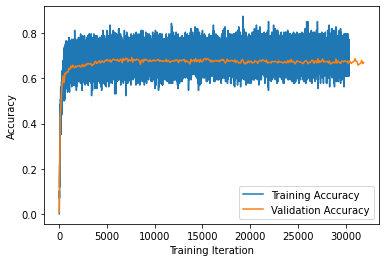

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()